In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]


for r in [0,1,2,3,4]:
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)


    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        nonlinear_func= LSTM_nonlinear_func(input_dim[0]).to(DEVICE)
        model = EEGNet_NeuralFS_TS_Wrapper(DEVICE, classifier, input_dim[1],
                                    nonlinear_func=nonlinear_func
                                     ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_TS-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_pairwise_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_TS-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7228080127753463


Iterations:   0%|                                   | 1/300 [00:03<15:01,  3.01s/it]

Epoch:  0
t_loss:  0.7228080127753463 , v_loss:  0.694654107093811
t_acc:  0.4749455337690632 , v_acc:  0.45962732919254656
t_recall:  0.4782531120901442 , v_recall:  0.3608108108108108
t_prec:  0.48156037227604787 , v_prec:  0.35582306830907057
t_f:  0.45763567810862094 , v_f:  0.35821305841924395
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:50,  1.78s/it]

Epoch  1 , loss 0.686832586924235
Epoch  2 , loss 0.6539075958962534


Iterations:   1%|▎                                  | 3/300 [00:05<07:44,  1.56s/it]

Epoch:  2
t_loss:  0.6539075958962534 , v_loss:  0.6951111952463785
t_acc:  0.574540927482104 , v_acc:  0.4906832298136646
t_recall:  0.5000981320596753 , v_recall:  0.3833333333333333
t_prec:  0.5000971947202196 , v_prec:  0.3704481792717087
t_f:  0.5000812108763616 , v_f:  0.3760869565217392
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:40,  1.35s/it]

Epoch  3 , loss 0.6230723437140969
Epoch  4 , loss 0.6013567856713837


Iterations:   2%|▌                                  | 5/300 [00:07<06:42,  1.36s/it]

Epoch:  4
t_loss:  0.6013567856713837 , v_loss:  0.6921898722648621
t_acc:  0.6417678182384065 , v_acc:  0.5652173913043478
t_recall:  0.5006896693704451 , v_recall:  0.43189189189189187
t_prec:  0.5012192636375548 , v_prec:  0.3984962406015038
t_f:  0.4810633662741136 , v_f:  0.4078394283312316
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:50,  1.19s/it]

Epoch  5 , loss 0.5767687044891656
Epoch  6 , loss 0.5574718415737152


Iterations:   2%|▊                                  | 7/300 [00:09<05:59,  1.23s/it]

Epoch:  6
t_loss:  0.5574718415737152 , v_loss:  0.6822697520256042
t_acc:  0.6809835045129162 , v_acc:  0.6459627329192547
t_recall:  0.5107629596080208 , v_recall:  0.4794594594594595
t_prec:  0.5399755314268236 , v_prec:  0.4309090909090909
t_f:  0.46552280684329456 , v_f:  0.42359148294705107
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:21,  1.10s/it]

Epoch  7 , loss 0.5443258893256094
Epoch  8 , loss 0.523738704475702


Iterations:   3%|█                                  | 9/300 [00:12<05:53,  1.21s/it]

Epoch:  8
t_loss:  0.523738704475702 , v_loss:  0.6706430315971375
t_acc:  0.6890756302521008 , v_acc:  0.6894409937888198
t_recall:  0.5047906287314201 , v_recall:  0.5
t_prec:  0.538503540935866 , v_prec:  0.3447204968944099
t_f:  0.4378129999921184 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:20,  1.11s/it]

Epoch  9 , loss 0.5156474382269616
Epoch  10 , loss 0.5022374233778786


Iterations:   4%|█▏                                | 11/300 [00:14<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.5022374233778786 , v_loss:  0.6627544860045115
t_acc:  0.6900093370681606 , v_acc:  0.6894409937888198
t_recall:  0.4982734247402589 , v_recall:  0.5
t_prec:  0.4650833595470274 , v_prec:  0.3447204968944099
t_f:  0.4159213924958131 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:17,  1.10s/it]

Epoch  11 , loss 0.4917801028373195
Epoch  12 , loss 0.49329347528663336


Iterations:   4%|█▍                                | 13/300 [00:16<05:34,  1.16s/it]

Epoch:  12
t_loss:  0.49329347528663336 , v_loss:  0.658930371205012
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5010540618437848 , v_recall:  0.5
t_prec:  0.5480300187617261 , v_prec:  0.3447204968944099
t_f:  0.41576068370365055 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:14,  1.10s/it]

Epoch  13 , loss 0.4792788899412342
Epoch  14 , loss 0.47332286425665315


Iterations:   5%|█▋                                | 15/300 [00:18<05:42,  1.20s/it]

Epoch:  14
t_loss:  0.47332286425665315 , v_loss:  0.6577607194582621
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5015014891368497 , v_recall:  0.5
t_prec:  0.5788942307692309 , v_prec:  0.3447204968944099
t_f:  0.4159900929896205 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:13,  1.10s/it]

Epoch  15 , loss 0.4692312858852686
Epoch  16 , loss 0.4624400162229351


Iterations:   6%|█▉                                | 17/300 [00:21<05:30,  1.17s/it]

Epoch:  16
t_loss:  0.4624400162229351 , v_loss:  0.657794713973999
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<05:02,  1.07s/it]

Epoch  17 , loss 0.45629269059966593
Epoch  18 , loss 0.45501742935648154


Iterations:   6%|██▏                               | 19/300 [00:23<05:30,  1.18s/it]

Epoch:  18
t_loss:  0.45501742935648154 , v_loss:  0.6615006426970164
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:10,  1.11s/it]

Epoch  19 , loss 0.4594834078760708
Epoch  20 , loss 0.4542539476179609


Iterations:   7%|██▍                               | 21/300 [00:25<05:26,  1.17s/it]

Epoch:  20
t_loss:  0.4542539476179609 , v_loss:  0.6638479232788086
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.502172630076447 , v_recall:  0.5
t_prec:  0.6482672494536372 , v_prec:  0.3447204968944099
t_f:  0.4163339999076822 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<04:58,  1.07s/it]

Epoch  21 , loss 0.45075658723419787
Epoch  22 , loss 0.4540283802677603


Iterations:   8%|██▌                               | 23/300 [00:27<05:17,  1.15s/it]

Epoch:  22
t_loss:  0.4540283802677603 , v_loss:  0.6652178267637888
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:04,  1.10s/it]

Epoch  23 , loss 0.4496087163102393
Epoch  24 , loss 0.44987695386596754


Iterations:   8%|██▊                               | 25/300 [00:30<05:25,  1.18s/it]

Epoch:  24
t_loss:  0.44987695386596754 , v_loss:  0.6655441919962565
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<04:55,  1.08s/it]

Epoch  25 , loss 0.4500035889008466
Epoch  26 , loss 0.44336482122832654


Iterations:   9%|███                               | 27/300 [00:32<05:17,  1.16s/it]

Epoch:  26
t_loss:  0.44336482122832654 , v_loss:  0.6645307838916779
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.503355018459807 , v_recall:  0.5
t_prec:  0.7860179407176286 , v_prec:  0.3447204968944099
t_f:  0.4177611561866126 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:33<04:49,  1.07s/it]

Epoch  27 , loss 0.4434519608815511
Epoch  28 , loss 0.4393794828770207


Iterations:  10%|███▎                              | 29/300 [00:34<05:10,  1.14s/it]

Epoch:  28
t_loss:  0.4393794828770207 , v_loss:  0.6650103628635406
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:53,  1.09s/it]

Epoch  29 , loss 0.4433331729150286
Epoch  30 , loss 0.4429816130329581


Iterations:  10%|███▌                              | 31/300 [00:36<05:07,  1.14s/it]

Epoch:  30
t_loss:  0.4429816130329581 , v_loss:  0.6639783382415771
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:45,  1.07s/it]

Epoch  31 , loss 0.4430752606952892
Epoch  32 , loss 0.43896705905596417


Iterations:  11%|███▋                              | 33/300 [00:39<05:18,  1.19s/it]

Epoch:  32
t_loss:  0.43896705905596417 , v_loss:  0.6639828383922577
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.503355018459807 , v_recall:  0.5
t_prec:  0.7860179407176286 , v_prec:  0.3447204968944099
t_f:  0.4177611561866126 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:55,  1.11s/it]

Epoch  33 , loss 0.44646934960402695
Epoch  34 , loss 0.4383128600962022


Iterations:  12%|███▉                              | 35/300 [00:41<05:15,  1.19s/it]

Epoch:  34
t_loss:  0.4383128600962022 , v_loss:  0.663559744755427
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.502108809925749 , v_recall:  0.5
t_prec:  0.7053961322520275 , v_prec:  0.3447204968944099
t_f:  0.41547864167250537 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:42<04:48,  1.09s/it]

Epoch  35 , loss 0.4457754188892888
Epoch  36 , loss 0.4413372658047022


Iterations:  12%|████▏                             | 37/300 [00:43<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.4413372658047022 , v_loss:  0.6577656616767248
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5023963437229794 , v_recall:  0.5
t_prec:  0.6816479400749064 , v_prec:  0.3447204968944099
t_f:  0.4164485805823192 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:53,  1.12s/it]

Epoch  37 , loss 0.43478920062383014
Epoch  38 , loss 0.4409441538885528


Iterations:  13%|████▍                             | 39/300 [00:46<05:08,  1.18s/it]

Epoch:  38
t_loss:  0.4409441538885528 , v_loss:  0.6549090097347895
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5017252027833821 , v_recall:  0.5
t_prec:  0.5981724461105904 , v_prec:  0.3447204968944099
t_f:  0.41610475617098136 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:42,  1.09s/it]

Epoch  39 , loss 0.43674841464734543
Epoch  40 , loss 0.435642541623583


Iterations:  14%|████▋                             | 41/300 [00:48<05:00,  1.16s/it]

Epoch:  40
t_loss:  0.435642541623583 , v_loss:  0.6531016975641251
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:47,  1.11s/it]

Epoch  41 , loss 0.43444830880445595
Epoch  42 , loss 0.4395085602414374


Iterations:  14%|████▊                             | 43/300 [00:50<05:09,  1.20s/it]

Epoch:  42
t_loss:  0.4395085602414374 , v_loss:  0.6518573264280955
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5010540618437848 , v_recall:  0.5
t_prec:  0.5480300187617261 , v_prec:  0.3447204968944099
t_f:  0.41576068370365055 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:51,  1.14s/it]

Epoch  43 , loss 0.430634738183489
Epoch  44 , loss 0.4323706825574239


Iterations:  15%|█████                             | 45/300 [00:52<05:06,  1.20s/it]

Epoch:  44
t_loss:  0.4323706825574239 , v_loss:  0.6504753530025482
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5018528430847778 , v_recall:  0.5
t_prec:  0.5704225352112675 , v_prec:  0.3447204968944099
t_f:  0.41779271783265653 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:41,  1.11s/it]

Epoch  45 , loss 0.4337223014410804
Epoch  46 , loss 0.42853425881441903


Iterations:  16%|█████▎                            | 47/300 [00:55<05:03,  1.20s/it]

Epoch:  46
t_loss:  0.42853425881441903 , v_loss:  0.6455364972352982
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5045689737994263 , v_recall:  0.5
t_prec:  0.6645684342352437 , v_prec:  0.3447204968944099
t_f:  0.422424761852328 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:46,  1.14s/it]

Epoch  47 , loss 0.4330311049433315
Epoch  48 , loss 0.43585367354692195


Iterations:  16%|█████▌                            | 49/300 [00:57<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.43585367354692195 , v_loss:  0.6441824088493983
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:33,  1.10s/it]

Epoch  49 , loss 0.42946865219695896
Epoch  50 , loss 0.43394095289940926


Iterations:  17%|█████▊                            | 51/300 [00:59<04:50,  1.17s/it]

Epoch:  50
t_loss:  0.43394095289940926 , v_loss:  0.6462992131710052
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5077640987633988 , v_recall:  0.5
t_prec:  0.6720463899758724 , v_prec:  0.3447204968944099
t_f:  0.4303809557438838 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:42,  1.14s/it]

Epoch  51 , loss 0.4270450393943226
Epoch  52 , loss 0.4308918983328576


Iterations:  18%|██████                            | 53/300 [01:02<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.4308918983328576 , v_loss:  0.6435581346352895
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:33,  1.11s/it]

Epoch  53 , loss 0.4297974571293476
Epoch  54 , loss 0.43151823445862414


Iterations:  18%|██████▏                           | 55/300 [01:04<04:46,  1.17s/it]

Epoch:  54
t_loss:  0.43151823445862414 , v_loss:  0.6407270779212316
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5080516325606291 , v_recall:  0.5
t_prec:  0.6677101200686106 , v_prec:  0.3447204968944099
t_f:  0.4312978291425894 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:21,  1.07s/it]

Epoch  55 , loss 0.4336712266884598
Epoch  56 , loss 0.43010719909387474


Iterations:  19%|██████▍                           | 57/300 [01:06<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.43010719909387474 , v_loss:  0.6351146101951599
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.506454070078643 , v_recall:  0.5
t_prec:  0.6639987445072191 , v_prec:  0.3447204968944099
t_f:  0.42735630095234944 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:32,  1.13s/it]

Epoch  57 , loss 0.43224601535236135
Epoch  58 , loss 0.4304112540740593


Iterations:  20%|██████▋                           | 59/300 [01:09<04:44,  1.18s/it]

Epoch:  58
t_loss:  0.4304112540740593 , v_loss:  0.6359448979298273
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5081477059057657 , v_recall:  0.5
t_prec:  0.7149296420554657 , v_prec:  0.3447204968944099
t_f:  0.42984278305442924 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:21,  1.09s/it]

Epoch  59 , loss 0.4297357406101975
Epoch  60 , loss 0.4278465678878859


Iterations:  20%|██████▉                           | 61/300 [01:11<04:40,  1.18s/it]

Epoch:  60
t_loss:  0.4278465678878859 , v_loss:  0.6331924051046371
t_acc:  0.7005913476501712 , v_acc:  0.6894409937888198
t_recall:  0.5101926956808169 , v_recall:  0.5
t_prec:  0.7333176248821867 , v_prec:  0.3447204968944099
t_f:  0.4340393133997785 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:29,  1.13s/it]

Epoch  61 , loss 0.42769134103083145
Epoch  62 , loss 0.42150946458180744


Iterations:  21%|███████▏                          | 63/300 [01:13<04:44,  1.20s/it]

Epoch:  62
t_loss:  0.42150946458180744 , v_loss:  0.627314567565918
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5111513704176446 , v_recall:  0.5
t_prec:  0.7639815456593311 , v_prec:  0.3447204968944099
t_f:  0.4353482075004403 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:17,  1.09s/it]

Epoch  63 , loss 0.42566751849417594
Epoch  64 , loss 0.42649519268204183


Iterations:  22%|███████▎                          | 65/300 [01:15<04:36,  1.18s/it]

Epoch:  64
t_loss:  0.42649519268204183 , v_loss:  0.6253174990415573
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5125890394037963 , v_recall:  0.5
t_prec:  0.7222989675730697 , v_prec:  0.3447204968944099
t_f:  0.43986669218951696 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:11,  1.08s/it]

Epoch  65 , loss 0.43108509919222665
Epoch  66 , loss 0.4222009076791651


Iterations:  22%|███████▌                          | 67/300 [01:18<04:27,  1.15s/it]

Epoch:  66
t_loss:  0.4222009076791651 , v_loss:  0.6246401866277059
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5097768353440112 , v_recall:  0.5
t_prec:  0.649905303030303 , v_prec:  0.3447204968944099
t_f:  0.43672055765695494 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:13,  1.09s/it]

Epoch  67 , loss 0.4263663619172339
Epoch  68 , loss 0.42798320627680014


Iterations:  23%|███████▊                          | 69/300 [01:20<04:25,  1.15s/it]

Epoch:  68
t_loss:  0.42798320627680014 , v_loss:  0.6221227099498113
t_acc:  0.7002801120448179 , v_acc:  0.6894409937888198
t_recall:  0.5114066510204361 , v_recall:  0.5
t_prec:  0.6917156214437302 , v_prec:  0.3447204968944099
t_f:  0.43842668964176673 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:06,  1.07s/it]

Epoch  69 , loss 0.43365545074145
Epoch  70 , loss 0.42374377799969093


Iterations:  24%|████████                          | 71/300 [01:22<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.42374377799969093 , v_loss:  0.620560402671496
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5087227735002264 , v_recall:  0.5
t_prec:  0.699670122525919 , v_prec:  0.3447204968944099
t_f:  0.43168604651162784 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:07,  1.09s/it]

Epoch  71 , loss 0.4235672290418662
Epoch  72 , loss 0.42603929136313645


Iterations:  24%|████████▎                         | 73/300 [01:24<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.42603929136313645 , v_loss:  0.6171245723962784
t_acc:  0.7018362900715842 , v_acc:  0.6956521739130435
t_recall:  0.5133878206447894 , v_recall:  0.51
t_prec:  0.7197256385998108 , v_prec:  0.846875
t_f:  0.44178690344062155 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:00,  1.06s/it]

Epoch  73 , loss 0.4252667941299139
Epoch  74 , loss 0.42475594317211823


Iterations:  25%|████████▌                         | 75/300 [01:27<04:22,  1.17s/it]

Epoch:  74
t_loss:  0.42475594317211823 , v_loss:  0.6168464322884878
t_acc:  0.7018362900715842 , v_acc:  0.6956521739130435
t_recall:  0.5133878206447894 , v_recall:  0.51
t_prec:  0.7197256385998108 , v_prec:  0.846875
t_f:  0.44178690344062155 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:09,  1.12s/it]

Epoch  75 , loss 0.41991180648990706
Epoch  76 , loss 0.4224416899914835


Iterations:  26%|████████▋                         | 77/300 [01:29<04:19,  1.16s/it]

Epoch:  76
t_loss:  0.4224416899914835 , v_loss:  0.6145178377628326
t_acc:  0.7024587612822907 , v_acc:  0.6956521739130435
t_recall:  0.514410315532315 , v_recall:  0.5154954954954954
t_prec:  0.7258993373303881 , v_prec:  0.6814345991561181
t_f:  0.4438366304006165 , v_f:  0.44665778214210566
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<03:56,  1.06s/it]

Epoch  77 , loss 0.4206179088237239
Epoch  78 , loss 0.42372578791543547


Iterations:  26%|████████▉                         | 79/300 [01:31<04:15,  1.16s/it]

Epoch:  78
t_loss:  0.42372578791543547 , v_loss:  0.613655706246694
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5134516407954873 , v_recall:  0.5054954954954954
t_prec:  0.70625 , v_prec:  0.5959119496855345
t_f:  0.44253355499795644 , v_f:  0.4266381766381766
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:01,  1.10s/it]

Epoch  79 , loss 0.4237994136763554
Epoch  80 , loss 0.42319394385113435


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.42319394385113435 , v_loss:  0.6155613412459692
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.5122054322614293 , v_recall:  0.5154954954954954
t_prec:  0.6913350928024327 , v_prec:  0.6814345991561181
t_f:  0.4403460653194488 , v_f:  0.44665778214210566
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:53,  1.07s/it]

Epoch  81 , loss 0.4232383452209772
Epoch  82 , loss 0.4181385040283203


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:12,  1.16s/it]

Epoch:  82
t_loss:  0.4181385040283203 , v_loss:  0.6127801239490509
t_acc:  0.7030812324929971 , v_acc:  0.6956521739130435
t_recall:  0.5168704794059922 , v_recall:  0.5154954954954954
t_prec:  0.7085840988280012 , v_prec:  0.6814345991561181
t_f:  0.4502203278443887 , v_f:  0.44665778214210566
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:48,  1.06s/it]

Epoch  83 , loss 0.42665235318389594
Epoch  84 , loss 0.4199543460911396


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4199543460911396 , v_loss:  0.614084338148435
t_acc:  0.7049486461251168 , v_acc:  0.6956521739130435
t_recall:  0.5179252274879566 , v_recall:  0.5154954954954954
t_prec:  0.7579087677725118 , v_prec:  0.6814345991561181
t_f:  0.450233918128655 , v_f:  0.44665778214210566
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:45,  1.05s/it]

Epoch  85 , loss 0.4217958280853197
Epoch  86 , loss 0.42012495503706093


Iterations:  29%|█████████▊                        | 87/300 [01:40<03:59,  1.13s/it]

Epoch:  86
t_loss:  0.42012495503706093 , v_loss:  0.6102997958660126
t_acc:  0.7030812324929971 , v_acc:  0.6956521739130435
t_recall:  0.5162954118115316 , v_recall:  0.5154954954954954
t_prec:  0.716697491056871 , v_prec:  0.6814345991561181
t_f:  0.4484943899472461 , v_f:  0.44665778214210566
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:48,  1.08s/it]

Epoch  87 , loss 0.4211947117366043
Epoch  88 , loss 0.41619497888228474


Iterations:  30%|██████████                        | 89/300 [01:42<04:07,  1.17s/it]

Epoch:  88
t_loss:  0.41619497888228474 , v_loss:  0.6112093826135
t_acc:  0.704014939309057 , v_acc:  0.6956521739130435
t_recall:  0.5181166879400503 , v_recall:  0.5154954954954954
t_prec:  0.7201320792475485 , v_prec:  0.6814345991561181
t_f:  0.45237715032300213 , v_f:  0.44665778214210566
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:43,  1.07s/it]

Epoch  89 , loss 0.4285210575543198
Epoch  90 , loss 0.42399589279118705


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:00,  1.15s/it]

Epoch:  90
t_loss:  0.42399589279118705 , v_loss:  0.6093241572380066
t_acc:  0.7015250544662309 , v_acc:  0.6956521739130435
t_recall:  0.5146017759844086 , v_recall:  0.5154954954954954
t_prec:  0.6905720085980416 , v_prec:  0.6814345991561181
t_f:  0.44603896448286623 , v_f:  0.44665778214210566
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:41,  1.06s/it]

Epoch  91 , loss 0.4224502461798051
Epoch  92 , loss 0.421907445379332


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:01,  1.17s/it]

Epoch:  92
t_loss:  0.421907445379332 , v_loss:  0.6043785959482193
t_acc:  0.702769996887644 , v_acc:  0.6956521739130435
t_recall:  0.5160716981649991 , v_recall:  0.5154954954954954
t_prec:  0.709756388822546 , v_prec:  0.6814345991561181
t_f:  0.4483495423160972 , v_f:  0.44665778214210566
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:54,  1.14s/it]

Epoch  93 , loss 0.4265414499769024
Epoch  94 , loss 0.4165103610824136


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:05,  1.20s/it]

Epoch:  94
t_loss:  0.4165103610824136 , v_loss:  0.6033773918946584
t_acc:  0.7037037037037037 , v_acc:  0.6956521739130435
t_recall:  0.5181805080907481 , v_recall:  0.5154954954954954
t_prec:  0.7100618458610847 , v_prec:  0.6814345991561181
t_f:  0.4530813496916719 , v_f:  0.44665778214210566
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:45,  1.10s/it]

Epoch  95 , loss 0.42155923855070976
Epoch  96 , loss 0.4171294447253732


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4171294447253732 , v_loss:  0.6023240635792414
t_acc:  0.7043261749144102 , v_acc:  0.6956521739130435
t_recall:  0.5197780705727344 , v_recall:  0.5154954954954954
t_prec:  0.7081419533755091 , v_prec:  0.6814345991561181
t_f:  0.4567620036135779 , v_f:  0.44665778214210566
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:55,  1.16s/it]

Epoch  97 , loss 0.4161326207366644
Epoch  98 , loss 0.4120415121901269


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:14,  1.26s/it]

Epoch:  98
t_loss:  0.4120415121901269 , v_loss:  0.6037458380063375
t_acc:  0.7055711173358232 , v_acc:  0.6956521739130435
t_recall:  0.5206729251588641 , v_recall:  0.5154954954954954
t_prec:  0.7313013789785117 , v_prec:  0.6814345991561181
t_f:  0.45737203290582423 , v_f:  0.44665778214210566
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:48,  1.14s/it]

Epoch  99 , loss 0.41276463077348824
Epoch  100 , loss 0.41905297894103855


Iterations:  34%|███████████                      | 101/300 [01:56<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.41905297894103855 , v_loss:  0.6056912293036779
t_acc:  0.7012138188608776 , v_acc:  0.6956521739130435
t_recall:  0.5149531299323369 , v_recall:  0.5154954954954954
t_prec:  0.6786163178315755 , v_prec:  0.6814345991561181
t_f:  0.4476257333400191 , v_f:  0.44665778214210566
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:39,  1.11s/it]

Epoch  101 , loss 0.41927460946288764
Epoch  102 , loss 0.4149356519474703


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.4149356519474703 , v_loss:  0.6037788937489191
t_acc:  0.7046374105197635 , v_acc:  0.6956521739130435
t_recall:  0.5208643856109578 , v_recall:  0.5154954954954954
t_prec:  0.7044360369729517 , v_prec:  0.6814345991561181
t_f:  0.4594182083665678 , v_f:  0.44665778214210566
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:47,  1.16s/it]

Epoch  103 , loss 0.4160025873604943
Epoch  104 , loss 0.4239095344262965


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.4239095344262965 , v_loss:  0.606838271021843
t_acc:  0.7061935885465297 , v_acc:  0.6956521739130435
t_recall:  0.520257751060238 , v_recall:  0.5154954954954954
t_prec:  0.7595758151313707 , v_prec:  0.6814345991561181
t_f:  0.45513102413534423 , v_f:  0.44665778214210566
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:34,  1.11s/it]

Epoch  105 , loss 0.41533489028612774
Epoch  106 , loss 0.41203584507399915


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:47,  1.18s/it]

Epoch:  106
t_loss:  0.41203584507399915 , v_loss:  0.6056042065223058
t_acc:  0.707749766573296 , v_acc:  0.6956521739130435
t_recall:  0.5233890558735126 , v_recall:  0.5154954954954954
t_prec:  0.7576190476190476 , v_prec:  0.6814345991561181
t_f:  0.46180472494039637 , v_f:  0.44665778214210566
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:37,  1.13s/it]

Epoch  107 , loss 0.42191750395531746
Epoch  108 , loss 0.4201889639975978


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.4201889639975978 , v_loss:  0.6075039555629095
t_acc:  0.707749766573296 , v_acc:  0.6956521739130435
t_recall:  0.5251142586568947 , v_recall:  0.5154954954954954
t_prec:  0.7332504780114724 , v_prec:  0.6814345991561181
t_f:  0.4667497029306074 , v_f:  0.44665778214210566
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:33,  1.12s/it]

Epoch  109 , loss 0.41884780280730305
Epoch  110 , loss 0.4205092986424764


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:45,  1.20s/it]

Epoch:  110
t_loss:  0.4205092986424764 , v_loss:  0.6059370189905167
t_acc:  0.707749766573296 , v_acc:  0.6956521739130435
t_recall:  0.5251142586568947 , v_recall:  0.5154954954954954
t_prec:  0.7332504780114724 , v_prec:  0.6814345991561181
t_f:  0.4667497029306074 , v_f:  0.44665778214210566
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:25,  1.09s/it]

Epoch  111 , loss 0.4169515163875094
Epoch  112 , loss 0.4136839818720724


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:45,  1.21s/it]

Epoch:  112
t_loss:  0.4136839818720724 , v_loss:  0.6058937211831411
t_acc:  0.7080610021786492 , v_acc:  0.6956521739130435
t_recall:  0.5239003033172753 , v_recall:  0.5154954954954954
t_prec:  0.7592191965703399 , v_prec:  0.6814345991561181
t_f:  0.4627940752866958 , v_f:  0.44665778214210566
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:30,  1.13s/it]

Epoch  113 , loss 0.41673798537721823
Epoch  114 , loss 0.4230619779988831


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:40,  1.19s/it]

Epoch:  114
t_loss:  0.4230619779988831 , v_loss:  0.6038538416226705
t_acc:  0.7037037037037037 , v_acc:  0.6956521739130435
t_recall:  0.5193306432796695 , v_recall:  0.5154954954954954
t_prec:  0.6975755166931638 , v_prec:  0.6814345991561181
t_f:  0.45645724196265464 , v_f:  0.44665778214210566
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:21,  1.10s/it]

Epoch  115 , loss 0.41825199594684676
Epoch  116 , loss 0.4175112264997819


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:33,  1.17s/it]

Epoch:  116
t_loss:  0.4175112264997819 , v_loss:  0.6012801676988602
t_acc:  0.7037037037037037 , v_acc:  0.6956521739130435
t_recall:  0.5187555756852088 , v_recall:  0.5154954954954954
t_prec:  0.7034202326135282 , v_prec:  0.6814345991561181
t_f:  0.45477607641037776 , v_f:  0.44665778214210566
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:20,  1.10s/it]

Epoch  117 , loss 0.4171096524771522
Epoch  118 , loss 0.41679615658872265


Iterations:  40%|█████████████                    | 119/300 [02:17<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.41679615658872265 , v_loss:  0.6036343723535538
t_acc:  0.7018362900715842 , v_acc:  0.6956521739130435
t_recall:  0.5179883614004749 , v_recall:  0.5154954954954954
t_prec:  0.6692719320148437 , v_prec:  0.6814345991561181
t_f:  0.45554394415584964 , v_f:  0.44665778214210566
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:21,  1.12s/it]

Epoch  119 , loss 0.4112321664305294
Epoch  120 , loss 0.4166738519481584


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:31,  1.18s/it]

Epoch:  120
t_loss:  0.4166738519481584 , v_loss:  0.6047132015228271
t_acc:  0.706504824151883 , v_acc:  0.6956521739130435
t_recall:  0.5227817350846131 , v_recall:  0.5154954954954954
t_prec:  0.7295469631596416 , v_prec:  0.6814345991561181
t_f:  0.4620100134716831 , v_f:  0.44665778214210566
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:12,  1.08s/it]

Epoch  121 , loss 0.4237093119060292
Epoch  122 , loss 0.41388388474782306


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.41388388474782306 , v_loss:  0.6015053391456604
t_acc:  0.7037037037037037 , v_acc:  0.7018633540372671
t_recall:  0.5190431094824391 , v_recall:  0.5254954954954955
t_prec:  0.7004073143253315 , v_prec:  0.7253184713375795
t_f:  0.4556183446738169 , v_f:  0.4660033167495854
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:17,  1.12s/it]

Epoch  123 , loss 0.4145916916576086
Epoch  124 , loss 0.41406919325099273


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:27,  1.18s/it]

Epoch:  124
t_loss:  0.41406919325099273 , v_loss:  0.6048489759365717
t_acc:  0.706504824151883 , v_acc:  0.6956521739130435
t_recall:  0.5227817350846131 , v_recall:  0.5154954954954954
t_prec:  0.7295469631596416 , v_prec:  0.6814345991561181
t_f:  0.4620100134716831 , v_f:  0.44665778214210566
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:09,  1.09s/it]

Epoch  125 , loss 0.4105505189474891
Epoch  126 , loss 0.412629424941306


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:21,  1.17s/it]

Epoch:  126
t_loss:  0.412629424941306 , v_loss:  0.5989701698223749
t_acc:  0.7043261749144102 , v_acc:  0.7018633540372671
t_recall:  0.5226534085450378 , v_recall:  0.5254954954954955
t_prec:  0.6841295989171581 , v_prec:  0.7253184713375795
t_f:  0.46498508019395746 , v_f:  0.4660033167495854
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:12,  1.12s/it]

Epoch  127 , loss 0.41218265832639206
Epoch  128 , loss 0.41025183364456774


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:31,  1.24s/it]

Epoch:  128
t_loss:  0.41025183364456774 , v_loss:  0.6011936863263448
t_acc:  0.7096171802054155 , v_acc:  0.7018633540372671
t_recall:  0.5281817433194713 , v_recall:  0.5254954954954955
t_prec:  0.742816091954023 , v_prec:  0.7253184713375795
t_f:  0.47257001790925657 , v_f:  0.4660033167495854
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:11,  1.12s/it]

Epoch  129 , loss 0.4170406974998175
Epoch  130 , loss 0.4137040464317097


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.4137040464317097 , v_loss:  0.6017658611138662
t_acc:  0.7071272953625894 , v_acc:  0.7018633540372671
t_recall:  0.523229162377678 , v_recall:  0.5254954954954955
t_prec:  0.7408886906851628 , v_prec:  0.7253184713375795
t_f:  0.462323486234127 , v_f:  0.4660033167495854
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:03,  1.09s/it]

Epoch  131 , loss 0.4104599602082196
Epoch  132 , loss 0.412312330568538


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.412312330568538 , v_loss:  0.5979225238164266
t_acc:  0.7055711173358232 , v_acc:  0.7018633540372671
t_recall:  0.5226856617394765 , v_recall:  0.5254954954954955
t_prec:  0.7079886918443703 , v_prec:  0.7253184713375795
t_f:  0.46318425287632414 , v_f:  0.4660033167495854
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:09,  1.14s/it]

Epoch  133 , loss 0.41464025717155606
Epoch  134 , loss 0.407977912940231


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.407977912940231 , v_loss:  0.5987224727869034
t_acc:  0.7043261749144102 , v_acc:  0.7080745341614907
t_recall:  0.5200656043699647 , v_recall:  0.5354954954954955
t_prec:  0.7050874403815581 , v_prec:  0.7525641025641026
t_f:  0.45759913851315337 , v_f:  0.4847122914538645
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:03,  1.12s/it]

Epoch  135 , loss 0.42056987390798684
Epoch  136 , loss 0.4068233195473166


Iterations:  46%|███████████████                  | 137/300 [02:38<03:12,  1.18s/it]

Epoch:  136
t_loss:  0.4068233195473166 , v_loss:  0.5970652451117834
t_acc:  0.7080610021786492 , v_acc:  0.7142857142857143
t_recall:  0.5256255061006574 , v_recall:  0.5454954954954955
t_prec:  0.7349420331191383 , v_prec:  0.771505376344086
t_f:  0.4677239209281099 , v_f:  0.5028195488721805
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:03,  1.13s/it]

Epoch  137 , loss 0.41500134444704245
Epoch  138 , loss 0.40767089759602265


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.40767089759602265 , v_loss:  0.5977061490217844
t_acc:  0.7074385309679427 , v_acc:  0.7142857142857143
t_recall:  0.5240279436186711 , v_recall:  0.5454954954954955
t_prec:  0.7387209672287623 , v_prec:  0.771505376344086
t_f:  0.4641336346267945 , v_f:  0.5028195488721805
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:59,  1.12s/it]

Epoch  139 , loss 0.41220249907643186
Epoch  140 , loss 0.41465875915452544


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.41465875915452544 , v_loss:  0.5985576758782069
t_acc:  0.704014939309057 , v_acc:  0.7142857142857143
t_recall:  0.5221421611012751 , v_recall:  0.5454954954954955
t_prec:  0.6820332480818414 , v_prec:  0.771505376344086
t_f:  0.4640180295319889 , v_f:  0.5028195488721805
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:54,  1.10s/it]

Epoch  141 , loss 0.41430528666458877
Epoch  142 , loss 0.40671050256373836


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:12,  1.22s/it]

Epoch:  142
t_loss:  0.40671050256373836 , v_loss:  0.597760334610939
t_acc:  0.7096171802054155 , v_acc:  0.7142857142857143
t_recall:  0.5281817433194713 , v_recall:  0.5454954954954955
t_prec:  0.742816091954023 , v_prec:  0.771505376344086
t_f:  0.47257001790925657 , v_f:  0.5028195488721805
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:59,  1.15s/it]

Epoch  143 , loss 0.4099773431525511
Epoch  144 , loss 0.41625657327034893


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:08,  1.22s/it]

Epoch:  144
t_loss:  0.41625657327034893 , v_loss:  0.5963521947463354
t_acc:  0.7049486461251168 , v_acc:  0.7080745341614907
t_recall:  0.522525768243642 , v_recall:  0.5354954954954955
t_prec:  0.6964470954356847 , v_prec:  0.7525641025641026
t_f:  0.46368383390757806 , v_f:  0.4847122914538645
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:51,  1.11s/it]

Epoch  145 , loss 0.41111083474813725
Epoch  146 , loss 0.41260148614060643


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.41260148614060643 , v_loss:  0.5951690177122752
t_acc:  0.7124183006535948 , v_acc:  0.7204968944099379
t_recall:  0.5327829703133363 , v_recall:  0.5554954954954955
t_prec:  0.7549471661863594 , v_prec:  0.7857142857142857
t_f:  0.4811895265296878 , v_f:  0.5203574975173784
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:53,  1.14s/it]

Epoch  147 , loss 0.4161633369969387
Epoch  148 , loss 0.41075290710318324


Iterations:  50%|████████████████▍                | 149/300 [02:52<03:09,  1.26s/it]

Epoch:  148
t_loss:  0.41075290710318324 , v_loss:  0.5979755421479543
t_acc:  0.7068160597572363 , v_acc:  0.7080745341614907
t_recall:  0.5230054487311456 , v_recall:  0.5354954954954955
t_prec:  0.7351351351351352 , v_prec:  0.7525641025641026
t_f:  0.4621667247151478 , v_f:  0.4847122914538645
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:49,  1.13s/it]

Epoch  149 , loss 0.4123135618135041
Epoch  150 , loss 0.410171790450227


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.410171790450227 , v_loss:  0.5974430441856384
t_acc:  0.7080610021786492 , v_acc:  0.7142857142857143
t_recall:  0.5287883778701912 , v_recall:  0.5454954954954955
t_prec:  0.7061339142398533 , v_prec:  0.771505376344086
t_f:  0.47646284265017536 , v_f:  0.5028195488721805
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:42,  1.10s/it]

Epoch  151 , loss 0.41689566303701964
Epoch  152 , loss 0.4018115521061654


Iterations:  51%|████████████████▊                | 153/300 [02:57<03:00,  1.22s/it]

Epoch:  152
t_loss:  0.4018115521061654 , v_loss:  0.5963952292998632
t_acc:  0.7086834733893558 , v_acc:  0.7204968944099379
t_recall:  0.5289482713660257 , v_recall:  0.5554954954954955
t_prec:  0.7158220378872115 , v_prec:  0.7857142857142857
t_f:  0.476021554535875 , v_f:  0.5203574975173784
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:47,  1.15s/it]

Epoch  153 , loss 0.41229606259102913
Epoch  154 , loss 0.4146808140418109


Iterations:  52%|█████████████████                | 155/300 [02:59<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.4146808140418109 , v_loss:  0.5982092767953873
t_acc:  0.7086834733893558 , v_acc:  0.7204968944099379
t_recall:  0.525785399596492 , v_recall:  0.5554954954954955
t_prec:  0.7492239732569246 , v_prec:  0.7857142857142857
t_f:  0.4672321428571429 , v_f:  0.5203574975173784
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:38,  1.10s/it]

Epoch  155 , loss 0.4078429817569022
Epoch  156 , loss 0.40942226437961354


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.40942226437961354 , v_loss:  0.5995398908853531
t_acc:  0.7105508870214753 , v_acc:  0.7204968944099379
t_recall:  0.5302905532452203 , v_recall:  0.5554954954954955
t_prec:  0.7407636363636363 , v_prec:  0.7857142857142857
t_f:  0.4770361373246339 , v_f:  0.5203574975173784
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:40,  1.13s/it]

Epoch  157 , loss 0.407920265898985
Epoch  158 , loss 0.40671732612684663


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:55,  1.24s/it]

Epoch:  158
t_loss:  0.40671732612684663 , v_loss:  0.5935268650452296
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5233245494846351 , v_recall:  0.5554954954954955
t_prec:  0.696248893336926 , v_prec:  0.7857142857142857
t_f:  0.4654656801817905 , v_f:  0.5203574975173784
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:36,  1.12s/it]

Epoch  159 , loss 0.41272346412434296
Epoch  160 , loss 0.41544195191532957


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.41544195191532957 , v_loss:  0.6012660264968872
t_acc:  0.7061935885465297 , v_acc:  0.7204968944099379
t_recall:  0.5242832242214628 , v_recall:  0.5554954954954955
t_prec:  0.7067406189871543 , v_prec:  0.7857142857142857
t_f:  0.46675574371127787 , v_f:  0.5203574975173784
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:07<02:28,  1.07s/it]

Epoch  161 , loss 0.41150691287190305
Epoch  162 , loss 0.4126134561557396


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4126134561557396 , v_loss:  0.6004708657662073
t_acc:  0.7124183006535948 , v_acc:  0.7204968944099379
t_recall:  0.534220639299488 , v_recall:  0.5554954954954955
t_prec:  0.7402842916800514 , v_prec:  0.7857142857142857
t_f:  0.4850411368735975 , v_f:  0.5203574975173784
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:34,  1.13s/it]

Epoch  163 , loss 0.41218721574428036
Epoch  164 , loss 0.40885041332712363


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.40885041332712363 , v_loss:  0.6000910898049673
t_acc:  0.7071272953625894 , v_acc:  0.7204968944099379
t_recall:  0.5263920341472118 , v_recall:  0.5554954954954955
t_prec:  0.7074857212735042 , v_prec:  0.7857142857142857
t_f:  0.47124781809472555 , v_f:  0.5203574975173784
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:25,  1.08s/it]

Epoch  165 , loss 0.40396661325996996
Epoch  166 , loss 0.4122575901302637


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.4122575901302637 , v_loss:  0.6006732086340586
t_acc:  0.706504824151883 , v_acc:  0.7142857142857143
t_recall:  0.5256570730569166 , v_recall:  0.5454954954954955
t_prec:  0.7017076925290251 , v_prec:  0.771505376344086
t_f:  0.4701240089939705 , v_f:  0.5028195488721805
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:26,  1.11s/it]

Epoch  167 , loss 0.403976848896812
Epoch  168 , loss 0.4031575617252612


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:37,  1.20s/it]

Epoch:  168
t_loss:  0.4031575617252612 , v_loss:  0.5974433720111847
t_acc:  0.7111733582321818 , v_acc:  0.7204968944099379
t_recall:  0.533900852307819 , v_recall:  0.5554954954954955
t_prec:  0.72097423510467 , v_prec:  0.7857142857142857
t_f:  0.4858526289651748 , v_f:  0.5203574975173784
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:20,  1.08s/it]

Epoch  169 , loss 0.41311980345669913
Epoch  170 , loss 0.4038092847548279


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.4038092847548279 , v_loss:  0.5959248691797256
t_acc:  0.7083722377840025 , v_acc:  0.7204968944099379
t_recall:  0.5278619563278022 , v_recall:  0.5554954954954955
t_prec:  0.7190417787624623 , v_prec:  0.7857142857142857
t_f:  0.4734954362962358 , v_f:  0.5203574975173784
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:17,  1.08s/it]

Epoch  171 , loss 0.40890808315838084
Epoch  172 , loss 0.4107159761821522


Iterations:  58%|███████████████████              | 173/300 [03:19<02:26,  1.16s/it]

Epoch:  172
t_loss:  0.4107159761821522 , v_loss:  0.5969418932994207
t_acc:  0.7099284158107687 , v_acc:  0.7204968944099379
t_recall:  0.5312807949383072 , v_recall:  0.5554954954954955
t_prec:  0.7196418246064888 , v_prec:  0.7857142857142857
t_f:  0.48058261857813095 , v_f:  0.5203574975173784
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:15,  1.08s/it]

Epoch  173 , loss 0.4126763536649592
Epoch  174 , loss 0.41108745628712223


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:23,  1.15s/it]

Epoch:  174
t_loss:  0.41108745628712223 , v_loss:  0.5953785330057144
t_acc:  0.7121070650482415 , v_acc:  0.7204968944099379
t_recall:  0.5339969256529556 , v_recall:  0.5554954954954955
t_prec:  0.736425908014966 , v_prec:  0.7857142857142857
t_f:  0.48486527138896107 , v_f:  0.5203574975173784
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:12,  1.07s/it]

Epoch  175 , loss 0.4040980917565963
Epoch  176 , loss 0.41112158169933394


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.41112158169933394 , v_loss:  0.5971527695655823
t_acc:  0.7133520074696545 , v_acc:  0.7204968944099379
t_recall:  0.5357543816307764 , v_recall:  0.5554954954954955
t_prec:  0.743976524209409 , v_prec:  0.7857142857142857
t_f:  0.48785026510290425 , v_f:  0.5203574975173784
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:13,  1.09s/it]

Epoch  177 , loss 0.41391776122298896
Epoch  178 , loss 0.4073546300916111


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.4073546300916111 , v_loss:  0.5947197079658508
t_acc:  0.708994708994709 , v_acc:  0.7204968944099379
t_recall:  0.5306096539987099 , v_recall:  0.5554954954954955
t_prec:  0.7088705397558768 , v_prec:  0.7857142857142857
t_f:  0.4800651442684207 , v_f:  0.5203574975173784
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:07,  1.06s/it]

Epoch  179 , loss 0.40588655600360796
Epoch  180 , loss 0.4114763292611814


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.4114763292611814 , v_loss:  0.5946218023697535
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.5269671017416725 , v_recall:  0.5654954954954955
t_prec:  0.7031482630272954 , v_prec:  0.7969771241830066
t_f:  0.4728291316526611 , v_f:  0.5373563218390804
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:10,  1.10s/it]

Epoch  181 , loss 0.407751804765533
Epoch  182 , loss 0.4091733986256169


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.4091733986256169 , v_loss:  0.59308722615242
t_acc:  0.7117958294428882 , v_acc:  0.7267080745341615
t_recall:  0.5340607458036536 , v_recall:  0.5654954954954955
t_prec:  0.7302589256995818 , v_prec:  0.7969771241830066
t_f:  0.48544950302721723 , v_f:  0.5373563218390804
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:03,  1.07s/it]

Epoch  183 , loss 0.4056449167284311
Epoch  184 , loss 0.4046366325780457


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.4046366325780457 , v_loss:  0.5903245657682419
t_acc:  0.7136632430750078 , v_acc:  0.7329192546583851
t_recall:  0.5362656290745392 , v_recall:  0.5754954954954955
t_prec:  0.7451644728703268 , v_prec:  0.8062865497076024
t_f:  0.488783523525961 , v_f:  0.5538441709093253
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<02:02,  1.07s/it]

Epoch  185 , loss 0.40706784000583723
Epoch  186 , loss 0.40514445304870605


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:10,  1.15s/it]

Epoch:  186
t_loss:  0.40514445304870605 , v_loss:  0.5902292480071386
t_acc:  0.7074385309679427 , v_acc:  0.7329192546583851
t_recall:  0.528053416779896 , v_recall:  0.5754954954954955
t_prec:  0.700871359779867 , v_prec:  0.8062865497076024
t_f:  0.47534655873258513 , v_f:  0.5538441709093253
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<01:56,  1.04s/it]

Epoch  187 , loss 0.40534957834318575
Epoch  188 , loss 0.4156898271803762


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.4156898271803762 , v_loss:  0.5905524293581644
t_acc:  0.7136632430750078 , v_acc:  0.7267080745341615
t_recall:  0.5354030276828482 , v_recall:  0.5654954954954955
t_prec:  0.7534969043797295 , v_prec:  0.7969771241830066
t_f:  0.4865093979084877 , v_f:  0.5373563218390804
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<01:58,  1.07s/it]

Epoch  189 , loss 0.40836769342422485
Epoch  190 , loss 0.40079272027109186


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:04,  1.14s/it]

Epoch:  190
t_loss:  0.40079272027109186 , v_loss:  0.5901835958162943
t_acc:  0.711484593837535 , v_acc:  0.7329192546583851
t_recall:  0.5332619645626604 , v_recall:  0.5754954954954955
t_prec:  0.7313147445849983 , v_prec:  0.8062865497076024
t_f:  0.4837514665703426 , v_f:  0.5538441709093253
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:54,  1.06s/it]

Epoch  191 , loss 0.402370612410938
Epoch  192 , loss 0.40891002907472496


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:02,  1.14s/it]

Epoch:  192
t_loss:  0.40891002907472496 , v_loss:  0.5919613440831503
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5255287465173413 , v_recall:  0.5754954954954955
t_prec:  0.6694332942655354 , v_prec:  0.8062865497076024
t_f:  0.47289010984456525 , v_f:  0.5538441709093253
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:54,  1.08s/it]

Epoch  193 , loss 0.4013221737216501
Epoch  194 , loss 0.406750139652514


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.406750139652514 , v_loss:  0.5888911436001459
t_acc:  0.7133520074696545 , v_acc:  0.7329192546583851
t_recall:  0.5351793140363157 , v_recall:  0.5754954954954955
t_prec:  0.7494307234191627 , v_prec:  0.8062865497076024
t_f:  0.4863325402243722 , v_f:  0.5538441709093253
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:53,  1.09s/it]

Epoch  195 , loss 0.4088962679984523
Epoch  196 , loss 0.41014016258950325


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.41014016258950325 , v_loss:  0.5888467232386271
t_acc:  0.7136632430750078 , v_acc:  0.7329192546583851
t_recall:  0.5365531628717695 , v_recall:  0.5754954954954955
t_prec:  0.7426019153342118 , v_prec:  0.8062865497076024
t_f:  0.48953568532315794 , v_f:  0.5538441709093253
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:47,  1.06s/it]

Epoch  197 , loss 0.3992142303317201
Epoch  198 , loss 0.40721996157777074


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.40721996157777074 , v_loss:  0.5898855676253637
t_acc:  0.708994708994709 , v_acc:  0.7329192546583851
t_recall:  0.5303221202014795 , v_recall:  0.5754954954954955
t_prec:  0.7108700908651276 , v_prec:  0.8062865497076024
t_f:  0.4792962472958687 , v_f:  0.5538441709093253
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:50,  1.11s/it]

Epoch  199 , loss 0.4009503520586911
Epoch  200 , loss 0.40818068735739765


Iterations:  67%|██████████████████████           | 201/300 [03:51<01:55,  1.17s/it]

Epoch:  200
t_loss:  0.40818068735739765 , v_loss:  0.5894994835058848
t_acc:  0.710239651416122 , v_acc:  0.7329192546583851
t_recall:  0.5338047789626824 , v_recall:  0.5754954954954955
t_prec:  0.7074030931596823 , v_prec:  0.8062865497076024
t_f:  0.4868212543247356 , v_f:  0.5538441709093253
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:44,  1.06s/it]

Epoch  201 , loss 0.4027915795644124
Epoch  202 , loss 0.4114270712815079


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.4114270712815079 , v_loss:  0.5889041672150294
t_acc:  0.7121070650482415 , v_acc:  0.7329192546583851
t_recall:  0.5348595270446467 , v_recall:  0.5754954954954955
t_prec:  0.72927285747814 , v_prec:  0.8062865497076024
t_f:  0.487138448158192 , v_f:  0.5538441709093253
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:44,  1.09s/it]

Epoch  203 , loss 0.409930779653437
Epoch  204 , loss 0.4036638070555294


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.4036638070555294 , v_loss:  0.5889301796754202
t_acc:  0.7136632430750078 , v_acc:  0.7329192546583851
t_recall:  0.5362656290745392 , v_recall:  0.5754954954954955
t_prec:  0.7451644728703268 , v_prec:  0.8062865497076024
t_f:  0.488783523525961 , v_f:  0.5538441709093253
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:40,  1.07s/it]

Epoch  205 , loss 0.40028897950462267
Epoch  206 , loss 0.4133072933729957


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4133072933729957 , v_loss:  0.5881408154964447
t_acc:  0.7133520074696545 , v_acc:  0.7329192546583851
t_recall:  0.535466847833546 , v_recall:  0.5754954954954955
t_prec:  0.7466482348749014 , v_prec:  0.8062865497076024
t_f:  0.487092881026198 , v_f:  0.5538441709093253
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:39,  1.08s/it]

Epoch  207 , loss 0.40222086333761026
Epoch  208 , loss 0.40526945216982974


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.40526945216982974 , v_loss:  0.5894968708356222
t_acc:  0.7130407718643013 , v_acc:  0.7329192546583851
t_recall:  0.5361057355787047 , v_recall:  0.5754954954954955
t_prec:  0.7353462157809985 , v_prec:  0.8062865497076024
t_f:  0.48917685765721025 , v_f:  0.5538441709093253
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:38,  1.10s/it]

Epoch  209 , loss 0.40451719889453813
Epoch  210 , loss 0.4036726811352898


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.4036726811352898 , v_loss:  0.5903383642435074
t_acc:  0.710239651416122 , v_acc:  0.7329192546583851
t_recall:  0.532654643773761 , v_recall:  0.5754954954954955
t_prec:  0.7147712296369402 , v_prec:  0.8062865497076024
t_f:  0.4838117786327316 , v_f:  0.5538441709093253
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:33,  1.06s/it]

Epoch  211 , loss 0.4085240276420818
Epoch  212 , loss 0.4067031992416756


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.4067031992416756 , v_loss:  0.5869042972723643
t_acc:  0.7161531279178338 , v_acc:  0.7329192546583851
t_recall:  0.5415057438135629 , v_recall:  0.5754954954954955
t_prec:  0.7444350145489815 , v_prec:  0.8062865497076024
t_f:  0.49911386796632695 , v_f:  0.5538441709093253
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:33,  1.08s/it]

Epoch  213 , loss 0.40552254810052757
Epoch  214 , loss 0.40540311207958296


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:39,  1.16s/it]

Epoch:  214
t_loss:  0.40540311207958296 , v_loss:  0.5879728446404139
t_acc:  0.713974478680361 , v_acc:  0.7329192546583851
t_recall:  0.5399397482878358 , v_recall:  0.5754954954954955
t_prec:  0.7227522313113324 , v_prec:  0.8062865497076024
t_f:  0.4978069477975511 , v_f:  0.5538441709093253
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:29,  1.06s/it]

Epoch  215 , loss 0.40975072629311504
Epoch  216 , loss 0.4039091438639398


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:35,  1.14s/it]

Epoch:  216
t_loss:  0.4039091438639398 , v_loss:  0.5880715101957321
t_acc:  0.7105508870214753 , v_acc:  0.7329192546583851
t_recall:  0.5325908236230631 , v_recall:  0.5754954954954955
t_prec:  0.7203218942524185 , v_prec:  0.8062865497076024
t_f:  0.48322682269472145 , v_f:  0.5538441709093253
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:27,  1.06s/it]

Epoch  217 , loss 0.40322133255939857
Epoch  218 , loss 0.4058358038173002


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.4058358038173002 , v_loss:  0.5889354745546976
t_acc:  0.7124183006535948 , v_acc:  0.7391304347826086
t_recall:  0.534220639299488 , v_recall:  0.5854954954954955
t_prec:  0.7402842916800514 , v_prec:  0.8142384105960265
t_f:  0.4850411368735975 , v_f:  0.5698473282442748
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:27,  1.09s/it]

Epoch  219 , loss 0.39743627753912236
Epoch  220 , loss 0.4009032757843242


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.4009032757843242 , v_loss:  0.5887824445962906
t_acc:  0.715219421101774 , v_acc:  0.7391304347826086
t_recall:  0.5405470690767352 , v_recall:  0.5854954954954955
t_prec:  0.736892326772369 , v_prec:  0.8142384105960265
t_f:  0.4978292295349135 , v_f:  0.5698473282442748
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:22,  1.06s/it]

Epoch  221 , loss 0.40213197645019083
Epoch  222 , loss 0.40122826397418976


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.40122826397418976 , v_loss:  0.5889061093330383
t_acc:  0.7186430127606598 , v_acc:  0.7391304347826086
t_recall:  0.544733121971974 , v_recall:  0.5854954954954955
t_prec:  0.7592905898138965 , v_prec:  0.8142384105960265
t_f:  0.50422421738982 , v_f:  0.5698473282442748
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:22,  1.08s/it]

Epoch  223 , loss 0.40070878524406284
Epoch  224 , loss 0.4005916726355459


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:27,  1.16s/it]

Epoch:  224
t_loss:  0.4005916726355459 , v_loss:  0.5878014117479324
t_acc:  0.712729536258948 , v_acc:  0.7391304347826086
t_recall:  0.5358820219321723 , v_recall:  0.5854954954954955
t_prec:  0.7318168920836092 , v_prec:  0.8142384105960265
t_f:  0.488997574391836 , v_f:  0.5698473282442748
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:19,  1.07s/it]

Epoch  225 , loss 0.40357277790705365
Epoch  226 , loss 0.40316930880733565


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.40316930880733565 , v_loss:  0.5899186034997305
t_acc:  0.7130407718643013 , v_acc:  0.7391304347826086
t_recall:  0.5386935397537778 , v_recall:  0.5854954954954955
t_prec:  0.717444120505345 , v_prec:  0.8142384105960265
t_f:  0.49580596539385324 , v_f:  0.5698473282442748
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:16,  1.06s/it]

Epoch  227 , loss 0.4007151863154243
Epoch  228 , loss 0.39934732165991094


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.39934732165991094 , v_loss:  0.5884401053190231
t_acc:  0.7130407718643013 , v_acc:  0.7391304347826086
t_recall:  0.534668066592553 , v_recall:  0.5854954954954955
t_prec:  0.7482343499197432 , v_prec:  0.8142384105960265
t_f:  0.48539311399089735 , v_f:  0.5698473282442748
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:18,  1.12s/it]

Epoch  229 , loss 0.4093454100337683
Epoch  230 , loss 0.40194879618345525


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.40194879618345525 , v_loss:  0.5888531307379404
t_acc:  0.7173980703392469 , v_acc:  0.7391304347826086
t_recall:  0.5403878618190802 , v_recall:  0.5854954954954955
t_prec:  0.7782063645130184 , v_prec:  0.8142384105960265
t_f:  0.49470632248410024 , v_f:  0.5698473282442748
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:13,  1.08s/it]

Epoch  231 , loss 0.4070321315643834
Epoch  232 , loss 0.4050341745217641


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:18,  1.16s/it]

Epoch:  232
t_loss:  0.4050341745217641 , v_loss:  0.5891960809628168
t_acc:  0.7133520074696545 , v_acc:  0.7391304347826086
t_recall:  0.5380546520086191 , v_recall:  0.5854954954954955
t_prec:  0.7259211376858437 , v_prec:  0.8142384105960265
t_f:  0.49380481714319047 , v_f:  0.5698473282442748
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:12,  1.09s/it]

Epoch  233 , loss 0.4007762249778299
Epoch  234 , loss 0.40480146980753134


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.40480146980753134 , v_loss:  0.5860987057288488
t_acc:  0.715219421101774 , v_acc:  0.7391304347826086
t_recall:  0.5402595352795048 , v_recall:  0.5854954954954955
t_prec:  0.739010989010989 , v_prec:  0.8142384105960265
t_f:  0.49710250563085695 , v_f:  0.5698473282442748
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:10,  1.11s/it]

Epoch  235 , loss 0.39927029784987955
Epoch  236 , loss 0.3956534622931013


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3956534622931013 , v_loss:  0.5891934682925543
t_acc:  0.7205104263927793 , v_acc:  0.7391304347826086
t_recall:  0.5483756742290115 , v_recall:  0.5854954954954955
t_prec:  0.7600026555722759 , v_prec:  0.8142384105960265
t_f:  0.5110334939906046 , v_f:  0.5698473282442748
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:07,  1.09s/it]

Epoch  237 , loss 0.3953876781697367
Epoch  238 , loss 0.39930113507252113


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.39930113507252113 , v_loss:  0.5866073369979858
t_acc:  0.7111733582321818 , v_acc:  0.7391304347826086
t_recall:  0.5327507171188977 , v_recall:  0.5854954954954955
t_prec:  0.7299630581432701 , v_prec:  0.8142384105960265
t_f:  0.4828118777258642 , v_f:  0.5698473282442748
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:07,  1.12s/it]

Epoch  239 , loss 0.4061900073406743
Epoch  240 , loss 0.39700372604762807


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.39700372604762807 , v_loss:  0.5873540838559469
t_acc:  0.7167755991285403 , v_acc:  0.7391304347826086
t_recall:  0.5410905697149366 , v_recall:  0.5854954954954955
t_prec:  0.7586060948081264 , v_prec:  0.8142384105960265
t_f:  0.49729894227198324 , v_f:  0.5698473282442748
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:04,  1.12s/it]

Epoch  241 , loss 0.3970485019917582
Epoch  242 , loss 0.40598761012741164


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.40598761012741164 , v_loss:  0.5875862588485082
t_acc:  0.7161531279178338 , v_acc:  0.7391304347826086
t_recall:  0.5412182100163325 , v_recall:  0.5854954954954955
t_prec:  0.7466964212370966 , v_prec:  0.8142384105960265
t_f:  0.49838813492009154 , v_f:  0.5698473282442748
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:01,  1.10s/it]

Epoch  243 , loss 0.39898958393171724
Epoch  244 , loss 0.4090194632025326


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.4090194632025326 , v_loss:  0.5849765638510386
t_acc:  0.7136632430750078 , v_acc:  0.7391304347826086
t_recall:  0.540291102235764 , v_recall:  0.5854954954954955
t_prec:  0.716550854209082 , v_prec:  0.8142384105960265
t_f:  0.4990543590995058 , v_f:  0.5698473282442748
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<01:00,  1.13s/it]

Epoch  245 , loss 0.3998849327657737
Epoch  246 , loss 0.39995359147296233


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:03,  1.19s/it]

Epoch:  246
t_loss:  0.39995359147296233 , v_loss:  0.5797089536984762
t_acc:  0.7180205415499533 , v_acc:  0.7453416149068323
t_recall:  0.5437106270844485 , v_recall:  0.5954954954954955
t_prec:  0.757419980601358 , v_prec:  0.8212121212121212
t_f:  0.5024091714665485 , v_f:  0.5853903649268262
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:58,  1.12s/it]

Epoch  247 , loss 0.4000728036843094
Epoch  248 , loss 0.40973541432735966


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.40973541432735966 , v_loss:  0.582098513841629
t_acc:  0.7161531279178338 , v_acc:  0.7453416149068323
t_recall:  0.5423683452052539 , v_recall:  0.5954954954954955
t_prec:  0.7380952380952381 , v_prec:  0.8212121212121212
t_f:  0.5012744473310131 , v_f:  0.5853903649268262
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:53,  1.08s/it]

Epoch  249 , loss 0.3977064402664409
Epoch  250 , loss 0.39941805016760734


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.39941805016760734 , v_loss:  0.5835549732049307
t_acc:  0.7198879551820728 , v_acc:  0.7453416149068323
t_recall:  0.5467781117470252 , v_recall:  0.5954954954954955
t_prec:  0.7628765792031098 , v_prec:  0.8212121212121212
t_f:  0.5078366256556051 , v_f:  0.5853903649268262
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:52,  1.10s/it]

Epoch  251 , loss 0.39894844153348136
Epoch  252 , loss 0.4081438224689633


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.4081438224689633 , v_loss:  0.5827275762955347
t_acc:  0.7161531279178338 , v_acc:  0.7391304347826086
t_recall:  0.5423683452052539 , v_recall:  0.5854954954954955
t_prec:  0.7380952380952381 , v_prec:  0.8142384105960265
t_f:  0.5012744473310131 , v_f:  0.5698473282442748
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:49,  1.08s/it]

Epoch  253 , loss 0.3979128289456461
Epoch  254 , loss 0.3974538638311274


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.3974538638311274 , v_loss:  0.5828392753998438
t_acc:  0.7205104263927793 , v_acc:  0.7453416149068323
t_recall:  0.5492382756207025 , v_recall:  0.5954954954954955
t_prec:  0.7536267232237539 , v_prec:  0.8212121212121212
t_f:  0.5131128121013304 , v_f:  0.5853903649268262
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:46,  1.07s/it]

Epoch  255 , loss 0.39912687329684987
Epoch  256 , loss 0.3986162741978963


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.3986162741978963 , v_loss:  0.5837965657313665
t_acc:  0.7173980703392469 , v_acc:  0.7515527950310559
t_recall:  0.5447008687775353 , v_recall:  0.6054954954954955
t_prec:  0.7402518367708242 , v_prec:  0.8274608501118568
t_f:  0.5055884326764688 , v_f:  0.6004962779156328
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:45,  1.08s/it]

Epoch  257 , loss 0.3983412829099917
Epoch  258 , loss 0.39385784081384245


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:46,  1.15s/it]

Epoch:  258
t_loss:  0.39385784081384245 , v_loss:  0.5801172405481339
t_acc:  0.7177093059446 , v_acc:  0.7577639751552795
t_recall:  0.5426243120462251 , v_recall:  0.6154954954954954
t_prec:  0.7615137395795324 , v_prec:  0.8331600831600832
t_f:  0.5000503519576104 , v_f:  0.6151866151866152
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:42,  1.05s/it]

Epoch  259 , loss 0.3954639504937565
Epoch  260 , loss 0.39539206261728327


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:45,  1.15s/it]

Epoch:  260
t_loss:  0.39539206261728327 , v_loss:  0.5811215788125992
t_acc:  0.721444133208839 , v_acc:  0.7515527950310559
t_recall:  0.5501969503575301 , v_recall:  0.6054954954954955
t_prec:  0.760367526316289 , v_prec:  0.8274608501118568
t_f:  0.5143956236020848 , v_f:  0.6004962779156328
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:40,  1.07s/it]

Epoch  261 , loss 0.3970971592501098
Epoch  262 , loss 0.39932629115441265


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:42,  1.14s/it]

Epoch:  262
t_loss:  0.39932629115441265 , v_loss:  0.5796809246142706
t_acc:  0.7208216619981326 , v_acc:  0.7639751552795031
t_recall:  0.5497495230644652 , v_recall:  0.6254954954954954
t_prec:  0.7544993283187373 , v_prec:  0.83843537414966
t_f:  0.5139988799614444 , v_f:  0.6294815891472869
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:37,  1.05s/it]

Epoch  263 , loss 0.39965902414976384
Epoch  264 , loss 0.3983603861986422


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:40,  1.14s/it]

Epoch:  264
t_loss:  0.3983603861986422 , v_loss:  0.5784660279750824
t_acc:  0.7211328976034859 , v_acc:  0.7701863354037267
t_recall:  0.5499732367109976 , v_recall:  0.6354954954954954
t_prec:  0.7574125132555674 , v_prec:  0.84337899543379
t_f:  0.5141971933661381 , v_f:  0.64340017958695
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:36,  1.09s/it]

Epoch  265 , loss 0.40287148251253013
Epoch  266 , loss 0.39679284481441274


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.39679284481441274 , v_loss:  0.5799374034007391
t_acc:  0.7205104263927793 , v_acc:  0.7639751552795031
t_recall:  0.5503884108096239 , v_recall:  0.6254954954954954
t_prec:  0.7459690206395075 , v_prec:  0.83843537414966
t_f:  0.5158487833101321 , v_f:  0.6294815891472869
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:34,  1.07s/it]

Epoch  267 , loss 0.3992283017027612
Epoch  268 , loss 0.39714804817648497


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.39714804817648497 , v_loss:  0.5810827761888504
t_acc:  0.7223778400248988 , v_acc:  0.7639751552795031
t_recall:  0.5525932940805095 , v_recall:  0.6254954954954954
t_prec:  0.7567320705164566 , v_prec:  0.83843537414966
t_f:  0.519083646673316 , v_f:  0.6294815891472869
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:32,  1.07s/it]

Epoch  269 , loss 0.39775224526723224
Epoch  270 , loss 0.3948717947099723


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:34,  1.17s/it]

Epoch:  270
t_loss:  0.3948717947099723 , v_loss:  0.5822741389274597
t_acc:  0.7239340180516651 , v_acc:  0.7701863354037267
t_recall:  0.5560121326910145 , v_recall:  0.6354954954954954
t_prec:  0.7551793277086738 , v_prec:  0.84337899543379
t_f:  0.5254295175000021 , v_f:  0.64340017958695
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:30,  1.10s/it]

Epoch  271 , loss 0.3969346495235668
Epoch  272 , loss 0.4000705457201191


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.4000705457201191 , v_loss:  0.5765125304460526
t_acc:  0.7251789604730782 , v_acc:  0.7763975155279503
t_recall:  0.5583446562632959 , v_recall:  0.6454954954954955
t_prec:  0.7565251936035402 , v_prec:  0.8480603448275862
t_f:  0.5295204044320365 , v_f:  0.6569602272727273
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:27,  1.06s/it]

Epoch  273 , loss 0.39716511029823154
Epoch  274 , loss 0.39681948809062734


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.39681948809062734 , v_loss:  0.5794925838708878
t_acc:  0.7189542483660131 , v_acc:  0.7701863354037267
t_recall:  0.5475446397935795 , v_recall:  0.6354954954954954
t_prec:  0.7432199978468754 , v_prec:  0.84337899543379
t_f:  0.5107480363491465 , v_f:  0.64340017958695
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:25,  1.08s/it]

Epoch  275 , loss 0.3949447069682327
Epoch  276 , loss 0.40326280453625846


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:26,  1.15s/it]

Epoch:  276
t_loss:  0.40326280453625846 , v_loss:  0.5792282174030939
t_acc:  0.7217553688141923 , v_acc:  0.7763975155279503
t_recall:  0.5535835357735963 , v_recall:  0.6454954954954955
t_prec:  0.7426495266112826 , v_prec:  0.8480603448275862
t_f:  0.5220150296866264 , v_f:  0.6569602272727273
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:23,  1.07s/it]

Epoch  277 , loss 0.3977244437909594
Epoch  278 , loss 0.39201168803607717


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:23,  1.14s/it]

Epoch:  278
t_loss:  0.39201168803607717 , v_loss:  0.5787336875995001
t_acc:  0.7261126672891379 , v_acc:  0.7701863354037267
t_recall:  0.5593033310001235 , v_recall:  0.6354954954954954
t_prec:  0.7622637386649186 , v_prec:  0.84337899543379
t_f:  0.5307963438676145 , v_f:  0.64340017958695
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.06s/it]

Epoch  279 , loss 0.4014488376823126
Epoch  280 , loss 0.39754220142084007


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.39754220142084007 , v_loss:  0.5776150425275167
t_acc:  0.7173980703392469 , v_acc:  0.7763975155279503
t_recall:  0.5455634701692263 , v_recall:  0.6454954954954955
t_prec:  0.7346977730646872 , v_prec:  0.8480603448275862
t_f:  0.5076909057772918 , v_f:  0.6569602272727273
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:19,  1.08s/it]

Epoch  281 , loss 0.39440035820007324
Epoch  282 , loss 0.402790461100784


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:19,  1.15s/it]

Epoch:  282
t_loss:  0.402790461100784 , v_loss:  0.5764654328425726
t_acc:  0.7208216619981326 , v_acc:  0.7763975155279503
t_recall:  0.5526248610367687 , v_recall:  0.6454954954954955
t_prec:  0.7368869777959002 , v_prec:  0.8480603448275862
t_f:  0.5207422584135641 , v_f:  0.6569602272727273
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:16,  1.06s/it]

Epoch  283 , loss 0.3968939687691483
Epoch  284 , loss 0.39899202889087154


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:17,  1.14s/it]

Epoch:  284
t_loss:  0.39899202889087154 , v_loss:  0.5745648245016733
t_acc:  0.7208216619981326 , v_acc:  0.7763975155279503
t_recall:  0.552049793442308 , v_recall:  0.650990990990991
t_prec:  0.7400303803877719 , v_prec:  0.8255633255633255
t_f:  0.5194137238328229 , v_f:  0.6644279759147753
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.09s/it]

Epoch  285 , loss 0.40067968824330497
Epoch  286 , loss 0.3966986551588657


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.3966986551588657 , v_loss:  0.5737467060486475
t_acc:  0.7267351384998444 , v_acc:  0.7888198757763976
t_recall:  0.5588881569014974 , v_recall:  0.6654954954954955
t_prec:  0.7732399179767601 , v_prec:  0.8568376068376069
t_f:  0.5292667477416263 , v_f:  0.6830708661417324
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:12,  1.07s/it]

Epoch  287 , loss 0.3986625437643014
Epoch  288 , loss 0.40313465571870993


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.40313465571870993 , v_loss:  0.5773943016926447
t_acc:  0.7217553688141923 , v_acc:  0.7763975155279503
t_recall:  0.5518583329902143 , v_recall:  0.6454954954954955
t_prec:  0.7531443872241403 , v_prec:  0.8480603448275862
t_f:  0.5180053588855881 , v_f:  0.6569602272727273
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:10,  1.07s/it]

Epoch  289 , loss 0.39131594580762524
Epoch  290 , loss 0.3901324108535168


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3901324108535168 , v_loss:  0.5706711560487747
t_acc:  0.7245564892623716 , v_acc:  0.7888198757763976
t_recall:  0.5553094247951579 , v_recall:  0.670990990990991
t_prec:  0.7682415431926195 , v_prec:  0.8365248226950355
t_f:  0.5231918505942275 , v_f:  0.6896825396825397
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.09s/it]

Epoch  291 , loss 0.3894611240602007
Epoch  292 , loss 0.4021534335379507


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.4021534335379507 , v_loss:  0.5693565160036087
t_acc:  0.7258014316837846 , v_acc:  0.7888198757763976
t_recall:  0.5579294821646698 , v_recall:  0.670990990990991
t_prec:  0.7671448764741873 , v_prec:  0.8365248226950355
t_f:  0.5279860542884247 , v_f:  0.6896825396825397
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.07s/it]

Epoch  293 , loss 0.3962530806368473
Epoch  294 , loss 0.3945440872042787


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:05,  1.15s/it]

Epoch:  294
t_loss:  0.3945440872042787 , v_loss:  0.5729133685429891
t_acc:  0.7217553688141923 , v_acc:  0.7888198757763976
t_recall:  0.5518583329902143 , v_recall:  0.6654954954954955
t_prec:  0.7531443872241403 , v_prec:  0.8568376068376069
t_f:  0.5180053588855881 , v_f:  0.6830708661417324
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.10s/it]

Epoch  295 , loss 0.39374543989405913
Epoch  296 , loss 0.39027034710435304


Iterations:  99%|████████████████████████████████▋| 297/300 [05:38<00:03,  1.17s/it]

Epoch:  296
t_loss:  0.39027034710435304 , v_loss:  0.5749607682228088
t_acc:  0.7245564892623716 , v_acc:  0.7950310559006211
t_recall:  0.5547343572006973 , v_recall:  0.6754954954954955
t_prec:  0.7725222660076081 , v_prec:  0.8610081541882876
t_f:  0.5218512823056699 , v_f:  0.6956521739130435
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.07s/it]

Epoch  297 , loss 0.3894434746573953
Epoch  298 , loss 0.39168137516461166


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.39168137516461166 , v_loss:  0.5783703525861105
t_acc:  0.7201991907874261 , v_acc:  0.782608695652174
t_recall:  0.550739764757552 , v_recall:  0.6554954954954955
t_prec:  0.739873735298316 , v_prec:  0.8525326797385621
t_f:  0.5170006987928558 , v_f:  0.6701785191688616
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 0.3926512312655355


109 18

c0_acc 0.9819819819819819 , c1_acc 0.36 , b_acc 0.670990990990991


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7271034413692998


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  0.7271034413692998 , v_loss:  0.6943752765655518
t_acc:  0.47567061759201495 , v_acc:  0.34523809523809523
t_recall:  0.4994083370685791 , v_recall:  0.5217391304347826
t_prec:  0.4994916226362625 , v_prec:  0.6625766871165644
t_f:  0.4659286189888818 , v_f:  0.2870370370370371
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:12,  1.05s/it]

Epoch  1 , loss 0.6876299509815141
Epoch  2 , loss 0.6584546145270852


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  0.6584546145270852 , v_loss:  0.6928480664889017
t_acc:  0.5664379288833438 , v_acc:  0.5476190476190477
t_recall:  0.5083281039892424 , v_recall:  0.5780147662018047
t_prec:  0.5077635206455093 , v_prec:  0.5681720430107526
t_f:  0.5069023971390128 , v_f:  0.5397260273972603
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:17,  1.07s/it]

Epoch  3 , loss 0.6335332744261798
Epoch  4 , loss 0.6179927832940045


Iterations:   2%|▌                                  | 5/300 [00:05<05:42,  1.16s/it]

Epoch:  4
t_loss:  0.6179927832940045 , v_loss:  0.6829789678255717
t_acc:  0.6213349968808484 , v_acc:  0.6904761904761905
t_recall:  0.5087970209978278 , v_recall:  0.5450369155045119
t_prec:  0.5112496582862283 , v_prec:  0.6196078431372549
t_f:  0.5038667475011587 , v_f:  0.520632133450395
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:10,  1.06s/it]

Epoch  5 , loss 0.5877252560035855
Epoch  6 , loss 0.5645211052660849


Iterations:   2%|▊                                  | 7/300 [00:08<05:48,  1.19s/it]

Epoch:  6
t_loss:  0.5645211052660849 , v_loss:  0.6675905783971151
t_acc:  0.670617592014972 , v_acc:  0.6726190476190477
t_recall:  0.5147591628452229 , v_recall:  0.4963904840032814
t_prec:  0.5358640173463677 , v_prec:  0.46646341463414637
t_f:  0.4858209281642294 , v_f:  0.4189775514053952
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:13,  1.07s/it]

Epoch  7 , loss 0.5592688380503187
Epoch  8 , loss 0.5360620775643516


Iterations:   3%|█                                  | 9/300 [00:10<05:38,  1.16s/it]

Epoch:  8
t_loss:  0.5360620775643516 , v_loss:  0.6549143592516581
t_acc:  0.686837180286962 , v_acc:  0.6904761904761905
t_recall:  0.5137100759691526 , v_recall:  0.5094339622641509
t_prec:  0.5581048722559829 , v_prec:  0.844311377245509
t_f:  0.4658964801333822 , v_f:  0.4263199369582348
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:11,  1.07s/it]

Epoch  9 , loss 0.526923827680887
Epoch  10 , loss 0.5142539838949839


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5142539838949839 , v_loss:  0.6484483480453491
t_acc:  0.6899563318777293 , v_acc:  0.6904761904761905
t_recall:  0.5075787562206209 , v_recall:  0.5094339622641509
t_prec:  0.55256772054017 , v_prec:  0.844311377245509
t_f:  0.4449631596840984 , v_f:  0.4263199369582348
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:04,  1.06s/it]

Epoch  11 , loss 0.49941856662432355
Epoch  12 , loss 0.48677653132700455


Iterations:   4%|█▍                                | 13/300 [00:14<05:41,  1.19s/it]

Epoch:  12
t_loss:  0.48677653132700455 , v_loss:  0.6475520034631094
t_acc:  0.698378041172801 , v_acc:  0.6904761904761905
t_recall:  0.5101653851900378 , v_recall:  0.5094339622641509
t_prec:  0.6401267427122941 , v_prec:  0.844311377245509
t_f:  0.4385395735895358 , v_f:  0.4263199369582348
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:09,  1.08s/it]

Epoch  13 , loss 0.48032748991367863
Epoch  14 , loss 0.47258025583098917


Iterations:   5%|█▋                                | 15/300 [00:16<05:29,  1.16s/it]

Epoch:  14
t_loss:  0.47258025583098917 , v_loss:  0.6499036351839701
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5047788159845533 , v_recall:  0.5
t_prec:  0.6168187539332914 , v_prec:  0.34226190476190477
t_f:  0.42501244648380615 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:09,  1.09s/it]

Epoch  15 , loss 0.4716661321181877
Epoch  16 , loss 0.4633539768995023


Iterations:   6%|█▉                                | 17/300 [00:19<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.4633539768995023 , v_loss:  0.655776192744573
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5022793044397705 , v_recall:  0.5
t_prec:  0.5599661344944363 , v_prec:  0.34226190476190477
t_f:  0.42052514109435196 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<05:05,  1.08s/it]

Epoch  17 , loss 0.4578782600515029
Epoch  18 , loss 0.4555639688875161


Iterations:   6%|██▏                               | 19/300 [00:21<05:27,  1.16s/it]

Epoch:  18
t_loss:  0.4555639688875161 , v_loss:  0.6624423662821451
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5021501224011309 , v_recall:  0.5
t_prec:  0.5733992467043315 , v_prec:  0.34226190476190477
t_f:  0.4188661602270166 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:12,  1.12s/it]

Epoch  19 , loss 0.46097255629651684
Epoch  20 , loss 0.44807957784802305


Iterations:   7%|██▍                               | 21/300 [00:23<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.44807957784802305 , v_loss:  0.669714629650116
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:06,  1.10s/it]

Epoch  21 , loss 0.4506995379924774
Epoch  22 , loss 0.4462795374440212


Iterations:   8%|██▌                               | 23/300 [00:26<05:27,  1.18s/it]

Epoch:  22
t_loss:  0.4462795374440212 , v_loss:  0.6775025626023611
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5024691698559919 , v_recall:  0.5
t_prec:  0.6401325401795033 , v_prec:  0.34226190476190477
t_f:  0.41741477922672154 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:03,  1.10s/it]

Epoch  23 , loss 0.4384314785985386
Epoch  24 , loss 0.44123488372447445


Iterations:   8%|██▊                               | 25/300 [00:28<05:35,  1.22s/it]

Epoch:  24
t_loss:  0.44123488372447445 , v_loss:  0.6836729546387991
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5025337608753118 , v_recall:  0.5
t_prec:  0.6151467669487098 , v_prec:  0.34226190476190477
t_f:  0.41826155319331265 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:03,  1.11s/it]

Epoch  25 , loss 0.43912073619225445
Epoch  26 , loss 0.4426277081171672


Iterations:   9%|███                               | 27/300 [00:30<05:27,  1.20s/it]

Epoch:  26
t_loss:  0.4426277081171672 , v_loss:  0.6903413683176041
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:04,  1.12s/it]

Epoch  27 , loss 0.43897988983229097
Epoch  28 , loss 0.4420091784467884


Iterations:  10%|███▎                              | 29/300 [00:33<05:28,  1.21s/it]

Epoch:  28
t_loss:  0.4420091784467884 , v_loss:  0.6950840950012207
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:59,  1.11s/it]

Epoch  29 , loss 0.4458921008250293
Epoch  30 , loss 0.4314917063011843


Iterations:  10%|███▌                              | 31/300 [00:35<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.4314917063011843 , v_loss:  0.6991272221008936
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.505192796147525 , v_recall:  0.5
t_prec:  0.7721217085451348 , v_prec:  0.34226190476190477
t_f:  0.42208493067249475 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:59,  1.12s/it]

Epoch  31 , loss 0.43893411813997757
Epoch  32 , loss 0.43010573118340734


Iterations:  11%|███▋                              | 33/300 [00:37<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.43010573118340734 , v_loss:  0.701618547240893
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5049686814007746 , v_recall:  0.5
t_prec:  0.7418546365914787 , v_prec:  0.34226190476190477
t_f:  0.42196505279259383 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:51,  1.10s/it]

Epoch  33 , loss 0.43854572141871734
Epoch  34 , loss 0.4342818821177763


Iterations:  12%|███▉                              | 35/300 [00:40<05:12,  1.18s/it]

Epoch:  34
t_loss:  0.4342818821177763 , v_loss:  0.70250004529953
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5014435288303509 , v_recall:  0.5
t_prec:  0.5982478097622028 , v_prec:  0.34226190476190477
t_f:  0.41524750752722567 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:40<04:46,  1.08s/it]

Epoch  35 , loss 0.4470004211453831
Epoch  36 , loss 0.44760128154474144


Iterations:  12%|████▏                             | 37/300 [00:42<05:10,  1.18s/it]

Epoch:  36
t_loss:  0.44760128154474144 , v_loss:  0.7038747568925222
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5053219781861646 , v_recall:  0.5
t_prec:  0.6911796277641075 , v_prec:  0.34226190476190477
t_f:  0.42374661405123243 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.09s/it]

Epoch  37 , loss 0.4337686452211118
Epoch  38 , loss 0.4392641379552729


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.4392641379552729 , v_loss:  0.7058528264363607
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5053219781861646 , v_recall:  0.5
t_prec:  0.6911796277641075 , v_prec:  0.34226190476190477
t_f:  0.42374661405123243 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:40,  1.08s/it]

Epoch  39 , loss 0.43234995884053845
Epoch  40 , loss 0.4374554466967489


Iterations:  14%|████▋                             | 41/300 [00:46<05:01,  1.16s/it]

Epoch:  40
t_loss:  0.4374554466967489 , v_loss:  0.7066086878379186
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5040076313944535 , v_recall:  0.5
t_prec:  0.6821268150005223 , v_prec:  0.34226190476190477
t_f:  0.4206506227900548 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:47,  1.11s/it]

Epoch  41 , loss 0.42940474024005965
Epoch  42 , loss 0.4290488397373873


Iterations:  14%|████▊                             | 43/300 [00:49<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.4290488397373873 , v_loss:  0.7085623890161514
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5025337608753118 , v_recall:  0.5
t_prec:  0.6151467669487098 , v_prec:  0.34226190476190477
t_f:  0.41826155319331265 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:39,  1.09s/it]

Epoch  43 , loss 0.4283356532162311
Epoch  44 , loss 0.42781712494644464


Iterations:  15%|█████                             | 45/300 [00:51<04:58,  1.17s/it]

Epoch:  44
t_loss:  0.42781712494644464 , v_loss:  0.7092490394910177
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:38,  1.10s/it]

Epoch  45 , loss 0.4235347915513843
Epoch  46 , loss 0.4345996420757443


Iterations:  16%|█████▎                            | 47/300 [00:53<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.4345996420757443 , v_loss:  0.7105482419331869
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5067958487053064 , v_recall:  0.5
t_prec:  0.7441249814212343 , v_prec:  0.34226190476190477
t_f:  0.42612782638986374 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:44,  1.13s/it]

Epoch  47 , loss 0.4348538366018557
Epoch  48 , loss 0.4242432842067644


Iterations:  16%|█████▌                            | 49/300 [00:55<04:58,  1.19s/it]

Epoch:  48
t_loss:  0.4242432842067644 , v_loss:  0.708593487739563
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5085584249905182 , v_recall:  0.5
t_prec:  0.7783359497645213 , v_prec:  0.34226190476190477
t_f:  0.42944599668986133 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:30,  1.08s/it]

Epoch  49 , loss 0.43166475202523025
Epoch  50 , loss 0.41662261971071657


Iterations:  17%|█████▊                            | 51/300 [00:58<04:59,  1.20s/it]

Epoch:  50
t_loss:  0.41662261971071657 , v_loss:  0.710696761806806
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5
t_prec:  0.6672710141617177 , v_prec:  0.34226190476190477
t_f:  0.42456844216861117 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:31,  1.10s/it]

Epoch  51 , loss 0.42380524441307665
Epoch  52 , loss 0.42859620381804076


Iterations:  18%|██████                            | 53/300 [01:00<04:50,  1.18s/it]

Epoch:  52
t_loss:  0.42859620381804076 , v_loss:  0.7121788909037908
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5083685595742969 , v_recall:  0.5
t_prec:  0.6640176600441501 , v_prec:  0.34226190476190477
t_f:  0.43237084908046525 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:36,  1.12s/it]

Epoch  53 , loss 0.4193873253523135
Epoch  54 , loss 0.43200744600857005


Iterations:  18%|██████▏                           | 55/300 [01:02<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.43200744600857005 , v_loss:  0.7122734089692434
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5107085473916492 , v_recall:  0.5
t_prec:  0.6795052595075715 , v_prec:  0.34226190476190477
t_f:  0.4374346993690281 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:26,  1.09s/it]

Epoch  55 , loss 0.4251941132779215
Epoch  56 , loss 0.42166372140248615


Iterations:  19%|██████▍                           | 57/300 [01:05<04:49,  1.19s/it]

Epoch:  56
t_loss:  0.42166372140248615 , v_loss:  0.7105571031570435
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5102603178981485 , v_recall:  0.5
t_prec:  0.6640957583689315 , v_prec:  0.34226190476190477
t_f:  0.43716404678705073 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:35,  1.14s/it]

Epoch  57 , loss 0.42932916622535855
Epoch  58 , loss 0.42472706004685046


Iterations:  20%|██████▋                           | 59/300 [01:07<04:56,  1.23s/it]

Epoch:  58
t_loss:  0.42472706004685046 , v_loss:  0.7160081466039022
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5096829063660081 , v_recall:  0.5
t_prec:  0.6705286083246298 , v_prec:  0.34226190476190477
t_f:  0.435362501854365 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:29,  1.12s/it]

Epoch  59 , loss 0.42098189685858933
Epoch  60 , loss 0.4266559160223194


Iterations:  20%|██████▉                           | 61/300 [01:09<04:45,  1.20s/it]

Epoch:  60
t_loss:  0.4266559160223194 , v_loss:  0.7127058754364649
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5091054948338678 , v_recall:  0.5
t_prec:  0.6784610532954904 , v_prec:  0.34226190476190477
t_f:  0.43354606471383905 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:20,  1.10s/it]

Epoch  61 , loss 0.42364326411602543
Epoch  62 , loss 0.4192977980071423


Iterations:  21%|███████▏                          | 63/300 [01:12<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.4192977980071423 , v_loss:  0.7115902503331503
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5116695973979704 , v_recall:  0.5
t_prec:  0.700442198357549 , v_prec:  0.34226190476190477
t_f:  0.43874055190303685 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:32,  1.15s/it]

Epoch  63 , loss 0.4231712005886377
Epoch  64 , loss 0.4267481816749947


Iterations:  22%|███████▎                          | 65/300 [01:14<04:45,  1.22s/it]

Epoch:  64
t_loss:  0.4267481816749947 , v_loss:  0.7118359059095383
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5122470089301107 , v_recall:  0.5
t_prec:  0.6914783508711402 , v_prec:  0.34226190476190477
t_f:  0.44052907605486485 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:19,  1.11s/it]

Epoch  65 , loss 0.4221341954726799
Epoch  66 , loss 0.4278948377160465


Iterations:  22%|███████▌                          | 67/300 [01:16<04:33,  1.17s/it]

Epoch:  66
t_loss:  0.4278948377160465 , v_loss:  0.7118406345446905
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5082090358468664 , v_recall:  0.5
t_prec:  0.6445718264474185 , v_prec:  0.34226190476190477
t_f:  0.433019607671188 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:23,  1.13s/it]

Epoch  67 , loss 0.43175313986983954
Epoch  68 , loss 0.42308960416737723


Iterations:  23%|███████▊                          | 69/300 [01:19<04:47,  1.24s/it]

Epoch:  68
t_loss:  0.42308960416737723 , v_loss:  0.7099721332391103
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5099716121320783 , v_recall:  0.5
t_prec:  0.6671521596732555 , v_prec:  0.34226190476190477
t_f:  0.43626512493944186 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:20,  1.13s/it]

Epoch  69 , loss 0.42179813747312506
Epoch  70 , loss 0.41899166124708515


Iterations:  24%|████████                          | 71/300 [01:21<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.41899166124708515 , v_loss:  0.7111631631851196
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5120228941833603 , v_recall:  0.5
t_prec:  0.6838553200463988 , v_prec:  0.34226190476190477
t_f:  0.4403909931925292 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:08,  1.09s/it]

Epoch  71 , loss 0.4229849910034853
Epoch  72 , loss 0.42622142270499586


Iterations:  24%|████████▎                         | 73/300 [01:23<04:29,  1.19s/it]

Epoch:  72
t_loss:  0.42622142270499586 , v_loss:  0.7091966271400452
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5179526255904562 , v_recall:  0.5
t_prec:  0.7138796389606976 , v_prec:  0.34226190476190477
t_f:  0.4524448542942535 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:16,  1.14s/it]

Epoch  73 , loss 0.42648501080625195
Epoch  74 , loss 0.4184194598712173


Iterations:  25%|████████▌                         | 75/300 [01:26<04:29,  1.20s/it]

Epoch:  74
t_loss:  0.4184194598712173 , v_loss:  0.7119315266609192
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.510419841625579 , v_recall:  0.5
t_prec:  0.6835069992632354 , v_prec:  0.34226190476190477
t_f:  0.4365339489459535 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:04,  1.09s/it]

Epoch  75 , loss 0.4161422953886144
Epoch  76 , loss 0.4159410519927156


Iterations:  26%|████████▋                         | 77/300 [01:28<04:24,  1.19s/it]

Epoch:  76
t_loss:  0.4159410519927156 , v_loss:  0.7103005001942316
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5182413313565264 , v_recall:  0.5
t_prec:  0.710208730663276 , v_prec:  0.34226190476190477
t_f:  0.4532996597603498 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:14,  1.15s/it]

Epoch  77 , loss 0.4259973139155145
Epoch  78 , loss 0.41614582024368585


Iterations:  26%|████████▉                         | 79/300 [01:30<04:37,  1.26s/it]

Epoch:  78
t_loss:  0.41614582024368585 , v_loss:  0.7085996121168137
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5151340665908124 , v_recall:  0.5
t_prec:  0.6637094207511139 , v_prec:  0.34226190476190477
t_f:  0.4492560474636398 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:10,  1.14s/it]

Epoch  79 , loss 0.41573413213094074
Epoch  80 , loss 0.42171013881178465


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.42171013881178465 , v_loss:  0.7111621449391047
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5150048845521727 , v_recall:  0.5
t_prec:  0.6787615563247601 , v_prec:  0.34226190476190477
t_f:  0.44782900480463717 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:59,  1.10s/it]

Epoch  81 , loss 0.4147623689735637
Epoch  82 , loss 0.4090912415116441


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.4090912415116441 , v_loss:  0.7120858629544576
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5154834557344643 , v_recall:  0.5
t_prec:  0.7317006053935058 , v_prec:  0.34226190476190477
t_f:  0.44607755770990604 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:04,  1.13s/it]

Epoch  83 , loss 0.4239676220744264
Epoch  84 , loss 0.4188816529863021


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.4188816529863021 , v_loss:  0.7125747501850128
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5163495730326748 , v_recall:  0.5
t_prec:  0.7168430808253256 , v_prec:  0.34226190476190477
t_f:  0.44870013805523834 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:51,  1.08s/it]

Epoch  85 , loss 0.4228934961206773
Epoch  86 , loss 0.4213354330436856


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:06,  1.16s/it]

Epoch:  86
t_loss:  0.4213354330436856 , v_loss:  0.7113649050394694
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5171510993115654 , v_recall:  0.5
t_prec:  0.7152707654135773 , v_prec:  0.34226190476190477
t_f:  0.4505777979817659 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:56,  1.12s/it]

Epoch  87 , loss 0.4159637476299323
Epoch  88 , loss 0.4151887177836661


Iterations:  30%|██████████                        | 89/300 [01:42<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.4151887177836661 , v_loss:  0.7124254057804743
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5170561666034548 , v_recall:  0.5
t_prec:  0.690331814823935 , v_prec:  0.34226190476190477
t_f:  0.4518502836895337 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:51,  1.10s/it]

Epoch  89 , loss 0.4152841877703573
Epoch  90 , loss 0.4137299160162608


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:08,  1.19s/it]

Epoch:  90
t_loss:  0.4137299160162608 , v_loss:  0.7132998158534368
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5171510993115654 , v_recall:  0.5
t_prec:  0.7152707654135773 , v_prec:  0.34226190476190477
t_f:  0.4505777979817659 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:45,  1.08s/it]

Epoch  91 , loss 0.42675888363052816
Epoch  92 , loss 0.42376184346629125


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.42376184346629125 , v_loss:  0.7145033230384191
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5184351044144859 , v_recall:  0.5
t_prec:  0.6852619275316119 , v_prec:  0.34226190476190477
t_f:  0.4553876812214856 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:51,  1.13s/it]

Epoch  93 , loss 0.4172954459985097
Epoch  94 , loss 0.43134787386538936


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.43134787386538936 , v_loss:  0.7167292733987173
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5145566550586721 , v_recall:  0.5
t_prec:  0.6677474041110405 , v_prec:  0.34226190476190477
t_f:  0.44753885533211324 , v_f:  0.40636042402826855
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:41,  1.09s/it]

Epoch  95 , loss 0.4141831929777183
Epoch  96 , loss 0.4108652224143346


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.4108652224143346 , v_loss:  0.7164840002854665
t_acc:  0.7058640049906425 , v_acc:  0.6845238095238095
t_recall:  0.5227617832638003 , v_recall:  0.5
t_prec:  0.7081385572557592 , v_prec:  0.34226190476190477
t_f:  0.4634296291129632 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:43,  1.11s/it]

Epoch  97 , loss 0.4149117358759338
Epoch  98 , loss 0.41400789045820047


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:56,  1.18s/it]

Epoch:  98
t_loss:  0.41400789045820047 , v_loss:  0.7158248573541641
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5181463986484157 , v_recall:  0.5
t_prec:  0.6876845463666059 , v_prec:  0.34226190476190477
t_f:  0.4545455845190991 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:32,  1.06s/it]

Epoch  99 , loss 0.4171772616751054
Epoch  100 , loss 0.41821962711857813


Iterations:  34%|███████████                      | 101/300 [01:55<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.41821962711857813 , v_loss:  0.7215615212917328
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5194607454401269 , v_recall:  0.5
t_prec:  0.6901812790619314 , v_prec:  0.34226190476190477
t_f:  0.45736878825606164 , v_f:  0.40636042402826855
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:31,  1.07s/it]

Epoch  101 , loss 0.41682220966208217
Epoch  102 , loss 0.414487304056392


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:45,  1.14s/it]

Epoch:  102
t_loss:  0.414487304056392 , v_loss:  0.7185883770386378
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5177285108437059 , v_recall:  0.5
t_prec:  0.7076957877558934 , v_prec:  0.34226190476190477
t_f:  0.4522961589339187 , v_f:  0.40636042402826855
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:28,  1.06s/it]

Epoch  103 , loss 0.41715605410875056
Epoch  104 , loss 0.4191113108513402


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:41,  1.14s/it]

Epoch:  104
t_loss:  0.4191113108513402 , v_loss:  0.7187152902285258
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5209346159592686 , v_recall:  0.5
t_prec:  0.7045847653705326 , v_prec:  0.34226190476190477
t_f:  0.45965355125287827 , v_f:  0.40636042402826855
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:25,  1.06s/it]

Epoch  105 , loss 0.41023542308339883
Epoch  106 , loss 0.4163445351170559


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.4163445351170559 , v_loss:  0.7178278068701426
t_acc:  0.7074235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5250371800618326 , v_recall:  0.5
t_prec:  0.7204624483368619 , v_prec:  0.34226190476190477
t_f:  0.46749580155726633 , v_f:  0.40636042402826855
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:25,  1.07s/it]

Epoch  107 , loss 0.4170760150049247
Epoch  108 , loss 0.4297742323548186


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:40,  1.15s/it]

Epoch:  108
t_loss:  0.4297742323548186 , v_loss:  0.7185692638158798
t_acc:  0.7055520898315658 , v_acc:  0.6845238095238095
t_recall:  0.5216715512188395 , v_recall:  0.5
t_prec:  0.7117865085248332 , v_prec:  0.34226190476190477
t_f:  0.4607959327512865 , v_f:  0.40636042402826855
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:19,  1.05s/it]

Epoch  109 , loss 0.4134569185621598
Epoch  110 , loss 0.4083738999039519


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:35,  1.14s/it]

Epoch:  110
t_loss:  0.4083738999039519 , v_loss:  0.7209163953860601
t_acc:  0.7052401746724891 , v_acc:  0.6845238095238095
t_recall:  0.5211587307060189 , v_recall:  0.5
t_prec:  0.7096619897959184 , v_prec:  0.34226190476190477
t_f:  0.4598088798906662 , v_f:  0.40636042402826855
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:24,  1.09s/it]

Epoch  111 , loss 0.42052020132541656
Epoch  112 , loss 0.40585097290721595


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.40585097290721595 , v_loss:  0.720399891336759
t_acc:  0.7043044291952589 , v_acc:  0.6845238095238095
t_recall:  0.522218621062189 , v_recall:  0.5
t_prec:  0.682183312286786 , v_prec:  0.34226190476190477
t_f:  0.46426516625772063 , v_f:  0.40636042402826855
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:16,  1.06s/it]

Epoch  113 , loss 0.4131593447105557
Epoch  114 , loss 0.410826913281983


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:35,  1.16s/it]

Epoch:  114
t_loss:  0.410826913281983 , v_loss:  0.7254369606574377
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5269289383856842 , v_recall:  0.5
t_prec:  0.7158682601629611 , v_prec:  0.34226190476190477
t_f:  0.4718453983842864 , v_f:  0.40636042402826855
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:17,  1.07s/it]

Epoch  115 , loss 0.4105069619767806
Epoch  116 , loss 0.419825743226444


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:30,  1.15s/it]

Epoch:  116
t_loss:  0.419825743226444 , v_loss:  0.7220858633518219
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5269289383856842 , v_recall:  0.5
t_prec:  0.7158682601629611 , v_prec:  0.34226190476190477
t_f:  0.4718453983842864 , v_f:  0.40636042402826855
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:09,  1.04s/it]

Epoch  117 , loss 0.4128338279677372
Epoch  118 , loss 0.4133161236258114


Iterations:  40%|█████████████                    | 119/300 [02:15<03:30,  1.17s/it]

Epoch:  118
t_loss:  0.4133161236258114 , v_loss:  0.7256610691547394
t_acc:  0.7077354959451029 , v_acc:  0.6845238095238095
t_recall:  0.5243951775103725 , v_recall:  0.5
t_prec:  0.7351671630149613 , v_prec:  0.34226190476190477
t_f:  0.46520578477894947 , v_f:  0.40636042402826855
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:15,  1.09s/it]

Epoch  119 , loss 0.41611725968473096
Epoch  120 , loss 0.41492196450046465


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:26,  1.16s/it]

Epoch:  120
t_loss:  0.41492196450046465 , v_loss:  0.7211513370275497
t_acc:  0.706487835308796 , v_acc:  0.6845238095238095
t_recall:  0.5229213069912307 , v_recall:  0.5
t_prec:  0.7209591930794866 , v_prec:  0.34226190476190477
t_f:  0.46292277852400365 , v_f:  0.40636042402826855
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:07,  1.06s/it]

Epoch  121 , loss 0.41838902760954466
Epoch  122 , loss 0.4096378596389995


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:23,  1.15s/it]

Epoch:  122
t_loss:  0.4096378596389995 , v_loss:  0.72125477095445
t_acc:  0.7061759201497193 , v_acc:  0.6845238095238095
t_recall:  0.5244294268409015 , v_recall:  0.5
t_prec:  0.7003109862977552 , v_prec:  0.34226190476190477
t_f:  0.4676558930535578 , v_f:  0.40636042402826855
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:11,  1.09s/it]

Epoch  123 , loss 0.4113023555746265
Epoch  124 , loss 0.4111289408277063


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:30,  1.20s/it]

Epoch:  124
t_loss:  0.4111289408277063 , v_loss:  0.7217811793088913
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5243990851521108 , v_recall:  0.5
t_prec:  0.6795784059957029 , v_prec:  0.34226190476190477
t_f:  0.4694003086106572 , v_f:  0.40636042402826855
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:12,  1.10s/it]

Epoch  125 , loss 0.4129821120523939
Epoch  126 , loss 0.41778243932069514


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.41778243932069514 , v_loss:  0.7244971096515656
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5214170947832983 , v_recall:  0.5
t_prec:  0.6818611223884326 , v_prec:  0.34226190476190477
t_f:  0.46247920801874837 , v_f:  0.40636042402826855
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:07,  1.09s/it]

Epoch  127 , loss 0.40955745998550863
Epoch  128 , loss 0.40966276999782114


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:22,  1.19s/it]

Epoch:  128
t_loss:  0.40966276999782114 , v_loss:  0.7282021592060725
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5184996954338057 , v_recall:  0.5
t_prec:  0.6783352832730625 , v_prec:  0.34226190476190477
t_f:  0.4560737597591663 , v_f:  0.40636042402826855
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:09,  1.11s/it]

Epoch  129 , loss 0.4064263546583699
Epoch  130 , loss 0.40964675534005257


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.40964675534005257 , v_loss:  0.7274451901515325
t_acc:  0.7061759201497193 , v_acc:  0.6845238095238095
t_recall:  0.5255842499051822 , v_recall:  0.5
t_prec:  0.6922271846471094 , v_prec:  0.34226190476190477
t_f:  0.4708525365000336 , v_f:  0.40636042402826855
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:01,  1.08s/it]

Epoch  131 , loss 0.4052928566348319
Epoch  132 , loss 0.4197751686853521


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.4197751686853521 , v_loss:  0.7265693893035253
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5269289383856842 , v_recall:  0.5
t_prec:  0.7158682601629611 , v_prec:  0.34226190476190477
t_f:  0.4718453983842864 , v_f:  0.40636042402826855
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:02,  1.10s/it]

Epoch  133 , loss 0.41452933935558095
Epoch  134 , loss 0.40904491964508505


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:12,  1.17s/it]

Epoch:  134
t_loss:  0.40904491964508505 , v_loss:  0.7222074071566263
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.529428449930467 , v_recall:  0.5
t_prec:  0.7307516230313648 , v_prec:  0.34226190476190477
t_f:  0.4760215328898162 , v_f:  0.40636042402826855
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<02:53,  1.06s/it]

Epoch  135 , loss 0.411515452113806
Epoch  136 , loss 0.4075963748436348


Iterations:  46%|███████████████                  | 137/300 [02:36<03:16,  1.20s/it]

Epoch:  136
t_loss:  0.4075963748436348 , v_loss:  0.7254162480433782
t_acc:  0.7102308172177167 , v_acc:  0.6845238095238095
t_recall:  0.5302299762093576 , v_recall:  0.5
t_prec:  0.7295279383429673 , v_prec:  0.34226190476190477
t_f:  0.47776364320200454 , v_f:  0.40636042402826855
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:59,  1.11s/it]

Epoch  137 , loss 0.41001513600349426
Epoch  138 , loss 0.4118175594245686


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.4118175594245686 , v_loss:  0.7250379323959351
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5270884621131148 , v_recall:  0.5
t_prec:  0.727320424830928 , v_prec:  0.34226190476190477
t_f:  0.4713766291725424 , v_f:  0.40636042402826855
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:51,  1.07s/it]

Epoch  139 , loss 0.42452628384618196
Epoch  140 , loss 0.4088524872181462


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:03,  1.15s/it]

Epoch:  140
t_loss:  0.4088524872181462 , v_loss:  0.725889171163241
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.5317380960590283 , v_recall:  0.5
t_prec:  0.7120283779425991 , v_prec:  0.34226190476190477
t_f:  0.4822351421188631 , v_f:  0.40636042402826855
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:59,  1.13s/it]

Epoch  141 , loss 0.40777843547802345
Epoch  142 , loss 0.4106079088706596


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.4106079088706596 , v_loss:  0.722855826218923
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5263515268535439 , v_recall:  0.5
t_prec:  0.7211362259798078 , v_prec:  0.34226190476190477
t_f:  0.4702446733463594 , v_f:  0.40636042402826855
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:53,  1.11s/it]

Epoch  143 , loss 0.414950974723872
Epoch  144 , loss 0.40958310926661773


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.40958310926661773 , v_loss:  0.72589244445165
t_acc:  0.7077354959451029 , v_acc:  0.6845238095238095
t_recall:  0.5281483524692847 , v_recall:  0.5
t_prec:  0.7010250045964332 , v_prec:  0.34226190476190477
t_f:  0.4756232034684024 , v_f:  0.40636042402826855
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:45,  1.08s/it]

Epoch  145 , loss 0.41540008432724895
Epoch  146 , loss 0.40390879675453784


Iterations:  49%|████████████████▏                | 147/300 [02:47<02:54,  1.14s/it]

Epoch:  146
t_loss:  0.40390879675453784 , v_loss:  0.7279163151979446
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.5300058614626073 , v_recall:  0.5
t_prec:  0.7254489497735821 , v_prec:  0.34226190476190477
t_f:  0.47759326851914147 , v_f:  0.40636042402826855
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:44,  1.08s/it]

Epoch  147 , loss 0.40801209912580605
Epoch  148 , loss 0.40644708392666834


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:54,  1.16s/it]

Epoch:  148
t_loss:  0.40644708392666834 , v_loss:  0.7250406990448633
t_acc:  0.7108546475358702 , v_acc:  0.6845238095238095
t_recall:  0.5312556172349987 , v_recall:  0.5
t_prec:  0.7324153585297818 , v_prec:  0.34226190476190477
t_f:  0.4796681949420371 , v_f:  0.40636042402826855
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:45,  1.10s/it]

Epoch  149 , loss 0.4065735153123444
Epoch  150 , loss 0.41341325932858036


Iterations:  50%|████████████████▌                | 151/300 [02:52<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.41341325932858036 , v_loss:  0.7227651079495748
t_acc:  0.7130380536494073 , v_acc:  0.6845238095238095
t_recall:  0.5345566550586721 , v_recall:  0.5
t_prec:  0.7443764975145728 , v_prec:  0.34226190476190477
t_f:  0.48552000240013454 , v_f:  0.40636042402826855
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:44,  1.11s/it]

Epoch  151 , loss 0.41996969370280995
Epoch  152 , loss 0.41269616519703584


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.41269616519703584 , v_loss:  0.7221817771593729
t_acc:  0.7105427323767936 , v_acc:  0.6845238095238095
t_recall:  0.5313202082543185 , v_recall:  0.5
t_prec:  0.7259104760704704 , v_prec:  0.34226190476190477
t_f:  0.4802727933366874 , v_f:  0.40636042402826855
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:38,  1.08s/it]

Epoch  153 , loss 0.40625135454477046
Epoch  154 , loss 0.40799496892620535


Iterations:  52%|█████████████████                | 155/300 [02:56<02:51,  1.19s/it]

Epoch:  154
t_loss:  0.40799496892620535 , v_loss:  0.7247569213310877
t_acc:  0.7074235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5282129434886046 , v_recall:  0.5
t_prec:  0.6956904386090783 , v_prec:  0.34226190476190477
t_f:  0.47623284082865625 , v_f:  0.40636042402826855
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:43,  1.13s/it]

Epoch  155 , loss 0.4075735930134268
Epoch  156 , loss 0.40904493951329995


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:49,  1.18s/it]

Epoch:  156
t_loss:  0.40904493951329995 , v_loss:  0.726080576578776
t_acc:  0.7055520898315658 , v_acc:  0.6845238095238095
t_recall:  0.5234037858152605 , v_recall:  0.5
t_prec:  0.6963994305753272 , v_prec:  0.34226190476190477
t_f:  0.46571685004162744 , v_f:  0.40636042402826855
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:34,  1.09s/it]

Epoch  157 , loss 0.4020117059642193
Epoch  158 , loss 0.4049045256539887


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.4049045256539887 , v_loss:  0.7288335114717484
t_acc:  0.706487835308796 , v_acc:  0.6845238095238095
t_recall:  0.5258083646519326 , v_recall:  0.5
t_prec:  0.6959558515539919 , v_prec:  0.34226190476190477
t_f:  0.4710178560313092 , v_f:  0.40636042402826855
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:37,  1.13s/it]

Epoch  159 , loss 0.4033619662125905
Epoch  160 , loss 0.4046948052504483


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.4046948052504483 , v_loss:  0.7274553825457891
t_acc:  0.706487835308796 , v_acc:  0.6845238095238095
t_recall:  0.5234987185233712 , v_recall:  0.5
t_prec:  0.7148772490331259 , v_prec:  0.34226190476190477
t_f:  0.4645676362622464 , v_f:  0.40636042402826855
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:33,  1.11s/it]

Epoch  161 , loss 0.40833110844387727
Epoch  162 , loss 0.4052778736633413


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4052778736633413 , v_loss:  0.7301627596219381
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5273771678791849 , v_recall:  0.5
t_prec:  0.724481218312381 , v_prec:  0.34226190476190477
t_f:  0.47217686211467413 , v_f:  0.40636042402826855
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:26,  1.08s/it]

Epoch  163 , loss 0.41141998008185743
Epoch  164 , loss 0.4002397241545658


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.4002397241545658 , v_loss:  0.7325339466333389
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.5274417588985048 , v_recall:  0.5
t_prec:  0.7175491282290513 , v_prec:  0.34226190476190477
t_f:  0.47280744750207826 , v_f:  0.40636042402826855
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:29,  1.12s/it]

Epoch  165 , loss 0.4122602565615785
Epoch  166 , loss 0.4134437593759275


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.4134437593759275 , v_loss:  0.7260642896095911
t_acc:  0.7092950717404866 , v_acc:  0.6904761904761905
t_recall:  0.5298463377351769 , v_recall:  0.5094339622641509
t_prec:  0.7152795508881763 , v_prec:  0.844311377245509
t_f:  0.47803258985969027 , v_f:  0.4263199369582348
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:21,  1.07s/it]

Epoch  167 , loss 0.41211119644782124
Epoch  168 , loss 0.4041079928477605


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:31,  1.15s/it]

Epoch:  168
t_loss:  0.4041079928477605 , v_loss:  0.7255736986796061
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5282432851773954 , v_recall:  0.5094339622641509
t_prec:  0.7167304605506852 , v_prec:  0.844311377245509
t_f:  0.47455866426056126 , v_f:  0.4263199369582348
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:23,  1.10s/it]

Epoch  169 , loss 0.4014057181045121
Epoch  170 , loss 0.40916205270617617


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:32,  1.19s/it]

Epoch:  170
t_loss:  0.40916205270617617 , v_loss:  0.7291801422834396
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5316089140203887 , v_recall:  0.5094339622641509
t_prec:  0.7235307695558741 , v_prec:  0.844311377245509
t_f:  0.4810462632905705 , v_f:  0.4263199369582348
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:15<02:19,  1.09s/it]

Epoch  171 , loss 0.40261713429993273
Epoch  172 , loss 0.4132424902682211


Iterations:  58%|███████████████████              | 173/300 [03:17<02:30,  1.18s/it]

Epoch:  172
t_loss:  0.4132424902682211 , v_loss:  0.7271232058604559
t_acc:  0.7083593262632564 , v_acc:  0.6904761904761905
t_recall:  0.5280191704306451 , v_recall:  0.5094339622641509
t_prec:  0.7127418949484795 , v_prec:  0.844311377245509
t_f:  0.4743907496166569 , v_f:  0.4263199369582348
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:16,  1.08s/it]

Epoch  173 , loss 0.4023306884017645
Epoch  174 , loss 0.4048507979103163


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:23,  1.15s/it]

Epoch:  174
t_loss:  0.4048507979103163 , v_loss:  0.7283025135596594
t_acc:  0.7092950717404866 , v_acc:  0.6904761904761905
t_recall:  0.5307124550333874 , v_recall:  0.5094339622641509
t_prec:  0.7090257157964888 , v_prec:  0.844311377245509
t_f:  0.48035391679936107 , v_f:  0.4263199369582348
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:15,  1.10s/it]

Epoch  175 , loss 0.410241224602157
Epoch  176 , loss 0.402839063429365


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:22,  1.15s/it]

Epoch:  176
t_loss:  0.402839063429365 , v_loss:  0.732661172747612
t_acc:  0.7092950717404866 , v_acc:  0.6904761904761905
t_recall:  0.5286915146708961 , v_recall:  0.5094339622641509
t_prec:  0.7249732348520077 , v_prec:  0.844311377245509
t_f:  0.47489469747667595 , v_f:  0.4263199369582348
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:11,  1.08s/it]

Epoch  177 , loss 0.4048181421616498
Epoch  178 , loss 0.4144523926809722


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:23,  1.19s/it]

Epoch:  178
t_loss:  0.4144523926809722 , v_loss:  0.7334434141715368
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.530841637072027 , v_recall:  0.5094339622641509
t_prec:  0.6987347921782844 , v_prec:  0.844311377245509
t_f:  0.4815380417317687 , v_f:  0.4263199369582348
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:11,  1.10s/it]

Epoch  179 , loss 0.4224739220796847
Epoch  180 , loss 0.40490372099128424


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:19,  1.17s/it]

Epoch:  180
t_loss:  0.40490372099128424 , v_loss:  0.7305559515953064
t_acc:  0.7124142233312539 , v_acc:  0.6904761904761905
t_recall:  0.534974542863382 , v_recall:  0.5094339622641509
t_prec:  0.7294303558880917 , v_prec:  0.844311377245509
t_f:  0.48744559619632877 , v_f:  0.4263199369582348
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:07,  1.08s/it]

Epoch  181 , loss 0.4081410286473293
Epoch  182 , loss 0.40465283715257455


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.40465283715257455 , v_loss:  0.7328416556119919
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5316431633509177 , v_recall:  0.5188679245283019
t_prec:  0.6986304137039432 , v_prec:  0.8463855421686747
t_f:  0.48323153271052255 , v_f:  0.44561630540278224
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:07,  1.10s/it]

Epoch  183 , loss 0.4058883844637403
Epoch  184 , loss 0.4020410609595916


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.4020410609595916 , v_loss:  0.7297982424497604
t_acc:  0.7139737991266376 , v_acc:  0.6904761904761905
t_recall:  0.5355177050649933 , v_recall:  0.5094339622641509
t_prec:  0.75365416436845 , v_prec:  0.844311377245509
t_f:  0.4868158778874333 , v_f:  0.4263199369582348
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:02,  1.07s/it]

Epoch  185 , loss 0.397523933765935
Epoch  186 , loss 0.4033736376201405


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:10,  1.15s/it]

Epoch:  186
t_loss:  0.4033736376201405 , v_loss:  0.7320236613353094
t_acc:  0.7117903930131004 , v_acc:  0.6964285714285714
t_recall:  0.5348150191359514 , v_recall:  0.5188679245283019
t_prec:  0.7204383705191459 , v_prec:  0.8463855421686747
t_f:  0.48784136198322414 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:04,  1.11s/it]

Epoch  187 , loss 0.4156840303364922
Epoch  188 , loss 0.4049600070598079


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:10,  1.18s/it]

Epoch:  188
t_loss:  0.4049600070598079 , v_loss:  0.7339345912138621
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5344617223505614 , v_recall:  0.5188679245283019
t_prec:  0.7281253804017042 , v_prec:  0.8463855421686747
t_f:  0.48651135704433135 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<01:58,  1.07s/it]

Epoch  189 , loss 0.41095276439891143
Epoch  190 , loss 0.40355152300759856


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.40355152300759856 , v_loss:  0.7316842426856359
t_acc:  0.7183406113537117 , v_acc:  0.6964285714285714
t_recall:  0.543563309542691 , v_recall:  0.5188679245283019
t_prec:  0.7600553262492316 , v_prec:  0.8463855421686747
t_f:  0.5020323661468743 , v_f:  0.44561630540278224
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<01:54,  1.06s/it]

Epoch  191 , loss 0.4028170447723538
Epoch  192 , loss 0.40560738859223383


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:01,  1.14s/it]

Epoch:  192
t_loss:  0.40560738859223383 , v_loss:  0.729758674899737
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5293981082416762 , v_recall:  0.5188679245283019
t_prec:  0.7078964735868502 , v_prec:  0.8463855421686747
t_f:  0.4776909589583974 , v_f:  0.44561630540278224
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:52,  1.06s/it]

Epoch  193 , loss 0.4073510684219061
Epoch  194 , loss 0.4000878509353189


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<01:58,  1.13s/it]

Epoch:  194
t_loss:  0.4000878509353189 , v_loss:  0.7363655914862951
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.5396202691675573 , v_recall:  0.5094339622641509
t_prec:  0.7622732805842971 , v_prec:  0.844311377245509
t_f:  0.49429991717583655 , v_f:  0.4263199369582348
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:51,  1.07s/it]

Epoch  195 , loss 0.408736232156847
Epoch  196 , loss 0.4034680998792835


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.4034680998792835 , v_loss:  0.7317856997251511
t_acc:  0.7117903930131004 , v_acc:  0.6964285714285714
t_recall:  0.5325053730073901 , v_recall:  0.5188679245283019
t_prec:  0.7392410631206754 , v_prec:  0.8463855421686747
t_f:  0.48173983631738615 , v_f:  0.44561630540278224
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:49,  1.07s/it]

Epoch  197 , loss 0.40588823895828396
Epoch  198 , loss 0.3960551093606388


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.3960551093606388 , v_loss:  0.7282505085070928
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5364826627130527 , v_recall:  0.5188679245283019
t_prec:  0.7142957442212141 , v_prec:  0.8463855421686747
t_f:  0.49174174677071814 , v_f:  0.44561630540278224
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:45,  1.06s/it]

Epoch  199 , loss 0.4063706772000182
Epoch  200 , loss 0.39383180877741647


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:53,  1.15s/it]

Epoch:  200
t_loss:  0.39383180877741647 , v_loss:  0.735921323299408
t_acc:  0.715845290081098 , v_acc:  0.6964285714285714
t_recall:  0.5406155685044076 , v_recall:  0.5188679245283019
t_prec:  0.7424585053130763 , v_prec:  0.8463855421686747
t_f:  0.4976206927572563 , v_f:  0.44561630540278224
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:47,  1.10s/it]

Epoch  201 , loss 0.40357352062767626
Epoch  202 , loss 0.39533201093767206


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:52,  1.16s/it]

Epoch:  202
t_loss:  0.39533201093767206 , v_loss:  0.7337113271156946
t_acc:  0.715845290081098 , v_acc:  0.6964285714285714
t_recall:  0.5400381569722672 , v_recall:  0.5188679245283019
t_prec:  0.7470779147091532 , v_prec:  0.8463855421686747
t_f:  0.49615430861481447 , v_f:  0.44561630540278224
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:42,  1.07s/it]

Epoch  203 , loss 0.3981709074155957
Epoch  204 , loss 0.4012654867826724


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.4012654867826724 , v_loss:  0.7323255191246668
t_acc:  0.7164691203992514 , v_acc:  0.6964285714285714
t_recall:  0.540486386465768 , v_recall:  0.5188679245283019
t_prec:  0.7541410795087266 , v_prec:  0.8463855421686747
t_f:  0.49652461225494643 , v_f:  0.44561630540278224
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:45,  1.12s/it]

Epoch  205 , loss 0.3981880829030392
Epoch  206 , loss 0.39727945654999974


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.39727945654999974 , v_loss:  0.7384302318096161
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5334360813249204 , v_recall:  0.5188679245283019
t_prec:  0.7254469820959183 , v_prec:  0.8463855421686747
t_f:  0.48463820230655064 , v_f:  0.44561630540278224
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:40,  1.09s/it]

Epoch  207 , loss 0.3968633746399599
Epoch  208 , loss 0.4026392727505927


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.4026392727505927 , v_loss:  0.7392468601465225
t_acc:  0.718028696194635 , v_acc:  0.6964285714285714
t_recall:  0.545648840924502 , v_recall:  0.5188679245283019
t_prec:  0.7395081828816769 , v_prec:  0.8463855421686747
t_f:  0.5075419440564669 , v_f:  0.44561630540278224
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:40,  1.12s/it]

Epoch  209 , loss 0.4082384162089404
Epoch  210 , loss 0.399935688458237


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:45,  1.19s/it]

Epoch:  210
t_loss:  0.399935688458237 , v_loss:  0.7378707379102707
t_acc:  0.7149095446038678 , v_acc:  0.6964285714285714
t_recall:  0.5410980473284374 , v_recall:  0.5188679245283019
t_prec:  0.7252206291741932 , v_prec:  0.8463855421686747
t_f:  0.4999542664613436 , v_f:  0.44561630540278224
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:39,  1.13s/it]

Epoch  211 , loss 0.40671902310614494
Epoch  212 , loss 0.40666069762379514


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.40666069762379514 , v_loss:  0.7342503815889359
t_acc:  0.7192763568309419 , v_acc:  0.7023809523809523
t_recall:  0.5462565941454333 , v_recall:  0.5283018867924528
t_prec:  0.7534898836831405 , v_prec:  0.8484848484848485
t_f:  0.5076136103011042 , v_f:  0.4642857142857143
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:34,  1.10s/it]

Epoch  213 , loss 0.40640289292616005
Epoch  214 , loss 0.4064754890460594


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.4064754890460594 , v_loss:  0.7369395544131597
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.5303894999367882 , v_recall:  0.5188679245283019
t_prec:  0.7409178377747974 , v_prec:  0.8463855421686747
t_f:  0.47731818591917285 , v_f:  0.44561630540278224
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:37,  1.16s/it]

Epoch  215 , loss 0.3991749695703095
Epoch  216 , loss 0.40894969187530816


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:41,  1.23s/it]

Epoch:  216
t_loss:  0.40894969187530816 , v_loss:  0.7407320340474447
t_acc:  0.7149095446038678 , v_acc:  0.6964285714285714
t_recall:  0.5387884011998758 , v_recall:  0.5188679245283019
t_prec:  0.7414058007089945 , v_prec:  0.8463855421686747
t_f:  0.49412551929111237 , v_f:  0.44561630540278224
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:30,  1.11s/it]

Epoch  217 , loss 0.3991734999067643
Epoch  218 , loss 0.4010746753683277


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.4010746753683277 , v_loss:  0.7351395984490713
t_acc:  0.7170929507174049 , v_acc:  0.6964285714285714
t_recall:  0.5429555563217598 , v_recall:  0.5188679245283019
t_prec:  0.7444945678340416 , v_prec:  0.8463855421686747
t_f:  0.5019954659943583 , v_f:  0.44561630540278224
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:28,  1.11s/it]

Epoch  219 , loss 0.39887475792099447
Epoch  220 , loss 0.401023450143197


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.401023450143197 , v_loss:  0.7339644581079483
t_acc:  0.7174048658764816 , v_acc:  0.6964285714285714
t_recall:  0.5437570826006506 , v_recall:  0.5188679245283019
t_prec:  0.7434104027025852 , v_prec:  0.8463855421686747
t_f:  0.5036184851374491 , v_f:  0.44561630540278224
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:31,  1.17s/it]

Epoch  221 , loss 0.4070327644254647
Epoch  222 , loss 0.39787951257883336


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.39787951257883336 , v_loss:  0.7388708740472794
t_acc:  0.7139737991266376 , v_acc:  0.6964285714285714
t_recall:  0.5366725281292739 , v_recall:  0.5188679245283019
t_prec:  0.7427601947656726 , v_prec:  0.8463855421686747
t_f:  0.489849311386405 , v_f:  0.44561630540278224
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:24,  1.11s/it]

Epoch  223 , loss 0.40568413161763955
Epoch  224 , loss 0.39996767044067383


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.39996767044067383 , v_loss:  0.738603929678599
t_acc:  0.7149095446038678 , v_acc:  0.6904761904761905
t_recall:  0.5387884011998758 , v_recall:  0.5145200984413454
t_prec:  0.7414058007089945 , v_prec:  0.6787878787878787
t_f:  0.49412551929111237 , v_f:  0.44285714285714284
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:25,  1.15s/it]

Epoch  225 , loss 0.39560078405866433
Epoch  226 , loss 0.3972654775077221


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.3972654775077221 , v_loss:  0.7309796363115311
t_acc:  0.7174048658764816 , v_acc:  0.6964285714285714
t_recall:  0.5420248480042295 , v_recall:  0.5239540607054963
t_prec:  0.757165965706891 , v_prec:  0.7225609756097561
t_f:  0.4992852931746015 , v_f:  0.46123372948500285
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:19,  1.11s/it]

Epoch  227 , loss 0.3952818258720286
Epoch  228 , loss 0.4001431570333593


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.4001431570333593 , v_loss:  0.7420067836840948
t_acc:  0.7174048658764816 , v_acc:  0.6904761904761905
t_recall:  0.5452006114310014 , v_recall:  0.5145200984413454
t_prec:  0.7338465892739497 , v_prec:  0.6787878787878787
t_f:  0.5071542011673681 , v_f:  0.44285714285714284
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:17,  1.10s/it]

Epoch  229 , loss 0.3961308244981018
Epoch  230 , loss 0.39644719572628245


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.39644719572628245 , v_loss:  0.7408426304658254
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5414513441138273 , v_recall:  0.5145200984413454
t_prec:  0.7190366526741294 , v_prec:  0.6787878787878787
t_f:  0.5011942641990932 , v_f:  0.44285714285714284
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:15,  1.12s/it]

Epoch  231 , loss 0.40739864695305916
Epoch  232 , loss 0.3907616716973922


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.3907616716973922 , v_loss:  0.7461342165867487
t_acc:  0.722707423580786 , v_acc:  0.6904761904761905
t_recall:  0.5524750313185992 , v_recall:  0.5145200984413454
t_prec:  0.7588744647652225 , v_prec:  0.6787878787878787
t_f:  0.5187914906750397 , v_f:  0.44285714285714284
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:11,  1.09s/it]

Epoch  233 , loss 0.407175179790048
Epoch  234 , loss 0.3971519081615934


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:18,  1.20s/it]

Epoch:  234
t_loss:  0.3971519081615934 , v_loss:  0.746261273821195
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.542606167178108 , v_recall:  0.5145200984413454
t_prec:  0.713009781929173 , v_prec:  0.6787878787878787
t_f:  0.5040185036304752 , v_f:  0.44285714285714284
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:10,  1.11s/it]

Epoch  235 , loss 0.39398487145994227
Epoch  236 , loss 0.40773922321843165


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.40773922321843165 , v_loss:  0.7475401957829794
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5353924306680918 , v_recall:  0.5145200984413454
t_prec:  0.716579691390151 , v_prec:  0.6787878787878787
t_f:  0.4893373188668121 , v_f:  0.44285714285714284
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:07,  1.08s/it]

Epoch  237 , loss 0.406007891776515
Epoch  238 , loss 0.3959325978568956


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.3959325978568956 , v_loss:  0.7454852958520254
t_acc:  0.7121023081721771 , v_acc:  0.6904761904761905
t_recall:  0.5379261915434036 , v_recall:  0.5145200984413454
t_prec:  0.7063068920676203 , v_prec:  0.6787878787878787
t_f:  0.49539232312484066 , v_f:  0.44285714285714284
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:07,  1.13s/it]

Epoch  239 , loss 0.39303963821308285
Epoch  240 , loss 0.405080904563268


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.405080904563268 , v_loss:  0.7422057489554087
t_acc:  0.7199001871490954 , v_acc:  0.6904761904761905
t_recall:  0.5495918812996357 , v_recall:  0.5145200984413454
t_prec:  0.7398932112890924 , v_prec:  0.6787878787878787
t_f:  0.5149446202265061 , v_f:  0.44285714285714284
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:02,  1.08s/it]

Epoch  241 , loss 0.39582667514389636
Epoch  242 , loss 0.4071813155623043


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:05,  1.16s/it]

Epoch:  242
t_loss:  0.4071813155623043 , v_loss:  0.7492550114790598
t_acc:  0.7183406113537117 , v_acc:  0.6904761904761905
t_recall:  0.5458729556712524 , v_recall:  0.5145200984413454
t_prec:  0.7424012748756219 , v_prec:  0.6787878787878787
t_f:  0.5077359787669739 , v_f:  0.44285714285714284
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:02,  1.12s/it]

Epoch  243 , loss 0.39863243173150453
Epoch  244 , loss 0.40033193429311115


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.40033193429311115 , v_loss:  0.7462949007749557
t_acc:  0.7189644416718652 , v_acc:  0.6904761904761905
t_recall:  0.5480534197611742 , v_recall:  0.5145200984413454
t_prec:  0.7370613796356775 , v_prec:  0.6787878787878787
t_f:  0.5122959877370199 , v_f:  0.44285714285714284
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<00:59,  1.11s/it]

Epoch  245 , loss 0.3978749262351616
Epoch  246 , loss 0.3990479123358633


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.3990479123358633 , v_loss:  0.7455865840117136
t_acc:  0.7202121023081722 , v_acc:  0.6964285714285714
t_recall:  0.5489498787481755 , v_recall:  0.5239540607054963
t_prec:  0.7480593607305936 , v_prec:  0.7225609756097561
t_f:  0.5130872792874552 , v_f:  0.46123372948500285
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:56,  1.09s/it]

Epoch  247 , loss 0.4004196787581724
Epoch  248 , loss 0.40156303141631333


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.40156303141631333 , v_loss:  0.7442795236905416
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.5441749704053603 , v_recall:  0.5145200984413454
t_prec:  0.7317751486426185 , v_prec:  0.6787878787878787
t_f:  0.505362926109814 , v_f:  0.44285714285714284
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:57,  1.14s/it]

Epoch  249 , loss 0.40837327113338545
Epoch  250 , loss 0.39654500870143666


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.39654500870143666 , v_loss:  0.7469847500324249
t_acc:  0.723955084217093 , v_acc:  0.6904761904761905
t_recall:  0.55250537300739 , v_recall:  0.5145200984413454
t_prec:  0.7774482081778606 , v_prec:  0.6787878787878787
t_f:  0.517548550618795 , v_f:  0.44285714285714284
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:52,  1.10s/it]

Epoch  251 , loss 0.3965617161171109
Epoch  252 , loss 0.3959989723037271


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.3959989723037271 , v_loss:  0.7494097203016281
t_acc:  0.7195882719900187 , v_acc:  0.6904761904761905
t_recall:  0.5496564723189555 , v_recall:  0.5145200984413454
t_prec:  0.735632635253054 , v_prec:  0.6787878787878787
t_f:  0.5154245844103986 , v_f:  0.44285714285714284
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:51,  1.11s/it]

Epoch  253 , loss 0.39582087888437156
Epoch  254 , loss 0.4003365916364333


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.4003365916364333 , v_loss:  0.7513532737890879
t_acc:  0.7252027448533999 , v_acc:  0.6904761904761905
t_recall:  0.5574437127193739 , v_recall:  0.5145200984413454
t_prec:  0.7594625236718828 , v_prec:  0.6787878787878787
t_f:  0.5277653451108633 , v_f:  0.44285714285714284
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:48,  1.10s/it]

Epoch  255 , loss 0.39870437921262253
Epoch  256 , loss 0.3902886615079992


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.3902886615079992 , v_loss:  0.745744322737058
t_acc:  0.7223955084217093 , v_acc:  0.6964285714285714
t_recall:  0.5525396223379191 , v_recall:  0.5239540607054963
t_prec:  0.7541524619000919 , v_prec:  0.7225609756097561
t_f:  0.5192658262823948 , v_f:  0.46123372948500285
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:45,  1.08s/it]

Epoch  257 , loss 0.3942954787144474
Epoch  258 , loss 0.39578084910617156


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.39578084910617156 , v_loss:  0.7504966308673223
t_acc:  0.7214597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5521559838637382 , v_recall:  0.5239540607054963
t_prec:  0.744396908282494 , v_prec:  0.7225609756097561
t_f:  0.5193310494367629 , v_f:  0.46123372948500285
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:45,  1.14s/it]

Epoch  259 , loss 0.40534653441578733
Epoch  260 , loss 0.3936784726147558


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.3936784726147558 , v_loss:  0.7551110039154688
t_acc:  0.7214597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5504237492673172 , v_recall:  0.5239540607054963
t_prec:  0.7555283757338551 , v_prec:  0.7225609756097561
t_f:  0.5152585734712346 , v_f:  0.46123372948500285
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:41,  1.10s/it]

Epoch  261 , loss 0.3993864456812541
Epoch  262 , loss 0.40093135833740234


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.40093135833740234 , v_loss:  0.7504556675752004
t_acc:  0.7264504054897069 , v_acc:  0.6964285714285714
t_recall:  0.5583401717063752 , v_recall:  0.5239540607054963
t_prec:  0.7700017872036221 , v_prec:  0.7225609756097561
t_f:  0.5286011065122398 , v_f:  0.46123372948500285
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:40,  1.13s/it]

Epoch  263 , loss 0.38762431255742613
Epoch  264 , loss 0.39830783126400965


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:42,  1.23s/it]

Epoch:  264
t_loss:  0.39830783126400965 , v_loss:  0.7510659943024317
t_acc:  0.718028696194635 , v_acc:  0.6964285714285714
t_recall:  0.5491133101173442 , v_recall:  0.5239540607054963
t_prec:  0.7205128046351397 , v_prec:  0.7225609756097561
t_f:  0.5157724353126651 , v_f:  0.46123372948500285
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:37,  1.10s/it]

Epoch  265 , loss 0.3941267559341356
Epoch  266 , loss 0.39086127719458413


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.39086127719458413 , v_loss:  0.7617707202831904
t_acc:  0.7183406113537117 , v_acc:  0.6964285714285714
t_recall:  0.5481826017998138 , v_recall:  0.5239540607054963
t_prec:  0.7286387434554974 , v_prec:  0.7225609756097561
t_f:  0.5132685202698443 , v_f:  0.46123372948500285
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:35,  1.10s/it]

Epoch  267 , loss 0.40118392074809356
Epoch  268 , loss 0.3949325482050578


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.3949325482050578 , v_loss:  0.7622539947430292
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.5464846165339218 , v_recall:  0.5145200984413454
t_prec:  0.7191922914340838 , v_prec:  0.6787878787878787
t_f:  0.5109155925804212 , v_f:  0.44285714285714284
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:33,  1.11s/it]

Epoch  269 , loss 0.39264053515359465
Epoch  270 , loss 0.39367342988650006


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39367342988650006 , v_loss:  0.7603346109390259
t_acc:  0.7245789145352464 , v_acc:  0.6964285714285714
t_recall:  0.5572841889919433 , v_recall:  0.5239540607054963
t_prec:  0.7526849012832368 , v_prec:  0.7225609756097561
t_f:  0.5280007669638651 , v_f:  0.46123372948500285
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:30,  1.10s/it]

Epoch  271 , loss 0.39814069341210756
Epoch  272 , loss 0.4058764349011814


Iterations:  91%|██████████████████████████████   | 273/300 [05:11<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.4058764349011814 , v_loss:  0.7597857266664505
t_acc:  0.7248908296943232 , v_acc:  0.6964285714285714
t_recall:  0.5560647749083428 , v_recall:  0.5239540607054963
t_prec:  0.7643663086244459 , v_prec:  0.7225609756097561
t_f:  0.524920212176136 , v_f:  0.46123372948500285
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:29,  1.13s/it]

Epoch  273 , loss 0.3931697756052017
Epoch  274 , loss 0.3992852521877663


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.3992852521877663 , v_loss:  0.7614476482073466
t_acc:  0.7230193387398628 , v_acc:  0.6964285714285714
t_recall:  0.5547200864278408 , v_recall:  0.5239540607054963
t_prec:  0.7486531033459859 , v_prec:  0.7225609756097561
t_f:  0.523682942499197 , v_f:  0.46123372948500285
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:26,  1.09s/it]

Epoch  275 , loss 0.3905962448494107
Epoch  276 , loss 0.3933556377887726


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.3933556377887726 , v_loss:  0.7618756145238876
t_acc:  0.727386150966937 , v_acc:  0.6964285714285714
t_recall:  0.5598786332448368 , v_recall:  0.5239540607054963
t_prec:  0.7720940143265099 , v_prec:  0.7225609756097561
t_f:  0.5311924456579934 , v_f:  0.46123372948500285
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:24,  1.12s/it]

Epoch  277 , loss 0.39186785384720446
Epoch  278 , loss 0.39308390839427126


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.39308390839427126 , v_loss:  0.7673253566026688
t_acc:  0.7248908296943232 , v_acc:  0.6964285714285714
t_recall:  0.5575083037386938 , v_recall:  0.5239540607054963
t_prec:  0.7551652745056043 , v_prec:  0.7225609756097561
t_f:  0.5282097246099798 , v_f:  0.46123372948500285
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:22,  1.13s/it]

Epoch  279 , loss 0.3969898457620658
Epoch  280 , loss 0.39671510165812923


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.39671510165812923 , v_loss:  0.7661348929007848
t_acc:  0.7242669993761697 , v_acc:  0.6964285714285714
t_recall:  0.5564826627130527 , v_recall:  0.5239540607054963
t_prec:  0.7536003038353014 , v_prec:  0.7225609756097561
t_f:  0.5264854345314115 , v_f:  0.46123372948500285
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:19,  1.10s/it]

Epoch  281 , loss 0.4089510861565085
Epoch  282 , loss 0.3917616874563928


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.3917616874563928 , v_loss:  0.7700114697217941
t_acc:  0.7280099812850904 , v_acc:  0.6964285714285714
t_recall:  0.5623478031008287 , v_recall:  0.5239540607054963
t_prec:  0.764237130615895 , v_prec:  0.7225609756097561
t_f:  0.5361172616297901 , v_f:  0.46123372948500285
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:18,  1.13s/it]

Epoch  283 , loss 0.39996447574858573
Epoch  284 , loss 0.39571135418087827


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.39571135418087827 , v_loss:  0.7695865432421366
t_acc:  0.7236431690580162 , v_acc:  0.6964285714285714
t_recall:  0.5563231389856221 , v_recall:  0.5239540607054963
t_prec:  0.7470025745500586 , v_prec:  0.7225609756097561
t_f:  0.5267235961406321 , v_f:  0.46123372948500285
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.09s/it]

Epoch  285 , loss 0.3857116109015895
Epoch  286 , loss 0.3896572268476673


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3896572268476673 , v_loss:  0.7662504116694132
t_acc:  0.7233312538989395 , v_acc:  0.6964285714285714
t_recall:  0.5558103184728016 , v_recall:  0.5239540607054963
t_prec:  0.7461835466653688 , v_prec:  0.7225609756097561
t_f:  0.5258626050928068 , v_f:  0.46123372948500285
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:13,  1.09s/it]

Epoch  287 , loss 0.39855697458865597
Epoch  288 , loss 0.39994428555170697


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.39994428555170697 , v_loss:  0.7737098137537638
t_acc:  0.7283218964441672 , v_acc:  0.6964285714285714
t_recall:  0.5622832120815088 , v_recall:  0.5239540607054963
t_prec:  0.7684686112872543 , v_prec:  0.7225609756097561
t_f:  0.5356953721776639 , v_f:  0.46123372948500285
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:11,  1.13s/it]

Epoch  289 , loss 0.38795348300653343
Epoch  290 , loss 0.3906962658260383


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.3906962658260383 , v_loss:  0.7707490225632986
t_acc:  0.7233312538989395 , v_acc:  0.7023809523809523
t_recall:  0.559563493431714 , v_recall:  0.5333880229696473
t_prec:  0.7283532845480309 , v_prec:  0.7496932515337423
t_f:  0.534166357199922 , v_f:  0.4790374596874225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.08s/it]

Epoch  291 , loss 0.38883436135217253
Epoch  292 , loss 0.391327151480843


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.391327151480843 , v_loss:  0.7683444420496622
t_acc:  0.723955084217093 , v_acc:  0.7023809523809523
t_recall:  0.5585681940948638 , v_recall:  0.5333880229696473
t_prec:  0.7388970147014702 , v_prec:  0.7496932515337423
t_f:  0.5314422092901705 , v_f:  0.4790374596874225
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.12s/it]

Epoch  293 , loss 0.38611115193834494
Epoch  294 , loss 0.3978530104253806


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.3978530104253806 , v_loss:  0.7769805639982224
t_acc:  0.7267623206487835 , v_acc:  0.6964285714285714
t_recall:  0.5623174614120379 , v_recall:  0.5239540607054963
t_prec:  0.7501776377592357 , v_prec:  0.7225609756097561
t_f:  0.5371489709828977 , v_f:  0.46123372948500285
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.12s/it]

Epoch  295 , loss 0.39239085129663054
Epoch  296 , loss 0.3871764762728822


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3871764762728822 , v_loss:  0.7748372356096903
t_acc:  0.7280099812850904 , v_acc:  0.7023809523809523
t_recall:  0.5623478031008287 , v_recall:  0.5333880229696473
t_prec:  0.764237130615895 , v_prec:  0.7496932515337423
t_f:  0.5361172616297901 , v_f:  0.4790374596874225
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.09s/it]

Epoch  297 , loss 0.38880882748201784
Epoch  298 , loss 0.3889518444444619


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.3889518444444619 , v_loss:  0.7781533747911453
t_acc:  0.72613849033063 , v_acc:  0.7023809523809523
t_recall:  0.5627353492167477 , v_recall:  0.5333880229696473
t_prec:  0.7417195551170572 , v_prec:  0.7496932515337423
t_f:  0.5385840504876649 , v_f:  0.4790374596874225
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.3849774613684299


114 3

c0_acc 0.991304347826087 , c1_acc 0.05660377358490566 , b_acc 0.5239540607054963


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6766395807266236


Iterations:   0%|                                   | 1/300 [00:01<06:34,  1.32s/it]

Epoch:  0
t_loss:  0.6766395807266236 , v_loss:  0.6928300658861796
t_acc:  0.5584740462789243 , v_acc:  0.625
t_recall:  0.5260818713450293 , v_recall:  0.4739990796134376
t_prec:  0.5229054168218195 , v_prec:  0.4518329070758738
t_f:  0.5184474550821574 , v_f:  0.4462242562929062
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:12,  1.05s/it]

Epoch  1 , loss 0.656002230644226
Epoch  2 , loss 0.6278043448925018


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.6278043448925018 , v_loss:  0.6895615855852762
t_acc:  0.6135084427767354 , v_acc:  0.6761363636363636
t_recall:  0.500314889788574 , v_recall:  0.483739837398374
t_prec:  0.5004025083494681 , v_prec:  0.34593023255813954
t_f:  0.4944390867813519 , v_f:  0.40338983050847455
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.5994564926624298
Epoch  4 , loss 0.5826144003868103


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.5826144003868103 , v_loss:  0.6822759906450907
t_acc:  0.658223889931207 , v_acc:  0.6931818181818182
t_recall:  0.4964912280701755 , v_recall:  0.4959349593495935
t_prec:  0.4906314674287967 , v_prec:  0.3485714285714286
t_f:  0.45758583056119334 , v_f:  0.40939597315436244
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5677822452783584
Epoch  6 , loss 0.5479097682237625


Iterations:   2%|▊                                  | 7/300 [00:08<05:37,  1.15s/it]

Epoch:  6
t_loss:  0.5479097682237625 , v_loss:  0.6704667607943217
t_acc:  0.6804252657911195 , v_acc:  0.6988636363636364
t_recall:  0.5020962663067926 , v_recall:  0.5
t_prec:  0.5109877752385098 , v_prec:  0.3494318181818182
t_f:  0.44296918939370694 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:12,  1.07s/it]

Epoch  7 , loss 0.5283604073524475
Epoch  8 , loss 0.5241473126411438


Iterations:   3%|█                                  | 9/300 [00:10<05:43,  1.18s/it]

Epoch:  8
t_loss:  0.5241473126411438 , v_loss:  0.6596182187398275
t_acc:  0.6901188242651657 , v_acc:  0.6988636363636364
t_recall:  0.5050382366171839 , v_recall:  0.5
t_prec:  0.546023129572811 , v_prec:  0.3494318181818182
t_f:  0.4358407823988735 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.5105186182260514
Epoch  10 , loss 0.5052687788009643


Iterations:   4%|█▏                                | 11/300 [00:12<05:32,  1.15s/it]

Epoch:  10
t_loss:  0.5052687788009643 , v_loss:  0.6537390848000845
t_acc:  0.6904315196998124 , v_acc:  0.6988636363636364
t_recall:  0.4977777777777778 , v_recall:  0.5
t_prec:  0.43404313591235877 , v_prec:  0.3494318181818182
t_f:  0.41230738616915197 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:58,  1.04s/it]

Epoch  11 , loss 0.49009389042854307
Epoch  12 , loss 0.4861864221096039


Iterations:   4%|█▍                                | 13/300 [00:14<05:21,  1.12s/it]

Epoch:  12
t_loss:  0.4861864221096039 , v_loss:  0.6519691348075867
t_acc:  0.6926203877423389 , v_acc:  0.6988636363636364
t_recall:  0.4999280251911831 , v_recall:  0.5
t_prec:  0.49754562617998743 , v_prec:  0.3494318181818182
t_f:  0.415028484395687 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:05,  1.07s/it]

Epoch  13 , loss 0.4796572309732437
Epoch  14 , loss 0.47215336382389067


Iterations:   5%|█▋                                | 15/300 [00:16<05:25,  1.14s/it]

Epoch:  14
t_loss:  0.47215336382389067 , v_loss:  0.6518641610940298
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.501502474134053 , v_recall:  0.5
t_prec:  0.5786499215070644 , v_prec:  0.3494318181818182
t_f:  0.41583618810339457 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:57,  1.05s/it]

Epoch  15 , loss 0.4694785475730896
Epoch  16 , loss 0.46175606191158297


Iterations:   6%|█▉                                | 17/300 [00:19<05:23,  1.14s/it]

Epoch:  16
t_loss:  0.46175606191158297 , v_loss:  0.6525459388891856
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.49938821412505624 , v_recall:  0.5
t_prec:  0.4307644110275689 , v_prec:  0.3494318181818182
t_f:  0.4106223227471544 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:19<04:55,  1.05s/it]

Epoch  17 , loss 0.46463337004184724
Epoch  18 , loss 0.4577340775728226


Iterations:   6%|██▏                               | 19/300 [00:21<05:20,  1.14s/it]

Epoch:  18
t_loss:  0.4577340775728226 , v_loss:  0.6558741629123688
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49983805668016196 , v_recall:  0.5
t_prec:  0.4725266123982467 , v_prec:  0.3494318181818182
t_f:  0.410842384556016 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:52,  1.05s/it]

Epoch  19 , loss 0.45908393919467927
Epoch  20 , loss 0.45394809305667877


Iterations:   7%|██▍                               | 21/300 [00:23<05:18,  1.14s/it]

Epoch:  20
t_loss:  0.45394809305667877 , v_loss:  0.659638504187266
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5033648223121907 , v_recall:  0.5
t_prec:  0.7857758620689654 , v_prec:  0.3494318181818182
t_f:  0.41761431495970947 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:50,  1.05s/it]

Epoch  21 , loss 0.4554048907756805
Epoch  22 , loss 0.45395975530147553


Iterations:   8%|██▌                               | 23/300 [00:25<05:16,  1.14s/it]

Epoch:  22
t_loss:  0.45395975530147553 , v_loss:  0.6646014054616293
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5023391812865498 , v_recall:  0.5
t_prec:  0.7647243107769424 , v_prec:  0.3494318181818182
t_f:  0.4154384835418661 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:55,  1.07s/it]

Epoch  23 , loss 0.44923985660076143
Epoch  24 , loss 0.45494019985198975


Iterations:   8%|██▊                               | 25/300 [00:27<05:15,  1.15s/it]

Epoch:  24
t_loss:  0.45494019985198975 , v_loss:  0.6678817172845205
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5003508771929824 , v_recall:  0.5
t_prec:  0.5476354525524585 , v_prec:  0.3494318181818182
t_f:  0.4119374189853194 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:47,  1.05s/it]

Epoch  25 , loss 0.4488566929101944
Epoch  26 , loss 0.4474171185493469


Iterations:   9%|███                               | 27/300 [00:30<05:21,  1.18s/it]

Epoch:  26
t_loss:  0.4474171185493469 , v_loss:  0.6712377270062765
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49983805668016196 , v_recall:  0.5
t_prec:  0.4725266123982467 , v_prec:  0.3494318181818182
t_f:  0.410842384556016 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:50,  1.07s/it]

Epoch  27 , loss 0.4511779576539993
Epoch  28 , loss 0.44724235594272616


Iterations:  10%|███▎                              | 29/300 [00:32<05:16,  1.17s/it]

Epoch:  28
t_loss:  0.44724235594272616 , v_loss:  0.6754650374253591
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5003508771929824 , v_recall:  0.5
t_prec:  0.5476354525524585 , v_prec:  0.3494318181818182
t_f:  0.4119374189853194 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:51,  1.08s/it]

Epoch  29 , loss 0.4524638503789902
Epoch  30 , loss 0.4439017909765244


Iterations:  10%|███▌                              | 31/300 [00:34<05:19,  1.19s/it]

Epoch:  30
t_loss:  0.4439017909765244 , v_loss:  0.6765018304189047
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:48,  1.08s/it]

Epoch  31 , loss 0.4485697782039642
Epoch  32 , loss 0.450157111287117


Iterations:  11%|███▋                              | 33/300 [00:36<05:08,  1.16s/it]

Epoch:  32
t_loss:  0.450157111287117 , v_loss:  0.6764443119366964
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5004138551506973 , v_recall:  0.5
t_prec:  0.5351489028213166 , v_prec:  0.3494318181818182
t_f:  0.4128061772091188 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:46,  1.08s/it]

Epoch  33 , loss 0.43998014032840727
Epoch  34 , loss 0.4418611133098602


Iterations:  12%|███▉                              | 35/300 [00:39<05:12,  1.18s/it]

Epoch:  34
t_loss:  0.4418611133098602 , v_loss:  0.6788483262062073
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5031399010346379 , v_recall:  0.5
t_prec:  0.7371171736176441 , v_prec:  0.3494318181818182
t_f:  0.41749815225424985 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:39<04:42,  1.07s/it]

Epoch  35 , loss 0.4403268301486969
Epoch  36 , loss 0.4399186819791794


Iterations:  12%|████▏                             | 37/300 [00:41<05:04,  1.16s/it]

Epoch:  36
t_loss:  0.4399186819791794 , v_loss:  0.6830219129721323
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5030769230769231 , v_recall:  0.5
t_prec:  0.8482142857142857 , v_prec:  0.3494318181818182
t_f:  0.416642523740544 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:39,  1.07s/it]

Epoch  37 , loss 0.4397601228952408
Epoch  38 , loss 0.43893307745456694


Iterations:  13%|████▍                             | 39/300 [00:43<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.43893307745456694 , v_loss:  0.6856049994627634
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5030409356725146 , v_recall:  0.5
t_prec:  0.6294586737900691 , v_prec:  0.3494318181818182
t_f:  0.41907248492678323 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:39,  1.07s/it]

Epoch  39 , loss 0.4334149569272995
Epoch  40 , loss 0.4355613511800766


Iterations:  14%|████▋                             | 41/300 [00:45<04:58,  1.15s/it]

Epoch:  40
t_loss:  0.4355613511800766 , v_loss:  0.6841056843598684
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5032658569500674 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3494318181818182
t_f:  0.4191907981031177 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:32,  1.06s/it]

Epoch  41 , loss 0.43308830678462984
Epoch  42 , loss 0.4343321895599365


Iterations:  14%|████▊                             | 43/300 [00:47<04:54,  1.15s/it]

Epoch:  42
t_loss:  0.4343321895599365 , v_loss:  0.6831128199895223
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5042914979757085 , v_recall:  0.5
t_prec:  0.6720047339904212 , v_prec:  0.3494318181818182
t_f:  0.421340375110432 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:37,  1.08s/it]

Epoch  43 , loss 0.4390934777259827
Epoch  44 , loss 0.43163195669651033


Iterations:  15%|█████                             | 45/300 [00:50<04:59,  1.17s/it]

Epoch:  44
t_loss:  0.43163195669651033 , v_loss:  0.6846360961596171
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5092577597840755 , v_recall:  0.5
t_prec:  0.7043808631349502 , v_prec:  0.3494318181818182
t_f:  0.43262945517986695 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:30,  1.06s/it]

Epoch  45 , loss 0.4352449589967728
Epoch  46 , loss 0.4328957223892212


Iterations:  16%|█████▎                            | 47/300 [00:52<04:54,  1.16s/it]

Epoch:  46
t_loss:  0.4328957223892212 , v_loss:  0.6891325116157532
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5060548807917229 , v_recall:  0.5
t_prec:  0.7172728928329001 , v_prec:  0.3494318181818182
t_f:  0.42467317790489695 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:27,  1.06s/it]

Epoch  47 , loss 0.42930270910263063
Epoch  48 , loss 0.43124994575977327


Iterations:  16%|█████▌                            | 49/300 [00:54<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.43124994575977327 , v_loss:  0.6899264852205912
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5090328385065227 , v_recall:  0.5
t_prec:  0.6932446304485155 , v_prec:  0.3494318181818182
t_f:  0.43249839728322226 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:27,  1.07s/it]

Epoch  49 , loss 0.4345633786916733
Epoch  50 , loss 0.4286585122346878


Iterations:  17%|█████▊                            | 51/300 [00:56<04:45,  1.15s/it]

Epoch:  50
t_loss:  0.4286585122346878 , v_loss:  0.6906033754348755
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.508582995951417 , v_recall:  0.5
t_prec:  0.6729289060757047 , v_prec:  0.3494318181818182
t_f:  0.432236288844984 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:18,  1.04s/it]

Epoch  51 , loss 0.427731791138649
Epoch  52 , loss 0.43348387241363523


Iterations:  18%|██████                            | 53/300 [00:59<04:38,  1.13s/it]

Epoch:  52
t_loss:  0.43348387241363523 , v_loss:  0.6929069062074026
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5042555105713 , v_recall:  0.4959349593495935
t_prec:  0.6077297732926872 , v_prec:  0.3485714285714286
t_f:  0.4236865534781383 , v_f:  0.40939597315436244
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:20,  1.06s/it]

Epoch  53 , loss 0.4300068187713623
Epoch  54 , loss 0.4264040619134903


Iterations:  18%|██████▏                           | 55/300 [01:01<04:37,  1.13s/it]

Epoch:  54
t_loss:  0.4264040619134903 , v_loss:  0.6922376155853271
t_acc:  0.6991869918699187 , v_acc:  0.6931818181818182
t_recall:  0.5086819613135403 , v_recall:  0.4959349593495935
t_prec:  0.7197869581975542 , v_prec:  0.3485714285714286
t_f:  0.43078692448251443 , v_f:  0.40939597315436244
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:16,  1.05s/it]

Epoch  55 , loss 0.43222251296043396
Epoch  56 , loss 0.42694334566593173


Iterations:  19%|██████▍                           | 57/300 [01:03<04:44,  1.17s/it]

Epoch:  56
t_loss:  0.42694334566593173 , v_loss:  0.6925198038419088
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.513936122357175 , v_recall:  0.5053689216137445
t_prec:  0.7226476983746729 , v_prec:  0.6005747126436782
t_f:  0.4427395026379027 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:18,  1.07s/it]

Epoch  57 , loss 0.4314397269487381
Epoch  58 , loss 0.42677724599838257


Iterations:  20%|██████▋                           | 59/300 [01:05<04:36,  1.15s/it]

Epoch:  58
t_loss:  0.42677724599838257 , v_loss:  0.6914781828721365
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.5134233018443545 , v_recall:  0.501303880963338
t_prec:  0.7194912185406482 , v_prec:  0.5163776493256262
t_f:  0.4417106621895156 , v_f:  0.4266409266409266
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:15,  1.06s/it]

Epoch  59 , loss 0.4288898342847824
Epoch  60 , loss 0.433172772526741


Iterations:  20%|██████▉                           | 61/300 [01:07<04:35,  1.15s/it]

Epoch:  60
t_loss:  0.433172772526741 , v_loss:  0.6923561294873556
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5075573549257759 , v_recall:  0.501303880963338
t_prec:  0.6616787744788377 , v_prec:  0.5163776493256262
t_f:  0.43014117359592513 , v_f:  0.4266409266409266
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:20,  1.10s/it]

Epoch  61 , loss 0.42558146417140963
Epoch  62 , loss 0.4259290635585785


Iterations:  21%|███████▏                          | 63/300 [01:10<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.4259290635585785 , v_loss:  0.6931205292542776
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5123976608187134 , v_recall:  0.501303880963338
t_prec:  0.7127216592780241 , v_prec:  0.5163776493256262
t_f:  0.43964743674834733 , v_f:  0.4266409266409266
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:12,  1.07s/it]

Epoch  63 , loss 0.43087608635425567
Epoch  64 , loss 0.42536705017089843


Iterations:  22%|███████▎                          | 65/300 [01:12<04:27,  1.14s/it]

Epoch:  64
t_loss:  0.42536705017089843 , v_loss:  0.6939651121695837
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5140620782726046 , v_recall:  0.501303880963338
t_prec:  0.6975262636016617 , v_prec:  0.5163776493256262
t_f:  0.44422322924422936 , v_f:  0.4266409266409266
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:11,  1.08s/it]

Epoch  65 , loss 0.4227596789598465
Epoch  66 , loss 0.4242201054096222


Iterations:  22%|███████▌                          | 67/300 [01:14<04:34,  1.18s/it]

Epoch:  66
t_loss:  0.4242201054096222 , v_loss:  0.6930474042892456
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5144129554655871 , v_recall:  0.501303880963338
t_prec:  0.684001272264631 , v_prec:  0.5163776493256262
t_f:  0.4458294696941302 , v_f:  0.4266409266409266
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:10,  1.08s/it]

Epoch  67 , loss 0.4235040247440338
Epoch  68 , loss 0.4232789641618729


Iterations:  23%|███████▊                          | 69/300 [01:16<04:24,  1.15s/it]

Epoch:  68
t_loss:  0.4232789641618729 , v_loss:  0.6951600313186646
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5207287449392712 , v_recall:  0.5066728025770824
t_prec:  0.7310730743910467 , v_prec:  0.5508771929824561
t_f:  0.4573402146336618 , v_f:  0.44264602392681207
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:03,  1.06s/it]

Epoch  69 , loss 0.42166126251220704
Epoch  70 , loss 0.4267667108774185


Iterations:  24%|████████                          | 71/300 [01:19<04:19,  1.13s/it]

Epoch:  70
t_loss:  0.4267667108774185 , v_loss:  0.6939956992864609
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.5145748987854252 , v_recall:  0.5066728025770824
t_prec:  0.7006988564167725 , v_prec:  0.5508771929824561
t_f:  0.4452429715136846 , v_f:  0.44264602392681207
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<04:06,  1.08s/it]

Epoch  71 , loss 0.42640350461006166
Epoch  72 , loss 0.41930315554142


Iterations:  24%|████████▎                         | 73/300 [01:21<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.41930315554142 , v_loss:  0.6935717761516571
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.519604138551507 , v_recall:  0.5066728025770824
t_prec:  0.7025508039489554 , v_prec:  0.5508771929824561
t_f:  0.4565736274814174 , v_f:  0.44264602392681207
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:02,  1.07s/it]

Epoch  73 , loss 0.42393036901950837
Epoch  74 , loss 0.41924276471138


Iterations:  25%|████████▌                         | 75/300 [01:23<04:16,  1.14s/it]

Epoch:  74
t_loss:  0.41924276471138 , v_loss:  0.6951745947202047
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5172649572649572 , v_recall:  0.5066728025770824
t_prec:  0.695553337479162 , v_prec:  0.5508771929824561
t_f:  0.45173457039128684 , v_f:  0.44264602392681207
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:00,  1.07s/it]

Epoch  75 , loss 0.42203123509883883
Epoch  76 , loss 0.41821479678153994


Iterations:  26%|████████▋                         | 77/300 [01:25<04:20,  1.17s/it]

Epoch:  76
t_loss:  0.41821479678153994 , v_loss:  0.69527039428552
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5197031039136303 , v_recall:  0.5066728025770824
t_prec:  0.7268164435946463 , v_prec:  0.5508771929824561
t_f:  0.455341719179582 , v_f:  0.44264602392681207
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:58,  1.08s/it]

Epoch  77 , loss 0.42440823614597323
Epoch  78 , loss 0.427256765961647


Iterations:  26%|████████▉                         | 79/300 [01:27<04:13,  1.15s/it]

Epoch:  78
t_loss:  0.427256765961647 , v_loss:  0.6955493837594986
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5193162393162394 , v_recall:  0.5161067648412333
t_prec:  0.7055857006064475 , v_prec:  0.6029411764705883
t_f:  0.4557318894697535 , v_f:  0.46040377162029267
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:56,  1.08s/it]

Epoch  79 , loss 0.4229935944080353
Epoch  80 , loss 0.4241999700665474


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:12,  1.15s/it]

Epoch:  80
t_loss:  0.4241999700665474 , v_loss:  0.6946062445640564
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5190913180386865 , v_recall:  0.5161067648412333
t_prec:  0.7001770579356786 , v_prec:  0.6029411764705883
t_f:  0.45557950365544875 , v_f:  0.46040377162029267
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:53,  1.07s/it]

Epoch  81 , loss 0.4237938690185547
Epoch  82 , loss 0.4198164683580399


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:05,  1.13s/it]

Epoch:  82
t_loss:  0.4198164683580399 , v_loss:  0.693367600440979
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.5249932523616734 , v_recall:  0.5026077619266759
t_prec:  0.7620602577499129 , v_prec:  0.5166666666666666
t_f:  0.4647583529088869 , v_f:  0.4400416497946434
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:47,  1.05s/it]

Epoch  83 , loss 0.42733238637447357
Epoch  84 , loss 0.4244201582670212


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4244201582670212 , v_loss:  0.6939366360505422
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5174898785425102 , v_recall:  0.5255407271053842
t_prec:  0.7013384321223709 , v_prec:  0.6407438715131022
t_f:  0.45188357136484913 , v_f:  0.4776255707762556
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:46,  1.06s/it]

Epoch  85 , loss 0.41962126195430755
Epoch  86 , loss 0.41596400022506713


Iterations:  29%|█████████▊                        | 87/300 [01:36<04:03,  1.14s/it]

Epoch:  86
t_loss:  0.41596400022506713 , v_loss:  0.6912830968697866
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5257579847053532 , v_recall:  0.5214756864549778
t_prec:  0.7265757850008725 , v_prec:  0.6041666666666667
t_f:  0.46836959201260003 , v_f:  0.4745084783955834
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:43,  1.05s/it]

Epoch  87 , loss 0.424052512049675
Epoch  88 , loss 0.41870207726955416


Iterations:  30%|██████████                        | 89/300 [01:38<04:00,  1.14s/it]

Epoch:  88
t_loss:  0.41870207726955416 , v_loss:  0.6945239702860514
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5186774628879892 , v_recall:  0.5255407271053842
t_prec:  0.7222820118603119 , v_prec:  0.6407438715131022
t_f:  0.4533361949566957 , v_f:  0.4776255707762556
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:43,  1.06s/it]

Epoch  89 , loss 0.419674351811409
Epoch  90 , loss 0.41930408239364625


Iterations:  30%|██████████▎                       | 91/300 [01:41<03:58,  1.14s/it]

Epoch:  90
t_loss:  0.41930408239364625 , v_loss:  0.6939106384913126
t_acc:  0.7020012507817386 , v_acc:  0.7045454545454546
t_recall:  0.519919028340081 , v_recall:  0.5309096487191287
t_prec:  0.6689666238767651 , v_prec:  0.6340652029274784
t_f:  0.45994691425601547 , v_f:  0.49098998887652945
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:41,  1.06s/it]

Epoch  91 , loss 0.41883320033550264
Epoch  92 , loss 0.4197996914386749


Iterations:  31%|██████████▌                       | 93/300 [01:43<03:54,  1.13s/it]

Epoch:  92
t_loss:  0.4197996914386749 , v_loss:  0.696421946088473
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5233198380566801 , v_recall:  0.5309096487191287
t_prec:  0.7026298909557409 , v_prec:  0.6340652029274784
t_f:  0.4648012202837568 , v_f:  0.49098998887652945
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:39,  1.07s/it]

Epoch  93 , loss 0.4201112335920334
Epoch  94 , loss 0.41889827847480776


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:54,  1.14s/it]

Epoch:  94
t_loss:  0.41889827847480776 , v_loss:  0.6943673094113668
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5206927575348628 , v_recall:  0.5309096487191287
t_prec:  0.6992695670718703 , v_prec:  0.6340652029274784
t_f:  0.45923427296214214 , v_f:  0.49098998887652945
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:39,  1.08s/it]

Epoch  95 , loss 0.41227046549320223
Epoch  96 , loss 0.42170866787433625


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:53,  1.15s/it]

Epoch:  96
t_loss:  0.42170866787433625 , v_loss:  0.693486491839091
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5192172739541161 , v_recall:  0.5309096487191287
t_prec:  0.6850607805502239 , v_prec:  0.6340652029274784
t_f:  0.45695015162301716 , v_f:  0.49098998887652945
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:33,  1.06s/it]

Epoch  97 , loss 0.4193943727016449
Epoch  98 , loss 0.4140610826015472


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:50,  1.15s/it]

Epoch:  98
t_loss:  0.4140610826015472 , v_loss:  0.694297711054484
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.5271345029239766 , v_recall:  0.5309096487191287
t_prec:  0.7197495067854367 , v_prec:  0.6340652029274784
t_f:  0.47174907935520854 , v_f:  0.49098998887652945
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:32,  1.06s/it]

Epoch  99 , loss 0.4127787172794342
Epoch  100 , loss 0.4151085442304611


Iterations:  34%|███████████                      | 101/300 [01:52<03:49,  1.15s/it]

Epoch:  100
t_loss:  0.4151085442304611 , v_loss:  0.6912721395492554
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5226450742240216 , v_recall:  0.5309096487191287
t_prec:  0.689837359067087 , v_prec:  0.6340652029274784
t_f:  0.4643200904312696 , v_f:  0.49098998887652945
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:36,  1.09s/it]

Epoch  101 , loss 0.41997060358524324
Epoch  102 , loss 0.41916533529758454


Iterations:  34%|███████████▎                     | 103/300 [01:54<03:47,  1.15s/it]

Epoch:  102
t_loss:  0.41916533529758454 , v_loss:  0.6930394818385442
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5222672064777328 , v_recall:  0.5309096487191287
t_prec:  0.7369932971592723 , v_prec:  0.6340652029274784
t_f:  0.46032486930545186 , v_f:  0.49098998887652945
////////


Iterations:  35%|███████████▍                     | 104/300 [01:55<03:29,  1.07s/it]

Epoch  103 , loss 0.41203648447990415
Epoch  104 , loss 0.416166632771492


Iterations:  35%|███████████▌                     | 105/300 [01:56<03:44,  1.15s/it]

Epoch:  104
t_loss:  0.416166632771492 , v_loss:  0.6923292825619379
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5242825011246064 , v_recall:  0.5309096487191287
t_prec:  0.7135969415708541 , v_prec:  0.6340652029274784
t_f:  0.4660976671921411 , v_f:  0.49098998887652945
////////


Iterations:  35%|███████████▋                     | 106/300 [01:57<03:30,  1.09s/it]

Epoch  105 , loss 0.4142081570625305
Epoch  106 , loss 0.41588358879089354


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.41588358879089354 , v_loss:  0.6924371818701426
t_acc:  0.7048155096935584 , v_acc:  0.7045454545454546
t_recall:  0.5253981106612685 , v_recall:  0.5309096487191287
t_prec:  0.6830088066037893 , v_prec:  0.6340652029274784
t_f:  0.47104634603092727 , v_f:  0.49098998887652945
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:25,  1.07s/it]

Epoch  107 , loss 0.41538231551647187
Epoch  108 , loss 0.4148656928539276


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:39,  1.15s/it]

Epoch:  108
t_loss:  0.4148656928539276 , v_loss:  0.6914324313402176
t_acc:  0.7101313320825516 , v_acc:  0.7045454545454546
t_recall:  0.5309491677912731 , v_recall:  0.5309096487191287
t_prec:  0.7347490131302667 , v_prec:  0.6340652029274784
t_f:  0.4786275798477078 , v_f:  0.49098998887652945
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:21,  1.06s/it]

Epoch  109 , loss 0.4150661188364029
Epoch  110 , loss 0.4154119735956192


Iterations:  37%|████████████▏                    | 111/300 [02:03<03:37,  1.15s/it]

Epoch:  110
t_loss:  0.4154119735956192 , v_loss:  0.6889079610506693
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5242195231668916 , v_recall:  0.5309096487191287
t_prec:  0.7212397585892983 , v_prec:  0.6340652029274784
t_f:  0.465443486046965 , v_f:  0.49098998887652945
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:22,  1.08s/it]

Epoch  111 , loss 0.41626038134098053
Epoch  112 , loss 0.4206580275297165


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.4206580275297165 , v_loss:  0.689250166217486
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.5253081421502475 , v_recall:  0.5309096487191287
t_prec:  0.717261374303402 , v_prec:  0.6340652029274784
t_f:  0.4680434967654068 , v_f:  0.49098998887652945
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:19,  1.07s/it]

Epoch  113 , loss 0.41357685029506686
Epoch  114 , loss 0.41163003504276274


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:32,  1.15s/it]

Epoch:  114
t_loss:  0.41163003504276274 , v_loss:  0.6886671980222067
t_acc:  0.7138836772983115 , v_acc:  0.7045454545454546
t_recall:  0.5353756185335133 , v_recall:  0.5309096487191287
t_prec:  0.7683235812872701 , v_prec:  0.6340652029274784
t_f:  0.4853767373901323 , v_f:  0.49098998887652945
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:20,  1.09s/it]

Epoch  115 , loss 0.40971638321876525
Epoch  116 , loss 0.41136475145816803


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:36,  1.18s/it]

Epoch:  116
t_loss:  0.41136475145816803 , v_loss:  0.6890888959169388
t_acc:  0.7082551594746717 , v_acc:  0.7045454545454546
t_recall:  0.528735942420153 , v_recall:  0.5309096487191287
t_prec:  0.7179617290517653 , v_prec:  0.6340652029274784
t_f:  0.47525300107649554 , v_f:  0.49098998887652945
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:18,  1.09s/it]

Epoch  117 , loss 0.41901105105876923
Epoch  118 , loss 0.41456615924835205


Iterations:  40%|█████████████                    | 119/300 [02:12<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.41456615924835205 , v_loss:  0.6863248695929846
t_acc:  0.7085678549093183 , v_acc:  0.7045454545454546
t_recall:  0.5283850652271705 , v_recall:  0.5309096487191287
t_prec:  0.7273079949899688 , v_prec:  0.6340652029274784
t_f:  0.4738411935796162 , v_f:  0.49098998887652945
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:13,  1.07s/it]

Epoch  119 , loss 0.41077559530735014
Epoch  120 , loss 0.41808096766471864


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.41808096766471864 , v_loss:  0.6848586897055308
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.528349077822762 , v_recall:  0.5309096487191287
t_prec:  0.7042723165457102 , v_prec:  0.6340652029274784
t_f:  0.4755290041154109 , v_f:  0.49098998887652945
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:15,  1.10s/it]

Epoch  121 , loss 0.42217483997344973
Epoch  122 , loss 0.41330268561840056


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:23,  1.15s/it]

Epoch:  122
t_loss:  0.41330268561840056 , v_loss:  0.6826636145512263
t_acc:  0.7110694183864915 , v_acc:  0.7045454545454546
t_recall:  0.5330634278002699 , v_recall:  0.5309096487191287
t_prec:  0.7335797471325061 , v_prec:  0.6340652029274784
t_f:  0.4830229321106233 , v_f:  0.49098998887652945
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<03:06,  1.06s/it]

Epoch  123 , loss 0.4167059749364853
Epoch  124 , loss 0.41200989186763765


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:18,  1.13s/it]

Epoch:  124
t_loss:  0.41200989186763765 , v_loss:  0.6824834793806076
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.5277732793522267 , v_recall:  0.5309096487191287
t_prec:  0.7084618980832165 , v_prec:  0.6340652029274784
t_f:  0.4739599149711509 , v_f:  0.49098998887652945
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<03:04,  1.06s/it]

Epoch  125 , loss 0.410406322479248
Epoch  126 , loss 0.4112180745601654


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:17,  1.14s/it]

Epoch:  126
t_loss:  0.4112180745601654 , v_loss:  0.6836272776126862
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5329374718848403 , v_recall:  0.5309096487191287
t_prec:  0.7472235208560594 , v_prec:  0.6340652029274784
t_f:  0.4818280359010696 , v_f:  0.49098998887652945
////////


Iterations:  43%|██████████████                   | 128/300 [02:22<03:01,  1.06s/it]

Epoch  127 , loss 0.4170730233192444
Epoch  128 , loss 0.41655550599098207


Iterations:  43%|██████████████▏                  | 129/300 [02:23<03:16,  1.15s/it]

Epoch:  128
t_loss:  0.41655550599098207 , v_loss:  0.684178094069163
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.5274853801169591 , v_recall:  0.5309096487191287
t_prec:  0.7106993424985057 , v_prec:  0.6340652029274784
t_f:  0.47317073170731705 , v_f:  0.49098998887652945
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:24<02:59,  1.06s/it]

Epoch  129 , loss 0.415031196475029
Epoch  130 , loss 0.40782837867736815


Iterations:  44%|██████████████▍                  | 131/300 [02:25<03:14,  1.15s/it]

Epoch:  130
t_loss:  0.40782837867736815 , v_loss:  0.6836203287045161
t_acc:  0.7104440275171983 , v_acc:  0.7045454545454546
t_recall:  0.5317498875393613 , v_recall:  0.5309096487191287
t_prec:  0.7334430177926285 , v_prec:  0.6340652029274784
t_f:  0.4803576880827961 , v_f:  0.49098998887652945
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:26<03:01,  1.08s/it]

Epoch  131 , loss 0.414780347943306
Epoch  132 , loss 0.415303595662117


Iterations:  44%|██████████████▋                  | 133/300 [02:27<03:10,  1.14s/it]

Epoch:  132
t_loss:  0.415303595662117 , v_loss:  0.6811965554952621
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5304993252361674 , v_recall:  0.5309096487191287
t_prec:  0.7265607863566572 , v_prec:  0.6340652029274784
t_f:  0.47828446186300866 , v_f:  0.49098998887652945
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:28<02:54,  1.05s/it]

Epoch  133 , loss 0.41214825451374054
Epoch  134 , loss 0.41011773228645326


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:10,  1.16s/it]

Epoch:  134
t_loss:  0.41011773228645326 , v_loss:  0.679090773065885
t_acc:  0.7098186366479049 , v_acc:  0.7045454545454546
t_recall:  0.5313000449842555 , v_recall:  0.5309096487191287
t_prec:  0.7255358264876313 , v_prec:  0.6340652029274784
t_f:  0.48001166219989466 , v_f:  0.49098998887652945
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:54,  1.06s/it]

Epoch  135 , loss 0.4111664569377899
Epoch  136 , loss 0.40575505793094635


Iterations:  46%|███████████████                  | 137/300 [02:32<03:04,  1.13s/it]

Epoch:  136
t_loss:  0.40575505793094635 , v_loss:  0.6794823209444681
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5332883490778227 , v_recall:  0.5309096487191287
t_prec:  0.7374917709019091 , v_prec:  0.6340652029274784
t_f:  0.4831982539329317 , v_f:  0.49098998887652945
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:49,  1.04s/it]

Epoch  137 , loss 0.41522148907184603
Epoch  138 , loss 0.40516241669654846


Iterations:  46%|███████████████▎                 | 139/300 [02:34<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.40516241669654846 , v_loss:  0.6798819402853647
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.536302294197031 , v_recall:  0.5309096487191287
t_prec:  0.7515449316969153 , v_prec:  0.6340652029274784
t_f:  0.4882592168152724 , v_f:  0.49098998887652945
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:35<02:51,  1.07s/it]

Epoch  139 , loss 0.4095800071954727
Epoch  140 , loss 0.4097981518507004


Iterations:  47%|███████████████▌                 | 141/300 [02:36<03:01,  1.14s/it]

Epoch:  140
t_loss:  0.4097981518507004 , v_loss:  0.6780983606974283
t_acc:  0.7110694183864915 , v_acc:  0.7045454545454546
t_recall:  0.5356545209176788 , v_recall:  0.5309096487191287
t_prec:  0.7143784485556637 , v_prec:  0.6340652029274784
t_f:  0.48981900452488686 , v_f:  0.49098998887652945
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:37<02:45,  1.05s/it]

Epoch  141 , loss 0.4145058655738831
Epoch  142 , loss 0.40623970866203307


Iterations:  48%|███████████████▋                 | 143/300 [02:38<02:58,  1.13s/it]

Epoch:  142
t_loss:  0.40623970866203307 , v_loss:  0.6776089320580164
t_acc:  0.7101313320825516 , v_acc:  0.7045454545454546
t_recall:  0.5323886639676113 , v_recall:  0.5309096487191287
t_prec:  0.7222982216142271 , v_prec:  0.6340652029274784
t_f:  0.48249744307603853 , v_f:  0.49098998887652945
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:39<02:44,  1.05s/it]

Epoch  143 , loss 0.41443039417266847
Epoch  144 , loss 0.4152115797996521


Iterations:  48%|███████████████▉                 | 145/300 [02:41<02:57,  1.14s/it]

Epoch:  144
t_loss:  0.4152115797996521 , v_loss:  0.6757068683703741
t_acc:  0.7045028142589118 , v_acc:  0.7102272727272727
t_recall:  0.5254610886189833 , v_recall:  0.5403436109832797
t_prec:  0.6781310522918012 , v_prec:  0.6584337349397591
t_f:  0.47166601836514377 , v_f:  0.5070028011204483
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:44,  1.07s/it]

Epoch  145 , loss 0.4136877065896988
Epoch  146 , loss 0.41628112375736237


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:54,  1.14s/it]

Epoch:  146
t_loss:  0.41628112375736237 , v_loss:  0.6729238679011663
t_acc:  0.7141963727329581 , v_acc:  0.7102272727272727
t_recall:  0.5370400359874045 , v_recall:  0.5403436109832797
t_prec:  0.7566568733076084 , v_prec:  0.6584337349397591
t_f:  0.4893765547698241 , v_f:  0.5070028011204483
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:39,  1.05s/it]

Epoch  147 , loss 0.4126978886127472
Epoch  148 , loss 0.40858585834503175


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.40858585834503175 , v_loss:  0.6750589112440745
t_acc:  0.708880550343965 , v_acc:  0.7045454545454546
t_recall:  0.5309131803868646 , v_recall:  0.5309096487191287
t_prec:  0.712171302629579 , v_prec:  0.6340652029274784
t_f:  0.4802644223341875 , v_f:  0.49098998887652945
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:45,  1.11s/it]

Epoch  149 , loss 0.413934234380722
Epoch  150 , loss 0.41017854809761045


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:54,  1.17s/it]

Epoch:  150
t_loss:  0.41017854809761045 , v_loss:  0.6737818320592245
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5370400359874045 , v_recall:  0.5309096487191287
t_prec:  0.7566568733076084 , v_prec:  0.6340652029274784
t_f:  0.4893765547698241 , v_f:  0.49098998887652945
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:37,  1.07s/it]

Epoch  151 , loss 0.41083869576454163
Epoch  152 , loss 0.4097218006849289


Iterations:  51%|████████████████▊                | 153/300 [02:50<02:55,  1.19s/it]

Epoch:  152
t_loss:  0.4097218006849289 , v_loss:  0.6738188018401464
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5352406657669816 , v_recall:  0.5309096487191287
t_prec:  0.726852608100362 , v_prec:  0.6340652029274784
t_f:  0.48793860867825545 , v_f:  0.49098998887652945
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:41,  1.10s/it]

Epoch  153 , loss 0.41104475915431976
Epoch  154 , loss 0.40834984004497527


Iterations:  52%|█████████████████                | 155/300 [02:52<02:53,  1.19s/it]

Epoch:  154
t_loss:  0.40834984004497527 , v_loss:  0.6752775659163793
t_acc:  0.7123202001250781 , v_acc:  0.7045454545454546
t_recall:  0.5336752136752136 , v_recall:  0.5309096487191287
t_prec:  0.7527608955378942 , v_prec:  0.6340652029274784
t_f:  0.4829520531767723 , v_f:  0.49098998887652945
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:39,  1.11s/it]

Epoch  155 , loss 0.4117563033103943
Epoch  156 , loss 0.4104829752445221


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.4104829752445221 , v_loss:  0.6733671973148981
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5376158344579397 , v_recall:  0.5309096487191287
t_prec:  0.7510415223315321 , v_prec:  0.6340652029274784
t_f:  0.490884959451551 , v_f:  0.49098998887652945
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:33,  1.08s/it]

Epoch  157 , loss 0.4100167924165726
Epoch  158 , loss 0.40962293863296506


Iterations:  53%|█████████████████▍               | 159/300 [02:56<02:47,  1.18s/it]

Epoch:  158
t_loss:  0.40962293863296506 , v_loss:  0.6722956051429113
t_acc:  0.717010631644778 , v_acc:  0.7102272727272727
t_recall:  0.541655420602789 , v_recall:  0.5403436109832797
t_prec:  0.7657942769665568 , v_prec:  0.6584337349397591
t_f:  0.4977487815480782 , v_f:  0.5070028011204483
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:57<02:40,  1.14s/it]

Epoch  159 , loss 0.41020697355270386
Epoch  160 , loss 0.4098457872867584


Iterations:  54%|█████████████████▋               | 161/300 [02:59<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.4098457872867584 , v_loss:  0.6736555099487305
t_acc:  0.7095059412132583 , v_acc:  0.7102272727272727
t_recall:  0.5322267206477733 , v_recall:  0.5403436109832797
t_prec:  0.7131154043301032 , v_prec:  0.6584337349397591
t_f:  0.4829111054448557 , v_f:  0.5070028011204483
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:00<02:34,  1.12s/it]

Epoch  161 , loss 0.40916348397731783
Epoch  162 , loss 0.40755781173706057


Iterations:  54%|█████████████████▉               | 163/300 [03:01<02:42,  1.19s/it]

Epoch:  162
t_loss:  0.40755781173706057 , v_loss:  0.6697795887788137
t_acc:  0.7123202001250781 , v_acc:  0.7102272727272727
t_recall:  0.5382816014394962 , v_recall:  0.5403436109832797
t_prec:  0.716003904978848 , v_prec:  0.6584337349397591
t_f:  0.4949601757758857 , v_f:  0.5070028011204483
////////


Iterations:  55%|██████████████████               | 164/300 [03:02<02:30,  1.11s/it]

Epoch  163 , loss 0.4059526151418686
Epoch  164 , loss 0.4113680678606033


Iterations:  55%|██████████████████▏              | 165/300 [03:04<02:46,  1.24s/it]

Epoch:  164
t_loss:  0.4113680678606033 , v_loss:  0.671447237332662
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.5354655870445344 , v_recall:  0.5322135296824666
t_prec:  0.7303398058252427 , v_prec:  0.6067073170731707
t_f:  0.4881180483974655 , v_f:  0.49997319753417313
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:05<02:34,  1.16s/it]

Epoch  165 , loss 0.40809557020664217
Epoch  166 , loss 0.41122289836406706


Iterations:  56%|██████████████████▎              | 167/300 [03:06<02:41,  1.22s/it]

Epoch:  166
t_loss:  0.41122289836406706 , v_loss:  0.6704711814721426
t_acc:  0.7163852407754847 , v_acc:  0.7102272727272727
t_recall:  0.5412055780476833 , v_recall:  0.5403436109832797
t_prec:  0.7583962133135821 , v_prec:  0.6584337349397591
t_f:  0.4973757048964604 , v_f:  0.5070028011204483
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:07<02:26,  1.11s/it]

Epoch  167 , loss 0.4075810176134109
Epoch  168 , loss 0.407650893330574


Iterations:  56%|██████████████████▌              | 169/300 [03:08<02:36,  1.20s/it]

Epoch:  168
t_loss:  0.407650893330574 , v_loss:  0.6706921756267548
t_acc:  0.7132582864290181 , v_acc:  0.7045454545454546
t_recall:  0.5372289698605488 , v_recall:  0.5309096487191287
t_prec:  0.737550047103156 , v_prec:  0.6340652029274784
t_f:  0.4910890968835223 , v_f:  0.49098998887652945
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:09<02:22,  1.10s/it]

Epoch  169 , loss 0.40713856995105746
Epoch  170 , loss 0.40243026733398435


Iterations:  57%|██████████████████▊              | 171/300 [03:10<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.40243026733398435 , v_loss:  0.6722045689821243
t_acc:  0.717010631644778 , v_acc:  0.7102272727272727
t_recall:  0.5428070175438596 , v_recall:  0.5403436109832797
t_prec:  0.7552856042262821 , v_prec:  0.6584337349397591
t_f:  0.500672770802972 , v_f:  0.5070028011204483
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:11<02:25,  1.14s/it]

Epoch  171 , loss 0.40824644863605497
Epoch  172 , loss 0.4091416770219803


Iterations:  58%|███████████████████              | 173/300 [03:13<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.4091416770219803 , v_loss:  0.6715343594551086
t_acc:  0.7126328955597249 , v_acc:  0.7102272727272727
t_recall:  0.5362033288349077 , v_recall:  0.5403436109832797
t_prec:  0.7351312477526071 , v_prec:  0.6584337349397591
t_f:  0.4892296270111518 , v_f:  0.5070028011204483
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:14<02:17,  1.09s/it]

Epoch  173 , loss 0.40704521030187607
Epoch  174 , loss 0.4083081066608429


Iterations:  58%|███████████████████▎             | 175/300 [03:15<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.4083081066608429 , v_loss:  0.6709105422099432
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5406567701304543 , v_recall:  0.5268446080687222
t_prec:  0.736681376354021 , v_prec:  0.6054216867469879
t_f:  0.49790386999035946 , v_f:  0.4876695776349755
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:16<02:18,  1.12s/it]

Epoch  175 , loss 0.4065140786767006
Epoch  176 , loss 0.41307910561561584


Iterations:  59%|███████████████████▍             | 177/300 [03:17<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.41307910561561584 , v_loss:  0.6721045871575674
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5334412955465587 , v_recall:  0.5268446080687222
t_prec:  0.7010710808179162 , v_prec:  0.6054216867469879
t_f:  0.4865061409179056 , v_f:  0.4876695776349755
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:18<02:17,  1.13s/it]

Epoch  177 , loss 0.40913608253002165
Epoch  178 , loss 0.4037142699956894


Iterations:  60%|███████████████████▋             | 179/300 [03:20<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.4037142699956894 , v_loss:  0.6694089770317078
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.5398920377867746 , v_recall:  0.5268446080687222
t_prec:  0.7590884573894283 , v_prec:  0.6054216867469879
t_f:  0.49478752007958315 , v_f:  0.4876695776349755
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:21<02:11,  1.10s/it]

Epoch  179 , loss 0.4050468418002129
Epoch  180 , loss 0.41075126647949217


Iterations:  60%|███████████████████▉             | 181/300 [03:22<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.41075126647949217 , v_loss:  0.6680471003055573
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5363922627080522 , v_recall:  0.5362785703328732
t_prec:  0.7188142378015796 , v_prec:  0.6303030303030304
t_f:  0.49092329239388066 , v_f:  0.5034722222222223
////////


Iterations:  61%|████████████████████             | 182/300 [03:23<02:11,  1.12s/it]

Epoch  181 , loss 0.40369769096374514
Epoch  182 , loss 0.40334391057491303


Iterations:  61%|████████████████████▏            | 183/300 [03:24<02:22,  1.21s/it]

Epoch:  182
t_loss:  0.40334391057491303 , v_loss:  0.6701441556215286
t_acc:  0.7154471544715447 , v_acc:  0.6988636363636364
t_recall:  0.5413945119208277 , v_recall:  0.5268446080687222
t_prec:  0.7409761036965812 , v_prec:  0.6054216867469879
t_f:  0.4990049579947665 , v_f:  0.4876695776349755
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:25<02:12,  1.14s/it]

Epoch  183 , loss 0.40245980381965635
Epoch  184 , loss 0.4039506071805954


Iterations:  62%|████████████████████▎            | 185/300 [03:27<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.4039506071805954 , v_loss:  0.6677803645531336
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5421952316689159 , v_recall:  0.5362785703328732
t_prec:  0.7399285369488111 , v_prec:  0.6303030303030304
t_f:  0.500638935321949 , v_f:  0.5034722222222223
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:28<02:05,  1.10s/it]

Epoch  185 , loss 0.40429949104785917
Epoch  186 , loss 0.4052336007356644


Iterations:  62%|████████████████████▌            | 187/300 [03:29<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.4052336007356644 , v_loss:  0.6700795888900757
t_acc:  0.7176360225140713 , v_acc:  0.7045454545454546
t_recall:  0.5426810616284301 , v_recall:  0.5362785703328732
t_prec:  0.767648828812147 , v_prec:  0.6303030303030304
t_f:  0.4995923500788354 , v_f:  0.5034722222222223
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:30<02:07,  1.13s/it]

Epoch  187 , loss 0.4023373061418533
Epoch  188 , loss 0.40120887696743013


Iterations:  63%|████████████████████▊            | 189/300 [03:31<02:13,  1.21s/it]

Epoch:  188
t_loss:  0.40120887696743013 , v_loss:  0.6733090380827585
t_acc:  0.7201375859912446 , v_acc:  0.7045454545454546
t_recall:  0.5482231219073325 , v_recall:  0.5362785703328732
t_prec:  0.7620599739243807 , v_prec:  0.6303030303030304
t_f:  0.5104450398568046 , v_f:  0.5034722222222223
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:32<02:04,  1.13s/it]

Epoch  189 , loss 0.4053564691543579
Epoch  190 , loss 0.4029671448469162


Iterations:  64%|█████████████████████            | 191/300 [03:34<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.4029671448469162 , v_loss:  0.6712117294470469
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5430589293747188 , v_recall:  0.5362785703328732
t_prec:  0.7339960886571055 , v_prec:  0.6303030303030304
t_f:  0.502787196904844 , v_f:  0.5034722222222223
////////


Iterations:  64%|█████████████████████            | 192/300 [03:34<01:57,  1.09s/it]

Epoch  191 , loss 0.4026463884115219
Epoch  192 , loss 0.4037182193994522


Iterations:  64%|█████████████████████▏           | 193/300 [03:36<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.4037182193994522 , v_loss:  0.6708613534768423
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5463607737291948 , v_recall:  0.5362785703328732
t_prec:  0.7430043167555411 , v_prec:  0.6303030303030304
t_f:  0.508373981245718 , v_f:  0.5034722222222223
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:37<01:59,  1.13s/it]

Epoch  193 , loss 0.4035269522666931
Epoch  194 , loss 0.40527040719985963


Iterations:  65%|█████████████████████▍           | 195/300 [03:38<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.40527040719985963 , v_loss:  0.6708289335171381
t_acc:  0.716072545340838 , v_acc:  0.7045454545454546
t_recall:  0.543859649122807 , v_recall:  0.5362785703328732
t_prec:  0.7331992297219394 , v_prec:  0.6303030303030304
t_f:  0.5043979420744196 , v_f:  0.5034722222222223
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:39<01:55,  1.11s/it]

Epoch  195 , loss 0.4001721161603928
Epoch  196 , loss 0.40550903618335726


Iterations:  66%|█████████████████████▋           | 197/300 [03:40<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.40550903618335726 , v_loss:  0.6714335183302561
t_acc:  0.7188868042526579 , v_acc:  0.7045454545454546
t_recall:  0.548187134502924 , v_recall:  0.5362785703328732
t_prec:  0.743954965897412 , v_prec:  0.6303030303030304
t_f:  0.5117445313302702 , v_f:  0.5034722222222223
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:41<01:51,  1.09s/it]

Epoch  197 , loss 0.4011596339941025
Epoch  198 , loss 0.4032941687107086


Iterations:  66%|█████████████████████▉           | 199/300 [03:43<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.4032941687107086 , v_loss:  0.6700400859117508
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.5443094916779128 , v_recall:  0.5322135296824666
t_prec:  0.739031851001924 , v_prec:  0.6067073170731707
t_f:  0.5047826428793623 , v_f:  0.49997319753417313
////////


Iterations:  67%|██████████████████████           | 200/300 [03:44<01:52,  1.12s/it]

Epoch  199 , loss 0.4015748369693756
Epoch  200 , loss 0.40256589353084565


Iterations:  67%|██████████████████████           | 201/300 [03:45<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.40256589353084565 , v_loss:  0.6708032091458639
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5457849752586594 , v_recall:  0.5362785703328732
t_prec:  0.7469914903043231 , v_prec:  0.6303030303030304
t_f:  0.5069690329770251 , v_f:  0.5034722222222223
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:46<01:47,  1.10s/it]

Epoch  201 , loss 0.4015784239768982
Epoch  202 , loss 0.4009908527135849


Iterations:  68%|██████████████████████▎          | 203/300 [03:47<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.4009908527135849 , v_loss:  0.6712211618820826
t_acc:  0.7188868042526579 , v_acc:  0.7045454545454546
t_recall:  0.5458839406207827 , v_recall:  0.5362785703328732
t_prec:  0.7609030998803702 , v_prec:  0.6303030303030304
t_f:  0.506132456385514 , v_f:  0.5034722222222223
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:48<01:43,  1.07s/it]

Epoch  203 , loss 0.4042604404687882
Epoch  204 , loss 0.40436837017536165


Iterations:  68%|██████████████████████▌          | 205/300 [03:50<01:50,  1.16s/it]

Epoch:  204
t_loss:  0.40436837017536165 , v_loss:  0.6684387475252151
t_acc:  0.7148217636022514 , v_acc:  0.7045454545454546
t_recall:  0.5438236617183986 , v_recall:  0.5416474919466175
t_prec:  0.7174230025293855 , v_prec:  0.6281264747522416
t_f:  0.5057324391726958 , v_f:  0.5151515151515151
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:51<01:42,  1.09s/it]

Epoch  205 , loss 0.401506775021553
Epoch  206 , loss 0.40599114418029786


Iterations:  69%|██████████████████████▊          | 207/300 [03:52<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.40599114418029786 , v_loss:  0.6679254819949468
t_acc:  0.7185741088180112 , v_acc:  0.7045454545454546
t_recall:  0.5468106162843005 , v_recall:  0.5362785703328732
t_prec:  0.7488893522550257 , v_prec:  0.6303030303030304
t_f:  0.5087644800297111 , v_f:  0.5034722222222223
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:53<01:38,  1.07s/it]

Epoch  207 , loss 0.4011357855796814
Epoch  208 , loss 0.39948212027549745


Iterations:  70%|██████████████████████▉          | 209/300 [03:54<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.39948212027549745 , v_loss:  0.6660691748062769
t_acc:  0.7145090681676047 , v_acc:  0.6988636363636364
t_recall:  0.5412955465587045 , v_recall:  0.5322135296824666
t_prec:  0.7277712744299674 , v_prec:  0.6067073170731707
t_f:  0.49988275453698827 , v_f:  0.49997319753417313
////////


Iterations:  70%|███████████████████████          | 210/300 [03:55<01:38,  1.10s/it]

Epoch  209 , loss 0.40583411157131194
Epoch  210 , loss 0.40239904284477235


Iterations:  70%|███████████████████████▏         | 211/300 [03:57<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.40239904284477235 , v_loss:  0.6674140145381292
t_acc:  0.716072545340838 , v_acc:  0.6988636363636364
t_recall:  0.5450112460638776 , v_recall:  0.5322135296824666
t_prec:  0.7263343982071144 , v_prec:  0.6067073170731707
t_f:  0.5072051156728576 , v_f:  0.49997319753417313
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:57<01:38,  1.12s/it]

Epoch  211 , loss 0.401030096411705
Epoch  212 , loss 0.3971337628364563


Iterations:  71%|███████████████████████▍         | 213/300 [03:59<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.3971337628364563 , v_loss:  0.6668067574501038
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5422941970310391 , v_recall:  0.5281484890320601
t_prec:  0.7543005517689062 , v_prec:  0.5865974516281265
t_f:  0.49975759534583064 , v_f:  0.49650349650349646
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:00<01:32,  1.08s/it]

Epoch  213 , loss 0.4012148350477219
Epoch  214 , loss 0.40503831803798673


Iterations:  72%|███████████████████████▋         | 215/300 [04:01<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.40503831803798673 , v_loss:  0.667279119292895
t_acc:  0.7195121951219512 , v_acc:  0.6988636363636364
t_recall:  0.5497885739991003 , v_recall:  0.5322135296824666
t_prec:  0.7421789439666779 , v_prec:  0.6067073170731707
t_f:  0.514887097251523 , v_f:  0.49997319753417313
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:02<01:33,  1.11s/it]

Epoch  215 , loss 0.4054993414878845
Epoch  216 , loss 0.3996214926242828


Iterations:  72%|███████████████████████▊         | 217/300 [04:03<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.3996214926242828 , v_loss:  0.6694218615690867
t_acc:  0.7163852407754847 , v_acc:  0.6875
t_recall:  0.5458119658119658 , v_recall:  0.5187145267679092
t_prec:  0.7257831259550317 , v_prec:  0.5619918699186992
t_f:  0.508788454728675 , v_f:  0.4811042615920665
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:04<01:31,  1.11s/it]

Epoch  217 , loss 0.40254461705684663
Epoch  218 , loss 0.39744401931762696


Iterations:  73%|████████████████████████         | 219/300 [04:06<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.39744401931762696 , v_loss:  0.6654597024122874
t_acc:  0.7198248905565978 , v_acc:  0.6988636363636364
t_recall:  0.5488618983355825 , v_recall:  0.5375824512962111
t_prec:  0.7525401984466695 , v_prec:  0.6080246913580247
t_f:  0.5123380478055104 , v_f:  0.5114951557999476
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:06<01:26,  1.08s/it]

Epoch  219 , loss 0.40482096791267397
Epoch  220 , loss 0.4019815963506699


Iterations:  74%|████████████████████████▎        | 221/300 [04:08<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.4019815963506699 , v_loss:  0.6657346288363138
t_acc:  0.7204502814258912 , v_acc:  0.6931818181818182
t_recall:  0.5490238416554206 , v_recall:  0.5281484890320601
t_prec:  0.7606569441548406 , v_prec:  0.5865974516281265
t_f:  0.5120393834961796 , v_f:  0.49650349650349646
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:09<01:26,  1.11s/it]

Epoch  221 , loss 0.39964361131191256
Epoch  222 , loss 0.40208650290966036


Iterations:  74%|████████████████████████▌        | 223/300 [04:10<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.40208650290966036 , v_loss:  0.6660294334093729
t_acc:  0.7185741088180112 , v_acc:  0.6988636363636364
t_recall:  0.5473864147548358 , v_recall:  0.5375824512962111
t_prec:  0.7449142377496978 , v_prec:  0.6080246913580247
t_f:  0.5101609855189277 , v_f:  0.5114951557999476
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:11<01:21,  1.07s/it]

Epoch  223 , loss 0.3954498690366745
Epoch  224 , loss 0.3998858052492142


Iterations:  75%|████████████████████████▊        | 225/300 [04:12<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.3998858052492142 , v_loss:  0.6651170700788498
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5419343229869545 , v_recall:  0.5416474919466175
t_prec:  0.719802662603838 , v_prec:  0.6281264747522416
t_f:  0.5018335020605168 , v_f:  0.5151515151515151
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:13<01:18,  1.07s/it]

Epoch  225 , loss 0.3999956530332565
Epoch  226 , loss 0.4005793187022209


Iterations:  76%|████████████████████████▉        | 227/300 [04:15<01:25,  1.16s/it]

Epoch:  226
t_loss:  0.4005793187022209 , v_loss:  0.6661344667275747
t_acc:  0.7245153220762977 , v_acc:  0.7045454545454546
t_recall:  0.555114709851552 , v_recall:  0.5523853351741065
t_prec:  0.7752769891600915 , v_prec:  0.6263411024787273
t_f:  0.5221962733711367 , v_f:  0.5363728470111448
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:15<01:18,  1.09s/it]

Epoch  227 , loss 0.40043769240379334
Epoch  228 , loss 0.39734834790229795


Iterations:  76%|█████████████████████████▏       | 229/300 [04:17<01:21,  1.15s/it]

Epoch:  228
t_loss:  0.39734834790229795 , v_loss:  0.6648597667614619
t_acc:  0.7207629768605378 , v_acc:  0.7102272727272727
t_recall:  0.5495366621682412 , v_recall:  0.5510814542107685
t_prec:  0.7615033513892677 , v_prec:  0.6468253968253967
t_f:  0.5129326010700831 , v_f:  0.5299293008641005
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:18<01:14,  1.06s/it]

Epoch  229 , loss 0.400409392118454
Epoch  230 , loss 0.39418835401535035


Iterations:  77%|█████████████████████████▍       | 231/300 [04:19<01:20,  1.16s/it]

Epoch:  230
t_loss:  0.39418835401535035 , v_loss:  0.6693672140439352
t_acc:  0.7176360225140713 , v_acc:  0.6988636363636364
t_recall:  0.5467116509221772 , v_recall:  0.5322135296824666
t_prec:  0.7364850976361768 , v_prec:  0.6067073170731707
t_f:  0.5095720932049321 , v_f:  0.49997319753417313
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:20<01:14,  1.10s/it]

Epoch  231 , loss 0.4021171164512634
Epoch  232 , loss 0.3986886590719223


Iterations:  78%|█████████████████████████▋       | 233/300 [04:21<01:18,  1.18s/it]

Epoch:  232
t_loss:  0.3986886590719223 , v_loss:  0.6635274291038513
t_acc:  0.7148217636022514 , v_acc:  0.7045454545454546
t_recall:  0.5435357624831308 , v_recall:  0.5523853351741065
t_prec:  0.7189150815359239 , v_prec:  0.6263411024787273
t_f:  0.5050342130987292 , v_f:  0.5363728470111448
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:22<01:11,  1.09s/it]

Epoch  233 , loss 0.40397941291332246
Epoch  234 , loss 0.4035867601633072


Iterations:  78%|█████████████████████████▊       | 235/300 [04:24<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.4035867601633072 , v_loss:  0.6651419351498286
t_acc:  0.7157598499061913 , v_acc:  0.7102272727272727
t_recall:  0.5444984255510571 , v_recall:  0.5510814542107685
t_prec:  0.725280295244324 , v_prec:  0.6468253968253967
t_f:  0.506313436016925 , v_f:  0.5299293008641005
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:24<01:08,  1.07s/it]

Epoch  235 , loss 0.39758955597877504
Epoch  236 , loss 0.3937141489982605


Iterations:  79%|██████████████████████████       | 237/300 [04:26<01:13,  1.16s/it]

Epoch:  236
t_loss:  0.3937141489982605 , v_loss:  0.6667311191558838
t_acc:  0.7270168855534709 , v_acc:  0.7102272727272727
t_recall:  0.559217273954116 , v_recall:  0.556450375824513
t_prec:  0.780728346456693 , v_prec:  0.64375
t_f:  0.529188389299943 , v_f:  0.5403287755415579
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:27<01:07,  1.09s/it]

Epoch  237 , loss 0.3987273818254471
Epoch  238 , loss 0.4002188593149185


Iterations:  80%|██████████████████████████▎      | 239/300 [04:28<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.4002188593149185 , v_loss:  0.6648852030436198
t_acc:  0.7204502814258912 , v_acc:  0.7045454545454546
t_recall:  0.5504633378317588 , v_recall:  0.547016413560362
t_prec:  0.7503645290879333 , v_prec:  0.6269151138716356
t_f:  0.5154877199784978 , v_f:  0.5260977630488816
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:29<01:04,  1.07s/it]

Epoch  239 , loss 0.39910482048988344
Epoch  240 , loss 0.39625506043434144


Iterations:  80%|██████████████████████████▌      | 241/300 [04:30<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.39625506043434144 , v_loss:  0.668183296918869
t_acc:  0.7204502814258912 , v_acc:  0.6988636363636364
t_recall:  0.5516149347728295 , v_recall:  0.5375824512962111
t_prec:  0.7431476406062201 , v_prec:  0.6080246913580247
t_f:  0.5181998038429261 , v_f:  0.5114951557999476
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:31<01:02,  1.08s/it]

Epoch  241 , loss 0.3967218863964081
Epoch  242 , loss 0.39553563952445986


Iterations:  81%|██████████████████████████▋      | 243/300 [04:33<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.39553563952445986 , v_loss:  0.668091689546903
t_acc:  0.7257661038148843 , v_acc:  0.7045454545454546
t_recall:  0.557165991902834 , v_recall:  0.547016413560362
t_prec:  0.7780637892960376 , v_prec:  0.6269151138716356
t_f:  0.5257034384499283 , v_f:  0.5260977630488816
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:33<01:00,  1.09s/it]

Epoch  243 , loss 0.4043292897939682
Epoch  244 , loss 0.40251935184001925


Iterations:  82%|██████████████████████████▉      | 245/300 [04:35<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.40251935184001925 , v_loss:  0.666264995932579
t_acc:  0.7201375859912446 , v_acc:  0.6988636363636364
t_recall:  0.5525416104363473 , v_recall:  0.5429513729099555
t_prec:  0.7342824226464779 , v_prec:  0.609375
t_f:  0.5206669976981312 , v_f:  0.5223024530137758
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:36<00:57,  1.07s/it]

Epoch  245 , loss 0.3993085116147995
Epoch  246 , loss 0.3956296396255493


Iterations:  82%|███████████████████████████▏     | 247/300 [04:37<01:01,  1.15s/it]

Epoch:  246
t_loss:  0.3956296396255493 , v_loss:  0.6621451030174891
t_acc:  0.7176360225140713 , v_acc:  0.6988636363636364
t_recall:  0.5484390463337832 , v_recall:  0.5429513729099555
t_prec:  0.72675985762173 , v_prec:  0.609375
t_f:  0.5136889977590713 , v_f:  0.5223024530137758
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:38<00:57,  1.11s/it]

Epoch  247 , loss 0.39824585914611815
Epoch  248 , loss 0.39344643473625185


Iterations:  83%|███████████████████████████▍     | 249/300 [04:39<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.39344643473625185 , v_loss:  0.6680245250463486
t_acc:  0.7176360225140713 , v_acc:  0.6931818181818182
t_recall:  0.5458479532163742 , v_recall:  0.5335174106458046
t_prec:  0.742030708078407 , v_prec:  0.5904761904761905
t_f:  0.5074783188872173 , v_f:  0.507870753935377
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:40<00:54,  1.10s/it]

Epoch  249 , loss 0.39249118566513064
Epoch  250 , loss 0.3971012955904007


Iterations:  84%|███████████████████████████▌     | 251/300 [04:42<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3971012955904007 , v_loss:  0.6659837067127228
t_acc:  0.7217010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5530904183535762 , v_recall:  0.5429513729099555
t_prec:  0.7500983488264431 , v_prec:  0.609375
t_f:  0.5203555094185729 , v_f:  0.5223024530137758
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:43<00:52,  1.09s/it]

Epoch  251 , loss 0.3963513320684433
Epoch  252 , loss 0.4012354975938797


Iterations:  84%|███████████████████████████▊     | 253/300 [04:44<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.4012354975938797 , v_loss:  0.6689718415339788
t_acc:  0.724202626641651 , v_acc:  0.6931818181818182
t_recall:  0.5563292847503374 , v_recall:  0.5335174106458046
t_prec:  0.7620593064812131 , v_prec:  0.5904761904761905
t_f:  0.5253295691368196 , v_f:  0.507870753935377
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:45<00:50,  1.11s/it]

Epoch  253 , loss 0.40261798083782196
Epoch  254 , loss 0.39240709781646727


Iterations:  85%|████████████████████████████     | 255/300 [04:46<00:52,  1.18s/it]

Epoch:  254
t_loss:  0.39240709781646727 , v_loss:  0.6664160142342249
t_acc:  0.725140712945591 , v_acc:  0.6931818181818182
t_recall:  0.5572919478182636 , v_recall:  0.5335174106458046
t_prec:  0.7682033382866227 , v_prec:  0.5904761904761905
t_f:  0.5266142071209564 , v_f:  0.507870753935377
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:47<00:47,  1.08s/it]

Epoch  255 , loss 0.3973121106624603
Epoch  256 , loss 0.395234243273735


Iterations:  86%|████████████████████████████▎    | 257/300 [04:48<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.395234243273735 , v_loss:  0.6687344113985697
t_acc:  0.7217010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5542420152946469 , v_recall:  0.5375824512962111
t_prec:  0.7433055809073243 , v_prec:  0.6080246913580247
t_f:  0.5230151691573204 , v_f:  0.5114951557999476
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:49<00:46,  1.11s/it]

Epoch  257 , loss 0.39120046377182005
Epoch  258 , loss 0.3935462772846222


Iterations:  86%|████████████████████████████▍    | 259/300 [04:51<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.3935462772846222 , v_loss:  0.6653171479701996
t_acc:  0.7245153220762977 , v_acc:  0.6875
t_recall:  0.5565542060278902 , v_recall:  0.5240834483816537
t_prec:  0.7647497148978817 , v_prec:  0.5692239858906526
t_f:  0.5255371063407993 , v_f:  0.49306101073579467
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:52<00:45,  1.14s/it]

Epoch  259 , loss 0.38959488570690154
Epoch  260 , loss 0.3914216059446335


Iterations:  87%|████████████████████████████▋    | 261/300 [04:53<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.3914216059446335 , v_loss:  0.6643387923638026
t_acc:  0.7282676672920575 , v_acc:  0.6988636363636364
t_recall:  0.5615564552406658 , v_recall:  0.5429513729099555
t_prec:  0.7811472715318869 , v_prec:  0.609375
t_f:  0.5333005861741494 , v_f:  0.5223024530137758
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:54<00:41,  1.10s/it]

Epoch  261 , loss 0.39761838734149935
Epoch  262 , loss 0.3970984750986099


Iterations:  88%|████████████████████████████▉    | 263/300 [04:56<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.3970984750986099 , v_loss:  0.6689059684673945
t_acc:  0.7235772357723578 , v_acc:  0.6875
t_recall:  0.55731893837157 , v_recall:  0.5240834483816537
t_prec:  0.7482480592272878 , v_prec:  0.5692239858906526
t_f:  0.5281863334134422 , v_f:  0.49306101073579467
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:56<00:40,  1.13s/it]

Epoch  263 , loss 0.39424209415912626
Epoch  264 , loss 0.39864629566669463


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:58<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.39864629566669463 , v_loss:  0.6702838291724523
t_acc:  0.7267041901188243 , v_acc:  0.6931818181818182
t_recall:  0.5612955465587044 , v_recall:  0.5335174106458046
t_prec:  0.7624645134014386 , v_prec:  0.5904761904761905
t_f:  0.5341632794828325 , v_f:  0.507870753935377
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:59<00:37,  1.11s/it]

Epoch  265 , loss 0.3968107461929321
Epoch  266 , loss 0.3941991150379181


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:00<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.3941991150379181 , v_loss:  0.6669832766056061
t_acc:  0.726078799249531 , v_acc:  0.6931818181818182
t_recall:  0.5602699055330634 , v_recall:  0.5335174106458046
t_prec:  0.761028684470821 , v_prec:  0.5904761904761905
t_f:  0.5324561403508772 , v_f:  0.507870753935377
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:01<00:34,  1.09s/it]

Epoch  267 , loss 0.39693546056747436
Epoch  268 , loss 0.39511742115020754


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:02<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39511742115020754 , v_loss:  0.6654878556728363
t_acc:  0.7279549718574109 , v_acc:  0.6931818181818182
t_recall:  0.5627710301394512 , v_recall:  0.5335174106458046
t_prec:  0.7687824614709874 , v_prec:  0.5904761904761905
t_f:  0.5362952553204396 , v_f:  0.507870753935377
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:03<00:33,  1.13s/it]

Epoch  269 , loss 0.38759233117103575
Epoch  270 , loss 0.392749559879303


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:05<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.392749559879303 , v_loss:  0.6652365078528722
t_acc:  0.7210756722951845 , v_acc:  0.6931818181818182
t_recall:  0.5512010796221323 , v_recall:  0.5335174106458046
t_prec:  0.7540246987055498 , v_prec:  0.5904761904761905
t_f:  0.5165716400680314 , v_f:  0.507870753935377
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:06<00:30,  1.10s/it]

Epoch  271 , loss 0.396360297203064
Epoch  272 , loss 0.39370271921157834


Iterations:  91%|██████████████████████████████   | 273/300 [05:07<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.39370271921157834 , v_loss:  0.6660392731428146
t_acc:  0.7245153220762977 , v_acc:  0.6931818181818182
t_recall:  0.5588573999100315 , v_recall:  0.5335174106458046
t_prec:  0.7506070249882131 , v_prec:  0.5904761904761905
t_f:  0.5307538299574346 , v_f:  0.507870753935377
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:08<00:28,  1.10s/it]

Epoch  273 , loss 0.3928385430574417
Epoch  274 , loss 0.39243445873260496


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:09<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.39243445873260496 , v_loss:  0.6691340456406275
t_acc:  0.7273295809881176 , v_acc:  0.6931818181818182
t_recall:  0.5620332883490778 , v_recall:  0.5335174106458046
t_prec:  0.7656234874362131 , v_prec:  0.5904761904761905
t_f:  0.5352292674016361 , v_f:  0.507870753935377
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:10<00:26,  1.10s/it]

Epoch  275 , loss 0.39372575402259824
Epoch  276 , loss 0.3957923796772957


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:12<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3957923796772957 , v_loss:  0.671867291132609
t_acc:  0.7223264540337712 , v_acc:  0.6988636363636364
t_recall:  0.5581466486729645 , v_recall:  0.5375824512962111
t_prec:  0.7307888814214845 , v_prec:  0.6080246913580247
t_f:  0.5311841305898202 , v_f:  0.5114951557999476
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:12<00:23,  1.07s/it]

Epoch  277 , loss 0.3929570406675339
Epoch  278 , loss 0.39649568021297454


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:14<00:24,  1.14s/it]

Epoch:  278
t_loss:  0.39649568021297454 , v_loss:  0.6661074062188467
t_acc:  0.7248280175109444 , v_acc:  0.6988636363636364
t_recall:  0.5579307242465137 , v_recall:  0.5375824512962111
t_prec:  0.7598514903735712 , v_prec:  0.6080246913580247
t_f:  0.5283745492791483 , v_f:  0.5114951557999476
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:15<00:21,  1.08s/it]

Epoch  279 , loss 0.39465699434280394
Epoch  280 , loss 0.3937143814563751


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:16<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.3937143814563751 , v_loss:  0.6691455692052841
t_acc:  0.723264540337711 , v_acc:  0.6988636363636364
t_recall:  0.5593972109761584 , v_recall:  0.5375824512962111
t_prec:  0.7345348616900341 , v_prec:  0.6080246913580247
t_f:  0.5330826922540755 , v_f:  0.5114951557999476
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:17<00:19,  1.07s/it]

Epoch  281 , loss 0.39599674224853515
Epoch  282 , loss 0.3911246758699417


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:18<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3911246758699417 , v_loss:  0.6666430433591207
t_acc:  0.7245153220762977 , v_acc:  0.6988636363636364
t_recall:  0.5608726945569051 , v_recall:  0.5429513729099555
t_prec:  0.740360932171277 , v_prec:  0.609375
t_f:  0.5351930529670513 , v_f:  0.5223024530137758
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:19<00:17,  1.10s/it]

Epoch  283 , loss 0.38760291278362274
Epoch  284 , loss 0.39826553225517275


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:21<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.39826553225517275 , v_loss:  0.6678886264562607
t_acc:  0.7267041901188243 , v_acc:  0.6875
t_recall:  0.5627350427350427 , v_recall:  0.5294523699953981
t_prec:  0.7542905873574246 , v_prec:  0.575
t_f:  0.5373263888888888 , v_f:  0.5042761304859937
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:22<00:15,  1.11s/it]

Epoch  285 , loss 0.3929775786399841
Epoch  286 , loss 0.38432943940162656


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:23<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.38432943940162656 , v_loss:  0.670993760228157
t_acc:  0.7307692307692307 , v_acc:  0.6875
t_recall:  0.5688259109311741 , v_recall:  0.5294523699953981
t_prec:  0.7662736152165531 , v_prec:  0.575
t_f:  0.5469640093882114 , v_f:  0.5042761304859937
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:24<00:12,  1.07s/it]

Epoch  287 , loss 0.391662914454937
Epoch  288 , loss 0.3927505201101303


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:25<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.3927505201101303 , v_loss:  0.6711380134026209
t_acc:  0.7257661038148843 , v_acc:  0.6931818181818182
t_recall:  0.5614844804318488 , v_recall:  0.5335174106458046
t_prec:  0.7505546447265508 , v_prec:  0.5904761904761905
t_f:  0.5354235012618032 , v_f:  0.507870753935377
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:26<00:10,  1.09s/it]

Epoch  289 , loss 0.392395538687706
Epoch  290 , loss 0.38324572205543517


Iterations:  97%|████████████████████████████████ | 291/300 [05:27<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.38324572205543517 , v_loss:  0.6700727691253027
t_acc:  0.7279549718574109 , v_acc:  0.6988636363636364
t_recall:  0.5647863247863247 , v_recall:  0.5429513729099555
t_prec:  0.7571423077697834 , v_prec:  0.609375
t_f:  0.5406871549697563 , v_f:  0.5223024530137758
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:28<00:08,  1.08s/it]

Epoch  291 , loss 0.38841206789016725
Epoch  292 , loss 0.3931780105829239


Iterations:  98%|████████████████████████████████▏| 293/300 [05:30<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3931780105829239 , v_loss:  0.6702404419581095
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5505892937471885 , v_recall:  0.5294523699953981
t_prec:  0.7413565015265209 , v_prec:  0.575
t_f:  0.5164462493047268 , v_f:  0.5042761304859937
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:30<00:06,  1.08s/it]

Epoch  293 , loss 0.38962867379188537
Epoch  294 , loss 0.3911271172761917


Iterations:  98%|████████████████████████████████▍| 295/300 [05:32<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.3911271172761917 , v_loss:  0.6721372157335281
t_acc:  0.7313946216385241 , v_acc:  0.6988636363636364
t_recall:  0.5669725596041385 , v_recall:  0.5429513729099555
t_prec:  0.7851603017444602 , v_prec:  0.609375
t_f:  0.5424716684829016 , v_f:  0.5223024530137758
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:33<00:04,  1.09s/it]

Epoch  295 , loss 0.38878710150718687
Epoch  296 , loss 0.3884036934375763


Iterations:  99%|████████████████████████████████▋| 297/300 [05:34<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.3884036934375763 , v_loss:  0.668227901061376
t_acc:  0.7310819262038775 , v_acc:  0.7159090909090909
t_recall:  0.5707782276203329 , v_recall:  0.5766221813161528
t_prec:  0.7594845711328035 , v_prec:  0.6534562211981567
t_f:  0.5507933977598796 , v_f:  0.5722341046082053
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:35<00:02,  1.08s/it]

Epoch  297 , loss 0.3897525280714035
Epoch  298 , loss 0.3947910049557686


Iterations: 100%|████████████████████████████████▉| 299/300 [05:36<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3947910049557686 , v_loss:  0.6706150869528452
t_acc:  0.724202626641651 , v_acc:  0.7159090909090909
t_recall:  0.5615114709851552 , v_recall:  0.5712532597024084
t_prec:  0.7344316257576478 , v_prec:  0.6557157224270869
t_f:  0.5368450297928686 , v_f:  0.5634920634920635
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:37<00:00,  1.13s/it]

Epoch  299 , loss 0.39524714469909666


114 12

c0_acc 0.926829268292683 , c1_acc 0.22641509433962265 , b_acc 0.5766221813161528


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6139422917366028


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  0.6139422917366028 , v_loss:  0.6889902949333191
t_acc:  0.6284907436460622 , v_acc:  0.7005347593582888
t_recall:  0.503238998968871 , v_recall:  0.5
t_prec:  0.504700752147307 , v_prec:  0.3502673796791444
t_f:  0.4926693061681945 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:18,  1.07s/it]

Epoch  1 , loss 0.5903623032569886
Epoch  2 , loss 0.5679027450084686


Iterations:   1%|▎                                  | 3/300 [00:03<05:52,  1.19s/it]

Epoch:  2
t_loss:  0.5679027450084686 , v_loss:  0.6774405241012573
t_acc:  0.6733605271415124 , v_acc:  0.7005347593582888
t_recall:  0.5072292822042007 , v_recall:  0.5
t_prec:  0.5231642159780926 , v_prec:  0.3502673796791444
t_f:  0.46530853005523926 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:28,  1.11s/it]

Epoch  3 , loss 0.5508632689714432
Epoch  4 , loss 0.5400416082143784


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.5400416082143784 , v_loss:  0.6585836609204611
t_acc:  0.6855977408220897 , v_acc:  0.7005347593582888
t_recall:  0.5015994110488718 , v_recall:  0.5
t_prec:  0.5126268737715979 , v_prec:  0.3502673796791444
t_f:  0.4330792282401062 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 0.5211603301763534
Epoch  6 , loss 0.5092270004749299


Iterations:   2%|▊                                  | 7/300 [00:08<05:39,  1.16s/it]

Epoch:  6
t_loss:  0.5092270004749299 , v_loss:  0.634380022684733
t_acc:  0.6890492626294321 , v_acc:  0.7005347593582888
t_recall:  0.4988864271846464 , v_recall:  0.5
t_prec:  0.4814127114570574 , v_prec:  0.3502673796791444
t_f:  0.41843204909575993 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:16,  1.08s/it]

Epoch  7 , loss 0.5001412290334701
Epoch  8 , loss 0.49387881577014925


Iterations:   3%|█                                  | 9/300 [00:10<05:44,  1.19s/it]

Epoch:  8
t_loss:  0.49387881577014925 , v_loss:  0.615316112836202
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.5003146801177902 , v_recall:  0.5
t_prec:  0.514239176124422 , v_prec:  0.3502673796791444
t_f:  0.4143845864062777 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.09s/it]

Epoch  9 , loss 0.4887733954191208
Epoch  10 , loss 0.47776383042335513


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.15s/it]

Epoch:  10
t_loss:  0.47776383042335513 , v_loss:  0.6056877473990122
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.4995116071677396 , v_recall:  0.5
t_prec:  0.4724015748031496 , v_prec:  0.3502673796791444
t_f:  0.4123252183356713 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.47450544774532316
Epoch  12 , loss 0.46876980900764464


Iterations:   4%|█▍                                | 13/300 [00:14<05:33,  1.16s/it]

Epoch:  12
t_loss:  0.46876980900764464 , v_loss:  0.6016366481781006
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5016690819236593 , v_recall:  0.5
t_prec:  0.6256380672680233 , v_prec:  0.3502673796791444
t_f:  0.41507273463751193 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:10,  1.09s/it]

Epoch  13 , loss 0.4670245325565338
Epoch  14 , loss 0.46788771033287047


Iterations:   5%|█▋                                | 15/300 [00:17<05:28,  1.15s/it]

Epoch:  14
t_loss:  0.46788771033287047 , v_loss:  0.5994487702846527
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:05,  1.08s/it]

Epoch  15 , loss 0.45697197437286374
Epoch  16 , loss 0.45889966428279877


Iterations:   6%|█▉                                | 17/300 [00:19<05:23,  1.14s/it]

Epoch:  16
t_loss:  0.45889966428279877 , v_loss:  0.5990002652009329
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5016061459001012 , v_recall:  0.5
t_prec:  0.6811799224562507 , v_prec:  0.3502673796791444
t_f:  0.41420858592519494 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:20<04:57,  1.05s/it]

Epoch  17 , loss 0.4542684119939804
Epoch  18 , loss 0.45854838848114016


Iterations:   6%|██▏                               | 19/300 [00:21<05:30,  1.17s/it]

Epoch:  18
t_loss:  0.45854838848114016 , v_loss:  0.5987478792667389
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5003516056814276 , v_recall:  0.5
t_prec:  0.5475801382778127 , v_prec:  0.3502673796791444
t_f:  0.4119044110521236 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:59,  1.07s/it]

Epoch  19 , loss 0.4551649260520935
Epoch  20 , loss 0.45356937646865847


Iterations:   7%|██▍                               | 21/300 [00:23<05:20,  1.15s/it]

Epoch:  20
t_loss:  0.45356937646865847 , v_loss:  0.59919340411822
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:54,  1.06s/it]

Epoch  21 , loss 0.44880606591701505
Epoch  22 , loss 0.45219187438488007


Iterations:   8%|██▌                               | 23/300 [00:25<05:19,  1.15s/it]

Epoch:  22
t_loss:  0.45219187438488007 , v_loss:  0.5991043249766032
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:52,  1.06s/it]

Epoch  23 , loss 0.44814474165439605
Epoch  24 , loss 0.44840997219085693


Iterations:   8%|██▊                               | 25/300 [00:28<05:14,  1.14s/it]

Epoch:  24
t_loss:  0.44840997219085693 , v_loss:  0.5993673006693522
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5030864197530864 , v_recall:  0.5
t_prec:  0.8481609556743163 , v_prec:  0.3502673796791444
t_f:  0.4166242206224106 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:50,  1.06s/it]

Epoch  25 , loss 0.44440043449401856
Epoch  26 , loss 0.44418759882450104


Iterations:   9%|███                               | 27/300 [00:30<05:08,  1.13s/it]

Epoch:  26
t_loss:  0.44418759882450104 , v_loss:  0.59965647260348
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:45,  1.05s/it]

Epoch  27 , loss 0.44716525852680206
Epoch  28 , loss 0.44099000096321106


Iterations:  10%|███▎                              | 29/300 [00:32<05:13,  1.16s/it]

Epoch:  28
t_loss:  0.44099000096321106 , v_loss:  0.6013499597708384
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5015432098765432 , v_recall:  0.5
t_prec:  0.8478329145728642 , v_prec:  0.3502673796791444
t_f:  0.41333808255089977 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:45,  1.06s/it]

Epoch  29 , loss 0.44262426972389224
Epoch  30 , loss 0.4381918954849243


Iterations:  10%|███▌                              | 31/300 [00:34<05:05,  1.13s/it]

Epoch:  30
t_loss:  0.4381918954849243 , v_loss:  0.6018884082635244
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5031493557766444 , v_recall:  0.5
t_prec:  0.7370638416893924 , v_prec:  0.3502673796791444
t_f:  0.41748232172448413 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:40,  1.04s/it]

Epoch  31 , loss 0.44165932953357695
Epoch  32 , loss 0.44361474812030793


Iterations:  11%|███▋                              | 33/300 [00:36<05:04,  1.14s/it]

Epoch:  32
t_loss:  0.44361474812030793 , v_loss:  0.6029084324836731
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5019577515815289 , v_recall:  0.5
t_prec:  0.6206491870849553 , v_prec:  0.3502673796791444
t_f:  0.4160462607416415 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:44,  1.07s/it]

Epoch  33 , loss 0.4436483883857727
Epoch  34 , loss 0.4436596775054932


Iterations:  12%|███▉                              | 35/300 [00:39<05:08,  1.16s/it]

Epoch:  34
t_loss:  0.4436596775054932 , v_loss:  0.6031707525253296
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5035638974816301 , v_recall:  0.5
t_prec:  0.6423826312859529 , v_prec:  0.3502673796791444
t_f:  0.4201390786112418 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:40<04:41,  1.07s/it]

Epoch  35 , loss 0.44312788903713224
Epoch  36 , loss 0.4405521821975708


Iterations:  12%|████▏                             | 37/300 [00:41<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.4405521821975708 , v_loss:  0.6036952435970306
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.5003146801177902 , v_recall:  0.5
t_prec:  0.514239176124422 , v_prec:  0.3502673796791444
t_f:  0.4143845864062777 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:39,  1.07s/it]

Epoch  37 , loss 0.4431989657878876
Epoch  38 , loss 0.42966176450252536


Iterations:  13%|████▍                             | 39/300 [00:43<05:10,  1.19s/it]

Epoch:  38
t_loss:  0.42966176450252536 , v_loss:  0.6038647294044495
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5027608245315794 , v_recall:  0.5
t_prec:  0.6338075728242762 , v_prec:  0.3502673796791444
t_f:  0.4180987424537436 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:41,  1.08s/it]

Epoch  39 , loss 0.43659669935703277
Epoch  40 , loss 0.4364256191253662


Iterations:  14%|████▋                             | 41/300 [00:45<04:58,  1.15s/it]

Epoch:  40
t_loss:  0.4364256191253662 , v_loss:  0.6039764682451884
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5031124302130071 , v_recall:  0.5
t_prec:  0.6113270866560341 , v_prec:  0.3502673796791444
t_f:  0.419899474238985 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:33,  1.06s/it]

Epoch  41 , loss 0.4414847481250763
Epoch  42 , loss 0.4340905022621155


Iterations:  14%|████▊                             | 43/300 [00:48<04:57,  1.16s/it]

Epoch:  42
t_loss:  0.4340905022621155 , v_loss:  0.6042787532011668
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5029496326022537 , v_recall:  0.5
t_prec:  0.5872657065904469 , v_prec:  0.3502673796791444
t_f:  0.42061095587623937 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:37,  1.08s/it]

Epoch  43 , loss 0.43807151556015017
Epoch  44 , loss 0.43392313659191134


Iterations:  15%|█████                             | 45/300 [00:50<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.43392313659191134 , v_loss:  0.6046921610832214
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5042410983845647 , v_recall:  0.5
t_prec:  0.7055513034082211 , v_prec:  0.3502673796791444
t_f:  0.4204983352683674 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:33,  1.08s/it]

Epoch  45 , loss 0.43654396533966067
Epoch  46 , loss 0.4325285083055496


Iterations:  16%|█████▎                            | 47/300 [00:52<04:51,  1.15s/it]

Epoch:  46
t_loss:  0.4325285083055496 , v_loss:  0.6040182709693909
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5031753662365651 , v_recall:  0.5
t_prec:  0.5981832543443918 , v_prec:  0.3502673796791444
t_f:  0.42073182589963576 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:29,  1.07s/it]

Epoch  47 , loss 0.43363395452499387
Epoch  48 , loss 0.4299166929721832


Iterations:  16%|█████▌                            | 49/300 [00:54<05:01,  1.20s/it]

Epoch:  48
t_loss:  0.4299166929721832 , v_loss:  0.6049673507610956
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5036268335051882 , v_recall:  0.5
t_prec:  0.6232791285127881 , v_prec:  0.3502673796791444
t_f:  0.4209735108665684 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:32,  1.09s/it]

Epoch  49 , loss 0.4305561876296997
Epoch  50 , loss 0.43574682116508484


Iterations:  17%|█████▊                            | 51/300 [00:57<04:47,  1.15s/it]

Epoch:  50
t_loss:  0.43574682116508484 , v_loss:  0.6042487223943075
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5045927040659922 , v_recall:  0.5
t_prec:  0.664274322169059 , v_prec:  0.3502673796791444
t_f:  0.4222891777436648 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:23,  1.06s/it]

Epoch  51 , loss 0.43399813652038577
Epoch  52 , loss 0.43088450729846955


Iterations:  18%|██████                            | 53/300 [00:59<04:45,  1.16s/it]

Epoch:  52
t_loss:  0.43088450729846955 , v_loss:  0.6047423879305521
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5057473826974704 , v_recall:  0.5
t_prec:  0.6450304735114862 , v_prec:  0.3502673796791444
t_f:  0.42606252764392305 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:28,  1.09s/it]

Epoch  53 , loss 0.4368790978193283
Epoch  54 , loss 0.4311646640300751


Iterations:  18%|██████▏                           | 55/300 [01:01<04:53,  1.20s/it]

Epoch:  54
t_loss:  0.4311646640300751 , v_loss:  0.6044569661219915
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5056844466739124 , v_recall:  0.5
t_prec:  0.661219570028454 , v_prec:  0.3502673796791444
t_f:  0.42524990254808753 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:27,  1.09s/it]

Epoch  55 , loss 0.43033565759658815
Epoch  56 , loss 0.4298470765352249


Iterations:  19%|██████▍                           | 57/300 [01:03<04:44,  1.17s/it]

Epoch:  56
t_loss:  0.4298470765352249 , v_loss:  0.6048269917567571
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5088338024505569 , v_recall:  0.5
t_prec:  0.6827309236947792 , v_prec:  0.3502673796791444
t_f:  0.4323952967514819 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:19,  1.07s/it]

Epoch  57 , loss 0.42516683459281923
Epoch  58 , loss 0.43807697892189024


Iterations:  20%|██████▋                           | 59/300 [01:06<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.43807697892189024 , v_loss:  0.6059059997399648
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5080307295005062 , v_recall:  0.5
t_prec:  0.6825572801182558 , v_prec:  0.3502673796791444
t_f:  0.4304217328559561 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:23,  1.10s/it]

Epoch  59 , loss 0.4337160336971283
Epoch  60 , loss 0.43209331393241884


Iterations:  20%|██████▉                           | 61/300 [01:08<04:37,  1.16s/it]

Epoch:  60
t_loss:  0.43209331393241884 , v_loss:  0.6064516504605612
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.505584585086717 , v_recall:  0.5
t_prec:  0.6228944355860828 , v_prec:  0.3502673796791444
t_f:  0.42674248711694 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:11,  1.06s/it]

Epoch  61 , loss 0.42976884067058563
Epoch  62 , loss 0.4266222244501114


Iterations:  21%|███████▏                          | 63/300 [01:10<04:34,  1.16s/it]

Epoch:  62
t_loss:  0.4266222244501114 , v_loss:  0.6056431581576666
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5068391253053907 , v_recall:  0.5
t_prec:  0.6458448890649762 , v_prec:  0.3502673796791444
t_f:  0.4289801687106323 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:17,  1.09s/it]

Epoch  63 , loss 0.42595768988132476
Epoch  64 , loss 0.4273579204082489


Iterations:  22%|███████▎                          | 65/300 [01:12<04:41,  1.20s/it]

Epoch:  64
t_loss:  0.4273579204082489 , v_loss:  0.6066400359074274
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5103140763035421 , v_recall:  0.5
t_prec:  0.7133510117023116 , v_prec:  0.3502673796791444
t_f:  0.4347578553498108 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:13,  1.08s/it]

Epoch  65 , loss 0.43031446158885955
Epoch  66 , loss 0.4237686735391617


Iterations:  22%|███████▌                          | 67/300 [01:15<04:34,  1.18s/it]

Epoch:  66
t_loss:  0.4237686735391617 , v_loss:  0.6049985686937968
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5086080688162454 , v_recall:  0.5
t_prec:  0.6728792373276618 , v_prec:  0.3502673796791444
t_f:  0.4322637202122585 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:09,  1.07s/it]

Epoch  67 , loss 0.4298053216934204
Epoch  68 , loss 0.4275043249130249


Iterations:  23%|███████▊                          | 69/300 [01:17<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4275043249130249 , v_loss:  0.6064584602912267
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5124346254958244 , v_recall:  0.5
t_prec:  0.712674769621862 , v_prec:  0.3502673796791444
t_f:  0.43969678295367937 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:15,  1.11s/it]

Epoch  69 , loss 0.4290072900056839
Epoch  70 , loss 0.43528060138225555


Iterations:  24%|████████                          | 71/300 [01:19<04:28,  1.17s/it]

Epoch:  70
t_loss:  0.43528060138225555 , v_loss:  0.6062322606643041
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5078679318897529 , v_recall:  0.5
t_prec:  0.6580147758437342 , v_prec:  0.3502673796791444
t_f:  0.43108339530625484 , v_f:  0.41194968553459116
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:04,  1.07s/it]

Epoch  71 , loss 0.42878254771232605
Epoch  72 , loss 0.42635363578796387


Iterations:  24%|████████▎                         | 73/300 [01:21<04:26,  1.17s/it]

Epoch:  72
t_loss:  0.42635363578796387 , v_loss:  0.605172241727511
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5118572861800853 , v_recall:  0.5089285714285714
t_prec:  0.7250476039352587 , v_prec:  0.8521505376344086
t_f:  0.43789268409562854 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:09,  1.10s/it]

Epoch  73 , loss 0.4269728136062622
Epoch  74 , loss 0.43192565321922305


Iterations:  25%|████████▌                         | 75/300 [01:24<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.43192565321922305 , v_loss:  0.6047566036383311
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.512334763908629 , v_recall:  0.5089285714285714
t_prec:  0.679946469711343 , v_prec:  0.8521505376344086
t_f:  0.44106624003870437 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:01,  1.08s/it]

Epoch  75 , loss 0.4273249351978302
Epoch  76 , loss 0.4240590000152588


Iterations:  26%|████████▋                         | 77/300 [01:26<04:26,  1.19s/it]

Epoch:  76
t_loss:  0.4240590000152588 , v_loss:  0.604580948750178
t_acc:  0.6953247568245999 , v_acc:  0.7058823529411765
t_recall:  0.5054217874759636 , v_recall:  0.5089285714285714
t_prec:  0.6058103698332125 , v_prec:  0.8521505376344086
t_f:  0.4274146560067972 , v_f:  0.4307930710055897
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:02,  1.09s/it]

Epoch  77 , loss 0.4260618722438812
Epoch  78 , loss 0.42330210626125336


Iterations:  26%|████████▉                         | 79/300 [01:28<04:15,  1.16s/it]

Epoch:  78
t_loss:  0.42330210626125336 , v_loss:  0.605405201514562
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5083193991583759 , v_recall:  0.5089285714285714
t_prec:  0.6774118462757528 , v_prec:  0.8521505376344086
t_f:  0.43134464006172707 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:01,  1.10s/it]

Epoch  79 , loss 0.4212381303310394
Epoch  80 , loss 0.42682739317417145


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.42682739317417145 , v_loss:  0.6070681909720103
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5125604975429405 , v_recall:  0.5089285714285714
t_prec:  0.6871634622039505 , v_prec:  0.8521505376344086
t_f:  0.44120616065415497 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<04:00,  1.11s/it]

Epoch  81 , loss 0.4224097055196762
Epoch  82 , loss 0.4275905901193619


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:21,  1.21s/it]

Epoch:  82
t_loss:  0.4275905901193619 , v_loss:  0.6062479764223099
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.512334763908629 , v_recall:  0.5089285714285714
t_prec:  0.679946469711343 , v_prec:  0.8521505376344086
t_f:  0.44106624003870437 , v_f:  0.4307930710055897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<04:00,  1.11s/it]

Epoch  83 , loss 0.42206269919872286
Epoch  84 , loss 0.42232233345508574


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.42232233345508574 , v_loss:  0.6072279214859009
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5149437059331717 , v_recall:  0.5089285714285714
t_prec:  0.7435725641607994 , v_prec:  0.8521505376344086
t_f:  0.44411154287732935 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:52,  1.09s/it]

Epoch  85 , loss 0.42619408190250396
Epoch  86 , loss 0.4260097312927246


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:11,  1.18s/it]

Epoch:  86
t_loss:  0.4260097312927246 , v_loss:  0.6069675236940384
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5159985229774545 , v_recall:  0.5089285714285714
t_prec:  0.6930637296115689 , v_prec:  0.8521505376344086
t_f:  0.4489392282370652 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:56,  1.12s/it]

Epoch  87 , loss 0.42183560490608213
Epoch  88 , loss 0.4201486521959305


Iterations:  30%|██████████                        | 89/300 [01:40<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.4201486521959305 , v_loss:  0.6063904464244843
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5196992076099174 , v_recall:  0.5089285714285714
t_prec:  0.7377221007791043 , v_prec:  0.8521505376344086
t_f:  0.4547337684238469 , v_f:  0.4307930710055897
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:50,  1.10s/it]

Epoch  89 , loss 0.4243781089782715
Epoch  90 , loss 0.4261999219655991


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:03,  1.16s/it]

Epoch:  90
t_loss:  0.4261999219655991 , v_loss:  0.6069571375846863
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5101772891527093 , v_recall:  0.5089285714285714
t_prec:  0.6396971628944852 , v_prec:  0.8521505376344086
t_f:  0.43831594312274946 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:53,  1.12s/it]

Epoch  91 , loss 0.41815725564956663
Epoch  92 , loss 0.41839723646640775


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:11,  1.21s/it]

Epoch:  92
t_loss:  0.41839723646640775 , v_loss:  0.6061791181564331
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5126603591301359 , v_recall:  0.5089285714285714
t_prec:  0.7220172352002086 , v_prec:  0.8521505376344086
t_f:  0.439834946301111 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:47,  1.11s/it]

Epoch  93 , loss 0.42445829391479495
Epoch  94 , loss 0.42064287602901457


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.42064287602901457 , v_loss:  0.6041891326506933
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5175417328539977 , v_recall:  0.5089285714285714
t_prec:  0.701295171090502 , v_prec:  0.8521505376344086
t_f:  0.4519668619888031 , v_f:  0.4307930710055897
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:42,  1.09s/it]

Epoch  95 , loss 0.41731699764728547
Epoch  96 , loss 0.41653069138526916


Iterations:  32%|██████████▉                       | 97/300 [01:49<04:00,  1.18s/it]

Epoch:  96
t_loss:  0.41653069138526916 , v_loss:  0.605903203288714
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5175157223940771 , v_recall:  0.5089285714285714
t_prec:  0.7555292044992545 , v_prec:  0.8521505376344086
t_f:  0.4492429094634255 , v_f:  0.4307930710055897
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:47,  1.13s/it]

Epoch  97 , loss 0.4184484493732452
Epoch  98 , loss 0.418412446975708


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:56,  1.18s/it]

Epoch:  98
t_loss:  0.418412446975708 , v_loss:  0.6065076490243276
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5106287564213323 , v_recall:  0.5089285714285714
t_prec:  0.6518762610173091 , v_prec:  0.8521505376344086
t_f:  0.43859200011719296 , v_f:  0.4307930710055897
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:36,  1.08s/it]

Epoch  99 , loss 0.41754523038864133
Epoch  100 , loss 0.4220792478322983


Iterations:  34%|███████████                      | 101/300 [01:53<03:50,  1.16s/it]

Epoch:  100
t_loss:  0.4220792478322983 , v_loss:  0.6044496397177378
t_acc:  0.6994038280514591 , v_acc:  0.7058823529411765
t_recall:  0.5126863695900565 , v_recall:  0.5089285714285714
t_prec:  0.667546926757453 , v_prec:  0.8521505376344086
t_f:  0.4426938522196262 , v_f:  0.4307930710055897
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:41,  1.12s/it]

Epoch  101 , loss 0.4197666472196579
Epoch  102 , loss 0.4194860988855362


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:56,  1.20s/it]

Epoch:  102
t_loss:  0.4194860988855362 , v_loss:  0.604245513677597
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5153582476381573 , v_recall:  0.5089285714285714
t_prec:  0.7108128785463819 , v_prec:  0.8521505376344086
t_f:  0.44647318046329043 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:34,  1.10s/it]

Epoch  103 , loss 0.42040188491344455
Epoch  104 , loss 0.4201379543542862


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:47,  1.16s/it]

Epoch:  104
t_loss:  0.4201379543542862 , v_loss:  0.6077689429124197
t_acc:  0.6968936303733919 , v_acc:  0.7058823529411765
t_recall:  0.5091484825683471 , v_recall:  0.5089285714285714
t_prec:  0.6307243548900924 , v_prec:  0.8521505376344086
t_f:  0.4362576633193434 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:28,  1.07s/it]

Epoch  105 , loss 0.4251482629776001
Epoch  106 , loss 0.4157984590530395


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:39,  1.14s/it]

Epoch:  106
t_loss:  0.4157984590530395 , v_loss:  0.6074072619279226
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5159355869538965 , v_recall:  0.5089285714285714
t_prec:  0.702793441382653 , v_prec:  0.8521505376344086
t_f:  0.4482187872240228 , v_f:  0.4307930710055897
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:30,  1.09s/it]

Epoch  107 , loss 0.42146061301231386
Epoch  108 , loss 0.4210789835453033


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.4210789835453033 , v_loss:  0.6067637701829275
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.515258386050962 , v_recall:  0.5089285714285714
t_prec:  0.6841320553780618 , v_prec:  0.8521505376344086
t_f:  0.447780320199709 , v_f:  0.4307930710055897
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:23,  1.07s/it]

Epoch  109 , loss 0.41547428488731386
Epoch  110 , loss 0.41917373955249787


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:42,  1.18s/it]

Epoch:  110
t_loss:  0.41917373955249787 , v_loss:  0.6060514052708944
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.519536409999164 , v_recall:  0.5178571428571429
t_prec:  0.720579906233284 , v_prec:  0.854054054054054
t_f:  0.4552830910599895 , v_f:  0.44903972064600617
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:25,  1.09s/it]

Epoch  111 , loss 0.41534526586532594
Epoch  112 , loss 0.42063000679016116


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.42063000679016116 , v_loss:  0.6070212423801422
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5219087032856784 , v_recall:  0.5089285714285714
t_prec:  0.6897690698422916 , v_prec:  0.8521505376344086
t_f:  0.4626423354952468 , v_f:  0.4307930710055897
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:16,  1.06s/it]

Epoch  113 , loss 0.41673720061779024
Epoch  114 , loss 0.41366418421268464


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:33,  1.15s/it]

Epoch:  114
t_loss:  0.41366418421268464 , v_loss:  0.6052118688821793
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5216938847550836 , v_recall:  0.5178571428571429
t_prec:  0.7573616116198851 , v_prec:  0.854054054054054
t_f:  0.45805621766176385 , v_f:  0.44903972064600617
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:21,  1.10s/it]

Epoch  115 , loss 0.4169505685567856
Epoch  116 , loss 0.41313074946403505


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:32,  1.16s/it]

Epoch:  116
t_loss:  0.41313074946403505 , v_loss:  0.6039226452509562
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.5262236527975178 , v_recall:  0.5140403489640131
t_prec:  0.7450881655828652 , v_prec:  0.6865942028985508
t_f:  0.4681745560091641 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:13,  1.06s/it]

Epoch  117 , loss 0.41295032620429994
Epoch  118 , loss 0.4181302407383919


Iterations:  40%|█████████████                    | 119/300 [02:14<03:29,  1.16s/it]

Epoch:  118
t_loss:  0.4181302407383919 , v_loss:  0.6059903254111608
t_acc:  0.7037966739880765 , v_acc:  0.7112299465240641
t_recall:  0.5187333370491133 , v_recall:  0.5178571428571429
t_prec:  0.72223967115196 , v_prec:  0.854054054054054
t_f:  0.4534242195221208 , v_f:  0.44903972064600617
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:18,  1.10s/it]

Epoch  119 , loss 0.41390135943889617
Epoch  120 , loss 0.41591907799243927


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.41591907799243927 , v_loss:  0.6065768251816431
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.5248063149680907 , v_recall:  0.5140403489640131
t_prec:  0.7230237608051113 , v_prec:  0.6865942028985508
t_f:  0.46654403702162134 , v_f:  0.4465967177831585
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:08,  1.06s/it]

Epoch  121 , loss 0.41698537111282347
Epoch  122 , loss 0.41859566390514374


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:23,  1.15s/it]

Epoch:  122
t_loss:  0.41859566390514374 , v_loss:  0.6099369376897812
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5147439827587809 , v_recall:  0.5089285714285714
t_prec:  0.6810438244285257 , v_prec:  0.8521505376344086
t_f:  0.4467666286732434 , v_f:  0.4307930710055897
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:06,  1.06s/it]

Epoch  123 , loss 0.41212607085704805
Epoch  124 , loss 0.4195188611745834


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:20,  1.15s/it]

Epoch:  124
t_loss:  0.4195188611745834 , v_loss:  0.6106972992420197
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5204653549963307 , v_recall:  0.5089285714285714
t_prec:  0.7019409688803336 , v_prec:  0.8521505376344086
t_f:  0.4585028214827219 , v_f:  0.4307930710055897
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:09,  1.09s/it]

Epoch  125 , loss 0.4178490549325943
Epoch  126 , loss 0.41022830188274384


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:17,  1.14s/it]

Epoch:  126
t_loss:  0.41022830188274384 , v_loss:  0.6059988637765249
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5257721855288948 , v_recall:  0.5178571428571429
t_prec:  0.7346808438647245 , v_prec:  0.854054054054054
t_f:  0.4678482054045687 , v_f:  0.44903972064600617
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:00,  1.05s/it]

Epoch  127 , loss 0.4191171917319298
Epoch  128 , loss 0.4144903641939163


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:16,  1.15s/it]

Epoch:  128
t_loss:  0.4144903641939163 , v_loss:  0.6075011293093363
t_acc:  0.7028553498588014 , v_acc:  0.7112299465240641
t_recall:  0.518633475461918 , v_recall:  0.5178571428571429
t_prec:  0.697691322130784 , v_prec:  0.854054054054054
t_f:  0.4546741521182971 , v_f:  0.44903972064600617
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<02:58,  1.05s/it]

Epoch  129 , loss 0.41642273306846617
Epoch  130 , loss 0.4184991765022278


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4184991765022278 , v_loss:  0.6078910926977793
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.514092792315767 , v_recall:  0.5140403489640131
t_prec:  0.6352840199750311 , v_prec:  0.6865942028985508
t_f:  0.44902812821231664 , v_f:  0.4465967177831585
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<02:53,  1.03s/it]

Epoch  131 , loss 0.41640299677848813
Epoch  132 , loss 0.4143393623828888


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:08,  1.13s/it]

Epoch:  132
t_loss:  0.4143393623828888 , v_loss:  0.6084302167097727
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5246804429209747 , v_recall:  0.5140403489640131
t_prec:  0.7401801695926522 , v_prec:  0.6865942028985508
t_f:  0.4652254680694136 , v_f:  0.4465967177831585
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:56,  1.07s/it]

Epoch  133 , loss 0.4212850445508957
Epoch  134 , loss 0.41303059935569764


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:07,  1.14s/it]

Epoch:  134
t_loss:  0.41303059935569764 , v_loss:  0.6085756868124008
t_acc:  0.7059930969563853 , v_acc:  0.7112299465240641
t_recall:  0.5220454904365113 , v_recall:  0.5178571428571429
t_prec:  0.7411616161616161 , v_prec:  0.854054054054054
t_f:  0.45959248009135223 , v_f:  0.44903972064600617
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<02:52,  1.05s/it]

Epoch  135 , loss 0.4130092680454254
Epoch  136 , loss 0.4137698179483414


Iterations:  46%|███████████████                  | 137/300 [02:33<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.4137698179483414 , v_loss:  0.6098244885603586
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5209797582885117 , v_recall:  0.5178571428571429
t_prec:  0.704166591332333 , v_prec:  0.854054054054054
t_f:  0.4594936938793753 , v_f:  0.44903972064600617
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:34<02:54,  1.08s/it]

Epoch  137 , loss 0.41825229823589327
Epoch  138 , loss 0.410746790766716


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.410746790766716 , v_loss:  0.6120263884464899
t_acc:  0.7056793222466269 , v_acc:  0.7112299465240641
t_recall:  0.5244177837230257 , v_recall:  0.5178571428571429
t_prec:  0.7064765720120969 , v_prec:  0.854054054054054
t_f:  0.4668705682612604 , v_f:  0.44903972064600617
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:36<02:49,  1.06s/it]

Epoch  139 , loss 0.4123974996805191
Epoch  140 , loss 0.4148988449573517


Iterations:  47%|███████████████▌                 | 141/300 [02:38<03:09,  1.19s/it]

Epoch:  140
t_loss:  0.4148988449573517 , v_loss:  0.6118911455074946
t_acc:  0.7022278004392846 , v_acc:  0.7112299465240641
t_recall:  0.5190480171669035 , v_recall:  0.5178571428571429
t_prec:  0.6804048882202338 , v_prec:  0.854054054054054
t_f:  0.456891918463656 , v_f:  0.44903972064600617
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:52,  1.09s/it]

Epoch  141 , loss 0.4067365926504135
Epoch  142 , loss 0.4179405784606934


Iterations:  48%|███████████████▋                 | 143/300 [02:40<03:04,  1.18s/it]

Epoch:  142
t_loss:  0.4179405784606934 , v_loss:  0.6117528527975082
t_acc:  0.7019140257295262 , v_acc:  0.7112299465240641
t_recall:  0.5196882925062006 , v_recall:  0.5178571428571429
t_prec:  0.6705362890247828 , v_prec:  0.854054054054054
t_f:  0.45922692661068265 , v_f:  0.44903972064600617
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<02:55,  1.13s/it]

Epoch  143 , loss 0.4119422382116318
Epoch  144 , loss 0.4143487256765366


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.4143487256765366 , v_loss:  0.6132112691799799
t_acc:  0.7044242234075934 , v_acc:  0.7058823529411765
t_recall:  0.5214941615806928 , v_recall:  0.5140403489640131
t_prec:  0.7063336008560728 , v_prec:  0.6865942028985508
t_f:  0.46048284488149915 , v_f:  0.4465967177831585
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<02:47,  1.09s/it]

Epoch  145 , loss 0.41101587295532227
Epoch  146 , loss 0.41127430379390717


Iterations:  49%|████████████████▏                | 147/300 [02:45<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.41127430379390717 , v_loss:  0.6123442898193995
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5245805813337793 , v_recall:  0.5102235550708834
t_prec:  0.7182311898458569 , v_prec:  0.6024590163934427
t_f:  0.46638188258022967 , v_f:  0.44416135881104035
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:48,  1.11s/it]

Epoch  147 , loss 0.4085508030653
Epoch  148 , loss 0.407501060962677


Iterations:  50%|████████████████▍                | 149/300 [02:47<03:00,  1.19s/it]

Epoch:  148
t_loss:  0.407501060962677 , v_loss:  0.6140800764163336
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.5245176453102212 , v_recall:  0.5140403489640131
t_prec:  0.7261610968294774 , v_prec:  0.6865942028985508
t_f:  0.46572568535451037 , v_f:  0.4465967177831585
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:42,  1.08s/it]

Epoch  149 , loss 0.4154662275314331
Epoch  150 , loss 0.4033467471599579


Iterations:  50%|████████████████▌                | 151/300 [02:50<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.4033467471599579 , v_loss:  0.6116063545147578
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5292102109634089 , v_recall:  0.5140403489640131
t_prec:  0.7331813125695217 , v_prec:  0.6865942028985508
t_f:  0.4751169254794944 , v_f:  0.4465967177831585
////////


Iterations:  51%|████████████████▋                | 152/300 [02:50<02:44,  1.11s/it]

Epoch  151 , loss 0.41003123700618743
Epoch  152 , loss 0.40921203553676605


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:56,  1.20s/it]

Epoch:  152
t_loss:  0.40921203553676605 , v_loss:  0.6131921658913294
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5227117762357291 , v_recall:  0.5140403489640131
t_prec:  0.6897978511986089 , v_prec:  0.6865942028985508
t_f:  0.46443608667488195 , v_f:  0.4465967177831585
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:48,  1.15s/it]

Epoch  153 , loss 0.4117603796720505
Epoch  154 , loss 0.40845425248146056


Iterations:  52%|█████████████████                | 155/300 [02:54<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.40845425248146056 , v_loss:  0.6137068768342336
t_acc:  0.711327267022278 , v_acc:  0.7058823529411765
t_recall:  0.5328110340086764 , v_recall:  0.5140403489640131
t_prec:  0.7429697119783175 , v_prec:  0.6865942028985508
t_f:  0.4818186573843016 , v_f:  0.4465967177831585
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:39,  1.11s/it]

Epoch  155 , loss 0.4090797537565231
Epoch  156 , loss 0.4131858330965042


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:51,  1.20s/it]

Epoch:  156
t_loss:  0.4131858330965042 , v_loss:  0.6140767981608709
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5252208566730764 , v_recall:  0.5140403489640131
t_prec:  0.7059392422346115 , v_prec:  0.6865942028985508
t_f:  0.4686508297318058 , v_f:  0.4465967177831585
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:41,  1.13s/it]

Epoch  157 , loss 0.4077842980623245
Epoch  158 , loss 0.40900140821933745


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:55,  1.24s/it]

Epoch:  158
t_loss:  0.40900140821933745 , v_loss:  0.6154038260380427
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5318451634478722 , v_recall:  0.5102235550708834
t_prec:  0.7334104990808198 , v_prec:  0.6024590163934427
t_f:  0.4805182947881077 , v_f:  0.44416135881104035
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:38,  1.13s/it]

Epoch  159 , loss 0.41031874597072604
Epoch  160 , loss 0.4067783033847809


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:47,  1.21s/it]

Epoch:  160
t_loss:  0.4067783033847809 , v_loss:  0.6158049553632736
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5251948462131557 , v_recall:  0.5140403489640131
t_prec:  0.7418583912965935 , v_prec:  0.6865942028985508
t_f:  0.46621020321609047 , v_f:  0.4465967177831585
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:32,  1.11s/it]

Epoch  161 , loss 0.4113324415683746
Epoch  162 , loss 0.4085163778066635


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.4085163778066635 , v_loss:  0.6146742751200994
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5285699356241117 , v_recall:  0.5140403489640131
t_prec:  0.7474674122948182 , v_prec:  0.6865942028985508
t_f:  0.47288856214893915 , v_f:  0.4465967177831585
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:35,  1.14s/it]

Epoch  163 , loss 0.4162174117565155
Epoch  164 , loss 0.4112545466423035


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:42,  1.21s/it]

Epoch:  164
t_loss:  0.4112545466423035 , v_loss:  0.6175056298573812
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.529913422326264 , v_recall:  0.5140403489640131
t_prec:  0.7148700497114069 , v_prec:  0.6865942028985508
t_f:  0.4779228519611465 , v_f:  0.4465967177831585
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:30,  1.12s/it]

Epoch  165 , loss 0.40702932119369506
Epoch  166 , loss 0.4124195337295532


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.4124195337295532 , v_loss:  0.6153254558642706
t_acc:  0.7056793222466269 , v_acc:  0.7058823529411765
t_recall:  0.5258611320123735 , v_recall:  0.5140403489640131
t_prec:  0.6955415466741589 , v_prec:  0.6865942028985508
t_f:  0.470886609178313 , v_f:  0.4465967177831585
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:27,  1.12s/it]

Epoch  167 , loss 0.412294060587883
Epoch  168 , loss 0.41116730093955994


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:42,  1.24s/it]

Epoch:  168
t_loss:  0.41116730093955994 , v_loss:  0.6162991374731064
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5326742468578435 , v_recall:  0.5140403489640131
t_prec:  0.7060327557726778 , v_prec:  0.6865942028985508
t_f:  0.48442057306323233 , v_f:  0.4465967177831585
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:27,  1.14s/it]

Epoch  169 , loss 0.4100958377122879
Epoch  170 , loss 0.40792552053928377


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:36,  1.22s/it]

Epoch:  170
t_loss:  0.40792552053928377 , v_loss:  0.6169137458006541
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5288846157419019 , v_recall:  0.5140403489640131
t_prec:  0.7117110369714714 , v_prec:  0.6865942028985508
t_f:  0.4760157447971054 , v_f:  0.4465967177831585
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:21,  1.10s/it]

Epoch  171 , loss 0.40903439223766325
Epoch  172 , loss 0.40674171805381776


Iterations:  58%|███████████████████              | 173/300 [03:15<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.40674171805381776 , v_loss:  0.6156247009833654
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.5292731469869669 , v_recall:  0.5051117775354417
t_prec:  0.726113084346859 , v_prec:  0.6013513513513513
t_f:  0.4757391146506932 , v_f:  0.428633784373636
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:21,  1.12s/it]

Epoch  173 , loss 0.40891082942485807
Epoch  174 , loss 0.4082389050722122


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.4082389050722122 , v_loss:  0.6175624479850134
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.529976358349822 , v_recall:  0.5140403489640131
t_prec:  0.7090654356980888 , v_prec:  0.6865942028985508
t_f:  0.4785285896057247 , v_f:  0.4465967177831585
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:21,  1.14s/it]

Epoch  175 , loss 0.40707388281822204
Epoch  176 , loss 0.40727803170681


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.40727803170681 , v_loss:  0.6164589077234268
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5394982768070303 , v_recall:  0.5140403489640131
t_prec:  0.7580379900473359 , v_prec:  0.6865942028985508
t_f:  0.4940565924626814 , v_f:  0.4465967177831585
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:13,  1.09s/it]

Epoch  177 , loss 0.40871841490268707
Epoch  178 , loss 0.4112271404266357


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.4112271404266357 , v_loss:  0.6135634183883667
t_acc:  0.7110134923125196 , v_acc:  0.7112299465240641
t_recall:  0.5354719969530605 , v_recall:  0.5229689203925845
t_prec:  0.7161755548007247 , v_prec:  0.730191256830601
t_f:  0.4892565106928539 , v_f:  0.4640127388535032
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:15,  1.13s/it]

Epoch  179 , loss 0.40634860038757326
Epoch  180 , loss 0.40395750641822814


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.40395750641822814 , v_loss:  0.6146279076735178
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.530690484816394 , v_recall:  0.5229689203925845
t_prec:  0.7449981460882462 , v_prec:  0.730191256830601
t_f:  0.47738179311496576 , v_f:  0.4640127388535032
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:08,  1.09s/it]

Epoch  181 , loss 0.4071435111761093
Epoch  182 , loss 0.4106572163105011


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:24,  1.23s/it]

Epoch:  182
t_loss:  0.4106572163105011 , v_loss:  0.6206757426261902
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5367894731952921 , v_recall:  0.5140403489640131
t_prec:  0.7169507959637571 , v_prec:  0.6865942028985508
t_f:  0.4918496680895243 , v_f:  0.4465967177831585
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:10,  1.12s/it]

Epoch  183 , loss 0.4085621976852417
Epoch  184 , loss 0.40348116457462313


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.40348116457462313 , v_loss:  0.6197337955236435
t_acc:  0.71289614057107 , v_acc:  0.7058823529411765
t_recall:  0.5379810773904077 , v_recall:  0.5140403489640131
t_prec:  0.7276580639772823 , v_prec:  0.6865942028985508
t_f:  0.4933240550338684 , v_f:  0.4465967177831585
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:08,  1.12s/it]

Epoch  185 , loss 0.40644179463386537
Epoch  186 , loss 0.40430994689464567


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.40430994689464567 , v_loss:  0.6221063137054443
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5268899385967356 , v_recall:  0.5229689203925845
t_prec:  0.6991232776826191 , v_prec:  0.730191256830601
t_f:  0.4728068079475068 , v_f:  0.4640127388535032
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:02,  1.10s/it]

Epoch  187 , loss 0.40283295929431917
Epoch  188 , loss 0.40567840814590456


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.40567840814590456 , v_loss:  0.6190792620182037
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.53328851173722 , v_recall:  0.5229689203925845
t_prec:  0.7214687432403202 , v_prec:  0.730191256830601
t_f:  0.48437010560628124 , v_f:  0.4640127388535032
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<02:04,  1.13s/it]

Epoch  189 , loss 0.41084676623344424
Epoch  190 , loss 0.4103923040628433


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:11,  1.21s/it]

Epoch:  190
t_loss:  0.4103923040628433 , v_loss:  0.6258518248796463
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5309053033469888 , v_recall:  0.5140403489640131
t_prec:  0.6983251962730476 , v_prec:  0.6865942028985508
t_f:  0.4814338592870377 , v_f:  0.4465967177831585
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<01:58,  1.09s/it]

Epoch  191 , loss 0.40505130499601366
Epoch  192 , loss 0.40195354461669924


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.40195354461669924 , v_loss:  0.6215611398220062
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.533225575713662 , v_recall:  0.5229689203925845
t_prec:  0.727330218959545 , v_prec:  0.730191256830601
t_f:  0.483782368855627 , v_f:  0.4640127388535032
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:58,  1.12s/it]

Epoch  193 , loss 0.40590840280056
Epoch  194 , loss 0.4029210078716278


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.4029210078716278 , v_loss:  0.6195674687623978
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5392725431727188 , v_recall:  0.5280806979280261
t_prec:  0.754270265718788 , v_prec:  0.6896869244935543
t_f:  0.49387216835271236 , v_f:  0.47797766749379644
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:57,  1.13s/it]

Epoch  195 , loss 0.4070396453142166
Epoch  196 , loss 0.4048286259174347


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.4048286259174347 , v_loss:  0.6256527801354727
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5324854387871694 , v_recall:  0.5140403489640131
t_prec:  0.7222661836209363 , v_prec:  0.6865942028985508
t_f:  0.4826625909138822 , v_f:  0.4465967177831585
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:52,  1.10s/it]

Epoch  197 , loss 0.40198749125003813
Epoch  198 , loss 0.4043808323144913


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.4043808323144913 , v_loss:  0.6212952733039856
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.5361122722923576 , v_recall:  0.5280806979280261
t_prec:  0.707923942983981 , v_prec:  0.6896869244935543
t_f:  0.4912999972300704 , v_f:  0.47797766749379644
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:51,  1.12s/it]

Epoch  199 , loss 0.40596925854682925
Epoch  200 , loss 0.4021452486515045


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.4021452486515045 , v_loss:  0.6245646327733994
t_acc:  0.7147787888296203 , v_acc:  0.7058823529411765
t_recall:  0.5425108454328419 , v_recall:  0.5191521264994547
t_prec:  0.7253300244717885 , v_prec:  0.6543956043956044
t_f:  0.5024285305754052 , v_f:  0.46132090294872474
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:45,  1.08s/it]

Epoch  201 , loss 0.40435142159461973
Epoch  202 , loss 0.40362715542316435


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.40362715542316435 , v_loss:  0.625662679473559
t_acc:  0.7125823658613116 , v_acc:  0.7005347593582888
t_recall:  0.5363119954667483 , v_recall:  0.5102235550708834
t_prec:  0.735102185654313 , v_prec:  0.6024590163934427
t_f:  0.48941289230295654 , v_f:  0.44416135881104035
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:43,  1.08s/it]

Epoch  203 , loss 0.4066312092542648
Epoch  204 , loss 0.4071940243244171


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.4071940243244171 , v_loss:  0.6266661683718363
t_acc:  0.7163476623784123 , v_acc:  0.7005347593582888
t_recall:  0.543928183262269 , v_recall:  0.5102235550708834
t_prec:  0.7379821846455801 , v_prec:  0.6024590163934427
t_f:  0.5041006970358763 , v_f:  0.44416135881104035
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:44,  1.12s/it]

Epoch  205 , loss 0.40430300176143646
Epoch  206 , loss 0.4045616662502289


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.4045616662502289 , v_loss:  0.6222568104664484
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5348577320736839 , v_recall:  0.5191521264994547
t_prec:  0.7022933479969595 , v_prec:  0.6543956043956044
t_f:  0.48927458878719526 , v_f:  0.46132090294872474
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:39,  1.08s/it]

Epoch  207 , loss 0.40235931873321534
Epoch  208 , loss 0.407772119641304


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.407772119641304 , v_loss:  0.6248947232961655
t_acc:  0.711327267022278 , v_acc:  0.7058823529411765
t_recall:  0.5354090609295024 , v_recall:  0.5191521264994547
t_prec:  0.721355981416957 , v_prec:  0.6543956043956044
t_f:  0.4886892347184342 , v_f:  0.46132090294872474
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:39,  1.11s/it]

Epoch  209 , loss 0.40615941524505617
Epoch  210 , loss 0.4041169559955597


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.4041169559955597 , v_loss:  0.6291599820057551
t_acc:  0.7169752117979291 , v_acc:  0.7058823529411765
t_recall:  0.544379650530892 , v_recall:  0.5191521264994547
t_prec:  0.7440250592513893 , v_prec:  0.6543956043956044
t_f:  0.5044861585134622 , v_f:  0.46132090294872474
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:39,  1.13s/it]

Epoch  211 , loss 0.3999491459131241
Epoch  212 , loss 0.40370055824518203


Iterations:  71%|███████████████████████▍         | 213/300 [04:01<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.40370055824518203 , v_loss:  0.6257803489764532
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.5445424481416455 , v_recall:  0.5191521264994547
t_prec:  0.752490705928196 , v_prec:  0.6543956043956044
t_f:  0.5041564903759719 , v_f:  0.46132090294872474
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:02<01:33,  1.08s/it]

Epoch  213 , loss 0.4031125783920288
Epoch  214 , loss 0.4004077476263046


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.4004077476263046 , v_loss:  0.6273425072431564
t_acc:  0.7147787888296203 , v_acc:  0.7058823529411765
t_recall:  0.5413561668013637 , v_recall:  0.5191521264994547
t_prec:  0.732629653821032 , v_prec:  0.6543956043956044
t_f:  0.4995597585642377 , v_f:  0.46132090294872474
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:33,  1.11s/it]

Epoch  215 , loss 0.4079100388288498
Epoch  216 , loss 0.40526947140693664


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.40526947140693664 , v_loss:  0.6284992843866348
t_acc:  0.7132099152808283 , v_acc:  0.7058823529411765
t_recall:  0.5405161682876757 , v_recall:  0.5191521264994547
t_prec:  0.7163132966324456 , v_prec:  0.6543956043956044
t_f:  0.4993334570854989 , v_f:  0.46132090294872474
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:31,  1.11s/it]

Epoch  217 , loss 0.39870553493499755
Epoch  218 , loss 0.400591686964035


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.400591686964035 , v_loss:  0.6295919318993887
t_acc:  0.7172889865076875 , v_acc:  0.7058823529411765
t_recall:  0.5440280448494644 , v_recall:  0.5191521264994547
t_prec:  0.7515217368231124 , v_prec:  0.6543956043956044
t_f:  0.503246342663833 , v_f:  0.46132090294872474
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:27,  1.09s/it]

Epoch  219 , loss 0.39973500728607175
Epoch  220 , loss 0.40578693509101865


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.40578693509101865 , v_loss:  0.6290917148192724
t_acc:  0.7110134923125196 , v_acc:  0.7058823529411765
t_recall:  0.5366266755845387 , v_recall:  0.5191521264994547
t_prec:  0.7092394765331465 , v_prec:  0.6543956043956044
t_f:  0.492219624409978 , v_f:  0.46132090294872474
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:11<01:27,  1.12s/it]

Epoch  221 , loss 0.3999710637331009
Epoch  222 , loss 0.3973748481273651


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.3973748481273651 , v_loss:  0.6345593730608622
t_acc:  0.7207405083150298 , v_acc:  0.7058823529411765
t_recall:  0.5502638203791954 , v_recall:  0.5191521264994547
t_prec:  0.7571929024008822 , v_prec:  0.6543956043956044
t_f:  0.5145626249349653 , v_f:  0.46132090294872474
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:24,  1.11s/it]

Epoch  223 , loss 0.395513282418251
Epoch  224 , loss 0.4035942429304123


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.4035942429304123 , v_loss:  0.6321611007054647
t_acc:  0.7110134923125196 , v_acc:  0.7058823529411765
t_recall:  0.5366266755845387 , v_recall:  0.5191521264994547
t_prec:  0.7092394765331465 , v_prec:  0.6543956043956044
t_f:  0.492219624409978 , v_f:  0.46132090294872474
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:19,  1.07s/it]

Epoch  225 , loss 0.4020702734589577
Epoch  226 , loss 0.4037117612361908


Iterations:  76%|████████████████████████▉        | 227/300 [04:17<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.4037117612361908 , v_loss:  0.6332243184248606
t_acc:  0.716033887668654 , v_acc:  0.7058823529411765
t_recall:  0.5445684586015662 , v_recall:  0.5191521264994547
t_prec:  0.7296398229029556 , v_prec:  0.6543956043956044
t_f:  0.5060298327506022 , v_f:  0.46132090294872474
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:18<01:21,  1.13s/it]

Epoch  227 , loss 0.39891990602016447
Epoch  228 , loss 0.39956296145915987


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:24,  1.20s/it]

Epoch:  228
t_loss:  0.39956296145915987 , v_loss:  0.6340181330839793
t_acc:  0.7169752117979291 , v_acc:  0.7058823529411765
t_recall:  0.5455343291623703 , v_recall:  0.5191521264994547
t_prec:  0.7362641467599822 , v_prec:  0.6543956043956044
t_f:  0.507316536434946 , v_f:  0.46132090294872474
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:16,  1.10s/it]

Epoch  229 , loss 0.39797326624393464
Epoch  230 , loss 0.39687928795814514


Iterations:  77%|█████████████████████████▍       | 231/300 [04:22<01:21,  1.17s/it]

Epoch:  230
t_loss:  0.39687928795814514 , v_loss:  0.6335843155781428
t_acc:  0.7194854094759963 , v_acc:  0.7058823529411765
t_recall:  0.5505155644734275 , v_recall:  0.5191521264994547
t_prec:  0.7387421797826803 , v_prec:  0.6543956043956044
t_f:  0.5164938439545312 , v_f:  0.46132090294872474
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:23<01:14,  1.10s/it]

Epoch  231 , loss 0.39827388286590576
Epoch  232 , loss 0.4001588177680969


Iterations:  78%|█████████████████████████▋       | 233/300 [04:24<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.4001588177680969 , v_loss:  0.6351043184598287
t_acc:  0.714465014119862 , v_acc:  0.7058823529411765
t_recall:  0.5417077724827912 , v_recall:  0.5191521264994547
t_prec:  0.7259530459726731 , v_prec:  0.6543956043956044
t_f:  0.5008093299808046 , v_f:  0.46132090294872474
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:25<01:14,  1.12s/it]

Epoch  233 , loss 0.3946946150064468
Epoch  234 , loss 0.40143718123435973


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.40143718123435973 , v_loss:  0.63117649157842
t_acc:  0.7188578600564794 , v_acc:  0.7058823529411765
t_recall:  0.5491980882311959 , v_recall:  0.5191521264994547
t_prec:  0.7385717117206398 , v_prec:  0.6543956043956044
t_f:  0.5140485156413797 , v_f:  0.46132090294872474
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:27<01:10,  1.10s/it]

Epoch  235 , loss 0.4023715931177139
Epoch  236 , loss 0.39598527014255525


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.39598527014255525 , v_loss:  0.6347090800603231
t_acc:  0.7185440853467211 , v_acc:  0.7058823529411765
t_recall:  0.5492610242547539 , v_recall:  0.5191521264994547
t_prec:  0.7342984390118896 , v_prec:  0.6543956043956044
t_f:  0.5145310109528339 , v_f:  0.46132090294872474
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:09,  1.11s/it]

Epoch  237 , loss 0.39854020237922666
Epoch  238 , loss 0.3986665618419647


Iterations:  80%|██████████████████████████▎      | 239/300 [04:31<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.3986665618419647 , v_loss:  0.6329306016365687
t_acc:  0.7204267336052714 , v_acc:  0.7112299465240641
t_recall:  0.5488834081134055 , v_recall:  0.5280806979280261
t_prec:  0.7628916709963631 , v_prec:  0.6896869244935543
t_f:  0.5115824746603536 , v_f:  0.47797766749379644
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:32<01:08,  1.14s/it]

Epoch  239 , loss 0.4028637021780014
Epoch  240 , loss 0.4024741762876511


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.4024741762876511 , v_loss:  0.6344530433416367
t_acc:  0.7172889865076875 , v_acc:  0.7112299465240641
t_recall:  0.5448940538230731 , v_recall:  0.5280806979280261
t_prec:  0.7450200516119874 , v_prec:  0.6896869244935543
t_f:  0.5053912852357554 , v_f:  0.47797766749379644
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:34<01:03,  1.10s/it]

Epoch  241 , loss 0.39715371787548065
Epoch  242 , loss 0.3985206335783005


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.3985206335783005 , v_loss:  0.6312446792920431
t_acc:  0.7147787888296203 , v_acc:  0.7058823529411765
t_recall:  0.5427995150907114 , v_recall:  0.5242639040348964
t_prec:  0.7236456968108345 , v_prec:  0.6412698412698412
t_f:  0.5031388874739326 , v_f:  0.4750676261930281
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<01:02,  1.12s/it]

Epoch  243 , loss 0.4011186760663986
Epoch  244 , loss 0.39728238701820373


Iterations:  82%|██████████████████████████▉      | 245/300 [04:38<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.39728238701820373 , v_loss:  0.6348499159018198
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5453715315516169 , v_recall:  0.5191521264994547
t_prec:  0.728993389282198 , v_prec:  0.6543956043956044
t_f:  0.5076262820986085 , v_f:  0.46132090294872474
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<01:00,  1.11s/it]

Epoch  245 , loss 0.39887542605400084
Epoch  246 , loss 0.40233645677566526


Iterations:  82%|███████████████████████████▏     | 247/300 [04:40<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.40233645677566526 , v_loss:  0.6347689926624298
t_acc:  0.716033887668654 , v_acc:  0.7058823529411765
t_recall:  0.5468778158645227 , v_recall:  0.5191521264994547
t_prec:  0.7174204333458278 , v_prec:  0.6543956043956044
t_f:  0.5115708812260537 , v_f:  0.46132090294872474
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:55,  1.07s/it]

Epoch  247 , loss 0.39957174241542814
Epoch  248 , loss 0.39633637011051176


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.39633637011051176 , v_loss:  0.6341340591510137
t_acc:  0.7154063382491371 , v_acc:  0.7005347593582888
t_recall:  0.545560339622291 , v_recall:  0.5153353326063249
t_prec:  0.7166970057128719 , v_prec:  0.6035911602209945
t_f:  0.5091188706067116 , v_f:  0.4586435070306038
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:55,  1.12s/it]

Epoch  249 , loss 0.39274239659309385
Epoch  250 , loss 0.3988270777463913


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.3988270777463913 , v_loss:  0.6390906721353531
t_acc:  0.7185440853467211 , v_acc:  0.7005347593582888
t_recall:  0.5504157028862321 , v_recall:  0.5153353326063249
t_prec:  0.7281726261798154 , v_prec:  0.6035911602209945
t_f:  0.5172357832040468 , v_f:  0.4586435070306038
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:52,  1.10s/it]

Epoch  251 , loss 0.39617422193288804
Epoch  252 , loss 0.4003395593166351


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.4003395593166351 , v_loss:  0.6395840843518575
t_acc:  0.7172889865076875 , v_acc:  0.7058823529411765
t_recall:  0.5474920807438991 , v_recall:  0.5191521264994547
t_prec:  0.7288075098460437 , v_prec:  0.6543956043956044
t_f:  0.5116805221462346 , v_f:  0.46132090294872474
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:49,  1.08s/it]

Epoch  253 , loss 0.3933493453264236
Epoch  254 , loss 0.3955452424287796


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.3955452424287796 , v_loss:  0.6395985633134842
t_acc:  0.7232507059930969 , v_acc:  0.7005347593582888
t_recall:  0.5566884039796004 , v_recall:  0.5153353326063249
t_prec:  0.7490541781450872 , v_prec:  0.6035911602209945
t_f:  0.5269508057675997 , v_f:  0.4586435070306038
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:48,  1.10s/it]

Epoch  255 , loss 0.3927511829137802
Epoch  256 , loss 0.39178879380226134


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.39178879380226134 , v_loss:  0.6382049322128296
t_acc:  0.7229369312833386 , v_acc:  0.7112299465240641
t_recall:  0.554441982740202 , v_recall:  0.5331924754634678
t_prec:  0.7589404456305147 , v_prec:  0.6700418994413408
t_f:  0.522108007437405 , v_f:  0.4910282258064516
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:44,  1.06s/it]

Epoch  257 , loss 0.3975755423307419
Epoch  258 , loss 0.39710507690906527


Iterations:  86%|████████████████████████████▍    | 259/300 [04:54<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.39710507690906527 , v_loss:  0.6406899144252142
t_acc:  0.7188578600564794 , v_acc:  0.7058823529411765
t_recall:  0.5503527668626741 , v_recall:  0.5242639040348964
t_prec:  0.7320973619193203 , v_prec:  0.6412698412698412
t_f:  0.5167655850626002 , v_f:  0.4750676261930281
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:55<00:43,  1.10s/it]

Epoch  259 , loss 0.3923618924617767
Epoch  260 , loss 0.3955891799926758


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.3955891799926758 , v_loss:  0.6394427816073099
t_acc:  0.7166614370881706 , v_acc:  0.7112299465240641
t_recall:  0.5455972651859283 , v_recall:  0.5331924754634678
t_prec:  0.731712267980891 , v_prec:  0.6700418994413408
t_f:  0.5078217873088848 , v_f:  0.4910282258064516
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:57<00:41,  1.09s/it]

Epoch  261 , loss 0.3987748944759369
Epoch  262 , loss 0.39643350064754485


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.39643350064754485 , v_loss:  0.640429750084877
t_acc:  0.7248195795418889 , v_acc:  0.7058823529411765
t_recall:  0.5572397328354188 , v_recall:  0.5242639040348964
t_prec:  0.7654792525667705 , v_prec:  0.6412698412698412
t_f:  0.526682500370441 , v_f:  0.4750676261930281
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:38,  1.08s/it]

Epoch  263 , loss 0.38756222248077393
Epoch  264 , loss 0.3960803699493408


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.3960803699493408 , v_loss:  0.6414830485979716
t_acc:  0.7248195795418889 , v_acc:  0.7058823529411765
t_recall:  0.5615697777034622 , v_recall:  0.5242639040348964
t_prec:  0.7411329520566385 , v_prec:  0.6412698412698412
t_f:  0.5363263931572037 , v_f:  0.4750676261930281
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:37,  1.10s/it]

Epoch  265 , loss 0.3885271239280701
Epoch  266 , loss 0.39521528840065


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.39521528840065 , v_loss:  0.6436347514390945
t_acc:  0.7263884530906809 , v_acc:  0.7058823529411765
t_recall:  0.5595230796384546 , v_recall:  0.5242639040348964
t_prec:  0.7710284326912502 , v_prec:  0.6412698412698412
t_f:  0.5303642356351208 , v_f:  0.4750676261930281
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:04<00:34,  1.08s/it]

Epoch  267 , loss 0.3968461066484451
Epoch  268 , loss 0.39626211166381836


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:35,  1.16s/it]

Epoch:  268
t_loss:  0.39626211166381836 , v_loss:  0.6438931077718735
t_acc:  0.7219956071540634 , v_acc:  0.7058823529411765
t_recall:  0.5534761121793978 , v_recall:  0.5242639040348964
t_prec:  0.7527340577324113 , v_prec:  0.6412698412698412
t_f:  0.5208205209661239 , v_f:  0.4750676261930281
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:33,  1.10s/it]

Epoch  269 , loss 0.3940376788377762
Epoch  270 , loss 0.3927899408340454


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.3927899408340454 , v_loss:  0.6400621980428696
t_acc:  0.7226231565735801 , v_acc:  0.7058823529411765
t_recall:  0.5568142760267165 , v_recall:  0.5242639040348964
t_prec:  0.7411709963879556 , v_prec:  0.6412698412698412
t_f:  0.5278328607150279 , v_f:  0.4750676261930281
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:31,  1.11s/it]

Epoch  271 , loss 0.3877021098136902
Epoch  272 , loss 0.3883979272842407


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.3883979272842407 , v_loss:  0.643418108423551
t_acc:  0.7257609036711641 , v_acc:  0.7058823529411765
t_recall:  0.5590716123698316 , v_recall:  0.5242639040348964
t_prec:  0.7657433835789895 , v_prec:  0.6412698412698412
t_f:  0.5299410029498526 , v_f:  0.4750676261930281
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:28,  1.09s/it]

Epoch  273 , loss 0.3912652921676636
Epoch  274 , loss 0.3943868327140808


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.3943868327140808 , v_loss:  0.641428992152214
t_acc:  0.7232507059930969 , v_acc:  0.7058823529411765
t_recall:  0.5581317522689482 , v_recall:  0.529375681570338
t_prec:  0.741344633422037 , v_prec:  0.6345193508114857
t_f:  0.5301892658011205 , v_f:  0.4879263131690316
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:26,  1.12s/it]

Epoch  275 , loss 0.393250892162323
Epoch  276 , loss 0.3908631587028503


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.3908631587028503 , v_loss:  0.645911897222201
t_acc:  0.7254471289614057 , v_acc:  0.7112299465240641
t_recall:  0.5602892270248678 , v_recall:  0.5331924754634678
t_prec:  0.7544917869508785 , v_prec:  0.6700418994413408
t_f:  0.532960365964461 , v_f:  0.4910282258064516
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:15<00:24,  1.10s/it]

Epoch  277 , loss 0.39119771897792815
Epoch  278 , loss 0.38970605075359344


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.38970605075359344 , v_loss:  0.6444260279337565
t_acc:  0.7263884530906809 , v_acc:  0.7058823529411765
t_recall:  0.561832436901411 , v_recall:  0.5242639040348964
t_prec:  0.7567087045393188 , v_prec:  0.6412698412698412
t_f:  0.5355159181163005 , v_f:  0.4750676261930281
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:21,  1.08s/it]

Epoch  279 , loss 0.38799774646759033
Epoch  280 , loss 0.38985094517469404


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.38985094517469404 , v_loss:  0.6445236454407374
t_acc:  0.7292124254785064 , v_acc:  0.7058823529411765
t_recall:  0.5673280755046494 , v_recall:  0.529375681570338
t_prec:  0.7583885918003566 , v_prec:  0.6345193508114857
t_f:  0.5449541997804501 , v_f:  0.4879263131690316
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:19,  1.08s/it]

Epoch  281 , loss 0.38632438719272616
Epoch  282 , loss 0.3888767683506012


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.3888767683506012 , v_loss:  0.6408431579669317
t_acc:  0.7295262001882649 , v_acc:  0.7058823529411765
t_recall:  0.5681311484547 , v_recall:  0.529375681570338
t_prec:  0.757599704968126 , v_prec:  0.6345193508114857
t_f:  0.5463939961138271 , v_f:  0.4879263131690316
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:17,  1.07s/it]

Epoch  283 , loss 0.3938989531993866
Epoch  284 , loss 0.3894922262430191


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.3894922262430191 , v_loss:  0.6474261780579885
t_acc:  0.7292124254785064 , v_acc:  0.7058823529411765
t_recall:  0.565596057557432 , v_recall:  0.5242639040348964
t_prec:  0.7679320811990135 , v_prec:  0.6412698412698412
t_f:  0.5412490874206408 , v_f:  0.4750676261930281
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:15,  1.09s/it]

Epoch  285 , loss 0.3907003051042557
Epoch  286 , loss 0.38844976186752317


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.38844976186752317 , v_loss:  0.6486486395200094
t_acc:  0.7301537496077816 , v_acc:  0.7112299465240641
t_recall:  0.5697372943548012 , v_recall:  0.5331924754634678
t_prec:  0.7561135788317332 , v_prec:  0.6700418994413408
t_f:  0.5492523116109441 , v_f:  0.4910282258064516
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:12,  1.06s/it]

Epoch  287 , loss 0.3887472230195999
Epoch  288 , loss 0.38773553907871244


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:12,  1.14s/it]

Epoch:  288
t_loss:  0.38773553907871244 , v_loss:  0.646143858631452
t_acc:  0.7273297772199561 , v_acc:  0.7112299465240641
t_recall:  0.5668396826723889 , v_recall:  0.5331924754634678
t_prec:  0.7420141201321198 , v_prec:  0.6700418994413408
t_f:  0.5454401019709939 , v_f:  0.4910282258064516
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:10,  1.09s/it]

Epoch  289 , loss 0.3908803543448448
Epoch  290 , loss 0.3862597167491913


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.3862597167491913 , v_loss:  0.6494102279345194
t_acc:  0.7263884530906809 , v_acc:  0.7112299465240641
t_recall:  0.5612550975856719 , v_recall:  0.5331924754634678
t_prec:  0.760021845770438 , v_prec:  0.6700418994413408
t_f:  0.5342423693931044 , v_f:  0.4910282258064516
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:31<00:08,  1.08s/it]

Epoch  291 , loss 0.3865422993898392
Epoch  292 , loss 0.38769287109375


Iterations:  98%|████████████████████████████████▏| 293/300 [05:32<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.38769287109375 , v_loss:  0.6485584527254105
t_acc:  0.7229369312833386 , v_acc:  0.7112299465240641
t_recall:  0.5613700545290713 , v_recall:  0.5331924754634678
t_prec:  0.7243153998947423 , v_prec:  0.6700418994413408
t_f:  0.5375044887581774 , v_f:  0.4910282258064516
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.08s/it]

Epoch  293 , loss 0.3933208549022675
Epoch  294 , loss 0.390417183637619


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.390417183637619 , v_loss:  0.6503253181775411
t_acc:  0.7257609036711641 , v_acc:  0.7112299465240641
t_recall:  0.5634016572378749 , v_recall:  0.5331924754634678
t_prec:  0.7421064113569771 , v_prec:  0.6700418994413408
t_f:  0.5394630504080526 , v_f:  0.4910282258064516
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.09s/it]

Epoch  295 , loss 0.3880877470970154
Epoch  296 , loss 0.39107786893844604


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.39107786893844604 , v_loss:  0.6495471149682999
t_acc:  0.732036397866332 , v_acc:  0.7058823529411765
t_recall:  0.5702256871870617 , v_recall:  0.529375681570338
t_prec:  0.773629450259885 , v_prec:  0.6345193508114857
t_f:  0.5487907177841939 , v_f:  0.4879263131690316
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.07s/it]

Epoch  297 , loss 0.391253719329834
Epoch  298 , loss 0.3842227852344513


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3842227852344513 , v_loss:  0.650209441781044
t_acc:  0.7317226231565735 , v_acc:  0.7112299465240641
t_recall:  0.5725979804735761 , v_recall:  0.5331924754634678
t_prec:  0.758029688717495 , v_prec:  0.6700418994413408
t_f:  0.553942861352224 , v_f:  0.4910282258064516
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:40<00:00,  1.14s/it]

Epoch  299 , loss 0.39423944175243375


127 5

c0_acc 0.9694656488549618 , c1_acc 0.08928571428571429 , b_acc 0.529375681570338


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7456337365449643


Iterations:   0%|                                   | 1/300 [00:01<06:30,  1.31s/it]

Epoch:  0
t_loss:  0.7456337365449643 , v_loss:  0.695345421632131
t_acc:  0.4417082294264339 , v_acc:  0.29518072289156627
t_recall:  0.48024966650490264 , v_recall:  0.5
t_prec:  0.48245048968748927 , v_prec:  0.14759036144578314
t_f:  0.4373293964700439 , v_f:  0.22790697674418603
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:16,  1.06s/it]

Epoch  1 , loss 0.7072624470673355
Epoch  2 , loss 0.6704744942048017


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.19s/it]

Epoch:  2
t_loss:  0.6704744942048017 , v_loss:  0.698418656984965
t_acc:  0.5542394014962594 , v_acc:  0.3072289156626506
t_recall:  0.5168342276180224 , v_recall:  0.5085470085470085
t_prec:  0.5149054096548087 , v_prec:  0.649390243902439
t_f:  0.5109937504450415 , v_f:  0.24685367104588313
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 0.643311058773714
Epoch  4 , loss 0.6206023541151309


Iterations:   2%|▌                                  | 5/300 [00:05<05:54,  1.20s/it]

Epoch:  4
t_loss:  0.6206023541151309 , v_loss:  0.6948476235071818
t_acc:  0.6225062344139651 , v_acc:  0.4036144578313253
t_recall:  0.5129736581261677 , v_recall:  0.4938949938949939
t_prec:  0.5163638696670466 , v_prec:  0.4936594202898551
t_f:  0.508889483042293 , v_f:  0.40341961012088434
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:19,  1.09s/it]

Epoch  5 , loss 0.6006161804292717
Epoch  6 , loss 0.5808108156802607


Iterations:   2%|▊                                  | 7/300 [00:08<05:40,  1.16s/it]

Epoch:  6
t_loss:  0.5808108156802607 , v_loss:  0.6805016994476318
t_acc:  0.6552369077306733 , v_acc:  0.6746987951807228
t_recall:  0.5073130628803804 , v_recall:  0.579452293738008
t_prec:  0.5149523979960404 , v_prec:  0.591964465980214
t_f:  0.48289435330605013 , v_f:  0.5825260804769001
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:18,  1.09s/it]

Epoch  7 , loss 0.5627582155021966
Epoch  8 , loss 0.5505778620056078


Iterations:   3%|█                                  | 9/300 [00:10<05:47,  1.20s/it]

Epoch:  8
t_loss:  0.5505778620056078 , v_loss:  0.6657995382944742
t_acc:  0.6792394014962594 , v_acc:  0.7228915662650602
t_recall:  0.5111241408291025 , v_recall:  0.5484039769754055
t_prec:  0.5392537660976825 , v_prec:  0.6963906581740976
t_f:  0.4674668299257833 , v_f:  0.5195066700226529
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.5322569585313984
Epoch  10 , loss 0.5220251311274136


Iterations:   4%|█▏                                | 11/300 [00:12<05:32,  1.15s/it]

Epoch:  10
t_loss:  0.5220251311274136 , v_loss:  0.6584779818852743
t_acc:  0.6889027431421446 , v_acc:  0.7168674698795181
t_recall:  0.5054759184690982 , v_recall:  0.526338740624455
t_prec:  0.544008514806999 , v_prec:  0.7330246913580247
t_f:  0.43862390629657555 , v_f:  0.47237438290390205
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:07,  1.07s/it]

Epoch  11 , loss 0.5104725039472767
Epoch  12 , loss 0.5021278139422921


Iterations:   4%|█▍                                | 13/300 [00:14<05:32,  1.16s/it]

Epoch:  12
t_loss:  0.5021278139422921 , v_loss:  0.6559744278589884
t_acc:  0.6898379052369077 , v_acc:  0.7048192771084337
t_recall:  0.5012799062960116 , v_recall:  0.5
t_prec:  0.5176884103863205 , v_prec:  0.35240963855421686
t_f:  0.4241689356534998 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:12,  1.09s/it]

Epoch  13 , loss 0.49348010444173623
Epoch  14 , loss 0.48894824876504783


Iterations:   5%|█▋                                | 15/300 [00:17<05:31,  1.16s/it]

Epoch:  14
t_loss:  0.48894824876504783 , v_loss:  0.6562829613685608
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5037854156670979 , v_recall:  0.5
t_prec:  0.5896020218893384 , v_prec:  0.35240963855421686
t_f:  0.4232823800131492 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:07,  1.08s/it]

Epoch  15 , loss 0.4799232792620565
Epoch  16 , loss 0.4699491531241174


Iterations:   6%|█▉                                | 17/300 [00:19<05:29,  1.17s/it]

Epoch:  16
t_loss:  0.4699491531241174 , v_loss:  0.659352719783783
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5012698246853736 , v_recall:  0.5
t_prec:  0.5619688702030593 , v_prec:  0.35240963855421686
t_f:  0.41559420461021734 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:20<05:04,  1.08s/it]

Epoch  17 , loss 0.47254538419199926
Epoch  18 , loss 0.4643224886819428


Iterations:   6%|██▏                               | 19/300 [00:21<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4643224886819428 , v_loss:  0.6644284923871359
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5017805499151999 , v_recall:  0.5
t_prec:  0.5811253784319866 , v_prec:  0.35240963855421686
t_f:  0.4166696972688213 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:01,  1.08s/it]

Epoch  19 , loss 0.4637229372473324
Epoch  20 , loss 0.4623775534770068


Iterations:   7%|██▍                               | 21/300 [00:23<05:20,  1.15s/it]

Epoch:  20
t_loss:  0.4623775534770068 , v_loss:  0.6696178217728933
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:54,  1.06s/it]

Epoch  21 , loss 0.4558902528940463
Epoch  22 , loss 0.4551834762096405


Iterations:   8%|██▌                               | 23/300 [00:26<05:17,  1.15s/it]

Epoch:  22
t_loss:  0.4551834762096405 , v_loss:  0.6748460531234741
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5021670880321658 , v_recall:  0.5
t_prec:  0.6478736710444027 , v_prec:  0.35240963855421686
t_f:  0.4160538356042131 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:57,  1.08s/it]

Epoch  23 , loss 0.44962130633055
Epoch  24 , loss 0.4469813050008288


Iterations:   8%|██▊                               | 25/300 [00:28<05:22,  1.17s/it]

Epoch:  24
t_loss:  0.4469813050008288 , v_loss:  0.6793127357959747
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:57,  1.08s/it]

Epoch  25 , loss 0.44516076878005384
Epoch  26 , loss 0.4472450941216712


Iterations:   9%|███                               | 27/300 [00:30<05:14,  1.15s/it]

Epoch:  26
t_loss:  0.4472450941216712 , v_loss:  0.6859446068604788
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.4997376489958945 , v_recall:  0.5
t_prec:  0.4837205334546592 , v_prec:  0.35240963855421686
t_f:  0.41235577298975756 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:49,  1.07s/it]

Epoch  27 , loss 0.4458985194271686
Epoch  28 , loss 0.44251517834616644


Iterations:  10%|███▎                              | 29/300 [00:32<05:22,  1.19s/it]

Epoch:  28
t_loss:  0.44251517834616644 , v_loss:  0.6915302375952402
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:56,  1.10s/it]

Epoch  29 , loss 0.4505687344307993
Epoch  30 , loss 0.44292785022772996


Iterations:  10%|███▌                              | 31/300 [00:35<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.44292785022772996 , v_loss:  0.6954623957475027
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5012077311289433 , v_recall:  0.5
t_prec:  0.574942417607416 , v_prec:  0.35240963855421686
t_f:  0.41474457066053083 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:51,  1.09s/it]

Epoch  31 , loss 0.4449201161954917
Epoch  32 , loss 0.43946521773057823


Iterations:  11%|███▋                              | 33/300 [00:37<05:18,  1.19s/it]

Epoch:  32
t_loss:  0.43946521773057823 , v_loss:  0.6987008154392242
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5036371701652147 , v_recall:  0.5
t_prec:  0.7481863664790493 , v_prec:  0.35240963855421686
t_f:  0.4184446080275326 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:53,  1.10s/it]

Epoch  33 , loss 0.4323311266945858
Epoch  34 , loss 0.43886950495196325


Iterations:  12%|███▉                              | 35/300 [00:39<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.43886950495196325 , v_loss:  0.7035926977793375
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.503312725604679 , v_recall:  0.5
t_prec:  0.6258969000348311 , v_prec:  0.35240963855421686
t_f:  0.4198843069159499 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:40<04:54,  1.12s/it]

Epoch  35 , loss 0.4446116008010565
Epoch  36 , loss 0.4402147741878734


Iterations:  12%|████▏                             | 37/300 [00:41<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.4402147741878734 , v_loss:  0.7067272663116455
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5033748191611092 , v_recall:  0.5
t_prec:  0.6100378023816995 , v_prec:  0.35240963855421686
t_f:  0.42071196454948306 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:44,  1.09s/it]

Epoch  37 , loss 0.4358140610012354
Epoch  38 , loss 0.43378982356950346


Iterations:  13%|████▍                             | 39/300 [00:44<05:15,  1.21s/it]

Epoch:  38
t_loss:  0.43378982356950346 , v_loss:  0.7074476381142935
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5034749478849468 , v_recall:  0.5
t_prec:  0.6695813579032114 , v_prec:  0.35240963855421686
t_f:  0.4191685519826318 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:50,  1.12s/it]

Epoch  39 , loss 0.4458870075496973
Epoch  40 , loss 0.4396798669123182


Iterations:  14%|████▋                             | 41/300 [00:46<05:08,  1.19s/it]

Epoch:  40
t_loss:  0.4396798669123182 , v_loss:  0.7126964529355367
t_acc:  0.6935785536159601 , v_acc:  0.6987951807228916
t_recall:  0.5022532399776188 , v_recall:  0.49572649572649574
t_prec:  0.5594328675724024 , v_prec:  0.3515151515151515
t_f:  0.42011178629123835 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:43,  1.10s/it]

Epoch  41 , loss 0.4459778853491241
Epoch  42 , loss 0.4366580668617697


Iterations:  14%|████▊                             | 43/300 [00:48<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.4366580668617697 , v_loss:  0.7157197793324789
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5028020003748527 , v_recall:  0.49572649572649574
t_prec:  0.6127159105572658 , v_prec:  0.3515151515151515
t_f:  0.4188147423642911 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:39,  1.09s/it]

Epoch  43 , loss 0.4357610087768704
Epoch  44 , loss 0.4374370820382062


Iterations:  15%|█████                             | 45/300 [00:51<04:56,  1.16s/it]

Epoch:  44
t_loss:  0.4374370820382062 , v_loss:  0.7205304404099783
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5092171125258972 , v_recall:  0.49572649572649574
t_prec:  0.7042249230862957 , v_prec:  0.3515151515151515
t_f:  0.43243700618674524 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:38,  1.10s/it]

Epoch  45 , loss 0.4345906926136391
Epoch  46 , loss 0.43136032247075845


Iterations:  16%|█████▎                            | 47/300 [00:53<04:58,  1.18s/it]

Epoch:  46
t_loss:  0.43136032247075845 , v_loss:  0.7252320051193237
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5063770769836371 , v_recall:  0.49572649572649574
t_prec:  0.6821084589614741 , v_prec:  0.3515151515151515
t_f:  0.4262606601035615 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:31,  1.08s/it]

Epoch  47 , loss 0.42750120864194985
Epoch  48 , loss 0.43349293926182914


Iterations:  16%|█████▌                            | 49/300 [00:55<04:58,  1.19s/it]

Epoch:  48
t_loss:  0.43349293926182914 , v_loss:  0.7271371881167094
t_acc:  0.6945137157107232 , v_acc:  0.6867469879518072
t_recall:  0.5023533687014565 , v_recall:  0.48717948717948717
t_prec:  0.5847568120677988 , v_prec:  0.3496932515337423
t_f:  0.41857875958635615 , v_f:  0.4071428571428571
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:36,  1.11s/it]

Epoch  49 , loss 0.4314178321875778
Epoch  50 , loss 0.4349397257262585


Iterations:  17%|█████▊                            | 51/300 [00:58<04:57,  1.19s/it]

Epoch:  50
t_loss:  0.4349397257262585 , v_loss:  0.7302173972129822
t_acc:  0.6979426433915212 , v_acc:  0.6867469879518072
t_recall:  0.5091169838020595 , v_recall:  0.48717948717948717
t_prec:  0.665158558857712 , v_prec:  0.3496932515337423
t_f:  0.43385997953297367 , v_f:  0.4071428571428571
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:34,  1.11s/it]

Epoch  51 , loss 0.4305153538783391
Epoch  52 , loss 0.43069570730714235


Iterations:  18%|██████                            | 53/300 [01:00<04:51,  1.18s/it]

Epoch:  52
t_loss:  0.43069570730714235 , v_loss:  0.7334865679343542
t_acc:  0.6954488778054863 , v_acc:  0.6867469879518072
t_recall:  0.5058904101428335 , v_recall:  0.48717948717948717
t_prec:  0.6125648031385736 , v_prec:  0.3496932515337423
t_f:  0.4282729981585238 , v_f:  0.4071428571428571
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:25,  1.08s/it]

Epoch  53 , loss 0.4322742942501517
Epoch  54 , loss 0.42775950595444323


Iterations:  18%|██████▏                           | 55/300 [01:02<04:45,  1.16s/it]

Epoch:  54
t_loss:  0.42775950595444323 , v_loss:  0.7365253269672394
t_acc:  0.6988778054862843 , v_acc:  0.6867469879518072
t_recall:  0.5106491594915386 , v_recall:  0.48717948717948717
t_prec:  0.6789683242585505 , v_prec:  0.3496932515337423
t_f:  0.4369598395325514 , v_f:  0.4071428571428571
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:29,  1.10s/it]

Epoch  55 , loss 0.42863117655118305
Epoch  56 , loss 0.42409617643730313


Iterations:  19%|██████▍                           | 57/300 [01:04<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.42409617643730313 , v_loss:  0.7401079287131628
t_acc:  0.6966957605985037 , v_acc:  0.6867469879518072
t_recall:  0.5079333110621389 , v_recall:  0.48717948717948717
t_prec:  0.6366161616161616 , v_prec:  0.3496932515337423
t_f:  0.43242847632976045 , v_f:  0.4071428571428571
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:20,  1.08s/it]

Epoch  57 , loss 0.4293503311334872
Epoch  58 , loss 0.4249588835473154


Iterations:  20%|██████▋                           | 59/300 [01:07<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4249588835473154 , v_loss:  0.7436073819796244
t_acc:  0.69856608478803 , v_acc:  0.6867469879518072
t_recall:  0.5101384342617122 , v_recall:  0.48717948717948717
t_prec:  0.6745896464646465 , v_prec:  0.3496932515337423
t_f:  0.43592840350552764 , v_f:  0.4071428571428571
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:27,  1.12s/it]

Epoch  59 , loss 0.42960269603074763
Epoch  60 , loss 0.4289443586386886


Iterations:  20%|██████▉                           | 61/300 [01:09<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.4289443586386886 , v_loss:  0.7439083506663641
t_acc:  0.6963840399002493 , v_acc:  0.6867469879518072
t_recall:  0.5082818140116974 , v_recall:  0.48717948717948717
t_prec:  0.6269715811290266 , v_prec:  0.3496932515337423
t_f:  0.43409507140207715 , v_f:  0.4071428571428571
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:25,  1.12s/it]

Epoch  61 , loss 0.42838362443680855
Epoch  62 , loss 0.4250097829921573


Iterations:  21%|███████▏                          | 63/300 [01:11<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.4250097829921573 , v_loss:  0.748813678820928
t_acc:  0.6991895261845387 , v_acc:  0.6867469879518072
t_recall:  0.5100142471488518 , v_recall:  0.48717948717948717
t_prec:  0.7025000926646652 , v_prec:  0.3496932515337423
t_f:  0.4343897644520913 , v_f:  0.4071428571428571
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:14,  1.08s/it]

Epoch  63 , loss 0.42340710145585675
Epoch  64 , loss 0.42437273263931274


Iterations:  22%|███████▎                          | 65/300 [01:13<04:31,  1.16s/it]

Epoch:  64
t_loss:  0.42437273263931274 , v_loss:  0.7477380484342575
t_acc:  0.6998129675810474 , v_acc:  0.6867469879518072
t_recall:  0.5138997915397873 , v_recall:  0.48717948717948717
t_prec:  0.6718410079767948 , v_prec:  0.3496932515337423
t_f:  0.44530109968245757 , v_f:  0.4071428571428571
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:21,  1.12s/it]

Epoch  65 , loss 0.4243020695798537
Epoch  66 , loss 0.42668377418144077


Iterations:  22%|███████▌                          | 67/300 [01:16<04:37,  1.19s/it]

Epoch:  66
t_loss:  0.42668377418144077 , v_loss:  0.7469415714343389
t_acc:  0.7013715710723192 , v_acc:  0.6867469879518072
t_recall:  0.5150213707232777 , v_recall:  0.48717948717948717
t_prec:  0.703590527119939 , v_prec:  0.3496932515337423
t_f:  0.44601718226686227 , v_f:  0.4071428571428571
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:11,  1.08s/it]

Epoch  67 , loss 0.42106102027145087
Epoch  68 , loss 0.4257839041597703


Iterations:  23%|███████▊                          | 69/300 [01:18<04:29,  1.17s/it]

Epoch:  68
t_loss:  0.4257839041597703 , v_loss:  0.7491860836744308
t_acc:  0.6998129675810474 , v_acc:  0.6867469879518072
t_recall:  0.5121813351810176 , v_recall:  0.48717948717948717
t_prec:  0.6909406964716699 , v_prec:  0.3496932515337423
t_f:  0.4400431100813316 , v_f:  0.4071428571428571
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:12,  1.10s/it]

Epoch  69 , loss 0.43309275542988496
Epoch  70 , loss 0.4195626582585129


Iterations:  24%|████████                          | 71/300 [01:20<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.4195626582585129 , v_loss:  0.7507973611354828
t_acc:  0.6991895261845387 , v_acc:  0.6867469879518072
t_recall:  0.5114462941144932 , v_recall:  0.48717948717948717
t_prec:  0.6794190322951384 , v_prec:  0.3496932515337423
t_f:  0.4388801674231412 , v_f:  0.4071428571428571
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:15,  1.12s/it]

Epoch  71 , loss 0.42679429054260254
Epoch  72 , loss 0.42361974833058375


Iterations:  24%|████████▎                         | 73/300 [01:23<04:26,  1.17s/it]

Epoch:  72
t_loss:  0.42361974833058375 , v_loss:  0.7510221401850382
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.5137756044269268 , v_recall:  0.48717948717948717
t_prec:  0.6903799873337555 , v_prec:  0.3496932515337423
t_f:  0.44384557503820427 , v_f:  0.4071428571428571
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:03,  1.08s/it]

Epoch  73 , loss 0.4212204802270029
Epoch  74 , loss 0.42389664842801933


Iterations:  25%|████████▌                         | 75/300 [01:25<04:22,  1.17s/it]

Epoch:  74
t_loss:  0.42389664842801933 , v_loss:  0.7542359381914139
t_acc:  0.7007481296758105 , v_acc:  0.6867469879518072
t_recall:  0.5148591484430098 , v_recall:  0.48717948717948717
t_prec:  0.6869820949744831 , v_prec:  0.3496932515337423
t_f:  0.44659718942790183 , v_f:  0.4071428571428571
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:11,  1.12s/it]

Epoch  75 , loss 0.42588281806777506
Epoch  76 , loss 0.4276473650745317


Iterations:  26%|████████▋                         | 77/300 [01:27<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4276473650745317 , v_loss:  0.7546710769335429
t_acc:  0.6973192019950125 , v_acc:  0.6867469879518072
t_recall:  0.5095275803080482 , v_recall:  0.48717948717948717
t_prec:  0.6429406264609632 , v_prec:  0.3496932515337423
t_f:  0.4362839601684832 , v_f:  0.4071428571428571
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:06,  1.11s/it]

Epoch  77 , loss 0.41985365631533605
Epoch  78 , loss 0.4207672108622158


Iterations:  26%|████████▉                         | 79/300 [01:29<04:22,  1.19s/it]

Epoch:  78
t_loss:  0.4207672108622158 , v_loss:  0.7568420767784119
t_acc:  0.6966957605985037 , v_acc:  0.6867469879518072
t_recall:  0.5116566331728066 , v_recall:  0.48717948717948717
t_prec:  0.6226636190035298 , v_prec:  0.3496932515337423
t_f:  0.44387072520420223 , v_f:  0.4071428571428571
////////


Iterations:  27%|█████████                         | 80/300 [01:30<04:02,  1.10s/it]

Epoch  79 , loss 0.41947484951393277
Epoch  80 , loss 0.4232182794926213


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.4232182794926213 , v_loss:  0.7602654844522476
t_acc:  0.69856608478803 , v_acc:  0.6867469879518072
t_recall:  0.5107112530479687 , v_recall:  0.48717948717948717
t_prec:  0.6678973681186071 , v_prec:  0.3496932515337423
t_f:  0.4377172247649509 , v_f:  0.4071428571428571
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:07,  1.14s/it]

Epoch  81 , loss 0.41899532050478694
Epoch  82 , loss 0.4343264108779384


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:21,  1.21s/it]

Epoch:  82
t_loss:  0.4343264108779384 , v_loss:  0.7617645114660263
t_acc:  0.7010598503740648 , v_acc:  0.6867469879518072
t_recall:  0.5156562830659644 , v_recall:  0.48717948717948717
t_prec:  0.6870005473453749 , v_prec:  0.3496932515337423
t_f:  0.44846552264126555 , v_f:  0.4071428571428571
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:59,  1.11s/it]

Epoch  83 , loss 0.41834892361771825
Epoch  84 , loss 0.4213339119565253


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:18,  1.20s/it]

Epoch:  84
t_loss:  0.4213339119565253 , v_loss:  0.7592716217041016
t_acc:  0.7010598503740648 , v_acc:  0.6867469879518072
t_recall:  0.5168019206384776 , v_recall:  0.48717948717948717
t_prec:  0.6768078621993325 , v_prec:  0.3496932515337423
t_f:  0.45187258527320656 , v_f:  0.4071428571428571
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:55,  1.10s/it]

Epoch  85 , loss 0.4273867992793812
Epoch  86 , loss 0.41830185698527916


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.41830185698527916 , v_loss:  0.7559470981359482
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5139618850962175 , v_recall:  0.48717948717948717
t_prec:  0.6639880295600971 , v_prec:  0.3496932515337423
t_f:  0.4460210763755284 , v_f:  0.4071428571428571
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<04:05,  1.16s/it]

Epoch  87 , loss 0.4201246342238258
Epoch  88 , loss 0.4267888279522167


Iterations:  30%|██████████                        | 89/300 [01:41<04:16,  1.21s/it]

Epoch:  88
t_loss:  0.4267888279522167 , v_loss:  0.7607397238413492
t_acc:  0.7007481296758105 , v_acc:  0.6867469879518072
t_recall:  0.5162911954086512 , v_recall:  0.48717948717948717
t_prec:  0.6740155167772095 , v_prec:  0.3496932515337423
t_f:  0.45087768848263876 , v_f:  0.4071428571428571
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:53,  1.11s/it]

Epoch  89 , loss 0.4180249980851716
Epoch  90 , loss 0.42049894584160225


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:09,  1.19s/it]

Epoch:  90
t_loss:  0.42049894584160225 , v_loss:  0.7594357430934906
t_acc:  0.7007481296758105 , v_acc:  0.6867469879518072
t_recall:  0.5162911954086512 , v_recall:  0.48717948717948717
t_prec:  0.6740155167772095 , v_prec:  0.3496932515337423
t_f:  0.45087768848263876 , v_f:  0.4071428571428571
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:51,  1.11s/it]

Epoch  91 , loss 0.41858606537183124
Epoch  92 , loss 0.42283020007844063


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.42283020007844063 , v_loss:  0.7608999411265055
t_acc:  0.7013715710723192 , v_acc:  0.6867469879518072
t_recall:  0.5170262364751756 , v_recall:  0.48717948717948717
t_prec:  0.6818669081475317 , v_prec:  0.3496932515337423
t_f:  0.45202169329829994 , v_f:  0.4071428571428571
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:48,  1.11s/it]

Epoch  93 , loss 0.4236346757879444
Epoch  94 , loss 0.42349615751528275


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:00,  1.17s/it]

Epoch:  94
t_loss:  0.42349615751528275 , v_loss:  0.7632431636253992
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5145347038824741 , v_recall:  0.48717948717948717
t_prec:  0.6600802483155425 , v_prec:  0.3496932515337423
t_f:  0.44773691771070917 , v_f:  0.4071428571428571
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:39,  1.07s/it]

Epoch  95 , loss 0.41859350835575776
Epoch  96 , loss 0.42901191582866743


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.42901191582866743 , v_loss:  0.7612126171588898
t_acc:  0.7032418952618454 , v_acc:  0.6867469879518072
t_recall:  0.5195177690678772 , v_recall:  0.48717948717948717
t_prec:  0.7023858738779836 , v_prec:  0.3496932515337423
t_f:  0.45629248249071575 , v_f:  0.4071428571428571
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:46,  1.12s/it]

Epoch  97 , loss 0.42030248104357254
Epoch  98 , loss 0.416404268320869


Iterations:  33%|███████████▏                      | 99/300 [01:53<04:04,  1.22s/it]

Epoch:  98
t_loss:  0.416404268320869 , v_loss:  0.758960947394371
t_acc:  0.7016832917705735 , v_acc:  0.6867469879518072
t_recall:  0.5166777335256171 , v_recall:  0.48717948717948717
t_prec:  0.6926831850910631 , v_prec:  0.3496932515337423
t_f:  0.45047087700921273 , v_f:  0.4071428571428571
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:42,  1.11s/it]

Epoch  99 , loss 0.42115482395770504
Epoch  100 , loss 0.41904332240422565


Iterations:  34%|███████████                      | 101/300 [01:55<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.41904332240422565 , v_loss:  0.7597157756487528
t_acc:  0.7044887780548629 , v_acc:  0.6867469879518072
t_recall:  0.5227063075596957 , v_recall:  0.48717948717948717
t_prec:  0.7004502591113755 , v_prec:  0.3496932515337423
t_f:  0.4635190316619284 , v_f:  0.4071428571428571
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:37,  1.10s/it]

Epoch  101 , loss 0.4181772365289576
Epoch  102 , loss 0.42584148516841963


Iterations:  34%|███████████▎                     | 103/300 [01:57<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.42584148516841963 , v_loss:  0.7630807856718699
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5124918029631687 , v_recall:  0.48717948717948717
t_prec:  0.6467213158872066 , v_prec:  0.3496932515337423
t_f:  0.4437224086426468 , v_f:  0.4071428571428571
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:39,  1.12s/it]

Epoch  103 , loss 0.42248863098668116
Epoch  104 , loss 0.4210749712644839


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.4210749712644839 , v_loss:  0.7639337529738744
t_acc:  0.7019950124688279 , v_acc:  0.6867469879518072
t_recall:  0.5200525526867263 , v_recall:  0.48717948717948717
t_prec:  0.672762518407972 , v_prec:  0.3496932515337423
t_f:  0.45981089802302477 , v_f:  0.4071428571428571
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:31,  1.09s/it]

Epoch  105 , loss 0.42886217610508787
Epoch  106 , loss 0.42656722898576777


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.42656722898576777 , v_loss:  0.7607857684294382
t_acc:  0.7010598503740648 , v_acc:  0.6867469879518072
t_recall:  0.520238833356017 , v_recall:  0.48717948717948717
t_prec:  0.6573836504882047 , v_prec:  0.3496932515337423
t_f:  0.4617734991409117 , v_f:  0.4071428571428571
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:33,  1.11s/it]

Epoch  107 , loss 0.41662771210950966
Epoch  108 , loss 0.41842694142285514


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:47,  1.19s/it]

Epoch:  108
t_loss:  0.41842694142285514 , v_loss:  0.763585572441419
t_acc:  0.7035536159600998 , v_acc:  0.6867469879518072
t_recall:  0.5217469506564733 , v_recall:  0.48717948717948717
t_prec:  0.6896419437340153 , v_prec:  0.3496932515337423
t_f:  0.4622291344199773 , v_f:  0.4071428571428571
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:32,  1.12s/it]

Epoch  109 , loss 0.4206855875604293
Epoch  110 , loss 0.41634519778045953


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:45,  1.19s/it]

Epoch:  110
t_loss:  0.41634519778045953 , v_loss:  0.7628477166096369
t_acc:  0.7051122194513716 , v_acc:  0.6867469879518072
t_recall:  0.5214364828743222 , v_recall:  0.48717948717948717
t_prec:  0.7289752563694657 , v_prec:  0.3496932515337423
t_f:  0.458885722192267 , v_f:  0.4071428571428571
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:26,  1.10s/it]

Epoch  111 , loss 0.4228108414247924
Epoch  112 , loss 0.4204259485590692


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:47,  1.22s/it]

Epoch:  112
t_loss:  0.4204259485590692 , v_loss:  0.7652614066998163
t_acc:  0.7016832917705735 , v_acc:  0.6867469879518072
t_recall:  0.5195418274568999 , v_recall:  0.48717948717948717
t_prec:  0.6704124040920716 , v_prec:  0.3496932515337423
t_f:  0.45883625829644414 , v_f:  0.4071428571428571
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:30,  1.13s/it]

Epoch  113 , loss 0.4166953248136184
Epoch  114 , loss 0.41869065983622683


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:44,  1.21s/it]

Epoch:  114
t_loss:  0.41869065983622683 , v_loss:  0.7607852667570114
t_acc:  0.7044887780548629 , v_acc:  0.6867469879518072
t_recall:  0.5221334887734391 , v_recall:  0.48717948717948717
t_prec:  0.7055516544313225 , v_prec:  0.3496932515337423
t_f:  0.4618847791790851 , v_f:  0.4071428571428571
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:25,  1.12s/it]

Epoch  115 , loss 0.41434793378792556
Epoch  116 , loss 0.41719859896921646


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.41719859896921646 , v_loss:  0.7653766572475433
t_acc:  0.7048004987531172 , v_acc:  0.6867469879518072
t_recall:  0.5229306233963938 , v_recall:  0.48717948717948717
t_prec:  0.7049602686982879 , v_prec:  0.3496932515337423
t_f:  0.46367802208258757 , v_f:  0.4071428571428571
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:18,  1.09s/it]

Epoch  117 , loss 0.4071644681925867
Epoch  118 , loss 0.4175681711411944


Iterations:  40%|█████████████                    | 119/300 [02:16<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.4175681711411944 , v_loss:  0.7631315539280573
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.5160668795719532 , v_recall:  0.48717948717948717
t_prec:  0.669072970314218 , v_prec:  0.3496932515337423
t_f:  0.4507294624062059 , v_f:  0.4071428571428571
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:20,  1.12s/it]

Epoch  119 , loss 0.4155024260866876
Epoch  120 , loss 0.41447040497087967


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.41447040497087967 , v_loss:  0.7633942812681198
t_acc:  0.7044887780548629 , v_acc:  0.6867469879518072
t_recall:  0.5215606699871825 , v_recall:  0.48717948717948717
t_prec:  0.7112429117260144 , v_prec:  0.3496932515337423
t_f:  0.4602374740429157 , v_f:  0.4071428571428571
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:15,  1.10s/it]

Epoch  121 , loss 0.42250330424776267
Epoch  122 , loss 0.41340959305856745


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.41340959305856745 , v_loss:  0.7617437442143759
t_acc:  0.7051122194513716 , v_acc:  0.6867469879518072
t_recall:  0.5231549392330919 , v_recall:  0.48717948717948717
t_prec:  0.7095861659898709 , v_prec:  0.3496932515337423
t_f:  0.46383706467661695 , v_f:  0.4071428571428571
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:14,  1.10s/it]

Epoch  123 , loss 0.4294239148205402
Epoch  124 , loss 0.4183474749911065


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.4183474749911065 , v_loss:  0.7618925968805949
t_acc:  0.7060473815461347 , v_acc:  0.6867469879518072
t_recall:  0.5258327524950841 , v_recall:  0.48717948717948717
t_prec:  0.705317599067599 , v_prec:  0.3496932515337423
t_f:  0.4699595243564345 , v_f:  0.4071428571428571
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:15,  1.12s/it]

Epoch  125 , loss 0.4148155415759367
Epoch  126 , loss 0.42853552395222233


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:23,  1.18s/it]

Epoch:  126
t_loss:  0.42853552395222233 , v_loss:  0.7644466062386831
t_acc:  0.7035536159600998 , v_acc:  0.6867469879518072
t_recall:  0.5206013130839601 , v_recall:  0.48717948717948717
t_prec:  0.6991035997732427 , v_prec:  0.3496932515337423
t_f:  0.45894372997624416 , v_f:  0.4071428571428571
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:05,  1.08s/it]

Epoch  127 , loss 0.409443257486119
Epoch  128 , loss 0.4157242342537525


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:19,  1.17s/it]

Epoch:  128
t_loss:  0.4157242342537525 , v_loss:  0.7659954577684402
t_acc:  0.705423940149626 , v_acc:  0.6867469879518072
t_recall:  0.5248113020354314 , v_recall:  0.48717948717948717
t_prec:  0.701655915260045 , v_prec:  0.3496932515337423
t_f:  0.46803677606660327 , v_f:  0.4071428571428571
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:05,  1.09s/it]

Epoch  129 , loss 0.41677293765778634
Epoch  130 , loss 0.4149973439235313


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:21,  1.20s/it]

Epoch:  130
t_loss:  0.4149973439235313 , v_loss:  0.7636677871147791
t_acc:  0.7051122194513716 , v_acc:  0.6867469879518072
t_recall:  0.522295711053707 , v_recall:  0.48717948717948717
t_prec:  0.7184445531974121 , v_prec:  0.3496932515337423
t_f:  0.4613762135491543 , v_f:  0.4071428571428571
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:03,  1.09s/it]

Epoch  131 , loss 0.4117523776549919
Epoch  132 , loss 0.42246298696480544


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:15,  1.17s/it]

Epoch:  132
t_loss:  0.42246298696480544 , v_loss:  0.7675345689058304
t_acc:  0.7066708229426434 , v_acc:  0.6867469879518072
t_recall:  0.5257085653822237 , v_recall:  0.48717948717948717
t_prec:  0.718860696284506 , v_prec:  0.3496932515337423
t_f:  0.4686886127369577 , v_f:  0.4071428571428571
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<02:58,  1.08s/it]

Epoch  133 , loss 0.4127118219347561
Epoch  134 , loss 0.41928457045087625


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:14,  1.18s/it]

Epoch:  134
t_loss:  0.41928457045087625 , v_loss:  0.7686141729354858
t_acc:  0.7057356608478803 , v_acc:  0.6807228915662651
t_recall:  0.5247492084790012 , v_recall:  0.4829059829059829
t_prec:  0.7082216867469879 , v_prec:  0.3487654320987654
t_f:  0.4673971693022869 , v_f:  0.40501792114695334
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<03:04,  1.13s/it]

Epoch  135 , loss 0.40989180347498727
Epoch  136 , loss 0.41411687755117227


Iterations:  46%|███████████████                  | 137/300 [02:36<03:12,  1.18s/it]

Epoch:  136
t_loss:  0.41411687755117227 , v_loss:  0.767579918106397
t_acc:  0.7035536159600998 , v_acc:  0.6867469879518072
t_recall:  0.5217469506564733 , v_recall:  0.48717948717948717
t_prec:  0.6896419437340153 , v_prec:  0.3496932515337423
t_f:  0.4622291344199773 , v_f:  0.4071428571428571
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:57,  1.09s/it]

Epoch  137 , loss 0.41380807289890215
Epoch  138 , loss 0.41088289636022907


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:06,  1.16s/it]

Epoch:  138
t_loss:  0.41088289636022907 , v_loss:  0.7667758415142695
t_acc:  0.7032418952618454 , v_acc:  0.6807228915662651
t_recall:  0.5229546817854166 , v_recall:  0.4829059829059829
t_prec:  0.6765980250099596 , v_prec:  0.3487654320987654
t_f:  0.4661016534329099 , v_f:  0.40501792114695334
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:54,  1.09s/it]

Epoch  139 , loss 0.4143511062743617
Epoch  140 , loss 0.4070598442180484


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:09,  1.19s/it]

Epoch:  140
t_loss:  0.4070598442180484 , v_loss:  0.766984169681867
t_acc:  0.7044887780548629 , v_acc:  0.6807228915662651
t_recall:  0.5227063075596957 , v_recall:  0.4829059829059829
t_prec:  0.7004502591113755 , v_prec:  0.3487654320987654
t_f:  0.4635190316619284 , v_f:  0.40501792114695334
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:54,  1.10s/it]

Epoch  141 , loss 0.41262097452201096
Epoch  142 , loss 0.4146920202993879


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:04,  1.18s/it]

Epoch:  142
t_loss:  0.4146920202993879 , v_loss:  0.7711641242106756
t_acc:  0.7088528678304239 , v_acc:  0.6807228915662651
t_recall:  0.5292836419910081 , v_recall:  0.4829059829059829
t_prec:  0.7302037890277422 , v_prec:  0.3487654320987654
t_f:  0.47541171889662975 , v_f:  0.40501792114695334
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:48,  1.08s/it]

Epoch  143 , loss 0.4129754328260235
Epoch  144 , loss 0.40955846800523643


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.40955846800523643 , v_loss:  0.7731054176886877
t_acc:  0.7079177057356608 , v_acc:  0.6807228915662651
t_recall:  0.5280378756946573 , v_recall:  0.4829059829059829
t_prec:  0.7228438228438229 , v_prec:  0.3487654320987654
t_f:  0.4733319982205505 , v_f:  0.40501792114695334
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:48,  1.10s/it]

Epoch  145 , loss 0.40810435338347567
Epoch  146 , loss 0.40967025885394975


Iterations:  49%|████████████████▏                | 147/300 [02:48<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.40967025885394975 , v_loss:  0.7699381411075592
t_acc:  0.7060473815461347 , v_acc:  0.6807228915662651
t_recall:  0.5255463431019558 , v_recall:  0.4829059829059829
t_prec:  0.7076300224960148 , v_prec:  0.3487654320987654
t_f:  0.46916262415958404 , v_f:  0.40501792114695334
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:46,  1.09s/it]

Epoch  147 , loss 0.4091210949654673
Epoch  148 , loss 0.4090872474160849


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.4090872474160849 , v_loss:  0.7689003795385361
t_acc:  0.7072942643391521 , v_acc:  0.6807228915662651
t_recall:  0.5267300158418763 , v_recall:  0.4829059829059829
t_prec:  0.7222806536186819 , v_prec:  0.3487654320987654
t_f:  0.4706176664987183 , v_f:  0.40501792114695334
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:41,  1.08s/it]

Epoch  149 , loss 0.4139017415981667
Epoch  150 , loss 0.41690754598262264


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:58,  1.20s/it]

Epoch:  150
t_loss:  0.41690754598262264 , v_loss:  0.7690639992554983
t_acc:  0.7072942643391521 , v_acc:  0.6807228915662651
t_recall:  0.5252979688762349 , v_recall:  0.4829059829059829
t_prec:  0.7380387726590663 , v_prec:  0.3487654320987654
t_f:  0.4665867692158947 , v_f:  0.40501792114695334
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:46,  1.12s/it]

Epoch  151 , loss 0.40996814884391486
Epoch  152 , loss 0.4168623785177867


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.4168623785177867 , v_loss:  0.7730122158924738
t_acc:  0.7048004987531172 , v_acc:  0.6807228915662651
t_recall:  0.5232170327895221 , v_recall:  0.4829059829059829
t_prec:  0.7024616368286445 , v_prec:  0.3487654320987654
t_f:  0.4644910518356662 , v_f:  0.40501792114695334
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:41,  1.11s/it]

Epoch  153 , loss 0.4084169341653001
Epoch  154 , loss 0.422938033061869


Iterations:  52%|█████████████████                | 155/300 [02:57<02:50,  1.18s/it]

Epoch:  154
t_loss:  0.422938033061869 , v_loss:  0.7756893287102381
t_acc:  0.702930174563591 , v_acc:  0.6807228915662651
t_recall:  0.5230167753418468 , v_recall:  0.4829059829059829
t_prec:  0.67158952705011 , v_prec:  0.3487654320987654
t_f:  0.4667358795221871 , v_f:  0.40501792114695334
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:35,  1.08s/it]

Epoch  155 , loss 0.40546952976899986
Epoch  156 , loss 0.4111344586400425


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.4111344586400425 , v_loss:  0.7792641967535019
t_acc:  0.7129052369077307 , v_acc:  0.6807228915662651
t_recall:  0.5367822981581356 , v_recall:  0.4829059829059829
t_prec:  0.7397431302270012 , v_prec:  0.3487654320987654
t_f:  0.48994298437857936 , v_f:  0.40501792114695334
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:36,  1.10s/it]

Epoch  157 , loss 0.4063872881964141
Epoch  158 , loss 0.41400399044448255


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:44,  1.17s/it]

Epoch:  158
t_loss:  0.41400399044448255 , v_loss:  0.7719995925823847
t_acc:  0.7082294264339152 , v_acc:  0.6867469879518072
t_recall:  0.53083987606951 , v_recall:  0.48717948717948717
t_prec:  0.7065543329803723 , v_prec:  0.3496932515337423
t_f:  0.4804937396710801 , v_f:  0.4071428571428571
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:31,  1.08s/it]

Epoch  159 , loss 0.41309791511180355
Epoch  160 , loss 0.4064486663715512


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:40,  1.15s/it]

Epoch:  160
t_loss:  0.4064486663715512 , v_loss:  0.7751696606477102
t_acc:  0.706359102244389 , v_acc:  0.6746987951807228
t_recall:  0.5274891152974236 , v_recall:  0.47863247863247865
t_prec:  0.6987841612900019 , v_prec:  0.34782608695652173
t_f:  0.47406541080155384 , v_f:  0.4028776978417266
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:30,  1.09s/it]

Epoch  161 , loss 0.4103154767962063
Epoch  162 , loss 0.41181526347702624


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.41181526347702624 , v_loss:  0.7762534320354462
t_acc:  0.7066708229426434 , v_acc:  0.6746987951807228
t_recall:  0.5277134311341216 , v_recall:  0.47863247863247865
t_prec:  0.7024287703513281 , v_prec:  0.34782608695652173
t_f:  0.4742334638143714 , v_f:  0.4028776978417266
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:28,  1.10s/it]

Epoch  163 , loss 0.4136030516203712
Epoch  164 , loss 0.41374267725383534


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:36,  1.16s/it]

Epoch:  164
t_loss:  0.41374267725383534 , v_loss:  0.7741119116544724
t_acc:  0.7110349127182045 , v_acc:  0.6807228915662651
t_recall:  0.5325723092066643 , v_recall:  0.4829059829059829
t_prec:  0.7428258106833927 , v_prec:  0.3487654320987654
t_f:  0.4812845333862198 , v_f:  0.40501792114695334
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:21,  1.06s/it]

Epoch  165 , loss 0.40594489960109487
Epoch  166 , loss 0.4138043405962925


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.4138043405962925 , v_loss:  0.7751802504062653
t_acc:  0.7094763092269327 , v_acc:  0.6746987951807228
t_recall:  0.5303050924506608 , v_recall:  0.47863247863247865
t_prec:  0.733147186467687 , v_prec:  0.34782608695652173
t_f:  0.4773180052515463 , v_f:  0.4028776978417266
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:24,  1.09s/it]

Epoch  167 , loss 0.4073374937562382
Epoch  168 , loss 0.4090632083369236


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:30,  1.15s/it]

Epoch:  168
t_loss:  0.4090632083369236 , v_loss:  0.7732181300719579
t_acc:  0.7057356608478803 , v_acc:  0.6807228915662651
t_recall:  0.5258948460515143 , v_recall:  0.4829059829059829
t_prec:  0.6992176895930505 , v_prec:  0.3487654320987654
t_f:  0.47058819416036446 , v_f:  0.40501792114695334
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:17,  1.06s/it]

Epoch  169 , loss 0.40518005630549264
Epoch  170 , loss 0.40361206408809214


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:26,  1.14s/it]

Epoch:  170
t_loss:  0.40361206408809214 , v_loss:  0.7734444389740626
t_acc:  0.7100997506234414 , v_acc:  0.6746987951807228
t_recall:  0.5298944959446721 , v_recall:  0.47863247863247865
t_prec:  0.7515103614457832 , v_prec:  0.34782608695652173
t_f:  0.4752959400965327 , v_f:  0.4028776978417266
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:18,  1.08s/it]

Epoch  171 , loss 0.41169726965474146
Epoch  172 , loss 0.41095256454804363


Iterations:  58%|███████████████████              | 173/300 [03:17<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.41095256454804363 , v_loss:  0.7777666946252187
t_acc:  0.7060473815461347 , v_acc:  0.6807228915662651
t_recall:  0.5261191618882124 , v_recall:  0.4888365602651317
t_prec:  0.7031109685695959 , v_prec:  0.4333333333333333
t_f:  0.47075329477568273 , v_f:  0.4225139481457171
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:13,  1.06s/it]

Epoch  173 , loss 0.4099588785685745
Epoch  174 , loss 0.4080918968892565


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:24,  1.16s/it]

Epoch:  174
t_loss:  0.4080918968892565 , v_loss:  0.7797076255083084
t_acc:  0.7072942643391521 , v_acc:  0.6807228915662651
t_recall:  0.5313125661319289 , v_recall:  0.4888365602651317
t_prec:  0.690508319578891 , v_prec:  0.4333333333333333
t_f:  0.48299758259468173 , v_f:  0.4225139481457171
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:11,  1.06s/it]

Epoch  175 , loss 0.4084768084918751
Epoch  176 , loss 0.4133874733074039


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.4133874733074039 , v_loss:  0.779509648680687
t_acc:  0.7107231920199502 , v_acc:  0.6807228915662651
t_recall:  0.5349256779081207 , v_recall:  0.4888365602651317
t_prec:  0.7179207113957711 , v_prec:  0.4333333333333333
t_f:  0.48793905818699207 , v_f:  0.4225139481457171
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:11,  1.08s/it]

Epoch  177 , loss 0.40763115240078346
Epoch  178 , loss 0.4069444227452372


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:18,  1.15s/it]

Epoch:  178
t_loss:  0.4069444227452372 , v_loss:  0.7767249544461569
t_acc:  0.7069825436408977 , v_acc:  0.6807228915662651
t_recall:  0.5293697939364611 , v_recall:  0.4888365602651317
t_prec:  0.6967082546844068 , v_prec:  0.4333333333333333
t_f:  0.4782736274474523 , v_f:  0.4225139481457171
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:05,  1.05s/it]

Epoch  179 , loss 0.4050229320339128
Epoch  180 , loss 0.4023974730687983


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.4023974730687983 , v_loss:  0.7772357414166132
t_acc:  0.7110349127182045 , v_acc:  0.6807228915662651
t_recall:  0.5348635843516906 , v_recall:  0.4888365602651317
t_prec:  0.7232496038499912 , v_prec:  0.4333333333333333
t_f:  0.4873705914202868 , v_f:  0.4225139481457171
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:05,  1.07s/it]

Epoch  181 , loss 0.4125858107033898
Epoch  182 , loss 0.4062349282059015


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.4062349282059015 , v_loss:  0.7764915525913239
t_acc:  0.706359102244389 , v_acc:  0.6746987951807228
t_recall:  0.5274891152974236 , v_recall:  0.47863247863247865
t_prec:  0.6987841612900019 , v_prec:  0.34782608695652173
t_f:  0.47406541080155384 , v_f:  0.4028776978417266
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:00,  1.04s/it]

Epoch  183 , loss 0.406056051160775
Epoch  184 , loss 0.41085291142557184


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.41085291142557184 , v_loss:  0.7779088069995245
t_acc:  0.7079177057356608 , v_acc:  0.6807228915662651
t_recall:  0.5297563320534271 , v_recall:  0.4888365602651317
t_prec:  0.7089253539253539 , v_prec:  0.4333333333333333
t_f:  0.4780182692980596 , v_f:  0.4225139481457171
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:02,  1.07s/it]

Epoch  185 , loss 0.4114341870242474
Epoch  186 , loss 0.40688440086794836


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:08,  1.14s/it]

Epoch:  186
t_loss:  0.40688440086794836 , v_loss:  0.7806727886199951
t_acc:  0.7104114713216958 , v_acc:  0.6807228915662651
t_recall:  0.5344149526782944 , v_recall:  0.4888365602651317
t_prec:  0.7165813030638613 , v_prec:  0.4333333333333333
t_f:  0.4870137660672252 , v_f:  0.4225139481457171
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<01:57,  1.05s/it]

Epoch  187 , loss 0.40980202076481836
Epoch  188 , loss 0.4077308148730035


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:06,  1.14s/it]

Epoch:  188
t_loss:  0.4077308148730035 , v_loss:  0.7789122859636942
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5282862499203782 , v_recall:  0.49738356881214024
t_prec:  0.6986036036036036 , v_prec:  0.47685185185185186
t_f:  0.4757899588148069 , v_f:  0.4274700750659363
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<01:58,  1.08s/it]

Epoch  189 , loss 0.40720920702990365
Epoch  190 , loss 0.41484887751878474


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.41484887751878474 , v_loss:  0.7788271059592565
t_acc:  0.7088528678304239 , v_acc:  0.6867469879518072
t_recall:  0.5312885077429061 , v_recall:  0.48717948717948717
t_prec:  0.7134906117599238 , v_prec:  0.3496932515337423
t_f:  0.48084031085763074 , v_f:  0.4071428571428571
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<01:54,  1.06s/it]

Epoch  191 , loss 0.4079707007782132
Epoch  192 , loss 0.4074445404842788


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:05,  1.17s/it]

Epoch:  192
t_loss:  0.4074445404842788 , v_loss:  0.7755296975374222
t_acc:  0.7051122194513716 , v_acc:  0.6807228915662651
t_recall:  0.5271646707368878 , v_recall:  0.4888365602651317
t_prec:  0.6819391372404585 , v_prec:  0.4333333333333333
t_f:  0.4749434591120104 , v_f:  0.4225139481457171
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:53,  1.07s/it]

Epoch  193 , loss 0.4022966740178127
Epoch  194 , loss 0.4043647226165323


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<02:02,  1.17s/it]

Epoch:  194
t_loss:  0.4043647226165323 , v_loss:  0.7833668738603592
t_acc:  0.712281795511222 , v_acc:  0.6746987951807228
t_recall:  0.5346152101259697 , v_recall:  0.47863247863247865
t_prec:  0.7478410656867248 , v_prec:  0.34782608695652173
t_f:  0.4850554850930496 , v_f:  0.4028776978417266
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:53,  1.09s/it]

Epoch  195 , loss 0.4072440208173266
Epoch  196 , loss 0.4083235602752835


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.4083235602752835 , v_loss:  0.7798278878132502
t_acc:  0.7113466334164589 , v_acc:  0.6807228915662651
t_recall:  0.5345150814021321 , v_recall:  0.4888365602651317
t_prec:  0.7311695287202861 , v_prec:  0.4333333333333333
t_f:  0.4860440202301498 , v_f:  0.4225139481457171
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:48,  1.06s/it]

Epoch  197 , loss 0.3976757251748852
Epoch  198 , loss 0.4038989210830015


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.4038989210830015 , v_loss:  0.7850088824828466
t_acc:  0.7072942643391521 , v_acc:  0.6807228915662651
t_recall:  0.5298805191662874 , v_recall:  0.4888365602651317
t_prec:  0.6983048063939272 , v_prec:  0.4333333333333333
t_f:  0.47921132546180195 , v_f:  0.4225139481457171
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:50,  1.10s/it]

Epoch  199 , loss 0.4082649087204653
Epoch  200 , loss 0.4045279613312553


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.4045279613312553 , v_loss:  0.7859954585631689
t_acc:  0.7088528678304239 , v_acc:  0.6807228915662651
t_recall:  0.5327205547085475 , v_recall:  0.4888365602651317
t_prec:  0.7041617224469956 , v_prec:  0.4333333333333333
t_f:  0.48462831933906314 , v_f:  0.4225139481457171
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:45,  1.08s/it]

Epoch  201 , loss 0.4063079421426736
Epoch  202 , loss 0.40237866488157537


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.40237866488157537 , v_loss:  0.7829733639955521
t_acc:  0.7097880299251871 , v_acc:  0.6927710843373494
t_recall:  0.5345391397911549 , v_recall:  0.49738356881214024
t_prec:  0.7067110964840108 , v_prec:  0.47685185185185186
t_f:  0.4881444428848748 , v_f:  0.4274700750659363
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:46,  1.11s/it]

Epoch  203 , loss 0.41281425543859895
Epoch  204 , loss 0.40227747343334497


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.40227747343334497 , v_loss:  0.7777985334396362
t_acc:  0.712281795511222 , v_acc:  0.6927710843373494
t_recall:  0.5371928946641242 , v_recall:  0.49738356881214024
t_prec:  0.7262847392603828 , v_prec:  0.47685185185185186
t_f:  0.49180699545781814 , v_f:  0.4274700750659363
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:42,  1.09s/it]

Epoch  205 , loss 0.4095699372244816
Epoch  206 , loss 0.40718279925047185


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.40718279925047185 , v_loss:  0.7740687231222788
t_acc:  0.7076059850374065 , v_acc:  0.6807228915662651
t_recall:  0.5309640631823703 , v_recall:  0.4888365602651317
t_prec:  0.6965560975893557 , v_prec:  0.4333333333333333
t_f:  0.48166619009394807 , v_f:  0.4225139481457171
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:40,  1.09s/it]

Epoch  207 , loss 0.40802272569899467
Epoch  208 , loss 0.41355114181836444


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.41355114181836444 , v_loss:  0.7816686232884725
t_acc:  0.713216957605985 , v_acc:  0.6807228915662651
t_recall:  0.5407299361055014 , v_recall:  0.4888365602651317
t_prec:  0.71732501986674 , v_prec:  0.4333333333333333
t_f:  0.4996039367600942 , v_f:  0.4225139481457171
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:40,  1.11s/it]

Epoch  209 , loss 0.4049809475739797
Epoch  210 , loss 0.40510165632939804


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:45,  1.19s/it]

Epoch:  210
t_loss:  0.40510165632939804 , v_loss:  0.7794778347015381
t_acc:  0.7172693266832918 , v_acc:  0.6807228915662651
t_recall:  0.5456509077344742 , v_recall:  0.4888365602651317
t_prec:  0.7418429971159168 , v_prec:  0.4333333333333333
t_f:  0.5070250459190149 , v_f:  0.4225139481457171
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:34,  1.07s/it]

Epoch  211 , loss 0.40084132201531353
Epoch  212 , loss 0.410401196456423


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.410401196456423 , v_loss:  0.7815292576948801
t_acc:  0.7138403990024937 , v_acc:  0.6807228915662651
t_recall:  0.5417513865651541 , v_recall:  0.4888365602651317
t_prec:  0.7196176977498162 , v_prec:  0.4333333333333333
t_f:  0.5014001694425125 , v_f:  0.4225139481457171
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:36,  1.12s/it]

Epoch  213 , loss 0.3997625828373666
Epoch  214 , loss 0.4092433838283314


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.4092433838283314 , v_loss:  0.78026515742143
t_acc:  0.7110349127182045 , v_acc:  0.6867469879518072
t_recall:  0.5360092219242036 , v_recall:  0.493110064538636
t_prec:  0.7155092973506665 , v_prec:  0.45093167701863357
t_f:  0.4903436074696874 , v_f:  0.42499333866240335
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:31,  1.09s/it]

Epoch  215 , loss 0.4092903458604626
Epoch  216 , loss 0.40817465618544935


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.40817465618544935 , v_loss:  0.7832982490460078
t_acc:  0.7097880299251871 , v_acc:  0.6867469879518072
t_recall:  0.535684777363668 , v_recall:  0.493110064538636
t_prec:  0.7005268687617812 , v_prec:  0.45093167701863357
t_f:  0.4910847545135981 , v_f:  0.42499333866240335
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:30,  1.10s/it]

Epoch  217 , loss 0.40532149579010757
Epoch  218 , loss 0.40705461946188237


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.40705461946188237 , v_loss:  0.7827609578768412
t_acc:  0.7116583541147132 , v_acc:  0.6867469879518072
t_recall:  0.5373170817769847 , v_recall:  0.493110064538636
t_prec:  0.7162941045228053 , v_prec:  0.45093167701863357
t_f:  0.49290946484125014 , v_f:  0.42499333866240335
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:27,  1.10s/it]

Epoch  219 , loss 0.3984025740155987
Epoch  220 , loss 0.39781904892594205


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.39781904892594205 , v_loss:  0.7806141525506973
t_acc:  0.7119700748129676 , v_acc:  0.6807228915662651
t_recall:  0.5386870351861959 , v_recall:  0.4888365602651317
t_prec:  0.7125488744709725 , v_prec:  0.4333333333333333
t_f:  0.49599405842009475 , v_f:  0.4225139481457171
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:23,  1.08s/it]

Epoch  221 , loss 0.396237756691727
Epoch  222 , loss 0.40211359542958874


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.40211359542958874 , v_loss:  0.784266193707784
t_acc:  0.7235037406483791 , v_acc:  0.6867469879518072
t_recall:  0.5541469559722316 , v_recall:  0.493110064538636
t_prec:  0.7713977931516036 , v_prec:  0.45093167701863357
t_f:  0.5206128347228084 , v_f:  0.42499333866240335
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:24,  1.12s/it]

Epoch  223 , loss 0.40077054354490016
Epoch  224 , loss 0.4068250282138002


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:28,  1.17s/it]

Epoch:  224
t_loss:  0.4068250282138002 , v_loss:  0.7815237989028295
t_acc:  0.7129052369077307 , v_acc:  0.6867469879518072
t_recall:  0.5413648484481881 , v_recall:  0.493110064538636
t_prec:  0.710155522443658 , v_prec:  0.45093167701863357
t_f:  0.5015358483556629 , v_f:  0.42499333866240335
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:19,  1.08s/it]

Epoch  225 , loss 0.4120363195737203
Epoch  226 , loss 0.40258879813493464


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.40258879813493464 , v_loss:  0.7817044059435526
t_acc:  0.7210099750623441 , v_acc:  0.6867469879518072
t_recall:  0.5509203823130056 , v_recall:  0.493110064538636
t_prec:  0.7587027379400261 , v_prec:  0.45093167701863357
t_f:  0.5156075833640806 , v_f:  0.42499333866240335
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:19,  1.10s/it]

Epoch  227 , loss 0.39666396963830086
Epoch  228 , loss 0.39605123914924323


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.39605123914924323 , v_loss:  0.7793469727039337
t_acc:  0.7119700748129676 , v_acc:  0.6867469879518072
t_recall:  0.537827807006811 , v_recall:  0.493110064538636
t_prec:  0.7175422645636504 , v_prec:  0.45093167701863357
t_f:  0.4938220923807058 , v_f:  0.42499333866240335
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:15,  1.09s/it]

Epoch  229 , loss 0.39574093795290183
Epoch  230 , loss 0.407741294187658


Iterations:  77%|█████████████████████████▍       | 231/300 [04:22<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.407741294187658 , v_loss:  0.7794374823570251
t_acc:  0.7163341645885287 , v_acc:  0.6867469879518072
t_recall:  0.5441187320449952 , v_recall:  0.493110064538636
t_prec:  0.7388454601612059 , v_prec:  0.45093167701863357
t_f:  0.5043381111982695 , v_f:  0.42499333866240335
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:23<01:12,  1.07s/it]

Epoch  231 , loss 0.39858516816999395
Epoch  232 , loss 0.3994789880280401


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.3994789880280401 , v_loss:  0.7807789146900177
t_acc:  0.7175810473815462 , v_acc:  0.6867469879518072
t_recall:  0.5473072705368137 , v_recall:  0.493110064538636
t_prec:  0.7355342862683809 , v_prec:  0.45093167701863357
t_f:  0.5106881163015744 , v_f:  0.42499333866240335
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:14,  1.13s/it]

Epoch  233 , loss 0.3948109383676566
Epoch  234 , loss 0.4036180061452529


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.4036180061452529 , v_loss:  0.7760321795940399
t_acc:  0.7178927680798005 , v_acc:  0.6867469879518072
t_recall:  0.5460995394078704 , v_recall:  0.493110064538636
t_prec:  0.7477587973361706 , v_prec:  0.45093167701863357
t_f:  0.5074123812004198 , v_f:  0.42499333866240335
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:10,  1.10s/it]

Epoch  235 , loss 0.39856793249354644
Epoch  236 , loss 0.39790551364421844


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.39790551364421844 , v_loss:  0.7708766758441925
t_acc:  0.7172693266832918 , v_acc:  0.7048192771084337
t_recall:  0.5482285922726288 , v_recall:  0.5237223094365951
t_prec:  0.7265689583907412 , v_prec:  0.6075949367088608
t_f:  0.5132185162785756 , v_f:  0.48108452950558217
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:12,  1.17s/it]

Epoch  237 , loss 0.4016972826976402
Epoch  238 , loss 0.3991148150434681


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.3991148150434681 , v_loss:  0.7825888941685358
t_acc:  0.7178927680798005 , v_acc:  0.6927710843373494
t_recall:  0.5489636333391532 , v_recall:  0.503314146171289
t_prec:  0.7300220446403969 , v_prec:  0.5197916666666667
t_f:  0.5142919043352931 , v_f:  0.4443058746307844
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:07,  1.13s/it]

Epoch  239 , loss 0.3997822684400222
Epoch  240 , loss 0.3981776459544313


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.3981776459544313 , v_loss:  0.7915470947821935
t_acc:  0.7125935162094763 , v_acc:  0.6867469879518072
t_recall:  0.539135666859592 , v_recall:  0.493110064538636
t_prec:  0.7182579538803998 , v_prec:  0.45093167701863357
t_f:  0.4963653143442888 , v_f:  0.42499333866240335
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:03,  1.09s/it]

Epoch  241 , loss 0.401392903398065
Epoch  242 , loss 0.3916185343382405


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.3916185343382405 , v_loss:  0.7805096904436747
t_acc:  0.7222568578553616 , v_acc:  0.6807228915662651
t_recall:  0.5523904644460544 , v_recall:  0.4888365602651317
t_prec:  0.7661715403240827 , v_prec:  0.4333333333333333
t_f:  0.517772465673068 , v_f:  0.4225139481457171
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<01:04,  1.15s/it]

Epoch  243 , loss 0.3998094989972956
Epoch  244 , loss 0.3953009648065941


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3953009648065941 , v_loss:  0.7848576555649439
t_acc:  0.7163341645885287 , v_acc:  0.6807228915662651
t_recall:  0.5441187320449952 , v_recall:  0.4888365602651317
t_prec:  0.7388454601612059 , v_prec:  0.4333333333333333
t_f:  0.5043381111982695 , v_f:  0.4225139481457171
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<00:58,  1.09s/it]

Epoch  245 , loss 0.40025296281365785
Epoch  246 , loss 0.3962835079314662


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.3962835079314662 , v_loss:  0.790153443813324
t_acc:  0.7185162094763092 , v_acc:  0.6746987951807228
t_recall:  0.5485530368331645 , v_recall:  0.4845630559916274
t_prec:  0.7401363504496663 , v_prec:  0.42048517520215634
t_f:  0.5126505731203984 , v_f:  0.4200310559006211
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:58,  1.12s/it]

Epoch  247 , loss 0.4041479405234842
Epoch  248 , loss 0.4061564955056882


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.4061564955056882 , v_loss:  0.7775913377602895
t_acc:  0.7216334164588528 , v_acc:  0.6807228915662651
t_recall:  0.5533738797382997 , v_recall:  0.4947671376242805
t_prec:  0.7507405621383301 , v_prec:  0.4762658227848101
t_f:  0.5207322326755988 , v_f:  0.43872408293460924
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:53,  1.07s/it]

Epoch  249 , loss 0.39536213933252823
Epoch  250 , loss 0.39595411717891693


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.39595411717891693 , v_loss:  0.7802596787611643
t_acc:  0.7197630922693267 , v_acc:  0.6867469879518072
t_recall:  0.5514551659318547 , v_recall:  0.5049712192569336
t_prec:  0.7387437382525791 , v_prec:  0.5201698513800425
t_f:  0.5181814339287751 , v_f:  0.45683362698212937
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:51,  1.08s/it]

Epoch  251 , loss 0.3923766396793665
Epoch  252 , loss 0.3941856494136885


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.3941856494136885 , v_loss:  0.7832081268231074
t_acc:  0.7210099750623441 , v_acc:  0.6867469879518072
t_recall:  0.5532116574580318 , v_recall:  0.5049712192569336
t_prec:  0.7438879927412038 , v_prec:  0.5201698513800425
t_f:  0.5209891331821249 , v_f:  0.45683362698212937
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:49,  1.08s/it]

Epoch  253 , loss 0.40071751264964833
Epoch  254 , loss 0.398719256122907


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.398719256122907 , v_loss:  0.7873496413230896
t_acc:  0.7182044887780549 , v_acc:  0.6807228915662651
t_recall:  0.5497607679621078 , v_recall:  0.4947671376242805
t_prec:  0.7294675781621462 , v_prec:  0.4762658227848101
t_f:  0.5158372883981871 , v_f:  0.43872408293460924
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:48,  1.10s/it]

Epoch  255 , loss 0.3988395789090325
Epoch  256 , loss 0.4017186258353439


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.4017186258353439 , v_loss:  0.778758779168129
t_acc:  0.7135286783042394 , v_acc:  0.6807228915662651
t_recall:  0.5438183458734822 , v_recall:  0.4947671376242805
t_prec:  0.7058504408928079 , v_prec:  0.4762658227848101
t_f:  0.5067781879382701 , v_f:  0.43872408293460924
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:46,  1.11s/it]

Epoch  257 , loss 0.3915693578766842
Epoch  258 , loss 0.3933466041789335


Iterations:  86%|████████████████████████████▍    | 259/300 [04:54<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.3933466041789335 , v_loss:  0.77664515376091
t_acc:  0.7178927680798005 , v_acc:  0.6987951807228916
t_recall:  0.5495364521254098 , v_recall:  0.5253793825222397
t_prec:  0.7270432167221158 , v_prec:  0.5853372434017595
t_f:  0.5156370564579028 , v_f:  0.491421568627451
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:55<00:43,  1.08s/it]

Epoch  259 , loss 0.3989175762615952
Epoch  260 , loss 0.3990021517463759


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.3990021517463759 , v_loss:  0.7805037200450897
t_acc:  0.7253740648379052 , v_acc:  0.6987951807228916
t_recall:  0.5600754012824725 , v_recall:  0.5253793825222397
t_prec:  0.756688596491228 , v_prec:  0.5853372434017595
t_f:  0.5323524627854886 , v_f:  0.491421568627451
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:42,  1.12s/it]

Epoch  261 , loss 0.3917144385038638
Epoch  262 , loss 0.39226866878715216


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.39226866878715216 , v_loss:  0.7856799066066742
t_acc:  0.7150872817955112 , v_acc:  0.6927710843373494
t_recall:  0.546371972022614 , v_recall:  0.5151753008895866
t_prec:  0.7112547415799768 , v_prec:  0.5557692307692308
t_f:  0.5111582373026035 , v_f:  0.4743900167628981
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:38,  1.08s/it]

Epoch  263 , loss 0.39512540546118047
Epoch  264 , loss 0.39564892941830204


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.39564892941830204 , v_loss:  0.784122904141744
t_acc:  0.7210099750623441 , v_acc:  0.6987951807228916
t_recall:  0.5549301138168016 , v_recall:  0.5253793825222397
t_prec:  0.734703947368421 , v_prec:  0.5853372434017595
t_f:  0.5249210603779935 , v_f:  0.491421568627451
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:38,  1.12s/it]

Epoch  265 , loss 0.3904172670023114
Epoch  266 , loss 0.3948706172260584


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.3948706172260584 , v_loss:  0.7872754981120428
t_acc:  0.7231920199501247 , v_acc:  0.6927710843373494
t_recall:  0.5573595528530729 , v_recall:  0.5151753008895866
t_prec:  0.7464708859164275 , v_prec:  0.5557692307692308
t_f:  0.5283149706428762 , v_f:  0.4743900167628981
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:35,  1.12s/it]

Epoch  267 , loss 0.3937437896635018
Epoch  268 , loss 0.39388104162964166


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.39388104162964166 , v_loss:  0.7970122943321863
t_acc:  0.7175810473815462 , v_acc:  0.6927710843373494
t_recall:  0.5490257268955834 , v_recall:  0.5151753008895866
t_prec:  0.7260779983728327 , v_prec:  0.5557692307692308
t_f:  0.5147661319565902 , v_f:  0.4743900167628981
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:32,  1.07s/it]

Epoch  269 , loss 0.3932850693955141
Epoch  270 , loss 0.3938113503596362


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.3938113503596362 , v_loss:  0.7725338538487753
t_acc:  0.7160224438902744 , v_acc:  0.7048192771084337
t_recall:  0.5464721007464516 , v_recall:  0.5355834641548927
t_prec:  0.7210834968388926 , v_prec:  0.6103896103896104
t_f:  0.5103908964666413 , v_f:  0.5079547516786642
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:30,  1.09s/it]

Epoch  271 , loss 0.3985488975749296
Epoch  272 , loss 0.39437151072072046


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:31,  1.15s/it]

Epoch:  272
t_loss:  0.39437151072072046 , v_loss:  0.7772597223520279
t_acc:  0.7210099750623441 , v_acc:  0.7048192771084337
t_recall:  0.5534980668511602 , v_recall:  0.5355834641548927
t_prec:  0.7422556547001453 , v_prec:  0.6103896103896104
t_f:  0.5216505618001863 , v_f:  0.5079547516786642
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:27,  1.06s/it]

Epoch  273 , loss 0.39804396851390017
Epoch  274 , loss 0.38885504650134667


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:28,  1.16s/it]

Epoch:  274
t_loss:  0.38885504650134667 , v_loss:  0.7942883570988973
t_acc:  0.7228802992518704 , v_acc:  0.6987951807228916
t_recall:  0.5591401027682728 , v_recall:  0.5253793825222397
t_prec:  0.7343335778563802 , v_prec:  0.5853372434017595
t_f:  0.5325542877420381 , v_f:  0.491421568627451
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:26,  1.08s/it]

Epoch  275 , loss 0.3933618886798036
Epoch  276 , loss 0.3965325665240194


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3965325665240194 , v_loss:  0.775201270977656
t_acc:  0.7247506234413965 , v_acc:  0.7108433734939759
t_recall:  0.5579083132503067 , v_recall:  0.5457875457875457
t_prec:  0.7622266030296743 , v_prec:  0.6319758672699849
t_f:  0.528064185552586 , v_f:  0.5240143369175627
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:23,  1.09s/it]

Epoch  277 , loss 0.3852617033556396
Epoch  278 , loss 0.3898841253682679


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.3898841253682679 , v_loss:  0.7842148393392563
t_acc:  0.7203865336658354 , v_acc:  0.7108433734939759
t_recall:  0.5556271197159185 , v_recall:  0.5457875457875457
t_prec:  0.7250695294248526 , v_prec:  0.6319758672699849
t_f:  0.5270771774870687 , v_f:  0.5240143369175627
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:21,  1.06s/it]

Epoch  279 , loss 0.39874770886757793
Epoch  280 , loss 0.40832576915329577


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.40832576915329577 , v_loss:  0.7890006204446157
t_acc:  0.7210099750623441 , v_acc:  0.6987951807228916
t_recall:  0.5549301138168016 , v_recall:  0.5253793825222397
t_prec:  0.734703947368421 , v_prec:  0.5853372434017595
t_f:  0.5249210603779935 , v_f:  0.491421568627451
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:19,  1.09s/it]

Epoch  281 , loss 0.3884397845934419
Epoch  282 , loss 0.3882752437801922


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3882752437801922 , v_loss:  0.7774469554424286
t_acc:  0.7231920199501247 , v_acc:  0.7048192771084337
t_recall:  0.5573595528530729 , v_recall:  0.5415140415140415
t_prec:  0.7464708859164275 , v_prec:  0.611842105263158
t_f:  0.5283149706428762 , v_f:  0.520033044196613
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:17,  1.08s/it]

Epoch  283 , loss 0.3955431142274071
Epoch  284 , loss 0.39043467652563957


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39043467652563957 , v_loss:  0.797679195801417
t_acc:  0.7250623441396509 , v_acc:  0.6987951807228916
t_recall:  0.562428769983929 , v_recall:  0.5253793825222397
t_prec:  0.7411488564009155 , v_prec:  0.5853372434017595
t_f:  0.5377838765008577 , v_f:  0.491421568627451
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:15,  1.08s/it]

Epoch  285 , loss 0.38890627903096814
Epoch  286 , loss 0.3898097118910621


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.3898097118910621 , v_loss:  0.7717040429512659
t_acc:  0.7235037406483791 , v_acc:  0.6987951807228916
t_recall:  0.557583868689771 , v_recall:  0.5313099598813884
t_prec:  0.7488435002336764 , v_prec:  0.5902463549522373
t_f:  0.5285241235101185 , v_f:  0.5041816009557945
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:13,  1.09s/it]

Epoch  287 , loss 0.3880573926018734
Epoch  288 , loss 0.396515068470263


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.396515068470263 , v_loss:  0.7836296210686365
t_acc:  0.7213216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5571592954053975 , v_recall:  0.5355834641548927
t_prec:  0.7276609957892777 , v_prec:  0.6103896103896104
t_f:  0.5296095103133365 , v_f:  0.5079547516786642
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:10,  1.06s/it]

Epoch  289 , loss 0.38084519260069905
Epoch  290 , loss 0.3894599196957607


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3894599196957607 , v_loss:  0.7934681624174118
t_acc:  0.7231920199501247 , v_acc:  0.7048192771084337
t_recall:  0.558505190425586 , v_recall:  0.5355834641548927
t_prec:  0.7405341246290802 , v_prec:  0.6103896103896104
t_f:  0.5308727365427673 , v_f:  0.5079547516786642
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:31<00:08,  1.08s/it]

Epoch  291 , loss 0.387158104894208
Epoch  292 , loss 0.3832905949915157


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3832905949915157 , v_loss:  0.7972886313994726
t_acc:  0.7263092269326683 , v_acc:  0.7048192771084337
t_recall:  0.563039623937593 , v_recall:  0.5355834641548927
t_prec:  0.7510818836730933 , v_prec:  0.6103896103896104
t_f:  0.5380281320526951 , v_f:  0.5079547516786642
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:34<00:06,  1.07s/it]

Epoch  293 , loss 0.39101016755197565
Epoch  294 , loss 0.38662683350198407


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.38662683350198407 , v_loss:  0.7848049302895864
t_acc:  0.7284912718204489 , v_acc:  0.6987951807228916
t_recall:  0.5677603381188906 , v_recall:  0.5313099598813884
t_prec:  0.7504709054936716 , v_prec:  0.5902463549522373
t_f:  0.5462668728965968 , v_f:  0.5041816009557945
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.09s/it]

Epoch  295 , loss 0.3934980940585043
Epoch  296 , loss 0.3981455476845012


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3981455476845012 , v_loss:  0.8038477897644043
t_acc:  0.719139650872818 , v_acc:  0.6987951807228916
t_recall:  0.554443446975998 , v_recall:  0.5253793825222397
t_prec:  0.7179766622633201 , v_prec:  0.5853372434017595
t_f:  0.5256075838238936 , v_f:  0.491421568627451
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.08s/it]

Epoch  297 , loss 0.4057481604463914
Epoch  298 , loss 0.3906569925009036


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3906569925009036 , v_loss:  0.7963266173998514
t_acc:  0.7291147132169576 , v_acc:  0.6927710843373494
t_recall:  0.5693546073647999 , v_recall:  0.5211058782487354
t_prec:  0.7492457329565292 , v_prec:  0.5654761904761905
t_f:  0.5490924030353245 , v_f:  0.4878712721553446
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:40<00:00,  1.14s/it]

Epoch  299 , loss 0.38444157529111


111 5

c0_acc 0.9487179487179487 , c1_acc 0.10204081632653061 , b_acc 0.5253793825222397


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6932787609100342


Iterations:   0%|                                   | 1/300 [00:01<06:49,  1.37s/it]

Epoch:  0
t_loss:  0.6932787609100342 , v_loss:  0.6865618228912354
t_acc:  0.5254767114723351 , v_acc:  0.7142857142857143
t_recall:  0.48744623960356115 , v_recall:  0.5
t_prec:  0.48895964766099276 , v_prec:  0.35714285714285715
t_f:  0.4827924899670254 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:09,  1.04s/it]

Epoch  1 , loss 0.6581048965454102
Epoch  2 , loss 0.6243174397945404


Iterations:   1%|▎                                  | 3/300 [00:03<05:50,  1.18s/it]

Epoch:  2
t_loss:  0.6243174397945404 , v_loss:  0.673821747303009
t_acc:  0.6133166614567053 , v_acc:  0.7142857142857143
t_recall:  0.5115070957738412 , v_recall:  0.5
t_prec:  0.5136462107265386 , v_prec:  0.35714285714285715
t_f:  0.5090931871962585 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:10,  1.05s/it]

Epoch  3 , loss 0.6064486122131347
Epoch  4 , loss 0.5833048284053802


Iterations:   2%|▌                                  | 5/300 [00:05<05:54,  1.20s/it]

Epoch:  4
t_loss:  0.5833048284053802 , v_loss:  0.6618820230166117
t_acc:  0.6486402000625195 , v_acc:  0.7142857142857143
t_recall:  0.5031834993909227 , v_recall:  0.5
t_prec:  0.5062029174792204 , v_prec:  0.35714285714285715
t_f:  0.479662160910598 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:17,  1.08s/it]

Epoch  5 , loss 0.5661675798892974
Epoch  6 , loss 0.5521996486186981


Iterations:   2%|▊                                  | 7/300 [00:08<05:44,  1.17s/it]

Epoch:  6
t_loss:  0.5521996486186981 , v_loss:  0.6506900191307068
t_acc:  0.6777117849327915 , v_acc:  0.7142857142857143
t_recall:  0.5098138331910772 , v_recall:  0.5
t_prec:  0.5347312511201264 , v_prec:  0.35714285714285715
t_f:  0.46539397618385747 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:10,  1.06s/it]

Epoch  7 , loss 0.5359259611368179
Epoch  8 , loss 0.5229756730794907


Iterations:   3%|█                                  | 9/300 [00:10<05:36,  1.16s/it]

Epoch:  8
t_loss:  0.5229756730794907 , v_loss:  0.6427411039670309
t_acc:  0.6908408877774305 , v_acc:  0.7142857142857143
t_recall:  0.5095408302787392 , v_recall:  0.5
t_prec:  0.5702794357026587 , v_prec:  0.35714285714285715
t_f:  0.44627874110147053 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.5133580285310745
Epoch  10 , loss 0.5059730863571167


Iterations:   4%|█▏                                | 11/300 [00:12<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.5059730863571167 , v_loss:  0.6411093672116598
t_acc:  0.6911534854642075 , v_acc:  0.7142857142857143
t_recall:  0.5046157288349082 , v_recall:  0.5
t_prec:  0.5550340875407569 , v_prec:  0.35714285714285715
t_f:  0.4310362208534533 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.4986828303337097
Epoch  12 , loss 0.49031552374362947


Iterations:   4%|█▍                                | 13/300 [00:14<05:31,  1.16s/it]

Epoch:  12
t_loss:  0.49031552374362947 , v_loss:  0.6411421696345011
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5030442356793169 , v_recall:  0.5
t_prec:  0.5719297291417382 , v_prec:  0.35714285714285715
t_f:  0.4219246576137322 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:04,  1.07s/it]

Epoch  13 , loss 0.4801948606967926
Epoch  14 , loss 0.4783667457103729


Iterations:   5%|█▋                                | 15/300 [00:17<05:45,  1.21s/it]

Epoch:  14
t_loss:  0.4783667457103729 , v_loss:  0.6425336798032125
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.501491617935877 , v_recall:  0.5
t_prec:  0.5782268578878749 , v_prec:  0.35714285714285715
t_f:  0.41552369699778124 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:09,  1.09s/it]

Epoch  15 , loss 0.47341435492038725
Epoch  16 , loss 0.4710807067155838


Iterations:   6%|█▉                                | 17/300 [00:19<05:32,  1.17s/it]

Epoch:  16
t_loss:  0.4710807067155838 , v_loss:  0.6439274450143179
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.501716741753977 , v_recall:  0.5
t_prec:  0.5975054910574208 , v_prec:  0.35714285714285715
t_f:  0.4156390084274699 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:20<05:01,  1.07s/it]

Epoch  17 , loss 0.4670515769720078
Epoch  18 , loss 0.4672384649515152


Iterations:   6%|██▏                               | 19/300 [00:21<05:25,  1.16s/it]

Epoch:  18
t_loss:  0.4672384649515152 , v_loss:  0.64649365345637
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5013696183207512 , v_recall:  0.5
t_prec:  0.6331453634085213 , v_prec:  0.35714285714285715
t_f:  0.41381520892080637 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:03,  1.08s/it]

Epoch  19 , loss 0.46736632883548734
Epoch  20 , loss 0.4627098488807678


Iterations:   7%|██▍                               | 21/300 [00:23<05:24,  1.16s/it]

Epoch:  20
t_loss:  0.4627098488807678 , v_loss:  0.6497493088245392
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:54,  1.06s/it]

Epoch  21 , loss 0.45970481634140015
Epoch  22 , loss 0.4564418762922287


Iterations:   8%|██▌                               | 23/300 [00:25<05:17,  1.15s/it]

Epoch:  22
t_loss:  0.4564418762922287 , v_loss:  0.6511737207571665
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:01,  1.09s/it]

Epoch  23 , loss 0.454472074508667
Epoch  24 , loss 0.4589706087112427


Iterations:   8%|██▊                               | 25/300 [00:28<05:40,  1.24s/it]

Epoch:  24
t_loss:  0.4589706087112427 , v_loss:  0.6532889505227407
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5005722472513257 , v_recall:  0.5
t_prec:  0.5972613458528951 , v_prec:  0.35714285714285715
t_f:  0.41174862442728344 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:06,  1.12s/it]

Epoch  25 , loss 0.4593041181564331
Epoch  26 , loss 0.4531563705205917


Iterations:   9%|███                               | 27/300 [00:30<05:30,  1.21s/it]

Epoch:  26
t_loss:  0.4531563705205917 , v_loss:  0.6536131898562113
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:06,  1.13s/it]

Epoch  27 , loss 0.4552465772628784
Epoch  28 , loss 0.4494232326745987


Iterations:  10%|███▎                              | 29/300 [00:33<05:29,  1.21s/it]

Epoch:  28
t_loss:  0.4494232326745987 , v_loss:  0.6547053158283234
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5008583708769885 , v_recall:  0.5
t_prec:  0.5973222674600689 , v_prec:  0.35714285714285715
t_f:  0.41272739149630133 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:00,  1.11s/it]

Epoch  29 , loss 0.45082625865936277
Epoch  30 , loss 0.44758551359176635


Iterations:  10%|███▌                              | 31/300 [00:35<05:18,  1.18s/it]

Epoch:  30
t_loss:  0.44758551359176635 , v_loss:  0.6564520498116811
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.49983587598946294 , v_recall:  0.5
t_prec:  0.47210485133020347 , v_prec:  0.35714285714285715
t_f:  0.4105456563790775 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:07,  1.15s/it]

Epoch  31 , loss 0.4504247158765793
Epoch  32 , loss 0.4483176678419113


Iterations:  11%|███▋                              | 33/300 [00:37<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.4483176678419113 , v_loss:  0.657974531253179
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5023311134007139 , v_recall:  0.5
t_prec:  0.7643021192191252 , v_prec:  0.35714285714285715
t_f:  0.41512932445541667 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:59,  1.13s/it]

Epoch  33 , loss 0.4422415006160736
Epoch  34 , loss 0.45129415929317473


Iterations:  12%|███▉                              | 35/300 [00:40<05:18,  1.20s/it]

Epoch:  34
t_loss:  0.45129415929317473 , v_loss:  0.6579583783944448
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:40<04:52,  1.11s/it]

Epoch  35 , loss 0.4483168429136276
Epoch  36 , loss 0.44819610595703124


Iterations:  12%|████▏                             | 37/300 [00:42<05:29,  1.25s/it]

Epoch:  36
t_loss:  0.44819610595703124 , v_loss:  0.6587397754192352
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.49983587598946294 , v_recall:  0.5
t_prec:  0.47210485133020347 , v_prec:  0.35714285714285715
t_f:  0.4105456563790775 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:43<05:00,  1.15s/it]

Epoch  37 , loss 0.4437191826105118
Epoch  38 , loss 0.4480760568380356


Iterations:  13%|████▍                             | 39/300 [00:44<05:14,  1.20s/it]

Epoch:  38
t_loss:  0.4480760568380356 , v_loss:  0.6579521099726359
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5011444945026513 , v_recall:  0.5
t_prec:  0.5973832654340332 , v_prec:  0.35714285714285715
t_f:  0.4137020279478104 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:50,  1.12s/it]

Epoch  39 , loss 0.4463507604598999
Epoch  40 , loss 0.4449727892875671


Iterations:  14%|████▋                             | 41/300 [00:47<05:08,  1.19s/it]

Epoch:  40
t_loss:  0.4449727892875671 , v_loss:  0.6570552388827006
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5015947421388512 , v_recall:  0.5
t_prec:  0.680812193339597 , v_prec:  0.35714285714285715
t_f:  0.4139283579758591 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:41,  1.09s/it]

Epoch  41 , loss 0.44495494186878204
Epoch  42 , loss 0.44234377980232237


Iterations:  14%|████▊                             | 43/300 [00:49<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.44234377980232237 , v_loss:  0.6581028699874878
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8474655819774719 , v_prec:  0.35714285714285715
t_f:  0.4130636420962662 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:48,  1.13s/it]

Epoch  43 , loss 0.4439567559957504
Epoch  44 , loss 0.4371436536312103


Iterations:  15%|█████                             | 45/300 [00:51<05:04,  1.19s/it]

Epoch:  44
t_loss:  0.4371436536312103 , v_loss:  0.6579365134239197
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5031894842777024 , v_recall:  0.5
t_prec:  0.6811525991005125 , v_prec:  0.35714285714285715
t_f:  0.418029032932879 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:36,  1.09s/it]

Epoch  45 , loss 0.44158096730709073
Epoch  46 , loss 0.43748748779296875


Iterations:  16%|█████▎                            | 47/300 [00:53<04:57,  1.18s/it]

Epoch:  46
t_loss:  0.43748748779296875 , v_loss:  0.658288429180781
t_acc:  0.6945920600187558 , v_acc:  0.72
t_recall:  0.5022279891977398 , v_recall:  0.51
t_prec:  0.6168453329470278 , v_prec:  0.8591954022988506
t_f:  0.4167177241744967 , v_f:  0.43766804380615115
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:38,  1.10s/it]

Epoch  47 , loss 0.44974768698215484
Epoch  48 , loss 0.4406168305873871


Iterations:  16%|█████▌                            | 49/300 [00:56<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.4406168305873871 , v_loss:  0.657823791106542
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5059098455070534 , v_recall:  0.51
t_prec:  0.809937708242793 , v_prec:  0.8591954022988506
t_f:  0.422687860058074 , v_f:  0.43766804380615115
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:38,  1.11s/it]

Epoch  49 , loss 0.4426621901988983
Epoch  50 , loss 0.4412975317239761


Iterations:  17%|█████▊                            | 51/300 [00:58<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.4412975317239761 , v_loss:  0.65789928038915
t_acc:  0.6961550484526414 , v_acc:  0.72
t_recall:  0.504211979165228 , v_recall:  0.51
t_prec:  0.7051805337519623 , v_prec:  0.8591954022988506
t_f:  0.420180534173499 , v_f:  0.43766804380615115
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:26,  1.08s/it]

Epoch  51 , loss 0.4391763859987259
Epoch  52 , loss 0.4410709100961685


Iterations:  18%|██████                            | 53/300 [01:00<04:48,  1.17s/it]

Epoch:  52
t_loss:  0.4410709100961685 , v_loss:  0.6601724525292715
t_acc:  0.6945920600187558 , v_acc:  0.72
t_recall:  0.5028002364490654 , v_recall:  0.51
t_prec:  0.612443154508818 , v_prec:  0.8591954022988506
t_f:  0.4186324924641717 , v_f:  0.43766804380615115
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:36,  1.13s/it]

Epoch  53 , loss 0.4353395980596542
Epoch  54 , loss 0.44236244320869444


Iterations:  18%|██████▏                           | 55/300 [01:03<04:56,  1.21s/it]

Epoch:  54
t_loss:  0.44236244320869444 , v_loss:  0.6578965783119202
t_acc:  0.6961550484526414 , v_acc:  0.72
t_recall:  0.5044981027908908 , v_recall:  0.51
t_prec:  0.6918492774112472 , v_prec:  0.8591954022988506
t_f:  0.4211330157108454 , v_f:  0.43766804380615115
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:28,  1.10s/it]

Epoch  55 , loss 0.43738285422325135
Epoch  56 , loss 0.4365180629491806


Iterations:  19%|██████▍                           | 57/300 [01:05<04:45,  1.18s/it]

Epoch:  56
t_loss:  0.4365180629491806 , v_loss:  0.6581467886765798
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5029643604596025 , v_recall:  0.506
t_prec:  0.655463808006181 , v_prec:  0.6083815028901733
t_f:  0.41791175135121217 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:25,  1.10s/it]

Epoch  57 , loss 0.4362090849876404
Epoch  58 , loss 0.4359476602077484


Iterations:  20%|██████▋                           | 59/300 [01:07<04:51,  1.21s/it]

Epoch:  58
t_loss:  0.4359476602077484 , v_loss:  0.6577190260092417
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5063368441599935 , v_recall:  0.506
t_prec:  0.6279109748164668 , v_prec:  0.6083815028901733
t_f:  0.4283550971703832 , v_f:  0.4353381517811048
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:26,  1.11s/it]

Epoch  59 , loss 0.4338017529249191
Epoch  60 , loss 0.43406676650047304


Iterations:  20%|██████▉                           | 61/300 [01:09<04:39,  1.17s/it]

Epoch:  60
t_loss:  0.43406676650047304 , v_loss:  0.6598740518093109
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5060318451221791 , v_recall:  0.506
t_prec:  0.7168487255875537 , v_prec:  0.6083815028901733
t_f:  0.4243365163069286 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:16,  1.08s/it]

Epoch  61 , loss 0.43506123304367067
Epoch  62 , loss 0.4321173185110092


Iterations:  21%|███████▏                          | 63/300 [01:12<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.4321173185110092 , v_loss:  0.6599775950113932
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5071763396248304 , v_recall:  0.506
t_prec:  0.6820092475830181 , v_prec:  0.6083815028901733
t_f:  0.42807176799112173 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:20,  1.10s/it]

Epoch  63 , loss 0.4325357538461685
Epoch  64 , loss 0.4285572439432144


Iterations:  22%|███████▎                          | 65/300 [01:14<04:39,  1.19s/it]

Epoch:  64
t_loss:  0.4285572439432144 , v_loss:  0.6592371861139933
t_acc:  0.6986558299468584 , v_acc:  0.7142857142857143
t_recall:  0.5091603295923187 , v_recall:  0.506
t_prec:  0.724101229895932 , v_prec:  0.6083815028901733
t_f:  0.4314830600963949 , v_f:  0.4353381517811048
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:13,  1.08s/it]

Epoch  65 , loss 0.43446934163570405
Epoch  66 , loss 0.4313791698217392


Iterations:  22%|███████▌                          | 67/300 [01:16<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.4313791698217392 , v_loss:  0.6616221070289612
t_acc:  0.6989684276336355 , v_acc:  0.7142857142857143
t_recall:  0.5111021951643956 , v_recall:  0.506
t_prec:  0.6956791626095423 , v_prec:  0.6083815028901733
t_f:  0.43706716355317704 , v_f:  0.4353381517811048
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:11,  1.08s/it]

Epoch  67 , loss 0.4351768809556961
Epoch  68 , loss 0.4260522645711899


Iterations:  23%|███████▊                          | 69/300 [01:19<04:33,  1.18s/it]

Epoch:  68
t_loss:  0.4260522645711899 , v_loss:  0.6605652074019114
t_acc:  0.697718036886527 , v_acc:  0.7142857142857143
t_recall:  0.5093433290150073 , v_recall:  0.506
t_prec:  0.6734704343812503 , v_prec:  0.6083815028901733
t_f:  0.433825517113262 , v_f:  0.4353381517811048
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:09,  1.08s/it]

Epoch  69 , loss 0.43381942331790924
Epoch  70 , loss 0.43539027094841004


Iterations:  24%|████████                          | 71/300 [01:21<04:23,  1.15s/it]

Epoch:  70
t_loss:  0.43539027094841004 , v_loss:  0.6637567182381948
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5072373394323934 , v_recall:  0.506
t_prec:  0.6653571052908382 , v_prec:  0.6083815028901733
t_f:  0.4288677592249021 , v_f:  0.4353381517811048
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:01,  1.06s/it]

Epoch  71 , loss 0.43271921277046205
Epoch  72 , loss 0.43404541432857513


Iterations:  24%|████████▎                         | 73/300 [01:23<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.43404541432857513 , v_loss:  0.6618397533893585
t_acc:  0.6983432322600813 , v_acc:  0.7142857142857143
t_recall:  0.5095074530255445 , v_recall:  0.506
t_prec:  0.6976636229636861 , v_prec:  0.6083815028901733
t_f:  0.43318227546000854 , v_f:  0.4353381517811048
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:13,  1.12s/it]

Epoch  73 , loss 0.42922849297523497
Epoch  74 , loss 0.4293931967020035


Iterations:  25%|████████▌                         | 75/300 [01:25<04:28,  1.19s/it]

Epoch:  74
t_loss:  0.4293931967020035 , v_loss:  0.6603521307309469
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.5117775666186956 , v_recall:  0.506
t_prec:  0.7246680366740437 , v_prec:  0.6083815028901733
t_f:  0.4374741728725042 , v_f:  0.4353381517811048
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:03,  1.09s/it]

Epoch  75 , loss 0.43207066655159
Epoch  76 , loss 0.42780640184879304


Iterations:  26%|████████▋                         | 77/300 [01:27<04:19,  1.16s/it]

Epoch:  76
t_loss:  0.42780640184879304 , v_loss:  0.6603811383247375
t_acc:  0.6995936230071897 , v_acc:  0.7085714285714285
t_recall:  0.5115524428005955 , v_recall:  0.502
t_prec:  0.7144853582234987 , v_prec:  0.5242248062015504
t_f:  0.4373384921880505 , v_f:  0.4330093386697161
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:00,  1.08s/it]

Epoch  77 , loss 0.43292064249515533
Epoch  78 , loss 0.42838614881038667


Iterations:  26%|████████▉                         | 79/300 [01:30<04:20,  1.18s/it]

Epoch:  78
t_loss:  0.42838614881038667 , v_loss:  0.6621734301249186
t_acc:  0.6989684276336355 , v_acc:  0.7085714285714285
t_recall:  0.5116744424157212 , v_recall:  0.502
t_prec:  0.6868607598667728 , v_prec:  0.5242248062015504
t_f:  0.4388554508201125 , v_f:  0.4330093386697161
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:59,  1.09s/it]

Epoch  79 , loss 0.42372734487056735
Epoch  80 , loss 0.4297745233774185


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:15,  1.16s/it]

Epoch:  80
t_loss:  0.4297745233774185 , v_loss:  0.6637599964936575
t_acc:  0.6933416692716474 , v_acc:  0.7085714285714285
t_recall:  0.506191595561608 , v_recall:  0.502
t_prec:  0.5837693400104642 , v_prec:  0.5242248062015504
t_f:  0.43196582041272463 , v_f:  0.4330093386697161
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:50,  1.06s/it]

Epoch  81 , loss 0.4273757803440094
Epoch  82 , loss 0.4301793497800827


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:07,  1.14s/it]

Epoch:  82
t_loss:  0.4301793497800827 , v_loss:  0.6640361746152242
t_acc:  0.6964676461394186 , v_acc:  0.7085714285714285
t_recall:  0.5101595754965844 , v_recall:  0.502
t_prec:  0.6323513536206504 , v_prec:  0.5242248062015504
t_f:  0.4386377432804597 , v_f:  0.4330093386697161
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:56,  1.09s/it]

Epoch  83 , loss 0.4278769040107727
Epoch  84 , loss 0.4225897467136383


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.4225897467136383 , v_loss:  0.6628090043862661
t_acc:  0.7008440137542982 , v_acc:  0.7028571428571428
t_recall:  0.5156002979552865 , v_recall:  0.498
t_prec:  0.6959634513069628 , v_prec:  0.4817251461988304
t_f:  0.44759687083017186 , v_f:  0.43068068068068066
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:50,  1.08s/it]

Epoch  85 , loss 0.4261642211675644
Epoch  86 , loss 0.425174725651741


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:10,  1.17s/it]

Epoch:  86
t_loss:  0.425174725651741 , v_loss:  0.6643031537532806
t_acc:  0.6983432322600813 , v_acc:  0.7028571428571428
t_recall:  0.5126548129078355 , v_recall:  0.498
t_prec:  0.6589636826278047 , v_prec:  0.4817251461988304
t_f:  0.4429790808266624 , v_f:  0.43068068068068066
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:51,  1.09s/it]

Epoch  87 , loss 0.4302530562877655
Epoch  88 , loss 0.4263324397802353


Iterations:  30%|██████████                        | 89/300 [01:41<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.4263324397802353 , v_loss:  0.663012425104777
t_acc:  0.6986558299468584 , v_acc:  0.7028571428571428
t_recall:  0.5140244312285868 , v_recall:  0.498
t_prec:  0.6566269396485238 , v_prec:  0.4817251461988304
t_f:  0.4465795216355127 , v_f:  0.43068068068068066
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:47,  1.09s/it]

Epoch  89 , loss 0.41724791467189787
Epoch  90 , loss 0.4257033377885818


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:00,  1.15s/it]

Epoch:  90
t_loss:  0.4257033377885818 , v_loss:  0.6637450953324636
t_acc:  0.6989684276336355 , v_acc:  0.7028571428571428
t_recall:  0.5131050605440354 , v_recall:  0.498
t_prec:  0.6707229305857093 , v_prec:  0.4817251461988304
t_f:  0.44326276702274214 , v_f:  0.43068068068068066
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:39,  1.05s/it]

Epoch  91 , loss 0.42732931673526764
Epoch  92 , loss 0.42359285295009613


Iterations:  31%|██████████▌                       | 93/300 [01:45<03:56,  1.14s/it]

Epoch:  92
t_loss:  0.42359285295009613 , v_loss:  0.6638505458831787
t_acc:  0.7014692091278525 , v_acc:  0.7085714285714285
t_recall:  0.5177672873454633 , v_recall:  0.508
t_prec:  0.6894506897059546 , v_prec:  0.5588235294117647
t_f:  0.4530170009838388 , v_f:  0.44992295839753466
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:41,  1.08s/it]

Epoch  93 , loss 0.42009750843048094
Epoch  94 , loss 0.4229108029603958


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:57,  1.16s/it]

Epoch:  94
t_loss:  0.4229108029603958 , v_loss:  0.6650278071562449
t_acc:  0.6986558299468584 , v_acc:  0.7085714285714285
t_recall:  0.5145966784799124 , v_recall:  0.508
t_prec:  0.6533335267775102 , v_prec:  0.5588235294117647
t_f:  0.44828802757132197 , v_f:  0.44992295839753466
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:35,  1.05s/it]

Epoch  95 , loss 0.42478380262851717
Epoch  96 , loss 0.425359833240509


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:58,  1.17s/it]

Epoch:  96
t_loss:  0.425359833240509 , v_loss:  0.6670592923959097
t_acc:  0.7020944045014067 , v_acc:  0.7085714285714285
t_recall:  0.5170730404790119 , v_recall:  0.508
t_prec:  0.7144633356465417 , v_prec:  0.5588235294117647
t_f:  0.4499057658319266 , v_f:  0.44992295839753466
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:39,  1.09s/it]

Epoch  97 , loss 0.4310398256778717
Epoch  98 , loss 0.4190168207883835


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.4190168207883835 , v_loss:  0.668356716632843
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5158864215809493 , v_recall:  0.508
t_prec:  0.6926781466715803 , v_prec:  0.5588235294117647
t_f:  0.4484587092990891 , v_f:  0.44992295839753466
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:33,  1.07s/it]

Epoch  99 , loss 0.42522376716136934
Epoch  100 , loss 0.4210929077863693


Iterations:  34%|███████████                      | 101/300 [01:54<03:48,  1.15s/it]

Epoch:  100
t_loss:  0.4210929077863693 , v_loss:  0.6681794822216034
t_acc:  0.7027195998749609 , v_acc:  0.7085714285714285
t_recall:  0.5192400298691888 , v_recall:  0.508
t_prec:  0.7051543861371558 , v_prec:  0.5588235294117647
t_f:  0.4553080292519692 , v_f:  0.44992295839753466
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:30,  1.06s/it]

Epoch  101 , loss 0.42347865760326386
Epoch  102 , loss 0.42629960119724275


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:45,  1.15s/it]

Epoch:  102
t_loss:  0.42629960119724275 , v_loss:  0.6686457892258962
t_acc:  0.7011566114410753 , v_acc:  0.7085714285714285
t_recall:  0.5169699162760377 , v_recall:  0.508
t_prec:  0.6895225559657367 , v_prec:  0.5588235294117647
t_f:  0.45117222270077817 , v_f:  0.44992295839753466
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:27,  1.06s/it]

Epoch  103 , loss 0.4226732820272446
Epoch  104 , loss 0.42523275554180145


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:41,  1.14s/it]

Epoch:  104
t_loss:  0.42523275554180145 , v_loss:  0.6666046380996704
t_acc:  0.7027195998749609 , v_acc:  0.7085714285714285
t_recall:  0.5180955353665375 , v_recall:  0.508
t_prec:  0.7194713390733358 , v_prec:  0.5588235294117647
t_f:  0.4519166484257406 , v_f:  0.44992295839753466
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:24,  1.06s/it]

Epoch  105 , loss 0.42669099688529966
Epoch  106 , loss 0.4243375492095947


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:44,  1.17s/it]

Epoch:  106
t_loss:  0.4243375492095947 , v_loss:  0.6700947384039561
t_acc:  0.7014692091278525 , v_acc:  0.7085714285714285
t_recall:  0.5174811637198005 , v_recall:  0.508
t_prec:  0.6921945861678005 , v_prec:  0.5588235294117647
t_f:  0.45217072583350854 , v_f:  0.44992295839753466
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:24,  1.07s/it]

Epoch  107 , loss 0.42119950115680693
Epoch  108 , loss 0.42119096517562865


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:35,  1.13s/it]

Epoch:  108
t_loss:  0.42119096517562865 , v_loss:  0.673589845498403
t_acc:  0.7011566114410753 , v_acc:  0.7085714285714285
t_recall:  0.5166837926503749 , v_recall:  0.508
t_prec:  0.6924153127322927 , v_prec:  0.5588235294117647
t_f:  0.4503199321312512 , v_f:  0.44992295839753466
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:17,  1.04s/it]

Epoch  109 , loss 0.4189254891872406
Epoch  110 , loss 0.42378457903862


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:32,  1.13s/it]

Epoch:  110
t_loss:  0.42378457903862 , v_loss:  0.6694945991039276
t_acc:  0.6995936230071897 , v_acc:  0.7085714285714285
t_recall:  0.5132691845545725 , v_recall:  0.508
t_prec:  0.6867346938775509 , v_prec:  0.5588235294117647
t_f:  0.44267049938388514 , v_f:  0.44992295839753466
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:22,  1.08s/it]

Epoch  111 , loss 0.4173226433992386
Epoch  112 , loss 0.4149823260307312


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:37,  1.16s/it]

Epoch:  112
t_loss:  0.4149823260307312 , v_loss:  0.6676617662111918
t_acc:  0.7005314160675211 , v_acc:  0.7028571428571428
t_recall:  0.516233545014175 , v_recall:  0.504
t_prec:  0.6812986518864335 , v_prec:  0.52465483234714
t_f:  0.4500240474344618 , v_f:  0.4472789115646259
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:17,  1.06s/it]

Epoch  113 , loss 0.4165711569786072
Epoch  114 , loss 0.42153294444084166


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:31,  1.14s/it]

Epoch:  114
t_loss:  0.42153294444084166 , v_loss:  0.669588973124822
t_acc:  0.7089715536105032 , v_acc:  0.7085714285714285
t_recall:  0.5291788551187816 , v_recall:  0.508
t_prec:  0.7450643395146697 , v_prec:  0.5588235294117647
t_f:  0.4740416741058854 , v_f:  0.44992295839753466
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:14,  1.06s/it]

Epoch  115 , loss 0.42247160136699674
Epoch  116 , loss 0.4181626105308533


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:33,  1.17s/it]

Epoch:  116
t_loss:  0.4181626105308533 , v_loss:  0.6707171201705933
t_acc:  0.7014692091278525 , v_acc:  0.7085714285714285
t_recall:  0.5183395345967889 , v_recall:  0.508
t_prec:  0.6844515441959531 , v_prec:  0.5588235294117647
t_f:  0.45469939564447776 , v_f:  0.44992295839753466
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:14,  1.07s/it]

Epoch  117 , loss 0.4190432614088058
Epoch  118 , loss 0.4211664694547653


Iterations:  40%|█████████████                    | 119/300 [02:14<03:28,  1.15s/it]

Epoch:  118
t_loss:  0.4211664694547653 , v_loss:  0.6701458295186361
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5193010296767516 , v_recall:  0.508
t_prec:  0.6969136904202754 , v_prec:  0.5588235294117647
t_f:  0.45599436389462883 , v_f:  0.44992295839753466
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:10,  1.06s/it]

Epoch  119 , loss 0.41913903832435606
Epoch  120 , loss 0.41493631720542906


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:26,  1.16s/it]

Epoch:  120
t_loss:  0.41493631720542906 , v_loss:  0.6680421928564707
t_acc:  0.7033447952485151 , v_acc:  0.7028571428571428
t_recall:  0.5219792665106913 , v_recall:  0.504
t_prec:  0.6936952288218111 , v_prec:  0.52465483234714
t_f:  0.46224694385926196 , v_f:  0.4472789115646259
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:14,  1.09s/it]

Epoch  121 , loss 0.41442061960697174
Epoch  122 , loss 0.41953121781349184


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:27,  1.17s/it]

Epoch:  122
t_loss:  0.41953121781349184 , v_loss:  0.6721700131893158
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.5167026680625264 , v_recall:  0.504
t_prec:  0.6589869324008099 , v_prec:  0.52465483234714
t_f:  0.45295289052060994 , v_f:  0.4472789115646259
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:08,  1.07s/it]

Epoch  123 , loss 0.4186034142971039
Epoch  124 , loss 0.4173745024204254


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:25,  1.17s/it]

Epoch:  124
t_loss:  0.4173745024204254 , v_loss:  0.6738135814666748
t_acc:  0.7030321975617381 , v_acc:  0.7085714285714285
t_recall:  0.5191790300616259 , v_recall:  0.508
t_prec:  0.7141942682036464 , v_prec:  0.5588235294117647
t_f:  0.4546167484997273 , v_f:  0.44992295839753466
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:08,  1.08s/it]

Epoch  125 , loss 0.41505962252616885
Epoch  126 , loss 0.41805444419384


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:26,  1.19s/it]

Epoch:  126
t_loss:  0.41805444419384 , v_loss:  0.6714322566986084
t_acc:  0.7067833698030634 , v_acc:  0.7085714285714285
t_recall:  0.5267446175150934 , v_recall:  0.508
t_prec:  0.7220171214553237 , v_prec:  0.5588235294117647
t_f:  0.4704868610892294 , v_f:  0.44992295839753466
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:08,  1.09s/it]

Epoch  127 , loss 0.4220047229528427
Epoch  128 , loss 0.4210017788410187


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:22,  1.18s/it]

Epoch:  128
t_loss:  0.4210017788410187 , v_loss:  0.672979990641276
t_acc:  0.7030321975617381 , v_acc:  0.7085714285714285
t_recall:  0.5217541426925913 , v_recall:  0.508
t_prec:  0.6893756011542161 , v_prec:  0.5588235294117647
t_f:  0.4620883866811099 , v_f:  0.44992295839753466
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:03,  1.08s/it]

Epoch  129 , loss 0.4176295018196106
Epoch  130 , loss 0.42077162563800813


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.42077162563800813 , v_loss:  0.6730111440022787
t_acc:  0.7052203813691779 , v_acc:  0.7028571428571428
t_recall:  0.5241883802962795 , v_recall:  0.504
t_prec:  0.7131633398247322 , v_prec:  0.52465483234714
t_f:  0.4656468578074648 , v_f:  0.4472789115646259
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:05,  1.10s/it]

Epoch  131 , loss 0.4146376758813858
Epoch  132 , loss 0.41458272218704223


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:18,  1.19s/it]

Epoch:  132
t_loss:  0.41458272218704223 , v_loss:  0.6750776966412863
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5239632564781795 , v_recall:  0.504
t_prec:  0.708606524527092 , v_prec:  0.52465483234714
t_f:  0.46548572318628184 , v_f:  0.4472789115646259
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<02:58,  1.08s/it]

Epoch  133 , loss 0.4192616391181946
Epoch  134 , loss 0.41857463657855987


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:12,  1.17s/it]

Epoch:  134
t_loss:  0.41857463657855987 , v_loss:  0.6768455306688944
t_acc:  0.7039699906220694 , v_acc:  0.7085714285714285
t_recall:  0.5241462559008682 , v_recall:  0.508
t_prec:  0.6894902272480943 , v_prec:  0.5588235294117647
t_f:  0.46741231856884913 , v_f:  0.44992295839753466
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:55,  1.07s/it]

Epoch  135 , loss 0.41642054826021196
Epoch  136 , loss 0.4161398428678513


Iterations:  46%|███████████████                  | 137/300 [02:35<03:11,  1.18s/it]

Epoch:  136
t_loss:  0.4161398428678513 , v_loss:  0.6748814582824707
t_acc:  0.7070959674898406 , v_acc:  0.7028571428571428
t_recall:  0.5278281122101819 , v_recall:  0.504
t_prec:  0.7183839734094439 , v_prec:  0.52465483234714
t_f:  0.4730362645184916 , v_f:  0.4472789115646259
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:54,  1.08s/it]

Epoch  137 , loss 0.4205875676870346
Epoch  138 , loss 0.4147080934047699


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.4147080934047699 , v_loss:  0.6738967299461365
t_acc:  0.7030321975617381 , v_acc:  0.7085714285714285
t_recall:  0.5214680190669285 , v_recall:  0.508
t_prec:  0.6915539069496135 , v_prec:  0.5588235294117647
t_f:  0.4612713857027785 , v_f:  0.44992295839753466
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:50,  1.06s/it]

Epoch  139 , loss 0.4149950975179672
Epoch  140 , loss 0.41608952939510346


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:03,  1.16s/it]

Epoch:  140
t_loss:  0.41608952939510346 , v_loss:  0.6726270516713461
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5262943698788936 , v_recall:  0.504
t_prec:  0.7133401564332618 , v_prec:  0.52465483234714
t_f:  0.4701566909399483 , v_f:  0.4472789115646259
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:52,  1.09s/it]

Epoch  141 , loss 0.41091844797134397
Epoch  142 , loss 0.41801818132400514


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:04,  1.17s/it]

Epoch:  142
t_loss:  0.41801818132400514 , v_loss:  0.6778685748577118
t_acc:  0.7077211628633948 , v_acc:  0.7085714285714285
t_recall:  0.5291367307233703 , v_recall:  0.508
t_prec:  0.7191007346170091 , v_prec:  0.5588235294117647
t_f:  0.4757315979392195 , v_f:  0.44992295839753466
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:46,  1.07s/it]

Epoch  143 , loss 0.4120509195327759
Epoch  144 , loss 0.41613612830638885


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.41613612830638885 , v_loss:  0.6783528923988342
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5256189984245937 , v_recall:  0.508
t_prec:  0.7010477257126342 , v_prec:  0.5588235294117647
t_f:  0.469661896948706 , v_f:  0.44992295839753466
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:46,  1.08s/it]

Epoch  145 , loss 0.41074214577674867
Epoch  146 , loss 0.4145781397819519


Iterations:  49%|████████████████▏                | 147/300 [02:46<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.4145781397819519 , v_loss:  0.6761186619599661
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5268244927348078 , v_recall:  0.504
t_prec:  0.6880171022910617 , v_prec:  0.52465483234714
t_f:  0.4734303290694269 , v_f:  0.4472789115646259
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:45,  1.09s/it]

Epoch  147 , loss 0.41367353439331056
Epoch  148 , loss 0.41735493898391723


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:54,  1.16s/it]

Epoch:  148
t_loss:  0.41735493898391723 , v_loss:  0.6778090993563334
t_acc:  0.7064707721162864 , v_acc:  0.7085714285714285
t_recall:  0.5293807299536217 , v_recall:  0.508
t_prec:  0.6964447317388494 , v_prec:  0.5588235294117647
t_f:  0.47814709323687987 , v_f:  0.44992295839753466
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:39,  1.06s/it]

Epoch  149 , loss 0.41332243621349335
Epoch  150 , loss 0.4130228292942047


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:51,  1.15s/it]

Epoch:  150
t_loss:  0.4130228292942047 , v_loss:  0.6770585576693217
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5326123386267355 , v_recall:  0.518
t_prec:  0.7141145071393165 , v_prec:  0.6109467455621302
t_f:  0.4833524586680267 , v_f:  0.46853741496598633
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:42,  1.10s/it]

Epoch  151 , loss 0.41574912786483764
Epoch  152 , loss 0.4145432049036026


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.4145432049036026 , v_loss:  0.6766005357106527
t_acc:  0.7027195998749609 , v_acc:  0.7085714285714285
t_recall:  0.5241041315054569 , v_recall:  0.508
t_prec:  0.6706011730205279 , v_prec:  0.5588235294117647
t_f:  0.4691329200168146 , v_f:  0.44992295839753466
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:37,  1.08s/it]

Epoch  153 , loss 0.41089658498764037
Epoch  154 , loss 0.4091800087690353


Iterations:  52%|█████████████████                | 155/300 [02:55<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.4091800087690353 , v_loss:  0.6766998569170634
t_acc:  0.7092841512972804 , v_acc:  0.7142857142857143
t_recall:  0.5308345970651956 , v_recall:  0.518
t_prec:  0.7343131218426835 , v_prec:  0.6109467455621302
t_f:  0.4781457859728888 , v_f:  0.46853741496598633
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:35,  1.08s/it]

Epoch  155 , loss 0.41102791488170626
Epoch  156 , loss 0.40994514644145963


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.40994514644145963 , v_loss:  0.678469697634379
t_acc:  0.7064707721162864 , v_acc:  0.7085714285714285
t_recall:  0.5270917409483191 , v_recall:  0.514
t_prec:  0.7126052241771741 , v_prec:  0.5744047619047619
t_f:  0.47191147532856315 , v_f:  0.46560086222381886
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:35,  1.09s/it]

Epoch  157 , loss 0.4150263631343842
Epoch  158 , loss 0.4115390729904175


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.4115390729904175 , v_loss:  0.6814137498537699
t_acc:  0.7086589559237262 , v_acc:  0.7085714285714285
t_recall:  0.5312427203059843 , v_recall:  0.508
t_prec:  0.7189851565020975 , v_prec:  0.5588235294117647
t_f:  0.4801240113270189 , v_f:  0.44992295839753466
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:30,  1.08s/it]

Epoch  159 , loss 0.41159255504608155
Epoch  160 , loss 0.41236436128616333


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:43,  1.17s/it]

Epoch:  160
t_loss:  0.41236436128616333 , v_loss:  0.6771556337674459
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5256189984245937 , v_recall:  0.514
t_prec:  0.7010477257126342 , v_prec:  0.5744047619047619
t_f:  0.469661896948706 , v_f:  0.46560086222381886
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:34,  1.12s/it]

Epoch  161 , loss 0.41258221983909604
Epoch  162 , loss 0.4091653597354889


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:42,  1.19s/it]

Epoch:  162
t_loss:  0.4091653597354889 , v_loss:  0.6819538275400797
t_acc:  0.7105345420443888 , v_acc:  0.7028571428571428
t_recall:  0.5337379577172353 , v_recall:  0.504
t_prec:  0.7319876287615465 , v_prec:  0.52465483234714
t_f:  0.48423349073029404 , v_f:  0.4472789115646259
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:26,  1.08s/it]

Epoch  163 , loss 0.4130420333147049
Epoch  164 , loss 0.4109597760438919


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.4109597760438919 , v_loss:  0.6803043186664581
t_acc:  0.7105345420443888 , v_acc:  0.7085714285714285
t_recall:  0.5331657104659095 , v_recall:  0.514
t_prec:  0.7370548670935643 , v_prec:  0.5744047619047619
t_f:  0.48270523282048705 , v_f:  0.46560086222381886
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:26,  1.10s/it]

Epoch  165 , loss 0.41467930257320407
Epoch  166 , loss 0.41213477551937105


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:36,  1.18s/it]

Epoch:  166
t_loss:  0.41213477551937105 , v_loss:  0.6812414725621542
t_acc:  0.7074085651766177 , v_acc:  0.7085714285714285
t_recall:  0.5303422250335844 , v_recall:  0.514
t_prec:  0.7047579843419908 , v_prec:  0.5744047619047619
t_f:  0.4794315351138891 , v_f:  0.46560086222381886
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:25,  1.10s/it]

Epoch  167 , loss 0.41045803129673003
Epoch  168 , loss 0.41582309305667875


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.41582309305667875 , v_loss:  0.6812676091988882
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.531753967749747 , v_recall:  0.518
t_prec:  0.7204360526433534 , v_prec:  0.6109467455621302
t_f:  0.48106556992863647 , v_f:  0.46853741496598633
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:20,  1.08s/it]

Epoch  169 , loss 0.40669007539749147
Epoch  170 , loss 0.4146695518493652


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:30,  1.17s/it]

Epoch:  170
t_loss:  0.4146695518493652 , v_loss:  0.6814340849717458
t_acc:  0.7114723351047202 , v_acc:  0.7085714285714285
t_recall:  0.5344133291715352 , v_recall:  0.514
t_prec:  0.7435663082437276 , v_prec:  0.5744047619047619
t_f:  0.48476307589434264 , v_f:  0.46560086222381886
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:25,  1.14s/it]

Epoch  171 , loss 0.40981761395931243
Epoch  172 , loss 0.41103932917118075


Iterations:  58%|███████████████████              | 173/300 [03:15<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.41103932917118075 , v_loss:  0.6842923959096273
t_acc:  0.7067833698030634 , v_acc:  0.6971428571428572
t_recall:  0.5293197301460589 , v_recall:  0.506
t_prec:  0.7016071846885348 , v_prec:  0.5251004016064257
t_f:  0.4775496914740991 , v_f:  0.45978216553089873
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:17,  1.09s/it]

Epoch  173 , loss 0.41078606009483337
Epoch  174 , loss 0.40870826244354247


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:25,  1.16s/it]

Epoch:  174
t_loss:  0.40870826244354247 , v_loss:  0.6848815580209097
t_acc:  0.7095967489840576 , v_acc:  0.7085714285714285
t_recall:  0.5356376988939008 , v_recall:  0.508
t_prec:  0.7045999978855446 , v_prec:  0.5588235294117647
t_f:  0.4904196624243805 , v_f:  0.44992295839753466
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:16,  1.10s/it]

Epoch  175 , loss 0.40972370803356173
Epoch  176 , loss 0.4133217400312424


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.4133217400312424 , v_loss:  0.6853117148081461
t_acc:  0.7120975304782745 , v_acc:  0.6971428571428572
t_recall:  0.536580318561712 , v_recall:  0.506
t_prec:  0.7359119384816366 , v_prec:  0.5251004016064257
t_f:  0.48965011085114873 , v_f:  0.45978216553089873
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:15,  1.11s/it]

Epoch  177 , loss 0.4127537822723389
Epoch  178 , loss 0.4077573084831238


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.4077573084831238 , v_loss:  0.6852483650048574
t_acc:  0.7092841512972804 , v_acc:  0.7028571428571428
t_recall:  0.531979091567847 , v_recall:  0.504
t_prec:  0.7241464988706035 , v_prec:  0.52465483234714
t_f:  0.48123962503661755 , v_f:  0.4472789115646259
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:08,  1.07s/it]

Epoch  179 , loss 0.4067087543010712
Epoch  180 , loss 0.40658442199230194


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.40658442199230194 , v_loss:  0.6856210430463155
t_acc:  0.7099093466708346 , v_acc:  0.7028571428571428
t_recall:  0.5335738337066982 , v_recall:  0.504
t_prec:  0.7224347125889867 , v_prec:  0.52465483234714
t_f:  0.48463919716351855 , v_f:  0.4472789115646259
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:11,  1.11s/it]

Epoch  181 , loss 0.4043544322252274
Epoch  182 , loss 0.4069404119253159


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.4069404119253159 , v_loss:  0.6871068278948466
t_acc:  0.7145983119724914 , v_acc:  0.7028571428571428
t_recall:  0.5403841744861514 , v_recall:  0.504
t_prec:  0.7473354762307562 , v_prec:  0.52465483234714
t_f:  0.4962912821114228 , v_f:  0.4472789115646259
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:05,  1.08s/it]

Epoch  183 , loss 0.4074270921945572
Epoch  184 , loss 0.4116679364442825


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:13,  1.16s/it]

Epoch:  184
t_loss:  0.4116679364442825 , v_loss:  0.6898571650187174
t_acc:  0.7133479212253829 , v_acc:  0.7085714285714285
t_recall:  0.5383391847111003 , v_recall:  0.508
t_prec:  0.7429573355739159 , v_prec:  0.5588235294117647
t_f:  0.49260875333239584 , v_f:  0.44992295839753466
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:03,  1.08s/it]

Epoch  185 , loss 0.4117460548877716
Epoch  186 , loss 0.4104640531539917


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.4104640531539917 , v_loss:  0.6901278694470724
t_acc:  0.708346358236949 , v_acc:  0.7085714285714285
t_recall:  0.5341649563701754 , v_recall:  0.508
t_prec:  0.6961448190554728 , v_prec:  0.5588235294117647
t_f:  0.4882255597868106 , v_f:  0.44992295839753466
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:03,  1.10s/it]

Epoch  187 , loss 0.4064302623271942
Epoch  188 , loss 0.40681112110614776


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.40681112110614776 , v_loss:  0.687346617380778
t_acc:  0.7152235073460457 , v_acc:  0.7028571428571428
t_recall:  0.5431234111276539 , v_recall:  0.51
t_prec:  0.7365224856702774 , v_prec:  0.5467814371257484
t_f:  0.5024379658525999 , v_f:  0.46268304204062355
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<01:58,  1.08s/it]

Epoch  189 , loss 0.41313402116298675
Epoch  190 , loss 0.409051206111908


Iterations:  64%|█████████████████████            | 191/300 [03:35<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.409051206111908 , v_loss:  0.6860795021057129
t_acc:  0.7155361050328227 , v_acc:  0.7028571428571428
t_recall:  0.5427762876944283 , v_recall:  0.504
t_prec:  0.7436821400472069 , v_prec:  0.52465483234714
t_f:  0.5012004402870913 , v_f:  0.4472789115646259
////////


Iterations:  64%|█████████████████████            | 192/300 [03:36<01:59,  1.10s/it]

Epoch  191 , loss 0.40553176164627075
Epoch  192 , loss 0.40491600573062897


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.40491600573062897 , v_loss:  0.6873564124107361
t_acc:  0.7145983119724914 , v_acc:  0.7028571428571428
t_recall:  0.5415286689888027 , v_recall:  0.504
t_prec:  0.7384207132058317 , v_prec:  0.52465483234714
t_f:  0.49919607297466023 , v_f:  0.4472789115646259
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:55,  1.09s/it]

Epoch  193 , loss 0.40777961373329163
Epoch  194 , loss 0.40754271268844605


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<02:02,  1.17s/it]

Epoch:  194
t_loss:  0.40754271268844605 , v_loss:  0.6836215953032175
t_acc:  0.7095967489840576 , v_acc:  0.6971428571428572
t_recall:  0.5347793280169123 , v_recall:  0.5
t_prec:  0.7095029312745083 , v_prec:  0.5
t_f:  0.4882071576612531 , v_f:  0.44464403329141966
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:52,  1.08s/it]

Epoch  195 , loss 0.4038591074943543
Epoch  196 , loss 0.4026142627000809


Iterations:  66%|█████████████████████▋           | 197/300 [03:42<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.4026142627000809 , v_loss:  0.6860518157482147
t_acc:  0.7149109096592685 , v_acc:  0.7085714285714285
t_recall:  0.5408954219299142 , v_recall:  0.508
t_prec:  0.7483879897547172 , v_prec:  0.5588235294117647
t_f:  0.497208136524192 , v_f:  0.44992295839753466
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:51,  1.09s/it]

Epoch  197 , loss 0.4023260545730591
Epoch  198 , loss 0.4046397405862808


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<01:57,  1.16s/it]

Epoch:  198
t_loss:  0.4046397405862808 , v_loss:  0.6866517464319865
t_acc:  0.7142857142857143 , v_acc:  0.6971428571428572
t_recall:  0.5390145561654002 , v_recall:  0.5
t_prec:  0.7538582743209077 , v_prec:  0.5
t_f:  0.49315806041846943 , v_f:  0.44464403329141966
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:46,  1.06s/it]

Epoch  199 , loss 0.404943043589592
Epoch  200 , loss 0.3994797658920288


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:54,  1.15s/it]

Epoch:  200
t_loss:  0.3994797658920288 , v_loss:  0.6882582406202952
t_acc:  0.7177242888402626 , v_acc:  0.6914285714285714
t_recall:  0.5452105252981164 , v_recall:  0.496
t_prec:  0.7595586602810112 , v_prec:  0.4812874251497006
t_f:  0.5046813295685852 , v_f:  0.44201700519603215
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:47,  1.10s/it]

Epoch  201 , loss 0.40187653958797454
Epoch  202 , loss 0.40236097395420073


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.40236097395420073 , v_loss:  0.6866690516471863
t_acc:  0.7170990934667083 , v_acc:  0.6971428571428572
t_recall:  0.5473353902928819 , v_recall:  0.506
t_prec:  0.7352794456852048 , v_prec:  0.5251004016064257
t_f:  0.5105930724229175 , v_f:  0.45978216553089873
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:43,  1.08s/it]

Epoch  203 , loss 0.4083084028959274
Epoch  204 , loss 0.4052160412073135


Iterations:  68%|██████████████████████▌          | 205/300 [03:51<01:51,  1.18s/it]

Epoch:  204
t_loss:  0.4052160412073135 , v_loss:  0.6900690098603567
t_acc:  0.718974679587371 , v_acc:  0.6971428571428572
t_recall:  0.5492583804528074 , v_recall:  0.506
t_prec:  0.7481480966097529 , v_prec:  0.5251004016064257
t_f:  0.5131533530008544 , v_f:  0.45978216553089873
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:41,  1.08s/it]

Epoch  205 , loss 0.39884045541286467
Epoch  206 , loss 0.40294081687927247


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.40294081687927247 , v_loss:  0.6904933551947275
t_acc:  0.7155361050328227 , v_acc:  0.7085714285714285
t_recall:  0.5427762876944283 , v_recall:  0.508
t_prec:  0.7436821400472069 , v_prec:  0.5588235294117647
t_f:  0.5012004402870913 , v_f:  0.44992295839753466
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:41,  1.11s/it]

Epoch  207 , loss 0.4045444566011429
Epoch  208 , loss 0.39900539577007293


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.39900539577007293 , v_loss:  0.6883650620778402
t_acc:  0.7236636448890278 , v_acc:  0.7028571428571428
t_recall:  0.5552103503552721 , v_recall:  0.516
t_prec:  0.7726052464084379 , v_prec:  0.5606060606060606
t_f:  0.5222850184942679 , v_f:  0.47701149425287354
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:36,  1.07s/it]

Epoch  209 , loss 0.40398475527763367
Epoch  210 , loss 0.3990964674949646


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.3990964674949646 , v_loss:  0.6899122297763824
t_acc:  0.7242888402625821 , v_acc:  0.7142857142857143
t_recall:  0.5576634633711117 , v_recall:  0.524
t_prec:  0.7638527263075406 , v_prec:  0.6122754491017964
t_f:  0.5273345153664302 , v_f:  0.483349078885215
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:35,  1.08s/it]

Epoch  211 , loss 0.4021709632873535
Epoch  212 , loss 0.40073290884494783


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:40,  1.16s/it]

Epoch:  212
t_loss:  0.40073290884494783 , v_loss:  0.6903769175211588
t_acc:  0.7221006564551422 , v_acc:  0.72
t_recall:  0.5520818658851325 , v_recall:  0.528
t_prec:  0.7734962769558069 , v_prec:  0.6488095238095237
t_f:  0.5165229705527093 , v_f:  0.48655769115621816
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:34,  1.10s/it]

Epoch  213 , loss 0.40018248796463013
Epoch  214 , loss 0.4037268090248108


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.4037268090248108 , v_loss:  0.6924678385257721
t_acc:  0.7180368865270397 , v_acc:  0.7142857142857143
t_recall:  0.5502997507524844 , v_recall:  0.524
t_prec:  0.7301583289095612 , v_prec:  0.6122754491017964
t_f:  0.5166164771661226 , v_f:  0.483349078885215
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:03<01:30,  1.08s/it]

Epoch  215 , loss 0.4056070655584335
Epoch  216 , loss 0.4056100994348526


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.4056100994348526 , v_loss:  0.6908724308013916
t_acc:  0.7180368865270397 , v_acc:  0.7085714285714285
t_recall:  0.5482968853728446 , v_recall:  0.52
t_prec:  0.7416700069570186 , v_prec:  0.5836680053547523
t_f:  0.5118723948465328 , v_f:  0.4801677441901101
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:30,  1.11s/it]

Epoch  217 , loss 0.4036449819803238
Epoch  218 , loss 0.40692214816808703


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:35,  1.17s/it]

Epoch:  218
t_loss:  0.40692214816808703 , v_loss:  0.6900169551372528
t_acc:  0.7149109096592685 , v_acc:  0.7085714285714285
t_recall:  0.5440427818122053 , v_recall:  0.508
t_prec:  0.7264747240884621 , v_prec:  0.5588235294117647
t_f:  0.505066914210567 , v_f:  0.44992295839753466
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:26,  1.08s/it]

Epoch  219 , loss 0.4032455623149872
Epoch  220 , loss 0.403562234044075


Iterations:  74%|████████████████████████▎        | 221/300 [04:09<01:33,  1.19s/it]

Epoch:  220
t_loss:  0.403562234044075 , v_loss:  0.6901070972283682
t_acc:  0.7199124726477024 , v_acc:  0.7028571428571428
t_recall:  0.5525088645380726 , v_recall:  0.51
t_prec:  0.740266648128955 , v_prec:  0.5467814371257484
t_f:  0.5198318886262149 , v_f:  0.46268304204062355
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:26,  1.11s/it]

Epoch  221 , loss 0.40609467029571533
Epoch  222 , loss 0.402915313243866


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.402915313243866 , v_loss:  0.6862590213616689
t_acc:  0.7199124726477024 , v_acc:  0.7085714285714285
t_recall:  0.551936617286747 , v_recall:  0.52
t_prec:  0.7435819097300191 , v_prec:  0.5836680053547523
t_f:  0.5184980614295026 , v_f:  0.4801677441901101
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:22,  1.09s/it]

Epoch  223 , loss 0.4017859494686127
Epoch  224 , loss 0.40662227690219876


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:27,  1.16s/it]

Epoch:  224
t_loss:  0.40662227690219876 , v_loss:  0.6854129135608673
t_acc:  0.7199124726477024 , v_acc:  0.7085714285714285
t_recall:  0.551936617286747 , v_recall:  0.52
t_prec:  0.7435819097300191 , v_prec:  0.5836680053547523
t_f:  0.5184980614295026 , v_f:  0.4801677441901101
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:21,  1.10s/it]

Epoch  225 , loss 0.40007248282432556
Epoch  226 , loss 0.39713251918554304


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.39713251918554304 , v_loss:  0.6852421462535858
t_acc:  0.721475461081588 , v_acc:  0.7142857142857143
t_recall:  0.5530622363772467 , v_recall:  0.518
t_prec:  0.7569041378019097 , v_prec:  0.6109467455621302
t_f:  0.5195129907073772 , v_f:  0.46853741496598633
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:19,  1.10s/it]

Epoch  227 , loss 0.40564205408096315
Epoch  228 , loss 0.4010651487112045


Iterations:  76%|█████████████████████████▏       | 229/300 [04:18<01:23,  1.17s/it]

Epoch:  228
t_loss:  0.4010651487112045 , v_loss:  0.6869543294111887
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5552103503552721 , v_recall:  0.524
t_prec:  0.7726052464084379 , v_prec:  0.6122754491017964
t_f:  0.5222850184942679 , v_f:  0.483349078885215
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:15,  1.08s/it]

Epoch  229 , loss 0.4021846204996109
Epoch  230 , loss 0.4071397250890732


Iterations:  77%|█████████████████████████▍       | 231/300 [04:21<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.4071397250890732 , v_loss:  0.6863077282905579
t_acc:  0.718974679587371 , v_acc:  0.7142857142857143
t_recall:  0.5498306277041329 , v_recall:  0.524
t_prec:  0.7444256260867601 , v_prec:  0.6122754491017964
t_f:  0.5145195882727798 , v_f:  0.483349078885215
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:22<01:16,  1.12s/it]

Epoch  231 , loss 0.39875896453857423
Epoch  232 , loss 0.39977119863033295


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.39977119863033295 , v_loss:  0.6868127385775248
t_acc:  0.718974679587371 , v_acc:  0.7142857142857143
t_recall:  0.5501167513297958 , v_recall:  0.518
t_prec:  0.7426433876302814 , v_prec:  0.6109467455621302
t_f:  0.5151988536991381 , v_f:  0.46853741496598633
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:10,  1.08s/it]

Epoch  233 , loss 0.3996479672193527
Epoch  234 , loss 0.3982662844657898


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.3982662844657898 , v_loss:  0.6907466848691305
t_acc:  0.7217880587683652 , v_acc:  0.7142857142857143
t_recall:  0.5550041019493237 , v_recall:  0.524
t_prec:  0.748661749341281 , v_prec:  0.6122754491017964
t_f:  0.5237060427942034 , v_f:  0.483349078885215
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:10,  1.11s/it]

Epoch  235 , loss 0.3994449597597122
Epoch  236 , loss 0.3975480055809021


Iterations:  79%|██████████████████████████       | 237/300 [04:28<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3975480055809021 , v_loss:  0.6864309509595236
t_acc:  0.7217880587683652 , v_acc:  0.7142857142857143
t_recall:  0.5547179783236608 , v_recall:  0.524
t_prec:  0.7503749673483489 , v_prec:  0.6122754491017964
t_f:  0.5230473000863072 , v_f:  0.483349078885215
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:28<01:07,  1.08s/it]

Epoch  237 , loss 0.40061960875988006
Epoch  238 , loss 0.39730954825878145


Iterations:  80%|██████████████████████████▎      | 239/300 [04:30<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.39730954825878145 , v_loss:  0.692507321635882
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5580715866119004 , v_recall:  0.518
t_prec:  0.7534244786434685 , v_prec:  0.6109467455621302
t_f:  0.5288653514488987 , v_f:  0.46853741496598633
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:31<01:03,  1.06s/it]

Epoch  239 , loss 0.4013553613424301
Epoch  240 , loss 0.39839199542999265


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:07,  1.15s/it]

Epoch:  240
t_loss:  0.39839199542999265 , v_loss:  0.6918316682179769
t_acc:  0.7164738980931541 , v_acc:  0.7142857142857143
t_recall:  0.546885142656682 , v_recall:  0.524
t_prec:  0.7299776437910711 , v_prec:  0.6122754491017964
t_f:  0.510199406633383 , v_f:  0.483349078885215
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:33<01:03,  1.10s/it]

Epoch  241 , loss 0.40027863562107086
Epoch  242 , loss 0.4038057005405426


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.4038057005405426 , v_loss:  0.6941292484601339
t_acc:  0.7205376680212566 , v_acc:  0.7142857142857143
t_recall:  0.5546758539282495 , v_recall:  0.53
t_prec:  0.7358861757614037 , v_prec:  0.6136363636363636
t_f:  0.5241876984834731 , v_f:  0.49712643678160917
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<00:59,  1.06s/it]

Epoch  243 , loss 0.3952611005306244
Epoch  244 , loss 0.40190772533416746


Iterations:  82%|██████████████████████████▉      | 245/300 [04:36<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.40190772533416746 , v_loss:  0.6898122231165568
t_acc:  0.7224132541419194 , v_acc:  0.7142857142857143
t_recall:  0.5560265968368492 , v_recall:  0.524
t_prec:  0.7502827821651858 , v_prec:  0.6122754491017964
t_f:  0.5254311813801814 , v_f:  0.483349078885215
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:37<00:58,  1.08s/it]

Epoch  245 , loss 0.3956170177459717
Epoch  246 , loss 0.3952815592288971


Iterations:  82%|███████████████████████████▏     | 247/300 [04:39<01:00,  1.15s/it]

Epoch:  246
t_loss:  0.3952815592288971 , v_loss:  0.6931703388690948
t_acc:  0.7280400125039075 , v_acc:  0.72
t_recall:  0.562367814567951 , v_recall:  0.54
t_prec:  0.781951514949696 , v_prec:  0.6385809312638581
t_f:  0.5344092777875922 , v_f:  0.5135855692325146
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:40<00:54,  1.06s/it]

Epoch  247 , loss 0.39415179669857026
Epoch  248 , loss 0.3960293513536453


Iterations:  83%|███████████████████████████▍     | 249/300 [04:41<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.3960293513536453 , v_loss:  0.6956780453523
t_acc:  0.7305407939981244 , v_acc:  0.7142857142857143
t_recall:  0.5690329067490187 , v_recall:  0.524
t_prec:  0.7702952628163531 , v_prec:  0.6122754491017964
t_f:  0.5467730356107394 , v_f:  0.483349078885215
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:42<00:53,  1.08s/it]

Epoch  249 , loss 0.3953514057397842
Epoch  250 , loss 0.3938744795322418


Iterations:  84%|███████████████████████████▌     | 251/300 [04:43<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.3938744795322418 , v_loss:  0.691416879494985
t_acc:  0.7283526101906845 , v_acc:  0.72
t_recall:  0.5668847927709934 , v_recall:  0.534
t_prec:  0.7579397206184176 , v_prec:  0.642235609103079
t_f:  0.5440078603185955 , v_f:  0.5005533228493214
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:44<00:49,  1.03s/it]

Epoch  251 , loss 0.398712158203125
Epoch  252 , loss 0.3934275645017624


Iterations:  84%|███████████████████████████▊     | 253/300 [04:45<00:53,  1.15s/it]

Epoch:  252
t_loss:  0.3934275645017624 , v_loss:  0.6910287042458853
t_acc:  0.7261644263832447 , v_acc:  0.72
t_recall:  0.5630199370389911 , v_recall:  0.534
t_prec:  0.7545626308722835 , v_prec:  0.642235609103079
t_f:  0.5375513717393055 , v_f:  0.5005533228493214
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:46<00:49,  1.08s/it]

Epoch  253 , loss 0.3947187262773514
Epoch  254 , loss 0.39378387928009034


Iterations:  85%|████████████████████████████     | 255/300 [04:48<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.39378387928009034 , v_loss:  0.695343941450119
t_acc:  0.7271022194435761 , v_acc:  0.72
t_recall:  0.5625508139906397 , v_recall:  0.534
t_prec:  0.7683333859984516 , v_prec:  0.642235609103079
t_f:  0.5356819185044603 , v_f:  0.5005533228493214
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:48<00:46,  1.06s/it]

Epoch  255 , loss 0.3933256149291992
Epoch  256 , loss 0.39545777916908265


Iterations:  86%|████████████████████████████▎    | 257/300 [04:50<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.39545777916908265 , v_loss:  0.6947706838448843
t_acc:  0.7283526101906845 , v_acc:  0.7257142857142858
t_recall:  0.5660264218940049 , v_recall:  0.544
t_prec:  0.7625471846636571 , v_prec:  0.6666666666666666
t_f:  0.5421721768491145 , v_f:  0.5172413793103449
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:51<00:46,  1.10s/it]

Epoch  257 , loss 0.3960076415538788
Epoch  258 , loss 0.3978567558526993


Iterations:  86%|████████████████████████████▍    | 259/300 [04:52<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.3978567558526993 , v_loss:  0.6993306279182434
t_acc:  0.7280400125039075 , v_acc:  0.7085714285714285
t_recall:  0.5663735453272306 , v_recall:  0.526
t_prec:  0.7572588674881964 , v_prec:  0.5900776053215078
t_f:  0.5431782280016861 , v_f:  0.493731918997107
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:53<00:44,  1.10s/it]

Epoch  259 , loss 0.39257349729537966
Epoch  260 , loss 0.3972627240419388


Iterations:  87%|████████████████████████████▋    | 261/300 [04:54<00:46,  1.18s/it]

Epoch:  260
t_loss:  0.3972627240419388 , v_loss:  0.6977302531401316
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5597883283658773 , v_recall:  0.53
t_prec:  0.744091698493369 , v_prec:  0.6136363636363636
t_f:  0.5326975981132849 , v_f:  0.49712643678160917
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:55<00:41,  1.10s/it]

Epoch  261 , loss 0.4000604295730591
Epoch  262 , loss 0.3998270720243454


Iterations:  88%|████████████████████████████▉    | 263/300 [04:57<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.3998270720243454 , v_loss:  0.6963678697745005
t_acc:  0.7274148171303533 , v_acc:  0.72
t_recall:  0.567067792193682 , v_recall:  0.534
t_prec:  0.7475084439370154 , v_prec:  0.642235609103079
t_f:  0.5451591527506385 , v_f:  0.5005533228493214
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:58<00:40,  1.12s/it]

Epoch  263 , loss 0.3901612889766693
Epoch  264 , loss 0.39548732340335846


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:59<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.39548732340335846 , v_loss:  0.7016460994879404
t_acc:  0.7308533916849015 , v_acc:  0.7142857142857143
t_recall:  0.5695441541927815 , v_recall:  0.53
t_prec:  0.7709150092361772 , v_prec:  0.6136363636363636
t_f:  0.5476016723866495 , v_f:  0.49712643678160917
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:00<00:36,  1.09s/it]

Epoch  265 , loss 0.39514242351055145
Epoch  266 , loss 0.39464856624603273


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:01<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.39464856624603273 , v_loss:  0.6993700166543325
t_acc:  0.7308533916849015 , v_acc:  0.72
t_recall:  0.5709747723210956 , v_recall:  0.534
t_prec:  0.7631824234354194 , v_prec:  0.642235609103079
t_f:  0.5505999828681212 , v_f:  0.5005533228493214
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:02<00:35,  1.11s/it]

Epoch  267 , loss 0.39483084082603453
Epoch  268 , loss 0.39371082723140716


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:04<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39371082723140716 , v_loss:  0.6968112587928772
t_acc:  0.7292904032510159 , v_acc:  0.7142857142857143
t_recall:  0.5667017933483047 , v_recall:  0.53
t_prec:  0.7694351152419951 , v_prec:  0.6136363636363636
t_f:  0.542830465669222 , v_f:  0.49712643678160917
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:05<00:32,  1.10s/it]

Epoch  269 , loss 0.3936526292562485
Epoch  270 , loss 0.39157853960990907


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:06<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.39157853960990907 , v_loss:  0.6958630979061127
t_acc:  0.7296030009377931 , v_acc:  0.7142857142857143
t_recall:  0.5712187715513471 , v_recall:  0.53
t_prec:  0.7497755689891239 , v_prec:  0.6136363636363636
t_f:  0.5520554342802519 , v_f:  0.49712643678160917
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:07<00:30,  1.09s/it]

Epoch  271 , loss 0.388149648308754
Epoch  272 , loss 0.384032581448555


Iterations:  91%|██████████████████████████████   | 273/300 [05:08<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.384032581448555 , v_loss:  0.696092297633489
t_acc:  0.7364801500468896 , v_acc:  0.72
t_recall:  0.5764576191752089 , v_recall:  0.54
t_prec:  0.7948571134357401 , v_prec:  0.6385809312638581
t_f:  0.5576508932664856 , v_f:  0.5135855692325146
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:09<00:28,  1.11s/it]

Epoch  273 , loss 0.39495964854955673
Epoch  274 , loss 0.39757108271121977


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:11<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.39757108271121977 , v_loss:  0.6990061302979788
t_acc:  0.7330415754923414 , v_acc:  0.7142857142857143
t_recall:  0.5734090099247838 , v_recall:  0.53
t_prec:  0.7735209358972159 , v_prec:  0.6136363636363636
t_f:  0.5539586786466721 , v_f:  0.49712643678160917
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:11<00:26,  1.09s/it]

Epoch  275 , loss 0.3982184439897537
Epoch  276 , loss 0.3898190551996231


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:13<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.3898190551996231 , v_loss:  0.6986257135868073
t_acc:  0.7339793685526728 , v_acc:  0.7142857142857143
t_recall:  0.5746566286304093 , v_recall:  0.53
t_prec:  0.7768351599576633 , v_prec:  0.6136363636363636
t_f:  0.5558194952622197 , v_f:  0.49712643678160917
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:14<00:24,  1.13s/it]

Epoch  277 , loss 0.39192121386528017
Epoch  278 , loss 0.3869884341955185


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:15<00:25,  1.19s/it]

Epoch:  278
t_loss:  0.3869884341955185 , v_loss:  0.6963797708352407
t_acc:  0.7339793685526728 , v_acc:  0.7142857142857143
t_recall:  0.5763733703843863 , v_recall:  0.53
t_prec:  0.7678535676457672 , v_prec:  0.6136363636363636
t_f:  0.5593054041300514 , v_f:  0.49712643678160917
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:16<00:22,  1.12s/it]

Epoch  279 , loss 0.3918085414171219
Epoch  280 , loss 0.39232934594154356


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:17<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.39232934594154356 , v_loss:  0.6976906855901083
t_acc:  0.7296030009377931 , v_acc:  0.7085714285714285
t_recall:  0.5700742770486958 , v_recall:  0.52
t_prec:  0.7549597989949748 , v_prec:  0.5836680053547523
t_f:  0.5497018201606251 , v_f:  0.4801677441901101
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:18<00:19,  1.10s/it]

Epoch  281 , loss 0.3873472023010254
Epoch  282 , loss 0.38782295763492586


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:20<00:21,  1.24s/it]

Epoch:  282
t_loss:  0.38782295763492586 , v_loss:  0.7003822227319082
t_acc:  0.7336667708658956 , v_acc:  0.7142857142857143
t_recall:  0.5764343701919492 , v_recall:  0.53
t_prec:  0.7645031783205085 , v_prec:  0.6136363636363636
t_f:  0.5596483064813199 , v_f:  0.49712643678160917
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:21<00:18,  1.14s/it]

Epoch  283 , loss 0.3880585891008377
Epoch  284 , loss 0.38914836049079893


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:22<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.38914836049079893 , v_loss:  0.7029676387707392
t_acc:  0.7361675523601126 , v_acc:  0.7028571428571428
t_recall:  0.5799521024907257 , v_recall:  0.51
t_prec:  0.7718686892405955 , v_prec:  0.5467814371257484
t_f:  0.5649128393412867 , v_f:  0.46268304204062355
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:23<00:15,  1.10s/it]

Epoch  285 , loss 0.38607175707817076
Epoch  286 , loss 0.39084783017635344


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:25<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.39084783017635344 , v_loss:  0.6969811121622721
t_acc:  0.734917161613004 , v_acc:  0.7142857142857143
t_recall:  0.5799099780953144 , v_recall:  0.53
t_prec:  0.7604674369747899 , v_prec:  0.6136363636363636
t_f:  0.5656533439904496 , v_f:  0.49712643678160917
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:25<00:13,  1.13s/it]

Epoch  287 , loss 0.38725155413150786
Epoch  288 , loss 0.3957741904258728


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:27<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.3957741904258728 , v_loss:  0.6986101170380911
t_acc:  0.7324163801187871 , v_acc:  0.7142857142857143
t_recall:  0.5738171331655724 , v_recall:  0.53
t_prec:  0.764853962873765 , v_prec:  0.6136363636363636
t_f:  0.555264371699008 , v_f:  0.49712643678160917
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:28<00:11,  1.10s/it]

Epoch  289 , loss 0.38577669858932495
Epoch  290 , loss 0.39091444194316866


Iterations:  97%|████████████████████████████████ | 291/300 [05:29<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.39091444194316866 , v_loss:  0.6989326973756155
t_acc:  0.7317911847452329 , v_acc:  0.7142857142857143
t_recall:  0.5730807619037096 , v_recall:  0.53
t_prec:  0.7622118818488456 , v_prec:  0.6136363636363636
t_f:  0.5542252697637253 , v_f:  0.49712643678160917
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:08,  1.11s/it]

Epoch  291 , loss 0.38768397688865663
Epoch  292 , loss 0.3920348048210144


Iterations:  98%|████████████████████████████████▏| 293/300 [05:31<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.3920348048210144 , v_loss:  0.6981445948282877
t_acc:  0.7327289778055642 , v_acc:  0.7085714285714285
t_recall:  0.5766173696146377 , v_recall:  0.52
t_prec:  0.7550082743403512 , v_prec:  0.5836680053547523
t_f:  0.560661411267064 , v_f:  0.4801677441901101
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:32<00:06,  1.10s/it]

Epoch  293 , loss 0.3881717729568481
Epoch  294 , loss 0.3898104780912399


Iterations:  98%|████████████████████████████████▍| 295/300 [05:34<00:05,  1.18s/it]

Epoch:  294
t_loss:  0.3898104780912399 , v_loss:  0.700950413942337
t_acc:  0.7364801500468896 , v_acc:  0.7085714285714285
t_recall:  0.5798911026831629 , v_recall:  0.52
t_prec:  0.7752471180139198 , v_prec:  0.5836680053547523
t_f:  0.5645827779796919 , v_f:  0.4801677441901101
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:34<00:04,  1.07s/it]

Epoch  295 , loss 0.3916815221309662
Epoch  296 , loss 0.38830070674419404


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.38830070674419404 , v_loss:  0.7030243277549744
t_acc:  0.737417943107221 , v_acc:  0.7028571428571428
t_recall:  0.5825693395171025 , v_recall:  0.51
t_prec:  0.7713778608975116 , v_prec:  0.5467814371257484
t_f:  0.5691996921893037 , v_f:  0.46268304204062355
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.13s/it]

Epoch  297 , loss 0.38596166133880616
Epoch  298 , loss 0.38539550960063934


Iterations: 100%|████████████████████████████████▉| 299/300 [05:38<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.38539550960063934 , v_loss:  0.6964731017748514
t_acc:  0.7392935292278837 , v_acc:  0.7028571428571428
t_recall:  0.5853507005540164 , v_recall:  0.522
t_prec:  0.7759250660070427 , v_prec:  0.5702965235173825
t_f:  0.573369540883488 , v_f:  0.49036738351254483
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.38643303990364075


118 4

c0_acc 0.944 , c1_acc 0.08 , b_acc 0.512


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6742031800746918


Iterations:   0%|                                   | 1/300 [00:01<06:28,  1.30s/it]

Epoch:  0
t_loss:  0.6742031800746918 , v_loss:  0.6848769386609396
t_acc:  0.563733166301284 , v_acc:  0.6906077348066298
t_recall:  0.526141692745825 , v_recall:  0.5
t_prec:  0.5231903817958277 , v_prec:  0.3453038674033149
t_f:  0.5199793264653942 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.6470540857315064
Epoch  2 , loss 0.6230097436904907


Iterations:   1%|▎                                  | 3/300 [00:03<05:53,  1.19s/it]

Epoch:  2
t_loss:  0.6230097436904907 , v_loss:  0.6698279976844788
t_acc:  0.6138427810836204 , v_acc:  0.6906077348066298
t_recall:  0.5066198446182437 , v_recall:  0.5
t_prec:  0.5080820476858345 , v_prec:  0.3453038674033149
t_f:  0.5029823189333413 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:20,  1.08s/it]

Epoch  3 , loss 0.591554319858551
Epoch  4 , loss 0.5748046088218689


Iterations:   2%|▌                                  | 5/300 [00:05<06:00,  1.22s/it]

Epoch:  4
t_loss:  0.5748046088218689 , v_loss:  0.6567643682161967
t_acc:  0.6648919511431256 , v_acc:  0.6906077348066298
t_recall:  0.5100478874492081 , v_recall:  0.5
t_prec:  0.5235941306996171 , v_prec:  0.3453038674033149
t_f:  0.48088779247363195 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:23,  1.10s/it]

Epoch  5 , loss 0.5540809470415116
Epoch  6 , loss 0.5414674097299575


Iterations:   2%|▊                                  | 7/300 [00:08<05:43,  1.17s/it]

Epoch:  6
t_loss:  0.5414674097299575 , v_loss:  0.6456048289934794
t_acc:  0.6836830566865018 , v_acc:  0.6906077348066298
t_recall:  0.5076449454607441 , v_recall:  0.5
t_prec:  0.5361573009091904 , v_prec:  0.3453038674033149
t_f:  0.45397622298435814 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:11,  1.07s/it]

Epoch  7 , loss 0.5256767839193344
Epoch  8 , loss 0.5170916908979416


Iterations:   3%|█                                  | 9/300 [00:10<05:39,  1.17s/it]

Epoch:  8
t_loss:  0.5170916908979416 , v_loss:  0.6382073561350504
t_acc:  0.6902599436266834 , v_acc:  0.6906077348066298
t_recall:  0.5039834408924908 , v_recall:  0.5
t_prec:  0.5387955535906019 , v_prec:  0.3453038674033149
t_f:  0.4333358635029139 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.5028827023506165
Epoch  10 , loss 0.49473075807094574


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.15s/it]

Epoch:  10
t_loss:  0.49473075807094574 , v_loss:  0.6356981297334036
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5038889444750169 , v_recall:  0.5
t_prec:  0.5829988532110092 , v_prec:  0.3453038674033149
t_f:  0.42445343116571244 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:03,  1.06s/it]

Epoch  11 , loss 0.48763336658477785
Epoch  12 , loss 0.4842157053947449


Iterations:   4%|█▍                                | 13/300 [00:14<05:30,  1.15s/it]

Epoch:  12
t_loss:  0.4842157053947449 , v_loss:  0.6361404856046041
t_acc:  0.6930786094581898 , v_acc:  0.6906077348066298
t_recall:  0.4993561273515248 , v_recall:  0.5
t_prec:  0.47265502045955304 , v_prec:  0.3453038674033149
t_f:  0.41327422212155346 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:11,  1.09s/it]

Epoch  13 , loss 0.4765946054458618
Epoch  14 , loss 0.46707516729831694


Iterations:   5%|█▋                                | 15/300 [00:17<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.46707516729831694 , v_loss:  0.637907067934672
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:00,  1.06s/it]

Epoch  15 , loss 0.46465217888355254
Epoch  16 , loss 0.4635090696811676


Iterations:   6%|█▉                                | 17/300 [00:19<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.4635090696811676 , v_loss:  0.6403974692026774
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5012212735523056 , v_recall:  0.5
t_prec:  0.5753242671847323 , v_prec:  0.3453038674033149
t_f:  0.4150439010466474 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:04,  1.08s/it]

Epoch  17 , loss 0.45564411997795107
Epoch  18 , loss 0.4593829274177551


Iterations:   6%|██▏                               | 19/300 [00:21<05:23,  1.15s/it]

Epoch:  18
t_loss:  0.4593829274177551 , v_loss:  0.6434360345204672
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:56,  1.06s/it]

Epoch  19 , loss 0.4590404373407364
Epoch  20 , loss 0.45246837615966795


Iterations:   7%|██▍                               | 21/300 [00:23<05:17,  1.14s/it]

Epoch:  20
t_loss:  0.45246837615966795 , v_loss:  0.6457643806934357
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:02,  1.09s/it]

Epoch  21 , loss 0.45157543182373044
Epoch  22 , loss 0.45450265347957614


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.45450265347957614 , v_loss:  0.6478712558746338
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:57,  1.08s/it]

Epoch  23 , loss 0.44728481233119965
Epoch  24 , loss 0.44593559980392455


Iterations:   8%|██▊                               | 25/300 [00:28<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.44593559980392455 , v_loss:  0.6502660115559896
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:50,  1.06s/it]

Epoch  25 , loss 0.45202065229415894
Epoch  26 , loss 0.4463105916976929


Iterations:   9%|███                               | 27/300 [00:30<05:10,  1.14s/it]

Epoch:  26
t_loss:  0.4463105916976929 , v_loss:  0.652870903412501
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:52,  1.07s/it]

Epoch  27 , loss 0.4446352815628052
Epoch  28 , loss 0.44389234721660614


Iterations:  10%|███▎                              | 29/300 [00:32<05:10,  1.15s/it]

Epoch:  28
t_loss:  0.44389234721660614 , v_loss:  0.6545656124750773
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:44,  1.05s/it]

Epoch  29 , loss 0.4453460311889648
Epoch  30 , loss 0.44704384326934815


Iterations:  10%|███▌                              | 31/300 [00:34<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.44704384326934815 , v_loss:  0.6562471687793732
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49990318749386237 , v_recall:  0.5
t_prec:  0.49062864317101607 , v_prec:  0.3453038674033149
t_f:  0.4118819983855529 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:54,  1.10s/it]

Epoch  31 , loss 0.44306245863437654
Epoch  32 , loss 0.441391738653183


Iterations:  11%|███▋                              | 33/300 [00:37<05:13,  1.18s/it]

Epoch:  32
t_loss:  0.441391738653183 , v_loss:  0.6575160324573517
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49990318749386237 , v_recall:  0.5
t_prec:  0.49062864317101607 , v_prec:  0.3453038674033149
t_f:  0.4118819983855529 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:44,  1.07s/it]

Epoch  33 , loss 0.44613438963890073
Epoch  34 , loss 0.4390889817476273


Iterations:  12%|███▉                              | 35/300 [00:39<05:17,  1.20s/it]

Epoch:  34
t_loss:  0.4390889817476273 , v_loss:  0.6575498382250468
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:40<04:48,  1.09s/it]

Epoch  35 , loss 0.4383796048164368
Epoch  36 , loss 0.4405598199367523


Iterations:  12%|████▏                             | 37/300 [00:41<05:04,  1.16s/it]

Epoch:  36
t_loss:  0.4405598199367523 , v_loss:  0.6569092522064844
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:36,  1.06s/it]

Epoch  37 , loss 0.43811855494976043
Epoch  38 , loss 0.43505654454231263


Iterations:  13%|████▍                             | 39/300 [00:43<05:00,  1.15s/it]

Epoch:  38
t_loss:  0.43505654454231263 , v_loss:  0.6549916515747706
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49938878420168126 , v_recall:  0.5
t_prec:  0.4309957117456333 , v_prec:  0.3453038674033149
t_f:  0.410785808496993 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:44,  1.10s/it]

Epoch  39 , loss 0.4334261864423752
Epoch  40 , loss 0.43332547307014463


Iterations:  14%|████▋                             | 41/300 [00:46<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.43332547307014463 , v_loss:  0.655500794450442
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5036649787012487 , v_recall:  0.5
t_prec:  0.7485705309456487 , v_prec:  0.3453038674033149
t_f:  0.41876840116923275 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:44,  1.10s/it]

Epoch  41 , loss 0.4359130030870438
Epoch  42 , loss 0.4333117520809174


Iterations:  14%|████▊                             | 43/300 [00:48<05:04,  1.19s/it]

Epoch:  42
t_loss:  0.4333117520809174 , v_loss:  0.6554049551486969
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:34,  1.07s/it]

Epoch  43 , loss 0.4322130709886551
Epoch  44 , loss 0.43201168477535246


Iterations:  15%|█████                             | 45/300 [00:50<04:57,  1.17s/it]

Epoch:  44
t_loss:  0.43201168477535246 , v_loss:  0.6542575607697169
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5040184138313109 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3453038674033149
t_f:  0.42057809121843837 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:38,  1.10s/it]

Epoch  45 , loss 0.4376639497280121
Epoch  46 , loss 0.43406403064727783


Iterations:  16%|█████▎                            | 47/300 [00:53<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.43406403064727783 , v_loss:  0.653218482931455
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5035040105391299 , v_recall:  0.5
t_prec:  0.6699658473014874 , v_prec:  0.3453038674033149
t_f:  0.4194981594170235 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:28,  1.07s/it]

Epoch  47 , loss 0.43310906052589415
Epoch  48 , loss 0.4319934064149857


Iterations:  16%|█████▌                            | 49/300 [00:55<04:49,  1.15s/it]

Epoch:  48
t_loss:  0.4319934064149857 , v_loss:  0.651979997754097
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.501349584864268 , v_recall:  0.5
t_prec:  0.5539616980293376 , v_prec:  0.3453038674033149
t_f:  0.41674989644286153 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:29,  1.08s/it]

Epoch  49 , loss 0.43484645426273344
Epoch  50 , loss 0.43100233376026154


Iterations:  17%|█████▊                            | 51/300 [00:57<04:47,  1.15s/it]

Epoch:  50
t_loss:  0.43100233376026154 , v_loss:  0.6503762354453405
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5028927947408112 , v_recall:  0.5049285714285714
t_prec:  0.598408446265364 , v_prec:  0.5963687150837989
t_f:  0.4199805339265851 , v_f:  0.4251361161524501
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:22,  1.06s/it]

Epoch  51 , loss 0.42903086423873904
Epoch  52 , loss 0.4322668123245239


Iterations:  18%|██████                            | 53/300 [00:59<04:47,  1.16s/it]

Epoch:  52
t_loss:  0.4322668123245239 , v_loss:  0.6504951963822047
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5049285714285714
t_prec:  0.6639935892936525 , v_prec:  0.5963687150837989
t_f:  0.42744953975694644 , v_f:  0.4251361161524501
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:25,  1.08s/it]

Epoch  53 , loss 0.4278795850276947
Epoch  54 , loss 0.42496864318847655


Iterations:  18%|██████▏                           | 55/300 [01:01<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.42496864318847655 , v_loss:  0.6497395038604736
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.5099661295193838 , v_recall:  0.49692857142857144
t_prec:  0.7427781539155947 , v_prec:  0.4696327683615819
t_f:  0.43325139249907163 , v_f:  0.42064017660044145
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:27,  1.10s/it]

Epoch  55 , loss 0.4298868602514267
Epoch  56 , loss 0.42603914737701415


Iterations:  19%|██████▍                           | 57/300 [01:04<04:43,  1.17s/it]

Epoch:  56
t_loss:  0.42603914737701415 , v_loss:  0.6498742500940958
t_acc:  0.6965236454744754 , v_acc:  0.6740331491712708
t_recall:  0.5050145635655165 , v_recall:  0.49292857142857144
t_prec:  0.6266406962869376 , v_prec:  0.44375
t_f:  0.4250762736004986 , v_f:  0.4183867981046784
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:17,  1.06s/it]

Epoch  57 , loss 0.4274789571762085
Epoch  58 , loss 0.42781885802745817


Iterations:  20%|██████▋                           | 59/300 [01:06<04:45,  1.18s/it]

Epoch:  58
t_loss:  0.42781885802745817 , v_loss:  0.651627798875173
t_acc:  0.6977763858440338 , v_acc:  0.6740331491712708
t_recall:  0.5064936177860786 , v_recall:  0.49292857142857144
t_prec:  0.6639935892936525 , v_prec:  0.44375
t_f:  0.42744953975694644 , v_f:  0.4183867981046784
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:20,  1.09s/it]

Epoch  59 , loss 0.42332687199115754
Epoch  60 , loss 0.42986307859420775


Iterations:  20%|██████▉                           | 61/300 [01:08<04:43,  1.19s/it]

Epoch:  60
t_loss:  0.42986307859420775 , v_loss:  0.6514348834753036
t_acc:  0.7002818665831506 , v_acc:  0.6740331491712708
t_recall:  0.5106088441235273 , v_recall:  0.49292857142857144
t_prec:  0.7072061883651497 , v_prec:  0.44375
t_f:  0.4358691612698838 , v_f:  0.4183867981046784
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:17,  1.08s/it]

Epoch  61 , loss 0.42300919234752654
Epoch  62 , loss 0.42926620960235595


Iterations:  21%|███████▏                          | 63/300 [01:10<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.42926620960235595 , v_loss:  0.6511556009451548
t_acc:  0.7024741622298779 , v_acc:  0.6740331491712708
t_recall:  0.5147882261169568 , v_recall:  0.49292857142857144
t_prec:  0.7205343943852669 , v_prec:  0.44375
t_f:  0.44491148887828325 , v_f:  0.4183867981046784
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:11,  1.06s/it]

Epoch  63 , loss 0.4262551301717758
Epoch  64 , loss 0.42619505286216736


Iterations:  22%|███████▎                          | 65/300 [01:13<04:31,  1.15s/it]

Epoch:  64
t_loss:  0.42619505286216736 , v_loss:  0.6514166742563248
t_acc:  0.6974632007516443 , v_acc:  0.6685082872928176
t_recall:  0.507136332390222 , v_recall:  0.48892857142857143
t_prec:  0.643437051933784 , v_prec:  0.4261904761904762
t_f:  0.43010376403290296 , v_f:  0.41612903225806447
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:17,  1.10s/it]

Epoch  65 , loss 0.4229225617647171
Epoch  66 , loss 0.42390076875686644


Iterations:  22%|███████▌                          | 67/300 [01:15<04:33,  1.17s/it]

Epoch:  66
t_loss:  0.42390076875686644 , v_loss:  0.6507774442434311
t_acc:  0.696836830566865 , v_acc:  0.6685082872928176
t_recall:  0.5087110410725899 , v_recall:  0.48892857142857143
t_prec:  0.6196659242761693 , v_prec:  0.4261904761904762
t_f:  0.43618761592467575 , v_f:  0.41612903225806447
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:08,  1.07s/it]

Epoch  67 , loss 0.42826438307762144
Epoch  68 , loss 0.4211998564004898


Iterations:  23%|███████▊                          | 69/300 [01:17<04:29,  1.17s/it]

Epoch:  68
t_loss:  0.4211998564004898 , v_loss:  0.6514854530493418
t_acc:  0.7040400876918259 , v_acc:  0.6685082872928176
t_recall:  0.5182280810001056 , v_recall:  0.48892857142857143
t_prec:  0.7201429914070892 , v_prec:  0.4261904761904762
t_f:  0.4526139744678906 , v_f:  0.41612903225806447
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:08,  1.08s/it]

Epoch  69 , loss 0.42193199694156647
Epoch  70 , loss 0.42519345104694367


Iterations:  24%|████████                          | 71/300 [01:19<04:28,  1.17s/it]

Epoch:  70
t_loss:  0.42519345104694367 , v_loss:  0.6517857362826666
t_acc:  0.7027873473222674 , v_acc:  0.6740331491712708
t_recall:  0.5170383062536247 , v_recall:  0.49785714285714283
t_prec:  0.6989253999329389 , v_prec:  0.4876847290640394
t_f:  0.4511584394507884 , v_f:  0.4330838243881722
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:10,  1.10s/it]

Epoch  71 , loss 0.4234908729791641
Epoch  72 , loss 0.4202289468050003


Iterations:  24%|████████▎                         | 73/300 [01:22<04:24,  1.16s/it]

Epoch:  72
t_loss:  0.4202289468050003 , v_loss:  0.650647853811582
t_acc:  0.7012214218603194 , v_acc:  0.6740331491712708
t_recall:  0.5133091718963949 , v_recall:  0.49785714285714283
t_prec:  0.6984775010016441 , v_prec:  0.4876847290640394
t_f:  0.4425742740946129 , v_f:  0.4330838243881722
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:01,  1.07s/it]

Epoch  73 , loss 0.4172452175617218
Epoch  74 , loss 0.42079616367816924


Iterations:  25%|████████▌                         | 75/300 [01:24<04:19,  1.15s/it]

Epoch:  74
t_loss:  0.42079616367816924 , v_loss:  0.6530263225237528
t_acc:  0.6999686814907611 , v_acc:  0.6740331491712708
t_recall:  0.5132765150462384 , v_recall:  0.49785714285714283
t_prec:  0.663153490596111 , v_prec:  0.4876847290640394
t_f:  0.44464766311838877 , v_f:  0.4330838243881722
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:11,  1.12s/it]

Epoch  75 , loss 0.42140098571777346
Epoch  76 , loss 0.4215474462509155


Iterations:  26%|████████▋                         | 77/300 [01:26<04:23,  1.18s/it]

Epoch:  76
t_loss:  0.4215474462509155 , v_loss:  0.6539588272571564
t_acc:  0.7031005324146571 , v_acc:  0.6685082872928176
t_recall:  0.5175527095458058 , v_recall:  0.49385714285714283
t_prec:  0.7015799553143951 , v_prec:  0.4689306358381503
t_f:  0.4521657356812121 , v_f:  0.43057885906040266
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:01,  1.09s/it]

Epoch  77 , loss 0.42042018949985505
Epoch  78 , loss 0.4255804890394211


Iterations:  26%|████████▉                         | 79/300 [01:29<04:19,  1.17s/it]

Epoch:  78
t_loss:  0.4255804890394211 , v_loss:  0.65322774151961
t_acc:  0.7015346069527091 , v_acc:  0.6740331491712708
t_recall:  0.5161378109812249 , v_recall:  0.5027857142857143
t_prec:  0.6766747806683909 , v_prec:  0.5125968992248062
t_f:  0.4505647506403156 , v_f:  0.4468272468272469
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:02,  1.10s/it]

Epoch  79 , loss 0.42627415955066683
Epoch  80 , loss 0.42298291981220243


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.42298291981220243 , v_loss:  0.6538608719905218
t_acc:  0.7056060131537739 , v_acc:  0.6740331491712708
t_recall:  0.5216679358832543 , v_recall:  0.5027857142857143
t_prec:  0.7201270588235295 , v_prec:  0.5125968992248062
t_f:  0.46016072404961295 , v_f:  0.4468272468272469
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:04,  1.12s/it]

Epoch  81 , loss 0.417590229511261
Epoch  82 , loss 0.41955709517002104


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:14,  1.17s/it]

Epoch:  82
t_loss:  0.41955709517002104 , v_loss:  0.6546735713879267
t_acc:  0.7018477920450986 , v_acc:  0.6740331491712708
t_recall:  0.5166522142734059 , v_recall:  0.5027857142857143
t_prec:  0.6795152205177373 , v_prec:  0.5125968992248062
t_f:  0.4515685779237181 , v_f:  0.4468272468272469
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:52,  1.08s/it]

Epoch  83 , loss 0.42400813937187193
Epoch  84 , loss 0.4196686005592346


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:09,  1.16s/it]

Epoch:  84
t_loss:  0.4196686005592346 , v_loss:  0.6535811275243759
t_acc:  0.7049796429689946 , v_acc:  0.6795580110497238
t_recall:  0.520349849824811 , v_recall:  0.5117142857142857
t_prec:  0.7193766978267817 , v_prec:  0.5479532163742691
t_f:  0.4573294121892253 , v_f:  0.46263308763308764
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:00,  1.12s/it]

Epoch  85 , loss 0.4179215055704117
Epoch  86 , loss 0.4174460190534592


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:10,  1.18s/it]

Epoch:  86
t_loss:  0.4174460190534592 , v_loss:  0.6544474214315414
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5175527095458058 , v_recall:  0.5295714285714286
t_prec:  0.7015799553143951 , v_prec:  0.6020710059171598
t_f:  0.4521657356812121 , v_f:  0.49299719887955185
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:48,  1.08s/it]

Epoch  87 , loss 0.4188539206981659
Epoch  88 , loss 0.4201674288511276


Iterations:  30%|██████████                        | 89/300 [01:40<04:03,  1.15s/it]

Epoch:  88
t_loss:  0.4201674288511276 , v_loss:  0.6547366132338842
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5167163699293871 , v_recall:  0.5295714285714286
t_prec:  0.6723030719721927 , v_prec:  0.6020710059171598
t_f:  0.4522705562184583 , v_f:  0.49299719887955185
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:50,  1.10s/it]

Epoch  89 , loss 0.41731198251247403
Epoch  90 , loss 0.42003872215747834


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:08,  1.19s/it]

Epoch:  90
t_loss:  0.42003872215747834 , v_loss:  0.6551224490006765
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5208642531169921 , v_recall:  0.5295714285714286
t_prec:  0.7215325595120992 , v_prec:  0.6020710059171598
t_f:  0.4583270009823482 , v_f:  0.49299719887955185
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:51,  1.11s/it]

Epoch  91 , loss 0.41337218701839445
Epoch  92 , loss 0.42140609622001646


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:04,  1.18s/it]

Epoch:  92
t_loss:  0.42140609622001646 , v_loss:  0.6555483092864355
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5203813486306357 , v_recall:  0.5385
t_prec:  0.6833832085757632 , v_prec:  0.6233974358974359
t_f:  0.45989747634773737 , v_f:  0.5075926200722164
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:43,  1.08s/it]

Epoch  93 , loss 0.42269967317581175
Epoch  94 , loss 0.41751454830169676


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:58,  1.16s/it]

Epoch:  94
t_loss:  0.41751454830169676 , v_loss:  0.6550463835398356
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5225031174553412 , v_recall:  0.5345
t_prec:  0.6860190843786855 , v_prec:  0.6032934131736527
t_f:  0.46447495593837057 , v_f:  0.5041095890410959
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:45,  1.11s/it]

Epoch  95 , loss 0.4146125811338425
Epoch  96 , loss 0.4158731061220169


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:58,  1.18s/it]

Epoch:  96
t_loss:  0.4158731061220169 , v_loss:  0.6544310549894968
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5271654039351273 , v_recall:  0.5345
t_prec:  0.7271917250997559 , v_prec:  0.6032934131736527
t_f:  0.4714483202514845 , v_f:  0.5041095890410959
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:39,  1.09s/it]

Epoch  97 , loss 0.42188082277774813
Epoch  98 , loss 0.4164937287569046


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:52,  1.16s/it]

Epoch:  98
t_loss:  0.4164937287569046 , v_loss:  0.6539377818504969
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5239506728700786 , v_recall:  0.5345
t_prec:  0.7332605498461622 , v_prec:  0.6032934131736527
t_f:  0.46427606913571734 , v_f:  0.5041095890410959
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:34,  1.07s/it]

Epoch  99 , loss 0.4178074884414673
Epoch  100 , loss 0.4189905142784119


Iterations:  34%|███████████                      | 101/300 [01:54<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.4189905142784119 , v_loss:  0.6564770092566808
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5237570478578033 , v_recall:  0.5345
t_prec:  0.6941365735483382 , v_prec:  0.6032934131736527
t_f:  0.46658179401795175 , v_f:  0.5041095890410959
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:37,  1.10s/it]

Epoch  101 , loss 0.4134493601322174
Epoch  102 , loss 0.4123608285188675


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:49,  1.17s/it]

Epoch:  102
t_loss:  0.4123608285188675 , v_loss:  0.6564088215430578
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.527551495915346 , v_recall:  0.5345
t_prec:  0.7447977116516442 , v_prec:  0.6032934131736527
t_f:  0.4711387163561076 , v_f:  0.5041095890410959
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:31,  1.08s/it]

Epoch  103 , loss 0.4126698929071426
Epoch  104 , loss 0.41676908791065215


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.41676908791065215 , v_loss:  0.6579365283250809
t_acc:  0.7052928280613843 , v_acc:  0.6850828729281768
t_recall:  0.523178488909641 , v_recall:  0.5305
t_prec:  0.698506775841823 , v_prec:  0.5857429718875502
t_f:  0.4649571224982189 , v_f:  0.5006534049658777
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:30,  1.09s/it]

Epoch  105 , loss 0.4108352202177048
Epoch  106 , loss 0.4104878443479538


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:44,  1.16s/it]

Epoch:  106
t_loss:  0.4104878443479538 , v_loss:  0.6573537886142731
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5254938827466218 , v_recall:  0.5394285714285715
t_prec:  0.738453506407979 , v_prec:  0.6045454545454545
t_f:  0.4672273902363919 , v_f:  0.51455938697318
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:30,  1.10s/it]

Epoch  107 , loss 0.4146558368206024
Epoch  108 , loss 0.41593670010566713


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:40,  1.16s/it]

Epoch:  108
t_loss:  0.41593670010566713 , v_loss:  0.657602901260058
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5213133427088603 , v_recall:  0.5345
t_prec:  0.6721974386419263 , v_prec:  0.6032934131736527
t_f:  0.4630209131626901 , v_f:  0.5041095890410959
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:22,  1.07s/it]

Epoch  109 , loss 0.41597196102142336
Epoch  110 , loss 0.410638210773468


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.410638210773468 , v_loss:  0.6573214729626974
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5240789841820409 , v_recall:  0.5305
t_prec:  0.7166530516979811 , v_prec:  0.5857429718875502
t_f:  0.4656007764919006 , v_f:  0.5006534049658777
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:24,  1.09s/it]

Epoch  111 , loss 0.4105660939216614
Epoch  112 , loss 0.4137638860940933


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.4137638860940933 , v_loss:  0.6581847816705704
t_acc:  0.7046664578766051 , v_acc:  0.6795580110497238
t_recall:  0.5221496823252789 , v_recall:  0.5265
t_prec:  0.6943733079680983 , v_prec:  0.5702651515151516
t_f:  0.4630010067619805 , v_f:  0.49722222222222223
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:17,  1.06s/it]

Epoch  113 , loss 0.4079521608352661
Epoch  114 , loss 0.4143639123439789


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.4143639123439789 , v_loss:  0.6571820278962454
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.5295437953837574 , v_recall:  0.5305
t_prec:  0.7022935023249028 , v_prec:  0.5857429718875502
t_f:  0.4783821038343317 , v_f:  0.5006534049658777
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:18,  1.08s/it]

Epoch  115 , loss 0.4084137070178986
Epoch  116 , loss 0.4133210849761963


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:31,  1.16s/it]

Epoch:  116
t_loss:  0.4133210849761963 , v_loss:  0.658901259303093
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5278722741952518 , v_recall:  0.5314285714285715
t_prec:  0.7087096774193549 , v_prec:  0.5749829584185413
t_f:  0.4743003406645473 , v_f:  0.5074136636636637
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:15,  1.08s/it]

Epoch  117 , loss 0.4174106651544571
Epoch  118 , loss 0.4119412016868591


Iterations:  40%|█████████████                    | 119/300 [02:14<03:28,  1.15s/it]

Epoch:  118
t_loss:  0.4119412016868591 , v_loss:  0.6600270420312881
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.5274546834092084 , v_recall:  0.5305
t_prec:  0.7243527140585964 , v_prec:  0.5857429718875502
t_f:  0.4722504253248811 , v_f:  0.5006534049658777
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:11,  1.06s/it]

Epoch  119 , loss 0.4096825557947159
Epoch  120 , loss 0.41536740005016326


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:30,  1.17s/it]

Epoch:  120
t_loss:  0.41536740005016326 , v_loss:  0.6601338883241018
t_acc:  0.7068587535233323 , v_acc:  0.6795580110497238
t_recall:  0.527196902740952 , v_recall:  0.5265
t_prec:  0.6974794155634485 , v_prec:  0.5702651515151516
t_f:  0.4737947441591204 , v_f:  0.49722222222222223
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:11,  1.08s/it]

Epoch  121 , loss 0.41589623510837553
Epoch  122 , loss 0.4089929634332657


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:24,  1.16s/it]

Epoch:  122
t_loss:  0.4089929634332657 , v_loss:  0.6610909253358841
t_acc:  0.7096774193548387 , v_acc:  0.6740331491712708
t_recall:  0.5292230171038516 , v_recall:  0.5225
t_prec:  0.7334635965983525 , v_prec:  0.5564921090387374
t_f:  0.475313372306668 , v_f:  0.4938142863914301
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:05,  1.06s/it]

Epoch  123 , loss 0.41234713554382324
Epoch  124 , loss 0.41246492326259615


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:19,  1.14s/it]

Epoch:  124
t_loss:  0.41246492326259615 , v_loss:  0.6609124094247818
t_acc:  0.7077983088005011 , v_acc:  0.6740331491712708
t_recall:  0.5275829947211708 , v_recall:  0.5225
t_prec:  0.7109468545638759 , v_prec:  0.5564921090387374
t_f:  0.47350914551223333 , v_f:  0.4938142863914301
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:09,  1.09s/it]

Epoch  125 , loss 0.4129939502477646
Epoch  126 , loss 0.4133925187587738


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:20,  1.16s/it]

Epoch:  126
t_loss:  0.4133925187587738 , v_loss:  0.6605036308368047
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5278722741952518 , v_recall:  0.5314285714285715
t_prec:  0.7087096774193549 , v_prec:  0.5749829584185413
t_f:  0.4743003406645473 , v_f:  0.5074136636636637
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:02,  1.06s/it]

Epoch  127 , loss 0.41214130878448485
Epoch  128 , loss 0.41004865527153017


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:14,  1.14s/it]

Epoch:  128
t_loss:  0.41004865527153017 , v_loss:  0.6613662838935852
t_acc:  0.7077983088005011 , v_acc:  0.6740331491712708
t_recall:  0.5270044357730085 , v_recall:  0.5225
t_prec:  0.7157392810355929 , v_prec:  0.5564921090387374
t_f:  0.4719173423539603 , v_f:  0.4938142863914301
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<02:59,  1.06s/it]

Epoch  129 , loss 0.4108735680580139
Epoch  130 , loss 0.41435998022556303


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:13,  1.14s/it]

Epoch:  130
t_loss:  0.41435998022556303 , v_loss:  0.6616711219151815
t_acc:  0.7071719386157219 , v_acc:  0.6850828729281768
t_recall:  0.5262649086627275 , v_recall:  0.5403571428571429
t_prec:  0.7098311758480065 , v_prec:  0.5917803768680961
t_f:  0.4707853323697245 , v_f:  0.5206968641114983
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:02,  1.08s/it]

Epoch  131 , loss 0.4087786680459976
Epoch  132 , loss 0.40966052055358887


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:13,  1.16s/it]

Epoch:  132
t_loss:  0.40966052055358887 , v_loss:  0.6615439752737681
t_acc:  0.7096774193548387 , v_acc:  0.6850828729281768
t_recall:  0.5292230171038516 , v_recall:  0.5354285714285715
t_prec:  0.7334635965983525 , v_prec:  0.5889526542324246
t_f:  0.475313372306668 , v_f:  0.510973124140873
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:55,  1.06s/it]

Epoch  133 , loss 0.4123205316066742
Epoch  134 , loss 0.4089315325021744


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:08,  1.14s/it]

Epoch:  134
t_loss:  0.4089315325021744 , v_loss:  0.6609595566987991
t_acc:  0.7140620106482931 , v_acc:  0.6850828729281768
t_recall:  0.5361353837203054 , v_recall:  0.5403571428571429
t_prec:  0.7546783282077401 , v_prec:  0.5917803768680961
t_f:  0.4878738450538573 , v_f:  0.5206968641114983
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<02:59,  1.09s/it]

Epoch  135 , loss 0.4134234476089478
Epoch  136 , loss 0.4113451784849167


Iterations:  46%|███████████████                  | 137/300 [02:34<03:09,  1.16s/it]

Epoch:  136
t_loss:  0.4113451784849167 , v_loss:  0.6600036720434824
t_acc:  0.7046664578766051 , v_acc:  0.6850828729281768
t_recall:  0.5235960796956844 , v_recall:  0.5403571428571429
t_prec:  0.6843923751882313 , v_prec:  0.5917803768680961
t_f:  0.4670633161204108 , v_f:  0.5206968641114983
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:53,  1.07s/it]

Epoch  137 , loss 0.41380332589149477
Epoch  138 , loss 0.4159171122312546


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:04,  1.15s/it]

Epoch:  138
t_loss:  0.4159171122312546 , v_loss:  0.6603564620018005
t_acc:  0.7065455684309427 , v_acc:  0.6795580110497238
t_recall:  0.5258146610265276 , v_recall:  0.5314285714285715
t_prec:  0.7017295551951813 , v_prec:  0.5749829584185413
t_f:  0.4704542176085101 , v_f:  0.5074136636636637
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:50,  1.06s/it]

Epoch  139 , loss 0.40906349003314973
Epoch  140 , loss 0.41110024571418763


Iterations:  47%|███████████████▌                 | 141/300 [02:38<03:01,  1.14s/it]

Epoch:  140
t_loss:  0.41110024571418763 , v_loss:  0.6612185090780258
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5272937152470896 , v_recall:  0.5314285714285715
t_prec:  0.7132876751998147 , v_prec:  0.5749829584185413
t_f:  0.4727148186005762 , v_f:  0.5074136636636637
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:46,  1.05s/it]

Epoch  141 , loss 0.40772432804107667
Epoch  142 , loss 0.4103265786170959


Iterations:  48%|███████████████▋                 | 143/300 [02:40<02:58,  1.14s/it]

Epoch:  142
t_loss:  0.4103265786170959 , v_loss:  0.6615454504887263
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5289652364355951 , v_recall:  0.5314285714285715
t_prec:  0.7061603639840428 , v_prec:  0.5749829584185413
t_f:  0.47682608665077386 , v_f:  0.5074136636636637
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<02:43,  1.05s/it]

Epoch  143 , loss 0.41055939316749573
Epoch  144 , loss 0.41237137794494627


Iterations:  48%|███████████████▉                 | 145/300 [02:42<02:54,  1.13s/it]

Epoch:  144
t_loss:  0.41237137794494627 , v_loss:  0.6627240031957626
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.533948301195287 , v_recall:  0.5354285714285715
t_prec:  0.7123846617517504 , v_prec:  0.5889526542324246
t_f:  0.4866638085467992 , v_f:  0.510973124140873
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<02:42,  1.05s/it]

Epoch  145 , loss 0.40914215981960295
Epoch  146 , loss 0.4072339051961899


Iterations:  49%|████████████████▏                | 147/300 [02:45<02:53,  1.14s/it]

Epoch:  146
t_loss:  0.4072339051961899 , v_loss:  0.6622054129838943
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5312164746165947 , v_recall:  0.5314285714285715
t_prec:  0.7466348265261309 , v_prec:  0.5749829584185413
t_f:  0.4785378244142299 , v_f:  0.5074136636636637
////////


Iterations:  49%|████████████████▎                | 148/300 [02:45<02:38,  1.04s/it]

Epoch  147 , loss 0.41265792191028594
Epoch  148 , loss 0.41098837554454803


Iterations:  50%|████████████████▍                | 149/300 [02:47<02:54,  1.16s/it]

Epoch:  148
t_loss:  0.41098837554454803 , v_loss:  0.6612312247355779
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5274220265590519 , v_recall:  0.5314285714285715
t_prec:  0.7011450511365567 , v_prec:  0.5749829584185413
t_f:  0.4739632091141851 , v_f:  0.5074136636636637
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:41,  1.08s/it]

Epoch  149 , loss 0.40822107791900636
Epoch  150 , loss 0.4150366622209549


Iterations:  50%|████████████████▌                | 151/300 [02:49<02:51,  1.15s/it]

Epoch:  150
t_loss:  0.4150366622209549 , v_loss:  0.6606288800636927
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.528675956961514 , v_recall:  0.5354285714285715
t_prec:  0.7082189753524917 , v_prec:  0.5889526542324246
t_f:  0.47604348456869683 , v_f:  0.510973124140873
////////


Iterations:  51%|████████████████▋                | 152/300 [02:50<02:35,  1.05s/it]

Epoch  151 , loss 0.40741485357284546
Epoch  152 , loss 0.40215987622737887


Iterations:  51%|████████████████▊                | 153/300 [02:51<02:46,  1.13s/it]

Epoch:  152
t_loss:  0.40215987622737887 , v_loss:  0.6618581563234329
t_acc:  0.7103037895396179 , v_acc:  0.6795580110497238
t_recall:  0.5308303826363759 , v_recall:  0.5314285714285715
t_prec:  0.7308602150537634 , v_prec:  0.5749829584185413
t_f:  0.47880794760418677 , v_f:  0.5074136636636637
////////


Iterations:  51%|████████████████▉                | 154/300 [02:52<02:35,  1.06s/it]

Epoch  153 , loss 0.40743525564670563
Epoch  154 , loss 0.41153616935014725


Iterations:  52%|█████████████████                | 155/300 [02:53<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.41153616935014725 , v_loss:  0.6630392024914423
t_acc:  0.7121829000939556 , v_acc:  0.6795580110497238
t_recall:  0.5359417587080302 , v_recall:  0.5314285714285715
t_prec:  0.7229384553499598 , v_prec:  0.5749829584185413
t_f:  0.4898159376936966 , v_f:  0.5074136636636637
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:54<02:33,  1.07s/it]

Epoch  155 , loss 0.4111149543523788
Epoch  156 , loss 0.40851193368434907


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:43,  1.14s/it]

Epoch:  156
t_loss:  0.40851193368434907 , v_loss:  0.6616786817709605
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.528386677487433 , v_recall:  0.5314285714285715
t_prec:  0.7103681352255017 , v_prec:  0.5749829584185413
t_f:  0.4752577974015715 , v_f:  0.5074136636636637
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:31,  1.07s/it]

Epoch  157 , loss 0.4127775096893311
Epoch  158 , loss 0.40516647458076477


Iterations:  53%|█████████████████▍               | 159/300 [02:58<02:51,  1.21s/it]

Epoch:  158
t_loss:  0.40516647458076477 , v_loss:  0.6613323440154394
t_acc:  0.7121829000939556 , v_acc:  0.6795580110497238
t_recall:  0.533048963967219 , v_recall:  0.5314285714285715
t_prec:  0.7474731182795699 , v_prec:  0.5749829584185413
t_f:  0.4821886528089164 , v_f:  0.5074136636636637
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:36,  1.11s/it]

Epoch  159 , loss 0.4094241577386856
Epoch  160 , loss 0.4077695360779762


Iterations:  54%|█████████████████▋               | 161/300 [03:00<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.4077695360779762 , v_loss:  0.6611544291178385
t_acc:  0.7128092702787348 , v_acc:  0.6795580110497238
t_recall:  0.5352348884479057 , v_recall:  0.5314285714285715
t_prec:  0.7389967637540453 , v_prec:  0.5749829584185413
t_f:  0.487158114137836 , v_f:  0.5074136636636637
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:01<02:30,  1.09s/it]

Epoch  161 , loss 0.4080370217561722
Epoch  162 , loss 0.4050366961956024


Iterations:  54%|█████████████████▉               | 163/300 [03:03<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.4050366961956024 , v_loss:  0.6620138833920161
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5341092693574059 , v_recall:  0.5314285714285715
t_prec:  0.7210081637553274 , v_prec:  0.5749829584185413
t_f:  0.4862653739302816 , v_f:  0.5074136636636637
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:29,  1.10s/it]

Epoch  163 , loss 0.40259499549865724
Epoch  164 , loss 0.41232700407505035


Iterations:  55%|██████████████████▏              | 165/300 [03:05<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.41232700407505035 , v_loss:  0.6603483458360037
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5291577034035386 , v_recall:  0.5314285714285715
t_prec:  0.6906287666337575 , v_prec:  0.5749829584185413
t_f:  0.4786372519691323 , v_f:  0.5074136636636637
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:06<02:33,  1.15s/it]

Epoch  165 , loss 0.4077630817890167
Epoch  166 , loss 0.40721856653690336


Iterations:  56%|██████████████████▎              | 167/300 [03:07<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.40721856653690336 , v_loss:  0.6610652804374695
t_acc:  0.7140620106482931 , v_acc:  0.6795580110497238
t_recall:  0.5393174579351977 , v_recall:  0.5314285714285715
t_prec:  0.728346138946281 , v_prec:  0.5749829584185413
t_f:  0.4960961922295825 , v_f:  0.5074136636636637
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:08<02:27,  1.11s/it]

Epoch  167 , loss 0.4078136095404625
Epoch  168 , loss 0.4049363923072815


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4049363923072815 , v_loss:  0.6639567414919535
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5335307104092436 , v_recall:  0.5314285714285715
t_prec:  0.7253234180840202 , v_prec:  0.5749829584185413
t_f:  0.48474401248958615 , v_f:  0.5074136636636637
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:29,  1.15s/it]

Epoch  169 , loss 0.40665977537631987
Epoch  170 , loss 0.4074698555469513


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:43,  1.27s/it]

Epoch:  170
t_loss:  0.4074698555469513 , v_loss:  0.6634653309981028
t_acc:  0.7128092702787348 , v_acc:  0.6795580110497238
t_recall:  0.5337884910775 , v_recall:  0.5314285714285715
t_prec:  0.753010752688172 , v_prec:  0.5749829584185413
t_f:  0.48331555454382624 , v_f:  0.5074136636636637
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:27,  1.15s/it]

Epoch  171 , loss 0.40599837481975554
Epoch  172 , loss 0.40627980828285215


Iterations:  58%|███████████████████              | 173/300 [03:14<02:34,  1.21s/it]

Epoch:  172
t_loss:  0.40627980828285215 , v_loss:  0.6637098838885626
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5298330748578385 , v_recall:  0.5314285714285715
t_prec:  0.7004756331399258 , v_prec:  0.5749829584185413
t_f:  0.4791555527551999 , v_f:  0.5074136636636637
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:15<02:21,  1.12s/it]

Epoch  173 , loss 0.406859375834465
Epoch  174 , loss 0.40641611099243163


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.40641611099243163 , v_loss:  0.6629736870527267
t_acc:  0.7124960851863451 , v_acc:  0.6795580110497238
t_recall:  0.5364561620002112 , v_recall:  0.5363571428571429
t_prec:  0.7242183894292404 , v_prec:  0.5790372670807453
t_f:  0.4907442927134369 , v_f:  0.5170224512329775
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:18,  1.12s/it]

Epoch  175 , loss 0.40702491521835327
Epoch  176 , loss 0.4029575562477112


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.4029575562477112 , v_loss:  0.6623366971810659
t_acc:  0.7143751957406828 , v_acc:  0.6795580110497238
t_recall:  0.537806904908811 , v_recall:  0.5363571428571429
t_prec:  0.7449666846749505 , v_prec:  0.5790372670807453
t_f:  0.4918373329982829 , v_f:  0.5170224512329775
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:17,  1.13s/it]

Epoch  177 , loss 0.40561816215515134
Epoch  178 , loss 0.4040557080507278


Iterations:  60%|███████████████████▋             | 179/300 [03:21<02:24,  1.20s/it]

Epoch:  178
t_loss:  0.4040557080507278 , v_loss:  0.6624850084384283
t_acc:  0.7099906044472283 , v_acc:  0.6795580110497238
t_recall:  0.5329194946109249 , v_recall:  0.5363571428571429
t_prec:  0.7095568071241116 , v_prec:  0.5790372670807453
t_f:  0.48479611523267063 , v_f:  0.5170224512329775
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:10,  1.09s/it]

Epoch  179 , loss 0.40431294322013855
Epoch  180 , loss 0.40655665814876557


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:23,  1.20s/it]

Epoch:  180
t_loss:  0.40655665814876557 , v_loss:  0.6627165625492731
t_acc:  0.7140620106482931 , v_acc:  0.6740331491712708
t_recall:  0.5396067374092788 , v_recall:  0.5274285714285715
t_prec:  0.726433357167448 , v_prec:  0.5623781676413255
t_f:  0.49682643655246395 , v_f:  0.5038792102206736
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:12,  1.13s/it]

Epoch  181 , loss 0.40314574241638185
Epoch  182 , loss 0.4015170496702194


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.4015170496702194 , v_loss:  0.6610067387421926
t_acc:  0.7150015659254619 , v_acc:  0.6795580110497238
t_recall:  0.5394142704413353 , v_recall:  0.5363571428571429
t_prec:  0.7424118106243198 , v_prec:  0.5790372670807453
t_f:  0.49518225094687096 , v_f:  0.5170224512329775
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:10,  1.12s/it]

Epoch  183 , loss 0.4082035738229752
Epoch  184 , loss 0.4025083392858505


Iterations:  62%|████████████████████▎            | 185/300 [03:28<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.4025083392858505 , v_loss:  0.6609127074480057
t_acc:  0.7143751957406828 , v_acc:  0.6740331491712708
t_recall:  0.5415675380718654 , v_recall:  0.5274285714285715
t_prec:  0.7189197035417876 , v_prec:  0.5623781676413255
t_f:  0.5013397994410653 , v_f:  0.5038792102206736
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<02:06,  1.11s/it]

Epoch  185 , loss 0.4046338415145874
Epoch  186 , loss 0.40280346393585204


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.40280346393585204 , v_loss:  0.6600397378206253
t_acc:  0.7143751957406828 , v_acc:  0.6740331491712708
t_recall:  0.5369390664865676 , v_recall:  0.5323571428571429
t_prec:  0.7529307096504082 , v_prec:  0.5674107142857143
t_f:  0.4895756209194319 , v_f:  0.5133743449532924
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:04,  1.11s/it]

Epoch  187 , loss 0.4051890105009079
Epoch  188 , loss 0.3996073740720749


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:13,  1.20s/it]

Epoch:  188
t_loss:  0.3996073740720749 , v_loss:  0.6602498441934586
t_acc:  0.7121829000939556 , v_acc:  0.6740331491712708
t_recall:  0.5365203176561923 , v_recall:  0.5323571428571429
t_prec:  0.7190671090215954 , v_prec:  0.5674107142857143
t_f:  0.4913060444664955 , v_f:  0.5133743449532924
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<02:04,  1.13s/it]

Epoch  189 , loss 0.40352312922477723
Epoch  190 , loss 0.406931391954422


Iterations:  64%|█████████████████████            | 191/300 [03:35<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.406931391954422 , v_loss:  0.6600085993607839
t_acc:  0.7137488255559036 , v_acc:  0.6740331491712708
t_recall:  0.5379352162207733 , v_recall:  0.5274285714285715
t_prec:  0.7333151000267801 , v_prec:  0.5623781676413255
t_f:  0.4929632718301539 , v_f:  0.5038792102206736
////////


Iterations:  64%|█████████████████████            | 192/300 [03:36<01:58,  1.10s/it]

Epoch  191 , loss 0.4033093762397766
Epoch  192 , loss 0.40177196860313413


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.40177196860313413 , v_loss:  0.6601221412420273
t_acc:  0.7150015659254619 , v_acc:  0.6740331491712708
t_recall:  0.5394142704413353 , v_recall:  0.5323571428571429
t_prec:  0.7424118106243198 , v_prec:  0.5674107142857143
t_f:  0.49518225094687096 , v_f:  0.5133743449532924
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:59,  1.12s/it]

Epoch  193 , loss 0.40620665132999423
Epoch  194 , loss 0.4031826639175415


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<02:05,  1.20s/it]

Epoch:  194
t_loss:  0.4031826639175415 , v_loss:  0.6602444450060526
t_acc:  0.7187597870341371 , v_acc:  0.6740331491712708
t_recall:  0.5452978304734271 , v_recall:  0.5323571428571429
t_prec:  0.7569648093841642 , v_prec:  0.5674107142857143
t_f:  0.5054513404992204 , v_f:  0.5133743449532924
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:56,  1.12s/it]

Epoch  195 , loss 0.402908952832222
Epoch  196 , loss 0.4123205369710922


Iterations:  66%|█████████████████████▋           | 197/300 [03:42<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.4123205369710922 , v_loss:  0.6626936296621958
t_acc:  0.7156279361102411 , v_acc:  0.6740331491712708
t_recall:  0.5413109154479409 , v_recall:  0.5323571428571429
t_prec:  0.7380345484730237 , v_prec:  0.5674107142857143
t_f:  0.49921926926366733 , v_f:  0.5133743449532924
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:49,  1.07s/it]

Epoch  197 , loss 0.4077818912267685
Epoch  198 , loss 0.40086896538734434


Iterations:  66%|█████████████████████▉           | 199/300 [03:44<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.40086896538734434 , v_loss:  0.6623970419168472
t_acc:  0.7165674913874099 , v_acc:  0.6740331491712708
t_recall:  0.5405398895318351 , v_recall:  0.5323571428571429
t_prec:  0.7603493616059211 , v_prec:  0.5674107142857143
t_f:  0.4961092157312364 , v_f:  0.5133743449532924
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:50,  1.10s/it]

Epoch  199 , loss 0.40201762557029724
Epoch  200 , loss 0.4014076668024063


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:56,  1.17s/it]

Epoch:  200
t_loss:  0.4014076668024063 , v_loss:  0.6649601111809412
t_acc:  0.7128092702787348 , v_acc:  0.6740331491712708
t_recall:  0.5363920063442301 , v_recall:  0.5323571428571429
t_prec:  0.7296493443475922 , v_prec:  0.5674107142857143
t_f:  0.4901784717756757 , v_f:  0.5133743449532924
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:44,  1.07s/it]

Epoch  201 , loss 0.40113413989543917
Epoch  202 , loss 0.39755674183368683


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.39755674183368683 , v_loss:  0.6648973623911539
t_acc:  0.7206388975884748 , v_acc:  0.6740331491712708
t_recall:  0.5454914554857023 , v_recall:  0.5323571428571429
t_prec:  0.7895865892135759 , v_prec:  0.5674107142857143
t_f:  0.5037128885394624 , v_f:  0.5133743449532924
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:44,  1.09s/it]

Epoch  203 , loss 0.3992720866203308
Epoch  204 , loss 0.40283759832382204


Iterations:  68%|██████████████████████▌          | 205/300 [03:51<01:51,  1.18s/it]

Epoch:  204
t_loss:  0.40283759832382204 , v_loss:  0.6664051761229833
t_acc:  0.7178202317569684 , v_acc:  0.6740331491712708
t_recall:  0.5454902974413706 , v_recall:  0.5323571428571429
t_prec:  0.7413017838714433 , v_prec:  0.5674107142857143
t_f:  0.5070018790147554 , v_f:  0.5133743449532924
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:41,  1.08s/it]

Epoch  205 , loss 0.4005241698026657
Epoch  206 , loss 0.4061867117881775


Iterations:  69%|██████████████████████▊          | 207/300 [03:53<01:48,  1.16s/it]

Epoch:  206
t_loss:  0.4061867117881775 , v_loss:  0.6639504780371984
t_acc:  0.7153147510178516 , v_acc:  0.6740331491712708
t_recall:  0.5434000274224898 , v_recall:  0.5323571428571429
t_prec:  0.7207094834937551 , v_prec:  0.5674107142857143
t_f:  0.5047479534683327 , v_f:  0.5133743449532924
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:38,  1.07s/it]

Epoch  207 , loss 0.4044574749469757
Epoch  208 , loss 0.39879400372505186


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.39879400372505186 , v_loss:  0.6641838153203329
t_acc:  0.7146883808330724 , v_acc:  0.6740331491712708
t_recall:  0.5403462645195598 , v_recall:  0.5323571428571429
t_prec:  0.7306612642673658 , v_prec:  0.5674107142857143
t_f:  0.49792867875059654 , v_f:  0.5133743449532924
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:41,  1.13s/it]

Epoch  209 , loss 0.4055688095092773
Epoch  210 , loss 0.40011177957057953


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.40011177957057953 , v_loss:  0.663514032959938
t_acc:  0.7134356404635139 , v_acc:  0.6685082872928176
t_recall:  0.5377100924026733 , v_recall:  0.5283571428571429
t_prec:  0.7299884170974942 , v_prec:  0.5567467124070897
t_f:  0.49277979060116706 , v_f:  0.509750812567714
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:36,  1.09s/it]

Epoch  211 , loss 0.4028677898645401
Epoch  212 , loss 0.3995203399658203


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.3995203399658203 , v_loss:  0.6640235433975855
t_acc:  0.7146883808330724 , v_acc:  0.6740331491712708
t_recall:  0.5388998671491543 , v_recall:  0.5323571428571429
t_prec:  0.7412869210435582 , v_prec:  0.5674107142857143
t_f:  0.49425714824696143 , v_f:  0.5133743449532924
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:34,  1.10s/it]

Epoch  213 , loss 0.40317987501621244
Epoch  214 , loss 0.3978441661596298


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.3978441661596298 , v_loss:  0.6650606244802475
t_acc:  0.7190729721265268 , v_acc:  0.6685082872928176
t_recall:  0.5492835874545815 , v_recall:  0.5283571428571429
t_prec:  0.7345774281455874 , v_prec:  0.5567467124070897
t_f:  0.5147256087488024 , v_f:  0.509750812567714
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:32,  1.10s/it]

Epoch  215 , loss 0.4011006289720535
Epoch  216 , loss 0.3994014084339142


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.3994014084339142 , v_loss:  0.6643539170424143
t_acc:  0.7165674913874099 , v_acc:  0.6685082872928176
t_recall:  0.5425648458504029 , v_recall:  0.5283571428571429
t_prec:  0.7433449855671195 , v_prec:  0.5567467124070897
t_f:  0.5012354053449943 , v_f:  0.509750812567714
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:28,  1.08s/it]

Epoch  217 , loss 0.39862368762493133
Epoch  218 , loss 0.3988486486673355


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:34,  1.16s/it]

Epoch:  218
t_loss:  0.3988486486673355 , v_loss:  0.6651721795399984
t_acc:  0.7134356404635139 , v_acc:  0.6795580110497238
t_recall:  0.5400243281953222 , v_recall:  0.5412857142857143
t_prec:  0.7154082797752305 , v_prec:  0.5826186392224127
t_f:  0.49862359792069844 , v_f:  0.5260924521487902
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:29,  1.12s/it]

Epoch  219 , loss 0.4042097705602646
Epoch  220 , loss 0.3957564425468445


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.3957564425468445 , v_loss:  0.6636153906583786
t_acc:  0.7175070466645788 , v_acc:  0.6685082872928176
t_recall:  0.5464222915195951 , v_recall:  0.5283571428571429
t_prec:  0.7313187548760277 , v_prec:  0.5567467124070897
t_f:  0.5096063209857707 , v_f:  0.509750812567714
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:25,  1.09s/it]

Epoch  221 , loss 0.4031446313858032
Epoch  222 , loss 0.3968366378545761


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:30,  1.17s/it]

Epoch:  222
t_loss:  0.3968366378545761 , v_loss:  0.6638007462024689
t_acc:  0.7203257124960852 , v_acc:  0.6795580110497238
t_recall:  0.5487376853565757 , v_recall:  0.5412857142857143
t_prec:  0.7548639875978005 , v_prec:  0.5826186392224127
t_f:  0.5120772202859997 , v_f:  0.5260924521487902
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:23,  1.10s/it]

Epoch  223 , loss 0.3972793978452682
Epoch  224 , loss 0.4007899034023285


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.4007899034023285 , v_loss:  0.6636018852392832
t_acc:  0.7184466019417476 , v_acc:  0.6740331491712708
t_recall:  0.5465191040257327 , v_recall:  0.5372857142857143
t_prec:  0.7432623598091224 , v_prec:  0.5718216840946615
t_f:  0.5087989037369695 , v_f:  0.5223419957955002
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:23,  1.12s/it]

Epoch  225 , loss 0.4012381589412689
Epoch  226 , loss 0.3978984135389328


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.3978984135389328 , v_loss:  0.6629929095506668
t_acc:  0.7137488255559036 , v_acc:  0.6740331491712708
t_recall:  0.5405387314875033 , v_recall:  0.5372857142857143
t_prec:  0.7165946462336531 , v_prec:  0.5718216840946615
t_f:  0.49953046715945315 , v_f:  0.5223419957955002
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:18,  1.10s/it]

Epoch  227 , loss 0.39318482756614687
Epoch  228 , loss 0.40444841533899306


Iterations:  76%|█████████████████████████▏       | 229/300 [04:19<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.40444841533899306 , v_loss:  0.6635519315799078
t_acc:  0.7206388975884748 , v_acc:  0.6795580110497238
t_recall:  0.5480949707524324 , v_recall:  0.5412857142857143
t_prec:  0.7646513050570962 , v_prec:  0.5826186392224127
t_f:  0.5101716369139753 , v_f:  0.5260924521487902
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:20<01:17,  1.11s/it]

Epoch  229 , loss 0.40013465762138367
Epoch  230 , loss 0.40335505425930024


Iterations:  77%|█████████████████████████▍       | 231/300 [04:21<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.40335505425930024 , v_loss:  0.6631431182225546
t_acc:  0.7190729721265268 , v_acc:  0.6795580110497238
t_recall:  0.5481264695582571 , v_recall:  0.5412857142857143
t_prec:  0.7414321965366275 , v_prec:  0.5826186392224127
t_f:  0.5119790950491314 , v_f:  0.5260924521487902
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:22<01:14,  1.10s/it]

Epoch  231 , loss 0.3970496356487274
Epoch  232 , loss 0.3994249379634857


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.3994249379634857 , v_loss:  0.6603368123372396
t_acc:  0.7231443783275916 , v_acc:  0.6795580110497238
t_recall:  0.5527887560380431 , v_recall:  0.5412857142857143
t_prec:  0.7666253333957231 , v_prec:  0.5826186392224127
t_f:  0.5187106287666113 , v_f:  0.5260924521487902
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:10,  1.07s/it]

Epoch  233 , loss 0.39561579167842864
Epoch  234 , loss 0.3972429919242859


Iterations:  78%|█████████████████████████▊       | 235/300 [04:26<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.3972429919242859 , v_loss:  0.6619653900464376
t_acc:  0.7156279361102411 , v_acc:  0.6795580110497238
t_recall:  0.5459393870332386 , v_recall:  0.5412857142857143
t_prec:  0.711908608009299 , v_prec:  0.5826186392224127
t_f:  0.5104910548460514 , v_f:  0.5260924521487902
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:10,  1.10s/it]

Epoch  235 , loss 0.3953028637170792
Epoch  236 , loss 0.4004369336366653


Iterations:  79%|██████████████████████████       | 237/300 [04:28<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.4004369336366653 , v_loss:  0.6627947141726812
t_acc:  0.7175070466645788 , v_acc:  0.6795580110497238
t_recall:  0.5458437325714328 , v_recall:  0.5412857142857143
t_prec:  0.7347494010768756 , v_prec:  0.5826186392224127
t_f:  0.5082122683714799 , v_f:  0.5260924521487902
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:29<01:05,  1.06s/it]

Epoch  237 , loss 0.39277675449848176
Epoch  238 , loss 0.4003495758771896


Iterations:  80%|██████████████████████████▎      | 239/300 [04:30<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.4003495758771896 , v_loss:  0.6643437991539637
t_acc:  0.7156279361102411 , v_acc:  0.6795580110497238
t_recall:  0.5444929896628331 , v_recall:  0.5412857142857143
t_prec:  0.7187693597172115 , v_prec:  0.5826186392224127
t_f:  0.5070419565675733 , v_f:  0.5260924521487902
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:31<01:04,  1.08s/it]

Epoch  239 , loss 0.3969848120212555
Epoch  240 , loss 0.39850190341472624


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.39850190341472624 , v_loss:  0.6611886670192083
t_acc:  0.719699342311306 , v_acc:  0.6795580110497238
t_recall:  0.5488659966685381 , v_recall:  0.5412857142857143
t_prec:  0.745142122826097 , v_prec:  0.5826186392224127
t_f:  0.5130672130088881 , v_f:  0.5260924521487902
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:33<01:05,  1.13s/it]

Epoch  241 , loss 0.3993942087888718
Epoch  242 , loss 0.3968817490339279


Iterations:  81%|██████████████████████████▋      | 243/300 [04:35<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.3968817490339279 , v_loss:  0.6596109122037888
t_acc:  0.7190729721265268 , v_acc:  0.6740331491712708
t_recall:  0.5484157490323381 , v_recall:  0.5372857142857143
t_prec:  0.7396434712828155 , v_prec:  0.5718216840946615
t_f:  0.5126696289792783 , v_f:  0.5223419957955002
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<01:00,  1.08s/it]

Epoch  243 , loss 0.3973816704750061
Epoch  244 , loss 0.39523242980241774


Iterations:  82%|██████████████████████████▉      | 245/300 [04:37<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.39523242980241774 , v_loss:  0.6593392193317413
t_acc:  0.7209520826808644 , v_acc:  0.6740331491712708
t_recall:  0.5520807277335869 , v_recall:  0.5372857142857143
t_prec:  0.7417279411764706 , v_prec:  0.5718216840946615
t_f:  0.5193202813153394 , v_f:  0.5223419957955002
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<01:00,  1.11s/it]

Epoch  245 , loss 0.39452409207820893
Epoch  246 , loss 0.39859971284866336


Iterations:  82%|███████████████████████████▏     | 247/300 [04:39<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.39859971284866336 , v_loss:  0.6591855734586716
t_acc:  0.7206388975884748 , v_acc:  0.6795580110497238
t_recall:  0.5515663244414057 , v_recall:  0.5412857142857143
t_prec:  0.7408357707817719 , v_prec:  0.5826186392224127
t_f:  0.5184442000727705 , v_f:  0.5260924521487902
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:40<00:56,  1.09s/it]

Epoch  247 , loss 0.3962837639451027
Epoch  248 , loss 0.3952841699123383


Iterations:  83%|███████████████████████████▍     | 249/300 [04:41<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.3952841699123383 , v_loss:  0.6624802649021149
t_acc:  0.7231443783275916 , v_acc:  0.6795580110497238
t_recall:  0.5545244328825298 , v_recall:  0.5412857142857143
t_prec:  0.7546513439138787 , v_prec:  0.5826186392224127
t_f:  0.5227630861707725 , v_f:  0.5260924521487902
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:42<00:54,  1.08s/it]

Epoch  249 , loss 0.39831300914287565
Epoch  250 , loss 0.3929418110847473


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3929418110847473 , v_loss:  0.6616865495840708
t_acc:  0.7203257124960852 , v_acc:  0.6795580110497238
t_recall:  0.5498948032529002 , v_recall:  0.5412857142857143
t_prec:  0.7469643471282816 , v_prec:  0.5826186392224127
t_f:  0.5148427855947553 , v_f:  0.5260924521487902
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:53,  1.12s/it]

Epoch  251 , loss 0.39262714445590974
Epoch  252 , loss 0.38910646736621857


Iterations:  84%|███████████████████████████▊     | 253/300 [04:46<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.38910646736621857 , v_loss:  0.6619615256786346
t_acc:  0.7237707485123708 , v_acc:  0.6795580110497238
t_recall:  0.5561317984150542 , v_recall:  0.5462142857142858
t_prec:  0.7527016036535774 , v_prec:  0.5858545647558386
t_f:  0.5258304036852952 , v_f:  0.534663120567376
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:50,  1.09s/it]

Epoch  253 , loss 0.39493740975856784
Epoch  254 , loss 0.3968767070770264


Iterations:  85%|████████████████████████████     | 255/300 [04:48<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.3968767070770264 , v_loss:  0.6600469251473745
t_acc:  0.7200125274036956 , v_acc:  0.6795580110497238
t_recall:  0.5493803999607192 , v_recall:  0.5462142857142858
t_prec:  0.7460587846976978 , v_prec:  0.5858545647558386
t_f:  0.5139557106000877 , v_f:  0.534663120567376
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:49<00:49,  1.11s/it]

Epoch  255 , loss 0.3969726234674454
Epoch  256 , loss 0.3895170223712921


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.3895170223712921 , v_loss:  0.6619371076424917
t_acc:  0.7269025994362668 , v_acc:  0.6795580110497238
t_recall:  0.5604079929146216 , v_recall:  0.5462142857142858
t_prec:  0.7655878962653404 , v_prec:  0.5858545647558386
t_f:  0.5325042882798658 , v_f:  0.534663120567376
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:46,  1.11s/it]

Epoch  257 , loss 0.39585748076438904
Epoch  258 , loss 0.39760631263256074


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.39760631263256074 , v_loss:  0.6610167423884074
t_acc:  0.7265894143438772 , v_acc:  0.6850828729281768
t_recall:  0.5593150306742782 , v_recall:  0.5551428571428572
t_prec:  0.7686446296249675 , v_prec:  0.598974358974359
t_f:  0.5303425202349459 , v_f:  0.5467246606036641
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:43,  1.08s/it]

Epoch  259 , loss 0.3898727595806122
Epoch  260 , loss 0.3975327301025391


Iterations:  87%|████████████████████████████▋    | 261/300 [04:55<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.3975327301025391 , v_loss:  0.6617360462745031
t_acc:  0.7259630441590981 , v_acc:  0.6795580110497238
t_recall:  0.5603111804084839 , v_recall:  0.5462142857142858
t_prec:  0.75476757928681 , v_prec:  0.5858545647558386
t_f:  0.5331516431073707 , v_f:  0.534663120567376
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:56<00:43,  1.13s/it]

Epoch  261 , loss 0.3975991153717041
Epoch  262 , loss 0.39339561372995374


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:44,  1.22s/it]

Epoch:  262
t_loss:  0.39339561372995374 , v_loss:  0.6646367609500885
t_acc:  0.7262762292514876 , v_acc:  0.6795580110497238
t_recall:  0.5590899068561783 , v_recall:  0.5462142857142858
t_prec:  0.7660188100848748 , v_prec:  0.5858545647558386
t_f:  0.5301312617017552 , v_f:  0.534663120567376
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:58<00:39,  1.11s/it]

Epoch  263 , loss 0.39413588881492617
Epoch  264 , loss 0.3944299364089966


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:00<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.3944299364089966 , v_loss:  0.6654805292685827
t_acc:  0.721265267773254 , v_acc:  0.6795580110497238
t_recall:  0.5508594541812811 , v_recall:  0.5462142857142858
t_prec:  0.7534287996085329 , v_prec:  0.5858545647558386
t_f:  0.5161304054072462 , v_f:  0.534663120567376
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:01<00:37,  1.09s/it]

Epoch  265 , loss 0.3953836178779602
Epoch  266 , loss 0.3968765825033188


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:02<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.3968765825033188 , v_loss:  0.6645763168732325
t_acc:  0.7209520826808644 , v_acc:  0.6795580110497238
t_recall:  0.5529485661558302 , v_recall:  0.5462142857142858
t_prec:  0.7369497891817266 , v_prec:  0.5858545647558386
t_f:  0.5213243923306589 , v_f:  0.534663120567376
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:03<00:35,  1.11s/it]

Epoch  267 , loss 0.39264749944210053
Epoch  268 , loss 0.39273049354553224


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:04<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39273049354553224 , v_loss:  0.6624238540728887
t_acc:  0.7234575634199812 , v_acc:  0.6795580110497238
t_recall:  0.5530138798561431 , v_recall:  0.5462142857142858
t_prec:  0.7696004296759056 , v_prec:  0.5858545647558386
t_f:  0.5189135785616477 , v_f:  0.534663120567376
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:05<00:32,  1.08s/it]

Epoch  269 , loss 0.3965203669667244
Epoch  270 , loss 0.3964506280422211


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:07<00:33,  1.16s/it]

Epoch:  270
t_loss:  0.3964506280422211 , v_loss:  0.6616572886705399
t_acc:  0.7225180081428124 , v_acc:  0.6850828729281768
t_recall:  0.5552313031426545 , v_recall:  0.5551428571428572
t_prec:  0.74282822358265 , v_prec:  0.598974358974359
t_f:  0.5249986231834417 , v_f:  0.5467246606036641
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:08<00:30,  1.10s/it]

Epoch  271 , loss 0.39173066556453706
Epoch  272 , loss 0.3946649754047394


Iterations:  91%|██████████████████████████████   | 273/300 [05:09<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.3946649754047394 , v_loss:  0.6608378291130066
t_acc:  0.7262762292514876 , v_acc:  0.6850828729281768
t_recall:  0.5625612605451518 , v_recall:  0.5551428571428572
t_prec:  0.7464553049076463 , v_prec:  0.598974358974359
t_f:  0.5377926928805008 , v_f:  0.5467246606036641
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:10<00:27,  1.08s/it]

Epoch  273 , loss 0.39465274214744567
Epoch  274 , loss 0.3907591927051544


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:11<00:29,  1.16s/it]

Epoch:  274
t_loss:  0.3907591927051544 , v_loss:  0.6618874023358027
t_acc:  0.7250234888819292 , v_acc:  0.6850828729281768
t_recall:  0.5564537347392918 , v_recall:  0.5551428571428572
t_prec:  0.7670018621973929 , v_prec:  0.598974358974359
t_f:  0.5253377463170955 , v_f:  0.5467246606036641
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:12<00:25,  1.08s/it]

Epoch  275 , loss 0.39660179495811465
Epoch  276 , loss 0.39376529335975646


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:13<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.39376529335975646 , v_loss:  0.6632546683152517
t_acc:  0.7215784528656436 , v_acc:  0.6795580110497238
t_recall:  0.5525309753697867 , v_recall:  0.5462142857142858
t_prec:  0.7468846741643481 , v_prec:  0.5858545647558386
t_f:  0.5197276844396159 , v_f:  0.534663120567376
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:14<00:23,  1.08s/it]

Epoch  277 , loss 0.38862473756074906
Epoch  278 , loss 0.3935051679611206


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:16<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.3935051679611206 , v_loss:  0.6636513868967692
t_acc:  0.7312871907297213 , v_acc:  0.6850828729281768
t_recall:  0.566163241634751 , v_recall:  0.5551428571428572
t_prec:  0.7842569485076083 , v_prec:  0.598974358974359
t_f:  0.5412774202709074 , v_f:  0.5467246606036641
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:17<00:21,  1.09s/it]

Epoch  279 , loss 0.389056134223938
Epoch  280 , loss 0.39178076684474944


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:18<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.39178076684474944 , v_loss:  0.6619851887226105
t_acc:  0.7316003758221109 , v_acc:  0.6795580110497238
t_recall:  0.5678347628232565 , v_recall:  0.5462142857142858
t_prec:  0.7772744485468144 , v_prec:  0.5858545647558386
t_f:  0.5446263213012592 , v_f:  0.534663120567376
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:19<00:19,  1.08s/it]

Epoch  281 , loss 0.3963571858406067
Epoch  282 , loss 0.38876149475574495


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:20<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.38876149475574495 , v_loss:  0.6613227427005768
t_acc:  0.7325399310992797 , v_acc:  0.6850828729281768
t_recall:  0.5673530163812319 , v_recall:  0.5551428571428572
t_prec:  0.792704063967018 , v_prec:  0.598974358974359
t_f:  0.5427863849765258 , v_f:  0.5467246606036641
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:21<00:16,  1.06s/it]

Epoch  283 , loss 0.3932383960485458
Epoch  284 , loss 0.3919321972131729


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:22<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.3919321972131729 , v_loss:  0.6613730291525522
t_acc:  0.7256498590667084 , v_acc:  0.6850828729281768
t_recall:  0.5580611002718161 , v_recall:  0.5551428571428572
t_prec:  0.7645639674780274 , v_prec:  0.598974358974359
t_f:  0.5284004920566836 , v_f:  0.5467246606036641
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:23<00:14,  1.05s/it]

Epoch  285 , loss 0.3958223003149033
Epoch  286 , loss 0.3928127503395081


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:24<00:14,  1.14s/it]

Epoch:  286
t_loss:  0.3928127503395081 , v_loss:  0.6596517364184061
t_acc:  0.7253366739743188 , v_acc:  0.6850828729281768
t_recall:  0.5581252559277974 , v_recall:  0.5551428571428572
t_prec:  0.760115960415086 , v_prec:  0.598974358974359
t_f:  0.5288456701167091 , v_f:  0.5467246606036641
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:25<00:12,  1.06s/it]

Epoch  287 , loss 0.3957211792469025
Epoch  288 , loss 0.38985675662755964


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:27<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.38985675662755964 , v_loss:  0.6621841192245483
t_acc:  0.7237707485123708 , v_acc:  0.6850828729281768
t_recall:  0.5569996368372976 , v_recall:  0.5551428571428572
t_prec:  0.747710143410447 , v_prec:  0.598974358974359
t_f:  0.5277957746478874 , v_f:  0.5467246606036641
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:28<00:10,  1.07s/it]

Epoch  289 , loss 0.38764643907547
Epoch  290 , loss 0.38974800646305086


Iterations:  97%|████████████████████████████████ | 291/300 [05:29<00:10,  1.14s/it]

Epoch:  290
t_loss:  0.38974800646305086 , v_loss:  0.6633432060480118
t_acc:  0.7250234888819292 , v_acc:  0.6795580110497238
t_recall:  0.5590572500060218 , v_recall:  0.5511428571428572
t_prec:  0.7508726879181424 , v_prec:  0.5888337468982631
t_f:  0.5312294747543659 , v_f:  0.5427700348432056
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:08,  1.07s/it]

Epoch  291 , loss 0.38869890093803405
Epoch  292 , loss 0.38858790159225465


Iterations:  98%|████████████████████████████████▏| 293/300 [05:31<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.38858790159225465 , v_loss:  0.661767582098643
t_acc:  0.7281553398058253 , v_acc:  0.6795580110497238
t_recall:  0.5627548855574269 , v_recall:  0.5511428571428572
t_prec:  0.7665800865800866 , v_prec:  0.5888337468982631
t_f:  0.536568546795888 , v_f:  0.5427700348432056
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:32<00:06,  1.07s/it]

Epoch  293 , loss 0.3868954190611839
Epoch  294 , loss 0.39367633163928983


Iterations:  98%|████████████████████████████████▍| 295/300 [05:33<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.39367633163928983 , v_loss:  0.6626765231291453
t_acc:  0.7269025994362668 , v_acc:  0.6850828729281768
t_recall:  0.563879346603595 , v_recall:  0.5551428571428572
t_prec:  0.7465635738831615 , v_prec:  0.598974358974359
t_f:  0.5400916811694172 , v_f:  0.5467246606036641
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:34<00:04,  1.07s/it]

Epoch  295 , loss 0.38436692595481875
Epoch  296 , loss 0.39330832064151766


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.39330832064151766 , v_loss:  0.6641897012790045
t_acc:  0.7215784528656436 , v_acc:  0.6795580110497238
t_recall:  0.5551344906365168 , v_recall:  0.5462142857142858
t_prec:  0.732900112707805 , v_prec:  0.5858545647558386
t_f:  0.5256820693970886 , v_f:  0.534663120567376
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:36<00:02,  1.06s/it]

Epoch  297 , loss 0.3872472906112671
Epoch  298 , loss 0.38959668934345243


Iterations: 100%|████████████████████████████████▉| 299/300 [05:38<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.38959668934345243 , v_loss:  0.6624260346094767
t_acc:  0.7272157845286564 , v_acc:  0.6795580110497238
t_recall:  0.5620795141031271 , v_recall:  0.5511428571428572
t_prec:  0.7593418246697705 , v_prec:  0.5888337468982631
t_f:  0.5359219950643687 , v_f:  0.5427700348432056
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.3862554955482483


112 12

c0_acc 0.896 , c1_acc 0.21428571428571427 , b_acc 0.5551428571428572


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7166591691970825


Iterations:   0%|                                   | 1/300 [00:01<06:49,  1.37s/it]

Epoch:  0
t_loss:  0.7166591691970825 , v_loss:  0.6926919221878052
t_acc:  0.48510504860457826 , v_acc:  0.5351351351351351
t_recall:  0.5100919030485593 , v_recall:  0.4424266881894
t_prec:  0.5086625248389954 , v_prec:  0.4357743097238896
t_f:  0.4753429088093417 , v_f:  0.4377297144472717
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:23,  1.09s/it]

Epoch  1 , loss 0.6816893768310547
Epoch  2 , loss 0.6526789462566376


Iterations:   1%|▎                                  | 3/300 [00:03<05:51,  1.18s/it]

Epoch:  2
t_loss:  0.6526789462566376 , v_loss:  0.6889491478602091
t_acc:  0.5798055816870492 , v_acc:  0.6324324324324324
t_recall:  0.510941901653976 , v_recall:  0.47329835889157923
t_prec:  0.510633703300794 , v_prec:  0.41122540250447226
t_f:  0.5106274306812092 , v_f:  0.4136838180462341
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.05s/it]

Epoch  3 , loss 0.6250928235054016
Epoch  4 , loss 0.6045374286174774


Iterations:   2%|▌                                  | 5/300 [00:05<05:42,  1.16s/it]

Epoch:  4
t_loss:  0.6045374286174774 , v_loss:  0.6803094148635864
t_acc:  0.6447162119786767 , v_acc:  0.6648648648648648
t_recall:  0.5133663849608122 , v_recall:  0.49260156039817055
t_prec:  0.5210449465340448 , v_prec:  0.4388888888888889
t_f:  0.501335082251749 , v_f:  0.41431781045751637
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5780662560462951
Epoch  6 , loss 0.5602760529518127


Iterations:   2%|▊                                  | 7/300 [00:08<05:39,  1.16s/it]

Epoch:  6
t_loss:  0.5602760529518127 , v_loss:  0.6664606928825378
t_acc:  0.678582627783004 , v_acc:  0.6702702702702703
t_recall:  0.5097767271915878 , v_recall:  0.49206349206349204
t_prec:  0.5336186639812017 , v_prec:  0.33879781420765026
t_f:  0.46673293503790847 , v_f:  0.401294498381877
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:12,  1.07s/it]

Epoch  7 , loss 0.5465624439716339
Epoch  8 , loss 0.5310888773202896


Iterations:   3%|█                                  | 9/300 [00:10<05:32,  1.14s/it]

Epoch:  8
t_loss:  0.5310888773202896 , v_loss:  0.6534496347109476
t_acc:  0.6917529005957981 , v_acc:  0.6756756756756757
t_recall:  0.50964075530639 , v_recall:  0.49603174603174605
t_prec:  0.5658644410145011 , v_prec:  0.33967391304347827
t_f:  0.448469570605706 , v_f:  0.4032258064516129
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:03,  1.05s/it]

Epoch  9 , loss 0.514712678194046
Epoch  10 , loss 0.5067220807075501


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.17s/it]

Epoch:  10
t_loss:  0.5067220807075501 , v_loss:  0.6456191142400106
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5060120492009037 , v_recall:  0.5
t_prec:  0.5840569348758612 , v_prec:  0.34054054054054056
t_f:  0.43192167844471163 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:09,  1.08s/it]

Epoch  11 , loss 0.4950855141878128
Epoch  12 , loss 0.4859223538637161


Iterations:   4%|█▍                                | 13/300 [00:14<05:29,  1.15s/it]

Epoch:  12
t_loss:  0.4859223538637161 , v_loss:  0.6432737310727438
t_acc:  0.6930072122922546 , v_acc:  0.6810810810810811
t_recall:  0.49862005968817114 , v_recall:  0.5
t_prec:  0.4415281279546171 , v_prec:  0.34054054054054056
t_f:  0.4122798777509104 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:59,  1.05s/it]

Epoch  13 , loss 0.48066313087940216
Epoch  14 , loss 0.4769061630964279


Iterations:   5%|█▋                                | 15/300 [00:16<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.4769061630964279 , v_loss:  0.6424014270305634
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.502485844978105 , v_recall:  0.5
t_prec:  0.6402659741894869 , v_prec:  0.34054054054054056
t_f:  0.41754876845727523 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:02,  1.06s/it]

Epoch  15 , loss 0.46525172650814056
Epoch  16 , loss 0.4663635528087616


Iterations:   6%|█▉                                | 17/300 [00:19<05:27,  1.16s/it]

Epoch:  16
t_loss:  0.4663635528087616 , v_loss:  0.6443458795547485
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:19<04:59,  1.06s/it]

Epoch  17 , loss 0.4626446324586868
Epoch  18 , loss 0.45516873478889464


Iterations:   6%|██▏                               | 19/300 [00:21<05:22,  1.15s/it]

Epoch:  18
t_loss:  0.45516873478889464 , v_loss:  0.6463126242160797
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:53,  1.05s/it]

Epoch  19 , loss 0.45869864523410797
Epoch  20 , loss 0.4556745409965515


Iterations:   7%|██▍                               | 21/300 [00:23<05:16,  1.14s/it]

Epoch:  20
t_loss:  0.4556745409965515 , v_loss:  0.6484160820643107
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5000655454215825 , v_recall:  0.5
t_prec:  0.514752040175769 , v_prec:  0.34054054054054056
t_f:  0.411313675248809 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:55,  1.06s/it]

Epoch  21 , loss 0.4542647343873978
Epoch  22 , loss 0.4519242775440216


Iterations:   8%|██▌                               | 23/300 [00:25<05:17,  1.15s/it]

Epoch:  22
t_loss:  0.4519242775440216 , v_loss:  0.6503171026706696
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:52,  1.06s/it]

Epoch  23 , loss 0.45137467205524445
Epoch  24 , loss 0.4510492300987244


Iterations:   8%|██▊                               | 25/300 [00:27<05:27,  1.19s/it]

Epoch:  24
t_loss:  0.4510492300987244 , v_loss:  0.6518805722395579
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:57,  1.09s/it]

Epoch  25 , loss 0.44753608345985413
Epoch  26 , loss 0.4471941143274307


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.4471941143274307 , v_loss:  0.6540756026903788
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:50,  1.07s/it]

Epoch  27 , loss 0.44310009956359864
Epoch  28 , loss 0.44573410153388976


Iterations:  10%|███▎                              | 29/300 [00:32<05:26,  1.21s/it]

Epoch:  28
t_loss:  0.44573410153388976 , v_loss:  0.6553968389829
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:58,  1.11s/it]

Epoch  29 , loss 0.44893086969852447
Epoch  30 , loss 0.4419132733345032


Iterations:  10%|███▌                              | 31/300 [00:34<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.4419132733345032 , v_loss:  0.65591828028361
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.4999058656179399 , v_recall:  0.5
t_prec:  0.4909086827691479 , v_prec:  0.34054054054054056
t_f:  0.412082501320094 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:46,  1.07s/it]

Epoch  31 , loss 0.44269807517528537
Epoch  32 , loss 0.4416222620010376


Iterations:  11%|███▋                              | 33/300 [00:36<05:09,  1.16s/it]

Epoch:  32
t_loss:  0.4416222620010376 , v_loss:  0.6562761763731638
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:51,  1.10s/it]

Epoch  33 , loss 0.4397315269708633
Epoch  34 , loss 0.44236381828784943


Iterations:  12%|███▉                              | 35/300 [00:39<05:16,  1.20s/it]

Epoch:  34
t_loss:  0.44236381828784943 , v_loss:  0.6568925281365713
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5030959752321982 , v_recall:  0.5
t_prec:  0.848727615457116 , v_prec:  0.34054054054054056
t_f:  0.41703668901892116 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:40<04:44,  1.08s/it]

Epoch  35 , loss 0.44085199117660523
Epoch  36 , loss 0.4453540724515915


Iterations:  12%|████▏                             | 37/300 [00:41<05:05,  1.16s/it]

Epoch:  36
t_loss:  0.4453540724515915 , v_loss:  0.6578084627787272
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:41,  1.07s/it]

Epoch  37 , loss 0.43595663368701937
Epoch  38 , loss 0.43355925619602204


Iterations:  13%|████▍                             | 39/300 [00:43<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.43355925619602204 , v_loss:  0.657597134510676
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:49,  1.11s/it]

Epoch  39 , loss 0.43978981614112855
Epoch  40 , loss 0.4375866115093231


Iterations:  14%|████▋                             | 41/300 [00:46<05:04,  1.17s/it]

Epoch:  40
t_loss:  0.4375866115093231 , v_loss:  0.6584596236546835
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5023547541349399 , v_recall:  0.5
t_prec:  0.7652371976123155 , v_prec:  0.34054054054054056
t_f:  0.4158259656316291 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:36,  1.07s/it]

Epoch  41 , loss 0.4407577133178711
Epoch  42 , loss 0.43809545040130615


Iterations:  14%|████▊                             | 43/300 [00:48<04:54,  1.14s/it]

Epoch:  42
t_loss:  0.43809545040130615 , v_loss:  0.6579582889874777
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:41,  1.10s/it]

Epoch  43 , loss 0.43883847177028656
Epoch  44 , loss 0.4354564088582993


Iterations:  15%|█████                             | 45/300 [00:50<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4354564088582993 , v_loss:  0.6574454506238302
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5030018408501381 , v_recall:  0.5
t_prec:  0.6564013757023832 , v_prec:  0.34054054054054056
t_f:  0.41863589080845887 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:32,  1.07s/it]

Epoch  45 , loss 0.43400971829891205
Epoch  46 , loss 0.4342870873212814


Iterations:  16%|█████▎                            | 47/300 [00:52<04:54,  1.16s/it]

Epoch:  46
t_loss:  0.4342870873212814 , v_loss:  0.6580339719851812
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:29,  1.07s/it]

Epoch  47 , loss 0.4325050383806229
Epoch  48 , loss 0.43263337850570677


Iterations:  16%|█████▌                            | 49/300 [00:54<04:47,  1.15s/it]

Epoch:  48
t_loss:  0.43263337850570677 , v_loss:  0.6566637804110845
t_acc:  0.6955158356851677 , v_acc:  0.6756756756756757
t_recall:  0.4998403201963574 , v_recall:  0.49603174603174605
t_prec:  0.4730376766091052 , v_prec:  0.33967391304347827
t_f:  0.4112035124114268 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:29,  1.08s/it]

Epoch  49 , loss 0.4329915791749954
Epoch  50 , loss 0.4291756916046143


Iterations:  17%|█████▊                            | 51/300 [00:57<04:44,  1.14s/it]

Epoch:  50
t_loss:  0.4291756916046143 , v_loss:  0.6575832466284434
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5013883078124565 , v_recall:  0.49603174603174605
t_prec:  0.6340800933824189 , v_prec:  0.33967391304347827
t_f:  0.4145019148949084 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:29,  1.09s/it]

Epoch  51 , loss 0.43215209126472476
Epoch  52 , loss 0.43258541345596313


Iterations:  18%|██████                            | 53/300 [00:59<04:57,  1.20s/it]

Epoch:  52
t_loss:  0.43258541345596313 , v_loss:  0.6576781570911407
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5028421610464955 , v_recall:  0.49603174603174605
t_prec:  0.6133817966026259 , v_prec:  0.33967391304347827
t_f:  0.41936517777068877 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:31,  1.10s/it]

Epoch  53 , loss 0.4352198153734207
Epoch  54 , loss 0.4331554913520813


Iterations:  18%|██████▏                           | 55/300 [01:01<04:46,  1.17s/it]

Epoch:  54
t_loss:  0.4331554913520813 , v_loss:  0.6573454638322195
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.501969849106072 , v_recall:  0.49603174603174605
t_prec:  0.6212168888380342 , v_prec:  0.33967391304347827
t_f:  0.416459610891411 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:23,  1.08s/it]

Epoch  55 , loss 0.431750984787941
Epoch  56 , loss 0.4300154709815979


Iterations:  19%|██████▍                           | 57/300 [01:04<04:46,  1.18s/it]

Epoch:  56
t_loss:  0.4300154709815979 , v_loss:  0.6561462630828222
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5040338325942041 , v_recall:  0.49603174603174605
t_prec:  0.6822621298046629 , v_prec:  0.33967391304347827
t_f:  0.42080405509283125 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:29,  1.11s/it]

Epoch  57 , loss 0.4261127120256424
Epoch  58 , loss 0.4308587610721588


Iterations:  20%|██████▋                           | 59/300 [01:06<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.4308587610721588 , v_loss:  0.6553465723991394
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5049061445346276 , v_recall:  0.49603174603174605
t_prec:  0.6586399711399711 , v_prec:  0.33967391304347827
t_f:  0.42367325819441637 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:17,  1.07s/it]

Epoch  59 , loss 0.43199715077877043
Epoch  60 , loss 0.42582094013690946


Iterations:  20%|██████▉                           | 61/300 [01:08<04:32,  1.14s/it]

Epoch:  60
t_loss:  0.42582094013690946 , v_loss:  0.655458852648735
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.503939698212144 , v_recall:  0.49603174603174605
t_prec:  0.6216379137124322 , v_prec:  0.33967391304347827
t_f:  0.4223558714901536 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:22,  1.10s/it]

Epoch  61 , loss 0.42926650643348696
Epoch  62 , loss 0.425530446767807


Iterations:  21%|███████▏                          | 63/300 [01:10<04:40,  1.19s/it]

Epoch:  62
t_loss:  0.425530446767807 , v_loss:  0.6548304309447607
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5061633615039188 , v_recall:  0.49603174603174605
t_prec:  0.6902933662485289 , v_prec:  0.33967391304347827
t_f:  0.4259400129286841 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:17,  1.09s/it]

Epoch  63 , loss 0.43111839234828947
Epoch  64 , loss 0.42578517079353334


Iterations:  22%|███████▎                          | 65/300 [01:13<04:33,  1.16s/it]

Epoch:  64
t_loss:  0.42578517079353334 , v_loss:  0.654961034655571
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.506388586729144 , v_recall:  0.49603174603174605
t_prec:  0.7065746753246753 , v_prec:  0.33967391304347827
t_f:  0.4260646554633192 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:13,  1.09s/it]

Epoch  65 , loss 0.4269722330570221
Epoch  66 , loss 0.4321890759468079


Iterations:  22%|███████▌                          | 67/300 [01:15<04:28,  1.15s/it]

Epoch:  66
t_loss:  0.4321890759468079 , v_loss:  0.6562764396270117
t_acc:  0.6958294136092819 , v_acc:  0.6756756756756757
t_recall:  0.5035547931832761 , v_recall:  0.49603174603174605
t_prec:  0.5895705952631949 , v_prec:  0.33967391304347827
t_f:  0.42293701002449036 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:15,  1.10s/it]

Epoch  67 , loss 0.42794522166252136
Epoch  68 , loss 0.4314615142345428


Iterations:  23%|███████▊                          | 69/300 [01:17<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4314615142345428 , v_loss:  0.6558792442083359
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5077768945416005 , v_recall:  0.49603174603174605
t_prec:  0.6890168120395896 , v_prec:  0.33967391304347827
t_f:  0.42994734062809126 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:06,  1.07s/it]

Epoch  69 , loss 0.4285224997997284
Epoch  70 , loss 0.4251507872343063


Iterations:  24%|████████                          | 71/300 [01:19<04:27,  1.17s/it]

Epoch:  70
t_loss:  0.4251507872343063 , v_loss:  0.6560830771923065
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5075516693163752 , v_recall:  0.49603174603174605
t_prec:  0.6772697512003492 , v_prec:  0.33967391304347827
t_f:  0.42981874529728603 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:05,  1.08s/it]

Epoch  71 , loss 0.4241484719514847
Epoch  72 , loss 0.42426550418138503


Iterations:  24%|████████▎                         | 73/300 [01:22<04:22,  1.16s/it]

Epoch:  72
t_loss:  0.42426550418138503 , v_loss:  0.6541248460610708
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5062289069255014 , v_recall:  0.49603174603174605
t_prec:  0.6693994943109988 , v_prec:  0.33967391304347827
t_f:  0.42675779790182405 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:02,  1.07s/it]

Epoch  73 , loss 0.429761044383049
Epoch  74 , loss 0.4309018927812576


Iterations:  25%|████████▌                         | 75/300 [01:24<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.4309018927812576 , v_loss:  0.6540012359619141
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5052624606030179 , v_recall:  0.5
t_prec:  0.6376553418127873 , v_prec:  0.34054054054054056
t_f:  0.4254413438173592 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:08,  1.11s/it]

Epoch  75 , loss 0.4222297877073288
Epoch  76 , loss 0.4256605798006058


Iterations:  26%|████████▋                         | 77/300 [01:26<04:19,  1.17s/it]

Epoch:  76
t_loss:  0.4256605798006058 , v_loss:  0.6537069777647654
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5081987560315734 , v_recall:  0.49603174603174605
t_prec:  0.6553811185114706 , v_prec:  0.33967391304347827
t_f:  0.4324619226591776 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:56,  1.07s/it]

Epoch  77 , loss 0.4230323189496994
Epoch  78 , loss 0.4264500340819359


Iterations:  26%|████████▉                         | 79/300 [01:28<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.4264500340819359 , v_loss:  0.6537223011255264
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5070070844838647 , v_recall:  0.49603174603174605
t_prec:  0.6258873540563564 , v_prec:  0.33967391304347827
t_f:  0.4310197265575528 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:01,  1.10s/it]

Epoch  79 , loss 0.4256601893901825
Epoch  80 , loss 0.4242637896537781


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:18,  1.18s/it]

Epoch:  80
t_loss:  0.4242637896537781 , v_loss:  0.6530059079329172
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.5105535101665133 , v_recall:  0.49603174603174605
t_prec:  0.6717622225248536 , v_prec:  0.33967391304347827
t_f:  0.4375502784076113 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:52,  1.07s/it]

Epoch  81 , loss 0.422056342959404
Epoch  82 , loss 0.42510646462440493


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:12,  1.16s/it]

Epoch:  82
t_loss:  0.42510646462440493 , v_loss:  0.6529931624730428
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.510328284941288 , v_recall:  0.49603174603174605
t_prec:  0.6642395659308978 , v_prec:  0.33967391304347827
t_f:  0.43741409459943215 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:49,  1.06s/it]

Epoch  83 , loss 0.41769316911697385
Epoch  84 , loss 0.4273742002248764


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:05,  1.14s/it]

Epoch:  84
t_loss:  0.4273742002248764 , v_loss:  0.6523949255545934
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5078138510027055 , v_recall:  0.5
t_prec:  0.6302336752719497 , v_prec:  0.34054054054054056
t_f:  0.43298092104292396 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:46,  1.06s/it]

Epoch  85 , loss 0.42072227656841277
Epoch  86 , loss 0.425433024764061


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:04,  1.15s/it]

Epoch:  86
t_loss:  0.425433024764061 , v_loss:  0.6514517416556677
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.5102627395197055 , v_recall:  0.49603174603174605
t_prec:  0.67526992696094 , v_prec:  0.33967391304347827
t_f:  0.4366453455499499 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:47,  1.07s/it]

Epoch  87 , loss 0.41927178740501403
Epoch  88 , loss 0.42361643970012663


Iterations:  30%|██████████                        | 89/300 [01:39<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.42361643970012663 , v_loss:  0.6513563940922419
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5075230803558977 , v_recall:  0.49603174603174605
t_prec:  0.6317338217338218 , v_prec:  0.33967391304347827
t_f:  0.43206748248647686 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:46,  1.08s/it]

Epoch  89 , loss 0.4206917849183083
Epoch  90 , loss 0.422823441028595


Iterations:  30%|██████████▎                       | 91/300 [01:42<03:59,  1.15s/it]

Epoch:  90
t_loss:  0.422823441028595 , v_loss:  0.6525031377871832
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5164546899841017 , v_recall:  0.5
t_prec:  0.716994433682352 , v_prec:  0.34054054054054056
t_f:  0.4490160612575526 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:38,  1.05s/it]

Epoch  91 , loss 0.41853126406669616
Epoch  92 , loss 0.417545371055603


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:56,  1.14s/it]

Epoch:  92
t_loss:  0.417545371055603 , v_loss:  0.6533538897832235
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5132931693303211 , v_recall:  0.5
t_prec:  0.7113869217463298 , v_prec:  0.34054054054054056
t_f:  0.4421120979848232 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:45,  1.09s/it]

Epoch  93 , loss 0.42291593313217163
Epoch  94 , loss 0.41859515190124513


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:56,  1.15s/it]

Epoch:  94
t_loss:  0.41859515190124513 , v_loss:  0.6519298156102499
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5104593757844532 , v_recall:  0.49603174603174605
t_prec:  0.6462368386845183 , v_prec:  0.33967391304347827
t_f:  0.4389349910565053 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:37,  1.07s/it]

Epoch  95 , loss 0.42005572736263275
Epoch  96 , loss 0.4179081243276596


Iterations:  32%|██████████▉                       | 97/300 [01:48<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4179081243276596 , v_loss:  0.6527763307094574
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5070726299054472 , v_recall:  0.5
t_prec:  0.6178797223169182 , v_prec:  0.34054054054054056
t_f:  0.43180453291230764 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:40,  1.09s/it]

Epoch  97 , loss 0.420974058508873
Epoch  98 , loss 0.42067223072052


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.42067223072052 , v_loss:  0.6532598833243052
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5170362312777174 , v_recall:  0.5
t_prec:  0.7088824039031508 , v_prec:  0.34054054054054056
t_f:  0.45075612945555943 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:32,  1.06s/it]

Epoch  99 , loss 0.4180835688114166
Epoch  100 , loss 0.420447641313076


Iterations:  34%|███████████                      | 101/300 [01:53<03:57,  1.19s/it]

Epoch:  100
t_loss:  0.420447641313076 , v_loss:  0.6524444967508316
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5135183945555463 , v_recall:  0.49603174603174605
t_prec:  0.7200167960415815 , v_prec:  0.33967391304347827
t_f:  0.44225205246481003 , v_f:  0.4032258064516129
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:41,  1.12s/it]

Epoch  101 , loss 0.416493079662323
Epoch  102 , loss 0.4196569627523422


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.4196569627523422 , v_loss:  0.6548832257588705
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5124292248905252 , v_recall:  0.5
t_prec:  0.6424177053371685 , v_prec:  0.34054054054054056
t_f:  0.4443706815311655 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:32,  1.08s/it]

Epoch  103 , loss 0.4185451579093933
Epoch  104 , loss 0.4185613083839417


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.4185613083839417 , v_loss:  0.6542526582876841
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5149722477895853 , v_recall:  0.5
t_prec:  0.6974448885510409 , v_prec:  0.34054054054054056
t_f:  0.44668385410943645 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:40,  1.14s/it]

Epoch  105 , loss 0.41946015536785125
Epoch  106 , loss 0.42523256182670593


Iterations:  36%|███████████▊                     | 107/300 [02:00<04:01,  1.25s/it]

Epoch:  106
t_loss:  0.42523256182670593 , v_loss:  0.6542730877796809
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.515684879926366 , v_recall:  0.5
t_prec:  0.6740357139172864 , v_prec:  0.34054054054054056
t_f:  0.4498689131409202 , v_f:  0.40514469453376206
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:39,  1.14s/it]

Epoch  107 , loss 0.41589360296726224
Epoch  108 , loss 0.4177620041370392


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:48,  1.20s/it]

Epoch:  108
t_loss:  0.4177620041370392 , v_loss:  0.6540477474530538
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5161639193372939 , v_recall:  0.5
t_prec:  0.7215450780503345 , v_prec:  0.34054054054054056
t_f:  0.4481406733529629 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:30,  1.11s/it]

Epoch  109 , loss 0.4189075809717178
Epoch  110 , loss 0.4190722978115082


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.4190722978115082 , v_loss:  0.6529629727204641
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5153941092795582 , v_recall:  0.5
t_prec:  0.6763902205177372 , v_prec:  0.34054054054054056
t_f:  0.4490057540522819 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:36,  1.15s/it]

Epoch  111 , loss 0.4209711879491806
Epoch  112 , loss 0.41533999890089035


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.41533999890089035 , v_loss:  0.6502589037021002
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5196162106378824 , v_recall:  0.49603174603174605
t_prec:  0.7211542492977234 , v_prec:  0.33967391304347827
t_f:  0.4558059995207354 , v_f:  0.4032258064516129
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:29,  1.13s/it]

Epoch  113 , loss 0.41910043835639954
Epoch  114 , loss 0.41620572328567507


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:39,  1.19s/it]

Epoch:  114
t_loss:  0.41620572328567507 , v_loss:  0.6498213758071264
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5133587147519035 , v_recall:  0.49603174603174605
t_prec:  0.6987646806568081 , v_prec:  0.33967391304347827
t_f:  0.44286403187687207 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:25,  1.12s/it]

Epoch  115 , loss 0.41219278395175935
Epoch  116 , loss 0.4214445775747299


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.4214445775747299 , v_loss:  0.6488397419452667
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5137805762418766 , v_recall:  0.49603174603174605
t_prec:  0.6751107566897041 , v_prec:  0.33967391304347827
t_f:  0.44523083915873285 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:26,  1.13s/it]

Epoch  117 , loss 0.41032975137233735
Epoch  118 , loss 0.41654259502887725


Iterations:  40%|█████████████                    | 119/300 [02:14<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.41654259502887725 , v_loss:  0.650634358326594
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5186783532758765 , v_recall:  0.49603174603174605
t_prec:  0.7463187513793188 , v_prec:  0.33967391304347827
t_f:  0.4525143719797269 , v_f:  0.4032258064516129
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:18,  1.10s/it]

Epoch  119 , loss 0.415915487408638
Epoch  120 , loss 0.4115531826019287


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.4115531826019287 , v_loss:  0.6508180846770605
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5122039996653 , v_recall:  0.49603174603174605
t_prec:  0.6375885707098234 , v_prec:  0.33967391304347827
t_f:  0.4442274037658575 , v_f:  0.4032258064516129
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:21,  1.13s/it]

Epoch  121 , loss 0.4135915076732635
Epoch  122 , loss 0.4173243010044098


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:33,  1.21s/it]

Epoch:  122
t_loss:  0.4173243010044098 , v_loss:  0.6509094089269638
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5149067023680026 , v_recall:  0.49603174603174605
t_prec:  0.7084167424931755 , v_prec:  0.33967391304347827
t_f:  0.44594830366829896 , v_f:  0.4032258064516129
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:16,  1.12s/it]

Epoch  123 , loss 0.41750341415405273
Epoch  124 , loss 0.41914132416248323


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.41914132416248323 , v_loss:  0.6494042625029882
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5213894234792067 , v_recall:  0.49603174603174605
t_prec:  0.7336395210675442 , v_prec:  0.33967391304347827
t_f:  0.45896954036488924 , v_f:  0.4032258064516129
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:08,  1.08s/it]

Epoch  125 , loss 0.41290403068065645
Epoch  126 , loss 0.4116421365737915


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:26,  1.19s/it]

Epoch:  126
t_loss:  0.4116421365737915 , v_loss:  0.6508112152417501
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5176833179929156 , v_recall:  0.49603174603174605
t_prec:  0.6931572373031106 , v_prec:  0.33967391304347827
t_f:  0.4531893004115226 , v_f:  0.4032258064516129
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:15,  1.14s/it]

Epoch  127 , loss 0.41076700687408446
Epoch  128 , loss 0.4150260829925537


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:26,  1.20s/it]

Epoch:  128
t_loss:  0.4150260829925537 , v_loss:  0.6483463148276011
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5153285638579757 , v_recall:  0.49603174603174605
t_prec:  0.68470625798212 , v_prec:  0.33967391304347827
t_f:  0.44828516857664835 , v_f:  0.4032258064516129
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:07,  1.10s/it]

Epoch  129 , loss 0.4132931876182556
Epoch  130 , loss 0.4152024680376053


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.4152024680376053 , v_loss:  0.6465733100970587
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5195876216774049 , v_recall:  0.49603174603174605
t_prec:  0.6903373415605887 , v_prec:  0.33967391304347827
t_f:  0.4577312159552699 , v_f:  0.4032258064516129
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:04,  1.10s/it]

Epoch  131 , loss 0.4168820983171463
Epoch  132 , loss 0.41146979093551633


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.41146979093551633 , v_loss:  0.6469969054063162
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.524100493682537 , v_recall:  0.49603174603174605
t_prec:  0.7249121513166457 , v_prec:  0.33967391304347827
t_f:  0.4652910778421053 , v_f:  0.4032258064516129
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<03:06,  1.12s/it]

Epoch  133 , loss 0.41730265617370604
Epoch  134 , loss 0.41582170367240906


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.41582170367240906 , v_loss:  0.6496401876211166
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5198128469026302 , v_recall:  0.49603174603174605
t_prec:  0.6952136673842348 , v_prec:  0.33967391304347827
t_f:  0.4578858495091506 , v_f:  0.4032258064516129
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:59,  1.09s/it]

Epoch  135 , loss 0.4143597036600113
Epoch  136 , loss 0.40908579230308534


Iterations:  46%|███████████████                  | 137/300 [02:35<03:16,  1.21s/it]

Epoch:  136
t_loss:  0.40908579230308534 , v_loss:  0.6485674480597178
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5181993138649486 , v_recall:  0.49603174603174605
t_prec:  0.69575 , v_prec:  0.33967391304347827
t_f:  0.45419401110409796 , v_f:  0.4032258064516129
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<02:58,  1.10s/it]

Epoch  137 , loss 0.4063375651836395
Epoch  138 , loss 0.40662858009338376


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:10,  1.18s/it]

Epoch:  138
t_loss:  0.40662858009338376 , v_loss:  0.6490497787793478
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5193254399910746 , v_recall:  0.49603174603174605
t_prec:  0.725117777657443 , v_prec:  0.33967391304347827
t_f:  0.45495108913051385 , v_f:  0.4032258064516129
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:56,  1.10s/it]

Epoch  139 , loss 0.4153069859743118
Epoch  140 , loss 0.4091179096698761


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.4091179096698761 , v_loss:  0.6526956458886465
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5241660391041196 , v_recall:  0.49603174603174605
t_prec:  0.7169461322738957 , v_prec:  0.33967391304347827
t_f:  0.4659528887958127 , v_f:  0.4032258064516129
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:50,  1.08s/it]

Epoch  141 , loss 0.41380970299243924
Epoch  142 , loss 0.41146637618541715


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:12,  1.22s/it]

Epoch:  142
t_loss:  0.41146637618541715 , v_loss:  0.6486258804798126
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5279376900119934 , v_recall:  0.49603174603174605
t_prec:  0.7416331617883565 , v_prec:  0.33967391304347827
t_f:  0.47231464220541913 , v_f:  0.4032258064516129
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:53,  1.11s/it]

Epoch  143 , loss 0.41546562492847444
Epoch  144 , loss 0.41162900507450106


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.41162900507450106 , v_loss:  0.6465709855159124
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5277124647867681 , v_recall:  0.49603174603174605
t_prec:  0.7368022784689452 , v_prec:  0.33967391304347827
t_f:  0.4721482196482196 , v_f:  0.4032258064516129
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:47,  1.09s/it]

Epoch  145 , loss 0.41381634652614596
Epoch  146 , loss 0.41006898641586303


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:02,  1.19s/it]

Epoch:  146
t_loss:  0.41006898641586303 , v_loss:  0.6480801453193029
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5251980308481856 , v_recall:  0.49603174603174605
t_prec:  0.7206255850868981 , v_prec:  0.33967391304347827
t_f:  0.46791386792317713 , v_f:  0.4032258064516129
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:46,  1.10s/it]

Epoch  147 , loss 0.4112790262699127
Epoch  148 , loss 0.4124611294269562


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:57,  1.17s/it]

Epoch:  148
t_loss:  0.4124611294269562 , v_loss:  0.6485862036546072
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5267460184642847 , v_recall:  0.49603174603174605
t_prec:  0.7258295587461829 , v_prec:  0.33967391304347827
t_f:  0.47084266515107054 , v_f:  0.4032258064516129
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:48,  1.12s/it]

Epoch  149 , loss 0.4097886490821838
Epoch  150 , loss 0.41159437119960784


Iterations:  50%|████████████████▌                | 151/300 [02:51<02:56,  1.19s/it]

Epoch:  150
t_loss:  0.41159437119960784 , v_loss:  0.6494600276152293
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5266149276211196 , v_recall:  0.49603174603174605
t_prec:  0.7419966355013778 , v_prec:  0.33967391304347827
t_f:  0.46954764816341693 , v_f:  0.4032258064516129
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:39,  1.08s/it]

Epoch  151 , loss 0.41119027554988863
Epoch  152 , loss 0.40901840806007383


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:56,  1.20s/it]

Epoch:  152
t_loss:  0.40901840806007383 , v_loss:  0.6489436129728953
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5212952890971466 , v_recall:  0.49603174603174605
t_prec:  0.7098199972518664 , v_prec:  0.33967391304347827
t_f:  0.46018537930974807 , v_f:  0.4032258064516129
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:39,  1.09s/it]

Epoch  153 , loss 0.4094399279356003
Epoch  154 , loss 0.4097244256734848


Iterations:  52%|█████████████████                | 155/300 [02:55<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.4097244256734848 , v_loss:  0.650027260184288
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5274216941399604 , v_recall:  0.49603174603174605
t_prec:  0.7400952419715903 , v_prec:  0.33967391304347827
t_f:  0.4713393151253885 , v_f:  0.4032258064516129
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:36,  1.09s/it]

Epoch  155 , loss 0.40623277246952055
Epoch  156 , loss 0.4077248215675354


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:49,  1.18s/it]

Epoch:  156
t_loss:  0.4077248215675354 , v_loss:  0.6480834235747656
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.529936128078543 , v_recall:  0.5045063223029325
t_prec:  0.7558034224700891 , v_prec:  0.5915300546448088
t_f:  0.4755684255684255 , v_f:  0.4209241869595204
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:34,  1.09s/it]

Epoch  157 , loss 0.41056682646274567
Epoch  158 , loss 0.40975268721580504


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:44,  1.17s/it]

Epoch:  158
t_loss:  0.40975268721580504 , v_loss:  0.6495648771524429
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5261358882101916 , v_recall:  0.49603174603174605
t_prec:  0.7060295799009118 , v_prec:  0.33967391304347827
t_f:  0.4709850848914985 , v_f:  0.4032258064516129
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:35,  1.11s/it]

Epoch  159 , loss 0.41063699185848235
Epoch  160 , loss 0.40716057240962983


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.40716057240962983 , v_loss:  0.6509057283401489
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.525554346916576 , v_recall:  0.49603174603174605
t_prec:  0.7107660455486542 , v_prec:  0.33967391304347827
t_f:  0.4693744231772401 , v_f:  0.4032258064516129
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:29,  1.09s/it]

Epoch  161 , loss 0.4105327463150024
Epoch  162 , loss 0.4058180183172226


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4058180183172226 , v_loss:  0.650194043914477
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5326186093213957 , v_recall:  0.49603174603174605
t_prec:  0.7228462813696908 , v_prec:  0.33967391304347827
t_f:  0.48325582352782825 , v_f:  0.4032258064516129
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:29,  1.10s/it]

Epoch  163 , loss 0.40475641667842865
Epoch  164 , loss 0.4073637455701828


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.4073637455701828 , v_loss:  0.6491777102152506
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.5327782891250383 , v_recall:  0.49603174603174605
t_prec:  0.7327758667362124 , v_prec:  0.33967391304347827
t_f:  0.482834780672181 , v_f:  0.4032258064516129
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:27,  1.10s/it]

Epoch  165 , loss 0.4080139699578285
Epoch  166 , loss 0.40164279580116274


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:36,  1.17s/it]

Epoch:  166
t_loss:  0.40164279580116274 , v_loss:  0.6491328130165736
t_acc:  0.7124490435873314 , v_acc:  0.6756756756756757
t_recall:  0.5326471982818732 , v_recall:  0.49603174603174605
t_prec:  0.7464867824402297 , v_prec:  0.33967391304347827
t_f:  0.48162767088723824 , v_f:  0.4032258064516129
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:21,  1.07s/it]

Epoch  167 , loss 0.40707138657569886
Epoch  168 , loss 0.41084309458732604


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.41084309458732604 , v_loss:  0.6487394769986471
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.5316152065378071 , v_recall:  0.49603174603174605
t_prec:  0.7438420996020222 , v_prec:  0.33967391304347827
t_f:  0.47971167555297783 , v_f:  0.4032258064516129
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:25,  1.12s/it]

Epoch  169 , loss 0.4010918116569519
Epoch  170 , loss 0.40564868092536926


Iterations:  57%|██████████████████▊              | 171/300 [03:14<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.40564868092536926 , v_loss:  0.6491873959700266
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5311647560873567 , v_recall:  0.49603174603174605
t_prec:  0.7352943241004619 , v_prec:  0.33967391304347827
t_f:  0.4793665047842382 , v_f:  0.4032258064516129
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:21,  1.10s/it]

Epoch  171 , loss 0.4113195812702179
Epoch  172 , loss 0.40498120307922364


Iterations:  58%|███████████████████              | 173/300 [03:16<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.40498120307922364 , v_loss:  0.6513881285985311
t_acc:  0.7140169332079022 , v_acc:  0.6756756756756757
t_recall:  0.5375533428165007 , v_recall:  0.49603174603174605
t_prec:  0.7324130867578857 , v_prec:  0.33967391304347827
t_f:  0.4924555064750853 , v_f:  0.4032258064516129
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:18,  1.10s/it]

Epoch  173 , loss 0.4038977605104446
Epoch  174 , loss 0.4022123682498932


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.4022123682498932 , v_loss:  0.64931487540404
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5308739854405489 , v_recall:  0.49603174603174605
t_prec:  0.7381252016779607 , v_prec:  0.33967391304347827
t_f:  0.47857938322556315 , v_f:  0.4032258064516129
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:15,  1.09s/it]

Epoch  175 , loss 0.4029234516620636
Epoch  176 , loss 0.4068513333797455


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.4068513333797455 , v_loss:  0.650694544116656
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5345515019663627 , v_recall:  0.5129808985741189
t_prec:  0.7406167044350922 , v_prec:  0.6767399267399268
t_f:  0.4858555137233647 , v_f:  0.4381022203602849
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:11,  1.08s/it]

Epoch  177 , loss 0.40629161775112155
Epoch  178 , loss 0.4085567420721054


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.4085567420721054 , v_loss:  0.6555236180623373
t_acc:  0.7155848228284729 , v_acc:  0.6810810810810811
t_recall:  0.5395517808830502 , v_recall:  0.5045063223029325
t_prec:  0.7427128797603766 , v_prec:  0.5915300546448088
t_f:  0.49560893436812553 , v_f:  0.4209241869595204
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:11,  1.09s/it]

Epoch  179 , loss 0.4046948730945587
Epoch  180 , loss 0.405062717795372


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.405062717795372 , v_loss:  0.648422916730245
t_acc:  0.7102539981185324 , v_acc:  0.6918918918918919
t_recall:  0.5310706217052966 , v_recall:  0.5214554748453054
t_prec:  0.7184907325684025 , v_prec:  0.7203038674033149
t_f:  0.48041008061956453 , v_f:  0.45478517139754926
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:08,  1.09s/it]

Epoch  181 , loss 0.4027136868238449
Epoch  182 , loss 0.40154668807983396


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.40154668807983396 , v_loss:  0.6524352232615153
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.5369718015228852 , v_recall:  0.5129808985741189
t_prec:  0.7369027761229596 , v_prec:  0.6767399267399268
t_f:  0.4909566982882347 , v_f:  0.4381022203602849
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:05,  1.08s/it]

Epoch  183 , loss 0.39982456266880034
Epoch  184 , loss 0.3969349521398544


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.3969349521398544 , v_loss:  0.6492102096478144
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5409972666164616 , v_recall:  0.5174872208770513
t_prec:  0.7827697763299646 , v_prec:  0.6444444444444444
t_f:  0.4957845326046384 , v_f:  0.4521037581699347
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:04,  1.09s/it]

Epoch  185 , loss 0.39952791094779966
Epoch  186 , loss 0.4012013292312622


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.4012013292312622 , v_loss:  0.6485157161951065
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5414560845675397 , v_recall:  0.5174872208770513
t_prec:  0.7383369769144836 , v_prec:  0.6444444444444444
t_f:  0.49965560684708715 , v_f:  0.4521037581699347
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:02,  1.09s/it]

Epoch  187 , loss 0.39749199330806734
Epoch  188 , loss 0.4024935030937195


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:11,  1.19s/it]

Epoch:  188
t_loss:  0.4024935030937195 , v_loss:  0.6472764809926351
t_acc:  0.7121354656632173 , v_acc:  0.6864864864864865
t_recall:  0.5330035143502636 , v_recall:  0.5174872208770513
t_prec:  0.7367149677918405 , v_prec:  0.6444444444444444
t_f:  0.48301025396143676 , v_f:  0.4521037581699347
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<01:59,  1.08s/it]

Epoch  189 , loss 0.40720049262046815
Epoch  190 , loss 0.4023707622289658


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.4023707622289658 , v_loss:  0.650332068403562
t_acc:  0.7149576669802445 , v_acc:  0.6810810810810811
t_recall:  0.538810559785792 , v_recall:  0.5090126446058649
t_prec:  0.7381643132220796 , v_prec:  0.5925414364640884
t_f:  0.4944967159213077 , v_f:  0.4356548265343053
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<02:00,  1.11s/it]

Epoch  191 , loss 0.4044748115539551
Epoch  192 , loss 0.4038886469602585


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.4038886469602585 , v_loss:  0.6504197865724564
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5439705185061222 , v_recall:  0.5174872208770513
t_prec:  0.7488778087670367 , v_prec:  0.6444444444444444
t_f:  0.5036945350172811 , v_f:  0.4521037581699347
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:54,  1.08s/it]

Epoch  193 , loss 0.4028049659729004
Epoch  194 , loss 0.4044261974096298


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.4044261974096298 , v_loss:  0.6521352628866831
t_acc:  0.7133897773596739 , v_acc:  0.6864864864864865
t_recall:  0.535939809778819 , v_recall:  0.5174872208770513
t_prec:  0.7344423756875921 , v_prec:  0.6444444444444444
t_f:  0.4890849213104685 , v_f:  0.4521037581699347
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:55,  1.11s/it]

Epoch  195 , loss 0.402200374007225
Epoch  196 , loss 0.4017918920516968


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.4017918920516968 , v_loss:  0.6522660752137502
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5448428304465456 , v_recall:  0.5174872208770513
t_prec:  0.7425755023009029 , v_prec:  0.6444444444444444
t_f:  0.505843108331275 , v_f:  0.4521037581699347
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:51,  1.09s/it]

Epoch  197 , loss 0.3953544157743454
Epoch  198 , loss 0.40314133822917936


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.40314133822917936 , v_loss:  0.6516797890265783
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5390357850110172 , v_recall:  0.5090126446058649
t_prec:  0.7415877418092685 , v_prec:  0.5925414364640884
t_f:  0.4946815788151069 , v_f:  0.4356548265343053
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:49,  1.09s/it]

Epoch  199 , loss 0.40074112415313723
Epoch  200 , loss 0.3997640597820282


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.3997640597820282 , v_loss:  0.6503242800633112
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.54426128915293 , v_recall:  0.5135189669087974
t_prec:  0.7467080204592448 , v_prec:  0.5935754189944134
t_f:  0.5044134844512899 , v_f:  0.4494325346784363
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:53,  1.15s/it]

Epoch  201 , loss 0.40252970457077025
Epoch  202 , loss 0.401389434337616


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.401389434337616 , v_loss:  0.6487677445014318
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5442982456140351 , v_recall:  0.5174872208770513
t_prec:  0.7247753272791603 , v_prec:  0.6444444444444444
t_f:  0.5062892607840854 , v_f:  0.4521037581699347
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:46,  1.11s/it]

Epoch  203 , loss 0.39683866798877715
Epoch  204 , loss 0.39990639090538027


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.39990639090538027 , v_loss:  0.6521228204170862
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5410711795386718 , v_recall:  0.5090126446058649
t_prec:  0.7271982698766182 , v_prec:  0.5925414364640884
t_f:  0.4998141325587244 , v_f:  0.4356548265343053
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:44,  1.11s/it]

Epoch  205 , loss 0.3983530592918396
Epoch  206 , loss 0.39795823574066164


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.39795823574066164 , v_loss:  0.6487907618284225
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5368121217192425 , v_recall:  0.5135189669087974
t_prec:  0.7278257592321944 , v_prec:  0.5935754189944134
t_f:  0.4913424703050745 , v_f:  0.4494325346784363
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:42,  1.11s/it]

Epoch  207 , loss 0.3991091978549957
Epoch  208 , loss 0.4006255918741226


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.4006255918741226 , v_loss:  0.6500386397043864
t_acc:  0.7162119786767012 , v_acc:  0.6810810810810811
t_recall:  0.5434914790951942 , v_recall:  0.5135189669087974
t_prec:  0.7253280283616886 , v_prec:  0.5935754189944134
t_f:  0.5046832107217422 , v_f:  0.4494325346784363
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:37,  1.08s/it]

Epoch  209 , loss 0.398444322347641
Epoch  210 , loss 0.4020162045955658


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:43,  1.17s/it]

Epoch:  210
t_loss:  0.4020162045955658 , v_loss:  0.6526045997937521
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5364272166903746 , v_recall:  0.5090126446058649
t_prec:  0.7162424319357135 , v_prec:  0.5925414364640884
t_f:  0.49154028546852835 , v_f:  0.4356548265343053
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:38,  1.12s/it]

Epoch  211 , loss 0.39529288589954376
Epoch  212 , loss 0.393470498919487


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.393470498919487 , v_loss:  0.6509239971637726
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.5464194070231222 , v_recall:  0.5095507129405434
t_prec:  0.7647884746949231 , v_prec:  0.5569823434991974
t_f:  0.5072012739436121 , v_f:  0.4467703349282297
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:02<01:34,  1.10s/it]

Epoch  213 , loss 0.3947911858558655
Epoch  214 , loss 0.39763048410415647


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.39763048410415647 , v_loss:  0.6526369502147039
t_acc:  0.7187206020696143 , v_acc:  0.6756756756756757
t_recall:  0.5450025102501883 , v_recall:  0.5095507129405434
t_prec:  0.7508395130824121 , v_prec:  0.5569823434991974
t_f:  0.5055160128507308 , v_f:  0.4467703349282297
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:31,  1.09s/it]

Epoch  215 , loss 0.3978660118579864
Epoch  216 , loss 0.3984617006778717


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.3984617006778717 , v_loss:  0.6556494683027267
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5473572643851282 , v_recall:  0.5095507129405434
t_prec:  0.7524608201742646 , v_prec:  0.5569823434991974
t_f:  0.5098471129920135 , v_f:  0.4467703349282297
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:31,  1.11s/it]

Epoch  217 , loss 0.4029691904783249
Epoch  218 , loss 0.39937999218702314


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.39937999218702314 , v_loss:  0.6533054560422897
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5419065350179901 , v_recall:  0.5095507129405434
t_prec:  0.7447825024437928 , v_prec:  0.5569823434991974
t_f:  0.5000335953772761 , v_f:  0.4467703349282297
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:27,  1.09s/it]

Epoch  219 , loss 0.39495489120483396
Epoch  220 , loss 0.3952683210372925


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.3952683210372925 , v_loss:  0.6573342730601629
t_acc:  0.7240514267795547 , v_acc:  0.6756756756756757
t_recall:  0.5537744400747496 , v_recall:  0.5095507129405434
t_prec:  0.7655747076298619 , v_prec:  0.5569823434991974
t_f:  0.5207616663979868 , v_f:  0.4467703349282297
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:26,  1.11s/it]

Epoch  221 , loss 0.3972392773628235
Epoch  222 , loss 0.3970203000307083


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.3970203000307083 , v_loss:  0.6533121714989344
t_acc:  0.7212292254625274 , v_acc:  0.6756756756756757
t_recall:  0.5488397065796446 , v_recall:  0.5095507129405434
t_prec:  0.7603636958396527 , v_prec:  0.5569823434991974
t_f:  0.5120426466404256 , v_f:  0.4467703349282297
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:23,  1.10s/it]

Epoch  223 , loss 0.3943090283870697
Epoch  224 , loss 0.3965831583738327


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.3965831583738327 , v_loss:  0.6561476389567057
t_acc:  0.724678582627783 , v_acc:  0.6756756756756757
t_recall:  0.5542248905252001 , v_recall:  0.5095507129405434
t_prec:  0.7714196962081867 , v_prec:  0.5569823434991974
t_f:  0.5211711711711711 , v_f:  0.4467703349282297
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:20,  1.08s/it]

Epoch  225 , loss 0.40142320811748505
Epoch  226 , loss 0.39600737929344176


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.39600737929344176 , v_loss:  0.6544217864672343
t_acc:  0.7240514267795547 , v_acc:  0.6756756756756757
t_recall:  0.5555190639555965 , v_recall:  0.5095507129405434
t_prec:  0.7539636804388968 , v_prec:  0.5569823434991974
t_f:  0.5247952077183695 , v_f:  0.4467703349282297
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:20,  1.11s/it]

Epoch  227 , loss 0.39115062713623044
Epoch  228 , loss 0.39705554127693177


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:24,  1.20s/it]

Epoch:  228
t_loss:  0.39705554127693177 , v_loss:  0.6523565948009491
t_acc:  0.7218563813107557 , v_acc:  0.6756756756756757
t_recall:  0.552488634144981 , v_recall:  0.5095507129405434
t_prec:  0.7445984177599085 , v_prec:  0.5569823434991974
t_f:  0.5200073916991355 , v_f:  0.4467703349282297
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:17,  1.10s/it]

Epoch  229 , loss 0.39616832733154295
Epoch  230 , loss 0.3925017982721329


Iterations:  77%|█████████████████████████▍       | 231/300 [04:22<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.3925017982721329 , v_loss:  0.656356006860733
t_acc:  0.7256193164001254 , v_acc:  0.6756756756756757
t_recall:  0.554609795554068 , v_recall:  0.5095507129405434
t_prec:  0.7829316872507274 , v_prec:  0.5569823434991974
t_f:  0.5211025518027894 , v_f:  0.4467703349282297
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:23<01:15,  1.11s/it]

Epoch  231 , loss 0.3937926495075226
Epoch  232 , loss 0.3975646328926086


Iterations:  78%|█████████████████████████▋       | 233/300 [04:24<01:20,  1.19s/it]

Epoch:  232
t_loss:  0.3975646328926086 , v_loss:  0.6605136543512344
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.549617884138008 , v_recall:  0.505044390637611
t_prec:  0.741825637772441 , v_prec:  0.5416666666666667
t_f:  0.514914489803714 , v_f:  0.4332107843137255
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:25<01:13,  1.11s/it]

Epoch  233 , loss 0.3949328315258026
Epoch  234 , loss 0.394201802611351


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:18,  1.20s/it]

Epoch:  234
t_loss:  0.394201802611351 , v_loss:  0.6558445195357004
t_acc:  0.7177798682972719 , v_acc:  0.6756756756756757
t_recall:  0.5478160823362062 , v_recall:  0.5095507129405434
t_prec:  0.7214407502131287 , v_prec:  0.5569823434991974
t_f:  0.513314042927258 , v_f:  0.4467703349282297
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:10,  1.10s/it]

Epoch  235 , loss 0.392518590092659
Epoch  236 , loss 0.39655965924263


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.39655965924263 , v_loss:  0.6580091615517935
t_acc:  0.726873628096582 , v_acc:  0.6756756756756757
t_recall:  0.5595814855102781 , v_recall:  0.5095507129405434
t_prec:  0.7644653763618356 , v_prec:  0.5569823434991974
t_f:  0.5312922230241333 , v_f:  0.4467703349282297
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:08,  1.11s/it]

Epoch  237 , loss 0.39998064041137693
Epoch  238 , loss 0.4010063308477402


Iterations:  80%|██████████████████████████▎      | 239/300 [04:31<01:12,  1.18s/it]

Epoch:  238
t_loss:  0.4010063308477402 , v_loss:  0.6557046423355738
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5488111176191672 , v_recall:  0.5095507129405434
t_prec:  0.742680401410762 , v_prec:  0.5569823434991974
t_f:  0.5133366953555047 , v_f:  0.4467703349282297
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:32<01:04,  1.08s/it]

Epoch  239 , loss 0.3940826541185379
Epoch  240 , loss 0.3889075195789337


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.3889075195789337 , v_loss:  0.6580773244301478
t_acc:  0.7271872060206962 , v_acc:  0.6756756756756757
t_recall:  0.5598067107355034 , v_recall:  0.5095507129405434
t_prec:  0.767046515972352 , v_prec:  0.5569823434991974
t_f:  0.5315045592705167 , v_f:  0.4467703349282297
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:34<01:01,  1.07s/it]

Epoch  241 , loss 0.39000621914863587
Epoch  242 , loss 0.39406351268291473


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.39406351268291473 , v_loss:  0.6588772137959799
t_acc:  0.7259328943242396 , v_acc:  0.6702702702702703
t_recall:  0.55657964466014 , v_recall:  0.501076136669357
t_prec:  0.7721826403145085 , v_prec:  0.5074487895716946
t_f:  0.525374668448564 , v_f:  0.4307692307692308
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<01:01,  1.10s/it]

Epoch  243 , loss 0.3921659642457962
Epoch  244 , loss 0.39210020542144775


Iterations:  82%|██████████████████████████▉      | 245/300 [04:38<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.39210020542144775 , v_loss:  0.6623300711313883
t_acc:  0.726873628096582 , v_acc:  0.6702702702702703
t_recall:  0.5604537974507015 , v_recall:  0.501076136669357
t_prec:  0.759151724330335 , v_prec:  0.5074487895716946
t_f:  0.5332364276765917 , v_f:  0.4307692307692308
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<00:57,  1.07s/it]

Epoch  245 , loss 0.38563750207424163
Epoch  246 , loss 0.3916233006119728


Iterations:  82%|███████████████████████████▏     | 247/300 [04:40<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.3916233006119728 , v_loss:  0.6622431178887686
t_acc:  0.7259328943242396 , v_acc:  0.6756756756756757
t_recall:  0.5562888740133323 , v_recall:  0.5095507129405434
t_prec:  0.7743384385336898 , v_prec:  0.5569823434991974
t_f:  0.5247032108614865 , v_f:  0.4467703349282297
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:57,  1.11s/it]

Epoch  247 , loss 0.39051172137260437
Epoch  248 , loss 0.3931232762336731


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<01:00,  1.19s/it]

Epoch:  248
t_loss:  0.3931232762336731 , v_loss:  0.6639237155516943
t_acc:  0.7256193164001254 , v_acc:  0.6756756756756757
t_recall:  0.5583898139625694 , v_recall:  0.5095507129405434
t_prec:  0.7561453094984645 , v_prec:  0.5569823434991974
t_f:  0.5297932025323047 , v_f:  0.4467703349282297
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:55,  1.11s/it]

Epoch  249 , loss 0.39385398805141447
Epoch  250 , loss 0.3896904271841049


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3896904271841049 , v_loss:  0.6628017822901408
t_acc:  0.7209156475384133 , v_acc:  0.6756756756756757
t_recall:  0.5523944997629208 , v_recall:  0.5095507129405434
t_prec:  0.7339498100753472 , v_prec:  0.5569823434991974
t_f:  0.5207345491388045 , v_f:  0.4467703349282297
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:51,  1.07s/it]

Epoch  251 , loss 0.3936062899231911
Epoch  252 , loss 0.3918503546714783


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.3918503546714783 , v_loss:  0.6617081960042318
t_acc:  0.726873628096582 , v_acc:  0.6756756756756757
t_recall:  0.5610353387443171 , v_recall:  0.5095507129405434
t_prec:  0.7558268222824075 , v_prec:  0.5569823434991974
t_f:  0.534520507955043 , v_f:  0.4467703349282297
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:51,  1.11s/it]

Epoch  253 , loss 0.39154238045215606
Epoch  254 , loss 0.390113131403923


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.390113131403923 , v_loss:  0.6639724771181742
t_acc:  0.7259328943242396 , v_acc:  0.6756756756756757
t_recall:  0.5597781217750257 , v_recall:  0.5095507129405434
t_prec:  0.7519563854383009 , v_prec:  0.5569823434991974
t_f:  0.5325960235581373 , v_f:  0.4467703349282297
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:47,  1.08s/it]

Epoch  255 , loss 0.38622775077819826
Epoch  256 , loss 0.3896712213754654


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.3896712213754654 , v_loss:  0.6609979023536047
t_acc:  0.7281279397930386 , v_acc:  0.6756756756756757
t_recall:  0.5630993222324492 , v_recall:  0.5095507129405434
t_prec:  0.7587407788642992 , v_prec:  0.5569823434991974
t_f:  0.5379268852138469 , v_f:  0.4467703349282297
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:46,  1.11s/it]

Epoch  257 , loss 0.3868242794275284
Epoch  258 , loss 0.3900043380260467


Iterations:  86%|████████████████████████████▍    | 259/300 [04:54<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.3900043380260467 , v_loss:  0.6615579525629679
t_acc:  0.7322044528065225 , v_acc:  0.6756756756756757
t_recall:  0.5703888098624941 , v_recall:  0.5095507129405434
t_prec:  0.7644328330579898 , v_prec:  0.5569823434991974
t_f:  0.5500644321380896 , v_f:  0.4467703349282297
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:55<00:44,  1.12s/it]

Epoch  259 , loss 0.38748328864574433
Epoch  260 , loss 0.38887756526470185


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.38887756526470185 , v_loss:  0.6550101488828659
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5584839483446294 , v_recall:  0.5180252892117299
t_prec:  0.7675261020264954 , v_prec:  0.594632768361582
t_f:  0.5291152512845662 , v_f:  0.46234175656371607
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:57<00:42,  1.11s/it]

Epoch  261 , loss 0.39166174292564393
Epoch  262 , loss 0.3932462126016617


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.3932462126016617 , v_loss:  0.6610865741968155
t_acc:  0.729068673565381 , v_acc:  0.6756756756756757
t_recall:  0.564938080495356 , v_recall:  0.5095507129405434
t_prec:  0.7592726294103455 , v_prec:  0.5569823434991974
t_f:  0.541092997381763 , v_f:  0.4467703349282297
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:40,  1.13s/it]

Epoch  263 , loss 0.38899730384349823
Epoch  264 , loss 0.3921600976586342


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.3921600976586342 , v_loss:  0.6629058172305425
t_acc:  0.7256193164001254 , v_acc:  0.6810810810810811
t_recall:  0.5580990433157615 , v_recall:  0.5180252892117299
t_prec:  0.7578852344007923 , v_prec:  0.594632768361582
t_f:  0.529139718881879 , v_f:  0.46234175656371607
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:39,  1.15s/it]

Epoch  265 , loss 0.3887134057283401
Epoch  266 , loss 0.39273831367492673


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.39273831367492673 , v_loss:  0.662878637512525
t_acc:  0.7249921605518972 , v_acc:  0.6810810810810811
t_recall:  0.5591024460993501 , v_recall:  0.5180252892117299
t_prec:  0.7450069759733603 , v_prec:  0.594632768361582
t_f:  0.531956849203997 , v_f:  0.46234175656371607
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:04<00:35,  1.11s/it]

Epoch  267 , loss 0.39105093240737915
Epoch  268 , loss 0.38657702028751373


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.38657702028751373 , v_loss:  0.664222463965416
t_acc:  0.7287550956412668 , v_acc:  0.6810810810810811
t_recall:  0.5638405433297075 , v_recall:  0.5180252892117299
t_prec:  0.7617801795619603 , v_prec:  0.594632768361582
t_f:  0.5389927978200434 , v_f:  0.46234175656371607
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:33,  1.13s/it]

Epoch  269 , loss 0.38718045234680176
Epoch  270 , loss 0.3901563340425491


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.3901563340425491 , v_loss:  0.6656720091899236
t_acc:  0.7278143618689245 , v_acc:  0.6756756756756757
t_recall:  0.5620017850668005 , v_recall:  0.5095507129405434
t_prec:  0.7613288138249932 , v_prec:  0.5569823434991974
t_f:  0.5358047465085392 , v_f:  0.4467703349282297
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:31,  1.13s/it]

Epoch  271 , loss 0.3872893679141998
Epoch  272 , loss 0.38969648122787476


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.38969648122787476 , v_loss:  0.6722613324721655
t_acc:  0.7275007839448103 , v_acc:  0.6756756756756757
t_recall:  0.5629396424288065 , v_recall:  0.5095507129405434
t_prec:  0.7526214740707294 , v_prec:  0.5569823434991974
t_f:  0.5381231898828608 , v_f:  0.4467703349282297
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:28,  1.10s/it]

Epoch  273 , loss 0.38766992449760435
Epoch  274 , loss 0.3915682071447372


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.3915682071447372 , v_loss:  0.6655209710200628
t_acc:  0.7275007839448103 , v_acc:  0.6756756756756757
t_recall:  0.5629396424288065 , v_recall:  0.5140570352434759
t_prec:  0.7526214740707294 , v_prec:  0.5659722222222222
t_f:  0.5381231898828608 , v_f:  0.4594857810673938
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:27,  1.13s/it]

Epoch  275 , loss 0.38250439286231996
Epoch  276 , loss 0.3898339980840683


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.3898339980840683 , v_loss:  0.6757818361123403
t_acc:  0.7309501411100658 , v_acc:  0.6702702702702703
t_recall:  0.5662894318467074 , v_recall:  0.501076136669357
t_prec:  0.7733025022615416 , v_prec:  0.5074487895716946
t_f:  0.5424104843338386 , v_f:  0.4307692307692308
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:25,  1.14s/it]

Epoch  277 , loss 0.3916003358364105
Epoch  278 , loss 0.3828187149763107


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.3828187149763107 , v_loss:  0.6739306499560674
t_acc:  0.729068673565381 , v_acc:  0.6702702702702703
t_recall:  0.5634842272613171 , v_recall:  0.5055824589722895
t_prec:  0.7675770994161213 , v_prec:  0.5293079096045198
t_f:  0.5379438951421404 , v_f:  0.4441160533963845
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:22,  1.11s/it]

Epoch  279 , loss 0.3885218715667725
Epoch  280 , loss 0.391882666349411


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.391882666349411 , v_loss:  0.6667660276095072
t_acc:  0.7309501411100658 , v_acc:  0.6756756756756757
t_recall:  0.5680340557275542 , v_recall:  0.5140570352434759
t_prec:  0.7633488681757656 , v_prec:  0.5659722222222222
t_f:  0.5461285866325531 , v_f:  0.4594857810673938
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:20,  1.14s/it]

Epoch  281 , loss 0.3859720557928085
Epoch  282 , loss 0.3905599576234817


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.3905599576234817 , v_loss:  0.6756384621063868
t_acc:  0.7284415177171527 , v_acc:  0.6702702702702703
t_recall:  0.565359941985329 , v_recall:  0.5055824589722895
t_prec:  0.7504586959852078 , v_prec:  0.5293079096045198
t_f:  0.5425141038910438 , v_f:  0.4441160533963845
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:18,  1.14s/it]

Epoch  283 , loss 0.38392042875289917
Epoch  284 , loss 0.3873358643054962


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.3873358643054962 , v_loss:  0.6769890288511912
t_acc:  0.7306365631859517 , v_acc:  0.6756756756756757
t_recall:  0.5672272892087133 , v_recall:  0.5095507129405434
t_prec:  0.7642515449299621 , v_prec:  0.5569823434991974
t_f:  0.5446767161817849 , v_f:  0.4467703349282297
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:15,  1.10s/it]

Epoch  285 , loss 0.3843985265493393
Epoch  286 , loss 0.3842580485343933


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.3842580485343933 , v_loss:  0.6702471822500229
t_acc:  0.7303229852618376 , v_acc:  0.6810810810810811
t_recall:  0.5661297520430648 , v_recall:  0.5225316115146623
t_prec:  0.7668366083687848 , v_prec:  0.5957142857142856
t_f:  0.5425953055702323 , v_f:  0.4744571235976696
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:13,  1.12s/it]

Epoch  287 , loss 0.38561247766017914
Epoch  288 , loss 0.3859215039014816


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.3859215039014816 , v_loss:  0.6694853007793427
t_acc:  0.7259328943242396 , v_acc:  0.6810810810810811
t_recall:  0.5612319750090647 , v_recall:  0.5225316115146623
t_prec:  0.7444755841793649 , v_prec:  0.5957142857142856
t_f:  0.5357815737403482 , v_f:  0.4744571235976696
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:11,  1.14s/it]

Epoch  289 , loss 0.38655447244644164
Epoch  290 , loss 0.38778466641902926


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:11,  1.22s/it]

Epoch:  290
t_loss:  0.38778466641902926 , v_loss:  0.67874609430631
t_acc:  0.7347130761994356 , v_acc:  0.6702702702702703
t_recall:  0.5756798594259894 , v_recall:  0.5055824589722895
t_prec:  0.7637418715189689 , v_prec:  0.5293079096045198
t_f:  0.5589912435562461 , v_f:  0.4441160533963845
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:08,  1.11s/it]

Epoch  291 , loss 0.38792219817638396
Epoch  292 , loss 0.3840790873765945


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.3840790873765945 , v_loss:  0.6738803535699844
t_acc:  0.7296958294136093 , v_acc:  0.6702702702702703
t_recall:  0.5656793015926143 , v_recall:  0.5055824589722895
t_prec:  0.7622320384565415 , v_prec:  0.5293079096045198
t_f:  0.5421552821100459 , v_f:  0.4441160533963845
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.15s/it]

Epoch  293 , loss 0.387009317278862
Epoch  294 , loss 0.3795931512117386


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.3795931512117386 , v_loss:  0.6708585570255915
t_acc:  0.7362809658200062 , v_acc:  0.6810810810810811
t_recall:  0.5741890497308454 , v_recall:  0.5225316115146623
t_prec:  0.7886385010489763 , v_prec:  0.5957142857142856
t_f:  0.5548207505280587 , v_f:  0.4744571235976696
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.13s/it]

Epoch  295 , loss 0.38262755215168
Epoch  296 , loss 0.3864286655187607


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.3864286655187607 , v_loss:  0.6689091076453527
t_acc:  0.7394167450611477 , v_acc:  0.6756756756756757
t_recall:  0.5837105681532926 , v_recall:  0.5185633575464084
t_prec:  0.771134214647073 , v_prec:  0.5721003134796239
t_f:  0.5715833522613833 , v_f:  0.4714285714285714
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.10s/it]

Epoch  297 , loss 0.3821628475189209
Epoch  298 , loss 0.38751012533903123


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.38751012533903123 , v_loss:  0.6686318467060725
t_acc:  0.7365945437441204 , v_acc:  0.6756756756756757
t_recall:  0.5770312107773409 , v_recall:  0.5185633575464084
t_prec:  0.7759096085835882 , v_prec:  0.5721003134796239
t_f:  0.5603804797353185 , v_f:  0.4714285714285714
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.38628755509853363


120 5

c0_acc 0.9523809523809523 , c1_acc 0.0847457627118644 , b_acc 0.5185633575464084


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6919454574584961


Iterations:   0%|                                   | 1/300 [00:01<06:40,  1.34s/it]

Epoch:  0
t_loss:  0.6919454574584961 , v_loss:  0.6864011883735657
t_acc:  0.5182046453232894 , v_acc:  0.7074468085106383
t_recall:  0.4902133938062899 , v_recall:  0.5
t_prec:  0.4915388507002441 , v_prec:  0.3537234042553192
t_f:  0.4824871928937346 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.6633017373085022
Epoch  2 , loss 0.6296764028072357


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.6296764028072357 , v_loss:  0.6706276138623556
t_acc:  0.6139359698681732 , v_acc:  0.7074468085106383
t_recall:  0.5124785846876047 , v_recall:  0.5
t_prec:  0.5147477980803905 , v_prec:  0.3537234042553192
t_f:  0.5102406566817973 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:37,  1.14s/it]

Epoch  3 , loss 0.6143070983886719
Epoch  4 , loss 0.5931525528430939


Iterations:   2%|▌                                  | 5/300 [00:05<05:55,  1.20s/it]

Epoch:  4
t_loss:  0.5931525528430939 , v_loss:  0.6519200404485067
t_acc:  0.660075329566855 , v_acc:  0.7074468085106383
t_recall:  0.5045164307518545 , v_recall:  0.5
t_prec:  0.5107838919149087 , v_prec:  0.3537234042553192
t_f:  0.472764403737855 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5715751719474792
Epoch  6 , loss 0.5556466710567475


Iterations:   2%|▊                                  | 7/300 [00:08<05:46,  1.18s/it]

Epoch:  6
t_loss:  0.5556466710567475 , v_loss:  0.6308077176411947
t_acc:  0.6726302573760201 , v_acc:  0.7074468085106383
t_recall:  0.4997329616779109 , v_recall:  0.5
t_prec:  0.49892608474778866 , v_prec:  0.3537234042553192
t_f:  0.4470306459694367 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.09s/it]

Epoch  7 , loss 0.5456650280952453
Epoch  8 , loss 0.5339269089698792


Iterations:   3%|█                                  | 9/300 [00:10<05:43,  1.18s/it]

Epoch:  8
t_loss:  0.5339269089698792 , v_loss:  0.6100476980209351
t_acc:  0.6839296924042687 , v_acc:  0.7074468085106383
t_recall:  0.4972130487463363 , v_recall:  0.5
t_prec:  0.4716966003848621 , v_prec:  0.3537234042553192
t_f:  0.42188288067672264 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.5132225978374482
Epoch  10 , loss 0.5096585321426391


Iterations:   4%|█▏                                | 11/300 [00:12<05:37,  1.17s/it]

Epoch:  10
t_loss:  0.5096585321426391 , v_loss:  0.5934739410877228
t_acc:  0.6917765222849969 , v_acc:  0.7074468085106383
t_recall:  0.503725300696761 , v_recall:  0.5
t_prec:  0.5521849160448369 , v_prec:  0.3537234042553192
t_f:  0.42779377068968677 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:08,  1.07s/it]

Epoch  11 , loss 0.49261276006698607
Epoch  12 , loss 0.4906558674573898


Iterations:   4%|█▍                                | 13/300 [00:14<05:31,  1.15s/it]

Epoch:  12
t_loss:  0.4906558674573898 , v_loss:  0.5823658307393392
t_acc:  0.6927181418706843 , v_acc:  0.7074468085106383
t_recall:  0.5009478699397979 , v_recall:  0.5
t_prec:  0.5293213423744397 , v_prec:  0.3537234042553192
t_f:  0.41700430738404687 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:11,  1.09s/it]

Epoch  13 , loss 0.4857916486263275
Epoch  14 , loss 0.48152544438838957


Iterations:   5%|█▋                                | 15/300 [00:17<05:29,  1.16s/it]

Epoch:  14
t_loss:  0.48152544438838957 , v_loss:  0.5751501520474752
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:05,  1.08s/it]

Epoch  15 , loss 0.47565286040306093
Epoch  16 , loss 0.4667893785238266


Iterations:   6%|█▉                                | 17/300 [00:19<05:34,  1.18s/it]

Epoch:  16
t_loss:  0.4667893785238266 , v_loss:  0.5697124103705088
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:20<05:08,  1.09s/it]

Epoch  17 , loss 0.4714879655838013
Epoch  18 , loss 0.46291786909103394


Iterations:   6%|██▏                               | 19/300 [00:21<05:25,  1.16s/it]

Epoch:  18
t_loss:  0.46291786909103394 , v_loss:  0.5651243130366007
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:05,  1.09s/it]

Epoch  19 , loss 0.4636763435602188
Epoch  20 , loss 0.4572054070234299


Iterations:   7%|██▍                               | 21/300 [00:23<05:27,  1.17s/it]

Epoch:  20
t_loss:  0.4572054070234299 , v_loss:  0.5615259210268656
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:01,  1.08s/it]

Epoch  21 , loss 0.4584795725345612
Epoch  22 , loss 0.46266110360622403


Iterations:   8%|██▌                               | 23/300 [00:26<05:20,  1.16s/it]

Epoch:  22
t_loss:  0.46266110360622403 , v_loss:  0.5590040683746338
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:58,  1.08s/it]

Epoch  23 , loss 0.45333667993545534
Epoch  24 , loss 0.45026558995246885


Iterations:   8%|██▊                               | 25/300 [00:28<05:15,  1.15s/it]

Epoch:  24
t_loss:  0.45026558995246885 , v_loss:  0.5572118858496348
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:51,  1.07s/it]

Epoch  25 , loss 0.4479355591535568
Epoch  26 , loss 0.4512833887338638


Iterations:   9%|███                               | 27/300 [00:30<05:20,  1.17s/it]

Epoch:  26
t_loss:  0.4512833887338638 , v_loss:  0.5558993816375732
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.4995481247175779 , v_recall:  0.5
t_prec:  0.34720477386934673 , v_prec:  0.3537234042553192
t_f:  0.40967204002223456 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:50,  1.07s/it]

Epoch  27 , loss 0.44602736592292785
Epoch  28 , loss 0.4498293727636337


Iterations:  10%|███▎                              | 29/300 [00:32<05:10,  1.15s/it]

Epoch:  28
t_loss:  0.4498293727636337 , v_loss:  0.5546675225098928
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:43,  1.05s/it]

Epoch  29 , loss 0.44482689499855044
Epoch  30 , loss 0.44472640216350556


Iterations:  10%|███▌                              | 31/300 [00:34<05:06,  1.14s/it]

Epoch:  30
t_loss:  0.44472640216350556 , v_loss:  0.5523272554079691
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:48,  1.08s/it]

Epoch  31 , loss 0.4510827362537384
Epoch  32 , loss 0.4455904430150986


Iterations:  11%|███▋                              | 33/300 [00:37<05:08,  1.16s/it]

Epoch:  32
t_loss:  0.4455904430150986 , v_loss:  0.5510898033777872
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:41,  1.06s/it]

Epoch  33 , loss 0.44508613646030426
Epoch  34 , loss 0.44018799245357515


Iterations:  12%|███▉                              | 35/300 [00:39<05:04,  1.15s/it]

Epoch:  34
t_loss:  0.44018799245357515 , v_loss:  0.549147496620814
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.50108974856136 , v_recall:  0.5
t_prec:  0.6475322225715183 , v_prec:  0.3537234042553192
t_f:  0.41296737342787143 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:40<04:39,  1.06s/it]

Epoch  35 , loss 0.4428985857963562
Epoch  36 , loss 0.4456870836019516


Iterations:  12%|████▏                             | 37/300 [00:41<05:03,  1.15s/it]

Epoch:  36
t_loss:  0.4456870836019516 , v_loss:  0.5477915853261948
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.501377685534743 , v_recall:  0.5
t_prec:  0.6333078686019862 , v_prec:  0.3537234042553192
t_f:  0.4139481014957912 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:38,  1.06s/it]

Epoch  37 , loss 0.44003669619560243
Epoch  38 , loss 0.4466438490152359


Iterations:  13%|████▍                             | 39/300 [00:43<04:57,  1.14s/it]

Epoch:  38
t_loss:  0.4466438490152359 , v_loss:  0.5452025383710861
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:31,  1.04s/it]

Epoch  39 , loss 0.4411796891689301
Epoch  40 , loss 0.4421185779571533


Iterations:  14%|████▋                             | 41/300 [00:46<04:57,  1.15s/it]

Epoch:  40
t_loss:  0.4421185779571533 , v_loss:  0.5438460111618042
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5036591216343302 , v_recall:  0.5
t_prec:  0.7480793450881612 , v_prec:  0.3537234042553192
t_f:  0.4184185523919623 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:35,  1.07s/it]

Epoch  41 , loss 0.44122780561447145
Epoch  42 , loss 0.44271368682384493


Iterations:  14%|████▊                             | 43/300 [00:48<04:55,  1.15s/it]

Epoch:  42
t_loss:  0.44271368682384493 , v_loss:  0.5417524725198746
t_acc:  0.6958568738229756 , v_acc:  0.7021276595744681
t_recall:  0.5023434354317592 , v_recall:  0.49624060150375937
t_prec:  0.7644654088050314 , v_prec:  0.35294117647058826
t_f:  0.41526857252819116 , v_f:  0.41250000000000003
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:29,  1.05s/it]

Epoch  43 , loss 0.4392693281173706
Epoch  44 , loss 0.4394864052534103


Iterations:  15%|█████                             | 45/300 [00:50<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.4394864052534103 , v_loss:  0.5410038580497106
t_acc:  0.6955430006277464 , v_acc:  0.7021276595744681
t_recall:  0.5026933717373142 , v_recall:  0.49624060150375937
t_prec:  0.6660558339298497 , v_prec:  0.35294117647058826
t_f:  0.4170989733282634 , v_f:  0.41250000000000003
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:35,  1.08s/it]

Epoch  45 , loss 0.4393694514036179
Epoch  46 , loss 0.43971639275550845


Iterations:  16%|█████▎                            | 47/300 [00:52<04:57,  1.18s/it]

Epoch:  46
t_loss:  0.43971639275550845 , v_loss:  0.5407352248827616
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5016036231759541 , v_recall:  0.49624060150375937
t_prec:  0.6809748427672956 , v_prec:  0.35294117647058826
t_f:  0.4140616965168975 , v_f:  0.41250000000000003
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:31,  1.08s/it]

Epoch  47 , loss 0.43459504544734956
Epoch  48 , loss 0.4348551332950592


Iterations:  16%|█████▌                            | 49/300 [00:55<04:52,  1.16s/it]

Epoch:  48
t_loss:  0.4348551332950592 , v_loss:  0.5398010810216268
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5030433080428692 , v_recall:  0.49624060150375937
t_prec:  0.6291995268138801 , v_prec:  0.35294117647058826
t_f:  0.4189087579950137 , v_f:  0.41250000000000003
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:25,  1.06s/it]

Epoch  49 , loss 0.43414931654930117
Epoch  50 , loss 0.43908861696720125


Iterations:  17%|█████▊                            | 51/300 [00:57<04:47,  1.16s/it]

Epoch:  50
t_loss:  0.43908861696720125 , v_loss:  0.5390760600566864
t_acc:  0.692090395480226 , v_acc:  0.7021276595744681
t_recall:  0.4990563097904608 , v_recall:  0.49624060150375937
t_prec:  0.4542424788326428 , v_prec:  0.35294117647058826
t_f:  0.4119531627028812 , v_f:  0.41250000000000003
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:25,  1.07s/it]

Epoch  51 , loss 0.4351736432313919
Epoch  52 , loss 0.4355547159910202


Iterations:  18%|██████                            | 53/300 [00:59<04:42,  1.14s/it]

Epoch:  52
t_loss:  0.4355547159910202 , v_loss:  0.5389379262924194
t_acc:  0.6955430006277464 , v_acc:  0.7021276595744681
t_recall:  0.5026933717373142 , v_recall:  0.49624060150375937
t_prec:  0.6660558339298497 , v_prec:  0.35294117647058826
t_f:  0.4170989733282634 , v_f:  0.41250000000000003
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:17,  1.05s/it]

Epoch  53 , loss 0.43429812729358674
Epoch  54 , loss 0.4369939762353897


Iterations:  18%|██████▏                           | 55/300 [01:01<04:51,  1.19s/it]

Epoch:  54
t_loss:  0.4369939762353897 , v_loss:  0.537944957613945
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5024674340961032 , v_recall:  0.49624060150375937
t_prec:  0.6394927536231885 , v_prec:  0.35294117647058826
t_f:  0.4169822254930322 , v_f:  0.41250000000000003
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:22,  1.08s/it]

Epoch  55 , loss 0.4303040367364883
Epoch  56 , loss 0.4328023457527161


Iterations:  19%|██████▍                           | 57/300 [01:03<04:42,  1.16s/it]

Epoch:  56
t_loss:  0.4328023457527161 , v_loss:  0.535846953590711
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5044829929097843 , v_recall:  0.49624060150375937
t_prec:  0.6174902629016553 , v_prec:  0.35294117647058826
t_f:  0.42365481058948395 , v_f:  0.41250000000000003
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:18,  1.07s/it]

Epoch  57 , loss 0.43781695008277893
Epoch  58 , loss 0.4354561221599579


Iterations:  20%|██████▋                           | 59/300 [01:06<04:43,  1.18s/it]

Epoch:  58
t_loss:  0.4354561221599579 , v_loss:  0.5350393801927567
t_acc:  0.6955430006277464 , v_acc:  0.7021276595744681
t_recall:  0.5041330566042292 , v_recall:  0.49624060150375937
t_prec:  0.6338975400586775 , v_prec:  0.35294117647058826
t_f:  0.4218902107325994 , v_f:  0.41250000000000003
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:17,  1.07s/it]

Epoch  59 , loss 0.43107604920864107
Epoch  60 , loss 0.43486481845378877


Iterations:  20%|██████▉                           | 61/300 [01:08<04:38,  1.17s/it]

Epoch:  60
t_loss:  0.43486481845378877 , v_loss:  0.5353823204835256
t_acc:  0.6964846202134338 , v_acc:  0.7021276595744681
t_recall:  0.5053867434746283 , v_recall:  0.49624060150375937
t_prec:  0.6666331456154465 , v_prec:  0.35294117647058826
t_f:  0.4241503220024242 , v_f:  0.41250000000000003
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:22,  1.10s/it]

Epoch  61 , loss 0.42712422788143156
Epoch  62 , loss 0.43113723635673523


Iterations:  21%|███████▏                          | 63/300 [01:10<04:34,  1.16s/it]

Epoch:  62
t_loss:  0.43113723635673523 , v_loss:  0.5329893132050832
t_acc:  0.6989956057752668 , v_acc:  0.7021276595744681
t_recall:  0.5074821815776995 , v_recall:  0.49624060150375937
t_prec:  0.8176458990536277 , v_prec:  0.35294117647058826
t_f:  0.4260901121701526 , v_f:  0.41250000000000003
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:13,  1.08s/it]

Epoch  63 , loss 0.4320177966356277
Epoch  64 , loss 0.4316202414035797


Iterations:  22%|███████▎                          | 65/300 [01:13<04:38,  1.18s/it]

Epoch:  64
t_loss:  0.4316202414035797 , v_loss:  0.5325313756863276
t_acc:  0.696798493408663 , v_acc:  0.7021276595744681
t_recall:  0.5064764920359884 , v_recall:  0.49624060150375937
t_prec:  0.6635011079455524 , v_prec:  0.35294117647058826
t_f:  0.42708935219657485 , v_f:  0.41250000000000003
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:20,  1.11s/it]

Epoch  65 , loss 0.42471384823322295
Epoch  66 , loss 0.43079073548316954


Iterations:  22%|███████▌                          | 67/300 [01:15<04:38,  1.19s/it]

Epoch:  66
t_loss:  0.43079073548316954 , v_loss:  0.533154750863711
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5051608058334173 , v_recall:  0.49624060150375937
t_prec:  0.6527512405668807 , v_prec:  0.35294117647058826
t_f:  0.42402646299483654 , v_f:  0.41250000000000003
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:10,  1.08s/it]

Epoch  67 , loss 0.4314757215976715
Epoch  68 , loss 0.42995565533638


Iterations:  23%|███████▊                          | 69/300 [01:17<04:29,  1.17s/it]

Epoch:  68
t_loss:  0.42995565533638 , v_loss:  0.5308405260245005
t_acc:  0.6980539861895794 , v_acc:  0.7021276595744681
t_recall:  0.5076681795742155 , v_recall:  0.49624060150375937
t_prec:  0.7089402087946852 , v_prec:  0.35294117647058826
t_f:  0.42853104795374153 , v_f:  0.41250000000000003
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:05,  1.07s/it]

Epoch  69 , loss 0.4295035767555237
Epoch  70 , loss 0.4275203323364258


Iterations:  24%|████████                          | 71/300 [01:19<04:24,  1.16s/it]

Epoch:  70
t_loss:  0.4275203323364258 , v_loss:  0.5310691694418589
t_acc:  0.6955430006277464 , v_acc:  0.7021276595744681
t_recall:  0.5049968675243783 , v_recall:  0.49624060150375937
t_prec:  0.626147515036404 , v_prec:  0.35294117647058826
t_f:  0.42471705137751303 , v_f:  0.41250000000000003
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:11,  1.10s/it]

Epoch  71 , loss 0.4254886555671692
Epoch  72 , loss 0.4274566113948822


Iterations:  24%|████████▎                         | 73/300 [01:22<04:26,  1.17s/it]

Epoch:  72
t_loss:  0.4274566113948822 , v_loss:  0.5307899912198385
t_acc:  0.6986817325800376 , v_acc:  0.7021276595744681
t_recall:  0.5095597397235526 , v_recall:  0.49624060150375937
t_prec:  0.6978346740478044 , v_prec:  0.35294117647058826
t_f:  0.43341071720997165 , v_f:  0.41250000000000003
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:03,  1.08s/it]

Epoch  73 , loss 0.4326247704029083
Epoch  74 , loss 0.43156067669391635


Iterations:  25%|████████▌                         | 75/300 [01:24<04:24,  1.18s/it]

Epoch:  74
t_loss:  0.43156067669391635 , v_loss:  0.5295541087786356
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5083060528531536 , v_recall:  0.5053315105946684
t_prec:  0.6772055326569435 , v_prec:  0.6048387096774194
t_f:  0.4311805978492111 , v_f:  0.43133696309739866
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:09,  1.11s/it]

Epoch  75 , loss 0.42897541761398317
Epoch  76 , loss 0.42726636469364165


Iterations:  26%|████████▋                         | 77/300 [01:26<04:29,  1.21s/it]

Epoch:  76
t_loss:  0.42726636469364165 , v_loss:  0.5282785644133886
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5068884276737153 , v_recall:  0.5053315105946684
t_prec:  0.6344924513759804 , v_prec:  0.6048387096774194
t_f:  0.4296100990731863 , v_f:  0.43133696309739866
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:02,  1.09s/it]

Epoch  77 , loss 0.4326684010028839
Epoch  78 , loss 0.43186979651451113


Iterations:  26%|████████▉                         | 79/300 [01:28<04:23,  1.19s/it]

Epoch:  78
t_loss:  0.43186979651451113 , v_loss:  0.5262595862150192
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5058386187570504 , v_recall:  0.5053315105946684
t_prec:  0.698547062539482 , v_prec:  0.6048387096774194
t_f:  0.4243980029756539 , v_f:  0.43133696309739866
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:59,  1.09s/it]

Epoch  79 , loss 0.42444770157337186
Epoch  80 , loss 0.4234537363052368


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.4234537363052368 , v_loss:  0.5269508610169092
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5083680521853255 , v_recall:  0.5053315105946684
t_prec:  0.6633812395158 , v_prec:  0.6048387096774194
t_f:  0.4319670821348674 , v_f:  0.43133696309739866
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:06,  1.13s/it]

Epoch  81 , loss 0.42613555014133453
Epoch  82 , loss 0.4272348600625992


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:17,  1.18s/it]

Epoch:  82
t_loss:  0.4272348600625992 , v_loss:  0.5274788588285446
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5138567346368209 , v_recall:  0.5053315105946684
t_prec:  0.6902869897959184 , v_prec:  0.6048387096774194
t_f:  0.44396655937552937 , v_f:  0.43133696309739866
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:55,  1.09s/it]

Epoch  83 , loss 0.42354716181755064
Epoch  84 , loss 0.42798943936824796


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:16,  1.19s/it]

Epoch:  84
t_loss:  0.42798943936824796 , v_loss:  0.5265461256106695
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5099716753612796 , v_recall:  0.5053315105946684
t_prec:  0.6665167319399744 , v_prec:  0.6048387096774194
t_f:  0.4358687225428547 , v_f:  0.43133696309739866
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:56,  1.10s/it]

Epoch  85 , loss 0.4295368564128876
Epoch  86 , loss 0.42375544607639315


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.42375544607639315 , v_loss:  0.526281550526619
t_acc:  0.7005649717514124 , v_acc:  0.7074468085106383
t_recall:  0.5135067983312659 , v_recall:  0.5053315105946684
t_prec:  0.7057624960203757 , v_prec:  0.6048387096774194
t_f:  0.44234191721225635 , v_f:  0.43133696309739866
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:47,  1.07s/it]

Epoch  87 , loss 0.42248817026615143
Epoch  88 , loss 0.4289254719018936


Iterations:  30%|██████████                        | 89/300 [01:40<04:08,  1.18s/it]

Epoch:  88
t_loss:  0.4289254719018936 , v_loss:  0.5267737259467443
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5100336746934516 , v_recall:  0.5053315105946684
t_prec:  0.6562771251663677 , v_prec:  0.6048387096774194
t_f:  0.4366327061798171 , v_f:  0.43133696309739866
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:53,  1.11s/it]

Epoch  89 , loss 0.42367466270923615
Epoch  90 , loss 0.4241487568616867


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:04,  1.17s/it]

Epoch:  90
t_loss:  0.4241487568616867 , v_loss:  0.5273203502098719
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5160761714042361 , v_recall:  0.5053315105946684
t_prec:  0.720765306122449 , v_prec:  0.6048387096774194
t_f:  0.44745996319097114 , v_f:  0.43133696309739866
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:44,  1.08s/it]

Epoch  91 , loss 0.429860525727272
Epoch  92 , loss 0.4299848771095276


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:57,  1.15s/it]

Epoch:  92
t_loss:  0.4299848771095276 , v_loss:  0.5291714568932852
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5061706751053873 , v_recall:  0.5053315105946684
t_prec:  0.5882130337794774 , v_prec:  0.6048387096774194
t_f:  0.43142246792319255 , v_f:  0.43133696309739866
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:50,  1.12s/it]

Epoch  93 , loss 0.4228297883272171
Epoch  94 , loss 0.42512572824954986


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:03,  1.19s/it]

Epoch:  94
t_loss:  0.42512572824954986 , v_loss:  0.5276488761107127
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5103615513115297 , v_recall:  0.5053315105946684
t_prec:  0.6967460317460317 , v_prec:  0.6048387096774194
t_f:  0.4353680940156899 , v_f:  0.43133696309739866
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:42,  1.09s/it]

Epoch  95 , loss 0.4254160672426224
Epoch  96 , loss 0.42212996780872347


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.42212996780872347 , v_loss:  0.5286552459001541
t_acc:  0.7015065913370998 , v_acc:  0.7021276595744681
t_recall:  0.5147604852016651 , v_recall:  0.49624060150375937
t_prec:  0.7200429243976738 , v_prec:  0.35294117647058826
t_f:  0.4445373509521226 , v_f:  0.41250000000000003
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:36,  1.07s/it]

Epoch  97 , loss 0.4220166277885437
Epoch  98 , loss 0.4232724016904831


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:51,  1.15s/it]

Epoch:  98
t_loss:  0.4232724016904831 , v_loss:  0.5273581892251968
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5127049867432889 , v_recall:  0.5053315105946684
t_prec:  0.7071746637586332 , v_prec:  0.6048387096774194
t_f:  0.44042093996069787 , v_f:  0.43133696309739866
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:41,  1.11s/it]

Epoch  99 , loss 0.42393058896064756
Epoch  100 , loss 0.42711888074874876


Iterations:  34%|███████████                      | 101/300 [01:53<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.42711888074874876 , v_loss:  0.5259846399227778
t_acc:  0.6983678593848085 , v_acc:  0.7180851063829787
t_recall:  0.5093338020823416 , v_recall:  0.5235133287764866
t_prec:  0.6875373245744999 , v_prec:  0.7336956521739131
t_f:  0.4332781433969668 , v_f:  0.46725124311607763
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:32,  1.07s/it]

Epoch  101 , loss 0.42486931264400485
Epoch  102 , loss 0.4201088935136795


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.4201088935136795 , v_loss:  0.5265431006749471
t_acc:  0.7021343377275581 , v_acc:  0.7180851063829787
t_recall:  0.5155002974574701 , v_recall:  0.5235133287764866
t_prec:  0.7310717252838549 , v_prec:  0.7336956521739131
t_f:  0.44570551635495725 , v_f:  0.46725124311607763
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:27,  1.06s/it]

Epoch  103 , loss 0.4199561321735382
Epoch  104 , loss 0.41752257287502287


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:43,  1.15s/it]

Epoch:  104
t_loss:  0.41752257287502287 , v_loss:  0.5266520281632742
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5160141720720641 , v_recall:  0.5144224196855776
t_prec:  0.7337273694698814 , v_prec:  0.6900900900900901
t_f:  0.4467290952255341 , v_f:  0.44957709824333114
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:23,  1.05s/it]

Epoch  105 , loss 0.41807202517986297
Epoch  106 , loss 0.42263884663581847


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:43,  1.16s/it]

Epoch:  106
t_loss:  0.42263884663581847 , v_loss:  0.5264800637960434
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5119252348427887 , v_recall:  0.5144224196855776
t_prec:  0.6575646752736733 , v_prec:  0.6900900900900901
t_f:  0.4413560373494141 , v_f:  0.44957709824333114
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:21,  1.05s/it]

Epoch  107 , loss 0.4228214466571808
Epoch  108 , loss 0.4202228933572769


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:35,  1.13s/it]

Epoch:  108
t_loss:  0.4202228933572769 , v_loss:  0.5255864361921946
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5163641083776191 , v_recall:  0.5144224196855776
t_prec:  0.7162142261057385 , v_prec:  0.6900900900900901
t_f:  0.4483318204418252 , v_f:  0.44957709824333114
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:17,  1.04s/it]

Epoch  109 , loss 0.4252558243274689
Epoch  110 , loss 0.42286930918693544


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:32,  1.13s/it]

Epoch:  110
t_loss:  0.42286930918693544 , v_loss:  0.5254648079474767
t_acc:  0.6993094789704959 , v_acc:  0.7180851063829787
t_recall:  0.5128909847398049 , v_recall:  0.5235133287764866
t_prec:  0.6736091565812928 , v_prec:  0.7336956521739131
t_f:  0.4426603695306657 , v_f:  0.46725124311607763
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:24,  1.09s/it]

Epoch  111 , loss 0.41791669428348543
Epoch  112 , loss 0.42215714752674105


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:42,  1.19s/it]

Epoch:  112
t_loss:  0.42215714752674105 , v_loss:  0.5258871813615164
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5139807333011649 , v_recall:  0.5235133287764866
t_prec:  0.6717480602464628 , v_prec:  0.7336956521739131
t_f:  0.44542899376803746 , v_f:  0.46725124311607763
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:19,  1.08s/it]

Epoch  113 , loss 0.41965790688991544
Epoch  114 , loss 0.4222082132101059


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:36,  1.17s/it]

Epoch:  114
t_loss:  0.4222082132101059 , v_loss:  0.5260180781284968
t_acc:  0.6999372253609542 , v_acc:  0.723404255319149
t_recall:  0.5144946079157589 , v_recall:  0.5326042378673957
t_prec:  0.674992851255656 , v_prec:  0.7606557377049181
t_f:  0.44644273444003013 , v_f:  0.4843881856540084
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:18,  1.08s/it]

Epoch  115 , loss 0.4185604423284531
Epoch  116 , loss 0.4234924536943436


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:33,  1.17s/it]

Epoch:  116
t_loss:  0.4234924536943436 , v_loss:  0.5257035692532858
t_acc:  0.7030759573132455 , v_acc:  0.723404255319149
t_recall:  0.5170419213012521 , v_recall:  0.5326042378673957
t_prec:  0.7387273685374691 , v_prec:  0.7606557377049181
t_f:  0.4487707811328346 , v_f:  0.4843881856540084
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:26,  1.13s/it]

Epoch  117 , loss 0.4214831113815308
Epoch  118 , loss 0.4177561056613922


Iterations:  40%|█████████████                    | 119/300 [02:13<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.4177561056613922 , v_loss:  0.5256829510132471
t_acc:  0.7005649717514124 , v_acc:  0.723404255319149
t_recall:  0.51581029411833 , v_recall:  0.5326042378673957
t_prec:  0.6785888524590163 , v_prec:  0.7606557377049181
t_f:  0.4493254089325611 , v_f:  0.4843881856540084
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:13,  1.08s/it]

Epoch  119 , loss 0.41912085324525833
Epoch  120 , loss 0.4211317276954651


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.4211317276954651 , v_loss:  0.5242236653963724
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5198372320154334 , v_recall:  0.5326042378673957
t_prec:  0.7572403326728858 , v_prec:  0.7606557377049181
t_f:  0.4539941323567055 , v_f:  0.4843881856540084
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:18,  1.12s/it]

Epoch  121 , loss 0.4160816937685013
Epoch  122 , loss 0.4176499265432358


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:37,  1.23s/it]

Epoch:  122
t_loss:  0.4176499265432358 , v_loss:  0.5245313843091329
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5163241687329241 , v_recall:  0.5326042378673957
t_prec:  0.6814774276155466 , v_prec:  0.7606557377049181
t_f:  0.4503311581983039 , v_f:  0.4843881856540084
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:16,  1.11s/it]

Epoch  123 , loss 0.4191606205701828
Epoch  124 , loss 0.41351389527320864


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.41351389527320864 , v_loss:  0.5265636046727499
t_acc:  0.7011927181418707 , v_acc:  0.723404255319149
t_recall:  0.515398358480603 , v_recall:  0.5326042378673957
t_prec:  0.699679010412589 , v_prec:  0.7606557377049181
t_f:  0.4470238446846634 , v_f:  0.4843881856540084
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:10,  1.09s/it]

Epoch  125 , loss 0.4175982564687729
Epoch  126 , loss 0.41300896644592283


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:28,  1.20s/it]

Epoch:  126
t_loss:  0.41300896644592283 , v_loss:  0.5244127859671911
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5172899186299401 , v_recall:  0.5416951469583048
t_prec:  0.6953022950819672 , v_prec:  0.7793040293040293
t_f:  0.45163431707120877 , v_f:  0.5010148321623732
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:14,  1.13s/it]

Epoch  127 , loss 0.41992409884929655
Epoch  128 , loss 0.41550825476646425


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:21,  1.18s/it]

Epoch:  128
t_loss:  0.41550825476646425 , v_loss:  0.5248848299185435
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5236203523141076 , v_recall:  0.5416951469583048
t_prec:  0.7364801718486281 , v_prec:  0.7793040293040293
t_f:  0.46305884555966487 , v_f:  0.5010148321623732
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:04,  1.08s/it]

Epoch  129 , loss 0.41743743658065796
Epoch  130 , loss 0.41677020728588104


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.41677020728588104 , v_loss:  0.5256183594465256
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5183576075038233 , v_recall:  0.5416951469583048
t_prec:  0.7380532252527868 , v_prec:  0.7793040293040293
t_f:  0.4516707031326915 , v_f:  0.5010148321623732
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:07,  1.11s/it]

Epoch  131 , loss 0.41934157550334933
Epoch  132 , loss 0.4230179899930954


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.4230179899930954 , v_loss:  0.5273938973744711
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5217508518522475 , v_recall:  0.5326042378673957
t_prec:  0.7033757729451817 , v_prec:  0.7606557377049181
t_f:  0.46112111061786193 , v_f:  0.4843881856540084
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<03:04,  1.11s/it]

Epoch  133 , loss 0.4200542938709259
Epoch  134 , loss 0.41860401779413225


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:13,  1.18s/it]

Epoch:  134
t_loss:  0.41860401779413225 , v_loss:  0.5286234567562739
t_acc:  0.6964846202134338 , v_acc:  0.723404255319149
t_recall:  0.5114334199156716 , v_recall:  0.5326042378673957
t_prec:  0.6232132847533632 , v_prec:  0.7606557377049181
t_f:  0.4431232766279342 , v_f:  0.4843881856540084
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:57,  1.08s/it]

Epoch  135 , loss 0.4191946566104889
Epoch  136 , loss 0.41372533559799196


Iterations:  46%|███████████████                  | 137/300 [02:34<03:14,  1.19s/it]

Epoch:  136
t_loss:  0.41372533559799196 , v_loss:  0.5280120323101679
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5211529182180045 , v_recall:  0.5416951469583048
t_prec:  0.7553783788329884 , v_prec:  0.7793040293040293
t_f:  0.45686536077902534 , v_f:  0.5010148321623732
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<03:03,  1.13s/it]

Epoch  137 , loss 0.4150005966424942
Epoch  138 , loss 0.4176266759634018


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.4176266759634018 , v_loss:  0.5284800430138906
t_acc:  0.7030759573132455 , v_acc:  0.723404255319149
t_recall:  0.5187695431415503 , v_recall:  0.5326042378673957
t_prec:  0.7120157377049181 , v_prec:  0.7606557377049181
t_f:  0.4539432252098563 , v_f:  0.4843881856540084
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:52,  1.08s/it]

Epoch  139 , loss 0.4167462283372879
Epoch  140 , loss 0.4180917167663574


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:02,  1.15s/it]

Epoch:  140
t_loss:  0.4180917167663574 , v_loss:  0.5282677362362543
t_acc:  0.7002510985561833 , v_acc:  0.723404255319149
t_recall:  0.5147205455569699 , v_recall:  0.5326042378673957
t_prec:  0.68083637608398 , v_prec:  0.7606557377049181
t_f:  0.44658797183748766 , v_f:  0.4843881856540084
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:50,  1.08s/it]

Epoch  141 , loss 0.4162683928012848
Epoch  142 , loss 0.415748450756073


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.415748450756073 , v_loss:  0.5283222645521164
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.5245861022111238 , v_recall:  0.5326042378673957
t_prec:  0.7496887144851526 , v_prec:  0.7606557377049181
t_f:  0.464366164519744 , v_f:  0.4843881856540084
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:45,  1.06s/it]

Epoch  143 , loss 0.41732296168804167
Epoch  144 , loss 0.41677364349365237


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.41677364349365237 , v_loss:  0.5278472701708475
t_acc:  0.7021343377275581 , v_acc:  0.7180851063829787
t_recall:  0.5189555411380662 , v_recall:  0.5288448393711551
t_prec:  0.6871263524665321 , v_prec:  0.6932234432234432
t_f:  0.4560212243396945 , v_f:  0.4814467863648191
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:44,  1.07s/it]

Epoch  145 , loss 0.41943663895130157
Epoch  146 , loss 0.4157484793663025


Iterations:  49%|████████████████▏                | 147/300 [02:45<02:56,  1.15s/it]

Epoch:  146
t_loss:  0.4157484793663025 , v_loss:  0.5282226999600729
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5198592917029103 , v_recall:  0.5326042378673957
t_prec:  0.7076631701631702 , v_prec:  0.7606557377049181
t_f:  0.4566365162018969 , v_f:  0.4843881856540084
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:42,  1.07s/it]

Epoch  147 , loss 0.4138510954380035
Epoch  148 , loss 0.413464874625206


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.413464874625206 , v_loss:  0.5276605735222498
t_acc:  0.7065285624607659 , v_acc:  0.7180851063829787
t_recall:  0.5235583529819356 , v_recall:  0.5288448393711551
t_prec:  0.7463432400932402 , v_prec:  0.6932234432234432
t_f:  0.46238639433732653 , v_f:  0.4814467863648191
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:43,  1.09s/it]

Epoch  149 , loss 0.4097705554962158
Epoch  150 , loss 0.4093559041619301


Iterations:  50%|████████████████▌                | 151/300 [02:50<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.4093559041619301 , v_loss:  0.5268288999795914
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5212769168823485 , v_recall:  0.5379357484620643
t_prec:  0.7328576002927587 , v_prec:  0.7190213101815313
t_f:  0.45825108681180643 , v_f:  0.497842613519622
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:43,  1.10s/it]

Epoch  151 , loss 0.41507277488708494
Epoch  152 , loss 0.4111272919178009


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:51,  1.16s/it]

Epoch:  152
t_loss:  0.4111272919178009 , v_loss:  0.5304271082083384
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5246481015432958 , v_recall:  0.5326042378673957
t_prec:  0.7399724187823571 , v_prec:  0.7606557377049181
t_f:  0.4650318421870146 , v_f:  0.4843881856540084
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:35,  1.07s/it]

Epoch  153 , loss 0.41598892390728
Epoch  154 , loss 0.41670114040374756


Iterations:  52%|█████████████████                | 155/300 [02:54<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.41670114040374756 , v_loss:  0.5287057757377625
t_acc:  0.7011927181418707 , v_acc:  0.7180851063829787
t_recall:  0.5174139172942841 , v_recall:  0.5288448393711551
t_prec:  0.6794322711546468 , v_prec:  0.6932234432234432
t_f:  0.45303537422817247 , v_f:  0.4814467863648191
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:41,  1.12s/it]

Epoch  155 , loss 0.41788031250238417
Epoch  156 , loss 0.4133873343467712


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:49,  1.18s/it]

Epoch:  156
t_loss:  0.4133873343467712 , v_loss:  0.5309114108482996
t_acc:  0.7021343377275581 , v_acc:  0.7180851063829787
t_recall:  0.5215469738985133 , v_recall:  0.5288448393711551
t_prec:  0.6701831093374024 , v_prec:  0.6932234432234432
t_f:  0.4634375225711011 , v_f:  0.4814467863648191
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:33,  1.08s/it]

Epoch  157 , loss 0.4210889399051666
Epoch  158 , loss 0.4142960625886917


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.4142960625886917 , v_loss:  0.5305733531713486
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.528183224513282 , v_recall:  0.5288448393711551
t_prec:  0.7600900032144005 , v_prec:  0.6932234432234432
t_f:  0.4712414186658714 , v_f:  0.4814467863648191
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:35,  1.11s/it]

Epoch  159 , loss 0.41397581458091737
Epoch  160 , loss 0.416382749080658


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:47,  1.21s/it]

Epoch:  160
t_loss:  0.416382749080658 , v_loss:  0.5295262585083643
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5194074164204883 , v_recall:  0.5288448393711551
t_prec:  0.6970956118175301 , v_prec:  0.6932234432234432
t_f:  0.45632878649538866 , v_f:  0.4814467863648191
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:32,  1.10s/it]

Epoch  161 , loss 0.4135949677228928
Epoch  162 , loss 0.41610728919506074


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:43,  1.19s/it]

Epoch:  162
t_loss:  0.41610728919506074 , v_loss:  0.5307542930046717
t_acc:  0.7087256748273697 , v_acc:  0.7180851063829787
t_recall:  0.528307223177626 , v_recall:  0.5288448393711551
t_prec:  0.7423510466988728 , v_prec:  0.6932234432234432
t_f:  0.47252144983240474 , v_f:  0.4814467863648191
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:27,  1.09s/it]

Epoch  163 , loss 0.4113395178318024
Epoch  164 , loss 0.4146022194623947


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.4146022194623947 , v_loss:  0.5311556458473206
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5265396616926329 , v_recall:  0.5197539302802461
t_prec:  0.7328205399811777 , v_prec:  0.6579234972677596
t_f:  0.4694402355699133 , v_f:  0.4645569620253165
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:31,  1.13s/it]

Epoch  165 , loss 0.4129671150445938
Epoch  166 , loss 0.41681886732578277


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:37,  1.19s/it]

Epoch:  166
t_loss:  0.41681886732578277 , v_loss:  0.5298309475183487
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5208471012874034 , v_recall:  0.5288448393711551
t_prec:  0.6851673101673101 , v_prec:  0.6932234432234432
t_f:  0.46048965635505945 , v_f:  0.4814467863648191
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:23,  1.08s/it]

Epoch  167 , loss 0.4126593190431595
Epoch  168 , loss 0.4185986477136612


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.4185986477136612 , v_loss:  0.5309662322203318
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5222027271346695 , v_recall:  0.5197539302802461
t_prec:  0.7132305716120745 , v_prec:  0.6579234972677596
t_f:  0.4614371312344892 , v_f:  0.4645569620253165
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:22,  1.10s/it]

Epoch  169 , loss 0.41441878378391267
Epoch  170 , loss 0.41168578863143923


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:30,  1.17s/it]

Epoch:  170
t_loss:  0.41168578863143923 , v_loss:  0.5292463600635529
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5259238481011718 , v_recall:  0.5288448393711551
t_prec:  0.7117741904888366 , v_prec:  0.6932234432234432
t_f:  0.46958670359637805 , v_f:  0.4814467863648191
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:16,  1.07s/it]

Epoch  171 , loss 0.4101160889863968
Epoch  172 , loss 0.4126040256023407


Iterations:  58%|███████████████████              | 173/300 [03:15<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.4126040256023407 , v_loss:  0.5271224627892176
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5224906641080526 , v_recall:  0.5379357484620643
t_prec:  0.7102931980824012 , v_prec:  0.7190213101815313
t_f:  0.4622640138827233 , v_f:  0.497842613519622
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:15,  1.08s/it]

Epoch  173 , loss 0.4072993457317352
Epoch  174 , loss 0.41309074103832244


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:23,  1.15s/it]

Epoch:  174
t_loss:  0.41309074103832244 , v_loss:  0.5293443550666174
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5290470354334311 , v_recall:  0.5379357484620643
t_prec:  0.7486849168008588 , v_prec:  0.7190213101815313
t_f:  0.47365825705259357 , v_f:  0.497842613519622
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:10,  1.05s/it]

Epoch  175 , loss 0.40858476400375365
Epoch  176 , loss 0.41224305331707


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.41224305331707 , v_loss:  0.5311530927817026
t_acc:  0.7121782799748901 , v_acc:  0.7180851063829787
t_recall:  0.5336719069647774 , v_recall:  0.5288448393711551
t_prec:  0.7602067183462533 , v_prec:  0.6932234432234432
t_f:  0.482310785196405 , v_f:  0.4814467863648191
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:12,  1.08s/it]

Epoch  177 , loss 0.40562357783317565
Epoch  178 , loss 0.40788062930107116


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.40788062930107116 , v_loss:  0.5319647391637167
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5323782804496833 , v_recall:  0.5288448393711551
t_prec:  0.7281267485349119 , v_prec:  0.6932234432234432
t_f:  0.481860039425514 , v_f:  0.4814467863648191
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:07,  1.06s/it]

Epoch  179 , loss 0.4078286290168762
Epoch  180 , loss 0.4117018324136734


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.4117018324136734 , v_loss:  0.5329414705435435
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.529419031426463 , v_recall:  0.5197539302802461
t_prec:  0.707276850133993 , v_prec:  0.6579234972677596
t_f:  0.4773739791607997 , v_f:  0.4645569620253165
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:06,  1.07s/it]

Epoch  181 , loss 0.4135137635469437
Epoch  182 , loss 0.4069769066572189


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:14,  1.15s/it]

Epoch:  182
t_loss:  0.4069769066572189 , v_loss:  0.5330909887949625
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.5310005949149401 , v_recall:  0.5288448393711551
t_prec:  0.7345071807987409 , v_prec:  0.6932234432234432
t_f:  0.47857865110391007 , v_f:  0.4814467863648191
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:01,  1.04s/it]

Epoch  183 , loss 0.41148461639881134
Epoch  184 , loss 0.4121906220912933


Iterations:  62%|████████████████████▎            | 185/300 [03:28<02:10,  1.13s/it]

Epoch:  184
t_loss:  0.4121906220912933 , v_loss:  0.5367150555054346
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5244442235895617 , v_recall:  0.5288448393711551
t_prec:  0.6996870079860387 , v_prec:  0.6932234432234432
t_f:  0.46731998010747366 , v_f:  0.4814467863648191
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<02:02,  1.08s/it]

Epoch  185 , loss 0.41057395935058594
Epoch  186 , loss 0.410643715262413


Iterations:  62%|████████████████████▌            | 187/300 [03:30<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.410643715262413 , v_loss:  0.5373149762550989
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5325422187587223 , v_recall:  0.5288448393711551
t_prec:  0.7386265729026545 , v_prec:  0.6932234432234432
t_f:  0.4814365244801464 , v_f:  0.4814467863648191
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:31<01:59,  1.07s/it]

Epoch  187 , loss 0.40782652765512467
Epoch  188 , loss 0.4122473466396332


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.4122473466396332 , v_loss:  0.5340130776166916
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5276514699414698 , v_recall:  0.5288448393711551
t_prec:  0.6987114236415882 , v_prec:  0.6932234432234432
t_f:  0.47434824453477265 , v_f:  0.4814467863648191
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<01:58,  1.08s/it]

Epoch  189 , loss 0.41414249897003175
Epoch  190 , loss 0.40765614688396457


Iterations:  64%|█████████████████████            | 191/300 [03:35<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.40765614688396457 , v_loss:  0.5344516237576803
t_acc:  0.7080979284369114 , v_acc:  0.7180851063829787
t_recall:  0.529870906708885 , v_recall:  0.5288448393711551
t_prec:  0.7146609352107411 , v_prec:  0.6932234432234432
t_f:  0.47771780706980616 , v_f:  0.4814467863648191
////////


Iterations:  64%|█████████████████████            | 192/300 [03:36<01:57,  1.09s/it]

Epoch  191 , loss 0.4109265798330307
Epoch  192 , loss 0.41161782801151275


Iterations:  64%|█████████████████████▏           | 193/300 [03:37<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.41161782801151275 , v_loss:  0.5350423008203506
t_acc:  0.7090395480225988 , v_acc:  0.7180851063829787
t_recall:  0.5311245935792841 , v_recall:  0.5288448393711551
t_prec:  0.7214596330760283 , v_prec:  0.6932234432234432
t_f:  0.47979055798890013 , v_f:  0.4814467863648191
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:38<01:54,  1.08s/it]

Epoch  193 , loss 0.4071247845888138
Epoch  194 , loss 0.40305420875549314


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<02:08,  1.23s/it]

Epoch:  194
t_loss:  0.40305420875549314 , v_loss:  0.5353313833475113
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5353375294729035 , v_recall:  0.5288448393711551
t_prec:  0.7489766469358305 , v_prec:  0.6932234432234432
t_f:  0.48634609969022813 , v_f:  0.4814467863648191
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:56,  1.12s/it]

Epoch  195 , loss 0.4041585302352905
Epoch  196 , loss 0.40785891890525816


Iterations:  66%|█████████████████████▋           | 197/300 [03:42<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.40785891890525816 , v_loss:  0.536112055182457
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5336319673200823 , v_recall:  0.5288448393711551
t_prec:  0.7346662346079067 , v_prec:  0.6932234432234432
t_f:  0.48392626085879853 , v_f:  0.4814467863648191
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:51,  1.09s/it]

Epoch  197 , loss 0.40726075232028963
Epoch  198 , loss 0.41421246647834775


Iterations:  66%|█████████████████████▉           | 199/300 [03:44<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.41421246647834775 , v_loss:  0.541332999865214
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5253700338418826 , v_recall:  0.5326042378673957
t_prec:  0.6879524373124879 , v_prec:  0.7606557377049181
t_f:  0.4703541335604065 , v_f:  0.4843881856540084
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:50,  1.10s/it]

Epoch  199 , loss 0.4052124577760696
Epoch  200 , loss 0.40456587314605713


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.40456587314605713 , v_loss:  0.5344400107860565
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5340838426025044 , v_recall:  0.5288448393711551
t_prec:  0.7425154647351169 , v_prec:  0.6932234432234432
t_f:  0.4842799598617036 , v_f:  0.4814467863648191
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:47<01:48,  1.10s/it]

Epoch  201 , loss 0.40617479920387267
Epoch  202 , loss 0.4058952635526657


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.4058952635526657 , v_loss:  0.5348205715417862
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.542203897459142 , v_recall:  0.5288448393711551
t_prec:  0.745036603615871 , v_prec:  0.6932234432234432
t_f:  0.5000952524119643 , v_f:  0.4814467863648191
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:42,  1.07s/it]

Epoch  203 , loss 0.40805739283561704
Epoch  204 , loss 0.40775175511837003


Iterations:  68%|██████████████████████▌          | 205/300 [03:51<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.40775175511837003 , v_loss:  0.5349611639976501
t_acc:  0.7074701820464532 , v_acc:  0.7180851063829787
t_recall:  0.5314345902401441 , v_recall:  0.5288448393711551
t_prec:  0.6949220876086035 , v_prec:  0.6932234432234432
t_f:  0.482744997209349 , v_f:  0.4814467863648191
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:43,  1.10s/it]

Epoch  205 , loss 0.4127197778224945
Epoch  206 , loss 0.4075173258781433


Iterations:  69%|██████████████████████▊          | 207/300 [03:53<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.4075173258781433 , v_loss:  0.5379052013158798
t_acc:  0.7102950408035154 , v_acc:  0.7180851063829787
t_recall:  0.5317404071707452 , v_recall:  0.5288448393711551
t_prec:  0.7401035665102161 , v_prec:  0.6932234432234432
t_f:  0.47970604861503674 , v_f:  0.4814467863648191
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:37,  1.06s/it]

Epoch  207 , loss 0.4057332712411881
Epoch  208 , loss 0.40616406351327894


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.40616406351327894 , v_loss:  0.5358619838953018
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5343938392633644 , v_recall:  0.5288448393711551
t_prec:  0.7132720324608566 , v_prec:  0.6932234432234432
t_f:  0.4871849543148482 , v_f:  0.4814467863648191
////////


Iterations:  70%|███████████████████████          | 210/300 [03:56<01:37,  1.09s/it]

Epoch  209 , loss 0.40265819609165193
Epoch  210 , loss 0.4034376871585846


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:44,  1.18s/it]

Epoch:  210
t_loss:  0.4034376871585846 , v_loss:  0.5375201304753622
t_acc:  0.7159447583176397 , v_acc:  0.7180851063829787
t_recall:  0.5407022132600549 , v_recall:  0.5288448393711551
t_prec:  0.7636452241715399 , v_prec:  0.6932234432234432
t_f:  0.49588351993532376 , v_f:  0.4814467863648191
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:35,  1.08s/it]

Epoch  211 , loss 0.4076285684108734
Epoch  212 , loss 0.4065371960401535


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:40,  1.16s/it]

Epoch:  212
t_loss:  0.4065371960401535 , v_loss:  0.5376384109258652
t_acc:  0.7159447583176397 , v_acc:  0.7180851063829787
t_recall:  0.543005709047119 , v_recall:  0.5288448393711551
t_prec:  0.7438897199806156 , v_prec:  0.6932234432234432
t_f:  0.5017294041915262 , v_f:  0.4814467863648191
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:31,  1.07s/it]

Epoch  213 , loss 0.4042843055725098
Epoch  214 , loss 0.4035624128580093


Iterations:  72%|███████████████████████▋         | 215/300 [04:02<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.4035624128580093 , v_loss:  0.5377875318129858
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5355634671141145 , v_recall:  0.5379357484620643
t_prec:  0.753043380564661 , v_prec:  0.7190213101815313
t_f:  0.4865246607981053 , v_f:  0.497842613519622
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:03<01:31,  1.09s/it]

Epoch  215 , loss 0.4054239946603775
Epoch  216 , loss 0.40154617667198184


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.40154617667198184 , v_loss:  0.5389802306890488
t_acc:  0.7168863779033271 , v_acc:  0.7180851063829787
t_recall:  0.5422438371038371 , v_recall:  0.5288448393711551
t_prec:  0.7664952757635684 , v_prec:  0.6932234432234432
t_f:  0.4986608962156187 , v_f:  0.4814467863648191
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:05<01:27,  1.06s/it]

Epoch  217 , loss 0.4099635434150696
Epoch  218 , loss 0.40209669053554536


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.40209669053554536 , v_loss:  0.5384988387425741
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5344337789080594 , v_recall:  0.5288448393711551
t_prec:  0.7334899495825842 , v_prec:  0.6932234432234432
t_f:  0.4856327002774065 , v_f:  0.4814467863648191
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:28,  1.10s/it]

Epoch  219 , loss 0.4036542320251465
Epoch  220 , loss 0.4043460887670517


Iterations:  74%|████████████████████████▎        | 221/300 [04:09<01:33,  1.19s/it]

Epoch:  220
t_loss:  0.4043460887670517 , v_loss:  0.5377285480499268
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5414241455586418 , v_recall:  0.5288448393711551
t_prec:  0.7228770255244188 , v_prec:  0.6932234432234432
t_f:  0.500396157274438 , v_f:  0.4814467863648191
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:24,  1.08s/it]

Epoch  221 , loss 0.40388748943805697
Epoch  222 , loss 0.40377072870731356


Iterations:  74%|████████████████████████▌        | 223/300 [04:11<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.40377072870731356 , v_loss:  0.53809887667497
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5355235274694194 , v_recall:  0.5288448393711551
t_prec:  0.7301007147498375 , v_prec:  0.6932234432234432
t_f:  0.48808503295089783 , v_f:  0.4814467863648191
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:12<01:22,  1.08s/it]

Epoch  223 , loss 0.4078881487250328
Epoch  224 , loss 0.40269524097442627


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.40269524097442627 , v_loss:  0.539873480796814
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5345577775724033 , v_recall:  0.5288448393711551
t_prec:  0.7218636047860272 , v_prec:  0.6932234432234432
t_f:  0.4867915957636387 , v_f:  0.4814467863648191
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:20,  1.09s/it]

Epoch  225 , loss 0.4036389327049255
Epoch  226 , loss 0.4106225633621216


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.4106225633621216 , v_loss:  0.5380035489797592
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5348457145457864 , v_recall:  0.5288448393711551
t_prec:  0.7198242144583609 , v_prec:  0.6932234432234432
t_f:  0.48754472983459035 , v_f:  0.4814467863648191
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:17,  1.07s/it]

Epoch  227 , loss 0.40212247490882874
Epoch  228 , loss 0.4057227903604507


Iterations:  76%|█████████████████████████▏       | 229/300 [04:18<01:21,  1.14s/it]

Epoch:  228
t_loss:  0.4057227903604507 , v_loss:  0.5366445879141489
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5373530882865846 , v_recall:  0.5288448393711551
t_prec:  0.7316219773131096 , v_prec:  0.6932234432234432
t_f:  0.49162491142034725 , v_f:  0.4814467863648191
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:18,  1.12s/it]

Epoch  229 , loss 0.40351003110408784
Epoch  230 , loss 0.40594752967357633


Iterations:  77%|█████████████████████████▍       | 231/300 [04:20<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.40594752967357633 , v_loss:  0.5370195806026459
t_acc:  0.7168863779033271 , v_acc:  0.7180851063829787
t_recall:  0.5425317740772201 , v_recall:  0.5288448393711551
t_prec:  0.7637343808045524 , v_prec:  0.6932234432234432
t_f:  0.49939483635497084 , v_f:  0.4814467863648191
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:21<01:14,  1.09s/it]

Epoch  231 , loss 0.4051851725578308
Epoch  232 , loss 0.4063023006916046


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:18,  1.16s/it]

Epoch:  232
t_loss:  0.4063023006916046 , v_loss:  0.5340059200922648
t_acc:  0.714375392341494 , v_acc:  0.723404255319149
t_recall:  0.5418760208410639 , v_recall:  0.5379357484620643
t_prec:  0.7286517409529025 , v_prec:  0.7190213101815313
t_f:  0.5007765766572421 , v_f:  0.497842613519622
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:12,  1.10s/it]

Epoch  233 , loss 0.40381909906864166
Epoch  234 , loss 0.3997132563591003


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3997132563591003 , v_loss:  0.5357329150040945
t_acc:  0.714375392341494 , v_acc:  0.7180851063829787
t_recall:  0.5418760208410639 , v_recall:  0.5288448393711551
t_prec:  0.7286517409529025 , v_prec:  0.6932234432234432
t_f:  0.5007765766572421 , v_f:  0.4814467863648191
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:10,  1.10s/it]

Epoch  235 , loss 0.40019883930683137
Epoch  236 , loss 0.4066245266795158


Iterations:  79%|██████████████████████████       | 237/300 [04:27<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.4066245266795158 , v_loss:  0.5328322549661001
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5401483990007658 , v_recall:  0.5561175666438825
t_prec:  0.7407574504348697 , v_prec:  0.7548106765983861
t_f:  0.49642719431408033 , v_f:  0.5292467948717948
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:28<01:06,  1.07s/it]

Epoch  237 , loss 0.40720578134059904
Epoch  238 , loss 0.4003922712802887


Iterations:  80%|██████████████████████████▎      | 239/300 [04:29<01:10,  1.15s/it]

Epoch:  238
t_loss:  0.4003922712802887 , v_loss:  0.5360634674628576
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5326662174230663 , v_recall:  0.5288448393711551
t_prec:  0.7257441789559831 , v_prec:  0.6932234432234432
t_f:  0.48262968422784186 , v_f:  0.4814467863648191
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:30<01:07,  1.12s/it]

Epoch  239 , loss 0.40095965683460233
Epoch  240 , loss 0.39709598541259766


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.39709598541259766 , v_loss:  0.533862367272377
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5456370814522612 , v_recall:  0.5379357484620643
t_prec:  0.7437637673394059 , v_prec:  0.7190213101815313
t_f:  0.5067751310773905 , v_f:  0.497842613519622
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:33<01:03,  1.09s/it]

Epoch  241 , loss 0.40056878805160523
Epoch  242 , loss 0.40000262290239336


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.40000262290239336 , v_loss:  0.5367429802815119
t_acc:  0.7156308851224106 , v_acc:  0.723404255319149
t_recall:  0.5416280235123759 , v_recall:  0.5379357484620643
t_prec:  0.7496302980173948 , v_prec:  0.7190213101815313
t_f:  0.4986407011522602 , v_f:  0.497842613519622
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<01:01,  1.09s/it]

Epoch  243 , loss 0.3992995578050613
Epoch  244 , loss 0.408195464015007


Iterations:  82%|██████████████████████████▉      | 245/300 [04:36<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.408195464015007 , v_loss:  0.5372679134209951
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.5337160263397313 , v_recall:  0.5379357484620643
t_prec:  0.7038610580703134 , v_prec:  0.7190213101815313
t_f:  0.48664592338124935 , v_f:  0.497842613519622
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:37<00:59,  1.10s/it]

Epoch  245 , loss 0.4009214687347412
Epoch  246 , loss 0.4009052127599716


Iterations:  82%|███████████████████████████▏     | 247/300 [04:38<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.4009052127599716 , v_loss:  0.536918118596077
t_acc:  0.7181418706842435 , v_acc:  0.723404255319149
t_recall:  0.5451631464823622 , v_recall:  0.5432672590567327
t_prec:  0.7622180577838297 , v_prec:  0.6964618249534451
t_f:  0.5045094223685915 , v_f:  0.5104166666666667
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:39<00:55,  1.06s/it]

Epoch  247 , loss 0.4025089120864868
Epoch  248 , loss 0.40027337074279784


Iterations:  83%|███████████████████████████▍     | 249/300 [04:41<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.40027337074279784 , v_loss:  0.536945695678393
t_acc:  0.7159447583176397 , v_acc:  0.7180851063829787
t_recall:  0.5438695199672681 , v_recall:  0.5341763499658236
t_prec:  0.7377718485702779 , v_prec:  0.6736111111111112
t_f:  0.5038755394929579 , v_f:  0.49470054262386526
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:42<00:54,  1.08s/it]

Epoch  249 , loss 0.4004201638698578
Epoch  250 , loss 0.3989002740383148


Iterations:  84%|███████████████████████████▌     | 251/300 [04:43<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.3989002740383148 , v_loss:  0.5373855580886205
t_acc:  0.7212806026365348 , v_acc:  0.7180851063829787
t_recall:  0.5497260186815366 , v_recall:  0.5341763499658236
t_prec:  0.7756098565482519 , v_prec:  0.6736111111111112
t_f:  0.5121451234653055 , v_f:  0.49470054262386526
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:44<00:49,  1.04s/it]

Epoch  251 , loss 0.3962186622619629
Epoch  252 , loss 0.3994024223089218


Iterations:  84%|███████████████████████████▊     | 253/300 [04:45<00:54,  1.15s/it]

Epoch:  252
t_loss:  0.3994024223089218 , v_loss:  0.5387483537197113
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5476305805784654 , v_recall:  0.5341763499658236
t_prec:  0.752581584981123 , v_prec:  0.6736111111111112
t_f:  0.5098626488531636 , v_f:  0.49470054262386526
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:46<00:48,  1.06s/it]

Epoch  253 , loss 0.40066823482513425
Epoch  254 , loss 0.40195794999599455


Iterations:  85%|████████████████████████████     | 255/300 [04:47<00:51,  1.14s/it]

Epoch:  254
t_loss:  0.40195794999599455 , v_loss:  0.5375574032465616
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.5439315192994401 , v_recall:  0.5395078605604922
t_prec:  0.7329657258114168 , v_prec:  0.6623595505617977
t_f:  0.5043923659162569 , v_f:  0.5070986890922583
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:48<00:46,  1.05s/it]

Epoch  255 , loss 0.3975626426935196
Epoch  256 , loss 0.4021715545654297


Iterations:  86%|████████████████████████████▎    | 257/300 [04:49<00:49,  1.14s/it]

Epoch:  256
t_loss:  0.4021715545654297 , v_loss:  0.5405655999978384
t_acc:  0.7172002510985562 , v_acc:  0.7180851063829787
t_recall:  0.5439094596119631 , v_recall:  0.5341763499658236
t_prec:  0.7569797782126549 , v_prec:  0.6736111111111112
t_f:  0.5024935237706689 , v_f:  0.49470054262386526
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:50<00:45,  1.08s/it]

Epoch  257 , loss 0.4039361619949341
Epoch  258 , loss 0.40191295683383943


Iterations:  86%|████████████████████████████▍    | 259/300 [04:52<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.40191295683383943 , v_loss:  0.5366617838541666
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5349697132101304 , v_recall:  0.5485987696514012
t_prec:  0.7097024838960323 , v_prec:  0.6825885978428351
t_f:  0.4886799203804508 , v_f:  0.5221896383186705
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:53<00:42,  1.06s/it]

Epoch  259 , loss 0.3991232478618622
Epoch  260 , loss 0.3958971095085144


Iterations:  87%|████████████████████████████▋    | 261/300 [04:54<00:44,  1.14s/it]

Epoch:  260
t_loss:  0.3958971095085144 , v_loss:  0.5373117526372274
t_acc:  0.7209667294413057 , v_acc:  0.723404255319149
t_recall:  0.5503638919604746 , v_recall:  0.5485987696514012
t_prec:  0.76516989104282 , v_prec:  0.6825885978428351
t_f:  0.5140388668843953 , v_f:  0.5221896383186705
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:55<00:39,  1.05s/it]

Epoch  261 , loss 0.398233363032341
Epoch  262 , loss 0.40213846147060395


Iterations:  88%|████████████████████████████▉    | 263/300 [04:56<00:42,  1.14s/it]

Epoch:  262
t_loss:  0.40213846147060395 , v_loss:  0.5364975035190582
t_acc:  0.7175141242937854 , v_acc:  0.723404255319149
t_recall:  0.5478785779071533 , v_recall:  0.5539302802460697
t_prec:  0.7338035355883387 , v_prec:  0.6734065934065934
t_f:  0.5118464984170847 , v_f:  0.533231474407945
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:57<00:38,  1.06s/it]

Epoch  263 , loss 0.4024645185470581
Epoch  264 , loss 0.3941424763202667


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:58<00:40,  1.15s/it]

Epoch:  264
t_loss:  0.3941424763202667 , v_loss:  0.5411673833926519
t_acc:  0.7212806026365348 , v_acc:  0.723404255319149
t_recall:  0.5517415774952177 , v_recall:  0.5432672590567327
t_prec:  0.759494113125808 , v_prec:  0.6964618249534451
t_f:  0.5169935118103353 , v_f:  0.5104166666666667
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:59<00:35,  1.04s/it]

Epoch  265 , loss 0.399477054476738
Epoch  266 , loss 0.40038757503032685


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:00<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.40038757503032685 , v_loss:  0.5398013393084208
t_acc:  0.7146892655367232 , v_acc:  0.7127659574468085
t_recall:  0.542677832429041 , v_recall:  0.5357484620642515
t_prec:  0.7279573733404774 , v_prec:  0.6343091936312275
t_f:  0.5023957759704194 , v_f:  0.5038123167155425
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:01<00:33,  1.05s/it]

Epoch  267 , loss 0.3965193223953247
Epoch  268 , loss 0.39589397072792054


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:03<00:35,  1.13s/it]

Epoch:  268
t_loss:  0.39589397072792054 , v_loss:  0.5421839157740275
t_acc:  0.7203389830508474 , v_acc:  0.7180851063829787
t_recall:  0.5499120166780526 , v_recall:  0.5395078605604922
t_prec:  0.759095949855352 , v_prec:  0.6623595505617977
t_f:  0.513639205388966 , v_f:  0.5070986890922583
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:03<00:31,  1.05s/it]

Epoch  269 , loss 0.3984631359577179
Epoch  270 , loss 0.396197105050087


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:05<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.396197105050087 , v_loss:  0.5430265466372172
t_acc:  0.7225360954174513 , v_acc:  0.7127659574468085
t_recall:  0.5526453280600617 , v_recall:  0.5357484620642515
t_prec:  0.7713789132729889 , v_prec:  0.6343091936312275
t_f:  0.5178033221362753 , v_f:  0.5038123167155425
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:06<00:30,  1.09s/it]

Epoch  271 , loss 0.397713411450386
Epoch  272 , loss 0.39348301470279695


Iterations:  91%|██████████████████████████████   | 273/300 [05:07<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.39348301470279695 , v_loss:  0.5434494068225225
t_acc:  0.7253609541745135 , v_acc:  0.7180851063829787
t_recall:  0.5607254432720044 , v_recall:  0.5395078605604922
t_prec:  0.7550261351224841 , v_prec:  0.6623595505617977
t_f:  0.53356734022705 , v_f:  0.5070986890922583
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:08<00:28,  1.08s/it]

Epoch  273 , loss 0.39608164072036744
Epoch  274 , loss 0.3941293200850487


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:10<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.3941293200850487 , v_loss:  0.5442444135745367
t_acc:  0.7228499686126805 , v_acc:  0.7180851063829787
t_recall:  0.5540230135948049 , v_recall:  0.5395078605604922
t_prec:  0.7655530900723209 , v_prec:  0.6623595505617977
t_f:  0.520729628686326 , v_f:  0.5070986890922583
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:10<00:26,  1.09s/it]

Epoch  275 , loss 0.40090245127677915
Epoch  276 , loss 0.39649935483932497


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:12<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.39649935483932497 , v_loss:  0.5427046666542689
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5492562634418964 , v_recall:  0.5395078605604922
t_prec:  0.7299834333691844 , v_prec:  0.6623595505617977
t_f:  0.5147764436821041 , v_f:  0.5070986890922583
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:13<00:24,  1.11s/it]

Epoch  277 , loss 0.3916278612613678
Epoch  278 , loss 0.38980706393718717


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:14<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.38980706393718717 , v_loss:  0.5427220811446508
t_acc:  0.7234777150031387 , v_acc:  0.7180851063829787
t_recall:  0.556202510717525 , v_recall:  0.5395078605604922
t_prec:  0.7591791453928657 , v_prec:  0.6623595505617977
t_f:  0.5251545605186162 , v_f:  0.5070986890922583
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:15<00:21,  1.08s/it]

Epoch  279 , loss 0.394396738409996
Epoch  280 , loss 0.3989051806926727


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:17<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.3989051806926727 , v_loss:  0.5442068626483282
t_acc:  0.7219083490269931 , v_acc:  0.7074468085106383
t_recall:  0.5547848855380869 , v_recall:  0.5319890635680109
t_prec:  0.7480596274232315 , v_prec:  0.6107954545454546
t_f:  0.5234548726588851 , v_f:  0.5005554750519249
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:17<00:20,  1.12s/it]

Epoch  281 , loss 0.3904587322473526
Epoch  282 , loss 0.39163541555404663


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:19<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.39163541555404663 , v_loss:  0.5482244988282522
t_acc:  0.721594475831764 , v_acc:  0.7180851063829787
t_recall:  0.5499519563227476 , v_recall:  0.5395078605604922
t_prec:  0.778968253968254 , v_prec:  0.6623595505617977
t_f:  0.5123436008149747 , v_f:  0.5070986890922583
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:20<00:17,  1.11s/it]

Epoch  283 , loss 0.3945348048210144
Epoch  284 , loss 0.39015963435173034


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:21<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.39015963435173034 , v_loss:  0.5517218311627706
t_acc:  0.7237915881983679 , v_acc:  0.7021276595744681
t_recall:  0.557004322305502 , v_recall:  0.5175666438824333
t_prec:  0.7581089804921849 , v_prec:  0.579764121663563
t_f:  0.5266820405641297 , v_f:  0.4727564102564102
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:22<00:15,  1.11s/it]

Epoch  285 , loss 0.3956621915102005
Epoch  286 , loss 0.3958901035785675


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:23<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.3958901035785675 , v_loss:  0.5476687848567963
t_acc:  0.7244193345888261 , v_acc:  0.7074468085106383
t_recall:  0.5600476303483712 , v_recall:  0.5319890635680109
t_prec:  0.7480532336752684 , v_prec:  0.6107954545454546
t_f:  0.5329253851563769 , v_f:  0.5005554750519249
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:24<00:13,  1.15s/it]

Epoch  287 , loss 0.39483578264713287
Epoch  288 , loss 0.39723574817180635


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:26<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.39723574817180635 , v_loss:  0.5488418638706207
t_acc:  0.7256748273697426 , v_acc:  0.7180851063829787
t_recall:  0.5574961372326191 , v_recall:  0.5448393711551606
t_prec:  0.7807685765798456 , v_prec:  0.6553030303030303
t_f:  0.5259487106850356 , v_f:  0.5187170941409457
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:27<00:10,  1.10s/it]

Epoch  289 , loss 0.3912009036540985
Epoch  290 , loss 0.3968139761686325


Iterations:  97%|████████████████████████████████ | 291/300 [05:28<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.3968139761686325 , v_loss:  0.5512637396653494
t_acc:  0.7247332077840553 , v_acc:  0.7127659574468085
t_recall:  0.5594097570694332 , v_recall:  0.5357484620642515
t_prec:  0.7551743397430783 , v_prec:  0.6343091936312275
t_f:  0.531218023259228 , v_f:  0.5038123167155425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:29<00:08,  1.12s/it]

Epoch  291 , loss 0.39056409418582916
Epoch  292 , loss 0.3996366971731186


Iterations:  98%|████████████████████████████████▏| 293/300 [05:30<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.3996366971731186 , v_loss:  0.552480677763621
t_acc:  0.7231638418079096 , v_acc:  0.7127659574468085
t_recall:  0.5554006991295479 , v_recall:  0.5357484620642515
t_prec:  0.7602998134348713 , v_prec:  0.6343091936312275
t_f:  0.5236192333564795 , v_f:  0.5038123167155425
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:31<00:06,  1.13s/it]

Epoch  293 , loss 0.38984290897846224
Epoch  294 , loss 0.3911992555856705


Iterations:  98%|████████████████████████████████▍| 295/300 [05:33<00:05,  1.20s/it]

Epoch:  294
t_loss:  0.3911992555856705 , v_loss:  0.5521653294563293
t_acc:  0.7269303201506592 , v_acc:  0.7127659574468085
t_recall:  0.5615671945046764 , v_recall:  0.5357484620642515
t_prec:  0.7690406271752961 , v_prec:  0.6343091936312275
t_f:  0.5339987787688699 , v_f:  0.5038123167155425
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:34<00:04,  1.10s/it]

Epoch  295 , loss 0.38676899433135986
Epoch  296 , loss 0.38844660758972166


Iterations:  99%|████████████████████████████████▋| 297/300 [05:35<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.38844660758972166 , v_loss:  0.5534819712241491
t_acc:  0.7256748273697426 , v_acc:  0.7074468085106383
t_recall:  0.5609513809132154 , v_recall:  0.5266575529733424
t_prec:  0.7574042947949784 , v_prec:  0.6095505617977528
t_f:  0.5337815981488985 , v_f:  0.48849863962404155
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:36<00:02,  1.15s/it]

Epoch  297 , loss 0.39022755444049834
Epoch  298 , loss 0.39500687420368197


Iterations: 100%|████████████████████████████████▉| 299/300 [05:37<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.39500687420368197 , v_loss:  0.5548852533102036
t_acc:  0.71939736346516 , v_acc:  0.7074468085106383
t_recall:  0.5512497625681005 , v_recall:  0.5319890635680109
t_prec:  0.7378057058629583 , v_prec:  0.6107954545454546
t_f:  0.5178117608341025 , v_f:  0.5005554750519249
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:38<00:00,  1.13s/it]

Epoch  299 , loss 0.38884013175964355


126 6

c0_acc 0.9473684210526315 , c1_acc 0.10909090909090909 , b_acc 0.5282296650717703


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7626333904266357


Iterations:   0%|                                   | 1/300 [00:01<06:53,  1.38s/it]

Epoch:  0
t_loss:  0.7626333904266357 , v_loss:  0.694812536239624
t_acc:  0.4381669805398619 , v_acc:  0.3617021276595745
t_recall:  0.49580011478988006 , v_recall:  0.49349625541978714
t_prec:  0.49609917625497574 , v_prec:  0.4886128364389234
t_f:  0.4369188443711434 , v_f:  0.34265734265734266
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:47,  1.17s/it]

Epoch  1 , loss 0.7226131403446198
Epoch  2 , loss 0.6863661062717438


Iterations:   1%|▎                                  | 3/300 [00:03<06:07,  1.24s/it]

Epoch:  2
t_loss:  0.6863661062717438 , v_loss:  0.6947402954101562
t_acc:  0.5276208411801632 , v_acc:  0.4308510638297872
t_recall:  0.5063399763437887 , v_recall:  0.4887005649717514
t_prec:  0.505437368856412 , v_prec:  0.4891633064516129
t_f:  0.4954070850930763 , v_f:  0.43044820068518364
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:20,  1.08s/it]

Epoch  3 , loss 0.6589512526988983
Epoch  4 , loss 0.628193871974945


Iterations:   2%|▌                                  | 5/300 [00:05<05:43,  1.16s/it]

Epoch:  4
t_loss:  0.628193871974945 , v_loss:  0.6851396163304647
t_acc:  0.613308223477715 , v_acc:  0.6329787234042553
t_recall:  0.5138830120752809 , v_recall:  0.5394166338194718
t_prec:  0.5160746653098864 , v_prec:  0.5473484848484849
t_f:  0.5122881237997161 , v_f:  0.5386749173156941
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:17,  1.08s/it]

Epoch  5 , loss 0.6015043497085572
Epoch  6 , loss 0.5797628259658814


Iterations:   2%|▊                                  | 7/300 [00:08<05:51,  1.20s/it]

Epoch:  6
t_loss:  0.5797628259658814 , v_loss:  0.6650482217470804
t_acc:  0.6585059635907093 , v_acc:  0.6702127659574468
t_recall:  0.5164413461417613 , v_recall:  0.502167914860071
t_prec:  0.5305891797937599 , v_prec:  0.5102420856610801
t_f:  0.49839811211652363 , v_f:  0.44346829640947294
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:22,  1.11s/it]

Epoch  7 , loss 0.5614337772130966
Epoch  8 , loss 0.5463782227039338


Iterations:   3%|█                                  | 9/300 [00:10<05:40,  1.17s/it]

Epoch:  8
t_loss:  0.5463782227039338 , v_loss:  0.6448681950569153
t_acc:  0.67984934086629 , v_acc:  0.6861702127659575
t_recall:  0.5134780356127923 , v_recall:  0.5045986072789383
t_prec:  0.5438207246624664 , v_prec:  0.5940860215053764
t_f:  0.473692052551113 , v_f:  0.42274264897215724
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:09,  1.07s/it]

Epoch  9 , loss 0.5282905924320221
Epoch  10 , loss 0.5151038080453872


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.15s/it]

Epoch:  10
t_loss:  0.5151038080453872 , v_loss:  0.6301822165648142
t_acc:  0.6917765222849969 , v_acc:  0.6808510638297872
t_recall:  0.5104295403796445 , v_recall:  0.49612403100775193
t_prec:  0.5692585895117541 , v_prec:  0.3422459893048128
t_f:  0.4501540583460397 , v_f:  0.40506329113924044
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:23,  1.12s/it]

Epoch  11 , loss 0.5078387802839279
Epoch  12 , loss 0.4923375713825226


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.4923375713825226 , v_loss:  0.6212800045808157
t_acc:  0.6961707470182047 , v_acc:  0.6808510638297872
t_recall:  0.5095204380448853 , v_recall:  0.49612403100775193
t_prec:  0.6039522437216962 , v_prec:  0.3422459893048128
t_f:  0.44037104781813424 , v_f:  0.40506329113924044
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:12,  1.09s/it]

Epoch  13 , loss 0.48538506507873536
Epoch  14 , loss 0.48203846693038943


Iterations:   5%|█▋                                | 15/300 [00:17<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.48203846693038943 , v_loss:  0.6159144242604574
t_acc:  0.6883239171374764 , v_acc:  0.6861702127659575
t_recall:  0.4963300753675161 , v_recall:  0.5
t_prec:  0.43047619047619046 , v_prec:  0.34308510638297873
t_f:  0.4134603672526134 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:09,  1.09s/it]

Epoch  15 , loss 0.4717492014169693
Epoch  16 , loss 0.4668208062648773


Iterations:   6%|█▉                                | 17/300 [00:19<05:32,  1.17s/it]

Epoch:  16
t_loss:  0.4668208062648773 , v_loss:  0.6133209764957428
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5018726670213702 , v_recall:  0.5
t_prec:  0.5705492424242424 , v_prec:  0.34308510638297873
t_f:  0.41794752393934526 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.4631217503547668
Epoch  18 , loss 0.4589301824569702


Iterations:   6%|██▏                               | 19/300 [00:21<05:26,  1.16s/it]

Epoch:  18
t_loss:  0.4589301824569702 , v_loss:  0.6117100218931834
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5032600605230341 , v_recall:  0.5
t_prec:  0.5886238532110092 , v_prec:  0.34308510638297873
t_f:  0.4218902107325994 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:00,  1.07s/it]

Epoch  19 , loss 0.4547956323623657
Epoch  20 , loss 0.4560321116447449


Iterations:   7%|██▍                               | 21/300 [00:24<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.4560321116447449 , v_loss:  0.6107853551705679
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.503355718756415 , v_recall:  0.5
t_prec:  0.6264204545454546 , v_prec:  0.34308510638297873
t_f:  0.4203452684339307 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.13s/it]

Epoch  21 , loss 0.4564516919851303
Epoch  22 , loss 0.44532794058322905


Iterations:   8%|██▌                               | 23/300 [00:26<05:30,  1.19s/it]

Epoch:  22
t_loss:  0.44532794058322905 , v_loss:  0.6099949280420939
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5023886628934032 , v_recall:  0.5
t_prec:  0.5852791118940388 , v_prec:  0.34308510638297873
t_f:  0.4190275881153335 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:02,  1.10s/it]

Epoch  23 , loss 0.45136123299598696
Epoch  24 , loss 0.4482103443145752


Iterations:   8%|██▊                               | 25/300 [00:28<05:20,  1.17s/it]

Epoch:  24
t_loss:  0.4482103443145752 , v_loss:  0.6100677847862244
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5038067787473939 , v_recall:  0.5
t_prec:  0.6612381703470032 , v_prec:  0.34308510638297873
t_f:  0.42058480700388884 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:00,  1.10s/it]

Epoch  25 , loss 0.44654219210147855
Epoch  26 , loss 0.44852935314178466


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.44852935314178466 , v_loss:  0.6087292730808258
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5037418428663396 , v_recall:  0.5
t_prec:  0.6948774515745837 , v_prec:  0.34308510638297873
t_f:  0.4197401085966695 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:06,  1.13s/it]

Epoch  27 , loss 0.44869612991809843
Epoch  28 , loss 0.44483560681343076


Iterations:  10%|███▎                              | 29/300 [00:33<05:19,  1.18s/it]

Epoch:  28
t_loss:  0.44483560681343076 , v_loss:  0.6078842182954153
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5031301887609256 , v_recall:  0.5
t_prec:  0.6117527794858159 , v_prec:  0.34308510638297873
t_f:  0.42022546937695127 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:53,  1.09s/it]

Epoch  29 , loss 0.44541515469551085
Epoch  30 , loss 0.44331595063209533


Iterations:  10%|███▌                              | 31/300 [00:35<05:11,  1.16s/it]

Epoch:  30
t_loss:  0.44331595063209533 , v_loss:  0.6071096261342367
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5048387704914599 , v_recall:  0.5
t_prec:  0.6822916666666666 , v_prec:  0.34308510638297873
t_f:  0.42274301292851635 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:51,  1.09s/it]

Epoch  31 , loss 0.4401582533121109
Epoch  32 , loss 0.4437924861907959


Iterations:  11%|███▋                              | 33/300 [00:37<05:15,  1.18s/it]

Epoch:  32
t_loss:  0.4437924861907959 , v_loss:  0.6059591273466746
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5035812487519045 , v_recall:  0.5
t_prec:  0.6428080856829952 , v_prec:  0.34308510638297873
t_f:  0.42046504761424136 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:47,  1.08s/it]

Epoch  33 , loss 0.44046813011169433
Epoch  34 , loss 0.438588165640831


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.438588165640831 , v_loss:  0.6058215995629629
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5040323087428832 , v_recall:  0.5
t_prec:  0.6821192052980132 , v_prec:  0.34308510638297873
t_f:  0.4207045466891195 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:40<04:50,  1.10s/it]

Epoch  35 , loss 0.4417121839523315
Epoch  36 , loss 0.4372951316833496


Iterations:  12%|████▏                             | 37/300 [00:42<05:24,  1.23s/it]

Epoch:  36
t_loss:  0.4372951316833496 , v_loss:  0.605864683787028
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.5015514787924998 , v_recall:  0.5
t_prec:  0.5405671859785784 , v_prec:  0.34308510638297873
t_f:  0.41938631225683937 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:55,  1.13s/it]

Epoch  37 , loss 0.43836065590381623
Epoch  38 , loss 0.43426825702190397


Iterations:  13%|████▍                             | 39/300 [00:44<05:10,  1.19s/it]

Epoch:  38
t_loss:  0.43426825702190397 , v_loss:  0.6040184994538625
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.501807731140316 , v_recall:  0.5
t_prec:  0.5816461684011354 , v_prec:  0.34308510638297873
t_f:  0.4170989733282634 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:43,  1.09s/it]

Epoch  39 , loss 0.4404129636287689
Epoch  40 , loss 0.4405741161108017


Iterations:  14%|████▋                             | 41/300 [00:46<05:07,  1.19s/it]

Epoch:  40
t_loss:  0.4405741161108017 , v_loss:  0.6026212771733602
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5031301887609256 , v_recall:  0.5
t_prec:  0.6117527794858159 , v_prec:  0.34308510638297873
t_f:  0.42022546937695127 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:45,  1.11s/it]

Epoch  41 , loss 0.43495324671268465
Epoch  42 , loss 0.4375369137525558


Iterations:  14%|████▊                             | 43/300 [00:49<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.4375369137525558 , v_loss:  0.6026655534903208
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5042271163860459 , v_recall:  0.5
t_prec:  0.6196631878557874 , v_prec:  0.34308510638297873
t_f:  0.42320504546886767 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:38,  1.09s/it]

Epoch  43 , loss 0.43229646503925323
Epoch  44 , loss 0.4341355085372925


Iterations:  15%|█████                             | 45/300 [00:51<04:55,  1.16s/it]

Epoch:  44
t_loss:  0.4341355085372925 , v_loss:  0.602703462044398
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5074836857326792 , v_recall:  0.5
t_prec:  0.6956791626095423 , v_prec:  0.34308510638297873
t_f:  0.42891433174800914 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:34,  1.08s/it]

Epoch  45 , loss 0.43648264348506927
Epoch  46 , loss 0.4355692172050476


Iterations:  16%|█████▎                            | 47/300 [00:53<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.4355692172050476 , v_loss:  0.6018567383289337
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.505354766363493 , v_recall:  0.5
t_prec:  0.691173782261147 , v_prec:  0.34308510638297873
t_f:  0.42381911316180493 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:36,  1.10s/it]

Epoch  47 , loss 0.4318954372406006
Epoch  48 , loss 0.4314481168985367


Iterations:  16%|█████▌                            | 49/300 [00:55<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.4314481168985367 , v_loss:  0.601771076520284
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5105489386125507 , v_recall:  0.5045986072789383
t_prec:  0.6716194111232279 , v_prec:  0.5940860215053764
t_f:  0.4374504955838324 , v_f:  0.42274264897215724
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:23,  1.05s/it]

Epoch  49 , loss 0.4304268175363541
Epoch  50 , loss 0.42978165686130526


Iterations:  17%|█████▊                            | 51/300 [00:58<04:46,  1.15s/it]

Epoch:  50
t_loss:  0.42978165686130526 , v_loss:  0.6014871299266815
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5064209716362864 , v_recall:  0.5045986072789383
t_prec:  0.6287137951627352 , v_prec:  0.5940860215053764
t_f:  0.42907541112924963 , v_f:  0.42274264897215724
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:29,  1.09s/it]

Epoch  51 , loss 0.4364437335729599
Epoch  52 , loss 0.4287867945432663


Iterations:  18%|██████                            | 53/300 [01:00<04:45,  1.16s/it]

Epoch:  52
t_loss:  0.4287867945432663 , v_loss:  0.6012566785017649
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.50506779166335 , v_recall:  0.5045986072789383
t_prec:  0.5865146217418944 , v_prec:  0.5940860215053764
t_f:  0.4283028355466474 , v_f:  0.42274264897215724
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:18,  1.05s/it]

Epoch  53 , loss 0.43584155082702636
Epoch  54 , loss 0.4313583880662918


Iterations:  18%|██████▏                           | 55/300 [01:02<04:40,  1.15s/it]

Epoch:  54
t_loss:  0.4313583880662918 , v_loss:  0.6016889810562134
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5114203362421815 , v_recall:  0.5045986072789383
t_prec:  0.6628824091778203 , v_prec:  0.5940860215053764
t_f:  0.4401427827768276 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:21,  1.07s/it]

Epoch  55 , loss 0.42892987966537477
Epoch  56 , loss 0.425052102804184


Iterations:  19%|██████▍                           | 57/300 [01:04<04:45,  1.17s/it]

Epoch:  56
t_loss:  0.425052102804184 , v_loss:  0.602197120587031
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5076135574947876 , v_recall:  0.5045986072789383
t_prec:  0.6620561192136969 , v_prec:  0.5940860215053764
t_f:  0.43051809482641723 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:21,  1.08s/it]

Epoch  57 , loss 0.4297331917285919
Epoch  58 , loss 0.4253909945487976


Iterations:  20%|██████▋                           | 59/300 [01:07<04:40,  1.16s/it]

Epoch:  58
t_loss:  0.4253909945487976 , v_loss:  0.6024854878584543
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5100978786215719 , v_recall:  0.5045986072789383
t_prec:  0.6569136624037961 , v_prec:  0.5940860215053764
t_f:  0.43717785600037723 , v_f:  0.42274264897215724
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:16,  1.07s/it]

Epoch  59 , loss 0.42669752061367033
Epoch  60 , loss 0.4313764452934265


Iterations:  20%|██████▉                           | 61/300 [01:09<04:38,  1.17s/it]

Epoch:  60
t_loss:  0.4313764452934265 , v_loss:  0.6025712043046951
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5083892968910375 , v_recall:  0.5045986072789383
t_prec:  0.6275071633237823 , v_prec:  0.5940860215053764
t_f:  0.4346958924441912 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:24,  1.11s/it]

Epoch  61 , loss 0.42396614789962767
Epoch  62 , loss 0.4271973866224289


Iterations:  21%|███████▏                          | 63/300 [01:11<04:38,  1.18s/it]

Epoch:  62
t_loss:  0.4271973866224289 , v_loss:  0.6026218583186468
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5099030709784091 , v_recall:  0.5130731835501248
t_prec:  0.6929047467924014 , v_prec:  0.6792792792792792
t_f:  0.4348581827681821 , v_f:  0.43990137661803985
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:13,  1.07s/it]

Epoch  63 , loss 0.4273944765329361
Epoch  64 , loss 0.42600539803504944


Iterations:  22%|███████▎                          | 65/300 [01:13<04:32,  1.16s/it]

Epoch:  64
t_loss:  0.42600539803504944 , v_loss:  0.6031916389862696
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5113554003611273 , v_recall:  0.5130731835501248
t_prec:  0.672588347659981 , v_prec:  0.6792792792792792
t_f:  0.43938721283884513 , v_f:  0.43990137661803985
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:10,  1.07s/it]

Epoch  65 , loss 0.422324515581131
Epoch  66 , loss 0.4276276564598083


Iterations:  22%|███████▌                          | 67/300 [01:16<04:29,  1.16s/it]

Epoch:  66
t_loss:  0.4276276564598083 , v_loss:  0.6032922565937042
t_acc:  0.6986817325800376 , v_acc:  0.7021276595744681
t_recall:  0.5098723486260824 , v_recall:  0.5300223360924977
t_prec:  0.6500477554918815 , v_prec:  0.7497267759562842
t_f:  0.43704155264151817 , v_f:  0.47275641025641024
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:07,  1.07s/it]

Epoch  67 , loss 0.4264157682657242
Epoch  68 , loss 0.42458817303180696


Iterations:  23%|███████▊                          | 69/300 [01:18<04:27,  1.16s/it]

Epoch:  68
t_loss:  0.42458817303180696 , v_loss:  0.6030932913223902
t_acc:  0.6989956057752668 , v_acc:  0.6968085106382979
t_recall:  0.5100978786215719 , v_recall:  0.5215477598213113
t_prec:  0.6569136624037961 , v_prec:  0.7228260869565217
t_f:  0.43717785600037723 , v_f:  0.45656473452000607
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:02,  1.06s/it]

Epoch  69 , loss 0.42595383524894714
Epoch  70 , loss 0.42059498131275175


Iterations:  24%|████████                          | 71/300 [01:20<04:23,  1.15s/it]

Epoch:  70
t_loss:  0.42059498131275175 , v_loss:  0.6030184179544449
t_acc:  0.7037037037037037 , v_acc:  0.6968085106382979
t_recall:  0.5169664190724363 , v_recall:  0.5215477598213113
t_prec:  0.7195044836162819 , v_prec:  0.7228260869565217
t_f:  0.4499361706018984 , v_f:  0.45656473452000607
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:04,  1.07s/it]

Epoch  71 , loss 0.4257705235481262
Epoch  72 , loss 0.4252696293592453


Iterations:  24%|████████▎                         | 73/300 [01:22<04:21,  1.15s/it]

Epoch:  72
t_loss:  0.4252696293592453 , v_loss:  0.6015989383061727
t_acc:  0.6983678593848085 , v_acc:  0.7021276595744681
t_recall:  0.5105182162602239 , v_recall:  0.5300223360924977
t_prec:  0.6386529870894899 , v_prec:  0.7497267759562842
t_f:  0.43958665812737224 , v_f:  0.47275641025641024
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<03:57,  1.05s/it]

Epoch  73 , loss 0.42756095588207244
Epoch  74 , loss 0.42774631261825563


Iterations:  25%|████████▌                         | 75/300 [01:24<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.42774631261825563 , v_loss:  0.6015223612387975
t_acc:  0.6986817325800376 , v_acc:  0.7021276595744681
t_recall:  0.5087104851199079 , v_recall:  0.5300223360924977
t_prec:  0.6606043960759743 , v_prec:  0.7497267759562842
t_f:  0.43341071720997165 , v_f:  0.47275641025641024
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:58,  1.06s/it]

Epoch  75 , loss 0.424672070145607
Epoch  76 , loss 0.42114800691604615


Iterations:  26%|████████▋                         | 77/300 [01:27<04:13,  1.14s/it]

Epoch:  76
t_loss:  0.42114800691604615 , v_loss:  0.6019960393508276
t_acc:  0.7002510985561833 , v_acc:  0.7021276595744681
t_recall:  0.5118713962331602 , v_recall:  0.5300223360924977
t_prec:  0.6765646635281086 , v_prec:  0.7497267759562842
t_f:  0.44042093996069787 , v_f:  0.47275641025641024
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:51,  1.04s/it]

Epoch  77 , loss 0.42280699133872984
Epoch  78 , loss 0.42450384974479677


Iterations:  26%|████████▉                         | 79/300 [01:29<04:11,  1.14s/it]

Epoch:  78
t_loss:  0.42450384974479677 , v_loss:  0.6017757058143616
t_acc:  0.6999372253609542 , v_acc:  0.7021276595744681
t_recall:  0.5125172638673018 , v_recall:  0.5300223360924977
t_prec:  0.6619431613559852 , v_prec:  0.7497267759562842
t_f:  0.4429438337875158 , v_f:  0.47275641025641024
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:57,  1.08s/it]

Epoch  79 , loss 0.42300149142742155
Epoch  80 , loss 0.4230994552373886


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:15,  1.17s/it]

Epoch:  80
t_loss:  0.4230994552373886 , v_loss:  0.6013773183027903
t_acc:  0.7002510985561833 , v_acc:  0.7021276595744681
t_recall:  0.5112904644800731 , v_recall:  0.5300223360924977
t_prec:  0.6836832061068703 , v_prec:  0.7497267759562842
t_f:  0.4386261476306792 , v_f:  0.47275641025641024
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:53,  1.07s/it]

Epoch  81 , loss 0.42293340504169463
Epoch  82 , loss 0.41823364675045016


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:09,  1.15s/it]

Epoch:  82
t_loss:  0.41823364675045016 , v_loss:  0.6022562682628632
t_acc:  0.6993094789704959 , v_acc:  0.7021276595744681
t_recall:  0.512066203876323 , v_recall:  0.5300223360924977
t_prec:  0.6505269881826892 , v_prec:  0.7497267759562842
t_f:  0.4426603695306657 , v_f:  0.47275641025641024
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:48,  1.06s/it]

Epoch  83 , loss 0.4226009881496429
Epoch  84 , loss 0.4272754842042923


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:07,  1.15s/it]

Epoch:  84
t_loss:  0.4272754842042923 , v_loss:  0.602799172202746
t_acc:  0.7015065913370998 , v_acc:  0.7021276595744681
t_recall:  0.5156781749805541 , v_recall:  0.5300223360924977
t_prec:  0.6738930651356821 , v_prec:  0.7497267759562842
t_f:  0.44976901233090427 , v_f:  0.47275641025641024
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:47,  1.06s/it]

Epoch  85 , loss 0.4171523833274841
Epoch  86 , loss 0.42264991462230683


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:02,  1.14s/it]

Epoch:  86
t_loss:  0.42264991462230683 , v_loss:  0.6026272773742676
t_acc:  0.7008788449466415 , v_acc:  0.6968085106382979
t_recall:  0.5140652514834009 , v_recall:  0.5215477598213113
t_prec:  0.6723870378822456 , v_prec:  0.7228260869565217
t_f:  0.4460065594110214 , v_f:  0.45656473452000607
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:45,  1.06s/it]

Epoch  87 , loss 0.42054581344127656
Epoch  88 , loss 0.4191732609272003


Iterations:  30%|██████████                        | 89/300 [01:40<04:05,  1.16s/it]

Epoch:  88
t_loss:  0.4191732609272003 , v_loss:  0.6012847075859705
t_acc:  0.7008788449466415 , v_acc:  0.7021276595744681
t_recall:  0.5149366491130317 , v_recall:  0.5300223360924977
t_prec:  0.6656684977902606 , v_prec:  0.7497267759562842
t_f:  0.4486118493705066 , v_f:  0.47275641025641024
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:53,  1.11s/it]

Epoch  89 , loss 0.42134799480438234
Epoch  90 , loss 0.4194201284646988


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:07,  1.18s/it]

Epoch:  90
t_loss:  0.4194201284646988 , v_loss:  0.60090305407842
t_acc:  0.7037037037037037 , v_acc:  0.7021276595744681
t_recall:  0.5184187484551545 , v_recall:  0.5300223360924977
t_prec:  0.7011115685467271 , v_prec:  0.7497267759562842
t_f:  0.45424614580611444 , v_f:  0.47275641025641024
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:44,  1.08s/it]

Epoch  91 , loss 0.41713957726955414
Epoch  92 , loss 0.42327656388282775


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:59,  1.16s/it]

Epoch:  92
t_loss:  0.42327656388282775 , v_loss:  0.6027674078941345
t_acc:  0.7015065913370998 , v_acc:  0.7021276595744681
t_recall:  0.5168400384867287 , v_recall:  0.5300223360924977
t_prec:  0.6658582431688979 , v_prec:  0.7497267759562842
t_f:  0.45318658932063915 , v_f:  0.47275641025641024
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:41,  1.07s/it]

Epoch  93 , loss 0.4113090646266937
Epoch  94 , loss 0.42368879735469817


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.42368879735469817 , v_loss:  0.6029037435849508
t_acc:  0.7005649717514124 , v_acc:  0.7021276595744681
t_recall:  0.5167443802533477 , v_recall:  0.5300223360924977
t_prec:  0.6502612858354254 , v_prec:  0.7497267759562842
t_f:  0.45441640956123464 , v_f:  0.47275641025641024
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:41,  1.09s/it]

Epoch  95 , loss 0.42197472929954527
Epoch  96 , loss 0.42267142832279203


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:52,  1.15s/it]

Epoch:  96
t_loss:  0.42267142832279203 , v_loss:  0.6023727307717005
t_acc:  0.7046453232893911 , v_acc:  0.7021276595744681
t_recall:  0.5202572019477971 , v_recall:  0.5300223360924977
t_prec:  0.7052503490170925 , v_prec:  0.7497267759562842
t_f:  0.4580961771529329 , v_f:  0.47275641025641024
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:31,  1.05s/it]

Epoch  97 , loss 0.4172253477573395
Epoch  98 , loss 0.4164715945720673


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:50,  1.15s/it]

Epoch:  98
t_loss:  0.4164715945720673 , v_loss:  0.6010628739992777
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5173560343587617 , v_recall:  0.5384969123636841
t_prec:  0.6685868017091312 , v_prec:  0.7683150183150184
t_f:  0.45418445957643255 , v_f:  0.48849863962404155
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:36,  1.08s/it]

Epoch  99 , loss 0.42227012395858765
Epoch  100 , loss 0.4218649482727051


Iterations:  34%|███████████                      | 101/300 [01:53<03:49,  1.16s/it]

Epoch:  100
t_loss:  0.4218649482727051 , v_loss:  0.6023170699675878
t_acc:  0.7033898305084746 , v_acc:  0.6968085106382979
t_recall:  0.518193218459665 , v_recall:  0.5215477598213113
t_prec:  0.6956077834721333 , v_prec:  0.7228260869565217
t_f:  0.45409466623706507 , v_f:  0.45656473452000607
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:29,  1.06s/it]

Epoch  101 , loss 0.4188090372085571
Epoch  102 , loss 0.42125543296337126


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.42125543296337126 , v_loss:  0.6000826160113016
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5181624961073383 , v_recall:  0.5384969123636841
t_prec:  0.6694313207809351 , v_prec:  0.7683150183150184
t_f:  0.4560212243396945 , v_f:  0.48849863962404155
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:28,  1.06s/it]

Epoch  103 , loss 0.4200680124759674
Epoch  104 , loss 0.41992561280727386


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.41992561280727386 , v_loss:  0.6007026582956314
t_acc:  0.7024482109227872 , v_acc:  0.7021276595744681
t_recall:  0.5169356967201096 , v_recall:  0.5300223360924977
t_prec:  0.6849183477425552 , v_prec:  0.7497267759562842
t_f:  0.45193362947478444 , v_f:  0.47275641025641024
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:23,  1.05s/it]

Epoch  105 , loss 0.42513515174388883
Epoch  106 , loss 0.42068421602249145


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:39,  1.14s/it]

Epoch:  106
t_loss:  0.42068421602249145 , v_loss:  0.6018300652503967
t_acc:  0.7046453232893911 , v_acc:  0.7021276595744681
t_recall:  0.5199667360712535 , v_recall:  0.5300223360924977
t_prec:  0.7083041958041958 , v_prec:  0.7497267759562842
t_f:  0.45725248674145225 , v_f:  0.47275641025641024
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:20,  1.05s/it]

Epoch  107 , loss 0.41498271584510804
Epoch  108 , loss 0.4088637048006058


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:38,  1.14s/it]

Epoch:  108
t_loss:  0.4088637048006058 , v_loss:  0.5985689163208008
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5159686408570977 , v_recall:  0.5469714886348706
t_prec:  0.6716898222293401 , v_prec:  0.7821625887924231
t_f:  0.4506286006258718 , v_f:  0.5038123167155425
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:21,  1.06s/it]

Epoch  109 , loss 0.41263377249240873
Epoch  110 , loss 0.4187399077415466


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:34,  1.13s/it]

Epoch:  110
t_loss:  0.4187399077415466 , v_loss:  0.6011046220858892
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5238042371709741 , v_recall:  0.5384969123636841
t_prec:  0.7280828516377649 , v_prec:  0.7683150183150184
t_f:  0.464366164519744 , v_f:  0.48849863962404155
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:17,  1.05s/it]

Epoch  111 , loss 0.4154777693748474
Epoch  112 , loss 0.4202422958612442


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:37,  1.16s/it]

Epoch:  112
t_loss:  0.4202422958612442 , v_loss:  0.6022492994864782
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5211935354584822 , v_recall:  0.5384969123636841
t_prec:  0.6901872652918005 , v_prec:  0.7683150183150184
t_f:  0.4612790962334204 , v_f:  0.48849863962404155
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:19,  1.07s/it]

Epoch  113 , loss 0.4164711827039719
Epoch  114 , loss 0.41625573217868805


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.41625573217868805 , v_loss:  0.6046523551146189
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5205169454720141 , v_recall:  0.5130731835501248
t_prec:  0.6773824855119124 , v_prec:  0.6792792792792792
t_f:  0.4608052864101986 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:10,  1.04s/it]

Epoch  115 , loss 0.419983828663826
Epoch  116 , loss 0.42234272420406344


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:31,  1.16s/it]

Epoch:  116
t_loss:  0.42234272420406344 , v_loss:  0.6028893987337748
t_acc:  0.7030759573132455 , v_acc:  0.6968085106382979
t_recall:  0.5197104837234373 , v_recall:  0.5215477598213113
t_prec:  0.6768786054730088 , v_prec:  0.7228260869565217
t_f:  0.4589915340093585 , v_f:  0.45656473452000607
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:14,  1.07s/it]

Epoch  117 , loss 0.4186642330884933
Epoch  118 , loss 0.41267870128154754


Iterations:  40%|█████████████                    | 119/300 [02:13<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.41267870128154754 , v_loss:  0.6049253096183141
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.521128599577428 , v_recall:  0.5130731835501248
t_prec:  0.6971010213298131 , v_prec:  0.6792792792792792
t_f:  0.46060692529362757 , v_f:  0.43990137661803985
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:15,  1.09s/it]

Epoch  119 , loss 0.4182438045740128
Epoch  120 , loss 0.41602802753448487


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.41602802753448487 , v_loss:  0.6058148394028345
t_acc:  0.7015065913370998 , v_acc:  0.6968085106382979
t_recall:  0.5182923678694468 , v_recall:  0.5215477598213113
t_prec:  0.6581495492594978 , v_prec:  0.7228260869565217
t_f:  0.4573818279112157 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:16<03:08,  1.06s/it]

Epoch  121 , loss 0.41586090981960294
Epoch  122 , loss 0.4143741261959076


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:29,  1.18s/it]

Epoch:  122
t_loss:  0.4143741261959076 , v_loss:  0.6035275558630625
t_acc:  0.7040175768989329 , v_acc:  0.7021276595744681
t_recall:  0.5209680054629928 , v_recall:  0.5300223360924977
t_prec:  0.6858108108108107 , v_prec:  0.7497267759562842
t_f:  0.4611211106178619 , v_f:  0.47275641025641024
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:10,  1.08s/it]

Epoch  123 , loss 0.41362557768821717
Epoch  124 , loss 0.4150557518005371


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:24,  1.17s/it]

Epoch:  124
t_loss:  0.4150557518005371 , v_loss:  0.6032192458709081
t_acc:  0.7021343377275581 , v_acc:  0.7021276595744681
t_recall:  0.5181624961073383 , v_recall:  0.5300223360924977
t_prec:  0.6694313207809351 , v_prec:  0.7497267759562842
t_f:  0.4560212243396945 , v_f:  0.47275641025641024
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:05,  1.06s/it]

Epoch  125 , loss 0.4149154740571976
Epoch  126 , loss 0.4146365547180176


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:23,  1.18s/it]

Epoch:  126
t_loss:  0.4146365547180176 , v_loss:  0.6031824747721354
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5213541295729174 , v_recall:  0.5300223360924977
t_prec:  0.7018688751105615 , v_prec:  0.7497267759562842
t_f:  0.4607642252415437 , v_f:  0.47275641025641024
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:05,  1.08s/it]

Epoch  127 , loss 0.41550639510154724
Epoch  128 , loss 0.41124680161476135


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:22,  1.19s/it]

Epoch:  128
t_loss:  0.41124680161476135 , v_loss:  0.6030336916446686
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5249661006771486 , v_recall:  0.5300223360924977
t_prec:  0.7158483580167418 , v_prec:  0.7497267759562842
t_f:  0.4676522034081644 , v_f:  0.47275641025641024
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<03:06,  1.10s/it]

Epoch  129 , loss 0.41811916589736936
Epoch  130 , loss 0.4173213088512421


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.4173213088512421 , v_loss:  0.6037477403879166
t_acc:  0.7065285624607659 , v_acc:  0.7021276595744681
t_recall:  0.525095972439257 , v_recall:  0.5300223360924977
t_prec:  0.7022243060765192 , v_prec:  0.7497267759562842
t_f:  0.46894651600384 , v_f:  0.47275641025641024
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:02,  1.08s/it]

Epoch  131 , loss 0.4166546082496643
Epoch  132 , loss 0.41577833890914917


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.41577833890914917 , v_loss:  0.6035884966452917
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5279014817949116 , v_recall:  0.5300223360924977
t_prec:  0.7151162790697674 , v_prec:  0.7497267759562842
t_f:  0.473951593424435 , v_f:  0.47275641025641024
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<03:03,  1.11s/it]

Epoch  133 , loss 0.4092083501815796
Epoch  134 , loss 0.4154274481534958


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:13,  1.18s/it]

Epoch:  134
t_loss:  0.4154274481534958 , v_loss:  0.6053174684445063
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5284174776669446 , v_recall:  0.5300223360924977
t_prec:  0.7167569102948748 , v_prec:  0.7497267759562842
t_f:  0.4749147533530348 , v_f:  0.47275641025641024
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<02:55,  1.07s/it]

Epoch  135 , loss 0.40853960514068605
Epoch  136 , loss 0.41271807610988615


Iterations:  46%|███████████████                  | 137/300 [02:34<03:09,  1.16s/it]

Epoch:  136
t_loss:  0.41271807610988615 , v_loss:  0.604239801565806
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5261279641833231 , v_recall:  0.5300223360924977
t_prec:  0.7058879629086214 , v_prec:  0.7497267759562842
t_f:  0.4708861142533181 , v_f:  0.47275641025641024
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:34<02:55,  1.08s/it]

Epoch  137 , loss 0.4202471619844437
Epoch  138 , loss 0.4141270387172699


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:15,  1.21s/it]

Epoch:  138
t_loss:  0.4141270387172699 , v_loss:  0.6061355272928873
t_acc:  0.7024482109227872 , v_acc:  0.7021276595744681
t_recall:  0.5195498896090022 , v_recall:  0.5300223360924977
t_prec:  0.6669887278582931 , v_prec:  0.7497267759562842
t_f:  0.45950716701562244 , v_f:  0.47275641025641024
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:55,  1.10s/it]

Epoch  139 , loss 0.4176471239328384
Epoch  140 , loss 0.41271069526672366


Iterations:  47%|███████████████▌                 | 141/300 [02:38<03:05,  1.16s/it]

Epoch:  140
t_loss:  0.41271069526672366 , v_loss:  0.6044035156567892
t_acc:  0.7065285624607659 , v_acc:  0.7021276595744681
t_recall:  0.5219008477972772 , v_recall:  0.5300223360924977
t_prec:  0.7354710522101218 , v_prec:  0.7497267759562842
t_f:  0.4598714422557204 , v_f:  0.47275641025641024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:47,  1.06s/it]

Epoch  141 , loss 0.41080601274967193
Epoch  142 , loss 0.411013742685318


Iterations:  48%|███████████████▋                 | 143/300 [02:40<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.411013742685318 , v_loss:  0.6051332205533981
t_acc:  0.706842435655995 , v_acc:  0.7021276595744681
t_recall:  0.5270642976940081 , v_recall:  0.5300223360924977
t_prec:  0.6940423785097103 , v_prec:  0.7497267759562842
t_f:  0.473900126516125 , v_f:  0.47275641025641024
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<02:52,  1.10s/it]

Epoch  143 , loss 0.41150533854961396
Epoch  144 , loss 0.40994660079479217


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.40994660079479217 , v_loss:  0.6045636485020319
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5309974570271097 , v_recall:  0.5300223360924977
t_prec:  0.724484223300971 , v_prec:  0.7497267759562842
t_f:  0.47970604861503674 , v_f:  0.47275641025641024
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<02:43,  1.06s/it]

Epoch  145 , loss 0.40903923988342283
Epoch  146 , loss 0.41067734837532044


Iterations:  49%|████████████████▏                | 147/300 [02:45<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.41067734837532044 , v_loss:  0.6062069485584894
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5266439600553561 , v_recall:  0.5300223360924977
t_prec:  0.7076619998331114 , v_prec:  0.7497267759562842
t_f:  0.47185342708528244 , v_f:  0.47275641025641024
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:45,  1.09s/it]

Epoch  147 , loss 0.4114012104272842
Epoch  148 , loss 0.41091924250125883


Iterations:  50%|████████████████▍                | 149/300 [02:47<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.41091924250125883 , v_loss:  0.6065898438294729
t_acc:  0.7106089139987445 , v_acc:  0.7074468085106383
t_recall:  0.5312229870225991 , v_recall:  0.5384969123636841
t_prec:  0.7284237770096544 , v_prec:  0.7683150183150184
t_f:  0.4798792856292956 , v_f:  0.48849863962404155
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:40,  1.07s/it]

Epoch  149 , loss 0.4091203683614731
Epoch  150 , loss 0.41579813182353975


Iterations:  50%|████████████████▌                | 151/300 [02:49<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.41579813182353975 , v_loss:  0.6047323743502299
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5272248918084433 , v_recall:  0.5384969123636841
t_prec:  0.7033259284753293 , v_prec:  0.7683150183150184
t_f:  0.47344632768361583 , v_f:  0.48849863962404155
////////


Iterations:  51%|████████████████▋                | 152/300 [02:50<02:41,  1.09s/it]

Epoch  151 , loss 0.41331016838550566
Epoch  152 , loss 0.413824303150177


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.413824303150177 , v_loss:  0.6061966915925344
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5288685376579233 , v_recall:  0.5384969123636841
t_prec:  0.7250002721009459 , v_prec:  0.7683150183150184
t_f:  0.475253512318639 , v_f:  0.48849863962404155
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:40,  1.10s/it]

Epoch  153 , loss 0.4099973791837692
Epoch  154 , loss 0.41148284673690794


Iterations:  52%|█████████████████                | 155/300 [02:54<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.41148284673690794 , v_loss:  0.6073703567186991
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5243237242194079 , v_recall:  0.5384969123636841
t_prec:  0.6761529126213592 , v_prec:  0.7683150183150184
t_f:  0.4695594710148966 , v_f:  0.48849863962404155
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:36,  1.09s/it]

Epoch  155 , loss 0.4089625483751297
Epoch  156 , loss 0.4108313834667206


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:52,  1.20s/it]

Epoch:  156
t_loss:  0.4108313834667206 , v_loss:  0.6061835388342539
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.5289984094200317 , v_recall:  0.5384969123636841
t_prec:  0.7121490234807335 , v_prec:  0.7683150183150184
t_f:  0.4764945521301369 , v_f:  0.48849863962404155
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:35,  1.10s/it]

Epoch  157 , loss 0.41196612775325775
Epoch  158 , loss 0.41183253526687624


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:45,  1.17s/it]

Epoch:  158
t_loss:  0.41183253526687624 , v_loss:  0.609191452463468
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5262271135931048 , v_recall:  0.5384969123636841
t_prec:  0.6757818349722957 , v_prec:  0.7683150183150184
t_f:  0.4738401291491985 , v_f:  0.48849863962404155
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:29,  1.07s/it]

Epoch  159 , loss 0.40661959230899813
Epoch  160 , loss 0.4119167321920395


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:42,  1.17s/it]

Epoch:  160
t_loss:  0.4119167321920395 , v_loss:  0.6093931396802267
t_acc:  0.7046453232893911 , v_acc:  0.7021276595744681
t_recall:  0.5246141900959516 , v_recall:  0.5300223360924977
t_prec:  0.6747316802368616 , v_prec:  0.7497267759562842
t_f:  0.4703541335604065 , v_f:  0.47275641025641024
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:32,  1.11s/it]

Epoch  161 , loss 0.4105698025226593
Epoch  162 , loss 0.40888283908367157


Iterations:  54%|█████████████████▉               | 163/300 [03:03<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.40888283908367157 , v_loss:  0.6086505353450775
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5281612253191285 , v_recall:  0.5300223360924977
t_prec:  0.6923208972304875 , v_prec:  0.7497267759562842
t_f:  0.47642350658429755 , v_f:  0.47275641025641024
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:25,  1.07s/it]

Epoch  163 , loss 0.40822806060314176
Epoch  164 , loss 0.4112112683057785


Iterations:  55%|██████████████████▏              | 165/300 [03:05<02:34,  1.15s/it]

Epoch:  164
t_loss:  0.4112112683057785 , v_loss:  0.6110028773546219
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.5297399352875543 , v_recall:  0.5300223360924977
t_prec:  0.7175739413237072 , v_prec:  0.7497267759562842
t_f:  0.47762279662985646 , v_f:  0.47275641025641024
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:06<02:30,  1.13s/it]

Epoch  165 , loss 0.4102711480855942
Epoch  166 , loss 0.4122592395544052


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.4122592395544052 , v_loss:  0.6114274015029272
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5338679022638184 , v_recall:  0.5300223360924977
t_prec:  0.7291221197358517 , v_prec:  0.7497267759562842
t_f:  0.4852245846240496 , v_f:  0.47275641025641024
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:25,  1.10s/it]

Epoch  167 , loss 0.4134855979681015
Epoch  168 , loss 0.4040553158521652


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.4040553158521652 , v_loss:  0.6080887019634247
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5356414198754069 , v_recall:  0.5300223360924977
t_prec:  0.7366810404785088 , v_prec:  0.7497267759562842
t_f:  0.48822893006953194 , v_f:  0.47275641025641024
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:21,  1.09s/it]

Epoch  169 , loss 0.41058902084827426
Epoch  170 , loss 0.41294586539268496


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:29,  1.16s/it]

Epoch:  170
t_loss:  0.41294586539268496 , v_loss:  0.6095220645268759
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5334817781538939 , v_recall:  0.5300223360924977
t_prec:  0.7163742690058479 , v_prec:  0.7497267759562842
t_f:  0.48545455980177865 , v_f:  0.47275641025641024
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:22,  1.11s/it]

Epoch  171 , loss 0.40553845882415773
Epoch  172 , loss 0.4072554409503937


Iterations:  58%|███████████████████              | 173/300 [03:14<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.4072554409503937 , v_loss:  0.6090713689724604
t_acc:  0.7040175768989329 , v_acc:  0.7021276595744681
t_recall:  0.523872664228429 , v_recall:  0.5300223360924977
t_prec:  0.6694677223220895 , v_prec:  0.7497267759562842
t_f:  0.46922842502387185 , v_f:  0.47275641025641024
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:15<02:14,  1.07s/it]

Epoch  173 , loss 0.4084152698516846
Epoch  174 , loss 0.4090271770954132


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:24,  1.15s/it]

Epoch:  174
t_loss:  0.4090271770954132 , v_loss:  0.6069204409917196
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5296442770541733 , v_recall:  0.5384969123636841
t_prec:  0.7024490730144197 , v_prec:  0.7683150183150184
t_f:  0.4786682075206992 , v_f:  0.48849863962404155
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:15,  1.09s/it]

Epoch  175 , loss 0.4063261604309082
Epoch  176 , loss 0.4093581008911133


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:23,  1.17s/it]

Epoch:  176
t_loss:  0.4093581008911133 , v_loss:  0.6119188169638315
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.5286122853101072 , v_recall:  0.5384969123636841
t_prec:  0.6991801685029164 , v_prec:  0.7683150183150184
t_f:  0.47676580335503826 , v_f:  0.48849863962404155
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:10,  1.07s/it]

Epoch  177 , loss 0.40316408932209014
Epoch  178 , loss 0.4091731512546539


Iterations:  60%|███████████████████▋             | 179/300 [03:21<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.4091731512546539 , v_loss:  0.6081680705149969
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5334168422728397 , v_recall:  0.5346209433714361
t_prec:  0.7219084712755599 , v_prec:  0.7079715864246251
t_f:  0.4848693825645179 , v_f:  0.48543499511241445
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:08,  1.07s/it]

Epoch  179 , loss 0.4095642787218094
Epoch  180 , loss 0.4090259653329849


Iterations:  60%|███████████████████▉             | 181/300 [03:23<02:16,  1.14s/it]

Epoch:  180
t_loss:  0.4090259653329849 , v_loss:  0.6106352160374323
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5391577327462571 , v_recall:  0.5300223360924977
t_prec:  0.7304869127305307 , v_prec:  0.7497267759562842
t_f:  0.49569246226121033 , v_f:  0.47275641025641024
////////


Iterations:  61%|████████████████████             | 182/300 [03:24<02:06,  1.07s/it]

Epoch  181 , loss 0.4047898644208908
Epoch  182 , loss 0.4076095575094223


Iterations:  61%|████████████████████▏            | 183/300 [03:25<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.4076095575094223 , v_loss:  0.609691838423411
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.525871711835507 , v_recall:  0.5384969123636841
t_prec:  0.6818623553317431 , v_prec:  0.7683150183150184
t_f:  0.4724375921500839 , v_f:  0.48849863962404155
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:26<02:03,  1.06s/it]

Epoch  183 , loss 0.402486132979393
Epoch  184 , loss 0.4101067352294922


Iterations:  62%|████████████████████▎            | 185/300 [03:28<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.4101067352294922 , v_loss:  0.6099067777395248
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.535029765769993 , v_recall:  0.5384969123636841
t_prec:  0.7204746209624258 , v_prec:  0.7683150183150184
t_f:  0.48826530612244895 , v_f:  0.48849863962404155
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<02:03,  1.08s/it]

Epoch  185 , loss 0.4088482373952866
Epoch  186 , loss 0.40517609894275664


Iterations:  62%|████████████████████▌            | 187/300 [03:30<02:09,  1.15s/it]

Epoch:  186
t_loss:  0.40517609894275664 , v_loss:  0.6103020558754603
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5371586851391793 , v_recall:  0.5215477598213113
t_prec:  0.7205019556714471 , v_prec:  0.7228260869565217
t_f:  0.49255108319792085 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:31<01:58,  1.05s/it]

Epoch  187 , loss 0.40894585072994233
Epoch  188 , loss 0.4059279978275299


Iterations:  63%|████████████████████▊            | 189/300 [03:32<02:08,  1.16s/it]

Epoch:  188
t_loss:  0.4059279978275299 , v_loss:  0.6096182117859522
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.537093749258125 , v_recall:  0.5215477598213113
t_prec:  0.7256381578015941 , v_prec:  0.7228260869565217
t_f:  0.4919911963870017 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:33<01:58,  1.08s/it]

Epoch  189 , loss 0.4108935850858688
Epoch  190 , loss 0.3992124712467194


Iterations:  64%|█████████████████████            | 191/300 [03:34<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.3992124712467194 , v_loss:  0.6135154465834299
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5379958692400826 , v_recall:  0.5300223360924977
t_prec:  0.7391430454845089 , v_prec:  0.7497267759562842
t_f:  0.4927248677248677 , v_f:  0.47275641025641024
////////


Iterations:  64%|█████████████████████            | 192/300 [03:35<01:52,  1.05s/it]

Epoch  191 , loss 0.40259177327156065
Epoch  192 , loss 0.40470911145210264


Iterations:  64%|█████████████████████▏           | 193/300 [03:36<02:01,  1.13s/it]

Epoch:  192
t_loss:  0.40470911145210264 , v_loss:  0.6143049498399099
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5367725610292546 , v_recall:  0.5300223360924977
t_prec:  0.7096820429516734 , v_prec:  0.7497267759562842
t_f:  0.4927385114885115 , v_f:  0.47275641025641024
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:37<01:52,  1.06s/it]

Epoch  193 , loss 0.40879635512828827
Epoch  194 , loss 0.40677557945251464


Iterations:  65%|█████████████████████▍           | 195/300 [03:39<02:01,  1.15s/it]

Epoch:  194
t_loss:  0.40677557945251464 , v_loss:  0.6132491479317347
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5323199146477193 , v_recall:  0.5300223360924977
t_prec:  0.7249902786779001 , v_prec:  0.7497267759562842
t_f:  0.48238593436089183 , v_f:  0.47275641025641024
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:40<01:50,  1.06s/it]

Epoch  195 , loss 0.4026815330982208
Epoch  196 , loss 0.40886809706687927


Iterations:  66%|█████████████████████▋           | 197/300 [03:41<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.40886809706687927 , v_loss:  0.6125723818937937
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5334510558015672 , v_recall:  0.5300223360924977
t_prec:  0.6985006518904824 , v_prec:  0.7497267759562842
t_f:  0.48700519339680526 , v_f:  0.47275641025641024
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:42<01:47,  1.05s/it]

Epoch  197 , loss 0.4050289756059647
Epoch  198 , loss 0.4075139683485031


Iterations:  66%|█████████████████████▉           | 199/300 [03:43<01:55,  1.14s/it]

Epoch:  198
t_loss:  0.4075139683485031 , v_loss:  0.6158877313137054
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.5320636622999032 , v_recall:  0.5300223360924977
t_prec:  0.7018061964403428 , v_prec:  0.7497267759562842
t_f:  0.4838057445200303 , v_f:  0.47275641025641024
////////


Iterations:  67%|██████████████████████           | 200/300 [03:44<01:47,  1.08s/it]

Epoch  199 , loss 0.4044642519950867
Epoch  200 , loss 0.4085122102499008


Iterations:  67%|██████████████████████           | 201/300 [03:45<01:53,  1.14s/it]

Epoch:  200
t_loss:  0.4085122102499008 , v_loss:  0.6146713743607203
t_acc:  0.7121782799748901 , v_acc:  0.7074468085106383
t_recall:  0.5358362275185695 , v_recall:  0.5384969123636841
t_prec:  0.7198293585526316 , v_prec:  0.7683150183150184
t_f:  0.48994961056999603 , v_f:  0.48849863962404155
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:46<01:44,  1.07s/it]

Epoch  201 , loss 0.40503777384757994
Epoch  202 , loss 0.40539158046245577


Iterations:  68%|██████████████████████▎          | 203/300 [03:48<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.40539158046245577 , v_loss:  0.6157972067594528
t_acc:  0.7137476459510358 , v_acc:  0.7074468085106383
t_recall:  0.5378352751256474 , v_recall:  0.5384969123636841
t_prec:  0.7301487973043761 , v_prec:  0.7683150183150184
t_f:  0.4931028130251045 , v_f:  0.48849863962404155
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:49<01:45,  1.10s/it]

Epoch  203 , loss 0.40775798857212064
Epoch  204 , loss 0.40332872807979586


Iterations:  68%|██████████████████████▌          | 205/300 [03:50<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.40332872807979586 , v_loss:  0.616926833987236
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.5344488340169057 , v_recall:  0.5338983050847458
t_prec:  0.7246314345293563 , v_prec:  0.8505434782608696
t_f:  0.4867508900594122 , v_f:  0.47563263857193566
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:51<01:40,  1.07s/it]

Epoch  205 , loss 0.40282096087932584
Epoch  206 , loss 0.40999671816825867


Iterations:  69%|██████████████████████▊          | 207/300 [03:52<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.40999671816825867 , v_loss:  0.6168966541687647
t_acc:  0.7112366603892027 , v_acc:  0.7074468085106383
t_recall:  0.5322549787666652 , v_recall:  0.5338983050847458
t_prec:  0.7312579055044004 , v_prec:  0.8505434782608696
t_f:  0.481785991857425 , v_f:  0.47563263857193566
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:53<01:43,  1.13s/it]

Epoch  207 , loss 0.40747096955776213
Epoch  208 , loss 0.4094527804851532


Iterations:  70%|██████████████████████▉          | 209/300 [03:55<01:49,  1.21s/it]

Epoch:  208
t_loss:  0.4094527804851532 , v_loss:  0.6162541011969248
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5313563499611083 , v_recall:  0.5338983050847458
t_prec:  0.6774140873559343 , v_prec:  0.8505434782608696
t_f:  0.48482403737850627 , v_f:  0.47563263857193566
////////


Iterations:  70%|███████████████████████          | 210/300 [03:56<01:42,  1.14s/it]

Epoch  209 , loss 0.4053638654947281
Epoch  210 , loss 0.4048090946674347


Iterations:  70%|███████████████████████▏         | 211/300 [03:57<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.4048090946674347 , v_loss:  0.6174884537855784
t_acc:  0.7121782799748901 , v_acc:  0.7127659574468085
t_recall:  0.5358362275185695 , v_recall:  0.5423728813559322
t_prec:  0.7198293585526316 , v_prec:  0.8524590163934427
t_f:  0.48994961056999603 , v_f:  0.49158653846153844
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:58<01:38,  1.11s/it]

Epoch  211 , loss 0.40076715290546416
Epoch  212 , loss 0.40535666584968566


Iterations:  71%|███████████████████████▍         | 213/300 [03:59<01:47,  1.24s/it]

Epoch:  212
t_loss:  0.40535666584968566 , v_loss:  0.6171551048755646
t_acc:  0.7150031387319523 , v_acc:  0.7127659574468085
t_recall:  0.5398992586137795 , v_recall:  0.5423728813559322
t_prec:  0.7348516191608694 , v_prec:  0.8524590163934427
t_f:  0.49680083047602086 , v_f:  0.49158653846153844
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:00<01:40,  1.17s/it]

Epoch  213 , loss 0.4057148402929306
Epoch  214 , loss 0.40191762924194335


Iterations:  72%|███████████████████████▋         | 215/300 [04:02<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.40191762924194335 , v_loss:  0.6142511715491613
t_acc:  0.7128060263653484 , v_acc:  0.7074468085106383
t_recall:  0.5368682192626356 , v_recall:  0.5338983050847458
t_prec:  0.7224053689767493 , v_prec:  0.8505434782608696
t_f:  0.49180800833973254 , v_f:  0.47563263857193566
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:03<01:34,  1.13s/it]

Epoch  215 , loss 0.4070319652557373
Epoch  216 , loss 0.407748746573925


Iterations:  72%|███████████████████████▊         | 217/300 [04:04<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.407748746573925 , v_loss:  0.6146621406078339
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.5309360123224562 , v_recall:  0.5423728813559322
t_prec:  0.6866196787599685 , v_prec:  0.8524590163934427
t_f:  0.48292159099922516 , v_f:  0.49158653846153844
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:05<01:31,  1.11s/it]

Epoch  217 , loss 0.4007710361480713
Epoch  218 , loss 0.4003386878967285


Iterations:  73%|████████████████████████         | 219/300 [04:06<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.4003386878967285 , v_loss:  0.6180282284816107
t_acc:  0.7112366603892027 , v_acc:  0.7074468085106383
t_recall:  0.5339977740259269 , v_recall:  0.5338983050847458
t_prec:  0.7177639366355291 , v_prec:  0.8505434782608696
t_f:  0.4863930392021492 , v_f:  0.47563263857193566
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:32,  1.16s/it]

Epoch  219 , loss 0.4084161233901977
Epoch  220 , loss 0.40705332040786746


Iterations:  74%|████████████████████████▎        | 221/300 [04:09<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.40705332040786746 , v_loss:  0.6162013510862986
t_acc:  0.7159447583176397 , v_acc:  0.7074468085106383
t_recall:  0.5443519049953148 , v_recall:  0.5338983050847458
t_prec:  0.7204290129740334 , v_prec:  0.8505434782608696
t_f:  0.5066990067187673 , v_f:  0.47563263857193566
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:26,  1.11s/it]

Epoch  221 , loss 0.40210083723068235
Epoch  222 , loss 0.39975445687770844


Iterations:  74%|████████████████████████▌        | 223/300 [04:11<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.39975445687770844 , v_loss:  0.6185428549846014
t_acc:  0.71939736346516 , v_acc:  0.7074468085106383
t_recall:  0.5468327349456983 , v_recall:  0.5338983050847458
t_prec:  0.7513949101085693 , v_prec:  0.8505434782608696
t_f:  0.508848806731963 , v_f:  0.47563263857193566
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:12<01:26,  1.14s/it]

Epoch  223 , loss 0.4043135064840317
Epoch  224 , loss 0.39911237835884095


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.39911237835884095 , v_loss:  0.616818313797315
t_acc:  0.714375392341494 , v_acc:  0.7074468085106383
t_recall:  0.537705403363539 , v_recall:  0.5338983050847458
t_prec:  0.7415121961400506 , v_prec:  0.8505434782608696
t_f:  0.4919757235586476 , v_f:  0.47563263857193566
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:14<01:23,  1.12s/it]

Epoch  225 , loss 0.4033475977182388
Epoch  226 , loss 0.40373698592185975


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.40373698592185975 , v_loss:  0.6225922455390295
t_acc:  0.7156308851224106 , v_acc:  0.7074468085106383
t_recall:  0.5418026479874765 , v_recall:  0.5338983050847458
t_prec:  0.7311586051743533 , v_prec:  0.8505434782608696
t_f:  0.5008183317377133 , v_f:  0.47563263857193566
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:18,  1.09s/it]

Epoch  227 , loss 0.40495108425617216
Epoch  228 , loss 0.39615136563777925


Iterations:  76%|█████████████████████████▏       | 229/300 [04:18<01:24,  1.20s/it]

Epoch:  228
t_loss:  0.39615136563777925 , v_loss:  0.6161099274953207
t_acc:  0.7203389830508474 , v_acc:  0.7021276595744681
t_recall:  0.5483807225617974 , v_recall:  0.5300223360924977
t_prec:  0.754139688190763 , v_prec:  0.7497267759562842
t_f:  0.5115503930256635 , v_f:  0.47275641025641024
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:19,  1.14s/it]

Epoch  229 , loss 0.4030351126194
Epoch  230 , loss 0.40597290873527525


Iterations:  77%|█████████████████████████▍       | 231/300 [04:20<01:23,  1.20s/it]

Epoch:  230
t_loss:  0.40597290873527525 , v_loss:  0.6186245977878571
t_acc:  0.7131198995605775 , v_acc:  0.7074468085106383
t_recall:  0.5391270103939304 , v_recall:  0.5338983050847458
t_prec:  0.7131478649839104 , v_prec:  0.8505434782608696
t_f:  0.4971372088252298 , v_f:  0.47563263857193566
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:21<01:15,  1.11s/it]

Epoch  231 , loss 0.40348910093307494
Epoch  232 , loss 0.40209361881017686


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.40209361881017686 , v_loss:  0.6200866997241974
t_acc:  0.7131198995605775 , v_acc:  0.7074468085106383
t_recall:  0.537093749258125 , v_recall:  0.5338983050847458
t_prec:  0.7256381578015941 , v_prec:  0.8505434782608696
t_f:  0.4919911963870017 , v_f:  0.47563263857193566
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:13,  1.11s/it]

Epoch  233 , loss 0.403913294672966
Epoch  234 , loss 0.4006904032826424


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.4006904032826424 , v_loss:  0.6188315004110336
t_acc:  0.7153170119271814 , v_acc:  0.7074468085106383
t_recall:  0.5404152544858125 , v_recall:  0.5338983050847458
t_prec:  0.7359833659491193 , v_prec:  0.8505434782608696
t_f:  0.4977215237397985 , v_f:  0.47563263857193566
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:12,  1.14s/it]

Epoch  235 , loss 0.39528848528862
Epoch  236 , loss 0.4054246377944946


Iterations:  79%|██████████████████████████       | 237/300 [04:27<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.4054246377944946 , v_loss:  0.6196188280979792
t_acc:  0.716572504708098 , v_acc:  0.7074468085106383
t_recall:  0.5450934308628372 , v_recall:  0.5338983050847458
t_prec:  0.7241143972904445 , v_prec:  0.8505434782608696
t_f:  0.5077891746597203 , v_f:  0.47563263857193566
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:28<01:08,  1.10s/it]

Epoch  237 , loss 0.40226069748401644
Epoch  238 , loss 0.3967612034082413


Iterations:  80%|██████████████████████████▎      | 239/300 [04:30<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.3967612034082413 , v_loss:  0.6176916857560476
t_acc:  0.7184557438794726 , v_acc:  0.7021276595744681
t_recall:  0.5478989402184917 , v_recall:  0.5300223360924977
t_prec:  0.7318403028118241 , v_prec:  0.7497267759562842
t_f:  0.5124430291961775 , v_f:  0.47275641025641024
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:31<01:06,  1.11s/it]

Epoch  239 , loss 0.4005474960803986
Epoch  240 , loss 0.3988423013687134


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.3988423013687134 , v_loss:  0.6164444784323374
t_acc:  0.7156308851224106 , v_acc:  0.7127659574468085
t_recall:  0.5432549773701946 , v_recall:  0.5423728813559322
t_prec:  0.7224577640628853 , v_prec:  0.8524590163934427
t_f:  0.5043923659162569 , v_f:  0.49158653846153844
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:33<01:05,  1.13s/it]

Epoch  241 , loss 0.39882687747478485
Epoch  242 , loss 0.40015034973621366


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:08,  1.19s/it]

Epoch:  242
t_loss:  0.40015034973621366 , v_loss:  0.6160593877236048
t_acc:  0.7162586315128688 , v_acc:  0.7074468085106383
t_recall:  0.5431251056080861 , v_recall:  0.5384969123636841
t_prec:  0.7314926100373559 , v_prec:  0.7683150183150184
t_f:  0.5033549455097255 , v_f:  0.48849863962404155
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<01:01,  1.10s/it]

Epoch  243 , loss 0.4030685967206955
Epoch  244 , loss 0.3981370520591736


Iterations:  82%|██████████████████████████▉      | 245/300 [04:37<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3981370520591736 , v_loss:  0.6187156836191813
t_acc:  0.7175141242937854 , v_acc:  0.7127659574468085
t_recall:  0.5457700208493055 , v_recall:  0.5423728813559322
t_prec:  0.7321578247739846 , v_prec:  0.8524590163934427
t_f:  0.5083764936960267 , v_f:  0.49158653846153844
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<01:01,  1.13s/it]

Epoch  245 , loss 0.39969349205493926
Epoch  246 , loss 0.39950474619865417


Iterations:  82%|███████████████████████████▏     | 247/300 [04:39<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.39950474619865417 , v_loss:  0.619470422466596
t_acc:  0.7187696170747018 , v_acc:  0.7074468085106383
t_recall:  0.5478340043374376 , v_recall:  0.5338983050847458
t_prec:  0.7361501462717368 , v_prec:  0.8505434782608696
t_f:  0.5119511994966764 , v_f:  0.47563263857193566
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:40<00:58,  1.12s/it]

Epoch  247 , loss 0.3957398682832718
Epoch  248 , loss 0.40179863572120667


Iterations:  83%|███████████████████████████▍     | 249/300 [04:41<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.40179863572120667 , v_loss:  0.6178797433773676
t_acc:  0.714375392341494 , v_acc:  0.7127659574468085
t_recall:  0.5403195962524316 , v_recall:  0.5423728813559322
t_prec:  0.7229576852092574 , v_prec:  0.8524590163934427
t_f:  0.49861443916260384 , v_f:  0.49158653846153844
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:42<00:54,  1.10s/it]

Epoch  249 , loss 0.4046241903305054
Epoch  250 , loss 0.3985586965084076


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.3985586965084076 , v_loss:  0.6185583472251892
t_acc:  0.7200251098556183 , v_acc:  0.7021276595744681
t_recall:  0.5484456584428515 , v_recall:  0.5300223360924977
t_prec:  0.7491531266683106 , v_prec:  0.7497267759562842
t_f:  0.5120507620279263 , v_f:  0.47275641025641024
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:54,  1.14s/it]

Epoch  251 , loss 0.397248797416687
Epoch  252 , loss 0.39646257281303404


Iterations:  84%|███████████████████████████▊     | 253/300 [04:46<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.39646257281303404 , v_loss:  0.6222225576639175
t_acc:  0.7181418706842435 , v_acc:  0.7074468085106383
t_recall:  0.5470924784699152 , v_recall:  0.5338983050847458
t_prec:  0.7324893312405636 , v_prec:  0.8505434782608696
t_f:  0.5108618048526958 , v_f:  0.47563263857193566
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:50,  1.10s/it]

Epoch  253 , loss 0.3974593591690063
Epoch  254 , loss 0.40192113518714906


Iterations:  85%|████████████████████████████     | 255/300 [04:48<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.40192113518714906 , v_loss:  0.6175375084082285
t_acc:  0.7197112366603892 , v_acc:  0.7021276595744681
t_recall:  0.549091526076993 , v_recall:  0.5300223360924977
t_prec:  0.7407544378698225 , v_prec:  0.7497267759562842
t_f:  0.5139299129870549 , v_f:  0.47275641025641024
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:49<00:50,  1.14s/it]

Epoch  255 , loss 0.40379110634326937
Epoch  256 , loss 0.3955479151010513


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3955479151010513 , v_loss:  0.6183842470248541
t_acc:  0.7219083490269931 , v_acc:  0.7021276595744681
t_recall:  0.5515416336750497 , v_recall:  0.5300223360924977
t_prec:  0.7544542214276029 , v_prec:  0.7497267759562842
t_f:  0.5173981727165795 , v_f:  0.47275641025641024
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:47,  1.13s/it]

Epoch  257 , loss 0.394048815369606
Epoch  258 , loss 0.40192163348197935


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.40192163348197935 , v_loss:  0.6211840560038885
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5463816749547195 , v_recall:  0.5300223360924977
t_prec:  0.745390334664043 , v_prec:  0.7497267759562842
t_f:  0.5084569370163614 , v_f:  0.47275641025641024
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:44,  1.11s/it]

Epoch  259 , loss 0.39769892156124115
Epoch  260 , loss 0.3946546936035156


Iterations:  87%|████████████████████████████▋    | 261/300 [04:55<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.3946546936035156 , v_loss:  0.6175752331813177
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5472530725843503 , v_recall:  0.5300223360924977
t_prec:  0.7396802610422328 , v_prec:  0.7497267759562842
t_f:  0.5105614870573776 , v_f:  0.47275641025641024
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:56<00:44,  1.16s/it]

Epoch  261 , loss 0.3980935716629028
Epoch  262 , loss 0.39702991843223573


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:44,  1.22s/it]

Epoch:  262
t_loss:  0.39702991843223573 , v_loss:  0.6169640074173609
t_acc:  0.7156308851224106 , v_acc:  0.7021276595744681
t_recall:  0.5438359091232818 , v_recall:  0.5300223360924977
t_prec:  0.71933759563987 , v_prec:  0.7497267759562842
t_f:  0.5058029523251872 , v_f:  0.47275641025641024
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:40,  1.12s/it]

Epoch  263 , loss 0.3999652898311615
Epoch  264 , loss 0.40181405782699586


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:00<00:41,  1.20s/it]

Epoch:  264
t_loss:  0.40181405782699586 , v_loss:  0.618882472316424
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5409005280055189 , v_recall:  0.5300223360924977
t_prec:  0.7195512299946277 , v_prec:  0.7497267759562842
t_f:  0.500058628776383 , v_f:  0.47275641025641024
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:01<00:38,  1.14s/it]

Epoch  265 , loss 0.4012642231583595
Epoch  266 , loss 0.3937970411777496


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.3937970411777496 , v_loss:  0.620127722620964
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5472530725843503 , v_recall:  0.5300223360924977
t_prec:  0.7396802610422328 , v_prec:  0.7497267759562842
t_f:  0.5105614870573776 , v_f:  0.47275641025641024
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:03<00:37,  1.16s/it]

Epoch  267 , loss 0.3967665886878967
Epoch  268 , loss 0.4001315468549728


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:37,  1.23s/it]

Epoch:  268
t_loss:  0.4001315468549728 , v_loss:  0.6236463934183121
t_acc:  0.7162586315128688 , v_acc:  0.7021276595744681
t_recall:  0.5448679008673479 , v_recall:  0.5300223360924977
t_prec:  0.721506886147044 , v_prec:  0.7497267759562842
t_f:  0.5075936209207539 , v_f:  0.47275641025641024
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:33,  1.11s/it]

Epoch  269 , loss 0.39672444701194765
Epoch  270 , loss 0.39638350427150726


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:07<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.39638350427150726 , v_loss:  0.6169541279474894
t_acc:  0.7206528562460766 , v_acc:  0.7021276595744681
t_recall:  0.5500585819400049 , v_recall:  0.5300223360924977
t_prec:  0.7471325913652564 , v_prec:  0.7497267759562842
t_f:  0.5152193834286183 , v_f:  0.47275641025641024
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:08<00:31,  1.11s/it]

Epoch  271 , loss 0.39023922622203827
Epoch  272 , loss 0.3960339367389679


Iterations:  91%|██████████████████████████████   | 273/300 [05:09<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.3960339367389679 , v_loss:  0.6208987732728323
t_acc:  0.7225360954174513 , v_acc:  0.7021276595744681
t_recall:  0.5548973524314647 , v_recall:  0.5300223360924977
t_prec:  0.7421528668959498 , v_prec:  0.7497267759562842
t_f:  0.5245305952939667 , v_f:  0.47275641025641024
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:10<00:29,  1.12s/it]

Epoch  273 , loss 0.3971837502717972
Epoch  274 , loss 0.3954747587442398


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.3954747587442398 , v_loss:  0.6203831682602564
t_acc:  0.7206528562460766 , v_acc:  0.7074468085106383
t_recall:  0.5520918430758102 , v_recall:  0.5338983050847458
t_prec:  0.7353207739200468 , v_prec:  0.8505434782608696
t_f:  0.5199692026200796 , v_f:  0.47563263857193566
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:26,  1.11s/it]

Epoch  275 , loss 0.39709095180034637
Epoch  276 , loss 0.3945046663284302


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:14<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.3945046663284302 , v_loss:  0.6162126064300537
t_acc:  0.7247332077840553 , v_acc:  0.7127659574468085
t_recall:  0.5573474600295214 , v_recall:  0.5423728813559322
t_prec:  0.7544572042300066 , v_prec:  0.8524590163934427
t_f:  0.5279678653743395 , v_f:  0.49158653846153844
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:15<00:25,  1.15s/it]

Epoch  277 , loss 0.39363998591899874
Epoch  278 , loss 0.3898502689599991


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:16<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.3898502689599991 , v_loss:  0.6197071125109991
t_acc:  0.7197112366603892 , v_acc:  0.6968085106382979
t_recall:  0.5485105943239058 , v_recall:  0.5215477598213113
t_prec:  0.7443813901134978 , v_prec:  0.7228260869565217
t_f:  0.5125474864336101 , v_f:  0.45656473452000607
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:17<00:22,  1.10s/it]

Epoch  279 , loss 0.39974247574806215
Epoch  280 , loss 0.40097022414207456


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.40097022414207456 , v_loss:  0.6210224231084188
t_acc:  0.7203389830508474 , v_acc:  0.7074468085106383
t_recall:  0.5527377107099517 , v_recall:  0.5384969123636841
t_prec:  0.7285980048748204 , v_prec:  0.7683150183150184
t_f:  0.5217608044223958 , v_f:  0.48849863962404155
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:19,  1.11s/it]

Epoch  281 , loss 0.40027854055166245
Epoch  282 , loss 0.3986085504293442


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.3986085504293442 , v_loss:  0.6208869516849518
t_acc:  0.7263025737602009 , v_acc:  0.7074468085106383
t_recall:  0.558765575883512 , v_recall:  0.5384969123636841
t_prec:  0.7654688331269071 , v_prec:  0.7683150183150184
t_f:  0.5296776906569769 , v_f:  0.48849863962404155
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:18,  1.13s/it]

Epoch  283 , loss 0.39861611306667327
Epoch  284 , loss 0.3965938365459442


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:23<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.3965938365459442 , v_loss:  0.6215000748634338
t_acc:  0.71939736346516 , v_acc:  0.7074468085106383
t_recall:  0.5506087913407653 , v_recall:  0.5384969123636841
t_prec:  0.7286212052074111 , v_prec:  0.7683150183150184
t_f:  0.5178117608341024 , v_f:  0.48849863962404155
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:15,  1.09s/it]

Epoch  285 , loss 0.39802158892154693
Epoch  286 , loss 0.390943221449852


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.390943221449852 , v_loss:  0.6221693009138107
t_acc:  0.7256748273697426 , v_acc:  0.7021276595744681
t_recall:  0.5594763793987078 , v_recall:  0.5300223360924977
t_prec:  0.7534278908231896 , v_prec:  0.7497267759562842
t_f:  0.531856244418382 , v_f:  0.47275641025641024
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:13,  1.11s/it]

Epoch  287 , loss 0.3900353193283081
Epoch  288 , loss 0.38955833107233045


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.38955833107233045 , v_loss:  0.6173222412665685
t_acc:  0.71939736346516 , v_acc:  0.7074468085106383
t_recall:  0.5523515866000271 , v_recall:  0.5384969123636841
t_prec:  0.7205755158637543 , v_prec:  0.7683150183150184
t_f:  0.5218024905427741 , v_f:  0.48849863962404155
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:11,  1.12s/it]

Epoch  289 , loss 0.3916803964972496
Epoch  290 , loss 0.3902360299229622


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.3902360299229622 , v_loss:  0.6152699291706085
t_acc:  0.7244193345888261 , v_acc:  0.7127659574468085
t_recall:  0.5582837935402065 , v_recall:  0.5469714886348706
t_prec:  0.7455699752683511 , v_prec:  0.7821625887924231
t_f:  0.5303608352310464 , v_f:  0.5038123167155425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:31<00:08,  1.10s/it]

Epoch  291 , loss 0.391467547416687
Epoch  292 , loss 0.3928457519412041


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.3928457519412041 , v_loss:  0.6278945058584213
t_acc:  0.7284996861268048 , v_acc:  0.6968085106382979
t_recall:  0.5652822057531794 , v_recall:  0.5215477598213113
t_prec:  0.7538959534223562 , v_prec:  0.7228260869565217
t_f:  0.5420213055007663 , v_f:  0.45656473452000607
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:34<00:06,  1.15s/it]

Epoch  293 , loss 0.3989551144838333
Epoch  294 , loss 0.39331850290298465


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.39331850290298465 , v_loss:  0.6204908390839895
t_acc:  0.7284996861268048 , v_acc:  0.7180851063829787
t_recall:  0.565572671629723 , v_recall:  0.5508474576271186
t_prec:  0.7524516129032258 , v_prec:  0.8543956043956045
t_f:  0.5426390745539681 , v_f:  0.5070986890922582
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.15s/it]

Epoch  295 , loss 0.3931427305936813
Epoch  296 , loss 0.38784256756305696


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.38784256756305696 , v_loss:  0.6215005616346995
t_acc:  0.7297551789077212 , v_acc:  0.7074468085106383
t_recall:  0.5656033939820497 , v_recall:  0.5338983050847458
t_prec:  0.7660336756266989 , v_prec:  0.8505434782608696
t_f:  0.5416566484235783 , v_f:  0.47563263857193566
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.11s/it]

Epoch  297 , loss 0.3945207369327545
Epoch  298 , loss 0.39170449644327165


Iterations: 100%|████████████████████████████████▉| 299/300 [05:40<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.39170449644327165 , v_loss:  0.6275042096773783
t_acc:  0.7272441933458883 , v_acc:  0.7074468085106383
t_recall:  0.5617658928823293 , v_recall:  0.5338983050847458
t_prec:  0.7587962240599158 , v_prec:  0.8505434782608696
t_f:  0.5354942556582316 , v_f:  0.47563263857193566
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 0.39160394966602324


129 4

c0_acc 1.0 , c1_acc 0.06779661016949153 , b_acc 0.5338983050847458


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6989973526374966


Iterations:   0%|                                   | 1/300 [00:01<06:42,  1.35s/it]

Epoch:  0
t_loss:  0.6989973526374966 , v_loss:  0.6931207577387491
t_acc:  0.5110695353913315 , v_acc:  0.5329341317365269
t_recall:  0.5051134957799914 , v_recall:  0.5603991596638656
t_prec:  0.5043455710220502 , v_prec:  0.5497835497835498
t_f:  0.48812354638852873 , v_f:  0.5184117125110914
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.06s/it]

Epoch  1 , loss 0.6630658507347107
Epoch  2 , loss 0.6394249165759367


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.20s/it]

Epoch:  2
t_loss:  0.6394249165759367 , v_loss:  0.6936166087786356
t_acc:  0.5899594636732148 , v_acc:  0.47904191616766467
t_recall:  0.4962084070269329 , v_recall:  0.5598739495798319
t_prec:  0.4958220153285334 , v_prec:  0.5550193050193051
t_f:  0.4947751846880115 , v_f:  0.4778436657681941
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.6157823801040649
Epoch  4 , loss 0.5932268219835618


Iterations:   2%|▌                                  | 5/300 [00:05<05:57,  1.21s/it]

Epoch:  4
t_loss:  0.5932268219835618 , v_loss:  0.6880385875701904
t_acc:  0.6470221390707827 , v_acc:  0.5868263473053892
t_recall:  0.5032983422376585 , v_recall:  0.5422794117647058
t_prec:  0.5062254497527463 , v_prec:  0.5368589743589743
t_f:  0.48122517105180435 , v_f:  0.5344806690098169
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:26,  1.11s/it]

Epoch  5 , loss 0.569003772501852
Epoch  6 , loss 0.5565678266917958


Iterations:   2%|▊                                  | 7/300 [00:08<05:48,  1.19s/it]

Epoch:  6
t_loss:  0.5565678266917958 , v_loss:  0.6726386944452921
t_acc:  0.6747739320236982 , v_acc:  0.6706586826347305
t_recall:  0.5029966184947261 , v_recall:  0.5016631652661064
t_prec:  0.5118180241131061 , v_prec:  0.5037254901960785
t_f:  0.45227629736988223 , v_f:  0.47469259365170147
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:20,  1.10s/it]

Epoch  7 , loss 0.5424834910561057
Epoch  8 , loss 0.5277923982517392


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5277923982517392 , v_loss:  0.6562301715215048
t_acc:  0.6869348300592454 , v_acc:  0.6826347305389222
t_recall:  0.5020394417308909 , v_recall:  0.4789915966386555
t_prec:  0.5187051387651499 , v_prec:  0.35185185185185186
t_f:  0.4309295361227052 , v_f:  0.4056939501779359
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.5156104541292378
Epoch  10 , loss 0.5131734370016584


Iterations:   4%|█▏                                | 11/300 [00:12<05:43,  1.19s/it]

Epoch:  10
t_loss:  0.5131734370016584 , v_loss:  0.6473324298858643
t_acc:  0.6872466479575927 , v_acc:  0.7065868263473054
t_recall:  0.4994070910807071 , v_recall:  0.4957983193277311
t_prec:  0.49253576372865715 , v_prec:  0.35542168674698793
t_f:  0.4222259942718732 , v_f:  0.41403508771929826
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 0.4999799062223995
Epoch  12 , loss 0.4891264894429375


Iterations:   4%|█▍                                | 13/300 [00:15<05:36,  1.17s/it]

Epoch:  12
t_loss:  0.4891264894429375 , v_loss:  0.6435661812623342
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5042853019070224 , v_recall:  0.5
t_prec:  0.5981271639911867 , v_prec:  0.3562874251497006
t_f:  0.42417791001898114 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:12,  1.09s/it]

Epoch  13 , loss 0.4839089723194347
Epoch  14 , loss 0.48041944410286697


Iterations:   5%|█▋                                | 15/300 [00:17<05:34,  1.17s/it]

Epoch:  14
t_loss:  0.48041944410286697 , v_loss:  0.6430461605389913
t_acc:  0.6925475522294979 , v_acc:  0.7125748502994012
t_recall:  0.5000813302420205 , v_recall:  0.5
t_prec:  0.5034765747414603 , v_prec:  0.3562874251497006
t_f:  0.41402709397946164 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:20,  1.13s/it]

Epoch  15 , loss 0.48041531969519224
Epoch  16 , loss 0.46965722301427054


Iterations:   6%|█▉                                | 17/300 [00:19<05:34,  1.18s/it]

Epoch:  16
t_loss:  0.46965722301427054 , v_loss:  0.6441883742809296
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5004691953117125 , v_recall:  0.5
t_prec:  0.5291273182387075 , v_prec:  0.3562874251497006
t_f:  0.4134038357014718 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:20<05:08,  1.09s/it]

Epoch  17 , loss 0.46343515959440496
Epoch  18 , loss 0.45903989847968607


Iterations:   6%|██▏                               | 19/300 [00:21<05:33,  1.19s/it]

Epoch:  18
t_loss:  0.45903989847968607 , v_loss:  0.6462411085764567
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:11,  1.11s/it]

Epoch  19 , loss 0.4617362782066944
Epoch  20 , loss 0.45709259428229987


Iterations:   7%|██▍                               | 21/300 [00:24<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.45709259428229987 , v_loss:  0.6486565868059794
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:09,  1.11s/it]

Epoch  21 , loss 0.4628192116232479
Epoch  22 , loss 0.45698367848115806


Iterations:   8%|██▌                               | 23/300 [00:26<05:25,  1.17s/it]

Epoch:  22
t_loss:  0.45698367848115806 , v_loss:  0.6503860851128896
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.4998978217241095 , v_recall:  0.5
t_prec:  0.49004464285714283 , v_prec:  0.3562874251497006
t_f:  0.4114606523836967 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:59,  1.09s/it]

Epoch  23 , loss 0.457157712356717
Epoch  24 , loss 0.4525646263477849


Iterations:   8%|██▊                               | 25/300 [00:28<05:20,  1.16s/it]

Epoch:  24
t_loss:  0.4525646263477849 , v_loss:  0.6537451048692068
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:07,  1.12s/it]

Epoch  25 , loss 0.450006390319151
Epoch  26 , loss 0.45181772930949343


Iterations:   9%|███                               | 27/300 [00:31<05:21,  1.18s/it]

Epoch:  26
t_loss:  0.45181772930949343 , v_loss:  0.656178891658783
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5001223390119406 , v_recall:  0.5
t_prec:  0.513901905654483 , v_prec:  0.3562874251497006
t_f:  0.41157150736695464 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:53,  1.08s/it]

Epoch  27 , loss 0.4448135547778186
Epoch  28 , loss 0.4587447415379917


Iterations:  10%|███▎                              | 29/300 [00:33<05:16,  1.17s/it]

Epoch:  28
t_loss:  0.4587447415379917 , v_loss:  0.6596186459064484
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5010204081632653 , v_recall:  0.5
t_prec:  0.8474258970358814 , v_prec:  0.3562874251497006
t_f:  0.41201456856704927 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:56,  1.10s/it]

Epoch  29 , loss 0.44857067980018317
Epoch  30 , loss 0.44495195208811295


Iterations:  10%|███▌                              | 31/300 [00:35<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.44495195208811295 , v_loss:  0.6622225443522135
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:57,  1.11s/it]

Epoch  31 , loss 0.44429854493515164
Epoch  32 , loss 0.4449848509302326


Iterations:  11%|███▋                              | 33/300 [00:37<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.4449848509302326 , v_loss:  0.6640071968237559
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:43,  1.07s/it]

Epoch  33 , loss 0.4436783352318932
Epoch  34 , loss 0.4416014102159762


Iterations:  12%|███▉                              | 35/300 [00:40<05:06,  1.16s/it]

Epoch:  34
t_loss:  0.4416014102159762 , v_loss:  0.6647402346134186
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5011427471752059 , v_recall:  0.5
t_prec:  0.5974523288527664 , v_prec:  0.3562874251497006
t_f:  0.4137426486059772 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:40<04:46,  1.08s/it]

Epoch  35 , loss 0.4460175738615148
Epoch  36 , loss 0.44719765758981894


Iterations:  12%|████▏                             | 37/300 [00:42<05:07,  1.17s/it]

Epoch:  36
t_loss:  0.44719765758981894 , v_loss:  0.6666780710220337
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5018774685446697 , v_recall:  0.5
t_prec:  0.660108627696155 , v_prec:  0.3562874251497006
t_f:  0.41493909218025077 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:42,  1.08s/it]

Epoch  37 , loss 0.44436396044843335
Epoch  38 , loss 0.446716762640897


Iterations:  13%|████▍                             | 39/300 [00:44<04:59,  1.15s/it]

Epoch:  38
t_loss:  0.446716762640897 , v_loss:  0.6697451968987783
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5023876726263025 , v_recall:  0.5
t_prec:  0.6810506566604128 , v_prec:  0.3562874251497006
t_f:  0.41602065112551434 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:36,  1.06s/it]

Epoch  39 , loss 0.4448584312317418
Epoch  40 , loss 0.43781304008820476


Iterations:  14%|████▋                             | 41/300 [00:46<05:03,  1.17s/it]

Epoch:  40
t_loss:  0.43781304008820476 , v_loss:  0.6716690361499786
t_acc:  0.6972248207047085 , v_acc:  0.7125748502994012
t_recall:  0.5051632103222968 , v_recall:  0.5
t_prec:  0.7713862530706613 , v_prec:  0.3562874251497006
t_f:  0.42151842086637453 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:41,  1.09s/it]

Epoch  41 , loss 0.4412345962197173
Epoch  42 , loss 0.4373075491657444


Iterations:  14%|████▊                             | 43/300 [00:48<04:58,  1.16s/it]

Epoch:  42
t_loss:  0.4373075491657444 , v_loss:  0.6730577349662781
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5022243248444416 , v_recall:  0.5
t_prec:  0.6169139251481142 , v_prec:  0.3562874251497006
t_f:  0.4167523522432344 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:32,  1.06s/it]

Epoch  43 , loss 0.43957194802807825
Epoch  44 , loss 0.43990737491962956


Iterations:  15%|█████                             | 45/300 [00:51<04:55,  1.16s/it]

Epoch:  44
t_loss:  0.43990737491962956 , v_loss:  0.6734550048907598
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5040406238831411 , v_recall:  0.5104166666666666
t_prec:  0.6536270513222536 , v_prec:  0.858433734939759
t_f:  0.42091864674696516 , v_f:  0.437952022914429
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:34,  1.08s/it]

Epoch  45 , loss 0.43634263557546277
Epoch  46 , loss 0.4423760847718108


Iterations:  16%|█████▎                            | 47/300 [00:53<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.4423760847718108 , v_loss:  0.67649873594443
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5026733594201039 , v_recall:  0.5104166666666666
t_prec:  0.6659602912731823 , v_prec:  0.858433734939759
t_f:  0.4169842802444944 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:36,  1.10s/it]

Epoch  47 , loss 0.4309958488333459
Epoch  48 , loss 0.44705300646669727


Iterations:  16%|█████▌                            | 49/300 [00:55<04:54,  1.17s/it]

Epoch:  48
t_loss:  0.44705300646669727 , v_loss:  0.6780979683001837
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.507101848372937 , v_recall:  0.5104166666666666
t_prec:  0.7028942821237827 , v_prec:  0.858433734939759
t_f:  0.42728347239507775 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:29,  1.08s/it]

Epoch  49 , loss 0.4394448265141132
Epoch  50 , loss 0.44057957389775443


Iterations:  17%|█████▊                            | 51/300 [00:58<04:57,  1.19s/it]

Epoch:  50
t_loss:  0.44057957389775443 , v_loss:  0.6824905872344971
t_acc:  0.6962893670096664 , v_acc:  0.7245508982035929
t_recall:  0.5056324056340094 , v_recall:  0.5208333333333334
t_prec:  0.6609134464341816 , v_prec:  0.8606060606060606
t_f:  0.4249217547554698 , v_f:  0.45901408450704223
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:37,  1.12s/it]

Epoch  51 , loss 0.4472283235951966
Epoch  52 , loss 0.43923639199312997


Iterations:  18%|██████                            | 53/300 [01:00<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.43923639199312997 , v_loss:  0.6834479371706644
t_acc:  0.6950420954162769 , v_acc:  0.7245508982035929
t_recall:  0.5038772761012802 , v_recall:  0.5208333333333334
t_prec:  0.6207649493363778 , v_prec:  0.8606060606060606
t_f:  0.4216212807201561 , v_f:  0.45901408450704223
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:42,  1.15s/it]

Epoch  53 , loss 0.433805899292815
Epoch  54 , loss 0.4339876449575611


Iterations:  18%|██████▏                           | 55/300 [01:02<04:57,  1.21s/it]

Epoch:  54
t_loss:  0.4339876449575611 , v_loss:  0.6846142262220383
t_acc:  0.6953539133146243 , v_acc:  0.7245508982035929
t_recall:  0.5043874801829129 , v_recall:  0.5208333333333334
t_prec:  0.630755680576797 , v_prec:  0.8606060606060606
t_f:  0.4226820554783625 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:29,  1.11s/it]

Epoch  55 , loss 0.43198354103985953
Epoch  56 , loss 0.4338742114749609


Iterations:  19%|██████▍                           | 57/300 [01:05<04:52,  1.20s/it]

Epoch:  56
t_loss:  0.4338742114749609 , v_loss:  0.6857026865084966
t_acc:  0.6956657312129716 , v_acc:  0.7245508982035929
t_recall:  0.50575474464595 , v_recall:  0.5208333333333334
t_prec:  0.6317752596789423 , v_prec:  0.8606060606060606
t_f:  0.4265282042638017 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:33,  1.13s/it]

Epoch  57 , loss 0.43152815746326073
Epoch  58 , loss 0.4311981201171875


Iterations:  20%|██████▋                           | 59/300 [01:07<05:00,  1.25s/it]

Epoch:  58
t_loss:  0.4311981201171875 , v_loss:  0.6861030360062917
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5107344464503358 , v_recall:  0.5208333333333334
t_prec:  0.7171585621327006 , v_prec:  0.8606060606060606
t_f:  0.4353955730878808 , v_f:  0.45901408450704223
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:42,  1.18s/it]

Epoch  59 , loss 0.4313799975549473
Epoch  60 , loss 0.43233014117268953


Iterations:  20%|██████▉                           | 61/300 [01:10<04:57,  1.24s/it]

Epoch:  60
t_loss:  0.43233014117268953 , v_loss:  0.6865529169638952
t_acc:  0.695977549111319 , v_acc:  0.7245508982035929
t_recall:  0.5068363223151856 , v_recall:  0.5208333333333334
t_prec:  0.6343901999639705 , v_prec:  0.8606060606060606
t_f:  0.4294099345162441 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:27,  1.13s/it]

Epoch  61 , loss 0.4305746368333405
Epoch  62 , loss 0.43595311279390375


Iterations:  21%|███████▏                          | 63/300 [01:12<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.43595311279390375 , v_loss:  0.6865177353223165
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5144080532976549 , v_recall:  0.5208333333333334
t_prec:  0.7914758717858401 , v_prec:  0.8606060606060606
t_f:  0.44125246548323466 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:30,  1.15s/it]

Epoch  63 , loss 0.4320799223348206
Epoch  64 , loss 0.44060731752246035


Iterations:  22%|███████▎                          | 65/300 [01:14<04:57,  1.27s/it]

Epoch:  64
t_loss:  0.44060731752246035 , v_loss:  0.686969647804896
t_acc:  0.6978484565014031 , v_acc:  0.7245508982035929
t_recall:  0.5084691128359741 , v_recall:  0.5208333333333334
t_prec:  0.6877336068903875 , v_prec:  0.8606060606060606
t_f:  0.43109910913323785 , v_f:  0.45901408450704223
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:32,  1.16s/it]

Epoch  65 , loss 0.43384477203967525
Epoch  66 , loss 0.42407291192634433


Iterations:  22%|███████▌                          | 67/300 [01:17<04:44,  1.22s/it]

Epoch:  66
t_loss:  0.42407291192634433 , v_loss:  0.6896024097998937
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5160199957845734 , v_recall:  0.5208333333333334
t_prec:  0.7091563872171904 , v_prec:  0.8606060606060606
t_f:  0.44786206819627983 , v_f:  0.45901408450704223
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:20,  1.12s/it]

Epoch  67 , loss 0.4321681436370401
Epoch  68 , loss 0.42704277412564146


Iterations:  23%|███████▊                          | 69/300 [01:19<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.42704277412564146 , v_loss:  0.6904230018456777
t_acc:  0.696913002806361 , v_acc:  0.7245508982035929
t_recall:  0.508081247766282 , v_recall:  0.5208333333333334
t_prec:  0.6544991064858614 , v_prec:  0.8606060606060606
t_f:  0.4316201976235001 , v_f:  0.45901408450704223
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:12,  1.10s/it]

Epoch  69 , loss 0.4246048033237457
Epoch  70 , loss 0.4284009430922714


Iterations:  24%|████████                          | 71/300 [01:21<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.4284009430922714 , v_loss:  0.6916196991999944
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5127342540069463 , v_recall:  0.5208333333333334
t_prec:  0.6832858499525166 , v_prec:  0.8606060606060606
t_f:  0.4416371309967765 , v_f:  0.45901408450704223
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:18,  1.13s/it]

Epoch  71 , loss 0.4460604214200787
Epoch  72 , loss 0.427590444391849


Iterations:  24%|████████▎                         | 73/300 [01:24<04:35,  1.21s/it]

Epoch:  72
t_loss:  0.427590444391849 , v_loss:  0.6920519123474757
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.506713983303245 , v_recall:  0.5166316526610645
t_prec:  0.6589917753520974 , v_prec:  0.693089430894309
t_f:  0.42783019430124253 , v_f:  0.4561768170165593
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:09,  1.10s/it]

Epoch  73 , loss 0.42679717786171856
Epoch  74 , loss 0.4292642994254243


Iterations:  25%|████████▌                         | 75/300 [01:26<04:28,  1.19s/it]

Epoch:  74
t_loss:  0.4292642994254243 , v_loss:  0.692539801200231
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5133056275945492 , v_recall:  0.5166316526610645
t_prec:  0.677002316225771 , v_prec:  0.693089430894309
t_f:  0.4433879512241494 , v_f:  0.4561768170165593
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:07,  1.11s/it]

Epoch  75 , loss 0.42608364247808267
Epoch  76 , loss 0.43005253520666387


Iterations:  26%|████████▋                         | 77/300 [01:28<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.43005253520666387 , v_loss:  0.6937055935462316
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5123873977071745 , v_recall:  0.5166316526610645
t_prec:  0.6987107870520095 , v_prec:  0.693089430894309
t_f:  0.44000998732002017 , v_f:  0.4561768170165593
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:13,  1.14s/it]

Epoch  77 , loss 0.4303593699838601
Epoch  78 , loss 0.4231577603256001


Iterations:  26%|████████▉                         | 79/300 [01:31<04:25,  1.20s/it]

Epoch:  78
t_loss:  0.4231577603256001 , v_loss:  0.6930982023477554
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5137546621702116 , v_recall:  0.5166316526610645
t_prec:  0.6901742160278745 , v_prec:  0.693089430894309
t_f:  0.44367092716282697 , v_f:  0.4561768170165593
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:01,  1.10s/it]

Epoch  79 , loss 0.417418718922372
Epoch  80 , loss 0.41897385319073993


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.41897385319073993 , v_loss:  0.6940205742915472
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5157954784967422 , v_recall:  0.5166316526610645
t_prec:  0.7024703104626987 , v_prec:  0.693089430894309
t_f:  0.44771702630992355 , v_f:  0.4561768170165593
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:03,  1.11s/it]

Epoch  81 , loss 0.4175833487043194
Epoch  82 , loss 0.42854632700190826


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.42854632700190826 , v_loss:  0.6958128958940506
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5147750703334769 , v_recall:  0.5166316526610645
t_prec:  0.6965500426673168 , v_prec:  0.693089430894309
t_f:  0.4456975447875347 , v_f:  0.4561768170165593
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:05,  1.13s/it]

Epoch  83 , loss 0.4312688129789689
Epoch  84 , loss 0.44143451136701245


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:19,  1.21s/it]

Epoch:  84
t_loss:  0.44143451136701245 , v_loss:  0.6941440453131994
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5231218441575103 , v_recall:  0.5166316526610645
t_prec:  0.7093792788680968 , v_prec:  0.693089430894309
t_f:  0.46364503494927634 , v_f:  0.4561768170165593
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:56,  1.10s/it]

Epoch  85 , loss 0.4222946809787376
Epoch  86 , loss 0.42868587725302754


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.42868587725302754 , v_loss:  0.6947425752878189
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5139180099520725 , v_recall:  0.5166316526610645
t_prec:  0.7089012833033025 , v_prec:  0.693089430894309
t_f:  0.44307688300186254 , v_f:  0.4561768170165593
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:56,  1.12s/it]

Epoch  87 , loss 0.42588568259687987
Epoch  88 , loss 0.44308372163305093


Iterations:  30%|██████████                        | 89/300 [01:42<04:16,  1.22s/it]

Epoch:  88
t_loss:  0.44308372163305093 , v_loss:  0.69376773138841
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5148153918055772 , v_recall:  0.5166316526610645
t_prec:  0.6324827297981661 , v_prec:  0.693089430894309
t_f:  0.45103525046906034 , v_f:  0.4561768170165593
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:57,  1.13s/it]

Epoch  89 , loss 0.42317091600567686
Epoch  90 , loss 0.4214072879038605


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:09,  1.19s/it]

Epoch:  90
t_loss:  0.4214072879038605 , v_loss:  0.69120225807031
t_acc:  0.7019020891799189 , v_acc:  0.718562874251497
t_recall:  0.517101573453809 , v_recall:  0.5166316526610645
t_prec:  0.7043533250840441 , v_prec:  0.693089430894309
t_f:  0.45058534613267276 , v_f:  0.4561768170165593
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:48,  1.10s/it]

Epoch  91 , loss 0.4213740884089002
Epoch  92 , loss 0.42264800036654754


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.42264800036654754 , v_loss:  0.6918935775756836
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5194482373101913 , v_recall:  0.5166316526610645
t_prec:  0.6761130243558359 , v_prec:  0.693089430894309
t_f:  0.4579813077576108 , v_f:  0.4561768170165593
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:52,  1.13s/it]

Epoch  93 , loss 0.4260955599008822
Epoch  94 , loss 0.4169101989736744


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:09,  1.22s/it]

Epoch:  94
t_loss:  0.4169101989736744 , v_loss:  0.691020647684733
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.521917927476334 , v_recall:  0.5166316526610645
t_prec:  0.730745853955023 , v_prec:  0.693089430894309
t_f:  0.4596863931291728 , v_f:  0.4561768170165593
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:53,  1.14s/it]

Epoch  95 , loss 0.41837724458937553
Epoch  96 , loss 0.4171810737427543


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.4171810737427543 , v_loss:  0.6897171984116236
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.5241220915847256 , v_recall:  0.5166316526610645
t_prec:  0.7539506816011114 , v_prec:  0.693089430894309
t_f:  0.4631133293249709 , v_f:  0.4561768170165593
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:44,  1.11s/it]

Epoch  97 , loss 0.4310432725092944
Epoch  98 , loss 0.428314781072093


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:06,  1.22s/it]

Epoch:  98
t_loss:  0.428314781072093 , v_loss:  0.688623234629631
t_acc:  0.706267539756782 , v_acc:  0.7125748502994012
t_recall:  0.5242444305966661 , v_recall:  0.5124299719887955
t_prec:  0.734416533758639 , v_prec:  0.6088957055214723
t_f:  0.4644410107459477 , v_f:  0.453355155482815
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:48,  1.14s/it]

Epoch  99 , loss 0.4240264512744604
Epoch  100 , loss 0.4246229628721873


Iterations:  34%|███████████                      | 101/300 [01:56<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.4246229628721873 , v_loss:  0.693237915635109
t_acc:  0.7043966323666978 , v_acc:  0.718562874251497
t_recall:  0.5223259532820762 , v_recall:  0.5166316526610645
t_prec:  0.7101668377601988 , v_prec:  0.693089430894309
t_f:  0.4618517941601292 , v_f:  0.4561768170165593
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:52,  1.18s/it]

Epoch  101 , loss 0.4232013354114458
Epoch  102 , loss 0.42425307573056686


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.42425307573056686 , v_loss:  0.6912642071644465
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5294688104249333 , v_recall:  0.5166316526610645
t_prec:  0.7343208050365793 , v_prec:  0.693089430894309
t_f:  0.47537905059752755 , v_f:  0.4561768170165593
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:43,  1.14s/it]

Epoch  103 , loss 0.4248301024530448
Epoch  104 , loss 0.41696225720293384


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.41696225720293384 , v_loss:  0.6880214263995489
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5221626055002154 , v_recall:  0.5166316526610645
t_prec:  0.698183248518819 , v_prec:  0.693089430894309
t_f:  0.4623541112841313 , v_f:  0.4561768170165593
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:35,  1.11s/it]

Epoch  105 , loss 0.42160794022036535
Epoch  106 , loss 0.42141244633525027


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.42141244633525027 , v_loss:  0.6888266205787659
t_acc:  0.7075148113501715 , v_acc:  0.7125748502994012
t_recall:  0.5245711261603878 , v_recall:  0.5124299719887955
t_prec:  0.7665919304804327 , v_prec:  0.6088957055214723
t_f:  0.463429225796785 , v_f:  0.453355155482815
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:40,  1.15s/it]

Epoch  107 , loss 0.4224992371072956
Epoch  108 , loss 0.42705681511000093


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:54,  1.23s/it]

Epoch:  108
t_loss:  0.42705681511000093 , v_loss:  0.6891229649384817
t_acc:  0.7022139070782663 , v_acc:  0.7125748502994012
t_recall:  0.5178974643292431 , v_recall:  0.5124299719887955
t_prec:  0.7035397538378164 , v_prec:  0.6088957055214723
t_f:  0.4524361588066278 , v_f:  0.453355155482815
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:32,  1.12s/it]

Epoch  109 , loss 0.4178619197770661
Epoch  110 , loss 0.4153970883173101


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:45,  1.19s/it]

Epoch:  110
t_loss:  0.4153970883173101 , v_loss:  0.689676413933436
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5250604822081505 , v_recall:  0.5124299719887955
t_prec:  0.6992680491999184 , v_prec:  0.6088957055214723
t_f:  0.4686387386137698 , v_f:  0.453355155482815
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:27,  1.11s/it]

Epoch  111 , loss 0.42222656689438165
Epoch  112 , loss 0.42161518861265745


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.42161518861265745 , v_loss:  0.6916075944900513
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5222036142701355 , v_recall:  0.5124299719887955
t_prec:  0.7270229372411596 , v_prec:  0.6088957055214723
t_f:  0.4605165261627493 , v_f:  0.453355155482815
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:29,  1.12s/it]

Epoch  113 , loss 0.42406025587343704
Epoch  114 , loss 0.42261112437528725


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:38,  1.18s/it]

Epoch:  114
t_loss:  0.42261112437528725 , v_loss:  0.6925574789444605
t_acc:  0.7037729965700031 , v_acc:  0.7125748502994012
t_recall:  0.5235910394692228 , v_recall:  0.5124299719887955
t_prec:  0.6875837972543648 , v_prec:  0.6088957055214723
t_f:  0.4663919679525173 , v_f:  0.453355155482815
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:21,  1.09s/it]

Epoch  115 , loss 0.41702908803434935
Epoch  116 , loss 0.4156622436701083


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.4156622436701083 , v_loss:  0.6914178480704626
t_acc:  0.7043966323666978 , v_acc:  0.7125748502994012
t_recall:  0.5220402664882747 , v_recall:  0.5124299719887955
t_prec:  0.7131047315257841 , v_prec:  0.6088957055214723
t_f:  0.4610298069927372 , v_f:  0.453355155482815
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:22,  1.11s/it]

Epoch  117 , loss 0.4167778959461287
Epoch  118 , loss 0.4184693355186313


Iterations:  40%|█████████████                    | 119/300 [02:17<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.4184693355186313 , v_loss:  0.6901459445556005
t_acc:  0.7081384471468662 , v_acc:  0.7125748502994012
t_recall:  0.528448402261668 , v_recall:  0.5124299719887955
t_prec:  0.7313193445750095 , v_prec:  0.6088957055214723
t_f:  0.4734662604666436 , v_f:  0.453355155482815
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:28,  1.16s/it]

Epoch  119 , loss 0.4140588974251467
Epoch  120 , loss 0.41646438603307684


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.41646438603307684 , v_loss:  0.6904624253511429
t_acc:  0.7053320860617399 , v_acc:  0.7125748502994012
t_recall:  0.5241422523207756 , v_recall:  0.5124299719887955
t_prec:  0.7132211304995306 , v_prec:  0.6088957055214723
t_f:  0.4655890684885853 , v_f:  0.453355155482815
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:18,  1.12s/it]

Epoch  121 , loss 0.41707918866007937
Epoch  122 , loss 0.4155530725039688


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:33,  1.20s/it]

Epoch:  122
t_loss:  0.4155530725039688 , v_loss:  0.6890391459067663
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.52306067465154 , v_recall:  0.5124299719887955
t_prec:  0.717083185962854 , v_prec:  0.6088957055214723
t_f:  0.4629871279277238 , v_f:  0.453355155482815
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:18,  1.13s/it]

Epoch  123 , loss 0.41544411404460085
Epoch  124 , loss 0.41849809417537615


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.41849809417537615 , v_loss:  0.6912134885787964
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5247747954143489 , v_recall:  0.5124299719887955
t_prec:  0.7014485518207492 , v_prec:  0.6088957055214723
t_f:  0.46784090000154355 , v_f:  0.453355155482815
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:16,  1.13s/it]

Epoch  125 , loss 0.4087839500576842
Epoch  126 , loss 0.4137103206971112


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.4137103206971112 , v_loss:  0.6922150452931722
t_acc:  0.7078266292485189 , v_acc:  0.7125748502994012
t_recall:  0.5287952585614398 , v_recall:  0.5124299719887955
t_prec:  0.7216299425862969 , v_prec:  0.6088957055214723
t_f:  0.4748735354145402 , v_f:  0.453355155482815
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:08,  1.10s/it]

Epoch  127 , loss 0.41276493785428064
Epoch  128 , loss 0.4129162302204207


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:24,  1.19s/it]

Epoch:  128
t_loss:  0.4129162302204207 , v_loss:  0.6946474115053812
t_acc:  0.7118802619270346 , v_acc:  0.7125748502994012
t_recall:  0.5371420323854733 , v_recall:  0.5124299719887955
t_prec:  0.7260762614486997 , v_prec:  0.6088957055214723
t_f:  0.4915923883354425 , v_f:  0.453355155482815
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:10,  1.12s/it]

Epoch  129 , loss 0.41632377341681837
Epoch  130 , loss 0.42039070877374385


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:23,  1.20s/it]

Epoch:  130
t_loss:  0.42039070877374385 , v_loss:  0.6936031927665075
t_acc:  0.7053320860617399 , v_acc:  0.7125748502994012
t_recall:  0.5249993127021801 , v_recall:  0.5124299719887955
t_prec:  0.70559972868071 , v_prec:  0.6088957055214723
t_f:  0.4680037600815211 , v_f:  0.453355155482815
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:08,  1.12s/it]

Epoch  131 , loss 0.409653772910436
Epoch  132 , loss 0.41102996351672155


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:20,  1.20s/it]

Epoch:  132
t_loss:  0.41102996351672155 , v_loss:  0.6906241377194723
t_acc:  0.709697536638603 , v_acc:  0.7125748502994012
t_recall:  0.5329992302264417 , v_recall:  0.5124299719887955
t_prec:  0.7211154094132817 , v_prec:  0.6088957055214723
t_f:  0.4836155182537424 , v_f:  0.453355155482815
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:02,  1.10s/it]

Epoch  133 , loss 0.4229774136169284
Epoch  134 , loss 0.4179880718390147


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.4179880718390147 , v_loss:  0.6924377779165903
t_acc:  0.7087620829435609 , v_acc:  0.7125748502994012
t_recall:  0.5323256783629482 , v_recall:  0.5124299719887955
t_prec:  0.7107893227205908 , v_prec:  0.6088957055214723
t_f:  0.48308899461023613 , v_f:  0.453355155482815
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<03:01,  1.11s/it]

Epoch  135 , loss 0.41226738954291625
Epoch  136 , loss 0.42305926014395323


Iterations:  46%|███████████████                  | 137/300 [02:38<03:13,  1.18s/it]

Epoch:  136
t_loss:  0.42305926014395323 , v_loss:  0.6926513115564982
t_acc:  0.712192079825382 , v_acc:  0.7125748502994012
t_recall:  0.534795368529091 , v_recall:  0.5124299719887955
t_prec:  0.7517303676202473 , v_prec:  0.6088957055214723
t_f:  0.4850230925848507 , v_f:  0.453355155482815
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<02:58,  1.10s/it]

Epoch  137 , loss 0.4156177821112614
Epoch  138 , loss 0.41602816067489923


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:12,  1.20s/it]

Epoch:  138
t_loss:  0.41602816067489923 , v_loss:  0.6930175969998041
t_acc:  0.712192079825382 , v_acc:  0.7125748502994012
t_recall:  0.537080862879503 , v_recall:  0.5124299719887955
t_prec:  0.7314714177025473 , v_prec:  0.6088957055214723
t_f:  0.4910357947492827 , v_f:  0.453355155482815
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:55,  1.09s/it]

Epoch  139 , loss 0.41486262398607593
Epoch  140 , loss 0.4192306370127435


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:08,  1.19s/it]

Epoch:  140
t_loss:  0.4192306370127435 , v_loss:  0.6889930665493011
t_acc:  0.706267539756782 , v_acc:  0.7125748502994012
t_recall:  0.5279583589160856 , v_recall:  0.5124299719887955
t_prec:  0.7002678202191137 , v_prec:  0.6088957055214723
t_f:  0.47481141154840023 , v_f:  0.453355155482815
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:58,  1.13s/it]

Epoch  141 , loss 0.42007448860243257
Epoch  142 , loss 0.41812049466020923


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.41812049466020923 , v_loss:  0.6932229300340017
t_acc:  0.7100093545369505 , v_acc:  0.7125748502994012
t_recall:  0.5323666871328684 , v_recall:  0.5124299719887955
t_prec:  0.7318450056124091 , v_prec:  0.6088957055214723
t_f:  0.48150171203822956 , v_f:  0.453355155482815
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:53,  1.11s/it]

Epoch  143 , loss 0.41131824839348885
Epoch  144 , loss 0.41545452323614385


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.41545452323614385 , v_loss:  0.6928466111421585
t_acc:  0.709697536638603 , v_acc:  0.7125748502994012
t_recall:  0.5309994226698314 , v_recall:  0.5124299719887955
t_prec:  0.7385948454626247 , v_prec:  0.6088957055214723
t_f:  0.4782361381760265 , v_f:  0.453355155482815
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:48,  1.10s/it]

Epoch  145 , loss 0.4141589239531872
Epoch  146 , loss 0.4246717241464877


Iterations:  49%|████████████████▏                | 147/300 [02:50<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.4246717241464877 , v_loss:  0.6912622849146525
t_acc:  0.7087620829435609 , v_acc:  0.7125748502994012
t_recall:  0.5328970519505513 , v_recall:  0.5124299719887955
t_prec:  0.7071212208631433 , v_prec:  0.6088957055214723
t_f:  0.48459535579039525 , v_f:  0.453355155482815
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:49,  1.11s/it]

Epoch  147 , loss 0.4096798557861179
Epoch  148 , loss 0.4158494086826549


Iterations:  50%|████████████████▍                | 149/300 [02:52<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.4158494086826549 , v_loss:  0.6932182610034943
t_acc:  0.7109448082319925 , v_acc:  0.7125748502994012
t_recall:  0.5376112276971857 , v_recall:  0.5124299719887955
t_prec:  0.7098501891808978 , v_prec:  0.6088957055214723
t_f:  0.49396333420654726 , v_f:  0.453355155482815
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:44,  1.10s/it]

Epoch  149 , loss 0.4072034908275978
Epoch  150 , loss 0.4079829308332181


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.4079829308332181 , v_loss:  0.692450558145841
t_acc:  0.7125038977237294 , v_acc:  0.7125748502994012
t_recall:  0.5370196933735326 , v_recall:  0.5124299719887955
t_prec:  0.7371620629935127 , v_prec:  0.6088957055214723
t_f:  0.4904751893795794 , v_f:  0.453355155482815
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:42,  1.10s/it]

Epoch  151 , loss 0.40767191467331904
Epoch  152 , loss 0.4147333759887546


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.4147333759887546 , v_loss:  0.6930385579665502
t_acc:  0.7087620829435609 , v_acc:  0.7125748502994012
t_recall:  0.5314686179815438 , v_recall:  0.5124299719887955
t_prec:  0.7168513782324524 , v_prec:  0.6088957055214723
t_f:  0.480807470814099 , v_f:  0.453355155482815
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:38,  1.09s/it]

Epoch  153 , loss 0.4131653788043003
Epoch  154 , loss 0.4111102527263118


Iterations:  52%|█████████████████                | 155/300 [02:59<02:48,  1.16s/it]

Epoch:  154
t_loss:  0.4111102527263118 , v_loss:  0.6949082712332407
t_acc:  0.7072029934518241 , v_acc:  0.7125748502994012
t_recall:  0.5306317183361894 , v_recall:  0.5124299719887955
t_prec:  0.6979747217796626 , v_prec:  0.6088957055214723
t_f:  0.48070150933147093 , v_f:  0.453355155482815
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:33,  1.07s/it]

Epoch  155 , loss 0.41353930386842463
Epoch  156 , loss 0.41240264504563573


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.41240264504563573 , v_loss:  0.6953263531128565
t_acc:  0.7087620829435609 , v_acc:  0.7125748502994012
t_recall:  0.5300401840125363 , v_recall:  0.5124299719887955
t_prec:  0.7287720706260032 , v_prec:  0.6088957055214723
t_f:  0.4769452298596869 , v_f:  0.453355155482815
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:33,  1.08s/it]

Epoch  157 , loss 0.40882231850250095
Epoch  158 , loss 0.42152417757931876


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.42152417757931876 , v_loss:  0.694482202331225
t_acc:  0.7143748051138136 , v_acc:  0.7125748502994012
t_recall:  0.5400809178633286 , v_recall:  0.5124299719887955
t_prec:  0.7439646805519919 , v_prec:  0.6088957055214723
t_f:  0.4959941858390317 , v_f:  0.453355155482815
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:30,  1.08s/it]

Epoch  159 , loss 0.4205465106403126
Epoch  160 , loss 0.41391130580621605


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.41391130580621605 , v_loss:  0.6902387589216232
t_acc:  0.709697536638603 , v_acc:  0.718562874251497
t_recall:  0.5335706038140448 , v_recall:  0.5228466386554622
t_prec:  0.7169689234249974 , v_prec:  0.6611111111111111
t_f:  0.48512577762257664 , v_f:  0.4729738803464715
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:29,  1.08s/it]

Epoch  161 , loss 0.42074864226229053
Epoch  162 , loss 0.413086418427673


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.413086418427673 , v_loss:  0.6911566257476807
t_acc:  0.7078266292485189 , v_acc:  0.7125748502994012
t_recall:  0.5327948736746607 , v_recall:  0.5124299719887955
t_prec:  0.6947726629511908 , v_prec:  0.6088957055214723
t_f:  0.4855566122285119 , v_f:  0.453355155482815
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:30,  1.10s/it]

Epoch  163 , loss 0.4146494029783735
Epoch  164 , loss 0.4072909892774096


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.4072909892774096 , v_loss:  0.6930908660093943
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5342441556775382 , v_recall:  0.5124299719887955
t_prec:  0.7273657919234817 , v_prec:  0.6088957055214723
t_f:  0.48565692764587787 , v_f:  0.453355155482815
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:23,  1.07s/it]

Epoch  165 , loss 0.4094596230516247
Epoch  166 , loss 0.4104913928929497


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.4104913928929497 , v_loss:  0.6938302914301554
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5357747679224362 , v_recall:  0.5228466386554622
t_prec:  0.7312145746589988 , v_prec:  0.6611111111111111
t_f:  0.48844397884090585 , v_f:  0.4729738803464715
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:25,  1.10s/it]

Epoch  167 , loss 0.4157174252996258
Epoch  168 , loss 0.4131073010902779


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.4131073010902779 , v_loss:  0.6948751360177994
t_acc:  0.7078266292485189 , v_acc:  0.718562874251497
t_recall:  0.5322235000870578 , v_recall:  0.5228466386554622
t_prec:  0.6977796838967321 , v_prec:  0.6611111111111111
t_f:  0.48406565246840616 , v_f:  0.4729738803464715
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:20,  1.08s/it]

Epoch  169 , loss 0.4115105686234493
Epoch  170 , loss 0.4062064728316139


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:29,  1.16s/it]

Epoch:  170
t_loss:  0.4062064728316139 , v_loss:  0.6948434859514236
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5404889436690706 , v_recall:  0.5228466386554622
t_prec:  0.7311466104443723 , v_prec:  0.6611111111111111
t_f:  0.49779845246868093 , v_f:  0.4729738803464715
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:17,  1.08s/it]

Epoch  171 , loss 0.41244973680552316
Epoch  172 , loss 0.4132396929404315


Iterations:  58%|███████████████████              | 173/300 [03:19<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.4132396929404315 , v_loss:  0.6967974603176117
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5366318283038406 , v_recall:  0.5228466386554622
t_prec:  0.7248368862140728 , v_prec:  0.6611111111111111
t_f:  0.490673136108085 , v_f:  0.4729738803464715
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:18,  1.10s/it]

Epoch  173 , loss 0.4115319824686237
Epoch  174 , loss 0.40647753138168186


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.40647753138168186 , v_loss:  0.697564368446668
t_acc:  0.7146866230121609 , v_acc:  0.718562874251497
t_recall:  0.5423052427077701 , v_recall:  0.5228466386554622
t_prec:  0.7325316953019931 , v_prec:  0.6611111111111111
t_f:  0.5012267889574546 , v_f:  0.4729738803464715
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:13,  1.07s/it]

Epoch  175 , loss 0.40739004927523
Epoch  176 , loss 0.41329043168647617


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.41329043168647617 , v_loss:  0.6962615698575974
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5369175150976421 , v_recall:  0.5228466386554622
t_prec:  0.7228611733466103 , v_prec:  0.6611111111111111
t_f:  0.4914104824328975 , v_f:  0.4729738803464715
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:13,  1.09s/it]

Epoch  177 , loss 0.412967571440865
Epoch  178 , loss 0.4170204547106051


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.4170204547106051 , v_loss:  0.6978246668974558
t_acc:  0.7106329903336451 , v_acc:  0.718562874251497
t_recall:  0.5348155292651412 , v_recall:  0.5228466386554622
t_prec:  0.7230413596735844 , v_prec:  0.6611111111111111
t_f:  0.48715940970092164 , v_f:  0.4729738803464715
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:08,  1.07s/it]

Epoch  179 , loss 0.40791243051781373
Epoch  180 , loss 0.4074976146221161


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:19,  1.17s/it]

Epoch:  180
t_loss:  0.4074976146221161 , v_loss:  0.6954073856274287
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5368563455916717 , v_recall:  0.5228466386554622
t_prec:  0.72812547858492 , v_prec:  0.6611111111111111
t_f:  0.49085442124506873 , v_f:  0.4729738803464715
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:06,  1.07s/it]

Epoch  181 , loss 0.423401604680454
Epoch  182 , loss 0.41290617573495003


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.41290617573495003 , v_loss:  0.6976266254981359
t_acc:  0.7109448082319925 , v_acc:  0.7125748502994012
t_recall:  0.5350400465529723 , v_recall:  0.5124299719887955
t_prec:  0.7264660242476649 , v_prec:  0.6088957055214723
t_f:  0.48733791176812946 , v_f:  0.453355155482815
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:04,  1.07s/it]

Epoch  183 , loss 0.40723353390600164
Epoch  184 , loss 0.40752774009517595


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.40752774009517595 , v_loss:  0.697857270638148
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5394275267358852 , v_recall:  0.5228466386554622
t_prec:  0.7119955654101996 , v_prec:  0.6611111111111111
t_f:  0.4973954446401385 , v_f:  0.4729738803464715
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:01,  1.07s/it]

Epoch  185 , loss 0.40762416580144095
Epoch  186 , loss 0.4065006673336029


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4065006673336029 , v_loss:  0.6960709244012833
t_acc:  0.7159338946055503 , v_acc:  0.718562874251497
t_recall:  0.5449174326219037 , v_recall:  0.5228466386554622
t_prec:  0.7330785325376257 , v_prec:  0.6611111111111111
t_f:  0.5062192092312856 , v_f:  0.4729738803464715
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:00,  1.08s/it]

Epoch  187 , loss 0.41052740812301636
Epoch  188 , loss 0.4156271645835802


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.4156271645835802 , v_loss:  0.6979803045590719
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5366318283038406 , v_recall:  0.5228466386554622
t_prec:  0.7248368862140728 , v_prec:  0.6611111111111111
t_f:  0.490673136108085 , v_f:  0.4729738803464715
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<01:56,  1.06s/it]

Epoch  189 , loss 0.41137059237442763
Epoch  190 , loss 0.41427941708003774


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:03,  1.14s/it]

Epoch:  190
t_loss:  0.41427941708003774 , v_loss:  0.698556105295817
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5404889436690706 , v_recall:  0.5228466386554622
t_prec:  0.7311466104443723 , v_prec:  0.6611111111111111
t_f:  0.49779845246868093 , v_f:  0.4729738803464715
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:56,  1.08s/it]

Epoch  191 , loss 0.408169277158438
Epoch  192 , loss 0.40829766497892495


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.40829766497892495 , v_loss:  0.6979245593150457
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5324890261448091 , v_recall:  0.5228466386554622
t_prec:  0.7197191303701133 , v_prec:  0.6611111111111111
t_f:  0.48268105757980656 , v_f:  0.4729738803464715
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:52,  1.06s/it]

Epoch  193 , loss 0.40912098919644074
Epoch  194 , loss 0.4090788779305477


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:00,  1.14s/it]

Epoch:  194
t_loss:  0.4090788779305477 , v_loss:  0.6972523430983225
t_acc:  0.7103211724352978 , v_acc:  0.7125748502994012
t_recall:  0.5365908195339204 , v_recall:  0.5186449579831933
t_prec:  0.7072887735236859 , v_prec:  0.610248447204969
t_f:  0.49214507252688805 , v_f:  0.46984126984126984
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:49,  1.06s/it]

Epoch  195 , loss 0.40221911668777466
Epoch  196 , loss 0.41159814654612076


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.41159814654612076 , v_loss:  0.6973660240570704
t_acc:  0.7153102588088557 , v_acc:  0.7065868263473054
t_recall:  0.5438970244586384 , v_recall:  0.5144432773109244
t_prec:  0.731007667824074 , v_prec:  0.5736607142857143
t_f:  0.5044346297676945 , v_f:  0.4667318344737699
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:48,  1.07s/it]

Epoch  197 , loss 0.3955496361150461
Epoch  198 , loss 0.39978332700682623


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:56,  1.16s/it]

Epoch:  198
t_loss:  0.39978332700682623 , v_loss:  0.699248785773913
t_acc:  0.7174929840972872 , v_acc:  0.7125748502994012
t_recall:  0.545754332267258 , v_recall:  0.5186449579831933
t_prec:  0.7496362590935226 , v_prec:  0.610248447204969
t_f:  0.5064846520728874 , v_f:  0.46984126984126984
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:46,  1.07s/it]

Epoch  199 , loss 0.4125674115676506
Epoch  200 , loss 0.41212888617141574


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:54,  1.16s/it]

Epoch:  200
t_loss:  0.41212888617141574 , v_loss:  0.7002231578032175
t_acc:  0.7115684440286872 , v_acc:  0.7065868263473054
t_recall:  0.5383459490666496 , v_recall:  0.5144432773109244
t_prec:  0.7139495347172512 , v_prec:  0.5736607142857143
t_f:  0.4950551069482807 , v_f:  0.4667318344737699
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:46,  1.09s/it]

Epoch  201 , loss 0.40301600449225483
Epoch  202 , loss 0.40314456323782605


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.40314456323782605 , v_loss:  0.698948527375857
t_acc:  0.7165575304022451 , v_acc:  0.7065868263473054
t_recall:  0.5445094068161616 , v_recall:  0.5144432773109244
t_prec:  0.7446469317134352 , v_prec:  0.5736607142857143
t_f:  0.5044974329642908 , v_f:  0.4667318344737699
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:43,  1.08s/it]

Epoch  203 , loss 0.406246168940675
Epoch  204 , loss 0.4025301509628109


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:50,  1.17s/it]

Epoch:  204
t_loss:  0.4025301509628109 , v_loss:  0.7006288021802902
t_acc:  0.7181166198939819 , v_acc:  0.7065868263473054
t_recall:  0.5456319932553174 , v_recall:  0.5144432773109244
t_prec:  0.7605076747617004 , v_prec:  0.5736607142857143
t_f:  0.5054572995987882 , v_f:  0.4667318344737699
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:41,  1.08s/it]

Epoch  205 , loss 0.4104957977930705
Epoch  206 , loss 0.4054217332718419


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4054217332718419 , v_loss:  0.6970145354668299
t_acc:  0.7199875272840661 , v_acc:  0.7125748502994012
t_recall:  0.5498359649203193 , v_recall:  0.5186449579831933
t_prec:  0.7568107441880233 , v_prec:  0.610248447204969
t_f:  0.5136090153435408 , v_f:  0.46984126984126984
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:40,  1.09s/it]

Epoch  207 , loss 0.40500228136193517
Epoch  208 , loss 0.4037276722636877


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.4037276722636877 , v_loss:  0.7017769366502762
t_acc:  0.7159338946055503 , v_acc:  0.7065868263473054
t_recall:  0.5452031194157052 , v_recall:  0.5144432773109244
t_prec:  0.7313367037790889 , v_prec:  0.5736607142857143
t_f:  0.506915573648062 , v_f:  0.4667318344737699
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:37,  1.09s/it]

Epoch  209 , loss 0.39887043921386495
Epoch  210 , loss 0.3965057520305409


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.3965057520305409 , v_loss:  0.7013987998167673
t_acc:  0.7178048019956346 , v_acc:  0.7065868263473054
t_recall:  0.5471215967302951 , v_recall:  0.5144432773109244
t_prec:  0.7445160369956489 , v_prec:  0.5736607142857143
t_f:  0.5094713329904649 , v_f:  0.4667318344737699
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:34,  1.08s/it]

Epoch  211 , loss 0.40413088366097094
Epoch  212 , loss 0.40604525337032243


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:41,  1.17s/it]

Epoch:  212
t_loss:  0.40604525337032243 , v_loss:  0.7031438450018564
t_acc:  0.7199875272840661 , v_acc:  0.7065868263473054
t_recall:  0.5498359649203193 , v_recall:  0.5144432773109244
t_prec:  0.7568107441880233 , v_prec:  0.5736607142857143
t_f:  0.5136090153435408 , v_f:  0.4667318344737699
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:32,  1.08s/it]

Epoch  213 , loss 0.39769891021298426
Epoch  214 , loss 0.3992537429519728


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:38,  1.15s/it]

Epoch:  214
t_loss:  0.3992537429519728 , v_loss:  0.7013901919126511
t_acc:  0.7140629872154661 , v_acc:  0.7065868263473054
t_recall:  0.5415705213383063 , v_recall:  0.5144432773109244
t_prec:  0.7284932831648459 , v_prec:  0.5736607142857143
t_f:  0.5001365742885091 , v_f:  0.4667318344737699
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:30,  1.07s/it]

Epoch  215 , loss 0.40632326112074013
Epoch  216 , loss 0.40282828375404955


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.40282828375404955 , v_loss:  0.7031119962533315
t_acc:  0.7181166198939819 , v_acc:  0.7065868263473054
t_recall:  0.5487745479871338 , v_recall:  0.5144432773109244
t_prec:  0.7381899101824545 , v_prec:  0.5736607142857143
t_f:  0.5131024901717889 , v_f:  0.4667318344737699
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:29,  1.09s/it]

Epoch  217 , loss 0.40609892618422416
Epoch  218 , loss 0.40784501620367464


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.40784501620367464 , v_loss:  0.7023399521907171
t_acc:  0.713127533520424 , v_acc:  0.7065868263473054
t_recall:  0.5417540298562173 , v_recall:  0.5144432773109244
t_prec:  0.7151635570289147 , v_prec:  0.5736607142857143
t_f:  0.501692977857525 , v_f:  0.4667318344737699
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:26,  1.08s/it]

Epoch  219 , loss 0.40414491237378586
Epoch  220 , loss 0.39789870352137324


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:32,  1.17s/it]

Epoch:  220
t_loss:  0.39789870352137324 , v_loss:  0.7013628631830215
t_acc:  0.7184284377923292 , v_acc:  0.7065868263473054
t_recall:  0.5475706313059575 , v_recall:  0.5144432773109244
t_prec:  0.7503399884259259 , v_prec:  0.5736607142857143
t_f:  0.5098625089597242 , v_f:  0.4667318344737699
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:23,  1.07s/it]

Epoch  221 , loss 0.4029042638984381
Epoch  222 , loss 0.4016930051878387


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.4016930051878387 , v_loss:  0.7027312070131302
t_acc:  0.7178048019956346 , v_acc:  0.7125748502994012
t_recall:  0.5485500306993026 , v_recall:  0.5186449579831933
t_prec:  0.7355575563558756 , v_prec:  0.610248447204969
t_f:  0.5129042809630493 , v_f:  0.46984126984126984
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:25,  1.12s/it]

Epoch  223 , loss 0.3999748183231728
Epoch  224 , loss 0.40745120714692507


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.40745120714692507 , v_loss:  0.7007627238829931
t_acc:  0.7178048019956346 , v_acc:  0.7125748502994012
t_recall:  0.5505498382559131 , v_recall:  0.5186449579831933
t_prec:  0.7249625820238741 , v_prec:  0.610248447204969
t_f:  0.5176035275034809 , v_f:  0.46984126984126984
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:21,  1.10s/it]

Epoch  225 , loss 0.403469721476237
Epoch  226 , loss 0.4042104856640685


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.4042104856640685 , v_loss:  0.7024878958861033
t_acc:  0.7165575304022451 , v_acc:  0.7065868263473054
t_recall:  0.5470805879603751 , v_recall:  0.5144432773109244
t_prec:  0.7284280378818194 , v_prec:  0.5736607142857143
t_f:  0.5107513717076373 , v_f:  0.4667318344737699
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:19,  1.11s/it]

Epoch  227 , loss 0.4035105243617413
Epoch  228 , loss 0.40186235659262715


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.40186235659262715 , v_loss:  0.7047933290402094
t_acc:  0.7202993451824135 , v_acc:  0.7065868263473054
t_recall:  0.5534887237337683 , v_recall:  0.5144432773109244
t_prec:  0.7380415410904434 , v_prec:  0.5736607142857143
t_f:  0.5218678057133949 , v_f:  0.4667318344737699
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:17,  1.11s/it]

Epoch  229 , loss 0.3977324933398004
Epoch  230 , loss 0.40393588414379195


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.40393588414379195 , v_loss:  0.7057902763287226
t_acc:  0.7231057062675398 , v_acc:  0.7065868263473054
t_recall:  0.5557950661180503 , v_recall:  0.5144432773109244
t_prec:  0.758996898941216 , v_prec:  0.5736607142857143
t_f:  0.5243746993746994 , v_f:  0.4667318344737699
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:13,  1.08s/it]

Epoch  231 , loss 0.4002775719352797
Epoch  232 , loss 0.40581070500261646


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.40581070500261646 , v_loss:  0.7014431854089102
t_acc:  0.7196757093857188 , v_acc:  0.7005988023952096
t_recall:  0.550754194807694 , v_recall:  0.5102415966386555
t_prec:  0.7462518340669602 , v_prec:  0.5459905660377358
t_f:  0.5161336448461672 , v_f:  0.4636433710174717
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:13,  1.11s/it]

Epoch  233 , loss 0.40904255415879043
Epoch  234 , loss 0.4005373675449222


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.4005373675449222 , v_loss:  0.7048492679993311
t_acc:  0.7246647957592766 , v_acc:  0.7005988023952096
t_recall:  0.5583460865262135 , v_recall:  0.5102415966386555
t_prec:  0.7627519437428812 , v_prec:  0.5459905660377358
t_f:  0.5286825976057821 , v_f:  0.4636433710174717
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:11,  1.11s/it]

Epoch  235 , loss 0.3989161001700981
Epoch  236 , loss 0.40442700742506515


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.40442700742506515 , v_loss:  0.7087674687306086
t_acc:  0.7174929840972872 , v_acc:  0.7065868263473054
t_recall:  0.5471827662362655 , v_recall:  0.5144432773109244
t_prec:  0.7398213703479435 , v_prec:  0.5736607142857143
t_f:  0.5099671460953101 , v_f:  0.4667318344737699
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:08,  1.10s/it]

Epoch  237 , loss 0.3973238859690872
Epoch  238 , loss 0.4003381127235936


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.4003381127235936 , v_loss:  0.7054183483123779
t_acc:  0.722482070470845 , v_acc:  0.7005988023952096
t_recall:  0.5553460315423879 , v_recall:  0.5102415966386555
t_prec:  0.753785013740766 , v_prec:  0.5459905660377358
t_f:  0.5239624084026706 , v_f:  0.4636433710174717
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:07,  1.13s/it]

Epoch  239 , loss 0.4042747803762847
Epoch  240 , loss 0.3937004772471447


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.3937004772471447 , v_loss:  0.7091719607512156
t_acc:  0.722482070470845 , v_acc:  0.7005988023952096
t_recall:  0.5562030919237924 , v_recall:  0.5102415966386555
t_prec:  0.7486590038314176 , v_prec:  0.5459905660377358
t_f:  0.5259245553284843 , v_f:  0.4636433710174717
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:03,  1.10s/it]

Epoch  241 , loss 0.40842867423506346
Epoch  242 , loss 0.38989680830170126


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.38989680830170126 , v_loss:  0.7084713131189346
t_acc:  0.7218584346741503 , v_acc:  0.7005988023952096
t_recall:  0.5537542497915197 , v_recall:  0.5102415966386555
t_prec:  0.7558423290807982 , v_prec:  0.5459905660377358
t_f:  0.5209039812960148 , v_f:  0.4636433710174717
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:01,  1.10s/it]

Epoch  243 , loss 0.4022725192355175
Epoch  244 , loss 0.3961242133495854


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.3961242133495854 , v_loss:  0.7111985435088476
t_acc:  0.7221702525724977 , v_acc:  0.7005988023952096
t_recall:  0.5571213218111672 , v_recall:  0.5102415966386555
t_prec:  0.740130134294894 , v_prec:  0.5459905660377358
t_f:  0.5282977255607851 , v_f:  0.4636433710174717
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<00:59,  1.11s/it]

Epoch  245 , loss 0.3948941365176556
Epoch  246 , loss 0.3980609032453275


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.3980609032453275 , v_loss:  0.7124671041965485
t_acc:  0.7227938883691923 , v_acc:  0.6946107784431138
t_recall:  0.5575703563868295 , v_recall:  0.5060399159663865
t_prec:  0.7447207170709476 , v_prec:  0.5242616033755274
t_f:  0.5287164113970032 , v_f:  0.4605738172145164
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:57,  1.10s/it]

Epoch  247 , loss 0.4037926638243245
Epoch  248 , loss 0.39233729155624614


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.39233729155624614 , v_loss:  0.7133593410253525
t_acc:  0.7221702525724977 , v_acc:  0.7005988023952096
t_recall:  0.5562642614297628 , v_recall:  0.5102415966386555
t_prec:  0.7446446715677485 , v_prec:  0.5459905660377358
t_f:  0.5263658823422158 , v_f:  0.4636433710174717
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:55,  1.10s/it]

Epoch  249 , loss 0.39896446408009995
Epoch  250 , loss 0.3969996998123094


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3969996998123094 , v_loss:  0.7111040651798248
t_acc:  0.719052073589024 , v_acc:  0.7005988023952096
t_recall:  0.5511622206134362 , v_recall:  0.5164565826330532
t_prec:  0.7360366549697712 , v_prec:  0.5598726114649681
t_f:  0.5177455682185169 , v_f:  0.47838580709645173
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:51,  1.08s/it]

Epoch  251 , loss 0.39618924727626875
Epoch  252 , loss 0.39563984847536277


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.39563984847536277 , v_loss:  0.7164391080538431
t_acc:  0.7240411599625819 , v_acc:  0.7005988023952096
t_recall:  0.5581827387443526 , v_recall:  0.5102415966386555
t_prec:  0.7559223414461114 , v_prec:  0.5459905660377358
t_f:  0.528910977761246 , v_f:  0.4636433710174717
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:51,  1.12s/it]

Epoch  253 , loss 0.3971538090822743
Epoch  254 , loss 0.3952963626852222


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.3952963626852222 , v_loss:  0.7168858597675959
t_acc:  0.7227938883691923 , v_acc:  0.7005988023952096
t_recall:  0.5581417299744326 , v_recall:  0.5102415966386555
t_prec:  0.7417533845702462 , v_prec:  0.5459905660377358
t_f:  0.5299943141475516 , v_f:  0.4636433710174717
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:47,  1.09s/it]

Epoch  255 , loss 0.39843497235401004
Epoch  256 , loss 0.40018515142739985


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:50,  1.16s/it]

Epoch:  256
t_loss:  0.40018515142739985 , v_loss:  0.714477057258288
t_acc:  0.7243529778609292 , v_acc:  0.7065868263473054
t_recall:  0.5586929428259854 , v_recall:  0.5206582633053222
t_prec:  0.7566766589453604 , v_prec:  0.5829817158931083
t_f:  0.5297653958944281 , v_f:  0.48172778516688836
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:47,  1.12s/it]

Epoch  257 , loss 0.40396297912971646
Epoch  258 , loss 0.3940285081956901


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3940285081956901 , v_loss:  0.7157765825589498
t_acc:  0.7199875272840661 , v_acc:  0.7065868263473054
t_recall:  0.5509787120955253 , v_recall:  0.5206582633053222
t_prec:  0.7489539187211629 , v_prec:  0.5829817158931083
t_f:  0.5163341108122416 , v_f:  0.48172778516688836
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:44,  1.10s/it]

Epoch  259 , loss 0.3957643172904557
Epoch  260 , loss 0.4016522934623793


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.4016522934623793 , v_loss:  0.7165230313936869
t_acc:  0.7209229809791082 , v_acc:  0.7005988023952096
t_recall:  0.5545091318970337 , v_recall:  0.5102415966386555
t_prec:  0.7397636303539902 , v_prec:  0.5459905660377358
t_f:  0.523587937961938 , v_f:  0.4636433710174717
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:40,  1.07s/it]

Epoch  261 , loss 0.39479509697240944
Epoch  262 , loss 0.39766620420942117


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.39766620420942117 , v_loss:  0.7137986073891321
t_acc:  0.7265357031493608 , v_acc:  0.7005988023952096
t_recall:  0.5645498657478258 , v_recall:  0.5164565826330532
t_prec:  0.7494555016467754 , v_prec:  0.5598726114649681
t_f:  0.5406786495208671 , v_f:  0.47838580709645173
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:40,  1.12s/it]

Epoch  263 , loss 0.39641570518998537
Epoch  264 , loss 0.3921591277215995


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.17s/it]

Epoch:  264
t_loss:  0.3921591277215995 , v_loss:  0.7155904769897461
t_acc:  0.7280947926410976 , v_acc:  0.7005988023952096
t_recall:  0.5636726446303713 , v_recall:  0.5164565826330532
t_prec:  0.7721818737366615 , v_prec:  0.5598726114649681
t_f:  0.5374137686903427 , v_f:  0.47838580709645173
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:36,  1.08s/it]

Epoch  265 , loss 0.39780929392459347
Epoch  266 , loss 0.40132615379258696


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.40132615379258696 , v_loss:  0.7153241187334061
t_acc:  0.7234175241658871 , v_acc:  0.7005988023952096
t_recall:  0.5580193909624919 , v_recall:  0.5164565826330532
t_prec:  0.7494189253072803 , v_prec:  0.5598726114649681
t_f:  0.5291356141751482 , v_f:  0.47838580709645173
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:35,  1.10s/it]

Epoch  267 , loss 0.3906167698841469
Epoch  268 , loss 0.39497170611923815


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39497170611923815 , v_loss:  0.715904970963796
t_acc:  0.7277829747427502 , v_acc:  0.7005988023952096
t_recall:  0.5660193084867534 , v_recall:  0.5164565826330532
t_prec:  0.7551342210574779 , v_prec:  0.5598726114649681
t_f:  0.5427736157716271 , v_f:  0.47838580709645173
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:32,  1.07s/it]

Epoch  269 , loss 0.395638319791532
Epoch  270 , loss 0.39477330037191805


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.39477330037191805 , v_loss:  0.714120090007782
t_acc:  0.7246647957592766 , v_acc:  0.6946107784431138
t_recall:  0.5617743280518314 , v_recall:  0.5122549019607843
t_prec:  0.7436247723132969 , v_prec:  0.5407925407925408
t_f:  0.5362991088951161 , v_f:  0.47506933744221885
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:29,  1.07s/it]

Epoch  271 , loss 0.3957010495896433
Epoch  272 , loss 0.39368846369724647


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:30,  1.14s/it]

Epoch:  272
t_loss:  0.39368846369724647 , v_loss:  0.7220306644837061
t_acc:  0.722482070470845 , v_acc:  0.688622754491018
t_recall:  0.5570601523051969 , v_recall:  0.5018382352941176
t_prec:  0.7439154092041556 , v_prec:  0.5066878980891719
t_f:  0.5278649703376205 , v_f:  0.45752123938030975
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:27,  1.07s/it]

Epoch  273 , loss 0.39100846706652176
Epoch  274 , loss 0.39151611442075057


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:29,  1.16s/it]

Epoch:  274
t_loss:  0.39151611442075057 , v_loss:  0.7201790859301885
t_acc:  0.7231057062675398 , v_acc:  0.6946107784431138
t_recall:  0.5592233076436681 , v_recall:  0.5122549019607843
t_prec:  0.7397285046052948 , v_prec:  0.5407925407925408
t_f:  0.53210542503608 , v_f:  0.47506933744221885
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:26,  1.09s/it]

Epoch  275 , loss 0.39605116961049097
Epoch  276 , loss 0.3885854424214831


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.3885854424214831 , v_loss:  0.7230682820081711
t_acc:  0.7290302463361397 , v_acc:  0.688622754491018
t_recall:  0.5674887512256811 , v_recall:  0.5080532212885154
t_prec:  0.76081294046818 , v_prec:  0.524731182795699
t_f:  0.5448685820223871 , v_f:  0.4717761557177616
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:24,  1.10s/it]

Epoch  277 , loss 0.3899628210301493
Epoch  278 , loss 0.3884942677675509


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.3884942677675509 , v_loss:  0.7223849246899287
t_acc:  0.7383847832865607 , v_acc:  0.688622754491018
t_recall:  0.5802236925304473 , v_recall:  0.5080532212885154
t_prec:  0.7924947209451514 , v_prec:  0.524731182795699
t_f:  0.5640562761409675 , v_f:  0.4717761557177616
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:21,  1.07s/it]

Epoch  279 , loss 0.3907049689807144
Epoch  280 , loss 0.39167464246936873


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.39167464246936873 , v_loss:  0.7241215805212656
t_acc:  0.7234175241658871 , v_acc:  0.6946107784431138
t_recall:  0.5594478249314994 , v_recall:  0.5122549019607843
t_prec:  0.7419169883090004 , v_prec:  0.5407925407925408
t_f:  0.5323173662017749 , v_f:  0.47506933744221885
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.11s/it]

Epoch  281 , loss 0.39148810856482563
Epoch  282 , loss 0.39697031472243516


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.39697031472243516 , v_loss:  0.7282806734244028
t_acc:  0.7265357031493608 , v_acc:  0.6946107784431138
t_recall:  0.5625500581912154 , v_recall:  0.5060399159663865
t_prec:  0.7600832187043945 , v_prec:  0.5242616033755274
t_f:  0.5363385978710942 , v_f:  0.4605738172145164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.06s/it]

Epoch  283 , loss 0.399002753052057
Epoch  284 , loss 0.39599155123327295


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.39599155123327295 , v_loss:  0.7223914315303167
t_acc:  0.7305893358278766 , v_acc:  0.688622754491018
t_recall:  0.5691827112524399 , v_recall:  0.5080532212885154
t_prec:  0.7687077553896915 , v_prec:  0.524731182795699
t_f:  0.5471854997280676 , v_f:  0.4717761557177616
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.07s/it]

Epoch  285 , loss 0.39039842638314937
Epoch  286 , loss 0.3967475943705615


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.15s/it]

Epoch:  286
t_loss:  0.3967475943705615 , v_loss:  0.7233828057845434
t_acc:  0.7280947926410976 , v_acc:  0.688622754491018
t_recall:  0.5673865729497906 , v_recall:  0.5080532212885154
t_prec:  0.7516047300187161 , v_prec:  0.524731182795699
t_f:  0.5454139953444217 , v_f:  0.4717761557177616
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:12,  1.06s/it]

Epoch  287 , loss 0.3907604319792168
Epoch  288 , loss 0.39626919112953485


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.17s/it]

Epoch:  288
t_loss:  0.39626919112953485 , v_loss:  0.7263522197802862
t_acc:  0.7327720611163081 , v_acc:  0.6826347305389222
t_recall:  0.5738968869990745 , v_recall:  0.49763655462184875
t_prec:  0.7669238637153554 , v_prec:  0.49213286713286714
t_f:  0.5552876917846798 , v_f:  0.4544838212634823
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.09s/it]

Epoch  289 , loss 0.3959328561436896
Epoch  290 , loss 0.39014752705891925


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.39014752705891925 , v_loss:  0.725285624464353
t_acc:  0.7274711568444029 , v_acc:  0.688622754491018
t_recall:  0.5652234176113193 , v_recall:  0.5080532212885154
t_prec:  0.7559138992362899 , v_prec:  0.524731182795699
t_f:  0.5413323514973 , v_f:  0.4717761557177616
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.07s/it]

Epoch  291 , loss 0.3889868253586339
Epoch  292 , loss 0.390304313863025


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.390304313863025 , v_loss:  0.7262244373559952
t_acc:  0.7262238852510134 , v_acc:  0.688622754491018
t_recall:  0.5620398541095828 , v_recall:  0.5080532212885154
t_prec:  0.7593760775449216 , v_prec:  0.524731182795699
t_f:  0.5354952568731788 , v_f:  0.4717761557177616
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.10s/it]

Epoch  293 , loss 0.39644572956889285
Epoch  294 , loss 0.39024809791761284


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.20s/it]

Epoch:  294
t_loss:  0.39024809791761284 , v_loss:  0.7255632778008779
t_acc:  0.724976613657624 , v_acc:  0.688622754491018
t_recall:  0.5625702189272656 , v_recall:  0.5080532212885154
t_prec:  0.7430246340135183 , v_prec:  0.524731182795699
t_f:  0.5377518643057356 , v_f:  0.4717761557177616
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.09s/it]

Epoch  295 , loss 0.39155805724508624
Epoch  296 , loss 0.3853233737104079


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.17s/it]

Epoch:  296
t_loss:  0.3853233737104079 , v_loss:  0.7275948425134023
t_acc:  0.7355784222014343 , v_acc:  0.688622754491018
t_recall:  0.5779173501461653 , v_recall:  0.5080532212885154
t_prec:  0.7750725486326564 , v_prec:  0.524731182795699
t_f:  0.5613940243932335 , v_f:  0.4717761557177616
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.07s/it]

Epoch  297 , loss 0.3834395677435632
Epoch  298 , loss 0.38658225653218287


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.38658225653218287 , v_loss:  0.7259964446226755
t_acc:  0.7265357031493608 , v_acc:  0.688622754491018
t_recall:  0.5665496733044363 , v_recall:  0.5080532212885154
t_prec:  0.7403849018381148 , v_prec:  0.524731182795699
t_f:  0.544909341534614 , v_f:  0.4717761557177616
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.39028693238894147


111 4

c0_acc 0.9327731092436975 , c1_acc 0.08333333333333333 , b_acc 0.5080532212885154


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7049992632865906


Iterations:   0%|                                   | 1/300 [00:01<07:43,  1.55s/it]

Epoch:  0
t_loss:  0.7049992632865906 , v_loss:  0.6899125973383585
t_acc:  0.5021888680425266 , v_acc:  0.6761363636363636
t_recall:  0.47502926816657554 , v_recall:  0.49802671523983
t_prec:  0.4785380427882174 , v_prec:  0.489010989010989
t_f:  0.46752110685648085 , v_f:  0.43484874091600473
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:45,  1.16s/it]

Epoch  1 , loss 0.6758844137191773
Epoch  2 , loss 0.6465103530883789


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  0.6465103530883789 , v_loss:  0.6833270390828451
t_acc:  0.5734834271419638 , v_acc:  0.6875
t_recall:  0.482720702288272 , v_recall:  0.4959016393442623
t_prec:  0.481624577802215 , v_prec:  0.3457142857142857
t_f:  0.4816614318741825 , v_f:  0.4074074074074074
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:17,  1.07s/it]

Epoch  3 , loss 0.6202508485317231
Epoch  4 , loss 0.6053515911102295


Iterations:   2%|▌                                  | 5/300 [00:05<05:45,  1.17s/it]

Epoch:  4
t_loss:  0.6053515911102295 , v_loss:  0.6746400992075602
t_acc:  0.6263289555972483 , v_acc:  0.6818181818181818
t_recall:  0.4953249412790096 , v_recall:  0.4918032786885246
t_prec:  0.49287054409005626 , v_prec:  0.3448275862068966
t_f:  0.481303789515431 , v_f:  0.40540540540540543
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:30,  1.12s/it]

Epoch  5 , loss 0.5928891503810882
Epoch  6 , loss 0.566791080236435


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.566791080236435 , v_loss:  0.6618316769599915
t_acc:  0.66635397123202 , v_acc:  0.6875
t_recall:  0.5021738769148951 , v_recall:  0.5010625379477839
t_prec:  0.5063200842856855 , v_prec:  0.5134874759152216
t_f:  0.46198822110938775 , v_f:  0.424323520666072
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:22,  1.10s/it]

Epoch  7 , loss 0.5534085178375244
Epoch  8 , loss 0.5382462739944458


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5382462739944458 , v_loss:  0.6476070086161295
t_acc:  0.6747967479674797 , v_acc:  0.6931818181818182
t_recall:  0.49583736501558506 , v_recall:  0.5051608986035215
t_prec:  0.4789381481827525 , v_prec:  0.5977011494252873
t_f:  0.4347660867809579 , v_f:  0.4266409266409266
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.09s/it]

Epoch  9 , loss 0.5267884260416031
Epoch  10 , loss 0.5175397855043411


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.16s/it]

Epoch:  10
t_loss:  0.5175397855043411 , v_loss:  0.6363642811775208
t_acc:  0.6901188242651657 , v_acc:  0.6931818181818182
t_recall:  0.5045453370363258 , v_recall:  0.5
t_prec:  0.5420365033621518 , v_prec:  0.3465909090909091
t_f:  0.43497659031382224 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:20,  1.11s/it]

Epoch  11 , loss 0.5023430120944977
Epoch  12 , loss 0.5008227819204331


Iterations:   4%|█▍                                | 13/300 [00:15<05:37,  1.18s/it]

Epoch:  12
t_loss:  0.5008227819204331 , v_loss:  0.6279675662517548
t_acc:  0.6904315196998124 , v_acc:  0.6931818181818182
t_recall:  0.49957667336356787 , v_recall:  0.5
t_prec:  0.4923634243837442 , v_prec:  0.3465909090909091
t_f:  0.418930486465534 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:13,  1.09s/it]

Epoch  13 , loss 0.49103726267814635
Epoch  14 , loss 0.4876899307966232


Iterations:   5%|█▋                                | 15/300 [00:17<05:40,  1.19s/it]

Epoch:  14
t_loss:  0.4876899307966232 , v_loss:  0.6196338931719462
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5025967419083214 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3465909090909091
t_f:  0.4189541498531554 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:16,  1.11s/it]

Epoch  15 , loss 0.47709452092647553
Epoch  16 , loss 0.47500015795230865


Iterations:   6%|█▉                                | 17/300 [00:19<05:32,  1.18s/it]

Epoch:  16
t_loss:  0.47500015795230865 , v_loss:  0.6135580440362295
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5015700478631469 , v_recall:  0.5
t_prec:  0.566801539912005 , v_prec:  0.3465909090909091
t_f:  0.41680063677843915 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:20<05:06,  1.09s/it]

Epoch  17 , loss 0.46923852801322935
Epoch  18 , loss 0.4654816061258316


Iterations:   6%|██▏                               | 19/300 [00:21<05:28,  1.17s/it]

Epoch:  18
t_loss:  0.4654816061258316 , v_loss:  0.6077878077824911
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5025330351735039 , v_recall:  0.5
t_prec:  0.6149230285893811 , v_prec:  0.3465909090909091
t_f:  0.418113021673773 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:15,  1.13s/it]

Epoch  19 , loss 0.4669646644592285
Epoch  20 , loss 0.45921041667461393


Iterations:   7%|██▍                               | 21/300 [00:24<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.45921041667461393 , v_loss:  0.6045540273189545
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.49974147991668266 , v_recall:  0.5
t_prec:  0.4840260147759363 , v_prec:  0.3465909090909091
t_f:  0.41258181538452876 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:01,  1.08s/it]

Epoch  21 , loss 0.4643572950363159
Epoch  22 , loss 0.4640864998102188


Iterations:   8%|██▌                               | 23/300 [00:26<05:20,  1.16s/it]

Epoch:  22
t_loss:  0.4640864998102188 , v_loss:  0.5991333524386088
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.49990259332575004 , v_recall:  0.5
t_prec:  0.4905537896763218 , v_prec:  0.3465909090909091
t_f:  0.4118263629458323 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:06,  1.11s/it]

Epoch  23 , loss 0.4577345144748688
Epoch  24 , loss 0.451100252866745


Iterations:   8%|██▊                               | 25/300 [00:28<05:26,  1.19s/it]

Epoch:  24
t_loss:  0.451100252866745 , v_loss:  0.5963319142659506
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5006407604922223 , v_recall:  0.5
t_prec:  0.562139051797466 , v_prec:  0.3465909090909091
t_f:  0.4130304031445103 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:56,  1.08s/it]

Epoch  25 , loss 0.4521307969093323
Epoch  26 , loss 0.4516921895742416


Iterations:   9%|███                               | 27/300 [00:31<05:20,  1.17s/it]

Epoch:  26
t_loss:  0.4516921895742416 , v_loss:  0.5935030579566956
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:53,  1.08s/it]

Epoch  27 , loss 0.44821315705776216
Epoch  28 , loss 0.4499067997932434


Iterations:  10%|███▎                              | 29/300 [00:33<05:14,  1.16s/it]

Epoch:  28
t_loss:  0.4499067997932434 , v_loss:  0.5918557147185007
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5011541075148095 , v_recall:  0.5
t_prec:  0.597962382445141 , v_prec:  0.3465909090909091
t_f:  0.4141213433980094 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:02,  1.12s/it]

Epoch  29 , loss 0.4500873577594757
Epoch  30 , loss 0.4498537147045136


Iterations:  10%|███▌                              | 31/300 [00:35<05:18,  1.18s/it]

Epoch:  30
t_loss:  0.4498537147045136 , v_loss:  0.5914725065231323
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5020196881509166 , v_recall:  0.5092592592592593
t_prec:  0.598146984924623 , v_prec:  0.8485714285714285
t_f:  0.41703324509498596 , v_f:  0.428956228956229
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:48,  1.08s/it]

Epoch  31 , loss 0.4496263009309769
Epoch  32 , loss 0.44380216479301454


Iterations:  11%|███▋                              | 33/300 [00:37<05:12,  1.17s/it]

Epoch:  32
t_loss:  0.44380216479301454 , v_loss:  0.5896643499533335
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49990259332575004 , v_recall:  0.5092592592592593
t_prec:  0.4905537896763218 , v_prec:  0.8485714285714285
t_f:  0.4118263629458323 , v_f:  0.428956228956229
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:47,  1.08s/it]

Epoch  33 , loss 0.44702776312828063
Epoch  34 , loss 0.44451128005981444


Iterations:  12%|███▉                              | 35/300 [00:40<05:08,  1.16s/it]

Epoch:  34
t_loss:  0.44451128005981444 , v_loss:  0.5882255534331003
t_acc:  0.6951219512195121 , v_acc:  0.7102272727272727
t_recall:  0.5006407604922223 , v_recall:  0.5277777777777778
t_prec:  0.562139051797466 , v_prec:  0.8526011560693642
t_f:  0.4130304031445103 , v_f:  0.4661909009812667
////////


Iterations:  12%|████                              | 36/300 [00:40<04:40,  1.06s/it]

Epoch  35 , loss 0.4472765302658081
Epoch  36 , loss 0.441106351017952


Iterations:  12%|████▏                             | 37/300 [00:42<05:09,  1.18s/it]

Epoch:  36
t_loss:  0.441106351017952 , v_loss:  0.5873148639996847
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.5013789276586944 , v_recall:  0.5277777777777778
t_prec:  0.6337243139186104 , v_prec:  0.8526011560693642
t_f:  0.4142344433431881 , v_f:  0.4661909009812667
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:42,  1.08s/it]

Epoch  37 , loss 0.440473552942276
Epoch  38 , loss 0.44715347468852995


Iterations:  13%|████▍                             | 39/300 [00:44<05:02,  1.16s/it]

Epoch:  38
t_loss:  0.44715347468852995 , v_loss:  0.5858607292175293
t_acc:  0.6954346466541589 , v_acc:  0.7102272727272727
t_recall:  0.5014426343935119 , v_recall:  0.5277777777777778
t_prec:  0.5980238393977415 , v_prec:  0.8526011560693642
t_f:  0.4150960827790096 , v_f:  0.4661909009812667
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:34,  1.06s/it]

Epoch  39 , loss 0.4428884559869766
Epoch  40 , loss 0.4381430649757385


Iterations:  14%|████▋                             | 41/300 [00:46<04:58,  1.15s/it]

Epoch:  40
t_loss:  0.4381430649757385 , v_loss:  0.5849889367818832
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5052608836955077 , v_recall:  0.5277777777777778
t_prec:  0.7238372093023255 , v_prec:  0.8526011560693642
t_f:  0.42277604009013553 , v_f:  0.4661909009812667
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.43868000924587247
Epoch  42 , loss 0.4409738045930862


Iterations:  14%|████▊                             | 43/300 [00:49<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.4409738045930862 , v_loss:  0.5854665984710058
t_acc:  0.6960600375234521 , v_acc:  0.7102272727272727
t_recall:  0.502180801559984 , v_recall:  0.5277777777777778
t_prec:  0.6481806775407779 , v_prec:  0.8526011560693642
t_f:  0.4162971175166297 , v_f:  0.4661909009812667
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:38,  1.09s/it]

Epoch  43 , loss 0.4370341467857361
Epoch  44 , loss 0.4424172013998032


Iterations:  15%|█████                             | 45/300 [00:51<05:00,  1.18s/it]

Epoch:  44
t_loss:  0.4424172013998032 , v_loss:  0.5837886482477188
t_acc:  0.6941838649155723 , v_acc:  0.7102272727272727
t_recall:  0.5005433538179723 , v_recall:  0.5277777777777778
t_prec:  0.5264043431442929 , v_prec:  0.8526011560693642
t_f:  0.41463913111180317 , v_f:  0.4661909009812667
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:34,  1.08s/it]

Epoch  45 , loss 0.43715343832969666
Epoch  46 , loss 0.43966255605220794


Iterations:  16%|█████▎                            | 47/300 [00:53<04:54,  1.17s/it]

Epoch:  46
t_loss:  0.43966255605220794 , v_loss:  0.5821543435255686
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.5025330351735039 , v_recall:  0.5277777777777778
t_prec:  0.6149230285893811 , v_prec:  0.8526011560693642
t_f:  0.418113021673773 , v_f:  0.4661909009812667
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:30,  1.07s/it]

Epoch  47 , loss 0.43827365815639496
Epoch  48 , loss 0.4364370435476303


Iterations:  16%|█████▌                            | 49/300 [00:55<04:49,  1.16s/it]

Epoch:  48
t_loss:  0.4364370435476303 , v_loss:  0.5834212005138397
t_acc:  0.6954346466541589 , v_acc:  0.7102272727272727
t_recall:  0.502308215029619 , v_recall:  0.5277777777777778
t_prec:  0.5982086737900691 , v_prec:  0.8526011560693642
t_f:  0.4179957174407785 , v_f:  0.4661909009812667
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:25,  1.06s/it]

Epoch  49 , loss 0.43918424248695376
Epoch  50 , loss 0.43975545406341554


Iterations:  17%|█████▊                            | 51/300 [00:58<04:56,  1.19s/it]

Epoch:  50
t_loss:  0.43975545406341554 , v_loss:  0.5831084897120794
t_acc:  0.6963727329580988 , v_acc:  0.7102272727272727
t_recall:  0.5035597292186784 , v_recall:  0.5277777777777778
t_prec:  0.6425929692845387 , v_prec:  0.8526011560693642
t_f:  0.4202665805384445 , v_f:  0.4661909009812667
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:33,  1.10s/it]

Epoch  51 , loss 0.43719344794750215
Epoch  52 , loss 0.4423115450143814


Iterations:  18%|██████                            | 53/300 [01:00<04:55,  1.20s/it]

Epoch:  52
t_loss:  0.4423115450143814 , v_loss:  0.5799693167209625
t_acc:  0.6969981238273921 , v_acc:  0.7102272727272727
t_recall:  0.504586423263853 , v_recall:  0.5277777777777778
t_prec:  0.6644840317213291 , v_prec:  0.8526011560693642
t_f:  0.42241218792513724 , v_f:  0.4661909009812667
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:28,  1.09s/it]

Epoch  53 , loss 0.43794976115226747
Epoch  54 , loss 0.4342262989282608


Iterations:  18%|██████▏                           | 55/300 [01:02<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4342262989282608 , v_loss:  0.5792955309152603
t_acc:  0.698874296435272 , v_acc:  0.7102272727272727
t_recall:  0.5070894516419718 , v_recall:  0.5277777777777778
t_prec:  0.730181213184046 , v_prec:  0.8526011560693642
t_f:  0.42693024463178697 , v_f:  0.4661909009812667
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:21,  1.07s/it]

Epoch  55 , loss 0.4371459358930588
Epoch  56 , loss 0.43534881353378296


Iterations:  19%|██████▍                           | 57/300 [01:04<04:42,  1.16s/it]

Epoch:  56
t_loss:  0.43534881353378296 , v_loss:  0.577408586939176
t_acc:  0.6969981238273921 , v_acc:  0.7102272727272727
t_recall:  0.504586423263853 , v_recall:  0.5277777777777778
t_prec:  0.6644840317213291 , v_prec:  0.8526011560693642
t_f:  0.42241218792513724 , v_f:  0.4661909009812667
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:22,  1.08s/it]

Epoch  57 , loss 0.4348051562905312
Epoch  58 , loss 0.43414398431777956


Iterations:  20%|██████▋                           | 59/300 [01:07<04:40,  1.16s/it]

Epoch:  58
t_loss:  0.43414398431777956 , v_loss:  0.5762699544429779
t_acc:  0.6969981238273921 , v_acc:  0.7102272727272727
t_recall:  0.5042978963851507 , v_recall:  0.5277777777777778
t_prec:  0.6721619172661206 , v_prec:  0.8526011560693642
t_f:  0.42146067615010585 , v_f:  0.4661909009812667
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:15,  1.07s/it]

Epoch  59 , loss 0.4370227724313736
Epoch  60 , loss 0.43456037402153014


Iterations:  20%|██████▉                           | 61/300 [01:09<04:42,  1.18s/it]

Epoch:  60
t_loss:  0.43456037402153014 , v_loss:  0.5757254908482233
t_acc:  0.6969981238273921 , v_acc:  0.7102272727272727
t_recall:  0.5057405307786624 , v_recall:  0.5277777777777778
t_prec:  0.6452398472266021 , v_prec:  0.8526011560693642
t_f:  0.426178640636472 , v_f:  0.4661909009812667
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:18,  1.09s/it]

Epoch  61 , loss 0.43171282291412355
Epoch  62 , loss 0.43200180530548093


Iterations:  21%|███████▏                          | 63/300 [01:11<04:40,  1.18s/it]

Epoch:  62
t_loss:  0.43200180530548093 , v_loss:  0.5753623594840368
t_acc:  0.6973108192620388 , v_acc:  0.7102272727272727
t_recall:  0.5048112434077379 , v_recall:  0.5277777777777778
t_prec:  0.6820754716981132 , v_prec:  0.8526011560693642
t_f:  0.4225334877390702 , v_f:  0.4661909009812667
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:18,  1.10s/it]

Epoch  63 , loss 0.4351939952373505
Epoch  64 , loss 0.42422786355018616


Iterations:  22%|███████▎                          | 65/300 [01:13<04:33,  1.16s/it]

Epoch:  64
t_loss:  0.42422786355018616 , v_loss:  0.5752837955951691
t_acc:  0.698874296435272 , v_acc:  0.7102272727272727
t_recall:  0.5070894516419718 , v_recall:  0.5277777777777778
t_prec:  0.730181213184046 , v_prec:  0.8526011560693642
t_f:  0.42693024463178697 , v_f:  0.4661909009812667
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:07,  1.06s/it]

Epoch  65 , loss 0.4291318070888519
Epoch  66 , loss 0.4335592532157898


Iterations:  22%|███████▌                          | 67/300 [01:16<04:29,  1.16s/it]

Epoch:  66
t_loss:  0.4335592532157898 , v_loss:  0.572462409734726
t_acc:  0.6948092557848655 , v_acc:  0.7159090909090909
t_recall:  0.5035897360140635 , v_recall:  0.537037037037037
t_prec:  0.5818181818181818 , v_prec:  0.8546511627906976
t_f:  0.4234397720689941 , v_f:  0.4839315036359372
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:14,  1.10s/it]

Epoch  67 , loss 0.4327394080162048
Epoch  68 , loss 0.4346166402101517


Iterations:  23%|███████▊                          | 69/300 [01:18<04:36,  1.20s/it]

Epoch:  68
t_loss:  0.4346166402101517 , v_loss:  0.5715324481328329
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5048749501425553 , v_recall:  0.537037037037037
t_prec:  0.658280498223841 , v_prec:  0.8546511627906976
t_f:  0.42335971656095694 , v_f:  0.4839315036359372
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:08,  1.08s/it]

Epoch  69 , loss 0.43100173950195314
Epoch  70 , loss 0.427067631483078


Iterations:  24%|████████                          | 71/300 [01:20<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.427067631483078 , v_loss:  0.5707466453313828
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5042978963851507 , v_recall:  0.537037037037037
t_prec:  0.6721619172661206 , v_prec:  0.8546511627906976
t_f:  0.42146067615010585 , v_f:  0.4839315036359372
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:04,  1.07s/it]

Epoch  71 , loss 0.43183509588241575
Epoch  72 , loss 0.4303751277923584


Iterations:  24%|████████▎                         | 73/300 [01:22<04:30,  1.19s/it]

Epoch:  72
t_loss:  0.4303751277923584 , v_loss:  0.5690118223428726
t_acc:  0.6957473420888055 , v_acc:  0.7215909090909091
t_recall:  0.5033986158096111 , v_recall:  0.5462962962962963
t_prec:  0.610346688250371 , v_prec:  0.8567251461988303
t_f:  0.420979364513737 , v_f:  0.5011280152715913
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:06,  1.09s/it]

Epoch  73 , loss 0.43422206819057463
Epoch  74 , loss 0.42911470532417295


Iterations:  25%|████████▌                         | 75/300 [01:25<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.42911470532417295 , v_loss:  0.5680687228838602
t_acc:  0.6976235146966854 , v_acc:  0.7159090909090909
t_recall:  0.5050360635516228 , v_recall:  0.537037037037037
t_prec:  0.7017308652477023 , v_prec:  0.8546511627906976
t_f:  0.42265477176176713 , v_f:  0.4839315036359372
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:59,  1.07s/it]

Epoch  75 , loss 0.4274641406536102
Epoch  76 , loss 0.43194749593734744


Iterations:  26%|████████▋                         | 77/300 [01:27<04:19,  1.16s/it]

Epoch:  76
t_loss:  0.43194749593734744 , v_loss:  0.5654851198196411
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5054520038999601 , v_recall:  0.537037037037037
t_prec:  0.6488811849984242 , v_prec:  0.8546511627906976
t_f:  0.4252429194063435 , v_f:  0.4839315036359372
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:07,  1.12s/it]

Epoch  77 , loss 0.431575670838356
Epoch  78 , loss 0.43410907447338104


Iterations:  26%|████████▉                         | 79/300 [01:29<04:22,  1.19s/it]

Epoch:  78
t_loss:  0.43410907447338104 , v_loss:  0.5636438677708308
t_acc:  0.6963727329580988 , v_acc:  0.7215909090909091
t_recall:  0.5035597292186784 , v_recall:  0.5462962962962963
t_prec:  0.6425929692845387 , v_prec:  0.8567251461988303
t_f:  0.4202665805384445 , v_f:  0.5011280152715913
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:57,  1.08s/it]

Epoch  79 , loss 0.431356788277626
Epoch  80 , loss 0.43110976815223695


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:12,  1.15s/it]

Epoch:  80
t_loss:  0.43110976815223695 , v_loss:  0.563825766245524
t_acc:  0.6991869918699187 , v_acc:  0.7215909090909091
t_recall:  0.5084683793006662 , v_recall:  0.5462962962962963
t_prec:  0.7066696710229834 , v_prec:  0.8567251461988303
t_f:  0.4307869244825143 , v_f:  0.5011280152715913
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:57,  1.09s/it]

Epoch  81 , loss 0.43156967163085935
Epoch  82 , loss 0.43100477159023287


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:19,  1.19s/it]

Epoch:  82
t_loss:  0.43100477159023287 , v_loss:  0.5631315261125565
t_acc:  0.6960600375234521 , v_acc:  0.7215909090909091
t_recall:  0.5036234359534959 , v_recall:  0.5462962962962963
t_prec:  0.6234896161107615 , v_prec:  0.8567251461988303
t_f:  0.42109971938256713 , v_f:  0.5011280152715913
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:59,  1.11s/it]

Epoch  83 , loss 0.43050767421722413
Epoch  84 , loss 0.4307457339763641


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:15,  1.19s/it]

Epoch:  84
t_loss:  0.4307457339763641 , v_loss:  0.5600050141414007
t_acc:  0.6969981238273921 , v_acc:  0.7215909090909091
t_recall:  0.504586423263853 , v_recall:  0.5462962962962963
t_prec:  0.6644840317213291 , v_prec:  0.8567251461988303
t_f:  0.42241218792513724 , v_f:  0.5011280152715913
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:52,  1.09s/it]

Epoch  85 , loss 0.42668401896953584
Epoch  86 , loss 0.430419944524765


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:07,  1.16s/it]

Epoch:  86
t_loss:  0.430419944524765 , v_loss:  0.5610952625672022
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5071531583767893 , v_recall:  0.5462962962962963
t_prec:  0.7034105229993699 , v_prec:  0.8567251461988303
t_f:  0.4277417376434975 , v_f:  0.5011280152715913
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:59,  1.13s/it]

Epoch  87 , loss 0.4311528891324997
Epoch  88 , loss 0.4269785338640213


Iterations:  30%|██████████                        | 89/300 [01:41<04:10,  1.19s/it]

Epoch:  88
t_loss:  0.4269785338640213 , v_loss:  0.5582315474748611
t_acc:  0.6963727329580988 , v_acc:  0.7329545454545454
t_recall:  0.5041367829760832 , v_recall:  0.5648148148148148
t_prec:  0.634313593237106 , v_prec:  0.8609467455621302
t_f:  0.42216954053734695 , v_f:  0.5339980846149512
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:47,  1.08s/it]

Epoch  89 , loss 0.4255595487356186
Epoch  90 , loss 0.43469654679298403


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.43469654679298403 , v_loss:  0.5602094332377116
t_acc:  0.6951219512195121 , v_acc:  0.7329545454545454
t_recall:  0.5035260292792461 , v_recall:  0.5648148148148148
t_prec:  0.5892112547741687 , v_prec:  0.8609467455621302
t_f:  0.4226255672038805 , v_f:  0.5339980846149512
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:46,  1.09s/it]

Epoch  91 , loss 0.42766029298305513
Epoch  92 , loss 0.4301813793182373


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.4301813793182373 , v_loss:  0.5569192965825399
t_acc:  0.6941838649155723 , v_acc:  0.7329545454545454
t_recall:  0.502563041968889 , v_recall:  0.5648148148148148
t_prec:  0.5625506985128436 , v_prec:  0.8609467455621302
t_f:  0.4213197631433462 , v_f:  0.5339980846149512
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:47,  1.10s/it]

Epoch  93 , loss 0.4326812291145325
Epoch  94 , loss 0.42903537571430206


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.42903537571430206 , v_loss:  0.5581184774637222
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5065424046799522 , v_recall:  0.5648148148148148
t_prec:  0.6491161616161616 , v_prec:  0.8609467455621302
t_f:  0.42816567557662516 , v_f:  0.5339980846149512
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:39,  1.07s/it]

Epoch  95 , loss 0.42422178864479065
Epoch  96 , loss 0.4278381586074829


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:52,  1.15s/it]

Epoch:  96
t_loss:  0.4278381586074829 , v_loss:  0.5525125712156296
t_acc:  0.6963727329580988 , v_acc:  0.7329545454545454
t_recall:  0.5038482560973808 , v_recall:  0.5648148148148148
t_prec:  0.6380109600834423 , v_prec:  0.8609467455621302
t_f:  0.4212200562180684 , v_f:  0.5339980846149512
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:44,  1.11s/it]

Epoch  97 , loss 0.42938942909240724
Epoch  98 , loss 0.43022070348262786


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.43022070348262786 , v_loss:  0.5533726265033087
t_acc:  0.6960600375234521 , v_acc:  0.7329545454545454
t_recall:  0.5044890165896031 , v_recall:  0.5648148148148148
t_prec:  0.617906683480454 , v_prec:  0.8609467455621302
t_f:  0.42393328391401036 , v_f:  0.5339980846149512
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:34,  1.07s/it]

Epoch  99 , loss 0.42786054909229276
Epoch  100 , loss 0.4294916051626205


Iterations:  34%|███████████                      | 101/300 [01:54<03:49,  1.15s/it]

Epoch:  100
t_loss:  0.4294916051626205 , v_loss:  0.5522815187772115
t_acc:  0.6991869918699187 , v_acc:  0.7329545454545454
t_recall:  0.5096224868154757 , v_recall:  0.5648148148148148
t_prec:  0.683111954459203 , v_prec:  0.8609467455621302
t_f:  0.43445676910802855 , v_f:  0.5339980846149512
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:30,  1.07s/it]

Epoch  101 , loss 0.43020223021507265
Epoch  102 , loss 0.4236078667640686


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:44,  1.14s/it]

Epoch:  102
t_loss:  0.4236078667640686 , v_loss:  0.5517034083604813
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5050997702864403 , v_recall:  0.5648148148148148
t_prec:  0.6738042794210195 , v_prec:  0.8609467455621302
t_f:  0.42348202506412036 , v_f:  0.5339980846149512
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:26,  1.05s/it]

Epoch  103 , loss 0.4268198335170746
Epoch  104 , loss 0.4219741058349609


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.4219741058349609 , v_loss:  0.5507427056630453
t_acc:  0.6985616010006254 , v_acc:  0.7329545454545454
t_recall:  0.5077302121341941 , v_recall:  0.5648148148148148
t_prec:  0.6886547994592158 , v_prec:  0.8609467455621302
t_f:  0.42960352931511836 , v_f:  0.5339980846149512
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:23,  1.05s/it]

Epoch  105 , loss 0.4282658052444458
Epoch  106 , loss 0.4313229632377624


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:38,  1.13s/it]

Epoch:  106
t_loss:  0.4313229632377624 , v_loss:  0.5500404487053553
t_acc:  0.6963727329580988 , v_acc:  0.7329545454545454
t_recall:  0.5052908904908927 , v_recall:  0.5648148148148148
t_prec:  0.6247102860687044 , v_prec:  0.8609467455621302
t_f:  0.4259280382475788 , v_f:  0.5339980846149512
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:20,  1.04s/it]

Epoch  107 , loss 0.42870657563209535
Epoch  108 , loss 0.423326131105423


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:37,  1.14s/it]

Epoch:  108
t_loss:  0.423326131105423 , v_loss:  0.5484105050563812
t_acc:  0.6982489055659787 , v_acc:  0.7329545454545454
t_recall:  0.5075053919903092 , v_recall:  0.5648148148148148
t_prec:  0.6769077594367852 , v_prec:  0.8609467455621302
t_f:  0.4294753418217441 , v_f:  0.5339980846149512
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:19,  1.05s/it]

Epoch  109 , loss 0.42339820981025694
Epoch  110 , loss 0.4229296684265137


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:38,  1.16s/it]

Epoch:  110
t_loss:  0.4229296684265137 , v_loss:  0.5471148441235224
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5089180195884361 , v_recall:  0.5648148148148148
t_prec:  0.7342370744010088 , v_prec:  0.8609467455621302
t_f:  0.43104521868050405 , v_f:  0.5339980846149512
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:17,  1.05s/it]

Epoch  111 , loss 0.42584884285926816
Epoch  112 , loss 0.42894856035709383


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:30,  1.13s/it]

Epoch:  112
t_loss:  0.42894856035709383 , v_loss:  0.544684499502182
t_acc:  0.6966854283927455 , v_acc:  0.7272727272727273
t_recall:  0.5058042375134799 , v_recall:  0.5607164541590771
t_prec:  0.6322916666666667 , v_prec:  0.7976190476190477
t_f:  0.4269841996997174 , v_f:  0.5301446051167964
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:16,  1.06s/it]

Epoch  113 , loss 0.42170022904872895
Epoch  114 , loss 0.4279620170593262


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:31,  1.14s/it]

Epoch:  114
t_loss:  0.4279620170593262 , v_loss:  0.5461148619651794
t_acc:  0.700750469043152 , v_acc:  0.7329545454545454
t_recall:  0.5113236412923049 , v_recall:  0.5648148148148148
t_prec:  0.7215708414254098 , v_prec:  0.8609467455621302
t_f:  0.43694313826388564 , v_f:  0.5339980846149512
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:20,  1.09s/it]

Epoch  115 , loss 0.4249846488237381
Epoch  116 , loss 0.4198424047231674


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.4198424047231674 , v_loss:  0.5430958022673925
t_acc:  0.7013758599124453 , v_acc:  0.7329545454545454
t_recall:  0.5126388622161819 , v_recall:  0.5648148148148148
t_prec:  0.7222222222222222 , v_prec:  0.8609467455621302
t_f:  0.4399226551211732 , v_f:  0.5339980846149512
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:20,  1.10s/it]

Epoch  117 , loss 0.423248929977417
Epoch  118 , loss 0.4212049210071564


Iterations:  40%|█████████████                    | 119/300 [02:14<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.4212049210071564 , v_loss:  0.542394682765007
t_acc:  0.7001250781738587 , v_acc:  0.7272727272727273
t_recall:  0.5100084203684281 , v_recall:  0.5607164541590771
t_prec:  0.7208256516292003 , v_prec:  0.7976190476190477
t_f:  0.4339410349476878 , v_f:  0.5301446051167964
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:15,  1.09s/it]

Epoch  119 , loss 0.4197254824638367
Epoch  120 , loss 0.42111417531967166


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.42111417531967166 , v_loss:  0.5396226197481155
t_acc:  0.6979362101313321 , v_acc:  0.7329545454545454
t_recall:  0.506992044967722 , v_recall:  0.5699757134183363
t_prec:  0.6706399278954485 , v_prec:  0.8067198935462409
t_f:  0.4284201341477223 , v_f:  0.5456692480913934
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:20,  1.13s/it]

Epoch  121 , loss 0.4276743966341019
Epoch  122 , loss 0.4222369825839996


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:33,  1.21s/it]

Epoch:  122
t_loss:  0.4222369825839996 , v_loss:  0.5410567174355189
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5059653509225474 , v_recall:  0.5699757134183363
t_prec:  0.6566834804539723 , v_prec:  0.8067198935462409
t_f:  0.426303928836175 , v_f:  0.5456692480913934
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:20,  1.14s/it]

Epoch  123 , loss 0.42347107410430906
Epoch  124 , loss 0.42098985344171524


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.42098985344171524 , v_loss:  0.5370518217484156
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5059653509225474 , v_recall:  0.5699757134183363
t_prec:  0.6566834804539723 , v_prec:  0.8067198935462409
t_f:  0.426303928836175 , v_f:  0.5456692480913934
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:13,  1.11s/it]

Epoch  125 , loss 0.42310149788856505
Epoch  126 , loss 0.4192370992898941


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:25,  1.19s/it]

Epoch:  126
t_loss:  0.4192370992898941 , v_loss:  0.535430962840716
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.5091091397928885 , v_recall:  0.5699757134183363
t_prec:  0.6782394652454722 , v_prec:  0.8067198935462409
t_f:  0.43341300119970944 , v_f:  0.5456692480913934
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:18,  1.15s/it]

Epoch  127 , loss 0.4196766328811645
Epoch  128 , loss 0.4190673267841339


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.4190673267841339 , v_loss:  0.5319839964310328
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.5096861935502932 , v_recall:  0.5699757134183363
t_prec:  0.6703070591959481 , v_prec:  0.8067198935462409
t_f:  0.43523090772951817 , v_f:  0.5456692480913934
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:09,  1.11s/it]

Epoch  129 , loss 0.42558052122592926
Epoch  130 , loss 0.42295089542865755


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.42295089542865755 , v_loss:  0.5333029528458914
t_acc:  0.7032520325203252 , v_acc:  0.7329545454545454
t_recall:  0.5139877830794912 , v_recall:  0.5699757134183363
t_prec:  0.790104839867873 , v_prec:  0.8067198935462409
t_f:  0.4407486801887622 , v_f:  0.5456692480913934
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:05,  1.10s/it]

Epoch  131 , loss 0.4210535717010498
Epoch  132 , loss 0.4207582277059555


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.4207582277059555 , v_loss:  0.5298207352558771
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5142426100187611 , v_recall:  0.5699757134183363
t_prec:  0.7174437044084998 , v_prec:  0.8067198935462409
t_f:  0.4437665022924121 , v_f:  0.5456692480913934
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<03:02,  1.10s/it]

Epoch  133 , loss 0.4221657353639603
Epoch  134 , loss 0.4181514412164688


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:13,  1.17s/it]

Epoch:  134
t_loss:  0.4181514412164688 , v_loss:  0.5325789352258047
t_acc:  0.700750469043152 , v_acc:  0.7329545454545454
t_recall:  0.5116121681710074 , v_recall:  0.5699757134183363
t_prec:  0.7150704959942543 , v_prec:  0.8067198935462409
t_f:  0.437848292735343 , v_f:  0.5456692480913934
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:55,  1.07s/it]

Epoch  135 , loss 0.4224278599023819
Epoch  136 , loss 0.42047887086868285


Iterations:  46%|███████████████                  | 137/300 [02:35<03:11,  1.17s/it]

Epoch:  136
t_loss:  0.42047887086868285 , v_loss:  0.5309440543254217
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.51145105476194 , v_recall:  0.5699757134183363
t_prec:  0.6916376306620209 , v_prec:  0.8067198935462409
t_f:  0.4384763760100994 , v_f:  0.5456692480913934
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<03:03,  1.13s/it]

Epoch  137 , loss 0.4136926555633545
Epoch  138 , loss 0.42030740916728976


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:15,  1.21s/it]

Epoch:  138
t_loss:  0.42030740916728976 , v_loss:  0.5304538160562515
t_acc:  0.7013758599124453 , v_acc:  0.7329545454545454
t_recall:  0.5137929697309914 , v_recall:  0.5699757134183363
t_prec:  0.7017461528592747 , v_prec:  0.8067198935462409
t_f:  0.4434840443705442 , v_f:  0.5456692480913934
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:56,  1.10s/it]

Epoch  139 , loss 0.41913058459758756
Epoch  140 , loss 0.4224600452184677


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.4224600452184677 , v_loss:  0.5316343903541565
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5133770293826541 , v_recall:  0.5699757134183363
t_prec:  0.7352010129787907 , v_prec:  0.8067198935462409
t_f:  0.44109559196908693 , v_f:  0.5456692480913934
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:52,  1.09s/it]

Epoch  141 , loss 0.4216932237148285
Epoch  142 , loss 0.4223651856184006


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.4223651856184006 , v_loss:  0.5259072879950205
t_acc:  0.6979362101313321 , v_acc:  0.7386363636363636
t_recall:  0.5090117331186386 , v_recall:  0.5792349726775956
t_prec:  0.647270505160239 , v_prec:  0.8144578313253013
t_f:  0.43482934753973596 , v_f:  0.560763888888889
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:52,  1.11s/it]

Epoch  143 , loss 0.4118461772799492
Epoch  144 , loss 0.4180695593357086


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.4180695593357086 , v_loss:  0.5262726694345474
t_acc:  0.6991869918699187 , v_acc:  0.7386363636363636
t_recall:  0.5099110136941781 , v_recall:  0.5792349726775956
t_prec:  0.6787891405729514 , v_prec:  0.8144578313253013
t_f:  0.43536477573721577 , v_f:  0.560763888888889
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:45,  1.08s/it]

Epoch  145 , loss 0.41520359069108964
Epoch  146 , loss 0.4229845184087753


Iterations:  49%|████████████████▏                | 147/300 [02:46<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.4229845184087753 , v_loss:  0.5287594745556513
t_acc:  0.7004377736085053 , v_acc:  0.7386363636363636
t_recall:  0.5128299824206344 , v_recall:  0.5792349726775956
t_prec:  0.6838095238095239 , v_prec:  0.8144578313253013
t_f:  0.4421782926710253 , v_f:  0.560763888888889
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:51,  1.13s/it]

Epoch  147 , loss 0.4197795677185059
Epoch  148 , loss 0.41770940721035005


Iterations:  50%|████████████████▍                | 149/300 [02:49<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.41770940721035005 , v_loss:  0.5288272649049759
t_acc:  0.701688555347092 , v_acc:  0.7386363636363636
t_recall:  0.5128636823600667 , v_recall:  0.5792349726775956
t_prec:  0.7320536309127248 , v_prec:  0.8144578313253013
t_f:  0.44006028695769633 , v_f:  0.560763888888889
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:46,  1.11s/it]

Epoch  149 , loss 0.4142765313386917
Epoch  150 , loss 0.41673238039016725


Iterations:  50%|████████████████▌                | 151/300 [02:51<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.41673238039016725 , v_loss:  0.5275734066963196
t_acc:  0.7010631644777986 , v_acc:  0.7386363636363636
t_recall:  0.5127025689509994 , v_recall:  0.5792349726775956
t_prec:  0.7075864566358863 , v_prec:  0.8144578313253013
t_f:  0.4406799754119955 , v_f:  0.560763888888889
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:42,  1.10s/it]

Epoch  151 , loss 0.4171472591161728
Epoch  152 , loss 0.41856303572654724


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:56,  1.20s/it]

Epoch:  152
t_loss:  0.41856303572654724 , v_loss:  0.5244226455688477
t_acc:  0.7020012507817386 , v_acc:  0.7386363636363636
t_recall:  0.5153967175335707 , v_recall:  0.5792349726775956
t_prec:  0.7000899901010889 , v_prec:  0.8144578313253013
t_f:  0.44727703105733574 , v_f:  0.560763888888889
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:40,  1.10s/it]

Epoch  153 , loss 0.4153406971693039
Epoch  154 , loss 0.41965374201536176


Iterations:  52%|█████████████████                | 155/300 [02:55<02:48,  1.16s/it]

Epoch:  154
t_loss:  0.41965374201536176 , v_loss:  0.5259406715631485
t_acc:  0.7004377736085053 , v_acc:  0.7386363636363636
t_recall:  0.5128299824206344 , v_recall:  0.5792349726775956
t_prec:  0.6838095238095239 , v_prec:  0.8144578313253013
t_f:  0.4421782926710253 , v_f:  0.560763888888889
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:33,  1.07s/it]

Epoch  155 , loss 0.42099615693092346
Epoch  156 , loss 0.4183261203765869


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:44,  1.15s/it]

Epoch:  156
t_loss:  0.4183261203765869 , v_loss:  0.5260482877492905
t_acc:  0.6994996873045654 , v_acc:  0.7386363636363636
t_recall:  0.5130211026250867 , v_recall:  0.5792349726775956
t_prec:  0.6575428542703463 , v_prec:  0.8144578313253013
t_f:  0.444385647897471 , v_f:  0.560763888888889
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:35,  1.10s/it]

Epoch  157 , loss 0.4158584254980087
Epoch  158 , loss 0.41377850353717804


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.41377850353717804 , v_loss:  0.5248933533827463
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.5107765943302853 , v_recall:  0.5977534911961141
t_prec:  0.6682135239522684 , v_prec:  0.8272357723577235
t_f:  0.4380664586348662 , v_f:  0.5897435897435898
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:30,  1.07s/it]

Epoch  159 , loss 0.41855659544467927
Epoch  160 , loss 0.4160751569271088


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:41,  1.16s/it]

Epoch:  160
t_loss:  0.4160751569271088 , v_loss:  0.5252432823181152
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5151081906548683 , v_recall:  0.5977534911961141
t_prec:  0.7039103534645508 , v_prec:  0.8272357723577235
t_f:  0.44640476633773973 , v_f:  0.5897435897435898
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:28,  1.08s/it]

Epoch  161 , loss 0.4180004465579987
Epoch  162 , loss 0.4166569483280182


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4166569483280182 , v_loss:  0.5228563696146011
t_acc:  0.701688555347092 , v_acc:  0.7556818181818182
t_recall:  0.5151718973896858 , v_recall:  0.6070127504553734
t_prec:  0.6935785976816511 , v_prec:  0.8327041057102407
t_f:  0.4471323073176106 , v_f:  0.6036658811207123
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:27,  1.08s/it]

Epoch  163 , loss 0.4166212522983551
Epoch  164 , loss 0.4185627818107605


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:37,  1.16s/it]

Epoch:  164
t_loss:  0.4185627818107605 , v_loss:  0.5245219121376673
t_acc:  0.6994996873045654 , v_acc:  0.7443181818181818
t_recall:  0.5104243607167653 , v_recall:  0.5884942319368549
t_prec:  0.6832858499525166 , v_prec:  0.8212121212121212
t_f:  0.43640384457743187 , v_f:  0.5754489413025998
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:22,  1.06s/it]

Epoch  165 , loss 0.4159635043144226
Epoch  166 , loss 0.41273280143737795


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:33,  1.15s/it]

Epoch:  166
t_loss:  0.41273280143737795 , v_loss:  0.5201942572991053
t_acc:  0.7073170731707317 , v_acc:  0.75
t_recall:  0.5212383481305305 , v_recall:  0.5977534911961141
t_prec:  0.7922871664548921 , v_prec:  0.8272357723577235
t_f:  0.45585035833953835 , v_f:  0.5897435897435898
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:23,  1.09s/it]

Epoch  167 , loss 0.4140387719869614
Epoch  168 , loss 0.4181929987668991


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.4181929987668991 , v_loss:  0.5197376062472662
t_acc:  0.7051282051282052 , v_acc:  0.75
t_recall:  0.5185104996085267 , v_recall:  0.5977534911961141
t_prec:  0.7598622173543917 , v_prec:  0.8272357723577235
t_f:  0.4513471015335175 , v_f:  0.5897435897435898
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:19,  1.07s/it]

Epoch  169 , loss 0.41530010908842085
Epoch  170 , loss 0.41527036428451536


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:30,  1.17s/it]

Epoch:  170
t_loss:  0.41527036428451536 , v_loss:  0.5162224719921747
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5197920205929712 , v_recall:  0.6162720097146327
t_prec:  0.7170729854940381 , v_prec:  0.8377425044091711
t_f:  0.45618929250138956 , v_f:  0.6172328086164043
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:18,  1.08s/it]

Epoch  171 , loss 0.4097068426012993
Epoch  172 , loss 0.4162991541624069


Iterations:  58%|███████████████████              | 173/300 [03:16<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.4162991541624069 , v_loss:  0.5153876344362894
t_acc:  0.7035647279549718 , v_acc:  0.7443181818181818
t_recall:  0.5170978720103999 , v_recall:  0.5884942319368549
t_prec:  0.7263986013986015 , v_prec:  0.8212121212121212
t_f:  0.44974353948185175 , v_f:  0.5754489413025998
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:14,  1.07s/it]

Epoch  173 , loss 0.41793238520622256
Epoch  174 , loss 0.414239599108696


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:24,  1.16s/it]

Epoch:  174
t_loss:  0.414239599108696 , v_loss:  0.5127771149079005
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5171615787452174 , v_recall:  0.6255312689738919
t_prec:  0.7150522083706938 , v_prec:  0.8424430641821946
t_f:  0.4504620342107936 , v_f:  0.630460388180468
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:10,  1.05s/it]

Epoch  175 , loss 0.41442998111248014
Epoch  176 , loss 0.4114069414138794


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:20,  1.15s/it]

Epoch:  176
t_loss:  0.4114069414138794 , v_loss:  0.5092676629622778
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5183493861994594 , v_recall:  0.6306921675774135
t_prec:  0.7384617692053874 , v_prec:  0.818534961154273
t_f:  0.45191688808938324 , v_f:  0.6383138689789987
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:09,  1.06s/it]

Epoch  177 , loss 0.4130805832147598
Epoch  178 , loss 0.4126482355594635


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.4126482355594635 , v_loss:  0.5084498474995295
t_acc:  0.708880550343965 , v_acc:  0.7670454545454546
t_recall:  0.5266903520304906 , v_recall:  0.6306921675774135
t_prec:  0.7468395773294909 , v_prec:  0.818534961154273
t_f:  0.46918587848856563 , v_f:  0.6383138689789987
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:07,  1.06s/it]

Epoch  179 , loss 0.41547301292419436
Epoch  180 , loss 0.41581611812114716


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.41581611812114716 , v_loss:  0.5084954549868902
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.5168393519270825 , v_recall:  0.6347905282331512
t_prec:  0.684688995215311 , v_prec:  0.846875
t_f:  0.45158560397230085 , v_f:  0.6433637284701115
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:06,  1.07s/it]

Epoch  181 , loss 0.4122122925519943
Epoch  182 , loss 0.4135952740907669


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:14,  1.15s/it]

Epoch:  182
t_loss:  0.4135952740907669 , v_loss:  0.509287029504776
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5177386325026221 , v_recall:  0.6306921675774135
t_prec:  0.7074772814401651 , v_prec:  0.818534961154273
t_f:  0.4521816779449886 , v_f:  0.6383138689789987
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:02,  1.05s/it]

Epoch  183 , loss 0.4179137259721756
Epoch  184 , loss 0.4154243406653404


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:11,  1.14s/it]

Epoch:  184
t_loss:  0.4154243406653404 , v_loss:  0.5042911271254221
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.5168393519270825 , v_recall:  0.6399514268366727
t_prec:  0.684688995215311 , v_prec:  0.8241912798874824
t_f:  0.45158560397230085 , v_f:  0.6507936507936508
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:02,  1.08s/it]

Epoch  185 , loss 0.4114611268043518
Epoch  186 , loss 0.4138738864660263


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:11,  1.16s/it]

Epoch:  186
t_loss:  0.4138738864660263 , v_loss:  0.5079271743694941
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5188927400174317 , v_recall:  0.6306921675774135
t_prec:  0.6950881173817911 , v_prec:  0.818534961154273
t_f:  0.4555795036554487 , v_f:  0.6383138689789987
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<01:59,  1.07s/it]

Epoch  187 , loss 0.4076091009378433
Epoch  188 , loss 0.4090272080898285


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:06,  1.14s/it]

Epoch:  188
t_loss:  0.4090272080898285 , v_loss:  0.5072947144508362
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5214931750698004 , v_recall:  0.6306921675774135
t_prec:  0.7394564680710993 , v_prec:  0.818534961154273
t_f:  0.4586454791678672 , v_f:  0.6383138689789987
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<01:56,  1.06s/it]

Epoch  189 , loss 0.41358543395996095
Epoch  190 , loss 0.4100622737407684


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.4100622737407684 , v_loss:  0.5075608293215433
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.517866045972257 , v_recall:  0.6306921675774135
t_prec:  0.6900414937759336 , v_prec:  0.818534961154273
t_f:  0.4535860449380992 , v_f:  0.6383138689789987
////////


Iterations:  64%|█████████████████████            | 192/300 [03:36<01:55,  1.07s/it]

Epoch  191 , loss 0.41451336979866027
Epoch  192 , loss 0.41194081723690035


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.41194081723690035 , v_loss:  0.50428340335687
t_acc:  0.7032520325203252 , v_acc:  0.7727272727272727
t_recall:  0.5171615787452174 , v_recall:  0.6399514268366727
t_prec:  0.7150522083706938 , v_prec:  0.8241912798874824
t_f:  0.4504620342107936 , v_f:  0.6507936507936508
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:51,  1.06s/it]

Epoch  193 , loss 0.41025995314121244
Epoch  194 , loss 0.41112215220928194


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.41112215220928194 , v_loss:  0.5035291165113449
t_acc:  0.7091932457786116 , v_acc:  0.7727272727272727
t_recall:  0.5277807528104826 , v_recall:  0.6399514268366727
t_prec:  0.7412524053880694 , v_prec:  0.8241912798874824
t_f:  0.4717774792432885 , v_f:  0.6507936507936508
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:53,  1.09s/it]

Epoch  195 , loss 0.40871566236019136
Epoch  196 , loss 0.40957074642181396


Iterations:  66%|█████████████████████▋           | 197/300 [03:42<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.40957074642181396 , v_loss:  0.5002271831035614
t_acc:  0.7048155096935584 , v_acc:  0.7784090909090909
t_recall:  0.5200168407368562 , v_recall:  0.649210686095932
t_prec:  0.7230085582620145 , v_prec:  0.829534026148173
t_f:  0.45634184290900714 , v_f:  0.6629842392104875
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:49,  1.07s/it]

Epoch  197 , loss 0.41338172674179074
Epoch  198 , loss 0.4068067991733551


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.4068067991733551 , v_loss:  0.5002341320117315
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5241873236523718 , v_recall:  0.649210686095932
t_prec:  0.7296723287671233 , v_prec:  0.829534026148173
t_f:  0.46494457630995484 , v_f:  0.6629842392104875
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:48,  1.08s/it]

Epoch  199 , loss 0.4163997173309326
Epoch  200 , loss 0.41916728258132935


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.41916728258132935 , v_loss:  0.500518133242925
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5202079609413085 , v_recall:  0.6399514268366727
t_prec:  0.6971650819531838 , v_prec:  0.8241912798874824
t_f:  0.45840181909386885 , v_f:  0.6507936507936508
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:46,  1.09s/it]

Epoch  201 , loss 0.40702292501926424
Epoch  202 , loss 0.4064685964584351


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.4064685964584351 , v_loss:  0.49867833654085797
t_acc:  0.7076297686053784 , v_acc:  0.7727272727272727
t_recall:  0.5252140176975463 , v_recall:  0.6399514268366727
t_prec:  0.7331860390650016 , v_prec:  0.8241912798874824
t_f:  0.46690525927691606 , v_f:  0.6507936507936508
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:41,  1.06s/it]

Epoch  203 , loss 0.40981866359710695
Epoch  204 , loss 0.4117292928695679


Iterations:  68%|██████████████████████▌          | 205/300 [03:51<01:49,  1.15s/it]

Epoch:  204
t_loss:  0.4117292928695679 , v_loss:  0.4959370791912079
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.5215231818651854 , v_recall:  0.6584699453551912
t_prec:  0.6990521934037784 , v_prec:  0.8346153846153846
t_f:  0.46120371124779214 , v_f:  0.674897919502236
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:42,  1.09s/it]

Epoch  205 , loss 0.40956856787204743
Epoch  206 , loss 0.4067209166288376


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.4067209166288376 , v_loss:  0.49668336908022565
t_acc:  0.7113821138211383 , v_acc:  0.7784090909090909
t_recall:  0.5313741819685935 , v_recall:  0.649210686095932
t_prec:  0.7511001008656712 , v_prec:  0.829534026148173
t_f:  0.47852877031535557 , v_f:  0.6629842392104875
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:40,  1.09s/it]

Epoch  207 , loss 0.4110650926828384
Epoch  208 , loss 0.409835045337677


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.409835045337677 , v_loss:  0.49775845805803937
t_acc:  0.7135709818636647 , v_acc:  0.7840909090909091
t_recall:  0.5326593960970853 , v_recall:  0.6584699453551912
t_prec:  0.7907051282051283 , v_prec:  0.8346153846153846
t_f:  0.4789351904555907 , v_f:  0.674897919502236
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:37,  1.08s/it]

Epoch  209 , loss 0.41301872551441193
Epoch  210 , loss 0.4096859669685364


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:44,  1.18s/it]

Epoch:  210
t_loss:  0.4096859669685364 , v_loss:  0.49638964732487995
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.5266566520910582 , v_recall:  0.6584699453551912
t_prec:  0.7182233895806958 , v_prec:  0.8346153846153846
t_f:  0.47094977019163353 , v_f:  0.674897919502236
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:35,  1.08s/it]

Epoch  211 , loss 0.4098148882389069
Epoch  212 , loss 0.407468233704567


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:42,  1.17s/it]

Epoch:  212
t_loss:  0.407468233704567 , v_loss:  0.4948895225922267
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5308608349460062 , v_recall:  0.6584699453551912
t_prec:  0.7497832845100736 , v_prec:  0.8346153846153846
t_f:  0.47756923425079917 , v_f:  0.674897919502236
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:32,  1.08s/it]

Epoch  213 , loss 0.40730672657489775
Epoch  214 , loss 0.41270951211452483


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:38,  1.15s/it]

Epoch:  214
t_loss:  0.41270951211452483 , v_loss:  0.49735186000665027
t_acc:  0.7098186366479049 , v_acc:  0.7840909090909091
t_recall:  0.5285189199769548 , v_recall:  0.6584699453551912
t_prec:  0.7476627645926877 , v_prec:  0.8346153846153846
t_f:  0.47291344165351795 , v_f:  0.674897919502236
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:32,  1.10s/it]

Epoch  215 , loss 0.41370355904102324
Epoch  216 , loss 0.4061911833286285


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.4061911833286285 , v_loss:  0.49410539368788403
t_acc:  0.7066916823014384 , v_acc:  0.7840909090909091
t_recall:  0.5230969228723797 , v_recall:  0.6584699453551912
t_prec:  0.7350685961285472 , v_prec:  0.8346153846153846
t_f:  0.4623059731830902 , v_f:  0.674897919502236
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:29,  1.09s/it]

Epoch  217 , loss 0.40827210783958434
Epoch  218 , loss 0.40905369639396666


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.40905369639396666 , v_loss:  0.4958520879348119
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.5229658162586973 , v_recall:  0.6584699453551912
t_prec:  0.6880085410328602 , v_prec:  0.8346153846153846
t_f:  0.46529147896373657 , v_f:  0.674897919502236
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:26,  1.08s/it]

Epoch  219 , loss 0.4045612844824791
Epoch  220 , loss 0.40281355381011963


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.40281355381011963 , v_loss:  0.4889390667279561
t_acc:  0.7116948092557849 , v_acc:  0.7954545454545454
t_recall:  0.5304448945976689 , v_recall:  0.6769884638737098
t_prec:  0.7709935897435898 , v_prec:  0.8441558441558441
t_f:  0.47552210218346586 , v_f:  0.6979405034324943
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:26,  1.11s/it]

Epoch  221 , loss 0.40642556726932527
Epoch  222 , loss 0.4108448553085327


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.4108448553085327 , v_loss:  0.4883798658847809
t_acc:  0.707004377736085 , v_acc:  0.7954545454545454
t_recall:  0.5259184849245859 , v_recall:  0.6769884638737098
t_prec:  0.7121804198711287 , v_prec:  0.8441558441558441
t_f:  0.46981811194605405 , v_f:  0.6979405034324943
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:21,  1.07s/it]

Epoch  223 , loss 0.40890250384807586
Epoch  224 , loss 0.4099022573232651


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:27,  1.16s/it]

Epoch:  224
t_loss:  0.4099022573232651 , v_loss:  0.4933405766884486
t_acc:  0.7057535959974984 , v_acc:  0.7840909090909091
t_recall:  0.5235765699555346 , v_recall:  0.6584699453551912
t_prec:  0.7072678276468034 , v_prec:  0.8346153846153846
t_f:  0.4651222437110515 , v_f:  0.674897919502236
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:22,  1.12s/it]

Epoch  225 , loss 0.40339928984642026
Epoch  226 , loss 0.4050711405277252


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:27,  1.19s/it]

Epoch:  226
t_loss:  0.4050711405277252 , v_loss:  0.4888993601004283
t_acc:  0.7066916823014384 , v_acc:  0.8011363636363636
t_recall:  0.527136299174213 , v_recall:  0.686247723132969
t_prec:  0.6973928110896196 , v_prec:  0.8486786018755328
t_f:  0.47362366244240034 , v_f:  0.709090909090909
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:18,  1.09s/it]

Epoch  227 , loss 0.40902810752391816
Epoch  228 , loss 0.4038600903749466


Iterations:  76%|█████████████████████████▏       | 229/300 [04:19<01:23,  1.17s/it]

Epoch:  228
t_loss:  0.4038600903749466 , v_loss:  0.4863799562056859
t_acc:  0.7116948092557849 , v_acc:  0.8011363636363636
t_recall:  0.5321760558698831 , v_recall:  0.686247723132969
t_prec:  0.7491741741741742 , v_prec:  0.8486786018755328
t_f:  0.480270208529576 , v_f:  0.709090909090909
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:16,  1.09s/it]

Epoch  229 , loss 0.40771524250507357
Epoch  230 , loss 0.40677253603935243


Iterations:  77%|█████████████████████████▍       | 231/300 [04:21<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.40677253603935243 , v_loss:  0.4908013790845871
t_acc:  0.7085678549093183 , v_acc:  0.7954545454545454
t_recall:  0.5267540587653081 , v_recall:  0.6769884638737098
t_prec:  0.7381410256410257 , v_prec:  0.8441558441558441
t_f:  0.46983362172992416 , v_f:  0.6979405034324943
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:22<01:14,  1.10s/it]

Epoch  231 , loss 0.4064235705137253
Epoch  232 , loss 0.40251254439353945


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.40251254439353945 , v_loss:  0.48665029803911847
t_acc:  0.7110694183864915 , v_acc:  0.7897727272727273
t_recall:  0.5317264155821133 , v_recall:  0.672890103217972
t_prec:  0.7405057532405722 , v_prec:  0.8236714975845411
t_f:  0.4799249530956848 , v_f:  0.6924675324675325
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:10,  1.07s/it]

Epoch  233 , loss 0.4044202375411987
Epoch  234 , loss 0.40587529718875887


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:15,  1.17s/it]

Epoch:  234
t_loss:  0.40587529718875887 , v_loss:  0.4901807904243469
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.5329779297711728 , v_recall:  0.672890103217972
t_prec:  0.7473845514518727 , v_prec:  0.8236714975845411
t_f:  0.48200215861892004 , v_f:  0.6924675324675325
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:12,  1.13s/it]

Epoch  235 , loss 0.4060849231481552
Epoch  236 , loss 0.4037024927139282


Iterations:  79%|██████████████████████████       | 237/300 [04:28<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.4037024927139282 , v_loss:  0.48643556237220764
t_acc:  0.7098186366479049 , v_acc:  0.7897727272727273
t_recall:  0.5299615543704667 , v_recall:  0.672890103217972
t_prec:  0.732024882024882 , v_prec:  0.8236714975845411
t_f:  0.4768880189972305 , v_f:  0.6924675324675325
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:29<01:07,  1.09s/it]

Epoch  237 , loss 0.40155291378498076
Epoch  238 , loss 0.4015802308917046


Iterations:  80%|██████████████████████████▎      | 239/300 [04:30<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.4015802308917046 , v_loss:  0.48561162253220874
t_acc:  0.7132582864290181 , v_acc:  0.7954545454545454
t_recall:  0.5356083716189266 , v_recall:  0.6821493624772313
t_prec:  0.7465944366474103 , v_prec:  0.8289473684210527
t_f:  0.48732035856173217 , v_f:  0.703537338573835
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:31<01:05,  1.09s/it]

Epoch  239 , loss 0.4061321407556534
Epoch  240 , loss 0.4027917116880417


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:09,  1.17s/it]

Epoch:  240
t_loss:  0.4027917116880417 , v_loss:  0.48247577250003815
t_acc:  0.7091932457786116 , v_acc:  0.8011363636363636
t_recall:  0.5292233872039945 , v_recall:  0.6914086217364905
t_prec:  0.7263084513084513 , v_prec:  0.8340397350993378
t_f:  0.4757606224864486 , v_f:  0.7143784485556637
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:33<01:03,  1.10s/it]

Epoch  241 , loss 0.40259618759155275
Epoch  242 , loss 0.40217654168605804


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.40217654168605804 , v_loss:  0.4815741032361984
t_acc:  0.7116948092557849 , v_acc:  0.8011363636363636
t_recall:  0.533618690263395 , v_recall:  0.6914086217364905
t_prec:  0.7350677856681731 , v_prec:  0.8340397350993378
t_f:  0.4841419300930679 , v_f:  0.7143784485556637
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<01:01,  1.09s/it]

Epoch  243 , loss 0.40225290656089785
Epoch  244 , loss 0.4035250520706177


Iterations:  82%|██████████████████████████▉      | 245/300 [04:37<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.4035250520706177 , v_loss:  0.4809642881155014
t_acc:  0.7076297686053784 , v_acc:  0.7954545454545454
t_recall:  0.5269451789697606 , v_recall:  0.6821493624772313
t_prec:  0.7156530220906905 , v_prec:  0.8289473684210527
t_f:  0.47174907935520854 , v_f:  0.703537338573835
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<01:01,  1.15s/it]

Epoch  245 , loss 0.40154616713523866
Epoch  246 , loss 0.4023917680978775


Iterations:  82%|███████████████████████████▏     | 247/300 [04:39<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.4023917680978775 , v_loss:  0.4771277457475662
t_acc:  0.7129455909943715 , v_acc:  0.8011363636363636
t_recall:  0.5342294439602322 , v_recall:  0.6914086217364905
t_prec:  0.7541230258828691 , v_prec:  0.8340397350993378
t_f:  0.48407607045247497 , v_f:  0.7143784485556637
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:40<00:57,  1.10s/it]

Epoch  247 , loss 0.4028113782405853
Epoch  248 , loss 0.40083414793014527


Iterations:  83%|███████████████████████████▍     | 249/300 [04:41<01:00,  1.19s/it]

Epoch:  248
t_loss:  0.40083414793014527 , v_loss:  0.47369258602460224
t_acc:  0.7138836772983115 , v_acc:  0.8011363636363636
t_recall:  0.5386547538150178 , v_recall:  0.6914086217364905
t_prec:  0.7322838905117386 , v_prec:  0.8340397350993378
t_f:  0.49442054820910697 , v_f:  0.7143784485556637
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:42<00:55,  1.12s/it]

Epoch  249 , loss 0.4040507751703262
Epoch  250 , loss 0.4015009307861328


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.4015009307861328 , v_loss:  0.475248247385025
t_acc:  0.7107567229518449 , v_acc:  0.8011363636363636
t_recall:  0.532655702953038 , v_recall:  0.6914086217364905
t_prec:  0.7261466702046375 , v_prec:  0.8340397350993378
t_f:  0.48284768993413546 , v_f:  0.7143784485556637
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:53,  1.12s/it]

Epoch  251 , loss 0.39986190617084505
Epoch  252 , loss 0.4012642401456833


Iterations:  84%|███████████████████████████▊     | 253/300 [04:46<00:55,  1.17s/it]

Epoch:  252
t_loss:  0.4012642401456833 , v_loss:  0.476142222682635
t_acc:  0.7138836772983115 , v_acc:  0.8011363636363636
t_recall:  0.5363465387853987 , v_recall:  0.6914086217364905
t_prec:  0.7517063782581035 , v_prec:  0.8340397350993378
t_f:  0.48843852571863133 , v_f:  0.7143784485556637
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:49,  1.07s/it]

Epoch  253 , loss 0.4008140516281128
Epoch  254 , loss 0.4073024094104767


Iterations:  85%|████████████████████████████     | 255/300 [04:48<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.4073024094104767 , v_loss:  0.46935006976127625
t_acc:  0.7157598499061913 , v_acc:  0.8011363636363636
t_recall:  0.5402922015570295 , v_recall:  0.6914086217364905
t_prec:  0.7503693291834598 , v_prec:  0.8340397350993378
t_f:  0.4962673823052728 , v_f:  0.7143784485556637
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:49<00:49,  1.12s/it]

Epoch  255 , loss 0.4038609594106674
Epoch  256 , loss 0.4005050325393677


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:50,  1.19s/it]

Epoch:  256
t_loss:  0.4005050325393677 , v_loss:  0.4694536129633586
t_acc:  0.716072545340838 , v_acc:  0.8011363636363636
t_recall:  0.5387858604287001 , v_recall:  0.6914086217364905
t_prec:  0.7711975468043899 , v_prec:  0.8340397350993378
t_f:  0.4919749159701796 , v_f:  0.7143784485556637
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:51<00:46,  1.10s/it]

Epoch  257 , loss 0.39829481184482574
Epoch  258 , loss 0.3993004858493805


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.3993004858493805 , v_loss:  0.46777427196502686
t_acc:  0.717010631644778 , v_acc:  0.8011363636363636
t_recall:  0.5432111702834858 , v_recall:  0.6914086217364905
t_prec:  0.747479674796748 , v_prec:  0.8340397350993378
t_f:  0.5021179242467275 , v_f:  0.7143784485556637
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:44,  1.10s/it]

Epoch  259 , loss 0.3996612197160721
Epoch  260 , loss 0.4059321230649948


Iterations:  87%|████████████████████████████▋    | 261/300 [04:55<00:46,  1.18s/it]

Epoch:  260
t_loss:  0.4059321230649948 , v_loss:  0.46885328491528827
t_acc:  0.7098186366479049 , v_acc:  0.8011363636363636
t_recall:  0.5345779844297047 , v_recall:  0.6914086217364905
t_prec:  0.6995938945618112 , v_prec:  0.8340397350993378
t_f:  0.4890951659551026 , v_f:  0.7143784485556637
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:56<00:41,  1.09s/it]

Epoch  261 , loss 0.39862085521221163
Epoch  262 , loss 0.398509042263031


Iterations:  88%|████████████████████████████▉    | 263/300 [04:57<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.398509042263031 , v_loss:  0.4669313232103984
t_acc:  0.7163852407754847 , v_acc:  0.8011363636363636
t_recall:  0.5407418418447993 , v_recall:  0.6914086217364905
t_prec:  0.757557849394584 , v_prec:  0.8340397350993378
t_f:  0.49663883410398557 , v_f:  0.7143784485556637
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:58<00:38,  1.06s/it]

Epoch  263 , loss 0.4032771360874176
Epoch  264 , loss 0.40009203910827634


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:59<00:40,  1.15s/it]

Epoch:  264
t_loss:  0.40009203910827634 , v_loss:  0.46374889214833576
t_acc:  0.7113821138211383 , v_acc:  0.8011363636363636
t_recall:  0.5354135582704268 , v_recall:  0.6914086217364905
t_prec:  0.716367456881355 , v_prec:  0.8340397350993378
t_f:  0.48925609452871904 , v_f:  0.7143784485556637
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:00<00:37,  1.10s/it]

Epoch  265 , loss 0.396383581161499
Epoch  266 , loss 0.4004195713996887


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:02<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.4004195713996887 , v_loss:  0.4653627872467041
t_acc:  0.7145090681676047 , v_acc:  0.8011363636363636
t_recall:  0.5396814478601923 , v_recall:  0.6914086217364905
t_prec:  0.7345981588478196 , v_prec:  0.8340397350993378
t_f:  0.4962588284454293 , v_f:  0.7143784485556637
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:03<00:34,  1.08s/it]

Epoch  267 , loss 0.39727881908416746
Epoch  268 , loss 0.3956960171461105


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:04<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.3956960171461105 , v_loss:  0.4643093744913737
t_acc:  0.7154471544715447 , v_acc:  0.8011363636363636
t_recall:  0.5417985426853589 , v_recall:  0.6914086217364905
t_prec:  0.733917720734127 , v_prec:  0.8340397350993378
t_f:  0.5004497390826697 , v_f:  0.7143784485556637
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:05<00:31,  1.05s/it]

Epoch  269 , loss 0.39611883103847506
Epoch  270 , loss 0.397520415186882


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:06<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.397520415186882 , v_loss:  0.463816503683726
t_acc:  0.716072545340838 , v_acc:  0.8011363636363636
t_recall:  0.5405170217009144 , v_recall:  0.6914086217364905
t_prec:  0.7539319275992964 , v_prec:  0.8340397350993378
t_f:  0.49645305948330576 , v_f:  0.7143784485556637
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:07<00:29,  1.05s/it]

Epoch  271 , loss 0.39678223073482516
Epoch  272 , loss 0.40324188709259035


Iterations:  91%|██████████████████████████████   | 273/300 [05:08<00:30,  1.14s/it]

Epoch:  272
t_loss:  0.40324188709259035 , v_loss:  0.46205095450083417
t_acc:  0.716072545340838 , v_acc:  0.8011363636363636
t_recall:  0.5416711292157239 , v_recall:  0.6914086217364905
t_prec:  0.7443875893437297 , v_prec:  0.8340397350993378
t_f:  0.49938107588664765 , v_f:  0.7143784485556637
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:09<00:27,  1.04s/it]

Epoch  273 , loss 0.3966738718748093
Epoch  274 , loss 0.39521487802267075


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:10<00:28,  1.13s/it]

Epoch:  274
t_loss:  0.39521487802267075 , v_loss:  0.4604693402846654
t_acc:  0.7198248905565978 , v_acc:  0.7954545454545454
t_recall:  0.548408347244176 , v_recall:  0.6873102610807529
t_prec:  0.7518082183885965 , v_prec:  0.8164102564102564
t_f:  0.5116442208383185 , v_f:  0.7088235294117646
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:11<00:25,  1.06s/it]

Epoch  275 , loss 0.3991660672426224
Epoch  276 , loss 0.3963786447048187


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:13<00:26,  1.15s/it]

Epoch:  276
t_loss:  0.3963786447048187 , v_loss:  0.4574100325504939
t_acc:  0.716072545340838 , v_acc:  0.7954545454545454
t_recall:  0.5422481829731287 , v_recall:  0.6873102610807529
t_prec:  0.7400911914706068 , v_prec:  0.8164102564102564
t_f:  0.5008282329448993 , v_f:  0.7088235294117646
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:14<00:23,  1.06s/it]

Epoch  277 , loss 0.4020077222585678
Epoch  278 , loss 0.3989439195394516


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:15<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.3989439195394516 , v_loss:  0.45633208254973096
t_acc:  0.717948717948718 , v_acc:  0.7954545454545454
t_recall:  0.5433085769577356 , v_recall:  0.6873102610807529
t_prec:  0.7624079751169192 , v_prec:  0.8164102564102564
t_f:  0.5012404167689685 , v_f:  0.7088235294117646
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:16<00:21,  1.07s/it]

Epoch  279 , loss 0.3982681000232697
Epoch  280 , loss 0.3954725623130798


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:17<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.3954725623130798 , v_loss:  0.4563355892896652
t_acc:  0.7135709818636647 , v_acc:  0.8011363636363636
t_recall:  0.5401610949433472 , v_recall:  0.6914086217364905
t_prec:  0.7181225554106909 , v_prec:  0.8340397350993378
t_f:  0.49859919813335957 , v_f:  0.7143784485556637
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:18<00:19,  1.09s/it]

Epoch  281 , loss 0.39311020970344546
Epoch  282 , loss 0.39722867131233214


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:19<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.39722867131233214 , v_loss:  0.46009474496046704
t_acc:  0.7213883677298312 , v_acc:  0.8011363636363636
t_recall:  0.5478012866913862 , v_recall:  0.6914086217364905
t_prec:  0.782602940494158 , v_prec:  0.8340397350993378
t_f:  0.508397169928672 , v_f:  0.7143784485556637
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:20<00:17,  1.08s/it]

Epoch  283 , loss 0.39515279710292817
Epoch  284 , loss 0.3954643821716309


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:22<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.3954643821716309 , v_loss:  0.4558092455069224
t_acc:  0.7210756722951845 , v_acc:  0.7954545454545454
t_recall:  0.5495961546984178 , v_recall:  0.6873102610807529
t_prec:  0.7616665367678579 , v_prec:  0.8164102564102564
t_f:  0.5131310179850025 , v_f:  0.7088235294117646
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:23<00:15,  1.09s/it]

Epoch  285 , loss 0.3922871547937393
Epoch  286 , loss 0.3976637527346611


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:24<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.3976637527346611 , v_loss:  0.450772225856781
t_acc:  0.7191994996873046 , v_acc:  0.8011363636363636
t_recall:  0.5470931263202989 , v_recall:  0.6965695203400122
t_prec:  0.7520607246634643 , v_prec:  0.821899080288342
t_f:  0.509155423074688 , v_f:  0.7193749715274931
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:25<00:13,  1.11s/it]

Epoch  287 , loss 0.3967848265171051
Epoch  288 , loss 0.39031767547130586


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:26<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.39031767547130586 , v_loss:  0.45190272231896716
t_acc:  0.7207629768605378 , v_acc:  0.8068181818181818
t_recall:  0.5496598614332353 , v_recall:  0.7058287795992714
t_prec:  0.756516524107145 , v_prec:  0.8272200772200772
t_f:  0.513625421198695 , v_f:  0.7297199638663053
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:27<00:11,  1.12s/it]

Epoch  289 , loss 0.3925470644235611
Epoch  290 , loss 0.40071389853954315


Iterations:  97%|████████████████████████████████ | 291/300 [05:29<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.40071389853954315 , v_loss:  0.4483661850293477
t_acc:  0.7151344590368981 , v_acc:  0.8011363636363636
t_recall:  0.541573722541474 , v_recall:  0.6965695203400122
t_prec:  0.7309027555209132 , v_prec:  0.821899080288342
t_f:  0.500260643813376 , v_f:  0.7193749715274931
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:09,  1.14s/it]

Epoch  291 , loss 0.3971895331144333
Epoch  292 , loss 0.390580575466156


Iterations:  98%|████████████████████████████████▏| 293/300 [05:31<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.390580575466156 , v_loss:  0.45257167021433514
t_acc:  0.7226391494684178 , v_acc:  0.8125
t_recall:  0.5512973091752471 , v_recall:  0.7099271402550091
t_prec:  0.7725876681916863 , v_prec:  0.8437733035048471
t_f:  0.515514379950001 , v_f:  0.7354106874402078
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:32<00:06,  1.14s/it]

Epoch  293 , loss 0.40130051016807555
Epoch  294 , loss 0.39312567830085754


Iterations:  98%|████████████████████████████████▍| 295/300 [05:34<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.39312567830085754 , v_loss:  0.457792987426122
t_acc:  0.723264540337711 , v_acc:  0.8011363636363636
t_recall:  0.5531895838565287 , v_recall:  0.6914086217364905
t_prec:  0.7673041989434781 , v_prec:  0.8340397350993378
t_f:  0.5193480647689535 , v_f:  0.7143784485556637
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:35<00:04,  1.14s/it]

Epoch  295 , loss 0.3928708124160767
Epoch  296 , loss 0.39721398800611496


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.39721398800611496 , v_loss:  0.45398057003815967
t_acc:  0.7185741088180112 , v_acc:  0.8068181818181818
t_recall:  0.5477975935473387 , v_recall:  0.7006678809957498
t_prec:  0.7385932084654524 , v_prec:  0.838974358974359
t_f:  0.5115469208211144 , v_f:  0.7249999999999999
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.13s/it]

Epoch  297 , loss 0.39283394932746885
Epoch  298 , loss 0.38963579654693603


Iterations: 100%|████████████████████████████████▉| 299/300 [05:38<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.38963579654693603 , v_loss:  0.44701429704825085
t_acc:  0.717948717948718 , v_acc:  0.8068181818181818
t_recall:  0.5459053188660571 , v_recall:  0.7058287795992714
t_prec:  0.7421938934569969 , v_prec:  0.8272200772200772
t_f:  0.5076728455408881 , v_f:  0.7297199638663053
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.39074008107185365


118 23

c0_acc 0.9672131147540983 , c1_acc 0.42592592592592593 , b_acc 0.6965695203400122


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6593257248401642


Iterations:   0%|                                   | 1/300 [00:01<06:42,  1.34s/it]

Epoch:  0
t_loss:  0.6593257248401642 , v_loss:  0.6903577049573263
t_acc:  0.5830985915492958 , v_acc:  0.6424581005586593
t_recall:  0.5368475200346545 , v_recall:  0.4917973286875726
t_prec:  0.5335567259280114 , v_prec:  0.480503795721187
t_f:  0.532727745458091 , v_f:  0.4548915112295394
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:16,  1.06s/it]

Epoch  1 , loss 0.640992807149887
Epoch  2 , loss 0.6142643463611602


Iterations:   1%|▎                                  | 3/300 [00:03<05:50,  1.18s/it]

Epoch:  2
t_loss:  0.6142643463611602 , v_loss:  0.6814577976862589
t_acc:  0.6175273865414711 , v_acc:  0.6927374301675978
t_recall:  0.504850385698339 , v_recall:  0.5235191637630662
t_prec:  0.5061815228469508 , v_prec:  0.6345514950166113
t_f:  0.499605507211605 , v_f:  0.47027172450901267
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:14,  1.06s/it]

Epoch  3 , loss 0.5937322020530701
Epoch  4 , loss 0.5719818043708801


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5719818043708801 , v_loss:  0.6654226382573446
t_acc:  0.6660406885758998 , v_acc:  0.6983240223463687
t_recall:  0.5159756585195182 , v_recall:  0.5373112659698026
t_prec:  0.5344084981848556 , v_prec:  0.6520710059171597
t_f:  0.4920277896775876 , v_f:  0.49844333748443337
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5528194922208786
Epoch  6 , loss 0.5399852073192597


Iterations:   2%|▊                                  | 7/300 [00:07<05:36,  1.15s/it]

Epoch:  6
t_loss:  0.5399852073192597 , v_loss:  0.6446321407953898
t_acc:  0.6801251956181533 , v_acc:  0.7094972067039106
t_recall:  0.5055438929707935 , v_recall:  0.5405778164924506
t_prec:  0.5238239189839583 , v_prec:  0.7692678227360308
t_f:  0.45367033999601125 , v_f:  0.4928073234524847
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:20,  1.10s/it]

Epoch  7 , loss 0.5222965681552887
Epoch  8 , loss 0.5164500766992569


Iterations:   3%|█                                  | 9/300 [00:10<05:39,  1.17s/it]

Epoch:  8
t_loss:  0.5164500766992569 , v_loss:  0.6275531848271688
t_acc:  0.6832550860719875 , v_acc:  0.7039106145251397
t_recall:  0.49621382516119356 , v_recall:  0.5316492450638792
t_prec:  0.4654874200570358 , v_prec:  0.7505747126436781
t_f:  0.4224544942712367 , v_f:  0.47634818126621403
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:21,  1.11s/it]

Epoch  9 , loss 0.5026203209161758
Epoch  10 , loss 0.49307902991771696


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  0.49307902991771696 , v_loss:  0.6169934074083964
t_acc:  0.6917057902973396 , v_acc:  0.7039106145251397
t_recall:  0.5046025557721464 , v_recall:  0.5316492450638792
t_prec:  0.5488817891373803 , v_prec:  0.7505747126436781
t_f:  0.4330678405443572 , v_f:  0.47634818126621403
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:22,  1.12s/it]

Epoch  11 , loss 0.48849208176136016
Epoch  12 , loss 0.47803589701652527


Iterations:   4%|█▍                                | 13/300 [00:14<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.47803589701652527 , v_loss:  0.6125824848810831
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.504985754985755 , v_recall:  0.5048635307781649
t_prec:  0.5921982780754156 , v_prec:  0.594632768361582
t_f:  0.4274287406649944 , v_f:  0.4239080459770114
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:14,  1.10s/it]

Epoch  13 , loss 0.47615877509117127
Epoch  14 , loss 0.46808378875255585


Iterations:   5%|█▋                                | 15/300 [00:17<05:36,  1.18s/it]

Epoch:  14
t_loss:  0.46808378875255585 , v_loss:  0.6107900937398275
t_acc:  0.6932707355242567 , v_acc:  0.6927374301675978
t_recall:  0.49993752186734647 , v_recall:  0.5089285714285714
t_prec:  0.4978740157480315 , v_prec:  0.8455056179775281
t_f:  0.4152740262223763 , v_f:  0.42618173340327564
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:07,  1.08s/it]

Epoch  15 , loss 0.4619819802045822
Epoch  16 , loss 0.4607711964845657


Iterations:   6%|█▉                                | 17/300 [00:19<05:31,  1.17s/it]

Epoch:  16
t_loss:  0.4607711964845657 , v_loss:  0.610215296347936
t_acc:  0.6948356807511737 , v_acc:  0.6927374301675978
t_recall:  0.501351610269739 , v_recall:  0.5089285714285714
t_prec:  0.55405730574168 , v_prec:  0.8455056179775281
t_f:  0.4168167936544725 , v_f:  0.42618173340327564
////////


Iterations:   6%|██                                | 18/300 [00:20<05:05,  1.08s/it]

Epoch  17 , loss 0.4604491055011749
Epoch  18 , loss 0.45862322390079496


Iterations:   6%|██▏                               | 19/300 [00:21<05:27,  1.17s/it]

Epoch:  18
t_loss:  0.45862322390079496 , v_loss:  0.6102328797181448
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5006435247663318 , v_recall:  0.5
t_prec:  0.5623095536834558 , v_prec:  0.3435754189944134
t_f:  0.4131549076532143 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:02,  1.08s/it]

Epoch  19 , loss 0.46007852256298065
Epoch  20 , loss 0.4531677705049515


Iterations:   7%|██▍                               | 21/300 [00:23<05:22,  1.15s/it]

Epoch:  20
t_loss:  0.4531677705049515 , v_loss:  0.6105044881502787
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:00,  1.08s/it]

Epoch  21 , loss 0.4526129359006882
Epoch  22 , loss 0.454686171412468


Iterations:   8%|██▌                               | 23/300 [00:26<05:20,  1.16s/it]

Epoch:  22
t_loss:  0.454686171412468 , v_loss:  0.6115045547485352
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:00,  1.09s/it]

Epoch  23 , loss 0.4499599540233612
Epoch  24 , loss 0.45385459303855896


Iterations:   8%|██▊                               | 25/300 [00:28<05:18,  1.16s/it]

Epoch:  24
t_loss:  0.45385459303855896 , v_loss:  0.6103519996007284
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:55,  1.08s/it]

Epoch  25 , loss 0.44840542316436766
Epoch  26 , loss 0.4556796610355377


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.4556796610355377 , v_loss:  0.6093786954879761
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:50,  1.07s/it]

Epoch  27 , loss 0.44636478781700134
Epoch  28 , loss 0.4470055538415909


Iterations:  10%|███▎                              | 29/300 [00:32<05:13,  1.16s/it]

Epoch:  28
t_loss:  0.4470055538415909 , v_loss:  0.6099074979623159
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5013182885989903 , v_recall:  0.5
t_prec:  0.7231667188968975 , v_prec:  0.3435754189944134
t_f:  0.41349120676812395 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:55,  1.10s/it]

Epoch  29 , loss 0.44195794463157656
Epoch  30 , loss 0.4458593678474426


Iterations:  10%|███▌                              | 31/300 [00:35<05:14,  1.17s/it]

Epoch:  30
t_loss:  0.4458593678474426 , v_loss:  0.6084670921166738
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5013182885989903 , v_recall:  0.5
t_prec:  0.7231667188968975 , v_prec:  0.3435754189944134
t_f:  0.41349120676812395 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:57,  1.11s/it]

Epoch  31 , loss 0.4494795060157776
Epoch  32 , loss 0.45046169936656955


Iterations:  11%|███▋                              | 33/300 [00:37<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.45046169936656955 , v_loss:  0.6082902749379476
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:52,  1.10s/it]

Epoch  33 , loss 0.44702129483222963
Epoch  34 , loss 0.4411478441953659


Iterations:  12%|███▉                              | 35/300 [00:39<05:08,  1.16s/it]

Epoch:  34
t_loss:  0.4411478441953659 , v_loss:  0.606781005859375
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5036008230452675 , v_recall:  0.5089285714285714
t_prec:  0.8486511919698871 , v_prec:  0.8455056179775281
t_f:  0.417979944383712 , v_f:  0.42618173340327564
////////


Iterations:  12%|████                              | 36/300 [00:40<04:48,  1.09s/it]

Epoch  35 , loss 0.44455315232276915
Epoch  36 , loss 0.4470943546295166


Iterations:  12%|████▏                             | 37/300 [00:41<05:10,  1.18s/it]

Epoch:  36
t_loss:  0.4470943546295166 , v_loss:  0.605597068866094
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5003540427517036 , v_recall:  0.5089285714285714
t_prec:  0.5479623824451411 , v_prec:  0.8455056179775281
t_f:  0.41217085900144484 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:45,  1.09s/it]

Epoch  37 , loss 0.4428936147689819
Epoch  38 , loss 0.44226946055889127


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.44226946055889127 , v_loss:  0.605989138285319
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5003540427517036 , v_recall:  0.5089285714285714
t_prec:  0.5479623824451411 , v_prec:  0.8455056179775281
t_f:  0.41217085900144484 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:39,  1.07s/it]

Epoch  39 , loss 0.44565735280513763
Epoch  40 , loss 0.4381276309490204


Iterations:  14%|████▋                             | 41/300 [00:46<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.4381276309490204 , v_loss:  0.6036337614059448
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.50093300678096 , v_recall:  0.5089285714285714
t_prec:  0.5703075957313246 , v_prec:  0.8455056179775281
t_f:  0.414134783854975 , v_f:  0.42618173340327564
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:44,  1.10s/it]

Epoch  41 , loss 0.4427556103467941
Epoch  42 , loss 0.43811273992061617


Iterations:  14%|████▊                             | 43/300 [00:48<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.43811273992061617 , v_loss:  0.6032362878322601
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.5016077706136186 , v_recall:  0.5089285714285714
t_prec:  0.6815616180620885 , v_prec:  0.8455056179775281
t_f:  0.4144743106661407 , v_f:  0.42618173340327564
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:38,  1.09s/it]

Epoch  43 , loss 0.4414400553703308
Epoch  44 , loss 0.43865275144577026


Iterations:  15%|█████                             | 45/300 [00:50<05:00,  1.18s/it]

Epoch:  44
t_loss:  0.43865275144577026 , v_loss:  0.6031629790862402
t_acc:  0.6948356807511737 , v_acc:  0.6927374301675978
t_recall:  0.5001936822112261 , v_recall:  0.5089285714285714
t_prec:  0.5145951035781544 , v_prec:  0.8455056179775281
t_f:  0.4129305388063727 , v_f:  0.42618173340327564
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:38,  1.10s/it]

Epoch  45 , loss 0.44031176328659055
Epoch  46 , loss 0.44075861692428586


Iterations:  16%|█████▎                            | 47/300 [00:53<05:00,  1.19s/it]

Epoch:  46
t_loss:  0.44075861692428586 , v_loss:  0.6031171331803004
t_acc:  0.6951486697965571 , v_acc:  0.6927374301675978
t_recall:  0.5001291214741507 , v_recall:  0.5089285714285714
t_prec:  0.5145813734713076 , v_prec:  0.8455056179775281
t_f:  0.4120597717410526 , v_f:  0.42618173340327564
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:38,  1.11s/it]

Epoch  47 , loss 0.43678115487098695
Epoch  48 , loss 0.43897500693798064


Iterations:  16%|█████▌                            | 49/300 [00:55<04:54,  1.17s/it]

Epoch:  48
t_loss:  0.43897500693798064 , v_loss:  0.6029965976874033
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.50344046250479 , v_recall:  0.5089285714285714
t_prec:  0.712254454088625 , v_prec:  0.8455056179775281
t_f:  0.4187172312143502 , v_f:  0.42618173340327564
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:27,  1.07s/it]

Epoch  49 , loss 0.43624585688114165
Epoch  50 , loss 0.43583994805812837


Iterations:  17%|█████▊                            | 51/300 [00:57<04:50,  1.17s/it]

Epoch:  50
t_loss:  0.43583994805812837 , v_loss:  0.6031718750794729
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5050482331184085 , v_recall:  0.5089285714285714
t_prec:  0.7019027875467367 , v_prec:  0.8455056179775281
t_f:  0.42279815987340097 , v_f:  0.42618173340327564
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:27,  1.08s/it]

Epoch  51 , loss 0.43763243973255156
Epoch  52 , loss 0.437551366686821


Iterations:  18%|██████                            | 53/300 [01:00<04:46,  1.16s/it]

Epoch:  52
t_loss:  0.437551366686821 , v_loss:  0.6036561826864878
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5011579280585129 , v_recall:  0.5178571428571429
t_prec:  0.5981330404769376 , v_prec:  0.847457627118644
t_f:  0.4142479912482553 , v_f:  0.4444827586206897
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:22,  1.07s/it]

Epoch  53 , loss 0.4340604430437088
Epoch  54 , loss 0.4358266681432724


Iterations:  18%|██████▏                           | 55/300 [01:02<04:43,  1.16s/it]

Epoch:  54
t_loss:  0.4358266681432724 , v_loss:  0.6046232630809149
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5040839872711218 , v_recall:  0.5178571428571429
t_prec:  0.6543122442555871 , v_prec:  0.847457627118644
t_f:  0.42148148148148146 , v_f:  0.4444827586206897
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:24,  1.08s/it]

Epoch  55 , loss 0.43005191802978515
Epoch  56 , loss 0.4349482011795044


Iterations:  19%|██████▍                           | 57/300 [01:04<04:50,  1.19s/it]

Epoch:  56
t_loss:  0.4349482011795044 , v_loss:  0.6047577311595281
t_acc:  0.6982785602503913 , v_acc:  0.6983240223463687
t_recall:  0.5046941903667049 , v_recall:  0.5178571428571429
t_prec:  0.7655513666352498 , v_prec:  0.847457627118644
t_f:  0.4210024092471779 , v_f:  0.4444827586206897
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:22,  1.08s/it]

Epoch  57 , loss 0.4315504741668701
Epoch  58 , loss 0.43205326437950137


Iterations:  20%|██████▋                           | 59/300 [01:06<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.43205326437950137 , v_loss:  0.6029807478189468
t_acc:  0.6960876369327074 , v_acc:  0.7039106145251397
t_recall:  0.5022512953799504 , v_recall:  0.5267857142857143
t_prec:  0.6175965768989025 , v_prec:  0.8494318181818181
t_f:  0.4172823621670102 , v_f:  0.4622186950853126
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:15,  1.06s/it]

Epoch  59 , loss 0.4314628940820694
Epoch  60 , loss 0.42860055923461915


Iterations:  20%|██████▉                           | 61/300 [01:08<04:38,  1.16s/it]

Epoch:  60
t_loss:  0.42860055923461915 , v_loss:  0.6009561866521835
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.5051127938554839 , v_recall:  0.5267857142857143
t_prec:  0.6739763779527559 , v_prec:  0.8494318181818181
t_f:  0.42362725441919946 , v_f:  0.4622186950853126
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:21,  1.10s/it]

Epoch  61 , loss 0.4259038424491882
Epoch  62 , loss 0.4291391319036484


Iterations:  21%|███████▏                          | 63/300 [01:11<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.4291391319036484 , v_loss:  0.5986623466014862
t_acc:  0.6945226917057903 , v_acc:  0.7094972067039106
t_recall:  0.5014161710068142 , v_recall:  0.5357142857142857
t_prec:  0.5481889763779528 , v_prec:  0.8514285714285714
t_f:  0.41766066285004005 , v_f:  0.47941834451901566
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:12,  1.07s/it]

Epoch  63 , loss 0.4297210609912872
Epoch  64 , loss 0.4270321440696716


Iterations:  22%|███████▎                          | 65/300 [01:13<04:31,  1.15s/it]

Epoch:  64
t_loss:  0.4270321440696716 , v_loss:  0.599085400501887
t_acc:  0.697339593114241 , v_acc:  0.7094972067039106
t_recall:  0.5060458006364439 , v_recall:  0.5357142857142857
t_prec:  0.6422822227546997 , v_prec:  0.8514285714285714
t_f:  0.4272632173912559 , v_f:  0.47941834451901566
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:14,  1.09s/it]

Epoch  65 , loss 0.43209830939769744
Epoch  66 , loss 0.42451738476753237


Iterations:  22%|███████▌                          | 67/300 [01:15<04:36,  1.19s/it]

Epoch:  66
t_loss:  0.42451738476753237 , v_loss:  0.5997945020596186
t_acc:  0.6998435054773083 , v_acc:  0.7094972067039106
t_recall:  0.5090030989153796 , v_recall:  0.5357142857142857
t_prec:  0.7118794519354347 , v_prec:  0.8514285714285714
t_f:  0.432001474124317 , v_f:  0.47941834451901566
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:10,  1.08s/it]

Epoch  67 , loss 0.4314883041381836
Epoch  68 , loss 0.4290794974565506


Iterations:  23%|███████▊                          | 69/300 [01:18<04:31,  1.17s/it]

Epoch:  68
t_loss:  0.4290794974565506 , v_loss:  0.6000784685214361
t_acc:  0.6985915492957746 , v_acc:  0.7094972067039106
t_recall:  0.5078139317905399 , v_recall:  0.5357142857142857
t_prec:  0.672138167285184 , v_prec:  0.8514285714285714
t_f:  0.43055833427876744 , v_f:  0.47941834451901566
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:07,  1.08s/it]

Epoch  69 , loss 0.42349544942378997
Epoch  70 , loss 0.4278426164388657


Iterations:  24%|████████                          | 71/300 [01:20<04:25,  1.16s/it]

Epoch:  70
t_loss:  0.4278426164388657 , v_loss:  0.5984359383583069
t_acc:  0.701095461658842 , v_acc:  0.7094972067039106
t_recall:  0.5101922660402193 , v_recall:  0.5357142857142857
t_prec:  0.7574705387205387 , v_prec:  0.8514285714285714
t_f:  0.4334484735152515 , v_f:  0.47941834451901566
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:06,  1.08s/it]

Epoch  71 , loss 0.4211050945520401
Epoch  72 , loss 0.42353636980056764


Iterations:  24%|████████▎                         | 73/300 [01:22<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.42353636980056764 , v_loss:  0.5967451085646948
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5099673447626664 , v_recall:  0.549506387921022
t_prec:  0.7428729306689521 , v_prec:  0.7832225913621262
t_f:  0.43331725417439704 , v_f:  0.5087974172719936
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:03,  1.08s/it]

Epoch  73 , loss 0.43238407373428345
Epoch  74 , loss 0.42999956965446473


Iterations:  25%|████████▌                         | 75/300 [01:24<04:28,  1.20s/it]

Epoch:  74
t_loss:  0.42999956965446473 , v_loss:  0.5968963007132212
t_acc:  0.6970266040688576 , v_acc:  0.7150837988826816
t_recall:  0.5063998433881475 , v_recall:  0.549506387921022
t_prec:  0.6286683290842436 , v_prec:  0.7832225913621262
t_f:  0.42899069180754995 , v_f:  0.5087974172719936
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:04,  1.09s/it]

Epoch  75 , loss 0.4215888738632202
Epoch  76 , loss 0.42325137615203856


Iterations:  26%|████████▋                         | 77/300 [01:27<04:19,  1.17s/it]

Epoch:  76
t_loss:  0.42325137615203856 , v_loss:  0.5962743163108826
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5139867712967128 , v_recall:  0.549506387921022
t_prec:  0.7229813481289105 , v_prec:  0.7832225913621262
t_f:  0.4430619773169894 , v_f:  0.5087974172719936
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:59,  1.08s/it]

Epoch  77 , loss 0.4194414657354355
Epoch  78 , loss 0.42597036123275756


Iterations:  26%|████████▉                         | 79/300 [01:29<04:19,  1.17s/it]

Epoch:  78
t_loss:  0.42597036123275756 , v_loss:  0.593564639488856
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5109649122807017 , v_recall:  0.549506387921022
t_prec:  0.6877377179080824 , v_prec:  0.7832225913621262
t_f:  0.43761327440002235 , v_f:  0.5087974172719936
////////


Iterations:  27%|█████████                         | 80/300 [01:30<04:00,  1.09s/it]

Epoch  79 , loss 0.42250591158866885
Epoch  80 , loss 0.4233841544389725


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.4233841544389725 , v_loss:  0.5937497168779373
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5130870861865015 , v_recall:  0.5584349593495934
t_prec:  0.6911243883316662 , v_prec:  0.7942251461988303
t_f:  0.4424999666547842 , v_f:  0.5243409863945578
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:51,  1.06s/it]

Epoch  81 , loss 0.4280576831102371
Epoch  82 , loss 0.426695482134819


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:10,  1.16s/it]

Epoch:  82
t_loss:  0.426695482134819 , v_loss:  0.5938188930352529
t_acc:  0.6992175273865415 , v_acc:  0.7206703910614525
t_recall:  0.5091322203895303 , v_recall:  0.5584349593495934
t_prec:  0.6784132007233272 , v_prec:  0.7942251461988303
t_f:  0.4335776261322147 , v_f:  0.5243409863945578
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:51,  1.07s/it]

Epoch  83 , loss 0.42043584167957304
Epoch  84 , loss 0.4211538463830948


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:08,  1.16s/it]

Epoch:  84
t_loss:  0.4211538463830948 , v_loss:  0.5935478260119756
t_acc:  0.7014084507042253 , v_acc:  0.7206703910614525
t_recall:  0.5118645973909132 , v_recall:  0.5584349593495934
t_prec:  0.7254273504273504 , v_prec:  0.7942251461988303
t_f:  0.4381569517439083 , v_f:  0.5243409863945578
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:44,  1.05s/it]

Epoch  85 , loss 0.42278836786746976
Epoch  86 , loss 0.4251898658275604


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:11,  1.18s/it]

Epoch:  86
t_loss:  0.4251898658275604 , v_loss:  0.592056413491567
t_acc:  0.6989045383411581 , v_acc:  0.7206703910614525
t_recall:  0.5103547091851186 , v_recall:  0.5584349593495934
t_prec:  0.6544589724826377 , v_prec:  0.7942251461988303
t_f:  0.43796656460699224 , v_f:  0.5243409863945578
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:46,  1.07s/it]

Epoch  87 , loss 0.4280323648452759
Epoch  88 , loss 0.42754461109638214


Iterations:  30%|██████████                        | 89/300 [01:40<04:01,  1.15s/it]

Epoch:  88
t_loss:  0.42754461109638214 , v_loss:  0.5921381314595541
t_acc:  0.7001564945226917 , v_acc:  0.7206703910614525
t_recall:  0.5121228403392146 , v_recall:  0.5584349593495934
t_prec:  0.673409199237369 , v_prec:  0.7942251461988303
t_f:  0.4411929017417022 , v_f:  0.5243409863945578
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:42,  1.06s/it]

Epoch  89 , loss 0.42809962809085844
Epoch  90 , loss 0.42376899600028994


Iterations:  30%|██████████▎                       | 91/300 [01:42<03:58,  1.14s/it]

Epoch:  90
t_loss:  0.42376899600028994 , v_loss:  0.5913184732198715
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5173626730644274 , v_recall:  0.5584349593495934
t_prec:  0.7339750785810507 , v_prec:  0.7942251461988303
t_f:  0.4500851570939383 , v_f:  0.5243409863945578
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:42,  1.07s/it]

Epoch  91 , loss 0.4241175478696823
Epoch  92 , loss 0.4208886080980301


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.4208886080980301 , v_loss:  0.5924734473228455
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5141471318371903 , v_recall:  0.5584349593495934
t_prec:  0.7483547821000291 , v_prec:  0.7942251461988303
t_f:  0.44244928761868196 , v_f:  0.5243409863945578
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:44,  1.09s/it]

Epoch  93 , loss 0.41826795399188993
Epoch  94 , loss 0.4178345078229904


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.4178345078229904 , v_loss:  0.5884873270988464
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.51376185001916 , v_recall:  0.5543699186991871
t_prec:  0.7144773664925997 , v_prec:  0.7447712418300654
t_f:  0.4429214444584452 , v_f:  0.5206615909687582
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:37,  1.07s/it]

Epoch  95 , loss 0.417727170586586
Epoch  96 , loss 0.42299514293670654


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:58,  1.17s/it]

Epoch:  96
t_loss:  0.42299514293670654 , v_loss:  0.5878656754891077
t_acc:  0.7023474178403756 , v_acc:  0.7262569832402235
t_recall:  0.5154341813698539 , v_recall:  0.5722270615563299
t_prec:  0.7002660245246988 , v_prec:  0.7692099567099567
t_f:  0.4474675516559452 , v_f:  0.5501359183464123
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:45,  1.12s/it]

Epoch  97 , loss 0.41920696675777436
Epoch  98 , loss 0.42321272671222687


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.42321272671222687 , v_loss:  0.5887370506922404
t_acc:  0.7029733959311424 , v_acc:  0.7150837988826816
t_recall:  0.5161735059395879 , v_recall:  0.5543699186991871
t_prec:  0.7098591210982068 , v_prec:  0.7447712418300654
t_f:  0.44862955470188437 , v_f:  0.5206615909687582
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:33,  1.07s/it]

Epoch  99 , loss 0.4188328856229782
Epoch  100 , loss 0.4233726400136948


Iterations:  34%|███████████                      | 101/300 [01:53<03:55,  1.18s/it]

Epoch:  100
t_loss:  0.4233726400136948 , v_loss:  0.5880843202273051
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5132474467269789 , v_recall:  0.5681620209059234
t_prec:  0.7111948117105418 , v_prec:  0.7342814371257484
t_f:  0.44189070913048456 , v_f:  0.5461460446247466
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:35,  1.09s/it]

Epoch  101 , loss 0.42122806251049044
Epoch  102 , loss 0.4224755758047104


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:51,  1.18s/it]

Epoch:  102
t_loss:  0.4224755758047104 , v_loss:  0.5866899341344833
t_acc:  0.6998435054773083 , v_acc:  0.7206703910614525
t_recall:  0.5118979190616618 , v_recall:  0.5632984901277585
t_prec:  0.6667715401481635 , v_prec:  0.7579881656804734
t_f:  0.4410533937252508 , v_f:  0.5355956828559568
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:28,  1.06s/it]

Epoch  103 , loss 0.42146422266960143
Epoch  104 , loss 0.42201911509037016


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.42201911509037016 , v_loss:  0.5860568831364313
t_acc:  0.7004694835680751 , v_acc:  0.7262569832402235
t_recall:  0.5132162076606521 , v_recall:  0.5722270615563299
t_prec:  0.6714867348041746 , v_prec:  0.7692099567099567
t_f:  0.4439815425181278 , v_f:  0.5501359183464123
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:35,  1.11s/it]

Epoch  105 , loss 0.4197620439529419
Epoch  106 , loss 0.42326288342475893


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.42326288342475893 , v_loss:  0.5857269813617071
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5197097682477799 , v_recall:  0.5722270615563299
t_prec:  0.7381000301901982 , v_prec:  0.7692099567099567
t_f:  0.45499648416405497 , v_f:  0.5501359183464123
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:25,  1.07s/it]

Epoch  107 , loss 0.4204029703140259
Epoch  108 , loss 0.41912820160388947


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:37,  1.14s/it]

Epoch:  108
t_loss:  0.41912820160388947 , v_loss:  0.5863532225290934
t_acc:  0.702660406885759 , v_acc:  0.7262569832402235
t_recall:  0.515948584662035 , v_recall:  0.5722270615563299
t_prec:  0.7031730871272419 , v_prec:  0.7692099567099567
t_f:  0.44848371861794684 , v_f:  0.5501359183464123
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:32,  1.12s/it]

Epoch  109 , loss 0.4223440897464752
Epoch  110 , loss 0.41951859831809996


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.41951859831809996 , v_loss:  0.5858693172534307
t_acc:  0.6989045383411581 , v_acc:  0.7262569832402235
t_recall:  0.5120916012728878 , v_recall:  0.5722270615563299
t_prec:  0.643597550921702 , v_prec:  0.7692099567099567
t_f:  0.4432709027677148 , v_f:  0.5501359183464123
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:25,  1.09s/it]

Epoch  111 , loss 0.4141230738162994
Epoch  112 , loss 0.42023042678833006


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:38,  1.17s/it]

Epoch:  112
t_loss:  0.42023042678833006 , v_loss:  0.5861081928014755
t_acc:  0.7004694835680751 , v_acc:  0.7262569832402235
t_recall:  0.5132162076606521 , v_recall:  0.5722270615563299
t_prec:  0.6714867348041746 , v_prec:  0.7692099567099567
t_f:  0.4439815425181278 , v_f:  0.5501359183464123
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:18,  1.07s/it]

Epoch  113 , loss 0.4207524347305298
Epoch  114 , loss 0.41612685441970826


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:32,  1.15s/it]

Epoch:  114
t_loss:  0.41612685441970826 , v_loss:  0.58513010541598
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.521157178320921 , v_recall:  0.5722270615563299
t_prec:  0.7181332786196892 , v_prec:  0.7692099567099567
t_f:  0.45923324128382004 , v_f:  0.5501359183464123
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:24,  1.11s/it]

Epoch  115 , loss 0.41857729077339173
Epoch  116 , loss 0.41649501264095307


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.41649501264095307 , v_loss:  0.5851576228936514
t_acc:  0.7032863849765258 , v_acc:  0.7262569832402235
t_recall:  0.51813531930491 , v_recall:  0.5722270615563299
t_prec:  0.695554535292239 , v_prec:  0.7692099567099567
t_f:  0.4539391037336499 , v_f:  0.5501359183464123
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:18,  1.09s/it]

Epoch  117 , loss 0.4197539126873016
Epoch  118 , loss 0.4147375696897507


Iterations:  40%|█████████████                    | 119/300 [02:14<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.4147375696897507 , v_loss:  0.5826566269000372
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5173626730644274 , v_recall:  0.5722270615563299
t_prec:  0.7339750785810507 , v_prec:  0.7692099567099567
t_f:  0.4500851570939383 , v_f:  0.5501359183464123
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:20,  1.11s/it]

Epoch  119 , loss 0.4182408231496811
Epoch  120 , loss 0.41663824260234833


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:31,  1.18s/it]

Epoch:  120
t_loss:  0.41663824260234833 , v_loss:  0.5840795586506525
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.516142266873261 , v_recall:  0.5811556329849012
t_prec:  0.6767697500456121 , v_prec:  0.7789421157684631
t_f:  0.4506312669995534 , v_f:  0.5643002028397567
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:12,  1.08s/it]

Epoch  121 , loss 0.41860128462314605
Epoch  122 , loss 0.41897800743579866


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.41897800743579866 , v_loss:  0.5825507839520773
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5203532930141117 , v_recall:  0.5770905923344948
t_prec:  0.71947111545832 , v_prec:  0.7460611677479148
t_f:  0.4573951853555888 , v_f:  0.5601524497266938
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:12,  1.09s/it]

Epoch  123 , loss 0.41612677335739134
Epoch  124 , loss 0.41565239369869234


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:24,  1.17s/it]

Epoch:  124
t_loss:  0.41565239369869234 , v_loss:  0.58188496530056
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5208031355692174 , v_recall:  0.5770905923344948
t_prec:  0.7314101706084037 , v_prec:  0.7460611677479148
t_f:  0.45770249168307425 , v_f:  0.5601524497266938
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:10,  1.10s/it]

Epoch  125 , loss 0.4133813464641571
Epoch  126 , loss 0.4188085973262787


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.4188085973262787 , v_loss:  0.5826478153467178
t_acc:  0.7064162754303599 , v_acc:  0.7206703910614525
t_recall:  0.5232793522267206 , v_recall:  0.5730255516840883
t_prec:  0.7177966175082484 , v_prec:  0.7177489177489178
t_f:  0.4638632629578319 , v_f:  0.5560515873015873
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:04,  1.07s/it]

Epoch  127 , loss 0.415239235162735
Epoch  128 , loss 0.41649904787540437


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:19,  1.17s/it]

Epoch:  128
t_loss:  0.41649904787540437 , v_loss:  0.581163227558136
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5197097682477799 , v_recall:  0.5730255516840883
t_prec:  0.7381000301901982 , v_prec:  0.7177489177489178
t_f:  0.45499648416405497 , v_f:  0.5560515873015873
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:07,  1.10s/it]

Epoch  129 , loss 0.41476401388645173
Epoch  130 , loss 0.41555401623249055


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:17,  1.17s/it]

Epoch:  130
t_loss:  0.41555401623249055 , v_loss:  0.5802295406659445
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.5231814698188967 , v_recall:  0.5730255516840883
t_prec:  0.7752987150033527 , v_prec:  0.7177489177489178
t_f:  0.4606325170265179 , v_f:  0.5560515873015873
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:01,  1.08s/it]

Epoch  131 , loss 0.4151469379663467
Epoch  132 , loss 0.4182601571083069


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:14,  1.16s/it]

Epoch:  132
t_loss:  0.4182601571083069 , v_loss:  0.5811977783838908
t_acc:  0.7032863849765258 , v_acc:  0.7318435754189944
t_recall:  0.5175563552756536 , v_recall:  0.5811556329849012
t_prec:  0.7016746411483253 , v_prec:  0.7789421157684631
t_f:  0.452231828953879 , v_f:  0.5643002028397567
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<02:58,  1.08s/it]

Epoch  133 , loss 0.41693525850772856
Epoch  134 , loss 0.4178693163394928


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:11,  1.16s/it]

Epoch:  134
t_loss:  0.4178693163394928 , v_loss:  0.5787369708220164
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5198701287882574 , v_recall:  0.5730255516840883
t_prec:  0.7578246039657471 , v_prec:  0.7177489177489178
t_f:  0.45443956993158 , v_f:  0.5560515873015873
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<03:01,  1.11s/it]

Epoch  135 , loss 0.4192078423500061
Epoch  136 , loss 0.4188417875766754


Iterations:  46%|███████████████                  | 137/300 [02:34<03:11,  1.18s/it]

Epoch:  136
t_loss:  0.4188417875766754 , v_loss:  0.58208496371905
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5203532930141117 , v_recall:  0.5811556329849012
t_prec:  0.71947111545832 , v_prec:  0.7789421157684631
t_f:  0.4573951853555888 , v_f:  0.5643002028397567
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:53,  1.07s/it]

Epoch  137 , loss 0.4152120977640152
Epoch  138 , loss 0.4135103631019592


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.4135103631019592 , v_loss:  0.5803620169560114
t_acc:  0.702660406885759 , v_acc:  0.7262569832402235
t_recall:  0.5165275486912914 , v_recall:  0.5770905923344948
t_prec:  0.6962780165543623 , v_prec:  0.7460611677479148
t_f:  0.45021554847123607 , v_f:  0.5601524497266938
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:55,  1.10s/it]

Epoch  139 , loss 0.41580075562000274
Epoch  140 , loss 0.4165397757291794


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.4165397757291794 , v_loss:  0.5803532352050146
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5198388897219307 , v_recall:  0.5730255516840883
t_prec:  0.7172505017332603 , v_prec:  0.7177489177489178
t_f:  0.4563958916900094 , v_f:  0.5560515873015873
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:52,  1.09s/it]

Epoch  141 , loss 0.4153918385505676
Epoch  142 , loss 0.41293832182884216


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.41293832182884216 , v_loss:  0.5812232792377472
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5208676963062928 , v_recall:  0.5730255516840883
t_prec:  0.7216269353649545 , v_prec:  0.7177489177489178
t_f:  0.45839272888552296 , v_f:  0.5560515873015873
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:47,  1.07s/it]

Epoch  143 , loss 0.41937854170799255
Epoch  144 , loss 0.4125338733196259


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.4125338733196259 , v_loss:  0.5793979863325754
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5210613785175189 , v_recall:  0.5730255516840883
t_prec:  0.6970457320505381 , v_prec:  0.7177489177489178
t_f:  0.46043381687867097 , v_f:  0.5560515873015873
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:51,  1.11s/it]

Epoch  145 , loss 0.4084522944688797
Epoch  146 , loss 0.41704867243766786


Iterations:  49%|████████████████▏                | 147/300 [02:46<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.41704867243766786 , v_loss:  0.5808100601037344
t_acc:  0.697339593114241 , v_acc:  0.7206703910614525
t_recall:  0.5106775128704953 , v_recall:  0.5730255516840883
t_prec:  0.6206832519066401 , v_prec:  0.7177489177489178
t_f:  0.44169004881111124 , v_f:  0.5560515873015873
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:43,  1.07s/it]

Epoch  147 , loss 0.4156582045555115
Epoch  148 , loss 0.4118039870262146


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.4118039870262146 , v_loss:  0.5825431197881699
t_acc:  0.7035993740219092 , v_acc:  0.7262569832402235
t_recall:  0.5180707585678346 , v_recall:  0.5770905923344948
t_prec:  0.7042458702543233 , v_prec:  0.7460611677479148
t_f:  0.4532373073672413 , v_f:  0.5601524497266938
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:42,  1.08s/it]

Epoch  149 , loss 0.41512121737003327
Epoch  150 , loss 0.4192115741968155


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.4192115741968155 , v_loss:  0.5811403592427572
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5201929324736343 , v_recall:  0.5811556329849012
t_prec:  0.7051957335540548 , v_prec:  0.7789421157684631
t_f:  0.4579295470884256 , v_f:  0.5643002028397567
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:44,  1.11s/it]

Epoch  151 , loss 0.4153703063726425
Epoch  152 , loss 0.4116689795255661


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.4116689795255661 , v_loss:  0.5814510385195414
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5224754669199114 , v_recall:  0.5762921022067363
t_prec:  0.7189500640204866 , v_prec:  0.8109467455621302
t_f:  0.4620499375910113 , v_f:  0.5541718555417185
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:38,  1.08s/it]

Epoch  153 , loss 0.41679452180862425
Epoch  154 , loss 0.4133530932664871


Iterations:  52%|█████████████████                | 155/300 [02:55<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.4133530932664871 , v_loss:  0.580281044046084
t_acc:  0.7067292644757434 , v_acc:  0.7430167597765364
t_recall:  0.5229253094750171 , v_recall:  0.5892857142857143
t_prec:  0.7296586831344405 , v_prec:  0.863905325443787
t_f:  0.46236550450055847 , v_f:  0.5727480282274803
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:36,  1.09s/it]

Epoch  155 , loss 0.41198531866073607
Epoch  156 , loss 0.4147640550136566


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:46,  1.17s/it]

Epoch:  156
t_loss:  0.4147640550136566 , v_loss:  0.5807447185118993
t_acc:  0.7029733959311424 , v_acc:  0.7374301675977654
t_recall:  0.51906832608587 , v_recall:  0.5852206736353077
t_prec:  0.6807850605074022 , v_prec:  0.8176406926406926
t_f:  0.4571584586945721 , v_f:  0.568497717597579
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:35,  1.10s/it]

Epoch  157 , loss 0.41355747044086455
Epoch  158 , loss 0.4113185292482376


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:44,  1.16s/it]

Epoch:  158
t_loss:  0.4113185292482376 , v_loss:  0.5766583581765493
t_acc:  0.7054773082942097 , v_acc:  0.7318435754189944
t_recall:  0.5214466603355492 , v_recall:  0.5860191637630662
t_prec:  0.7148460318784946 , v_prec:  0.7564935064935066
t_f:  0.4600703732497604 , v_f:  0.5738095238095238
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:29,  1.07s/it]

Epoch  159 , loss 0.4122171425819397
Epoch  160 , loss 0.4117655408382416


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.4117655408382416 , v_loss:  0.5771213521560034
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5259471684910282 , v_recall:  0.5770905923344948
t_prec:  0.7493395773294909 , v_prec:  0.7460611677479148
t_f:  0.46761678083517155 , v_f:  0.5601524497266938
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:30,  1.09s/it]

Epoch  161 , loss 0.41831939935684204
Epoch  162 , loss 0.41419616401195525


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.41419616401195525 , v_loss:  0.5775626450777054
t_acc:  0.7067292644757434 , v_acc:  0.7262569832402235
t_recall:  0.5229253094750171 , v_recall:  0.5770905923344948
t_prec:  0.7296586831344405 , v_prec:  0.7460611677479148
t_f:  0.46236550450055847 , v_f:  0.5601524497266938
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:26,  1.07s/it]

Epoch  163 , loss 0.4134017622470856
Epoch  164 , loss 0.4098807215690613


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:36,  1.16s/it]

Epoch:  164
t_loss:  0.4098807215690613 , v_loss:  0.5775867700576782
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5216070208760267 , v_recall:  0.5811556329849012
t_prec:  0.729478987466208 , v_prec:  0.7789421157684631
t_f:  0.4595438601737578 , v_f:  0.5643002028397567
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:23,  1.07s/it]

Epoch  165 , loss 0.4105429714918137
Epoch  166 , loss 0.4164712685346603


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.4164712685346603 , v_loss:  0.5770210127035776
t_acc:  0.7045383411580595 , v_acc:  0.7374301675977654
t_recall:  0.5210613785175189 , v_recall:  0.5900842044134728
t_prec:  0.6970457320505381 , v_prec:  0.7875347544022242
t_f:  0.46043381687867097 , v_f:  0.5781054109623389
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:27,  1.11s/it]

Epoch  167 , loss 0.41261673510074615
Epoch  168 , loss 0.40966656148433683


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.40966656148433683 , v_loss:  0.576960360010465
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5262366505056564 , v_recall:  0.5860191637630662
t_prec:  0.7454644647851953 , v_prec:  0.7564935064935066
t_f:  0.4684358577300466 , v_f:  0.5738095238095238
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:22,  1.09s/it]

Epoch  169 , loss 0.41181174635887147
Epoch  170 , loss 0.41600571274757386


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.41600571274757386 , v_loss:  0.5787608176469803
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5282630246080539 , v_recall:  0.5860191637630662
t_prec:  0.7233574479913392 , v_prec:  0.7564935064935066
t_f:  0.4740787284505646 , v_f:  0.5738095238095238
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:20,  1.10s/it]

Epoch  171 , loss 0.404919461607933
Epoch  172 , loss 0.40782417356967926


Iterations:  58%|███████████████████              | 173/300 [03:15<02:30,  1.19s/it]

Epoch:  172
t_loss:  0.40782417356967926 , v_loss:  0.5786781708399454
t_acc:  0.7076682316118936 , v_acc:  0.7430167597765364
t_recall:  0.5250474833808167 , v_recall:  0.5941492450638792
t_prec:  0.7283183712728438 , v_prec:  0.8236027944111777
t_f:  0.46696887119499525 , v_f:  0.5824543610547668
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:19,  1.11s/it]

Epoch  173 , loss 0.41336839854717256
Epoch  174 , loss 0.4071527403593063


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4071527403593063 , v_loss:  0.5766938428084055
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.525530647606671 , v_recall:  0.5860191637630662
t_prec:  0.7040174410864066 , v_prec:  0.7564935064935066
t_f:  0.46971931239747416 , v_f:  0.5738095238095238
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:13,  1.08s/it]

Epoch  175 , loss 0.4134304857254028
Epoch  176 , loss 0.4156497406959534


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:23,  1.17s/it]

Epoch:  176
t_loss:  0.4156497406959534 , v_loss:  0.5754198133945465
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5216070208760267 , v_recall:  0.5860191637630662
t_prec:  0.729478987466208 , v_prec:  0.7564935064935066
t_f:  0.4595438601737578 , v_f:  0.5738095238095238
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:16,  1.12s/it]

Epoch  177 , loss 0.4093301773071289
Epoch  178 , loss 0.4079311442375183


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:22,  1.18s/it]

Epoch:  178
t_loss:  0.4079311442375183 , v_loss:  0.5744248777627945
t_acc:  0.7129890453834116 , v_acc:  0.7318435754189944
t_recall:  0.5320554472601255 , v_recall:  0.5860191637630662
t_prec:  0.7746021551416542 , v_prec:  0.7564935064935066
t_f:  0.4786677108206057 , v_f:  0.5738095238095238
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:09,  1.08s/it]

Epoch  179 , loss 0.4178702586889267
Epoch  180 , loss 0.4113611590862274


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.4113611590862274 , v_loss:  0.575062761704127
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5215757818097 , v_recall:  0.5860191637630662
t_prec:  0.6992307692307693 , v_prec:  0.7564935064935066
t_f:  0.46141940798205827 , v_f:  0.5738095238095238
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:06,  1.07s/it]

Epoch  181 , loss 0.4141068822145462
Epoch  182 , loss 0.40813681960105896


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.40813681960105896 , v_loss:  0.5720987766981125
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5268156145349128 , v_recall:  0.5860191637630662
t_prec:  0.738320870659658 , v_prec:  0.7564935064935066
t_f:  0.4700642054574639 , v_f:  0.5738095238095238
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:06,  1.09s/it]

Epoch  183 , loss 0.40490697145462035
Epoch  184 , loss 0.40838527798652646


Iterations:  62%|████████████████████▎            | 185/300 [03:28<02:13,  1.16s/it]

Epoch:  184
t_loss:  0.40838527798652646 , v_loss:  0.5743043273687363
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5305143199880042 , v_recall:  0.5860191637630662
t_prec:  0.7109928510627403 , v_prec:  0.7564935064935066
t_f:  0.4797402903802027 , v_f:  0.5738095238095238
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<02:01,  1.07s/it]

Epoch  185 , loss 0.40956231474876403
Epoch  186 , loss 0.4055068737268448


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:10,  1.15s/it]

Epoch:  186
t_loss:  0.4055068737268448 , v_loss:  0.5732968946297964
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5262366505056564 , v_recall:  0.5860191637630662
t_prec:  0.7454644647851953 , v_prec:  0.7564935064935066
t_f:  0.4684358577300466 , v_f:  0.5738095238095238
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:01,  1.09s/it]

Epoch  187 , loss 0.405164897441864
Epoch  188 , loss 0.4170381587743759


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.4170381587743759 , v_loss:  0.5738657961289088
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5210613785175189 , v_recall:  0.5860191637630662
t_prec:  0.6970457320505381 , v_prec:  0.7564935064935066
t_f:  0.46043381687867097 , v_f:  0.5738095238095238
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<01:57,  1.06s/it]

Epoch  189 , loss 0.4062760591506958
Epoch  190 , loss 0.41008034884929656


Iterations:  64%|█████████████████████            | 191/300 [03:35<02:04,  1.14s/it]

Epoch:  190
t_loss:  0.41008034884929656 , v_loss:  0.5735663771629333
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5239228769930524 , v_recall:  0.5860191637630662
t_prec:  0.7049347034896167 , v_prec:  0.7564935064935066
t_f:  0.46616028403549487 , v_f:  0.5738095238095238
////////


Iterations:  64%|█████████████████████            | 192/300 [03:36<01:53,  1.05s/it]

Epoch  191 , loss 0.4101274037361145
Epoch  192 , loss 0.40963423013687134


Iterations:  64%|█████████████████████▏           | 193/300 [03:37<02:02,  1.14s/it]

Epoch:  192
t_loss:  0.40963423013687134 , v_loss:  0.5712410310904185
t_acc:  0.7064162754303599 , v_acc:  0.7318435754189944
t_recall:  0.5250162443144899 , v_recall:  0.5860191637630662
t_prec:  0.7021662540112352 , v_prec:  0.7564935064935066
t_f:  0.46875128517479087 , v_f:  0.5738095238095238
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:38<01:52,  1.06s/it]

Epoch  193 , loss 0.4077242887020111
Epoch  194 , loss 0.40826183557510376


Iterations:  65%|█████████████████████▍           | 195/300 [03:39<01:59,  1.13s/it]

Epoch:  194
t_loss:  0.40826183557510376 , v_loss:  0.5704609503348669
t_acc:  0.7111111111111111 , v_acc:  0.7374301675977654
t_recall:  0.5304164375801803 , v_recall:  0.5949477351916376
t_prec:  0.7486192547758653 , v_prec:  0.7658536585365854
t_f:  0.47685028564048737 , v_f:  0.5871325514059968
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:40<01:48,  1.04s/it]

Epoch  195 , loss 0.40895117610692977
Epoch  196 , loss 0.4089651387929916


Iterations:  66%|█████████████████████▋           | 197/300 [03:42<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.4089651387929916 , v_loss:  0.5707112550735474
t_acc:  0.7086071987480438 , v_acc:  0.7318435754189944
t_recall:  0.5286170673597574 , v_recall:  0.5860191637630662
t_prec:  0.7143414238472577 , v_prec:  0.7564935064935066
t_f:  0.4754929577464789 , v_f:  0.5738095238095238
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:51,  1.09s/it]

Epoch  197 , loss 0.4051462388038635
Epoch  198 , loss 0.4007197213172913


Iterations:  66%|█████████████████████▉           | 199/300 [03:44<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.4007197213172913 , v_loss:  0.5697875420252482
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.527105096549541 , v_recall:  0.5860191637630662
t_prec:  0.7350220706260031 , v_prec:  0.7564935064935066
t_f:  0.47087351324245275 , v_f:  0.5738095238095238
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:47,  1.07s/it]

Epoch  199 , loss 0.4075595939159393
Epoch  200 , loss 0.40719077467918396


Iterations:  67%|██████████████████████           | 201/300 [03:46<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.40719077467918396 , v_loss:  0.5716351221005121
t_acc:  0.7120500782472613 , v_acc:  0.7374301675977654
t_recall:  0.5322491294713517 , v_recall:  0.5900842044134728
t_prec:  0.7493558776167472 , v_prec:  0.7875347544022242
t_f:  0.48051865424746787 , v_f:  0.5781054109623389
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:47<01:50,  1.13s/it]

Epoch  201 , loss 0.40640632569789886
Epoch  202 , loss 0.413611381649971


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:58,  1.23s/it]

Epoch:  202
t_loss:  0.413611381649971 , v_loss:  0.5713583330313364
t_acc:  0.7114241001564945 , v_acc:  0.7318435754189944
t_recall:  0.5306413588577331 , v_recall:  0.5860191637630662
t_prec:  0.7533579005372641 , v_prec:  0.7564935064935066
t_f:  0.4770202730340525 , v_f:  0.5738095238095238
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:49,  1.14s/it]

Epoch  203 , loss 0.4026624256372452
Epoch  204 , loss 0.4088452285528183


Iterations:  68%|██████████████████████▌          | 205/300 [03:51<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.4088452285528183 , v_loss:  0.566929817199707
t_acc:  0.7107981220657277 , v_acc:  0.7430167597765364
t_recall:  0.529612552273371 , v_recall:  0.608739837398374
t_prec:  0.7506620544843419 , v_prec:  0.7584541062801933
t_f:  0.4750881200765841 , v_f:  0.6082032736962315
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:43,  1.10s/it]

Epoch  205 , loss 0.41242252886295316
Epoch  206 , loss 0.40674107491970063


Iterations:  69%|██████████████████████▊          | 207/300 [03:53<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.40674107491970063 , v_loss:  0.5680817713340124
t_acc:  0.7107981220657277 , v_acc:  0.7486033519553073
t_recall:  0.5327968544342814 , v_recall:  0.6128048780487805
t_prec:  0.7204477017644277 , v_prec:  0.7821350762527233
t_f:  0.48369181218720836 , v_f:  0.6128334534967556
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:42,  1.11s/it]

Epoch  207 , loss 0.4132611590623856
Epoch  208 , loss 0.4104879713058472


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.4104879713058472 , v_loss:  0.5662064850330353
t_acc:  0.7092331768388106 , v_acc:  0.7430167597765364
t_recall:  0.5281984638709785 , v_recall:  0.608739837398374
t_prec:  0.7304898808397957 , v_prec:  0.7584541062801933
t_f:  0.4734495291007722 , v_f:  0.6082032736962315
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:43,  1.16s/it]

Epoch  209 , loss 0.4067472720146179
Epoch  210 , loss 0.40619040191173555


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.40619040191173555 , v_loss:  0.565901517868042
t_acc:  0.7092331768388106 , v_acc:  0.7486033519553073
t_recall:  0.5281984638709785 , v_recall:  0.6128048780487805
t_prec:  0.7304898808397957 , v_prec:  0.7821350762527233
t_f:  0.4734495291007722 , v_f:  0.6128334534967556
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:37,  1.11s/it]

Epoch  211 , loss 0.4056189745664597
Epoch  212 , loss 0.40640863656997683


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:45,  1.22s/it]

Epoch:  212
t_loss:  0.40640863656997683 , v_loss:  0.5648352106412252
t_acc:  0.711737089201878 , v_acc:  0.7430167597765364
t_recall:  0.534919028340081 , v_recall:  0.608739837398374
t_prec:  0.7204096119465769 , v_prec:  0.7584541062801933
t_f:  0.48802005609065957 , v_f:  0.6082032736962315
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:37,  1.14s/it]

Epoch  213 , loss 0.40651345133781436
Epoch  214 , loss 0.40634415864944456


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.40634415864944456 , v_loss:  0.5642262746890386
t_acc:  0.7145539906103286 , v_acc:  0.7430167597765364
t_recall:  0.5378117658819414 , v_recall:  0.608739837398374
t_prec:  0.7450599287333981 , v_prec:  0.7584541062801933
t_f:  0.49190207156308846 , v_f:  0.6082032736962315
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:36,  1.15s/it]

Epoch  215 , loss 0.4023607230186462
Epoch  216 , loss 0.4068759435415268


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.4068759435415268 , v_loss:  0.5641825199127197
t_acc:  0.7126760563380282 , v_acc:  0.7430167597765364
t_recall:  0.5338569000849702 , v_recall:  0.608739837398374
t_prec:  0.7459008954501452 , v_prec:  0.7584541062801933
t_f:  0.48397894683505815 , v_f:  0.6082032736962315
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:30,  1.11s/it]

Epoch  217 , loss 0.4047488176822662
Epoch  218 , loss 0.4076038992404938


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.4076038992404938 , v_loss:  0.5636758655309677
t_acc:  0.7114241001564945 , v_acc:  0.7430167597765364
t_recall:  0.5309308408723613 , v_recall:  0.608739837398374
t_prec:  0.7499644692453267 , v_prec:  0.7584541062801933
t_f:  0.4778130969415322 , v_f:  0.6082032736962315
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:30,  1.13s/it]

Epoch  219 , loss 0.40756901204586027
Epoch  220 , loss 0.4037537267804146


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:37,  1.24s/it]

Epoch:  220
t_loss:  0.4037537267804146 , v_loss:  0.5619189689556757
t_acc:  0.7101721439749609 , v_acc:  0.7430167597765364
t_recall:  0.5306101197914064 , v_recall:  0.608739837398374
t_prec:  0.7269034697112119 , v_prec:  0.7584541062801933
t_f:  0.4787013530714398 , v_f:  0.6082032736962315
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:11<01:30,  1.16s/it]

Epoch  221 , loss 0.40303206324577334
Epoch  222 , loss 0.40621657550334933


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.40621657550334933 , v_loss:  0.5631423145532608
t_acc:  0.7070422535211267 , v_acc:  0.7486033519553073
t_recall:  0.5248871228403392 , v_recall:  0.6128048780487805
t_prec:  0.715790529695024 , v_prec:  0.7821350762527233
t_f:  0.4674597939730492 , v_f:  0.6128334534967556
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:25,  1.12s/it]

Epoch  223 , loss 0.40529549717903135
Epoch  224 , loss 0.4004975569248199


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.4004975569248199 , v_loss:  0.5625690072774887
t_acc:  0.7136150234741784 , v_acc:  0.7430167597765364
t_recall:  0.5368475200346545 , v_recall:  0.608739837398374
t_prec:  0.7366963558420092 , v_prec:  0.7584541062801933
t_f:  0.4906063377620152 , v_f:  0.6082032736962315
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:25,  1.15s/it]

Epoch  225 , loss 0.3990640234947205
Epoch  226 , loss 0.406094092130661


Iterations:  76%|████████████████████████▉        | 227/300 [04:17<01:31,  1.25s/it]

Epoch:  226
t_loss:  0.406094092130661 , v_loss:  0.5607990076144537
t_acc:  0.7136150234741784 , v_acc:  0.7430167597765364
t_recall:  0.5345316639176289 , v_recall:  0.608739837398374
t_prec:  0.7586416671866225 , v_prec:  0.7584541062801933
t_f:  0.4845070422535212 , v_f:  0.6082032736962315
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:18<01:22,  1.15s/it]

Epoch  227 , loss 0.400619403719902
Epoch  228 , loss 0.40533804774284365


Iterations:  76%|█████████████████████████▏       | 229/300 [04:19<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.40533804774284365 , v_loss:  0.5609776824712753
t_acc:  0.7126760563380282 , v_acc:  0.7430167597765364
t_recall:  0.5353043101581113 , v_recall:  0.608739837398374
t_prec:  0.7329751950011301 , v_prec:  0.7584541062801933
t_f:  0.4878033702528109 , v_f:  0.6082032736962315
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:20<01:17,  1.10s/it]

Epoch  229 , loss 0.4031673538684845
Epoch  230 , loss 0.4051381814479828


Iterations:  77%|█████████████████████████▍       | 231/300 [04:22<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.4051381814479828 , v_loss:  0.5626506209373474
t_acc:  0.7139280125195618 , v_acc:  0.7430167597765364
t_recall:  0.5370724413122074 , v_recall:  0.608739837398374
t_prec:  0.7402683295540438 , v_prec:  0.7584541062801933
t_f:  0.49078782172002505 , v_f:  0.6082032736962315
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:22<01:16,  1.13s/it]

Epoch  231 , loss 0.4029484033584595
Epoch  232 , loss 0.4056495702266693


Iterations:  78%|█████████████████████████▋       | 233/300 [04:24<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.4056495702266693 , v_loss:  0.5612862457831701
t_acc:  0.7111111111111111 , v_acc:  0.7430167597765364
t_recall:  0.5344691857849753 , v_recall:  0.608739837398374
t_prec:  0.7138580854863811 , v_prec:  0.7584541062801933
t_f:  0.48766097542966585 , v_f:  0.6082032736962315
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:25<01:14,  1.13s/it]

Epoch  233 , loss 0.401386262178421
Epoch  234 , loss 0.40149277448654175


Iterations:  78%|█████████████████████████▊       | 235/300 [04:26<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.40149277448654175 , v_loss:  0.5639949788649877
t_acc:  0.714866979655712 , v_acc:  0.7374301675977654
t_recall:  0.5374577231302378 , v_recall:  0.6046747967479675
t_prec:  0.7541384594129542 , v_prec:  0.7371710526315789
t_f:  0.49057822310704685 , v_f:  0.6036277974087162
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:27<01:10,  1.10s/it]

Epoch  235 , loss 0.4026547819375992
Epoch  236 , loss 0.40578638315200805


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.40578638315200805 , v_loss:  0.5629239281018575
t_acc:  0.7183098591549296 , v_acc:  0.7486033519553073
t_recall:  0.5434056413588577 , v_recall:  0.6128048780487805
t_prec:  0.7625936544556562 , v_prec:  0.7821350762527233
t_f:  0.5015234262320545 , v_f:  0.6128334534967556
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:29<01:09,  1.13s/it]

Epoch  237 , loss 0.4032051169872284
Epoch  238 , loss 0.4018489646911621


Iterations:  80%|██████████████████████████▎      | 239/300 [04:31<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.4018489646911621 , v_loss:  0.5630211979150772
t_acc:  0.7158059467918623 , v_acc:  0.7430167597765364
t_recall:  0.5416062711384348 , v_recall:  0.6136033681765389
t_prec:  0.7360820789697586 , v_prec:  0.746069182389937
t_f:  0.500008962080747 , v_f:  0.6158081373646883
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:32<01:05,  1.09s/it]

Epoch  239 , loss 0.4069751912355423
Epoch  240 , loss 0.4013609719276428


Iterations:  80%|██████████████████████████▌      | 241/300 [04:33<01:09,  1.17s/it]

Epoch:  240
t_loss:  0.4013609719276428 , v_loss:  0.5611141870419184
t_acc:  0.7183098591549296 , v_acc:  0.7430167597765364
t_recall:  0.5448530514319988 , v_recall:  0.6136033681765389
t_prec:  0.7506284038542104 , v_prec:  0.746069182389937
t_f:  0.5051299208207873 , v_f:  0.6158081373646883
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:34<01:02,  1.08s/it]

Epoch  241 , loss 0.404435555934906
Epoch  242 , loss 0.40344791650772094


Iterations:  81%|██████████████████████████▋      | 243/300 [04:35<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.40344791650772094 , v_loss:  0.5639198372761408
t_acc:  0.7104851330203443 , v_acc:  0.7430167597765364
t_recall:  0.5319929691274721 , v_recall:  0.608739837398374
t_prec:  0.7212170473673094 , v_prec:  0.7584541062801933
t_f:  0.4819803752440124 , v_f:  0.6082032736962315
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:36<00:59,  1.06s/it]

Epoch  243 , loss 0.40127433359622955
Epoch  244 , loss 0.40908206045627593


Iterations:  82%|██████████████████████████▉      | 245/300 [04:38<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.40908206045627593 , v_loss:  0.560955877105395
t_acc:  0.713302034428795 , v_acc:  0.7430167597765364
t_recall:  0.5369120807717299 , v_recall:  0.6136033681765389
t_prec:  0.7309844307492701 , v_prec:  0.746069182389937
t_f:  0.49117339835290547 , v_f:  0.6158081373646883
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<00:57,  1.07s/it]

Epoch  245 , loss 0.4055814641714096
Epoch  246 , loss 0.4101342308521271


Iterations:  82%|███████████████████████████▏     | 247/300 [04:40<01:03,  1.19s/it]

Epoch:  246
t_loss:  0.4101342308521271 , v_loss:  0.5616885075966517
t_acc:  0.7098591549295775 , v_acc:  0.7374301675977654
t_recall:  0.5329905366455074 , v_recall:  0.6095383275261324
t_prec:  0.7046840633309022 , v_prec:  0.7273960216998192
t_f:  0.4854406546297945 , v_f:  0.6111753015667606
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:56,  1.09s/it]

Epoch  247 , loss 0.4029861742258072
Epoch  248 , loss 0.40174480855464934


Iterations:  83%|███████████████████████████▍     | 249/300 [04:42<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.40174480855464934 , v_loss:  0.5633183966080347
t_acc:  0.7142410015649452 , v_acc:  0.7374301675977654
t_recall:  0.5387447726629013 , v_recall:  0.6046747967479675
t_prec:  0.732468635977408 , v_prec:  0.7371710526315789
t_f:  0.4946922536056662 , v_f:  0.6036277974087162
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:43<00:53,  1.08s/it]

Epoch  249 , loss 0.4058120995759964
Epoch  250 , loss 0.4045938074588776


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.4045938074588776 , v_loss:  0.5635416954755783
t_acc:  0.7123630672926448 , v_acc:  0.7430167597765364
t_recall:  0.5353688708951867 , v_recall:  0.6136033681765389
t_prec:  0.7271979998454101 , v_prec:  0.746069182389937
t_f:  0.488379480222177 , v_f:  0.6158081373646883
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:52,  1.09s/it]

Epoch  251 , loss 0.39885949790477754
Epoch  252 , loss 0.4063638770580292


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.4063638770580292 , v_loss:  0.5663918107748032
t_acc:  0.7161189358372457 , v_acc:  0.7430167597765364
t_recall:  0.5415417104013596 , v_recall:  0.6136033681765389
t_prec:  0.7413241960027315 , v_prec:  0.746069182389937
t_f:  0.4994724179700191 , v_f:  0.6158081373646883
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:50,  1.10s/it]

Epoch  253 , loss 0.4045161509513855
Epoch  254 , loss 0.403712654709816


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.403712654709816 , v_loss:  0.565174346168836
t_acc:  0.7142410015649452 , v_acc:  0.7374301675977654
t_recall:  0.5381658086336449 , v_recall:  0.6046747967479675
t_prec:  0.7367931408750783 , v_prec:  0.7371710526315789
t_f:  0.4932117774293446 , v_f:  0.6036277974087162
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:47,  1.08s/it]

Epoch  255 , loss 0.4038191509246826
Epoch  256 , loss 0.40447425603866577


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.40447425603866577 , v_loss:  0.563431108991305
t_acc:  0.7123630672926448 , v_acc:  0.7374301675977654
t_recall:  0.5359478349244431 , v_recall:  0.6046747967479675
t_prec:  0.72303210764186 , v_prec:  0.7371710526315789
t_f:  0.4898812962295374 , v_f:  0.6036277974087162
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:46,  1.11s/it]

Epoch  257 , loss 0.3987607330083847
Epoch  258 , loss 0.39912983238697053


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.39912983238697053 , v_loss:  0.5651923517386118
t_acc:  0.7198748043818466 , v_acc:  0.7430167597765364
t_recall:  0.5448197297612503 , v_recall:  0.608739837398374
t_prec:  0.778076240574733 , v_prec:  0.7584541062801933
t_f:  0.503203221028766 , v_f:  0.6082032736962315
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:43,  1.09s/it]

Epoch  259 , loss 0.3976707446575165
Epoch  260 , loss 0.39785956919193266


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:46,  1.18s/it]

Epoch:  260
t_loss:  0.39785956919193266 , v_loss:  0.5666350722312927
t_acc:  0.7139280125195618 , v_acc:  0.7374301675977654
t_recall:  0.5382303693707202 , v_recall:  0.6046747967479675
t_prec:  0.731284507957129 , v_prec:  0.7371710526315789
t_f:  0.49376934619566426 , v_f:  0.6036277974087162
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:57<00:41,  1.10s/it]

Epoch  261 , loss 0.3968310797214508
Epoch  262 , loss 0.40891914665699003


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:43,  1.19s/it]

Epoch:  262
t_loss:  0.40891914665699003 , v_loss:  0.5645963003238043
t_acc:  0.7142410015649452 , v_acc:  0.7430167597765364
t_recall:  0.5404816647506706 , v_recall:  0.6184668989547037
t_prec:  0.7211577845537704 , v_prec:  0.7362478286045164
t_f:  0.49906571811424977 , v_f:  0.6229853479853479
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:39,  1.10s/it]

Epoch  263 , loss 0.4004544973373413
Epoch  264 , loss 0.4042248463630676


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:00<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.4042248463630676 , v_loss:  0.5669107238451639
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5413167891238067 , v_recall:  0.6046747967479675
t_prec:  0.7381276906744624 , v_prec:  0.7371710526315789
t_f:  0.4992840652391236 , v_f:  0.6036277974087162
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:01<00:36,  1.07s/it]

Epoch  265 , loss 0.4042577707767487
Epoch  266 , loss 0.4027242648601532


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.4027242648601532 , v_loss:  0.5656986236572266
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5404483430799221 , v_recall:  0.6095383275261324
t_prec:  0.7447027135993549 , v_prec:  0.7273960216998192
t_f:  0.4970925233541172 , v_f:  0.6111753015667606
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:04<00:35,  1.12s/it]

Epoch  267 , loss 0.3975875043869019
Epoch  268 , loss 0.3992184284329414


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.3992184284329414 , v_loss:  0.5649336775143942
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5407378250945503 , v_recall:  0.6095383275261324
t_prec:  0.7424342993120088 , v_prec:  0.7273960216998192
t_f:  0.49782586117361954 , v_f:  0.6111753015667606
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:32,  1.10s/it]

Epoch  269 , loss 0.4015825217962265
Epoch  270 , loss 0.40096584260463713


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:07<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.40096584260463713 , v_loss:  0.5704780916372935
t_acc:  0.7217527386541471 , v_acc:  0.7430167597765364
t_recall:  0.5484851135435931 , v_recall:  0.6136033681765389
t_prec:  0.7772603849085367 , v_prec:  0.746069182389937
t_f:  0.5101168070161823 , v_f:  0.6158081373646883
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:08<00:30,  1.09s/it]

Epoch  271 , loss 0.4084474468231201
Epoch  272 , loss 0.4037247449159622


Iterations:  91%|██████████████████████████████   | 273/300 [05:09<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.4037247449159622 , v_loss:  0.5673644791046778
t_acc:  0.718622848200313 , v_acc:  0.7374301675977654
t_recall:  0.5462359007680645 , v_recall:  0.6095383275261324
t_prec:  0.7453173266281314 , v_prec:  0.7273960216998192
t_f:  0.5081606356246013 , v_f:  0.6111753015667606
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:10<00:28,  1.08s/it]

Epoch  273 , loss 0.4009391450881958
Epoch  274 , loss 0.40091385304927823


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.40091385304927823 , v_loss:  0.5674006740252177
t_acc:  0.7123630672926448 , v_acc:  0.7374301675977654
t_recall:  0.538553173056097 , v_recall:  0.6095383275261324
t_prec:  0.70754190500867 , v_prec:  0.7273960216998192
t_f:  0.4964975930115453 , v_f:  0.6111753015667606
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:12<00:25,  1.06s/it]

Epoch  275 , loss 0.39392573952674864
Epoch  276 , loss 0.3972863179445267


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:14<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.3972863179445267 , v_loss:  0.5681237479050955
t_acc:  0.7161189358372457 , v_acc:  0.7430167597765364
t_recall:  0.5412522283867313 , v_recall:  0.6136033681765389
t_prec:  0.7435117089748773 , v_prec:  0.746069182389937
t_f:  0.49874412082317043 , v_f:  0.6158081373646883
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:15<00:23,  1.09s/it]

Epoch  277 , loss 0.40077768921852114
Epoch  278 , loss 0.39766314029693606


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:16<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.39766314029693606 , v_loss:  0.5669324398040771
t_acc:  0.7154929577464789 , v_acc:  0.7430167597765364
t_recall:  0.5402234218023692 , v_recall:  0.6136033681765389
t_prec:  0.741340530814215 , v_prec:  0.746069182389937
t_f:  0.49690608820104115 , v_f:  0.6158081373646883
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:17<00:21,  1.07s/it]

Epoch  279 , loss 0.4025900024175644
Epoch  280 , loss 0.4016616612672806


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:18<00:21,  1.16s/it]

Epoch:  280
t_loss:  0.4016616612672806 , v_loss:  0.5668022880951563
t_acc:  0.714866979655712 , v_acc:  0.7430167597765364
t_recall:  0.5389051332033788 , v_recall:  0.6184668989547037
t_prec:  0.7413801519528176 , v_prec:  0.7362478286045164
t_f:  0.49432193782928024 , v_f:  0.6229853479853479
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:19<00:19,  1.08s/it]

Epoch  281 , loss 0.3986016833782196
Epoch  282 , loss 0.3980672174692154


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3980672174692154 , v_loss:  0.5662481685479482
t_acc:  0.7192488262910798 , v_acc:  0.7486033519553073
t_recall:  0.5475541893670548 , v_recall:  0.6225319396051103
t_prec:  0.7452654996109285 , v_prec:  0.7543701024713683
t_f:  0.5106545079089011 , v_f:  0.6277210334149835
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:17,  1.08s/it]

Epoch  283 , loss 0.40032104790210726
Epoch  284 , loss 0.3966796827316284


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:23<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.3966796827316284 , v_loss:  0.5677346189816793
t_acc:  0.7179968701095462 , v_acc:  0.7430167597765364
t_recall:  0.5449176121690742 , v_recall:  0.6136033681765389
t_prec:  0.7453920720884722 , v_prec:  0.746069182389937
t_f:  0.5056497393438544 , v_f:  0.6158081373646883
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:14,  1.06s/it]

Epoch  285 , loss 0.3959139484167099
Epoch  286 , loss 0.3994683879613876


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:25<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3994683879613876 , v_loss:  0.5679768969615301
t_acc:  0.7170579029733959 , v_acc:  0.7430167597765364
t_recall:  0.5430849202779027 , v_recall:  0.6184668989547037
t_prec:  0.7444722219304418 , v_prec:  0.7362478286045164
t_f:  0.5022115657720212 , v_f:  0.6229853479853479
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:26<00:13,  1.08s/it]

Epoch  287 , loss 0.39958222329616544
Epoch  288 , loss 0.4001361614465713


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:27<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.4001361614465713 , v_loss:  0.5668678830067316
t_acc:  0.7223787167449139 , v_acc:  0.7374301675977654
t_recall:  0.5515402942303527 , v_recall:  0.6144018583042974
t_prec:  0.7621708915590041 , v_prec:  0.7196209587513935
t_f:  0.5167979574998607 , v_f:  0.6183022548886167
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:28<00:10,  1.06s/it]

Epoch  289 , loss 0.3967483660578728
Epoch  290 , loss 0.39300962328910827


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.39300962328910827 , v_loss:  0.5692046334346136
t_acc:  0.7205007824726135 , v_acc:  0.7486033519553073
t_recall:  0.5493223205211509 , v_recall:  0.6225319396051103
t_prec:  0.7508886869561942 , v_prec:  0.7543701024713683
t_f:  0.5135293980240987 , v_f:  0.6277210334149835
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:08,  1.09s/it]

Epoch  291 , loss 0.40156575679779055
Epoch  292 , loss 0.39704674810171126


Iterations:  98%|████████████████████████████████▏| 293/300 [05:32<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.39704674810171126 , v_loss:  0.5684265047311783
t_acc:  0.718622848200313 , v_acc:  0.7486033519553073
t_recall:  0.5456569367388081 , v_recall:  0.6225319396051103
t_prec:  0.7494311200109225 , v_prec:  0.7543701024713683
t_f:  0.5067470762154551 , v_f:  0.6277210334149835
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.08s/it]

Epoch  293 , loss 0.39844792485237124
Epoch  294 , loss 0.39106458365917207


Iterations:  98%|████████████████████████████████▍| 295/300 [05:34<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.39106458365917207 , v_loss:  0.5671227673689524
t_acc:  0.7264475743348983 , v_acc:  0.7374301675977654
t_recall:  0.557359090984822 , v_recall:  0.6144018583042974
t_prec:  0.7784182552554846 , v_prec:  0.7196209587513935
t_f:  0.5262326911539955 , v_f:  0.6183022548886167
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:35<00:04,  1.08s/it]

Epoch  295 , loss 0.3979082101583481
Epoch  296 , loss 0.3906285709142685


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3906285709142685 , v_loss:  0.5669362793366114
t_acc:  0.7179968701095462 , v_acc:  0.7374301675977654
t_recall:  0.5466545042568434 , v_recall:  0.6144018583042974
t_prec:  0.7341052543577311 , v_prec:  0.7196209587513935
t_f:  0.5098676195890521 , v_f:  0.6183022548886167
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.09s/it]

Epoch  297 , loss 0.3990128177404404
Epoch  298 , loss 0.39701312601566313


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.39701312601566313 , v_loss:  0.567147379120191
t_acc:  0.7233176838810642 , v_acc:  0.7430167597765364
t_recall:  0.554530914180037 , v_recall:  0.6184668989547037
t_prec:  0.75474341456665 , v_prec:  0.7362478286045164
t_f:  0.5228268905609477 , v_f:  0.6229853479853479
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.3977746468782425


117 16

c0_acc 0.9512195121951219 , c1_acc 0.2857142857142857 , b_acc 0.6184668989547037


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6763613617420197


Iterations:   0%|                                   | 1/300 [00:01<07:04,  1.42s/it]

Epoch:  0
t_loss:  0.6763613617420197 , v_loss:  0.690658171971639
t_acc:  0.5593485750078296 , v_acc:  0.6408839779005525
t_recall:  0.5354289766779136 , v_recall:  0.5625714285714286
t_prec:  0.5306987652180335 , v_prec:  0.5677179962894249
t_f:  0.5245350365281005 , v_f:  0.5640170465073189
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.6487282454967499
Epoch  2 , loss 0.6189757919311524


Iterations:   1%|▎                                  | 3/300 [00:03<06:05,  1.23s/it]

Epoch:  2
t_loss:  0.6189757919311524 , v_loss:  0.6816504001617432
t_acc:  0.6226119636705293 , v_acc:  0.6906077348066298
t_recall:  0.5239159315401248 , v_recall:  0.5345
t_prec:  0.527896768448717 , v_prec:  0.6032934131736527
t_f:  0.5228506349916768 , v_f:  0.5041095890410959
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:17,  1.07s/it]

Epoch  3 , loss 0.5960206317901612
Epoch  4 , loss 0.5696021556854248


Iterations:   2%|▌                                  | 5/300 [00:05<05:43,  1.16s/it]

Epoch:  4
t_loss:  0.5696021556854248 , v_loss:  0.6637039581934611
t_acc:  0.6567491387409959 , v_acc:  0.7071823204419889
t_recall:  0.5111373755565561 , v_recall:  0.5267857142857143
t_prec:  0.5218021120668549 , v_prec:  0.851123595505618
t_f:  0.48966535031178365 , v_f:  0.46338871175253116
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 0.5529063969850541
Epoch  6 , loss 0.5362204879522323


Iterations:   2%|▊                                  | 7/300 [00:08<05:44,  1.17s/it]

Epoch:  6
t_loss:  0.5362204879522323 , v_loss:  0.641636590162913
t_acc:  0.6833698715941121 , v_acc:  0.7016574585635359
t_recall:  0.5158089263909965 , v_recall:  0.5178571428571429
t_prec:  0.5547232769347205 , v_prec:  0.8491620111731844
t_f:  0.4748547486987777 , v_f:  0.44566696914700543
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:16,  1.08s/it]

Epoch  7 , loss 0.5178819239139557
Epoch  8 , loss 0.5031790089607239


Iterations:   3%|█                                  | 9/300 [00:10<05:34,  1.15s/it]

Epoch:  8
t_loss:  0.5031790089607239 , v_loss:  0.6228254437446594
t_acc:  0.6927654243658002 , v_acc:  0.6906077348066298
t_recall:  0.5130164182893184 , v_recall:  0.5
t_prec:  0.5807378462245719 , v_prec:  0.3453038674033149
t_f:  0.4553965559058938 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:07,  1.06s/it]

Epoch  9 , loss 0.49254905700683593
Epoch  10 , loss 0.4826641619205475


Iterations:   4%|█▏                                | 11/300 [00:12<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.4826641619205475 , v_loss:  0.6132540305455526
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5063314915796281 , v_recall:  0.5
t_prec:  0.5806372635776905 , v_prec:  0.3453038674033149
t_f:  0.43332169561548983 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:13,  1.09s/it]

Epoch  11 , loss 0.475544735789299
Epoch  12 , loss 0.4697897928953171


Iterations:   4%|█▍                                | 13/300 [00:14<05:33,  1.16s/it]

Epoch:  12
t_loss:  0.4697897928953171 , v_loss:  0.6091087361176809
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.504178223949098 , v_recall:  0.5
t_prec:  0.5839804107777964 , v_prec:  0.3453038674033149
t_f:  0.42538412646795803 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:07,  1.07s/it]

Epoch  13 , loss 0.4611968141794205
Epoch  14 , loss 0.46428973257541656


Iterations:   5%|█▋                                | 15/300 [00:17<05:27,  1.15s/it]

Epoch:  14
t_loss:  0.46428973257541656 , v_loss:  0.6083894769350687
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5014778961762303 , v_recall:  0.5
t_prec:  0.5437594294335483 , v_prec:  0.3453038674033149
t_f:  0.41843123985723457 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:06,  1.08s/it]

Epoch  15 , loss 0.45805676996707917
Epoch  16 , loss 0.4537384480237961


Iterations:   6%|█▉                                | 17/300 [00:19<05:27,  1.16s/it]

Epoch:  16
t_loss:  0.4537384480237961 , v_loss:  0.6092590789000193
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5023783914486301 , v_recall:  0.5
t_prec:  0.5851407820117401 , v_prec:  0.3453038674033149
t_f:  0.41890564664931557 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:02,  1.07s/it]

Epoch  17 , loss 0.4510934430360794
Epoch  18 , loss 0.4474703979492187


Iterations:   6%|██▏                               | 19/300 [00:21<05:24,  1.16s/it]

Epoch:  18
t_loss:  0.4474703979492187 , v_loss:  0.6112244029839834
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5047252840914355 , v_recall:  0.5
t_prec:  0.628800505050505 , v_prec:  0.3453038674033149
t_f:  0.4241367636031122 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:00,  1.07s/it]

Epoch  19 , loss 0.446903617978096
Epoch  20 , loss 0.4484598356485367


Iterations:   7%|██▍                               | 21/300 [00:23<05:28,  1.18s/it]

Epoch:  20
t_loss:  0.4484598356485367 , v_loss:  0.6142934858798981
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:02,  1.09s/it]

Epoch  21 , loss 0.44907270729541776
Epoch  22 , loss 0.44467961847782134


Iterations:   8%|██▌                               | 23/300 [00:26<05:22,  1.16s/it]

Epoch:  22
t_loss:  0.44467961847782134 , v_loss:  0.6163123746713003
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5046611284354543 , v_recall:  0.5
t_prec:  0.6442404174192253 , v_prec:  0.3453038674033149
t_f:  0.42331585954898526 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:54,  1.07s/it]

Epoch  23 , loss 0.44665225327014924
Epoch  24 , loss 0.44082984745502474


Iterations:   8%|██▊                               | 25/300 [00:28<05:16,  1.15s/it]

Epoch:  24
t_loss:  0.44082984745502474 , v_loss:  0.6192792256673177
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:58,  1.09s/it]

Epoch  25 , loss 0.4396503108739853
Epoch  26 , loss 0.4461295795440674


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.4461295795440674 , v_loss:  0.6185760895411173
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5002566226239247 , v_recall:  0.5
t_prec:  0.514513255789584 , v_prec:  0.3453038674033149
t_f:  0.413728128395686 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:48,  1.06s/it]

Epoch  27 , loss 0.44366175174713135
Epoch  28 , loss 0.43962410986423495


Iterations:  10%|███▎                              | 29/300 [00:32<05:06,  1.13s/it]

Epoch:  28
t_loss:  0.43962410986423495 , v_loss:  0.6199058691660563
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5
t_prec:  0.6639935892936525 , v_prec:  0.3453038674033149
t_f:  0.42744953975694644 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:44,  1.05s/it]

Epoch  29 , loss 0.4385119616985321
Epoch  30 , loss 0.44098211884498595


Iterations:  10%|███▌                              | 31/300 [00:34<05:08,  1.15s/it]

Epoch:  30
t_loss:  0.44098211884498595 , v_loss:  0.6195937593777975
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.501574708682368 , v_recall:  0.5
t_prec:  0.5668771639911867 , v_prec:  0.3453038674033149
t_f:  0.4168664207616256 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:45,  1.07s/it]

Epoch  31 , loss 0.43956721007823946
Epoch  32 , loss 0.4380203914642334


Iterations:  11%|███▋                              | 33/300 [00:37<05:02,  1.13s/it]

Epoch:  32
t_loss:  0.4380203914642334 , v_loss:  0.6186139086882273
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5048862522535542 , v_recall:  0.5
t_prec:  0.6583573530294842 , v_prec:  0.3453038674033149
t_f:  0.4234383872720017 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:34,  1.03s/it]

Epoch  33 , loss 0.4377861124277115
Epoch  34 , loss 0.44023026525974274


Iterations:  12%|███▉                              | 35/300 [00:39<05:00,  1.13s/it]

Epoch:  34
t_loss:  0.44023026525974274 , v_loss:  0.6199648876984915
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5064294621300974 , v_recall:  0.5
t_prec:  0.6824971073945514 , v_prec:  0.3453038674033149
t_f:  0.42663939617468016 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:40<04:41,  1.07s/it]

Epoch  35 , loss 0.43127294540405275
Epoch  36 , loss 0.43462217032909395


Iterations:  12%|████▏                             | 37/300 [00:41<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.43462217032909395 , v_loss:  0.619636669754982
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5060760270000352 , v_recall:  0.5
t_prec:  0.7175073790335953 , v_prec:  0.3453038674033149
t_f:  0.42487783938673274 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:36,  1.06s/it]

Epoch  37 , loss 0.4358439713716507
Epoch  38 , loss 0.43411649763584137


Iterations:  13%|████▍                             | 39/300 [00:43<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.43411649763584137 , v_loss:  0.6199368784825007
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5044360046173544 , v_recall:  0.5
t_prec:  0.631346865999177 , v_prec:  0.3453038674033149
t_f:  0.42319331772943747 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:47,  1.10s/it]

Epoch  39 , loss 0.43481727004051207
Epoch  40 , loss 0.43564251363277434


Iterations:  14%|████▋                             | 41/300 [00:46<05:08,  1.19s/it]

Epoch:  40
t_loss:  0.43564251363277434 , v_loss:  0.620639979839325
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5070080210782597 , v_recall:  0.5
t_prec:  0.6707176709546379 , v_prec:  0.3453038674033149
t_f:  0.4285087263275158 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:48,  1.12s/it]

Epoch  41 , loss 0.4274604296684265
Epoch  42 , loss 0.4365106838941574


Iterations:  14%|████▊                             | 43/300 [00:48<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.4365106838941574 , v_loss:  0.6199943075577418
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5035996650009357 , v_recall:  0.5
t_prec:  0.5818948255875225 , v_prec:  0.3453038674033149
t_f:  0.4235188612374063 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:35,  1.07s/it]

Epoch  43 , loss 0.4313663285970688
Epoch  44 , loss 0.4327328944206238


Iterations:  15%|█████                             | 45/300 [00:50<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.4327328944206238 , v_loss:  0.6185946067174276
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5049504079095355 , v_recall:  0.5
t_prec:  0.6405148837698538 , v_prec:  0.3453038674033149
t_f:  0.42426030653225144 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:39,  1.10s/it]

Epoch  45 , loss 0.431065731048584
Epoch  46 , loss 0.4338458871841431


Iterations:  16%|█████▎                            | 47/300 [00:52<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.4338458871841431 , v_loss:  0.6198984434207281
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5054648112017165 , v_recall:  0.5
t_prec:  0.6489583333333333 , v_prec:  0.3453038674033149
t_f:  0.42532533581445764 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:33,  1.09s/it]

Epoch  47 , loss 0.43248072564601897
Epoch  48 , loss 0.432023891210556


Iterations:  16%|█████▌                            | 49/300 [00:55<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.432023891210556 , v_loss:  0.6213038365046183
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5057540906757976 , v_recall:  0.5
t_prec:  0.6453171427902951 , v_prec:  0.3453038674033149
t_f:  0.42626290667872246 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:25,  1.06s/it]

Epoch  49 , loss 0.4307487148046494
Epoch  50 , loss 0.4286097544431686


Iterations:  17%|█████▊                            | 51/300 [00:57<04:51,  1.17s/it]

Epoch:  50
t_loss:  0.4286097544431686 , v_loss:  0.620315765341123
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5056899350198165 , v_recall:  0.5
t_prec:  0.6615059955822026 , v_prec:  0.3453038674033149
t_f:  0.4254498513534658 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:31,  1.10s/it]

Epoch  51 , loss 0.42939951837062834
Epoch  52 , loss 0.43220360338687897


Iterations:  18%|██████                            | 53/300 [00:59<04:49,  1.17s/it]

Epoch:  52
t_loss:  0.43220360338687897 , v_loss:  0.620341936747233
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5051428748774789 , v_recall:  0.5
t_prec:  0.6064681626390487 , v_prec:  0.3453038674033149
t_f:  0.42669055761889313 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:23,  1.07s/it]

Epoch  53 , loss 0.42532732367515563
Epoch  54 , loss 0.42609361827373504


Iterations:  18%|██████▏                           | 55/300 [01:01<04:46,  1.17s/it]

Epoch:  54
t_loss:  0.42609361827373504 , v_loss:  0.6204510678847631
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5107371554354895 , v_recall:  0.5
t_prec:  0.6793634703479015 , v_prec:  0.3453038674033149
t_f:  0.43741099560175195 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:24,  1.08s/it]

Epoch  55 , loss 0.42756196558475495
Epoch  56 , loss 0.4264934080839157


Iterations:  19%|██████▍                           | 57/300 [01:04<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.4264934080839157 , v_loss:  0.6200077633062998
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5113157143836518 , v_recall:  0.5
t_prec:  0.6724445856275589 , v_prec:  0.3453038674033149
t_f:  0.4392062448159643 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:24,  1.09s/it]

Epoch  57 , loss 0.42951740860939025
Epoch  58 , loss 0.4244817531108856


Iterations:  20%|██████▋                           | 59/300 [01:06<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.4244817531108856 , v_loss:  0.619176372885704
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5103837203054272 , v_recall:  0.5
t_prec:  0.6972380600429381 , v_prec:  0.3453038674033149
t_f:  0.43573501980437646 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:16,  1.07s/it]

Epoch  59 , loss 0.4265592128038406
Epoch  60 , loss 0.4247499233484268


Iterations:  20%|██████▉                           | 61/300 [01:08<04:39,  1.17s/it]

Epoch:  60
t_loss:  0.4247499233484268 , v_loss:  0.6203373273213705
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5076180788322466 , v_recall:  0.5
t_prec:  0.6160948750529437 , v_prec:  0.3453038674033149
t_f:  0.43335855185262717 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:30,  1.14s/it]

Epoch  61 , loss 0.42083367466926574
Epoch  62 , loss 0.4243943762779236


Iterations:  21%|███████▏                          | 63/300 [01:11<04:44,  1.20s/it]

Epoch:  62
t_loss:  0.4243943762779236 , v_loss:  0.6217375099658966
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.5174243982338435 , v_recall:  0.496
t_prec:  0.7219154484207049 , v_prec:  0.34444444444444444
t_f:  0.45074008611911204 , v_f:  0.4065573770491803
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:19,  1.10s/it]

Epoch  63 , loss 0.42568517923355104
Epoch  64 , loss 0.4222035390138626


Iterations:  22%|███████▎                          | 65/300 [01:13<04:35,  1.17s/it]

Epoch:  64
t_loss:  0.4222035390138626 , v_loss:  0.6189788828293482
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.513148203734276 , v_recall:  0.496
t_prec:  0.680620426344257 , v_prec:  0.34444444444444444
t_f:  0.4431770256446178 , v_f:  0.4065573770491803
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:25,  1.13s/it]

Epoch  65 , loss 0.4233422529697418
Epoch  66 , loss 0.4249999397993088


Iterations:  22%|███████▌                          | 67/300 [01:15<04:46,  1.23s/it]

Epoch:  66
t_loss:  0.4249999397993088 , v_loss:  0.6201764692862829
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5124728322799762 , v_recall:  0.496
t_prec:  0.6617984617233506 , v_prec:  0.34444444444444444
t_f:  0.4427528537176809 , v_f:  0.4065573770491803
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:18,  1.11s/it]

Epoch  67 , loss 0.4264800155162811
Epoch  68 , loss 0.42518761336803435


Iterations:  23%|███████▊                          | 69/300 [01:17<04:33,  1.18s/it]

Epoch:  68
t_loss:  0.42518761336803435 , v_loss:  0.62436377008756
t_acc:  0.7027873473222674 , v_acc:  0.6850828729281768
t_recall:  0.5161704678313813 , v_recall:  0.496
t_prec:  0.7097644513880543 , v_prec:  0.34444444444444444
t_f:  0.44856356431499395 , v_f:  0.4065573770491803
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:09,  1.09s/it]

Epoch  69 , loss 0.42204282522201536
Epoch  70 , loss 0.42548927903175354


Iterations:  24%|████████                          | 71/300 [01:20<04:31,  1.18s/it]

Epoch:  70
t_loss:  0.42548927903175354 , v_loss:  0.622003510594368
t_acc:  0.7012214218603194 , v_acc:  0.6850828729281768
t_recall:  0.5127306129482326 , v_recall:  0.496
t_prec:  0.7076665004307023 , v_prec:  0.34444444444444444
t_f:  0.44079205347032824 , v_f:  0.4065573770491803
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:21,  1.15s/it]

Epoch  71 , loss 0.425246359705925
Epoch  72 , loss 0.42263398349285125


Iterations:  24%|████████▎                         | 73/300 [01:22<04:31,  1.20s/it]

Epoch:  72
t_loss:  0.42263398349285125 , v_loss:  0.6237394561370214
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5109937780594141 , v_recall:  0.496
t_prec:  0.642612065857469 , v_prec:  0.34444444444444444
t_f:  0.4404285694787558 , v_f:  0.4065573770491803
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:08,  1.10s/it]

Epoch  73 , loss 0.4206522685289383
Epoch  74 , loss 0.42118537306785586


Iterations:  25%|████████▌                         | 75/300 [01:24<04:22,  1.17s/it]

Epoch:  74
t_loss:  0.42118537306785586 , v_loss:  0.6235561668872833
t_acc:  0.7021609771374883 , v_acc:  0.6850828729281768
t_recall:  0.5151416612470192 , v_recall:  0.496
t_prec:  0.7039914629123452 , v_prec:  0.34444444444444444
t_f:  0.4465275541165902 , v_f:  0.4065573770491803
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:13,  1.13s/it]

Epoch  75 , loss 0.4270335626602173
Epoch  76 , loss 0.42045668125152585


Iterations:  26%|████████▋                         | 77/300 [01:27<04:28,  1.21s/it]

Epoch:  76
t_loss:  0.42045668125152585 , v_loss:  0.625251904129982
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.512119397149914 , v_recall:  0.496
t_prec:  0.6733141229464759 , v_prec:  0.34444444444444444
t_f:  0.44112640956494414 , v_f:  0.4065573770491803
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:02,  1.09s/it]

Epoch  77 , loss 0.4233564978837967
Epoch  78 , loss 0.4194376218318939


Iterations:  26%|████████▉                         | 79/300 [01:29<04:20,  1.18s/it]

Epoch:  78
t_loss:  0.4194376218318939 , v_loss:  0.621425266067187
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5176495220519434 , v_recall:  0.496
t_prec:  0.7289508472539359 , v_prec:  0.34444444444444444
t_f:  0.45088784855391917 , v_f:  0.4065573770491803
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:59,  1.09s/it]

Epoch  79 , loss 0.4210515308380127
Epoch  80 , loss 0.4184997218847275


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:15,  1.17s/it]

Epoch:  80
t_loss:  0.4184997218847275 , v_loss:  0.6212650686502457
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5176495220519434 , v_recall:  0.5049285714285714
t_prec:  0.7289508472539359 , v_prec:  0.5963687150837989
t_f:  0.45088784855391917 , v_f:  0.4251361161524501
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:01,  1.11s/it]

Epoch  81 , loss 0.4231896412372589
Epoch  82 , loss 0.4171435362100601


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.4171435362100601 , v_loss:  0.6210402846336365
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5209284087729733 , v_recall:  0.5049285714285714
t_prec:  0.7126141176470588 , v_prec:  0.5963687150837989
t_f:  0.4590121298454632 , v_f:  0.4251361161524501
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:57,  1.10s/it]

Epoch  83 , loss 0.4199066412448883
Epoch  84 , loss 0.42127988398075106


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.42127988398075106 , v_loss:  0.6199737836917242
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5237255490519785 , v_recall:  0.5049285714285714
t_prec:  0.7279317526433835 , v_prec:  0.5963687150837989
t_f:  0.4641165003421165 , v_f:  0.4251361161524501
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:59,  1.12s/it]

Epoch  85 , loss 0.4179562413692474
Epoch  86 , loss 0.42141728043556215


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:12,  1.18s/it]

Epoch:  86
t_loss:  0.42141728043556215 , v_loss:  0.620626096924146
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5148197249227816 , v_recall:  0.5049285714285714
t_prec:  0.6730230495495009 , v_prec:  0.5963687150837989
t_f:  0.4476884190468946 , v_f:  0.4251361161524501
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:50,  1.09s/it]

Epoch  87 , loss 0.41733735978603365
Epoch  88 , loss 0.41854471147060396


Iterations:  30%|██████████                        | 89/300 [01:40<04:10,  1.19s/it]

Epoch:  88
t_loss:  0.41854471147060396 , v_loss:  0.6214229613542557
t_acc:  0.7027873473222674 , v_acc:  0.6906077348066298
t_recall:  0.5193525420462736 , v_recall:  0.5049285714285714
t_prec:  0.6786551208039342 , v_prec:  0.5963687150837989
t_f:  0.4579260610100336 , v_f:  0.4251361161524501
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:51,  1.10s/it]

Epoch  89 , loss 0.41952332079410554
Epoch  90 , loss 0.42057632029056546


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:01,  1.15s/it]

Epoch:  90
t_loss:  0.42057632029056546 , v_loss:  0.620656763513883
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5208957519228168 , v_recall:  0.5049285714285714
t_prec:  0.6856607811663991 , v_prec:  0.5963687150837989
t_f:  0.4608806311130149 , v_f:  0.4251361161524501
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:39,  1.06s/it]

Epoch  91 , loss 0.423102303147316
Epoch  92 , loss 0.4202072429656982


Iterations:  31%|██████████▌                       | 93/300 [01:45<03:57,  1.15s/it]

Epoch:  92
t_loss:  0.4202072429656982 , v_loss:  0.6209081510702769
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5149480362347439 , v_recall:  0.5049285714285714
t_prec:  0.658715325595121 , v_prec:  0.5963687150837989
t_f:  0.4491168330925688 , v_f:  0.4251361161524501
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:43,  1.09s/it]

Epoch  93 , loss 0.42088910400867463
Epoch  94 , loss 0.4144251596927643


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.4144251596927643 , v_loss:  0.6187706092993418
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5202856941688299 , v_recall:  0.5049285714285714
t_prec:  0.7292203169817641 , v_prec:  0.5963687150837989
t_f:  0.4566358551871918 , v_f:  0.4251361161524501
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:36,  1.06s/it]

Epoch  95 , loss 0.41851957082748414
Epoch  96 , loss 0.41765443921089174


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.41765443921089174 , v_loss:  0.6193807025750478
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.526072441694784 , v_recall:  0.5049285714285714
t_prec:  0.7316561715438119 , v_prec:  0.5963687150837989
t_f:  0.46885914185764255 , v_f:  0.4251361161524501
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:33,  1.06s/it]

Epoch  97 , loss 0.41730264365673064
Epoch  98 , loss 0.4171387779712677


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:48,  1.14s/it]

Epoch:  98
t_loss:  0.4171387779712677 , v_loss:  0.6200279394785563
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.516941493747487 , v_recall:  0.5049285714285714
t_prec:  0.6772126445135719 , v_prec:  0.5963687150837989
t_f:  0.452420583280372 , v_f:  0.4251361161524501
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:32,  1.06s/it]

Epoch  99 , loss 0.41522337079048155
Epoch  100 , loss 0.42054236590862276


Iterations:  34%|███████████                      | 101/300 [01:54<03:48,  1.15s/it]

Epoch:  100
t_loss:  0.42054236590862276 , v_loss:  0.621233249704043
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5182595798059303 , v_recall:  0.5049285714285714
t_prec:  0.6803165454462284 , v_prec:  0.5963687150837989
t_f:  0.4552611427816153 , v_f:  0.4251361161524501
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:34,  1.08s/it]

Epoch  101 , loss 0.4148289376497269
Epoch  102 , loss 0.41311705350875855


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:53,  1.19s/it]

Epoch:  102
t_loss:  0.41311705350875855 , v_loss:  0.6221140076716741
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5194808533582359 , v_recall:  0.5049285714285714
t_prec:  0.6668392364086452 , v_prec:  0.5963687150837989
t_f:  0.45927122581913504 , v_f:  0.4251361161524501
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:30,  1.07s/it]

Epoch  103 , loss 0.41656428039073945
Epoch  104 , loss 0.4138305538892746


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.4138305538892746 , v_loss:  0.6208932052055994
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5200594123063982 , v_recall:  0.5049285714285714
t_prec:  0.6639204330380801 , v_prec:  0.5963687150837989
t_f:  0.46091316271102256 , v_f:  0.4251361161524501
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:24,  1.05s/it]

Epoch  105 , loss 0.4198835802078247
Epoch  106 , loss 0.4179400497674942


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:42,  1.15s/it]

Epoch:  106
t_loss:  0.4179400497674942 , v_loss:  0.6223545968532562
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5189349512602301 , v_recall:  0.5049285714285714
t_prec:  0.6951709781228216 , v_prec:  0.5963687150837989
t_f:  0.4557190102191815 , v_f:  0.4251361161524501
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:33,  1.11s/it]

Epoch  107 , loss 0.4165205448865891
Epoch  108 , loss 0.4142668843269348


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.4142668843269348 , v_loss:  0.6242475112279257
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5235004252338786 , v_recall:  0.5049285714285714
t_prec:  0.7227476290832455 , v_prec:  0.5963687150837989
t_f:  0.4639569852786381 , v_f:  0.4251361161524501
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:24,  1.08s/it]

Epoch  109 , loss 0.4198309928178787
Epoch  110 , loss 0.41440060377120974


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.41440060377120974 , v_loss:  0.6214486459891001
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5279049310454084 , v_recall:  0.5049285714285714
t_prec:  0.7333765931894782 , v_prec:  0.5963687150837989
t_f:  0.47258376961721704 , v_f:  0.4251361161524501
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:29,  1.11s/it]

Epoch  111 , loss 0.41609597861766817
Epoch  112 , loss 0.41663395464420316


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:43,  1.19s/it]

Epoch:  112
t_loss:  0.41663395464420316 , v_loss:  0.6213304946819941
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5217962471952167 , v_recall:  0.5138571428571429
t_prec:  0.7038681836694021 , v_prec:  0.6816479400749064
t_f:  0.46151094592562353 , v_f:  0.44313922917715504
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:22,  1.09s/it]

Epoch  113 , loss 0.41341192126274107
Epoch  114 , loss 0.411008203625679


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:46,  1.23s/it]

Epoch:  114
t_loss:  0.411008203625679 , v_loss:  0.6202524453401566
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5201562248125358 , v_recall:  0.5138571428571429
t_prec:  0.679090011112483 , v_prec:  0.6816479400749064
t_f:  0.45974084386378233 , v_f:  0.44313922917715504
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:25,  1.12s/it]

Epoch  115 , loss 0.41092104732990264
Epoch  116 , loss 0.4165985405445099


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:40,  1.20s/it]

Epoch:  116
t_loss:  0.4165985405445099 , v_loss:  0.6222985237836838
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5241104829878656 , v_recall:  0.5138571428571429
t_prec:  0.6863787732302074 , v_prec:  0.6816479400749064
t_f:  0.4680298573350821 , v_f:  0.44313922917715504
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:29,  1.15s/it]

Epoch  117 , loss 0.41604052782058715
Epoch  118 , loss 0.41817428410053253


Iterations:  40%|█████████████                    | 119/300 [02:14<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.41817428410053253 , v_loss:  0.6229231059551239
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5262007530067463 , v_recall:  0.5227857142857143
t_prec:  0.716585106220037 , v_prec:  0.7252824858757062
t_f:  0.47014789072715907 , v_f:  0.4605960264900662
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:19,  1.11s/it]

Epoch  119 , loss 0.4093900817632675
Epoch  120 , loss 0.41017858147621156


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:34,  1.20s/it]

Epoch:  120
t_loss:  0.41017858147621156 , v_loss:  0.6231383830308914
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5289337376297705 , v_recall:  0.5227857142857143
t_prec:  0.7364391702626997 , v_prec:  0.7252824858757062
t_f:  0.47451787784765287 , v_f:  0.4605960264900662
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:27,  1.17s/it]

Epoch  121 , loss 0.4061827343702316
Epoch  122 , loss 0.41583433508872986


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:46,  1.28s/it]

Epoch:  122
t_loss:  0.41583433508872986 , v_loss:  0.6221123685439428
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5209925644289545 , v_recall:  0.5187857142857143
t_prec:  0.7044509207712644 , v_prec:  0.6494318181818182
t_f:  0.45969233496789463 , v_f:  0.4578182016230053
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:22,  1.15s/it]

Epoch  123 , loss 0.4161088663339615
Epoch  124 , loss 0.41074425280094146


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:32,  1.22s/it]

Epoch:  124
t_loss:  0.41074425280094146 , v_loss:  0.6239657352368037
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5282583661754705 , v_recall:  0.5187857142857143
t_prec:  0.7232634314156053 , v_prec:  0.6494318181818182
t_f:  0.47401320683864845 , v_f:  0.4578182016230053
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:14,  1.12s/it]

Epoch  125 , loss 0.41597392559051516
Epoch  126 , loss 0.41146892368793486


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:30,  1.22s/it]

Epoch:  126
t_loss:  0.41146892368793486 , v_loss:  0.6208291202783585
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5336275229153812 , v_recall:  0.5187857142857143
t_prec:  0.7417335970590586 , v_prec:  0.6494318181818182
t_f:  0.4837381130788812 , v_f:  0.4578182016230053
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:19,  1.16s/it]

Epoch  127 , loss 0.4138151431083679
Epoch  128 , loss 0.40889243096113204


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:27,  1.22s/it]

Epoch:  128
t_loss:  0.40889243096113204 , v_loss:  0.6195993771155676
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5293513284158139 , v_recall:  0.5147857142857143
t_prec:  0.7197849462365591 , v_prec:  0.5985714285714285
t_f:  0.47655414413436703 , v_f:  0.45505376344086024
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:07,  1.10s/it]

Epoch  129 , loss 0.41822103202342986
Epoch  130 , loss 0.4164994424581528


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.4164994424581528 , v_loss:  0.620348334312439
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5217320915392355 , v_recall:  0.5187857142857143
t_prec:  0.7116533280399888 , v_prec:  0.6494318181818182
t_f:  0.4608382685098504 , v_f:  0.4578182016230053
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:11,  1.14s/it]

Epoch  131 , loss 0.41135490357875826
Epoch  132 , loss 0.41488740622997283


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:27,  1.24s/it]

Epoch:  132
t_loss:  0.41488740622997283 , v_loss:  0.6223944226900736
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5273263720972461 , v_recall:  0.5187857142857143
t_prec:  0.7398010617627213 , v_prec:  0.6494318181818182
t_f:  0.4709734202352916 , v_f:  0.4578182016230053
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:06,  1.12s/it]

Epoch  133 , loss 0.41169765710830686
Epoch  134 , loss 0.41323720455169677


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.41323720455169677 , v_loss:  0.6214142094055811
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5276156515713272 , v_recall:  0.5187857142857143
t_prec:  0.7365078231616363 , v_prec:  0.6494318181818182
t_f:  0.47178019851311925 , v_f:  0.4578182016230053
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:00,  1.10s/it]

Epoch  135 , loss 0.4118908762931824
Epoch  136 , loss 0.41098308384418486


Iterations:  46%|███████████████                  | 137/300 [02:35<03:14,  1.20s/it]

Epoch:  136
t_loss:  0.41098308384418486 , v_loss:  0.6196205963691076
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.528675956961514 , v_recall:  0.5187857142857143
t_prec:  0.7082189753524917 , v_prec:  0.6494318181818182
t_f:  0.47604348456869683 , v_f:  0.4578182016230053
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<03:06,  1.15s/it]

Epoch  137 , loss 0.41001318633556366
Epoch  138 , loss 0.41546938121318816


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:15,  1.21s/it]

Epoch:  138
t_loss:  0.41546938121318816 , v_loss:  0.6200778633356094
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.527551495915346 , v_recall:  0.5147857142857143
t_prec:  0.7447977116516442 , v_prec:  0.5985714285714285
t_f:  0.4711387163561076 , v_f:  0.45505376344086024
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:57,  1.11s/it]

Epoch  139 , loss 0.4139671862125397
Epoch  140 , loss 0.40465502083301547


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:11,  1.20s/it]

Epoch:  140
t_loss:  0.40465502083301547 , v_loss:  0.6174990783135096
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5331457764733566 , v_recall:  0.5147857142857143
t_prec:  0.7677955254825937 , v_prec:  0.5985714285714285
t_f:  0.4811467895116288 , v_f:  0.45505376344086024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<03:02,  1.16s/it]

Epoch  141 , loss 0.4093922644853592
Epoch  142 , loss 0.40954232573509214


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:15,  1.24s/it]

Epoch:  142
t_loss:  0.40954232573509214 , v_loss:  0.6186156173547109
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5254612258964653 , v_recall:  0.5147857142857143
t_prec:  0.7104719018517668 , v_prec:  0.5985714285714285
t_f:  0.46901330376940137 , v_f:  0.45505376344086024
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:55,  1.12s/it]

Epoch  143 , loss 0.40930872797966006
Epoch  144 , loss 0.41035850524902345


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:06,  1.21s/it]

Epoch:  144
t_loss:  0.41035850524902345 , v_loss:  0.6196747422218323
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5308303826363759 , v_recall:  0.5147857142857143
t_prec:  0.7308602150537634 , v_prec:  0.5985714285714285
t_f:  0.47880794760418677 , v_f:  0.45505376344086024
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:49,  1.10s/it]

Epoch  145 , loss 0.4134120327234268
Epoch  146 , loss 0.40618351578712464


Iterations:  49%|████████████████▏                | 147/300 [02:47<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.40618351578712464 , v_loss:  0.617699017127355
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5336916785713625 , v_recall:  0.5147857142857143
t_prec:  0.7351568056902684 , v_prec:  0.5985714285714285
t_f:  0.4843317286357075 , v_f:  0.45505376344086024
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:49,  1.12s/it]

Epoch  147 , loss 0.4119809031486511
Epoch  148 , loss 0.4117025738954544


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.4117025738954544 , v_loss:  0.6173770576715469
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5340451137014247 , v_recall:  0.5147857142857143
t_prec:  0.7266746854182087 , v_prec:  0.5985714285714285
t_f:  0.4856838993646675 , v_f:  0.45505376344086024
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:40,  1.07s/it]

Epoch  149 , loss 0.4062341958284378
Epoch  150 , loss 0.40928641021251677


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:56,  1.18s/it]

Epoch:  150
t_loss:  0.40928641021251677 , v_loss:  0.6160517434279124
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5308303826363759 , v_recall:  0.5147857142857143
t_prec:  0.7308602150537634 , v_prec:  0.5985714285714285
t_f:  0.47880794760418677 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:43,  1.11s/it]

Epoch  151 , loss 0.4113490200042725
Epoch  152 , loss 0.4067511260509491


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.4067511260509491 , v_loss:  0.6160981853802999
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5354273554158491 , v_recall:  0.5147857142857143
t_prec:  0.7216378031251449 , v_prec:  0.5985714285714285
t_f:  0.4888860431418347 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:35,  1.06s/it]

Epoch  153 , loss 0.40945978462696075
Epoch  154 , loss 0.41482105433940886


Iterations:  52%|█████████████████                | 155/300 [02:56<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.41482105433940886 , v_loss:  0.6177907387415568
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5344312056816434 , v_recall:  0.5187857142857143
t_prec:  0.7403184610410605 , v_prec:  0.6494318181818182
t_f:  0.4854527466169341 , v_f:  0.4578182016230053
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:38,  1.10s/it]

Epoch  155 , loss 0.4082775467634201
Epoch  156 , loss 0.4052438962459564


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.4052438962459564 , v_loss:  0.6149175763130188
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.537581781090711 , v_recall:  0.5197142857142857
t_prec:  0.7413522293221004 , v_prec:  0.5997109826589595
t_f:  0.49165493255537995 , v_f:  0.4685402684563759
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:30,  1.06s/it]

Epoch  157 , loss 0.40578412771224975
Epoch  158 , loss 0.41069726467132567


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:40,  1.14s/it]

Epoch:  158
t_loss:  0.41069726467132567 , v_loss:  0.6153386384248734
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5305084463121383 , v_recall:  0.5286428571428571
t_prec:  0.7108987742241235 , v_prec:  0.6295219638242895
t_f:  0.47967451865502836 , v_f:  0.48433048433048437
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:32,  1.09s/it]

Epoch  159 , loss 0.40793307721614835
Epoch  160 , loss 0.4062748032808304


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.4062748032808304 , v_loss:  0.6143402854601542
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5364246631943865 , v_recall:  0.5286428571428571
t_prec:  0.7517963956809652 , v_prec:  0.6295219638242895
t_f:  0.4886359908848665 , v_f:  0.48433048433048437
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:29,  1.08s/it]

Epoch  161 , loss 0.4121162384748459
Epoch  162 , loss 0.4077205497026444


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4077205497026444 , v_loss:  0.6154940923055013
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5323409356627626 , v_recall:  0.5197142857142857
t_prec:  0.7133658494844479 , v_prec:  0.5997109826589595
t_f:  0.48327410021349093 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:25,  1.07s/it]

Epoch  163 , loss 0.4026637923717499
Epoch  164 , loss 0.403825905919075


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.403825905919075 , v_loss:  0.6150041222572327
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5428226265186593 , v_recall:  0.5375714285714286
t_prec:  0.7679035099921176 , v_prec:  0.6538011695906433
t_f:  0.4999972161170121 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:28,  1.11s/it]

Epoch  165 , loss 0.40655257046222687
Epoch  166 , loss 0.4127389371395111


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:37,  1.19s/it]

Epoch:  166
t_loss:  0.4127389371395111 , v_loss:  0.6153979549805323
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5350097646298057 , v_recall:  0.5375714285714286
t_prec:  0.7352625320616579 , v_prec:  0.6538011695906433
t_f:  0.48697939638334065 , v_f:  0.4996928746928746
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:22,  1.08s/it]

Epoch  167 , loss 0.40541661143302915
Epoch  168 , loss 0.4124759614467621


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.4124759614467621 , v_loss:  0.615760862827301
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5327270276429814 , v_recall:  0.5286428571428571
t_prec:  0.7262353822704393 , v_prec:  0.6295219638242895
t_f:  0.48303507074121765 , v_f:  0.48433048433048437
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:22,  1.10s/it]

Epoch  169 , loss 0.4103054225444794
Epoch  170 , loss 0.4040200841426849


Iterations:  57%|██████████████████▊              | 171/300 [03:14<02:30,  1.16s/it]

Epoch:  170
t_loss:  0.4040200841426849 , v_loss:  0.6151315619548162
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5350097646298057 , v_recall:  0.5286428571428571
t_prec:  0.7352625320616579 , v_prec:  0.6295219638242895
t_f:  0.48697939638334065 , v_f:  0.48433048433048437
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:15<02:16,  1.06s/it]

Epoch  171 , loss 0.4115419715642929
Epoch  172 , loss 0.40076405465602877


Iterations:  58%|███████████████████              | 173/300 [03:16<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.40076405465602877 , v_loss:  0.6170417716105779
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5369390664865676 , v_recall:  0.5286428571428571
t_prec:  0.7529307096504082 , v_prec:  0.6295219638242895
t_f:  0.4895756209194319 , v_f:  0.48433048433048437
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:17,  1.09s/it]

Epoch  173 , loss 0.4011325716972351
Epoch  174 , loss 0.40725149035453795


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:25,  1.16s/it]

Epoch:  174
t_loss:  0.40725149035453795 , v_loss:  0.615156834324201
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5363920063442301 , v_recall:  0.5375714285714286
t_prec:  0.7296493443475922 , v_prec:  0.6538011695906433
t_f:  0.4901784717756757 , v_f:  0.4996928746928746
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:11,  1.06s/it]

Epoch  175 , loss 0.4040890729427338
Epoch  176 , loss 0.40369174391031265


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:20,  1.14s/it]

Epoch:  176
t_loss:  0.40369174391031265 , v_loss:  0.6142721821864446
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5402179532075976 , v_recall:  0.5375714285714286
t_prec:  0.7412473742122637 , v_prec:  0.6538011695906433
t_f:  0.49684134322094065 , v_f:  0.4996928746928746
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:13,  1.09s/it]

Epoch  177 , loss 0.4039526045322418
Epoch  178 , loss 0.40777145087718963


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:24,  1.20s/it]

Epoch:  178
t_loss:  0.40777145087718963 , v_loss:  0.6130569179852804
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5366812858183112 , v_recall:  0.5375714285714286
t_prec:  0.7275255717733594 , v_prec:  0.6538011695906433
t_f:  0.4909262403320128 , v_f:  0.4996928746928746
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:10,  1.09s/it]

Epoch  179 , loss 0.4036978268623352
Epoch  180 , loss 0.4065028154850006


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.4065028154850006 , v_loss:  0.6138671735922495
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5390923341170978 , v_recall:  0.5375714285714286
t_prec:  0.7252510262583343 , v_prec:  0.6538011695906433
t_f:  0.49591014549228185 , v_f:  0.4996928746928746
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:06,  1.07s/it]

Epoch  181 , loss 0.4106037259101868
Epoch  182 , loss 0.40929298400878905


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.40929298400878905 , v_loss:  0.6152153313159943
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5409248234677221 , v_recall:  0.5375714285714286
t_prec:  0.726895439439933 , v_prec:  0.6538011695906433
t_f:  0.49937758297043605 , v_f:  0.4996928746928746
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:04,  1.08s/it]

Epoch  183 , loss 0.4033858197927475
Epoch  184 , loss 0.4063860720396042


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.4063860720396042 , v_loss:  0.6130185276269913
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5383854638569732 , v_recall:  0.5375714285714286
t_prec:  0.7401440858719339 , v_prec:  0.6538011695906433
t_f:  0.4933305123319057 , v_f:  0.4996928746928746
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:01,  1.07s/it]

Epoch  185 , loss 0.4043326234817505
Epoch  186 , loss 0.40384166181087494


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.40384166181087494 , v_loss:  0.613184243440628
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5401537975516164 , v_recall:  0.5375714285714286
t_prec:  0.7469601659230896 , v_prec:  0.6538011695906433
t_f:  0.4962917405052295 , v_f:  0.4996928746928746
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:00,  1.08s/it]

Epoch  187 , loss 0.40570375323295593
Epoch  188 , loss 0.4054443955421448


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.4054443955421448 , v_loss:  0.6119925131400427
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5343670500256623 , v_recall:  0.5375714285714286
t_prec:  0.7470497349423266 , v_prec:  0.6538011695906433
t_f:  0.48486164275662036 , v_f:  0.4996928746928746
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<01:55,  1.05s/it]

Epoch  189 , loss 0.4024697297811508
Epoch  190 , loss 0.40496631860733034


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.40496631860733034 , v_loss:  0.6136165906985601
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5403147657137352 , v_recall:  0.5375714285714286
t_prec:  0.756633149529679 , v_prec:  0.6538011695906433
t_f:  0.49592362894254816 , v_f:  0.4996928746928746
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<01:57,  1.09s/it]

Epoch  191 , loss 0.4002472099661827
Epoch  192 , loss 0.4030987799167633


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.4030987799167633 , v_loss:  0.6092524627844492
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5397677055713976 , v_recall:  0.5375714285714286
t_prec:  0.734689972280389 , v_prec:  0.6538011695906433
t_f:  0.49646857410922396 , v_f:  0.4996928746928746
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:53,  1.07s/it]

Epoch  193 , loss 0.4042049741744995
Epoch  194 , loss 0.4066744458675384


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<02:02,  1.17s/it]

Epoch:  194
t_loss:  0.4066744458675384 , v_loss:  0.6139358679453532
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5340451137014247 , v_recall:  0.5375714285714286
t_prec:  0.7266746854182087 , v_prec:  0.6538011695906433
t_f:  0.4856838993646675 , v_f:  0.4996928746928746
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:52,  1.08s/it]

Epoch  195 , loss 0.40049328565597536
Epoch  196 , loss 0.4014008516073227


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.4014008516073227 , v_loss:  0.6126056909561157
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5456512656034893 , v_recall:  0.5375714285714286
t_prec:  0.7493384034650961 , v_prec:  0.6538011695906433
t_f:  0.5066827524990183 , v_f:  0.4996928746928746
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:48,  1.06s/it]

Epoch  197 , loss 0.40226840555667875
Epoch  198 , loss 0.4034313225746155


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.4034313225746155 , v_loss:  0.6126303772131602
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5449758941491895 , v_recall:  0.5465
t_prec:  0.7403019908328631 , v_prec:  0.6740641711229947
t_f:  0.5061011831267251 , v_f:  0.5146471034657222
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:47,  1.08s/it]

Epoch  199 , loss 0.4027292388677597
Epoch  200 , loss 0.40480823278427125


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:54,  1.16s/it]

Epoch:  200
t_loss:  0.40480823278427125 , v_loss:  0.6109836647907892
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5418253187401219 , v_recall:  0.5375714285714286
t_prec:  0.7391170784672016 , v_prec:  0.6538011695906433
t_f:  0.5001331631468617 , v_f:  0.4996928746928746
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:43,  1.06s/it]

Epoch  201 , loss 0.40366840302944185
Epoch  202 , loss 0.40004694402217866


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:52,  1.16s/it]

Epoch:  202
t_loss:  0.40004694402217866 , v_loss:  0.611799975236257
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.536327850688249 , v_recall:  0.5465
t_prec:  0.7353832763071013 , v_prec:  0.6740641711229947
t_f:  0.48960854937108234 , v_f:  0.5146471034657222
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:41,  1.06s/it]

Epoch  203 , loss 0.4044656777381897
Epoch  204 , loss 0.4014143818616867


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.4014143818616867 , v_loss:  0.6111123661200205
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5403147657137352 , v_recall:  0.5465
t_prec:  0.756633149529679 , v_prec:  0.6740641711229947
t_f:  0.49592362894254816 , v_f:  0.5146471034657222
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:41,  1.08s/it]

Epoch  205 , loss 0.4010390365123749
Epoch  206 , loss 0.4037798976898193


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:48,  1.16s/it]

Epoch:  206
t_loss:  0.4037798976898193 , v_loss:  0.6104019234577814
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5427246559681899 , v_recall:  0.5554285714285714
t_prec:  0.71289371759894 , v_prec:  0.6913214990138067
t_f:  0.5041695839678747 , v_f:  0.5292116846738696
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:37,  1.06s/it]

Epoch  207 , loss 0.40288775742053984
Epoch  208 , loss 0.40088602364063264


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.40088602364063264 , v_loss:  0.6112329810857773
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5420504425582219 , v_recall:  0.5465
t_prec:  0.7422957225445868 , v_prec:  0.6740641711229947
t_f:  0.5003223105207958 , v_f:  0.5146471034657222
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:38,  1.09s/it]

Epoch  209 , loss 0.39880206048488615
Epoch  210 , loss 0.39999634861946104


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:46,  1.19s/it]

Epoch:  210
t_loss:  0.39999634861946104 , v_loss:  0.6114288369814554
t_acc:  0.7190729721265268 , v_acc:  0.7071823204419889
t_recall:  0.5446551158692836 , v_recall:  0.5465
t_prec:  0.7678636924410656 , v_prec:  0.6740641711229947
t_f:  0.5034837017262747 , v_f:  0.5146471034657222
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:35,  1.08s/it]

Epoch  211 , loss 0.4057073909044266
Epoch  212 , loss 0.39604210734367373


Iterations:  71%|███████████████████████▍         | 213/300 [04:01<01:41,  1.17s/it]

Epoch:  212
t_loss:  0.39604210734367373 , v_loss:  0.611449122428894
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5420830994083783 , v_recall:  0.5425
t_prec:  0.7632769393054204 , v_prec:  0.6466962524654832
t_f:  0.4988860988194944 , v_f:  0.5111044417767105
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:02<01:32,  1.07s/it]

Epoch  213 , loss 0.4000966465473175
Epoch  214 , loss 0.4025143700838089


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:42,  1.20s/it]

Epoch:  214
t_loss:  0.4025143700838089 , v_loss:  0.610904648900032
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5446539578249519 , v_recall:  0.5335714285714286
t_prec:  0.7255381123953021 , v_prec:  0.625668449197861
t_f:  0.5067328389847848 , v_f:  0.49633189982291925
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:32,  1.10s/it]

Epoch  215 , loss 0.4022995275259018
Epoch  216 , loss 0.39640636563301085


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.39640636563301085 , v_loss:  0.611637274424235
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5442363670389084 , v_recall:  0.5425
t_prec:  0.7363507667329947 , v_prec:  0.6466962524654832
t_f:  0.5050060637988465 , v_f:  0.5111044417767105
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:29,  1.09s/it]

Epoch  217 , loss 0.4006394153833389
Epoch  218 , loss 0.4046718630194664


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.4046718630194664 , v_loss:  0.6105364312728246
t_acc:  0.7181334168493579 , v_acc:  0.7071823204419889
t_recall:  0.5460047007335517 , v_recall:  0.5465
t_prec:  0.7422884758944734 , v_prec:  0.6740641711229947
t_f:  0.5079011178694723 , v_f:  0.5146471034657222
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:25,  1.06s/it]

Epoch  219 , loss 0.3934081423282623
Epoch  220 , loss 0.4011621314287186


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.4011621314287186 , v_loss:  0.6112087319294611
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5436904649409027 , v_recall:  0.5425
t_prec:  0.7599407468650958 , v_prec:  0.6466962524654832
t_f:  0.5021861747831149 , v_f:  0.5111044417767105
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:11<01:26,  1.11s/it]

Epoch  221 , loss 0.4026805800199509
Epoch  222 , loss 0.40099494874477387


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.40099494874477387 , v_loss:  0.6123231699069341
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5479340025903136 , v_recall:  0.5425
t_prec:  0.7561068872323364 , v_prec:  0.6466962524654832
t_f:  0.5104816604382398 , v_f:  0.5111044417767105
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:21,  1.08s/it]

Epoch  223 , loss 0.3954399645328522
Epoch  224 , loss 0.3999657398462296


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.3999657398462296 , v_loss:  0.6115526705980301
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.544558303363146 , v_recall:  0.5425
t_prec:  0.7527696318018898 , v_prec:  0.6466962524654832
t_f:  0.5043498958232722 , v_f:  0.5111044417767105
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:19,  1.08s/it]

Epoch  225 , loss 0.40065804958343504
Epoch  226 , loss 0.4002153307199478


Iterations:  76%|████████████████████████▉        | 227/300 [04:17<01:27,  1.19s/it]

Epoch:  226
t_loss:  0.4002153307199478 , v_loss:  0.6117231994867325
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5466159165318702 , v_recall:  0.5425
t_prec:  0.7565125407830342 , v_prec:  0.6466962524654832
t_f:  0.5079750971691948 , v_f:  0.5111044417767105
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:18<01:19,  1.10s/it]

Epoch  227 , loss 0.39826598644256594
Epoch  228 , loss 0.4034969365596771


Iterations:  76%|█████████████████████████▏       | 229/300 [04:19<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.4034969365596771 , v_loss:  0.6108514219522476
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5414707255657278 , v_recall:  0.5514285714285714
t_prec:  0.7080428599314018 , v_prec:  0.6648351648351649
t_f:  0.5021860334113214 , v_f:  0.5254983429786813
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:20<01:15,  1.08s/it]

Epoch  229 , loss 0.400455359518528
Epoch  230 , loss 0.3976570463180542


Iterations:  77%|█████████████████████████▍       | 231/300 [04:22<01:21,  1.19s/it]

Epoch:  230
t_loss:  0.3976570463180542 , v_loss:  0.6109670748313268
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5459405450775704 , v_recall:  0.5425
t_prec:  0.7472489666485508 , v_prec:  0.6466962524654832
t_f:  0.5073908355526863 , v_f:  0.5111044417767105
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:23<01:14,  1.09s/it]

Epoch  231 , loss 0.39639733016490936
Epoch  232 , loss 0.39720836699008943


Iterations:  78%|█████████████████████████▋       | 233/300 [04:24<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.39720836699008943 , v_loss:  0.6123665670553843
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5513097018174811 , v_recall:  0.5425
t_prec:  0.7591549295774649 , v_prec:  0.6466962524654832
t_f:  0.5165328488062793 , v_f:  0.5111044417767105
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:25<01:11,  1.09s/it]

Epoch  233 , loss 0.4000281697511673
Epoch  234 , loss 0.398286435008049


Iterations:  78%|█████████████████████████▊       | 235/300 [04:26<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.398286435008049 , v_loss:  0.614406406879425
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5533031593302242 , v_recall:  0.5335714285714286
t_prec:  0.7674016805629142 , v_prec:  0.625668449197861
t_f:  0.5195959207674281 , v_f:  0.49633189982291925
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:27<01:08,  1.07s/it]

Epoch  235 , loss 0.39713612377643587
Epoch  236 , loss 0.4004972940683365


Iterations:  79%|██████████████████████████       | 237/300 [04:28<01:13,  1.16s/it]

Epoch:  236
t_loss:  0.4004972940683365 , v_loss:  0.6119647324085236
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5475479106100949 , v_recall:  0.5425
t_prec:  0.7451728321932205 , v_prec:  0.6466962524654832
t_f:  0.5105901326220785 , v_f:  0.5111044417767105
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:29<01:08,  1.10s/it]

Epoch  237 , loss 0.39911050975322726
Epoch  238 , loss 0.3997051453590393


Iterations:  80%|██████████████████████████▎      | 239/300 [04:31<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.3997051453590393 , v_loss:  0.6120940993229548
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5530780355121243 , v_recall:  0.5425
t_prec:  0.7644838219747855 , v_prec:  0.6466962524654832
t_f:  0.5193924476179839 , v_f:  0.5111044417767105
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:32<01:04,  1.07s/it]

Epoch  239 , loss 0.40031109809875487
Epoch  240 , loss 0.39405361413955686


Iterations:  80%|██████████████████████████▌      | 241/300 [04:33<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.39405361413955686 , v_loss:  0.6134780496358871
t_acc:  0.7265894143438772 , v_acc:  0.6961325966850829
t_recall:  0.5584471922520349 , v_recall:  0.5335714285714286
t_prec:  0.7746896647813611 , v_prec:  0.625668449197861
t_f:  0.5283715056420526 , v_f:  0.49633189982291925
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:34<01:03,  1.09s/it]

Epoch  241 , loss 0.39730432629585266
Epoch  242 , loss 0.3989671194553375


Iterations:  81%|██████████████████████████▋      | 243/300 [04:35<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.3989671194553375 , v_loss:  0.6142367968956629
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5501525839211566 , v_recall:  0.5425
t_prec:  0.7679605595319414 , v_prec:  0.6466962524654832
t_f:  0.5137670184218758 , v_f:  0.5111044417767105
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:36<01:00,  1.09s/it]

Epoch  243 , loss 0.3978076463937759
Epoch  244 , loss 0.3994775068759918


Iterations:  82%|██████████████████████████▉      | 245/300 [04:37<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.3994775068759918 , v_loss:  0.6099341511726379
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.547837190084176 , v_recall:  0.5425
t_prec:  0.7432745355778245 , v_prec:  0.6466962524654832
t_f:  0.5112859342806318 , v_f:  0.5111044417767105
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<00:57,  1.07s/it]

Epoch  245 , loss 0.39934223890304565
Epoch  246 , loss 0.4032382524013519


Iterations:  82%|███████████████████████████▏     | 247/300 [04:40<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.4032382524013519 , v_loss:  0.6133890797694524
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5480623139022759 , v_recall:  0.5425
t_prec:  0.7461099646576057 , v_prec:  0.6466962524654832
t_f:  0.5114835836594745 , v_f:  0.5111044417767105
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:57,  1.11s/it]

Epoch  247 , loss 0.3961935043334961
Epoch  248 , loss 0.3992592185735703


Iterations:  83%|███████████████████████████▍     | 249/300 [04:42<01:00,  1.19s/it]

Epoch:  248
t_loss:  0.3992592185735703 , v_loss:  0.6137139548858007
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5496055237788191 , v_recall:  0.5425
t_prec:  0.7488520491155666 , v_prec:  0.6466962524654832
t_f:  0.5141553309686449 , v_f:  0.5111044417767105
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:43<00:53,  1.08s/it]

Epoch  249 , loss 0.3952447211742401
Epoch  250 , loss 0.39506144940853116


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<00:56,  1.16s/it]

Epoch:  250
t_loss:  0.39506144940853116 , v_loss:  0.616192102432251
t_acc:  0.7215784528656436 , v_acc:  0.7016574585635359
t_recall:  0.550506019051219 , v_recall:  0.5425
t_prec:  0.7604258226009859 , v_prec:  0.6466962524654832
t_f:  0.5149549920858727 , v_f:  0.5111044417767105
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:51,  1.08s/it]

Epoch  251 , loss 0.4037617963552475
Epoch  252 , loss 0.3978791081905365


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.3978791081905365 , v_loss:  0.6118551443020502
t_acc:  0.7247103037895396 , v_acc:  0.7016574585635359
t_recall:  0.5559393314471107 , v_recall:  0.5425
t_prec:  0.7662570884300947 , v_prec:  0.6466962524654832
t_f:  0.5244635563993281 , v_f:  0.5111044417767105
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:50,  1.10s/it]

Epoch  253 , loss 0.3984424686431885
Epoch  254 , loss 0.39527841806411745


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.39527841806411745 , v_loss:  0.6142746309439341
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5515021687854246 , v_recall:  0.5425
t_prec:  0.7451373149070897 , v_prec:  0.6466962524654832
t_f:  0.5179715912989776 , v_f:  0.5111044417767105
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:46,  1.07s/it]

Epoch  255 , loss 0.39049394965171813
Epoch  256 , loss 0.39492434203624727


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.39492434203624727 , v_loss:  0.6136178324619929
t_acc:  0.722831193235202 , v_acc:  0.7016574585635359
t_recall:  0.5531421911681054 , v_recall:  0.5425
t_prec:  0.7595800524934384 , v_prec:  0.6466962524654832
t_f:  0.5198678169112321 , v_f:  0.5111044417767105
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:47,  1.12s/it]

Epoch  257 , loss 0.3942717945575714
Epoch  258 , loss 0.3952275133132935


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.3952275133132935 , v_loss:  0.613542174299558
t_acc:  0.7206388975884748 , v_acc:  0.7071823204419889
t_recall:  0.5480949707524324 , v_recall:  0.5514285714285714
t_prec:  0.7646513050570962 , v_prec:  0.6648351648351649
t_f:  0.5101716369139753 , v_f:  0.5254983429786813
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:43,  1.10s/it]

Epoch  259 , loss 0.39313663214445116
Epoch  260 , loss 0.39960759222507475


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:45,  1.18s/it]

Epoch:  260
t_loss:  0.39960759222507475 , v_loss:  0.6182955751816431
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5508267973311247 , v_recall:  0.5425
t_prec:  0.7373818774987452 , v_prec:  0.6466962524654832
t_f:  0.51736447854827 , v_f:  0.5111044417767105
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:56<00:41,  1.09s/it]

Epoch  261 , loss 0.3959102326631546
Epoch  262 , loss 0.3943058681488037


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.3943058681488037 , v_loss:  0.6177978515625
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5488974954743627 , v_recall:  0.5425
t_prec:  0.7255537322171084 , v_prec:  0.6466962524654832
t_f:  0.514803908988377 , v_f:  0.5111044417767105
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:39,  1.10s/it]

Epoch  263 , loss 0.3963071721792221
Epoch  264 , loss 0.3935749393701553


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:00<00:40,  1.17s/it]

Epoch:  264
t_loss:  0.3935749393701553 , v_loss:  0.6182168672482172
t_acc:  0.7265894143438772 , v_acc:  0.7016574585635359
t_recall:  0.5572900743557104 , v_recall:  0.5425
t_prec:  0.7835687263556116 , v_prec:  0.6466962524654832
t_f:  0.5257085686721403 , v_f:  0.5111044417767105
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:01<00:36,  1.07s/it]

Epoch  265 , loss 0.39842713296413423
Epoch  266 , loss 0.3988764065504074


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:02<00:38,  1.16s/it]

Epoch:  266
t_loss:  0.3988764065504074 , v_loss:  0.616910124818484
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5474510981039572 , v_recall:  0.5425
t_prec:  0.7333142013775008 , v_prec:  0.6466962524654832
t_f:  0.5113851992409867 , v_f:  0.5111044417767105
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:03<00:35,  1.12s/it]

Epoch  267 , loss 0.3977373802661896
Epoch  268 , loss 0.39761895388364793


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39761895388364793 , v_loss:  0.6165295640627543
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5518882607656433 , v_recall:  0.5425
t_prec:  0.7551314638679348 , v_prec:  0.6466962524654832
t_f:  0.5179000632511068 , v_f:  0.5111044417767105
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:32,  1.08s/it]

Epoch  269 , loss 0.3921944069862366
Epoch  270 , loss 0.39008052110672


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:07<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39008052110672 , v_loss:  0.613900159796079
t_acc:  0.7256498590667084 , v_acc:  0.712707182320442
t_recall:  0.5569039823754917 , v_recall:  0.5603571428571429
t_prec:  0.7725890915546088 , v_prec:  0.68071000855432
t_f:  0.5257534859747166 , v_f:  0.5395303326810177
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:08<00:30,  1.10s/it]

Epoch  271 , loss 0.4025549191236496
Epoch  272 , loss 0.3933983188867569


Iterations:  91%|██████████████████████████████   | 273/300 [05:09<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.3933983188867569 , v_loss:  0.6174513051907221
t_acc:  0.7250234888819292 , v_acc:  0.7016574585635359
t_recall:  0.5576108526356163 , v_recall:  0.5425
t_prec:  0.7593602068692261 , v_prec:  0.6466962524654832
t_f:  0.5279808326935251 , v_f:  0.5111044417767105
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:10<00:28,  1.10s/it]

Epoch  273 , loss 0.39597235977649686
Epoch  274 , loss 0.3914747595787048


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:11<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.3914747595787048 , v_loss:  0.6162738353013992
t_acc:  0.7234575634199812 , v_acc:  0.7016574585635359
t_recall:  0.5544602772265487 , v_recall:  0.5425
t_prec:  0.7592171639224263 , v_prec:  0.6466962524654832
t_f:  0.5222995680325445 , v_f:  0.5111044417767105
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:12<00:25,  1.08s/it]

Epoch  275 , loss 0.3937147033214569
Epoch  276 , loss 0.391357239484787


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:14<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.391357239484787 , v_loss:  0.6143540441989899
t_acc:  0.7253366739743188 , v_acc:  0.7071823204419889
t_recall:  0.5584145354018785 , v_recall:  0.5514285714285714
t_prec:  0.7583334699028171 , v_prec:  0.6648351648351649
t_f:  0.5294982953463822 , v_f:  0.5254983429786813
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:15<00:24,  1.11s/it]

Epoch  277 , loss 0.39270289659500124
Epoch  278 , loss 0.39729350447654727


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:16<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.39729350447654727 , v_loss:  0.6164341817299525
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5433673705723333 , v_recall:  0.5425
t_prec:  0.7064177301149142 , v_prec:  0.6466962524654832
t_f:  0.5060696552816684 , v_f:  0.5111044417767105
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:17<00:21,  1.09s/it]

Epoch  279 , loss 0.3939383053779602
Epoch  280 , loss 0.3919098126888275


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:18<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.3919098126888275 , v_loss:  0.6178112874428431
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5536565944602865 , v_recall:  0.5425
t_prec:  0.7603829951760321 , v_prec:  0.6466962524654832
t_f:  0.5207483533753597 , v_f:  0.5111044417767105
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:19<00:19,  1.09s/it]

Epoch  281 , loss 0.3949882757663727
Epoch  282 , loss 0.39484939754009246


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:20<00:19,  1.15s/it]

Epoch:  282
t_loss:  0.39484939754009246 , v_loss:  0.6186463832855225
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5495728669286626 , v_recall:  0.5335714285714286
t_prec:  0.7329821788558417 , v_prec:  0.625668449197861
t_f:  0.5154057738383977 , v_f:  0.49633189982291925
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:21<00:17,  1.08s/it]

Epoch  283 , loss 0.391851379275322
Epoch  284 , loss 0.39851632177829743


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:23<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.39851632177829743 , v_loss:  0.6211171845595042
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.555102991830692 , v_recall:  0.5425
t_prec:  0.7510849100411168 , v_prec:  0.6466962524654832
t_f:  0.5240936472352834 , v_f:  0.5111044417767105
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:15,  1.08s/it]

Epoch  285 , loss 0.39221635162830354
Epoch  286 , loss 0.39341201305389406


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:25<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.39341201305389406 , v_loss:  0.619111513098081
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5521775402397244 , v_recall:  0.5425
t_prec:  0.7532054884436072 , v_prec:  0.6466962524654832
t_f:  0.5185797938883704 , v_f:  0.5111044417767105
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:26<00:13,  1.09s/it]

Epoch  287 , loss 0.39212971806526187
Epoch  288 , loss 0.3949881255626678


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:27<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.3949881255626678 , v_loss:  0.6205684989690781
t_acc:  0.7206388975884748 , v_acc:  0.7071823204419889
t_recall:  0.5509877654932435 , v_recall:  0.5465
t_prec:  0.744248435627746 , v_prec:  0.6740641711229947
t_f:  0.5170914491888666 , v_f:  0.5146471034657222
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:28<00:10,  1.07s/it]

Epoch  289 , loss 0.39355902254581454
Epoch  290 , loss 0.3944620072841644


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3944620072841644 , v_loss:  0.6193574219942093
t_acc:  0.7243971186971501 , v_acc:  0.712707182320442
t_recall:  0.5571606049994163 , v_recall:  0.5554285714285714
t_prec:  0.7542841246290801 , v_prec:  0.6913214990138067
t_f:  0.5275617029461652 , v_f:  0.5292116846738696
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:08,  1.09s/it]

Epoch  291 , loss 0.3930459213256836
Epoch  292 , loss 0.388565856218338


Iterations:  98%|████████████████████████████████▏| 293/300 [05:32<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.388565856218338 , v_loss:  0.619624728957812
t_acc:  0.7316003758221109 , v_acc:  0.7071823204419889
t_recall:  0.566388365452851 , v_recall:  0.5465
t_prec:  0.7868580120891878 , v_prec:  0.6740641711229947
t_f:  0.5414964495477885 , v_f:  0.5146471034657222
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.08s/it]

Epoch  293 , loss 0.39309531450271606
Epoch  294 , loss 0.39459031164646147


Iterations:  98%|████████████████████████████████▍| 295/300 [05:34<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.39459031164646147 , v_loss:  0.6217033565044403
t_acc:  0.7253366739743188 , v_acc:  0.712707182320442
t_recall:  0.5584145354018785 , v_recall:  0.5554285714285714
t_prec:  0.7583334699028171 , v_prec:  0.6913214990138067
t_f:  0.5294982953463822 , v_f:  0.5292116846738696
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:35<00:04,  1.08s/it]

Epoch  295 , loss 0.39111357092857363
Epoch  296 , loss 0.3912665367126465


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.3912665367126465 , v_loss:  0.6208380162715912
t_acc:  0.7275289696210461 , v_acc:  0.7071823204419889
t_recall:  0.5634617558175515 , v_recall:  0.5514285714285714
t_prec:  0.7552816442133901 , v_prec:  0.6648351648351649
t_f:  0.5386604444149201 , v_f:  0.5254983429786813
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.07s/it]

Epoch  297 , loss 0.39062384724617005
Epoch  298 , loss 0.3924494194984436


Iterations: 100%|████████████████████████████████▉| 299/300 [05:38<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3924494194984436 , v_loss:  0.6211428592602412
t_acc:  0.7278421547134356 , v_acc:  0.7016574585635359
t_recall:  0.5616619233170836 , v_recall:  0.5425
t_prec:  0.769526615238211 , v_prec:  0.6466962524654832
t_f:  0.5344344731483912 , v_f:  0.5111044417767105
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.3921974003314972


120 8

c0_acc 0.96 , c1_acc 0.14285714285714285 , b_acc 0.5514285714285714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6726336896419525


Iterations:   0%|                                   | 1/300 [00:01<06:51,  1.38s/it]

Epoch:  0
t_loss:  0.6726336896419525 , v_loss:  0.6835789680480957
t_acc:  0.55531181447822 , v_acc:  0.6939890710382514
t_recall:  0.5001666768666417 , v_recall:  0.5
t_prec:  0.5001534573798273 , v_prec:  0.3469945355191257
t_f:  0.4985018836516316 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:15,  1.06s/it]

Epoch  1 , loss 0.6425726747512818
Epoch  2 , loss 0.617233464717865


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.617233464717865 , v_loss:  0.665063222249349
t_acc:  0.6255092447508618 , v_acc:  0.6939890710382514
t_recall:  0.5095909902692237 , v_recall:  0.5
t_prec:  0.5127153023729822 , v_prec:  0.3469945355191257
t_f:  0.503468013375944 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:19,  1.08s/it]

Epoch  3 , loss 0.5961592352390289
Epoch  4 , loss 0.5769345414638519


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5769345414638519 , v_loss:  0.6480008562405905
t_acc:  0.6662488248198057 , v_acc:  0.6939890710382514
t_recall:  0.514890109176825 , v_recall:  0.5
t_prec:  0.5330462519936204 , v_prec:  0.3469945355191257
t_f:  0.4893899074718617 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5633084511756897
Epoch  6 , loss 0.5509404182434082


Iterations:   2%|▊                                  | 7/300 [00:08<05:46,  1.18s/it]

Epoch:  6
t_loss:  0.5509404182434082 , v_loss:  0.6346427698930105
t_acc:  0.6743967408335945 , v_acc:  0.6939890710382514
t_recall:  0.49906786136193776 , v_recall:  0.5
t_prec:  0.49597328206052593 , v_prec:  0.3469945355191257
t_f:  0.4440491551613842 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:14,  1.08s/it]

Epoch  7 , loss 0.5330088895559311
Epoch  8 , loss 0.5238028061389923


Iterations:   3%|█                                  | 9/300 [00:10<05:40,  1.17s/it]

Epoch:  8
t_loss:  0.5238028061389923 , v_loss:  0.627219577630361
t_acc:  0.6825446568473833 , v_acc:  0.6939890710382514
t_recall:  0.49885574824235884 , v_recall:  0.5
t_prec:  0.4917765678832992 , v_prec:  0.3469945355191257
t_f:  0.43086049943332244 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:20,  1.10s/it]

Epoch  9 , loss 0.5110185474157334
Epoch  10 , loss 0.5018171614408493


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  0.5018171614408493 , v_loss:  0.6232318083445231
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5070994145214264 , v_recall:  0.5
t_prec:  0.610585117138978 , v_prec:  0.3469945355191257
t_f:  0.43225389665464387 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:08,  1.07s/it]

Epoch  11 , loss 0.49679904341697695
Epoch  12 , loss 0.48697053372859955


Iterations:   4%|█▍                                | 13/300 [00:14<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.48697053372859955 , v_loss:  0.6219969491163889
t_acc:  0.6922594797869006 , v_acc:  0.6939890710382514
t_recall:  0.5000593453099587 , v_recall:  0.5
t_prec:  0.5015554745412565 , v_prec:  0.3469945355191257
t_f:  0.41681989536279096 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:10,  1.08s/it]

Epoch  13 , loss 0.4821793210506439
Epoch  14 , loss 0.4801249563694


Iterations:   5%|█▋                                | 15/300 [00:17<05:36,  1.18s/it]

Epoch:  14
t_loss:  0.4801249563694 , v_loss:  0.6225293576717377
t_acc:  0.6922594797869006 , v_acc:  0.6939890710382514
t_recall:  0.4989030390362322 , v_recall:  0.5
t_prec:  0.4585740799103547 , v_prec:  0.3469945355191257
t_f:  0.41297957317986994 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:06,  1.08s/it]

Epoch  15 , loss 0.46815537452697753
Epoch  16 , loss 0.4668627828359604


Iterations:   6%|█▉                                | 17/300 [00:19<05:30,  1.17s/it]

Epoch:  16
t_loss:  0.4668627828359604 , v_loss:  0.6256051957607269
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5001912495340466 , v_recall:  0.5
t_prec:  0.5144039388225434 , v_prec:  0.3469945355191257
t_f:  0.41279704120938077 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:20<04:58,  1.06s/it]

Epoch  17 , loss 0.46328047215938567
Epoch  18 , loss 0.46248884916305544


Iterations:   6%|██▏                               | 19/300 [00:21<05:25,  1.16s/it]

Epoch:  18
t_loss:  0.46248884916305544 , v_loss:  0.6289234558741251
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.4994515195181161 , v_recall:  0.5
t_prec:  0.4586912493889238 , v_prec:  0.3469945355191257
t_f:  0.41159252231955384 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:05,  1.09s/it]

Epoch  19 , loss 0.45676336050033567
Epoch  20 , loss 0.45581878542900084


Iterations:   7%|██▍                               | 21/300 [00:23<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.45581878542900084 , v_loss:  0.6314622859160105
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5013178831527938 , v_recall:  0.5
t_prec:  0.7229761531220584 , v_prec:  0.3469945355191257
t_f:  0.41335863915625026 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:00,  1.08s/it]

Epoch  21 , loss 0.4531215524673462
Epoch  22 , loss 0.455244175195694


Iterations:   8%|██▌                               | 23/300 [00:26<05:30,  1.19s/it]

Epoch:  22
t_loss:  0.455244175195694 , v_loss:  0.6350366870562235
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:00,  1.09s/it]

Epoch  23 , loss 0.45037306427955626
Epoch  24 , loss 0.4555167210102081


Iterations:   8%|██▊                               | 25/300 [00:28<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.4555167210102081 , v_loss:  0.6378747522830963
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.4996130963971833 , v_recall:  0.5
t_prec:  0.44761456371625863 , v_prec:  0.3469945355191257
t_f:  0.41082927688358617 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:55,  1.08s/it]

Epoch  25 , loss 0.45461389660835266
Epoch  26 , loss 0.447385373711586


Iterations:   9%|███                               | 27/300 [00:30<05:17,  1.16s/it]

Epoch:  26
t_loss:  0.447385373711586 , v_loss:  0.6398526728153229
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.501381632997476 , v_recall:  0.5
t_prec:  0.6337042354630293 , v_prec:  0.3469945355191257
t_f:  0.4142283152570821 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:49,  1.06s/it]

Epoch  27 , loss 0.4460991072654724
Epoch  28 , loss 0.4448517918586731


Iterations:  10%|███▎                              | 29/300 [00:32<05:08,  1.14s/it]

Epoch:  28
t_loss:  0.4448517918586731 , v_loss:  0.6398762365182241
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5018322864449749 , v_recall:  0.5
t_prec:  0.7480853735091024 , v_prec:  0.3469945355191257
t_f:  0.4144549428719948 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:46,  1.06s/it]

Epoch  29 , loss 0.44841069877147677
Epoch  30 , loss 0.4411186289787292


Iterations:  10%|███▌                              | 31/300 [00:34<05:05,  1.14s/it]

Epoch:  30
t_loss:  0.4411186289787292 , v_loss:  0.6437733223040899
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49967684624186554 , v_recall:  0.5
t_prec:  0.4726280238768457 , v_prec:  0.3469945355191257
t_f:  0.41170390407181007 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:44,  1.06s/it]

Epoch  31 , loss 0.4394204795360565
Epoch  32 , loss 0.4497412902116775


Iterations:  11%|███▋                              | 33/300 [00:37<05:18,  1.19s/it]

Epoch:  32
t_loss:  0.4497412902116775 , v_loss:  0.6451400965452194
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:49,  1.09s/it]

Epoch  33 , loss 0.44090200424194337
Epoch  34 , loss 0.44125084340572357


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.44125084340572357 , v_loss:  0.6467151641845703
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5005781531368633 , v_recall:  0.5
t_prec:  0.5978192657671791 , v_prec:  0.3469945355191257
t_f:  0.4121490693400775 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:40<04:42,  1.07s/it]

Epoch  35 , loss 0.4464096075296402
Epoch  36 , loss 0.4434038269519806


Iterations:  12%|████▏                             | 37/300 [00:41<05:06,  1.16s/it]

Epoch:  36
t_loss:  0.4434038269519806 , v_loss:  0.6478924502929052
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5025379392712025 , v_recall:  0.5
t_prec:  0.6149034424853065 , v_prec:  0.3469945355191257
t_f:  0.41811463764809065 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:46,  1.09s/it]

Epoch  37 , loss 0.43961104094982145
Epoch  38 , loss 0.4428121787309647


Iterations:  13%|████▍                             | 39/300 [00:44<05:06,  1.18s/it]

Epoch:  38
t_loss:  0.4428121787309647 , v_loss:  0.649479071299235
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.501381632997476 , v_recall:  0.5
t_prec:  0.6337042354630293 , v_prec:  0.3469945355191257
t_f:  0.4142283152570821 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:41,  1.08s/it]

Epoch  39 , loss 0.4411300891637802
Epoch  40 , loss 0.43960173666477204


Iterations:  14%|████▋                             | 41/300 [00:46<05:00,  1.16s/it]

Epoch:  40
t_loss:  0.43960173666477204 , v_loss:  0.6525643269220988
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.503277669287133 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.3469945355191257
t_f:  0.41931316568589055 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.440198450088501
Epoch  42 , loss 0.4398508948087692


Iterations:  14%|████▊                             | 43/300 [00:48<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.4398508948087692 , v_loss:  0.651477093497912
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5020235359790215 , v_recall:  0.5
t_prec:  0.5981271639911867 , v_prec:  0.3469945355191257
t_f:  0.4170326753947406 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:42,  1.10s/it]

Epoch  43 , loss 0.44464566469192507
Epoch  44 , loss 0.4394495153427124


Iterations:  15%|█████                             | 45/300 [00:50<04:58,  1.17s/it]

Epoch:  44
t_loss:  0.4394495153427124 , v_loss:  0.6540441314379374
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5035029960108824 , v_recall:  0.5
t_prec:  0.6698704977741805 , v_prec:  0.3469945355191257
t_f:  0.41943171788282807 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:32,  1.07s/it]

Epoch  45 , loss 0.42928321540355685
Epoch  46 , loss 0.43329224944114686


Iterations:  16%|█████▎                            | 47/300 [00:53<05:00,  1.19s/it]

Epoch:  46
t_loss:  0.43329224944114686 , v_loss:  0.6531692445278168
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.502861093029337 , v_recall:  0.5
t_prec:  0.776875448671931 , v_prec:  0.3469945355191257
t_f:  0.41664138089968933 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:39,  1.11s/it]

Epoch  47 , loss 0.4371542698144913
Epoch  48 , loss 0.43728885233402254


Iterations:  16%|█████▌                            | 49/300 [00:55<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.43728885233402254 , v_loss:  0.6557056953509649
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5027632659949519 , v_recall:  0.5
t_prec:  0.6339988308826836 , v_prec:  0.3469945355191257
t_f:  0.4182321966387843 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:40,  1.12s/it]

Epoch  49 , loss 0.43688555777072907
Epoch  50 , loss 0.4393883407115936


Iterations:  17%|█████▊                            | 51/300 [00:57<04:58,  1.20s/it]

Epoch:  50
t_loss:  0.4393883407115936 , v_loss:  0.6577810297409693
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5058496857480383 , v_recall:  0.5
t_prec:  0.6989435509303059 , v_prec:  0.3469945355191257
t_f:  0.4246880423723741 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:32,  1.10s/it]

Epoch  51 , loss 0.4344803535938263
Epoch  52 , loss 0.43630119383335114


Iterations:  18%|██████                            | 53/300 [01:00<05:02,  1.23s/it]

Epoch:  52
t_loss:  0.43630119383335114 , v_loss:  0.660608227054278
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5033414191318152 , v_recall:  0.5
t_prec:  0.6261862240431417 , v_prec:  0.3469945355191257
t_f:  0.4201529388843929 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:36,  1.13s/it]

Epoch  53 , loss 0.4330372953414917
Epoch  54 , loss 0.4357954800128937


Iterations:  18%|██████▏                           | 55/300 [01:02<04:53,  1.20s/it]

Epoch:  54
t_loss:  0.4357954800128937 , v_loss:  0.6613761633634567
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5027291888052491 , v_recall:  0.5
t_prec:  0.5774457951794548 , v_prec:  0.3469945355191257
t_f:  0.4206245703198983 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:29,  1.10s/it]

Epoch  55 , loss 0.43675928354263305
Epoch  56 , loss 0.4314051538705826


Iterations:  19%|██████▍                           | 57/300 [01:04<04:49,  1.19s/it]

Epoch:  56
t_loss:  0.4314051538705826 , v_loss:  0.6629133174816767
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5020235359790215 , v_recall:  0.5089285714285714
t_prec:  0.5981271639911867 , v_prec:  0.8489010989010989
t_f:  0.4170326753947406 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:25,  1.10s/it]

Epoch  57 , loss 0.43035569131374357
Epoch  58 , loss 0.4322351360321045


Iterations:  20%|██████▋                           | 59/300 [01:07<04:45,  1.19s/it]

Epoch:  58
t_loss:  0.4322351360321045 , v_loss:  0.6632438997427622
t_acc:  0.6947665308680664 , v_acc:  0.7049180327868853
t_recall:  0.5009947293946593 , v_recall:  0.5178571428571429
t_prec:  0.556241480549439 , v_prec:  0.850828729281768
t_f:  0.41486270133171876 , v_f:  0.44682042095835195
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:31,  1.13s/it]

Epoch  59 , loss 0.43120306193828584
Epoch  60 , loss 0.4334699296951294


Iterations:  20%|██████▉                           | 61/300 [01:09<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.4334699296951294 , v_loss:  0.6644925872484843
t_acc:  0.6957066750235036 , v_acc:  0.7049180327868853
t_recall:  0.5031160924080658 , v_recall:  0.5178571428571429
t_prec:  0.6115185504745471 , v_prec:  0.850828729281768
t_f:  0.4200333141100549 , v_f:  0.44682042095835195
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:26,  1.12s/it]

Epoch  61 , loss 0.42848973035812377
Epoch  62 , loss 0.4352807426452637


Iterations:  21%|███████▏                          | 63/300 [01:11<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.4352807426452637 , v_loss:  0.6655501325925192
t_acc:  0.6944531494829207 , v_acc:  0.7049180327868853
t_recall:  0.5016366323762048 , v_recall:  0.5178571428571429
t_prec:  0.5585717130151988 , v_prec:  0.850828729281768
t_f:  0.4176441619539686 , v_f:  0.44682042095835195
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:23,  1.12s/it]

Epoch  63 , loss 0.4342602610588074
Epoch  64 , loss 0.43106790006160733


Iterations:  22%|███████▎                          | 65/300 [01:14<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.43106790006160733 , v_loss:  0.6654509206612905
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5054627821452217 , v_recall:  0.5178571428571429
t_prec:  0.6488629185091599 , v_prec:  0.850828729281768
t_f:  0.42525869158077767 , v_f:  0.44682042095835195
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:22,  1.12s/it]

Epoch  65 , loss 0.4302709037065506
Epoch  66 , loss 0.42659539103507993


Iterations:  22%|███████▌                          | 67/300 [01:16<04:36,  1.19s/it]

Epoch:  66
t_loss:  0.42659539103507993 , v_loss:  0.6667728076378504
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5057518587136534 , v_recall:  0.5178571428571429
t_prec:  0.6452217071686098 , v_prec:  0.850828729281768
t_f:  0.42619621293223375 , v_f:  0.44682042095835195
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:14,  1.10s/it]

Epoch  67 , loss 0.43083794593811037
Epoch  68 , loss 0.43027893006801604


Iterations:  23%|███████▊                          | 69/300 [01:18<04:37,  1.20s/it]

Epoch:  68
t_loss:  0.43027893006801604 , v_loss:  0.6674462954203287
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.5080985484508093 , v_recall:  0.5178571428571429
t_prec:  0.6676118371811849 , v_prec:  0.850828729281768
t_f:  0.43134744725322616 , v_f:  0.44682042095835195
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:16,  1.11s/it]

Epoch  69 , loss 0.42764655768871307
Epoch  70 , loss 0.42787518799304963


Iterations:  24%|████████                          | 71/300 [01:20<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.42787518799304963 , v_loss:  0.6705294797817866
t_acc:  0.6963334377937951 , v_acc:  0.7049180327868853
t_recall:  0.5041448989924279 , v_recall:  0.5178571428571429
t_prec:  0.6342947273546642 , v_prec:  0.850828729281768
t_f:  0.4221792293689899 , v_f:  0.44682042095835195
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:11,  1.10s/it]

Epoch  71 , loss 0.4298294186592102
Epoch  72 , loss 0.42598477602005


Iterations:  24%|████████▎                         | 73/300 [01:23<04:24,  1.17s/it]

Epoch:  72
t_loss:  0.42598477602005 , v_loss:  0.6721885154644648
t_acc:  0.6979003447195237 , v_acc:  0.7049180327868853
t_recall:  0.5087404514323547 , v_recall:  0.5178571428571429
t_prec:  0.6495715645826722 , v_prec:  0.850828729281768
t_f:  0.43395750068084293 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:03,  1.08s/it]

Epoch  73 , loss 0.4310311633348465
Epoch  74 , loss 0.42867010533809663


Iterations:  25%|████████▌                         | 75/300 [01:25<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.42867010533809663 , v_loss:  0.6730656524499258
t_acc:  0.7004073958006894 , v_acc:  0.7103825136612022
t_recall:  0.5102539886539186 , v_recall:  0.5267857142857143
t_prec:  0.7332226088790468 , v_prec:  0.8527777777777779
t_f:  0.4341065081732446 , v_f:  0.46452823938607624
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:09,  1.11s/it]

Epoch  75 , loss 0.4335197216272354
Epoch  76 , loss 0.42799532175064087


Iterations:  26%|████████▋                         | 77/300 [01:27<04:25,  1.19s/it]

Epoch:  76
t_loss:  0.42799532175064087 , v_loss:  0.6723756690820059
t_acc:  0.697586963334378 , v_acc:  0.7103825136612022
t_recall:  0.5073588184348787 , v_recall:  0.5267857142857143
t_prec:  0.6523019939739383 , v_prec:  0.8527777777777779
t_f:  0.4301664450668362 , v_f:  0.46452823938607624
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:02,  1.09s/it]

Epoch  77 , loss 0.428121857047081
Epoch  78 , loss 0.4296974790096283


Iterations:  26%|████████▉                         | 79/300 [01:30<04:20,  1.18s/it]

Epoch:  78
t_loss:  0.4296974790096283 , v_loss:  0.6731638610363007
t_acc:  0.6982137261046694 , v_acc:  0.7103825136612022
t_recall:  0.5083876250192408 , v_recall:  0.5267857142857143
t_prec:  0.6637787434365381 , v_prec:  0.8527777777777779
t_f:  0.4322656751576176 , v_f:  0.46452823938607624
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:57,  1.08s/it]

Epoch  79 , loss 0.43064020574092865
Epoch  80 , loss 0.42548533201217653


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.42548533201217653 , v_loss:  0.6751282016436259
t_acc:  0.6991538702601066 , v_acc:  0.7103825136612022
t_recall:  0.5099308348957841 , v_recall:  0.5267857142857143
t_prec:  0.6787729313769677 , v_prec:  0.8527777777777779
t_f:  0.4354002786726923 , v_f:  0.46452823938607624
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:53,  1.07s/it]

Epoch  81 , loss 0.4234191107749939
Epoch  82 , loss 0.42336468398571014


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:10,  1.15s/it]

Epoch:  82
t_loss:  0.42336468398571014 , v_loss:  0.674991230169932
t_acc:  0.6994672516452523 , v_acc:  0.7103825136612022
t_recall:  0.5092889319142386 , v_recall:  0.5267857142857143
t_prec:  0.7045222539812168 , v_prec:  0.8527777777777779
t_f:  0.43279123403168446 , v_f:  0.46452823938607624
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:48,  1.06s/it]

Epoch  83 , loss 0.42510464251041413
Epoch  84 , loss 0.42685227155685423


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:09,  1.16s/it]

Epoch:  84
t_loss:  0.42685227155685423 , v_loss:  0.676069512963295
t_acc:  0.6969602005640865 , v_acc:  0.7103825136612022
t_recall:  0.5074863181242432 , v_recall:  0.5267857142857143
t_prec:  0.6313533125081349 , v_prec:  0.8527777777777779
t_f:  0.43174015267912214 , v_f:  0.46452823938607624
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:47,  1.06s/it]

Epoch  85 , loss 0.42118668496608735
Epoch  86 , loss 0.42505857467651365


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:04,  1.15s/it]

Epoch:  86
t_loss:  0.42505857467651365 , v_loss:  0.6781616707642873
t_acc:  0.6969602005640865 , v_acc:  0.7103825136612022
t_recall:  0.5080644712611064 , v_recall:  0.5267857142857143
t_prec:  0.6284979758281375 , v_prec:  0.8527777777777779
t_f:  0.43355774799656 , v_f:  0.46452823938607624
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:42,  1.05s/it]

Epoch  87 , loss 0.4213104420900345
Epoch  88 , loss 0.4304298186302185


Iterations:  30%|██████████                        | 89/300 [01:41<04:01,  1.15s/it]

Epoch:  88
t_loss:  0.4304298186302185 , v_loss:  0.6791096230347952
t_acc:  0.6972735819492322 , v_acc:  0.7103825136612022
t_recall:  0.506555338574266 , v_recall:  0.5267857142857143
t_prec:  0.6490983865865232 , v_prec:  0.8527777777777779
t_f:  0.4281871201834249 , v_f:  0.46452823938607624
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:48,  1.09s/it]

Epoch  89 , loss 0.4216653937101364
Epoch  90 , loss 0.4218432170152664


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:03,  1.17s/it]

Epoch:  90
t_loss:  0.4218432170152664 , v_loss:  0.6794349352518717
t_acc:  0.7000940144155438 , v_acc:  0.7103825136612022
t_recall:  0.510895891635464 , v_recall:  0.5267857142857143
t_prec:  0.7013830571218016 , v_prec:  0.8527777777777779
t_f:  0.4367116941385708 , v_f:  0.46452823938607624
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:41,  1.06s/it]

Epoch  91 , loss 0.4232638442516327
Epoch  92 , loss 0.4209533804655075


Iterations:  31%|██████████▌                       | 93/300 [01:45<03:58,  1.15s/it]

Epoch:  92
t_loss:  0.4209533804655075 , v_loss:  0.6806463648875555
t_acc:  0.7007207771858351 , v_acc:  0.7103825136612022
t_recall:  0.5119246982198262 , v_recall:  0.5267857142857143
t_prec:  0.709228166080958 , v_prec:  0.8527777777777779
t_f:  0.43879198118775764 , v_f:  0.46452823938607624
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:39,  1.06s/it]

Epoch  93 , loss 0.4238662260770798
Epoch  94 , loss 0.42438872635364533


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:56,  1.15s/it]

Epoch:  94
t_loss:  0.42438872635364533 , v_loss:  0.6796513696511587
t_acc:  0.6966468191789408 , v_acc:  0.7103825136612022
t_recall:  0.5061046851267672 , v_recall:  0.5267857142857143
t_prec:  0.630252849002849 , v_prec:  0.8527777777777779
t_f:  0.4279320057071825 , v_f:  0.46452823938607624
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:35,  1.06s/it]

Epoch  95 , loss 0.42395256340503695
Epoch  96 , loss 0.41981630206108095


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:52,  1.14s/it]

Epoch:  96
t_loss:  0.41981630206108095 , v_loss:  0.6817343185345331
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5121159477538728 , v_recall:  0.5267857142857143
t_prec:  0.6732189256548945 , v_prec:  0.8527777777777779
t_f:  0.44105981818314793 , v_f:  0.46452823938607624
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:31,  1.05s/it]

Epoch  97 , loss 0.42304267406463625
Epoch  98 , loss 0.42472689628601074


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:52,  1.16s/it]

Epoch:  98
t_loss:  0.42472689628601074 , v_loss:  0.6822309692700704
t_acc:  0.6988404888749609 , v_acc:  0.7103825136612022
t_recall:  0.5097055081720346 , v_recall:  0.5267857142857143
t_prec:  0.6702907392945464 , v_prec:  0.8527777777777779
t_f:  0.4352660669334399 , v_f:  0.46452823938607624
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:39,  1.10s/it]

Epoch  99 , loss 0.4244032698869705
Epoch  100 , loss 0.4195158314704895


Iterations:  34%|███████████                      | 101/300 [01:54<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.4195158314704895 , v_loss:  0.683319091796875
t_acc:  0.7016609213412723 , v_acc:  0.7103825136612022
t_recall:  0.5140460612332326 , v_recall:  0.5267857142857143
t_prec:  0.7094110734775696 , v_prec:  0.8527777777777779
t_f:  0.44367675648908755 , v_f:  0.46452823938607624
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:34,  1.08s/it]

Epoch  101 , loss 0.4203672331571579
Epoch  102 , loss 0.4228881400823593


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.4228881400823593 , v_loss:  0.6842789749304453
t_acc:  0.6994672516452523 , v_acc:  0.7103825136612022
t_recall:  0.5104452381879652 , v_recall:  0.5267857142857143
t_prec:  0.6832698815566836 , v_prec:  0.8527777777777779
t_f:  0.4364413716848791 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:33,  1.09s/it]

Epoch  103 , loss 0.41990388751029967
Epoch  104 , loss 0.42055958867073057


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.42055958867073057 , v_loss:  0.6860122879346212
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5115377946170094 , v_recall:  0.5267857142857143
t_prec:  0.6797202241673166 , v_prec:  0.8527777777777779
t_f:  0.4392775597888132 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:30,  1.09s/it]

Epoch  105 , loss 0.4217479413747787
Epoch  106 , loss 0.4209035915136337


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.4209035915136337 , v_loss:  0.6860882391532263
t_acc:  0.6988404888749609 , v_acc:  0.7103825136612022
t_recall:  0.5105727378773296 , v_recall:  0.5267857142857143
t_prec:  0.6610793247156883 , v_prec:  0.8527777777777779
t_f:  0.4379699809666243 , v_f:  0.46452823938607624
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:26,  1.07s/it]

Epoch  107 , loss 0.4247613579034805
Epoch  108 , loss 0.417373531460762


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:42,  1.17s/it]

Epoch:  108
t_loss:  0.417373531460762 , v_loss:  0.684994176030159
t_acc:  0.7026010654967095 , v_acc:  0.7103825136612022
t_recall:  0.5170346539519339 , v_recall:  0.5267857142857143
t_prec:  0.6988305517674308 , v_prec:  0.8527777777777779
t_f:  0.4510922022787876 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:31,  1.11s/it]

Epoch  109 , loss 0.41765688061714173
Epoch  110 , loss 0.41741719663143156


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:45,  1.19s/it]

Epoch:  110
t_loss:  0.41741719663143156 , v_loss:  0.6858483801285425
t_acc:  0.6985271074898151 , v_acc:  0.7103825136612022
t_recall:  0.5106364877220118 , v_recall:  0.5267857142857143
t_prec:  0.6520674249655318 , v_prec:  0.8527777777777779
t_f:  0.43872603871835936 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:24,  1.09s/it]

Epoch  111 , loss 0.4213350111246109
Epoch  112 , loss 0.4264349514245987


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.4264349514245987 , v_loss:  0.6866627981265386
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5132722540275992 , v_recall:  0.5267857142857143
t_prec:  0.6630582137161085 , v_prec:  0.8527777777777779
t_f:  0.44458087265930124 , v_f:  0.46452823938607624
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:24,  1.10s/it]

Epoch  113 , loss 0.4193431329727173
Epoch  114 , loss 0.41984133899211884


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.41984133899211884 , v_loss:  0.6879044423500696
t_acc:  0.6988404888749609 , v_acc:  0.7158469945355191
t_recall:  0.512596273856351 , v_recall:  0.5357142857142857
t_prec:  0.6470252397341818 , v_prec:  0.8547486033519553
t_f:  0.4441513239092886 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:22,  1.10s/it]

Epoch  115 , loss 0.41683540880680087
Epoch  116 , loss 0.4158011412620544


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.4158011412620544 , v_loss:  0.6894439707199732
t_acc:  0.6988404888749609 , v_acc:  0.7158469945355191
t_recall:  0.5097055081720346 , v_recall:  0.5357142857142857
t_prec:  0.6702907392945464 , v_prec:  0.8547486033519553
t_f:  0.4352660669334399 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:14,  1.07s/it]

Epoch  117 , loss 0.4176922869682312
Epoch  118 , loss 0.41858622610569


Iterations:  40%|█████████████                    | 119/300 [02:14<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.41858622610569 , v_loss:  0.6889388809601465
t_acc:  0.701974302726418 , v_acc:  0.7158469945355191
t_recall:  0.5139823113885504 , v_recall:  0.5357142857142857
t_prec:  0.7227918796725865 , v_prec:  0.8547486033519553
t_f:  0.44293011204211835 , v_f:  0.4816993464052287
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:17,  1.10s/it]

Epoch  119 , loss 0.42049151539802554
Epoch  120 , loss 0.41439455866813657


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:32,  1.18s/it]

Epoch:  120
t_loss:  0.41439455866813657 , v_loss:  0.6882148484388987
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.516618077694138 , v_recall:  0.5357142857142857
t_prec:  0.7238229049581616 , v_prec:  0.8547486033519553
t_f:  0.44878961347488816 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:13,  1.09s/it]

Epoch  121 , loss 0.42018188536167145
Epoch  122 , loss 0.4200843924283981


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.4200843924283981 , v_loss:  0.6882105122009913
t_acc:  0.7038545910372924 , v_acc:  0.7103825136612022
t_recall:  0.518514113983795 , v_recall:  0.53177727784027
t_prec:  0.716098989111847 , v_prec:  0.7539325842696629
t_f:  0.45340582840195387 , v_f:  0.478688524590164
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:11,  1.09s/it]

Epoch  123 , loss 0.4173140573501587
Epoch  124 , loss 0.4162306082248688


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:25,  1.18s/it]

Epoch:  124
t_loss:  0.4162306082248688 , v_loss:  0.6887098948160807
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.5160058473675718 , v_recall:  0.53177727784027
t_prec:  0.6932539549256038 , v_prec:  0.7539325842696629
t_f:  0.4490721804453948 , v_f:  0.478688524590164
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:08,  1.09s/it]

Epoch  125 , loss 0.4142322510480881
Epoch  126 , loss 0.42103168845176697


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.42103168845176697 , v_loss:  0.6891688257455826
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5177106341231823 , v_recall:  0.5357142857142857
t_prec:  0.71758658008658 , v_prec:  0.8547486033519553
t_f:  0.45153810598715965 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:03,  1.06s/it]

Epoch  127 , loss 0.4194861680269241
Epoch  128 , loss 0.40926201999187467


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:17,  1.16s/it]

Epoch:  128
t_loss:  0.40926201999187467 , v_loss:  0.6876794248819351
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5182887872600456 , v_recall:  0.53177727784027
t_prec:  0.7099781752368786 , v_prec:  0.7539325842696629
t_f:  0.4532554517133957 , v_f:  0.478688524590164
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:06,  1.09s/it]

Epoch  129 , loss 0.4200206917524338
Epoch  130 , loss 0.41570785820484163


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.41570785820484163 , v_loss:  0.6905057082573572
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5190922671206583 , v_recall:  0.5357142857142857
t_prec:  0.7089651077822434 , v_prec:  0.8547486033519553
t_f:  0.45511095209829155 , v_f:  0.4816993464052287
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:03,  1.09s/it]

Epoch  131 , loss 0.41329378962516783
Epoch  132 , loss 0.41426393151283264


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:18,  1.19s/it]

Epoch:  132
t_loss:  0.41426393151283264 , v_loss:  0.6902442276477814
t_acc:  0.7007207771858351 , v_acc:  0.7103825136612022
t_recall:  0.5145263873357109 , v_recall:  0.53177727784027
t_prec:  0.6753910142298951 , v_prec:  0.7539325842696629
t_f:  0.44675492358081176 , v_f:  0.478688524590164
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<03:01,  1.09s/it]

Epoch  133 , loss 0.4189582526683807
Epoch  134 , loss 0.4161728620529175


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.4161728620529175 , v_loss:  0.6920027186473211
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5209883034103153 , v_recall:  0.5357142857142857
t_prec:  0.7043562657999278 , v_prec:  0.8547486033519553
t_f:  0.4596262204868497 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:02,  1.11s/it]

Epoch  135 , loss 0.4170780295133591
Epoch  136 , loss 0.41462883710861204


Iterations:  46%|███████████████                  | 137/300 [02:35<03:15,  1.20s/it]

Epoch:  136
t_loss:  0.41462883710861204 , v_loss:  0.6939236174027125
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5169368269175489 , v_recall:  0.5357142857142857
t_prec:  0.6771175757575758 , v_prec:  0.8547486033519553
t_f:  0.4523539625950412 , v_f:  0.4816993464052287
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<02:56,  1.09s/it]

Epoch  137 , loss 0.4120870542526245
Epoch  138 , loss 0.4141214996576309


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.4141214996576309 , v_loss:  0.6939920882383982
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5232074934581068 , v_recall:  0.5357142857142857
t_prec:  0.7259637955940773 , v_prec:  0.8547486033519553
t_f:  0.4630644417774954 , v_f:  0.4816993464052287
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:56,  1.10s/it]

Epoch  139 , loss 0.41386656343936923
Epoch  140 , loss 0.4197533333301544


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.4197533333301544 , v_loss:  0.695081482330958
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5190922671206583 , v_recall:  0.5357142857142857
t_prec:  0.7089651077822434 , v_prec:  0.8547486033519553
t_f:  0.45511095209829155 , v_f:  0.4816993464052287
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:50,  1.08s/it]

Epoch  141 , loss 0.40914716958999636
Epoch  142 , loss 0.4209388142824173


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.4209388142824173 , v_loss:  0.6961645781993866
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5178381338125467 , v_recall:  0.5267857142857143
t_prec:  0.6983242095279333 , v_prec:  0.8527777777777779
t_f:  0.4529548094770329 , v_f:  0.46452823938607624
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:47,  1.08s/it]

Epoch  143 , loss 0.4138762301206589
Epoch  144 , loss 0.41253477811813355


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:02,  1.17s/it]

Epoch:  144
t_loss:  0.41253477811813355 , v_loss:  0.6934879720211029
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5201848235497026 , v_recall:  0.5357142857142857
t_prec:  0.705006498276544 , v_prec:  0.8547486033519553
t_f:  0.45779742533767237 , v_f:  0.4816993464052287
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:47,  1.09s/it]

Epoch  145 , loss 0.410829262137413
Epoch  146 , loss 0.4113223016262054


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:02,  1.19s/it]

Epoch:  146
t_loss:  0.4113223016262054 , v_loss:  0.6923293024301529
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5258729324186737 , v_recall:  0.5267857142857143
t_prec:  0.6957310913758996 , v_prec:  0.8527777777777779
t_f:  0.47101947704914787 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:44,  1.08s/it]

Epoch  147 , loss 0.411736102104187
Epoch  148 , loss 0.4136326563358307


Iterations:  50%|████████████████▍                | 149/300 [02:49<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.4136326563358307 , v_loss:  0.6951275765895844
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5191560169653405 , v_recall:  0.5267857142857143
t_prec:  0.7003248484848486 , v_prec:  0.8527777777777779
t_f:  0.4558055132509547 , v_f:  0.46452823938607624
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:43,  1.09s/it]

Epoch  149 , loss 0.4172574257850647
Epoch  150 , loss 0.41414691269397735


Iterations:  50%|████████████████▌                | 151/300 [02:51<02:56,  1.19s/it]

Epoch:  150
t_loss:  0.41414691269397735 , v_loss:  0.6919636925061544
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5197044974472244 , v_recall:  0.5267857142857143
t_prec:  0.7379113066648753 , v_prec:  0.8527777777777779
t_f:  0.45486532260685225 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:41,  1.09s/it]

Epoch  151 , loss 0.4122763568162918
Epoch  152 , loss 0.4129520583152771


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.4129520583152771 , v_loss:  0.6918694227933884
t_acc:  0.7026010654967095 , v_acc:  0.7103825136612022
t_recall:  0.5179018836572289 , v_recall:  0.5267857142857143
t_prec:  0.6900290368620503 , v_prec:  0.8527777777777779
t_f:  0.45365553112931906 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:38,  1.09s/it]

Epoch  153 , loss 0.41241773366928103
Epoch  154 , loss 0.41154317498207094


Iterations:  52%|█████████████████                | 155/300 [02:55<02:51,  1.19s/it]

Epoch:  154
t_loss:  0.41154317498207094 , v_loss:  0.691767156124115
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5213114571684498 , v_recall:  0.5267857142857143
t_prec:  0.7332541712337108 , v_prec:  0.8527777777777779
t_f:  0.4585705651008421 , v_f:  0.46452823938607624
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:36,  1.09s/it]

Epoch  155 , loss 0.41013085961341855
Epoch  156 , loss 0.4114921873807907


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.4114921873807907 , v_loss:  0.6918107817570368
t_acc:  0.7016609213412723 , v_acc:  0.7103825136612022
t_recall:  0.5186712863281387 , v_recall:  0.5267857142857143
t_prec:  0.6658532868780218 , v_prec:  0.8527777777777779
t_f:  0.4573943485871468 , v_f:  0.46452823938607624
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:33,  1.08s/it]

Epoch  157 , loss 0.41641614377498626
Epoch  158 , loss 0.4134847968816757


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:47,  1.18s/it]

Epoch:  158
t_loss:  0.4134847968816757 , v_loss:  0.6928378889958063
t_acc:  0.7044813538075838 , v_acc:  0.7103825136612022
t_recall:  0.5224336862524736 , v_recall:  0.5267857142857143
t_prec:  0.6920785201063873 , v_prec:  0.8527777777777779
t_f:  0.46375358041086445 , v_f:  0.46452823938607624
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:29,  1.07s/it]

Epoch  159 , loss 0.41308201134204864
Epoch  160 , loss 0.4128378796577454


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:43,  1.17s/it]

Epoch:  160
t_loss:  0.4128378796577454 , v_loss:  0.6940553585688273
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5218555331156103 , v_recall:  0.5357142857142857
t_prec:  0.6965964350357414 , v_prec:  0.8547486033519553
t_f:  0.4621125331296028 , v_f:  0.4816993464052287
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:29,  1.09s/it]

Epoch  161 , loss 0.41059786438941953
Epoch  162 , loss 0.40987850427627565


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.40987850427627565 , v_loss:  0.6944911032915115
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.5236878195605851 , v_recall:  0.5267857142857143
t_prec:  0.7004075500709976 , v_prec:  0.8527777777777779
t_f:  0.4658664831814737 , v_f:  0.46452823938607624
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:25,  1.07s/it]

Epoch  163 , loss 0.4095301699638367
Epoch  164 , loss 0.4112600344419479


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.4112600344419479 , v_loss:  0.6943729370832443
t_acc:  0.7044813538075838 , v_acc:  0.7103825136612022
t_recall:  0.5230118393893367 , v_recall:  0.5267857142857143
t_prec:  0.687998560660581 , v_prec:  0.8527777777777779
t_f:  0.46538160530511985 , v_f:  0.46452823938607624
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:23,  1.07s/it]

Epoch  165 , loss 0.41172928750514987
Epoch  166 , loss 0.4107839035987854


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.4107839035987854 , v_loss:  0.694153885046641
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5240747231634018 , v_recall:  0.5267857142857143
t_prec:  0.7165586500846617 , v_prec:  0.8527777777777779
t_f:  0.46553493482761166 , v_f:  0.46452823938607624
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:21,  1.07s/it]

Epoch  167 , loss 0.4072340327501297
Epoch  168 , loss 0.4131947237253189


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:32,  1.17s/it]

Epoch:  168
t_loss:  0.4131947237253189 , v_loss:  0.6917892495791117
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5208904763759303 , v_recall:  0.53177727784027
t_prec:  0.685565906413963 , v_prec:  0.7539325842696629
t_f:  0.46081413210445465 , v_f:  0.478688524590164
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:18,  1.07s/it]

Epoch  169 , loss 0.4092542272806168
Epoch  170 , loss 0.4107441014051437


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:28,  1.15s/it]

Epoch:  170
t_loss:  0.4107441014051437 , v_loss:  0.694196437795957
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5252310294371283 , v_recall:  0.5357142857142857
t_prec:  0.7061285557365251 , v_prec:  0.8547486033519553
t_f:  0.4687832069680778 , v_f:  0.4816993464052287
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:17,  1.07s/it]

Epoch  171 , loss 0.4044484668970108
Epoch  172 , loss 0.40720135271549224


Iterations:  58%|███████████████████              | 173/300 [03:16<02:26,  1.15s/it]

Epoch:  172
t_loss:  0.40720135271549224 , v_loss:  0.6942469825347265
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5256816828846271 , v_recall:  0.5267857142857143
t_prec:  0.7147276364143834 , v_prec:  0.8527777777777779
t_f:  0.469111572361848 , v_f:  0.46452823938607624
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:15,  1.08s/it]

Epoch  173 , loss 0.4060884243249893
Epoch  174 , loss 0.41320312559604644


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:22,  1.14s/it]

Epoch:  174
t_loss:  0.41320312559604644 , v_loss:  0.6940592229366302
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5255838558502421 , v_recall:  0.5357142857142857
t_prec:  0.6977175821419614 , v_prec:  0.8547486033519553
t_f:  0.47022251957577565 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:11,  1.06s/it]

Epoch  175 , loss 0.4071424871683121
Epoch  176 , loss 0.41409211814403535


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.41409211814403535 , v_loss:  0.6930453777313232
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5262895086764697 , v_recall:  0.5228487064116986
t_prec:  0.6834454868974442 , v_prec:  0.7269553072625698
t_f:  0.4730549231244905 , v_f:  0.4617647058823529
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:12,  1.08s/it]

Epoch  177 , loss 0.4111694574356079
Epoch  178 , loss 0.4149211478233337


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.4149211478233337 , v_loss:  0.6977271984020869
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5261960861768082 , v_recall:  0.5267857142857143
t_prec:  0.716490796511717 , v_prec:  0.8527777777777779
t_f:  0.47008208730185824 , v_f:  0.46452823938607624
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:08,  1.07s/it]

Epoch  179 , loss 0.40961157888174055
Epoch  180 , loss 0.4103041258454323


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.4103041258454323 , v_loss:  0.6948489646116892
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5279646227771009 , v_recall:  0.5267857142857143
t_prec:  0.7258772422574242 , v_prec:  0.8527777777777779
t_f:  0.4731511477789345 , v_f:  0.46452823938607624
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:09,  1.10s/it]

Epoch  181 , loss 0.40589445233345034
Epoch  182 , loss 0.40998470664024356


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.40998470664024356 , v_loss:  0.6942472110191981
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5237515694052672 , v_recall:  0.5267857142857143
t_prec:  0.6940418923525624 , v_prec:  0.8527777777777779
t_f:  0.46651547252610587 , v_f:  0.46452823938607624
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:09,  1.11s/it]

Epoch  183 , loss 0.4089737230539322
Epoch  184 , loss 0.4071102684736252


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.4071102684736252 , v_loss:  0.6953379809856415
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5312763692539367 , v_recall:  0.5267857142857143
t_prec:  0.7391315136476426 , v_prec:  0.8527777777777779
t_f:  0.47908693465994656 , v_f:  0.46452823938607624
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:06,  1.11s/it]

Epoch  185 , loss 0.4035268068313599
Epoch  186 , loss 0.41478711664676665


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.41478711664676665 , v_loss:  0.6955404231945673
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5292825059298947 , v_recall:  0.5267857142857143
t_prec:  0.7263015514708517 , v_prec:  0.8527777777777779
t_f:  0.47587046712827263 , v_f:  0.46452823938607624
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:04,  1.11s/it]

Epoch  187 , loss 0.4093004149198532
Epoch  188 , loss 0.40857685029506685


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.40857685029506685 , v_loss:  0.6938303162654241
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5279646227771009 , v_recall:  0.5267857142857143
t_prec:  0.7258772422574242 , v_prec:  0.8527777777777779
t_f:  0.4731511477789345 , v_f:  0.46452823938607624
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<01:59,  1.09s/it]

Epoch  189 , loss 0.40676513671875
Epoch  190 , loss 0.4094410443305969


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.4094410443305969 , v_loss:  0.6927564640839895
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5297969092220757 , v_recall:  0.5228487064116986
t_prec:  0.7278199220134705 , v_prec:  0.7269553072625698
t_f:  0.47682945658696696 , v_f:  0.4617647058823529
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<01:56,  1.08s/it]

Epoch  191 , loss 0.4024167686700821
Epoch  192 , loss 0.4035528874397278


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.4035528874397278 , v_loss:  0.6940518369277319
t_acc:  0.7107489815104983 , v_acc:  0.7158469945355191
t_recall:  0.5324326755276633 , v_recall:  0.5407058492688414
t_prec:  0.7285239196623414 , v_prec:  0.7725988700564972
t_f:  0.4821991810594821 , v_f:  0.4951188455008489
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:54,  1.08s/it]

Epoch  193 , loss 0.40967626214027403
Epoch  194 , loss 0.4103605291247368


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<02:01,  1.16s/it]

Epoch:  194
t_loss:  0.4103605291247368 , v_loss:  0.6947698543469111
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.5302134854798717 , v_recall:  0.5407058492688414
t_prec:  0.7128872816130254 , v_prec:  0.7725988700564972
t_f:  0.47883319523755025 , v_f:  0.4951188455008489
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:51,  1.07s/it]

Epoch  195 , loss 0.40566985607147216
Epoch  196 , loss 0.4057809090614319


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.4057809090614319 , v_loss:  0.6952464232842127
t_acc:  0.7073017862738953 , v_acc:  0.7213114754098361
t_recall:  0.5264851627452399 , v_recall:  0.5446428571428571
t_prec:  0.7139272740890537 , v_prec:  0.8567415730337078
t_f:  0.4708851312102418 , v_f:  0.49836065573770494
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:50,  1.09s/it]

Epoch  197 , loss 0.40647176206111907
Epoch  198 , loss 0.40753824412822726


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<01:56,  1.16s/it]

Epoch:  198
t_loss:  0.40753824412822726 , v_loss:  0.6953419099251429
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5252310294371283 , v_recall:  0.5267857142857143
t_prec:  0.7061285557365251 , v_prec:  0.8527777777777779
t_f:  0.4687832069680778 , v_f:  0.46452823938607624
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:46,  1.07s/it]

Epoch  199 , loss 0.4052830678224564
Epoch  200 , loss 0.4066157287359238


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:54,  1.15s/it]

Epoch:  200
t_loss:  0.4066157287359238 , v_loss:  0.6978581647078196
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5260982591424231 , v_recall:  0.5189116985376828
t_prec:  0.6995409429280397 , v_prec:  0.651123595505618
t_f:  0.47118576140451784 , v_f:  0.45901639344262296
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:44,  1.07s/it]

Epoch  201 , loss 0.40393684029579163
Epoch  202 , loss 0.4070374119281769


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.4070374119281769 , v_loss:  0.6971499969561895
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5294100056192591 , v_recall:  0.5189116985376828
t_prec:  0.7134945476575121 , v_prec:  0.651123595505618
t_f:  0.4771020370190254 , v_f:  0.45901639344262296
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:43,  1.08s/it]

Epoch  203 , loss 0.40021836042404174
Epoch  204 , loss 0.4052729332447052


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:50,  1.16s/it]

Epoch:  204
t_loss:  0.4052729332447052 , v_loss:  0.6983716984589895
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5287340254480107 , v_recall:  0.5189116985376828
t_prec:  0.7024628562468149 , v_prec:  0.651123595505618
t_f:  0.47658920468959565 , v_f:  0.45901639344262296
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:42,  1.09s/it]

Epoch  205 , loss 0.4097988367080688
Epoch  206 , loss 0.4072206181287765


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:48,  1.16s/it]

Epoch:  206
t_loss:  0.4072206181287765 , v_loss:  0.6973970780769984
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5314038689433012 , v_recall:  0.5189116985376828
t_prec:  0.7256912281169408 , v_prec:  0.651123595505618
t_f:  0.48030203551413947 , v_f:  0.45901639344262296
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:38,  1.08s/it]

Epoch  207 , loss 0.40975076615810396
Epoch  208 , loss 0.4074575746059418


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.4074575746059418 , v_loss:  0.6929933279752731
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5332999052329581 , v_recall:  0.5367688413948256
t_prec:  0.7216569453445668 , v_prec:  0.7122564935064934
t_f:  0.4845014907713943 , v_f:  0.4919063334904919
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:36,  1.07s/it]

Epoch  209 , loss 0.409056202173233
Epoch  210 , loss 0.40147776186466216


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:43,  1.16s/it]

Epoch:  210
t_loss:  0.40147776186466216 , v_loss:  0.6921498080094656
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5332064827332966 , v_recall:  0.5328318335208099
t_prec:  0.7594266837632843 , v_prec:  0.6667857142857143
t_f:  0.481692495422526 , v_f:  0.4887210264900662
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:59<01:34,  1.07s/it]

Epoch  211 , loss 0.40559968292713167
Epoch  212 , loss 0.4063920509815216


Iterations:  71%|███████████████████████▍         | 213/300 [04:01<01:41,  1.17s/it]

Epoch:  212
t_loss:  0.4063920509815216 , v_loss:  0.6925900826851527
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5356125177804112 , v_recall:  0.5328318335208099
t_prec:  0.7067771287048752 , v_prec:  0.6667857142857143
t_f:  0.49051104183673166 , v_f:  0.4887210264900662
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:33,  1.09s/it]

Epoch  213 , loss 0.4028386861085892
Epoch  214 , loss 0.40750658929347994


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.40750658929347994 , v_loss:  0.6955765038728714
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5331724055435938 , v_recall:  0.5328318335208099
t_prec:  0.7337361323454468 , v_prec:  0.6667857142857143
t_f:  0.4833211763334594 , v_f:  0.4887210264900662
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:30,  1.08s/it]

Epoch  215 , loss 0.4099198657274246
Epoch  216 , loss 0.4088615697622299


Iterations:  72%|███████████████████████▊         | 217/300 [04:05<01:36,  1.17s/it]

Epoch:  216
t_loss:  0.4088615697622299 , v_loss:  0.6915168811877569
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5324623481826426 , v_recall:  0.5328318335208099
t_prec:  0.7030372801930125 , v_prec:  0.6667857142857143
t_f:  0.48437550060664825 , v_f:  0.4887210264900662
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:29,  1.09s/it]

Epoch  217 , loss 0.4030128055810928
Epoch  218 , loss 0.4041876208782196


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.4041876208782196 , v_loss:  0.690601035952568
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5269314116580153 , v_recall:  0.5328318335208099
t_prec:  0.6760291283319393 , v_prec:  0.6667857142857143
t_f:  0.47522473595916903 , v_f:  0.4887210264900662
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:08<01:27,  1.09s/it]

Epoch  219 , loss 0.40055975556373596
Epoch  220 , loss 0.4020098435878754


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:31,  1.15s/it]

Epoch:  220
t_loss:  0.4020098435878754 , v_loss:  0.6894601484139761
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5385417651891539 , v_recall:  0.5417604049493814
t_prec:  0.7496651289628908 , v_prec:  0.6896551724137931
t_f:  0.4928870307501013 , v_f:  0.5042678251980578
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:21,  1.05s/it]

Epoch  221 , loss 0.40196122109889987
Epoch  222 , loss 0.40857155740261075


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.40857155740261075 , v_loss:  0.6946088969707489
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5309532154958023 , v_recall:  0.5328318335208099
t_prec:  0.7180994942961307 , v_prec:  0.6667857142857143
t_f:  0.4799551905115275 , v_f:  0.4887210264900662
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:22,  1.08s/it]

Epoch  223 , loss 0.4039448821544647
Epoch  224 , loss 0.4032969689369202


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:25,  1.15s/it]

Epoch:  224
t_loss:  0.4032969689369202 , v_loss:  0.6964675684769949
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5327855019407771 , v_recall:  0.5367688413948256
t_prec:  0.7202598988313273 , v_prec:  0.7122564935064934
t_f:  0.4835607301546822 , v_f:  0.4919063334904919
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:18,  1.06s/it]

Epoch  225 , loss 0.3985399079322815
Epoch  226 , loss 0.4019016069173813


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.4019016069173813 , v_loss:  0.6947980920473734
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5316929455117327 , v_recall:  0.5367688413948256
t_prec:  0.7233117069792361 , v_prec:  0.7122564935064934
t_f:  0.48107718578550485 , v_f:  0.4919063334904919
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:16,  1.06s/it]

Epoch  227 , loss 0.403188134431839
Epoch  228 , loss 0.40308459162712096


Iterations:  76%|█████████████████████████▏       | 229/300 [04:18<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.40308459162712096 , v_loss:  0.6957472860813141
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5356762676250935 , v_recall:  0.5328318335208099
t_prec:  0.7023333718985665 , v_prec:  0.6667857142857143
t_f:  0.4910664722404036 , v_f:  0.4887210264900662
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:13,  1.06s/it]

Epoch  229 , loss 0.3987616980075836
Epoch  230 , loss 0.40452884674072265


Iterations:  77%|█████████████████████████▍       | 231/300 [04:21<01:18,  1.14s/it]

Epoch:  230
t_loss:  0.40452884674072265 , v_loss:  0.6957966933647791
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5337164814907542 , v_recall:  0.5328318335208099
t_prec:  0.7090830156347934 , v_prec:  0.6667857142857143
t_f:  0.48641914517303514 , v_f:  0.4887210264900662
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:21<01:11,  1.05s/it]

Epoch  231 , loss 0.40175612151622775
Epoch  232 , loss 0.4029995036125183


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:16,  1.14s/it]

Epoch:  232
t_loss:  0.4029995036125183 , v_loss:  0.6939534296592077
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5336824043010514 , v_recall:  0.5417604049493814
t_prec:  0.6925157142705717 , v_prec:  0.6896551724137931
t_f:  0.4879420790031205 , v_f:  0.5042678251980578
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:11,  1.09s/it]

Epoch  233 , loss 0.40372003614902496
Epoch  234 , loss 0.40536592185497283


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.40536592185497283 , v_loss:  0.6959186693032583
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5363863249860445 , v_recall:  0.5407058492688414
t_prec:  0.729555692055692 , v_prec:  0.7725988700564972
t_f:  0.49011320625836297 , v_f:  0.4951188455008489
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:08,  1.07s/it]

Epoch  235 , loss 0.3992649346590042
Epoch  236 , loss 0.4025021892786026


Iterations:  79%|██████████████████████████       | 237/300 [04:27<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.4025021892786026 , v_loss:  0.6963266879320145
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5421722608894007 , v_recall:  0.5417604049493814
t_prec:  0.7320029382957884 , v_prec:  0.6896551724137931
t_f:  0.5013204364737874 , v_f:  0.5042678251980578
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:28<01:09,  1.11s/it]

Epoch  237 , loss 0.3995099586248398
Epoch  238 , loss 0.40208814322948455


Iterations:  80%|██████████████████████████▎      | 239/300 [04:30<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.40208814322948455 , v_loss:  0.698672299583753
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5343287118173203 , v_recall:  0.5417604049493814
t_prec:  0.7243793713710802 , v_prec:  0.6896551724137931
t_f:  0.4863783016135969 , v_f:  0.5042678251980578
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:31<01:06,  1.11s/it]

Epoch  239 , loss 0.4007169860601425
Epoch  240 , loss 0.3973598426580429


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.3973598426580429 , v_loss:  0.6956505676110586
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5366116517097941 , v_recall:  0.5417604049493814
t_prec:  0.7330013867988552 , v_prec:  0.6896551724137931
t_f:  0.4902947023332055 , v_f:  0.5042678251980578
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:33<01:03,  1.10s/it]

Epoch  241 , loss 0.40152646839618683
Epoch  242 , loss 0.4010005193948746


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.4010005193948746 , v_loss:  0.697682778040568
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5363522477963417 , v_recall:  0.5417604049493814
t_prec:  0.7110722265593452 , v_prec:  0.6896551724137931
t_f:  0.49161502657814715 , v_f:  0.5042678251980578
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<01:03,  1.14s/it]

Epoch  243 , loss 0.3972640860080719
Epoch  244 , loss 0.4045957612991333


Iterations:  82%|██████████████████████████▉      | 245/300 [04:37<01:05,  1.20s/it]

Epoch:  244
t_loss:  0.4045957612991333 , v_loss:  0.6956582615772883
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5421722608894007 , v_recall:  0.5417604049493814
t_prec:  0.7320029382957884 , v_prec:  0.6896551724137931
t_f:  0.5013204364737874 , v_f:  0.5042678251980578
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<00:59,  1.11s/it]

Epoch  245 , loss 0.39865602016448975
Epoch  246 , loss 0.40390297055244445


Iterations:  82%|███████████████████████████▏     | 247/300 [04:39<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.40390297055244445 , v_loss:  0.6986870368321737
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5315313686326655 , v_recall:  0.5417604049493814
t_prec:  0.7138217465667287 , v_prec:  0.6896551724137931
t_f:  0.48149973050074274 , v_f:  0.5042678251980578
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:40<00:58,  1.13s/it]

Epoch  247 , loss 0.40039152801036837
Epoch  248 , loss 0.39905431628227234


Iterations:  83%|███████████████████████████▍     | 249/300 [04:41<01:05,  1.28s/it]

Epoch:  248
t_loss:  0.39905431628227234 , v_loss:  0.7019090006748835
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5340055580591858 , v_recall:  0.5417604049493814
t_prec:  0.7073429637586928 , v_prec:  0.6896551724137931
t_f:  0.48717046596700814 , v_f:  0.5042678251980578
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:42<00:58,  1.16s/it]

Epoch  249 , loss 0.4041247481107712
Epoch  250 , loss 0.4014638638496399


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.4014638638496399 , v_loss:  0.696023017168045
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5388605144125649 , v_recall:  0.5417604049493814
t_prec:  0.7221118071676154 , v_prec:  0.6896551724137931
t_f:  0.4956587753367656 , v_f:  0.5042678251980578
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:53,  1.12s/it]

Epoch  251 , loss 0.399992498755455
Epoch  252 , loss 0.40140280187129973


Iterations:  84%|███████████████████████████▊     | 253/300 [04:46<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.40140280187129973 , v_loss:  0.6987922688325247
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5347112108854135 , v_recall:  0.5417604049493814
t_prec:  0.6953489889106328 , v_prec:  0.6896551724137931
t_f:  0.4897830067208324 , v_f:  0.5042678251980578
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:52,  1.15s/it]

Epoch  253 , loss 0.4011906737089157
Epoch  254 , loss 0.399761101603508


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.399761101603508 , v_loss:  0.6991924146811167
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5425591644922174 , v_recall:  0.5417604049493814
t_prec:  0.7432518735226465 , v_prec:  0.6896551724137931
t_f:  0.5011707012893691 , v_f:  0.5042678251980578
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:52,  1.20s/it]

Epoch  255 , loss 0.40411877274513247
Epoch  256 , loss 0.3977527129650116


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3977527129650116 , v_loss:  0.701101173957189
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5468656403637125 , v_recall:  0.5328318335208099
t_prec:  0.7366507468277379 , v_prec:  0.6667857142857143
t_f:  0.5099347466997939 , v_f:  0.4887210264900662
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:47,  1.13s/it]

Epoch  257 , loss 0.3947399401664734
Epoch  258 , loss 0.3969207763671875


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.3969207763671875 , v_loss:  0.7008875409762064
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5464787367608959 , v_recall:  0.5417604049493814
t_prec:  0.7269760228224693 , v_prec:  0.6896551724137931
t_f:  0.5100373150507439 , v_f:  0.5042678251980578
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:47,  1.18s/it]

Epoch  259 , loss 0.39949740588665006
Epoch  260 , loss 0.39676974058151243


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.39676974058151243 , v_loss:  0.6995129535595576
t_acc:  0.7173299905985584 , v_acc:  0.7213114754098361
t_recall:  0.5443914509371922 , v_recall:  0.5446428571428571
t_prec:  0.7442114042605289 , v_prec:  0.8567415730337078
t_f:  0.5046156758803483 , v_f:  0.49836065573770494
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:57<00:43,  1.15s/it]

Epoch  261 , loss 0.395038201212883
Epoch  262 , loss 0.39488830626010896


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.39488830626010896 , v_loss:  0.7000183413426081
t_acc:  0.7173299905985584 , v_acc:  0.7158469945355191
t_recall:  0.5429460680950341 , v_recall:  0.5407058492688414
t_prec:  0.7554479418886199 , v_prec:  0.7725988700564972
t_f:  0.5010155540299708 , v_f:  0.4951188455008489
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:40,  1.12s/it]

Epoch  263 , loss 0.4002506107091904
Epoch  264 , loss 0.40002751886844634


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.40002751886844634 , v_loss:  0.7020218123992285
t_acc:  0.7138827953619555 , v_acc:  0.7158469945355191
t_recall:  0.5396002444284954 , v_recall:  0.5407058492688414
t_prec:  0.7263398204386216 , v_prec:  0.7725988700564972
t_f:  0.49676116052728625 , v_f:  0.4951188455008489
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:40,  1.18s/it]

Epoch  265 , loss 0.39773113310337066
Epoch  266 , loss 0.4013397336006165


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.4013397336006165 , v_loss:  0.7082472145557404
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5400805705309736 , v_recall:  0.5407058492688414
t_prec:  0.7110363296373872 , v_prec:  0.7725988700564972
t_f:  0.4990869295194589 , v_f:  0.4951188455008489
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:04<00:36,  1.13s/it]

Epoch  267 , loss 0.398415806889534
Epoch  268 , loss 0.40346984297037125


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.40346984297037125 , v_loss:  0.7063071926434835
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5439067202999905 , v_recall:  0.5417604049493814
t_prec:  0.7217095097626072 , v_prec:  0.6896551724137931
t_f:  0.5055786111149032 , v_f:  0.5042678251980578
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:34,  1.15s/it]

Epoch  269 , loss 0.3990620738267899
Epoch  270 , loss 0.399374840259552


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.399374840259552 , v_loss:  0.7026536812384924
t_acc:  0.7210905672203071 , v_acc:  0.7103825136612022
t_recall:  0.5502752138749335 , v_recall:  0.5417604049493814
t_prec:  0.7573781075397448 , v_prec:  0.6896551724137931
t_f:  0.5146909048654117 , v_f:  0.5042678251980578
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:32,  1.17s/it]

Epoch  271 , loss 0.39421353578567503
Epoch  272 , loss 0.39184740602970125


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.39184740602970125 , v_loss:  0.7002833088239034
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.546993140053077 , v_recall:  0.5338863892013498
t_prec:  0.7279910925163642 , v_prec:  0.6273784355179703
t_f:  0.5109247815519463 , v_f:  0.497578994658813
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:29,  1.12s/it]

Epoch  273 , loss 0.3935340490937233
Epoch  274 , loss 0.3968795609474182


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.3968795609474182 , v_loss:  0.7037876894076666
t_acc:  0.7226574741460358 , v_acc:  0.6994535519125683
t_recall:  0.5525581537674072 , v_recall:  0.5338863892013498
t_prec:  0.7635995814440182 , v_prec:  0.6273784355179703
t_f:  0.5184440957868303 , v_f:  0.497578994658813
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:27,  1.15s/it]

Epoch  275 , loss 0.3949121081829071
Epoch  276 , loss 0.4000154662132263


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.4000154662132263 , v_loss:  0.7066583981116613
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5508830396667761 , v_recall:  0.5378233970753655
t_prec:  0.7332185813251733 , v_prec:  0.6554913294797688
t_f:  0.5177711344331717 , v_f:  0.5009090909090909
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:25,  1.14s/it]

Epoch  277 , loss 0.39538622498512266
Epoch  278 , loss 0.396430247426033


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.396430247426033 , v_loss:  0.7084363400936127
t_acc:  0.7217173299905986 , v_acc:  0.7103825136612022
t_recall:  0.5504367907540006 , v_recall:  0.5417604049493814
t_prec:  0.765564962234949 , v_prec:  0.6896551724137931
t_f:  0.514398682765589 , v_f:  0.5042678251980578
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:22,  1.10s/it]

Epoch  279 , loss 0.3983441382646561
Epoch  280 , loss 0.39322533428668976


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.39322533428668976 , v_loss:  0.7118281871080399
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5455477572109189 , v_recall:  0.5328318335208099
t_prec:  0.7364506113410995 , v_prec:  0.6667857142857143
t_f:  0.5074464473221265 , v_f:  0.4887210264900662
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:20,  1.14s/it]

Epoch  281 , loss 0.39304602444171904
Epoch  282 , loss 0.39878839075565337


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.39878839075565337 , v_loss:  0.7100038627783457
t_acc:  0.72234409276089 , v_acc:  0.6939890710382514
t_recall:  0.5555126692964057 , v_recall:  0.5249578177727784
t_prec:  0.7411900618015099 , v_prec:  0.6026011560693642
t_f:  0.5255899196168241 , v_f:  0.4824242424242424
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:18,  1.13s/it]

Epoch  283 , loss 0.393049795627594
Epoch  284 , loss 0.39388548374176025


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.39388548374176025 , v_loss:  0.7122165411710739
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5502411366852307 , v_recall:  0.5328318335208099
t_prec:  0.7406131484754555 , v_prec:  0.6667857142857143
t_f:  0.5159441684313406 , v_f:  0.4887210264900662
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:15,  1.10s/it]

Epoch  285 , loss 0.39145372688770297
Epoch  286 , loss 0.3967038506269455


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.3967038506269455 , v_loss:  0.7107252925634384
t_acc:  0.7182701347539956 , v_acc:  0.7103825136612022
t_recall:  0.5485363499296202 , v_recall:  0.5417604049493814
t_prec:  0.7309644838039262 , v_prec:  0.6896551724137931
t_f:  0.5135787028613935 , v_f:  0.5042678251980578
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:13,  1.13s/it]

Epoch  287 , loss 0.39120415031909944
Epoch  288 , loss 0.39527609676122666


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.39527609676122666 , v_loss:  0.7160238772630692
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5543563630226792 , v_recall:  0.5328318335208099
t_prec:  0.7476228192455541 , v_prec:  0.6667857142857143
t_f:  0.5229527924688249 , v_f:  0.4887210264900662
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:11,  1.11s/it]

Epoch  289 , loss 0.3900286674499512
Epoch  290 , loss 0.39549685776233673


Iterations:  97%|████████████████████████████████ | 291/300 [05:31<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.39549685776233673 , v_loss:  0.7177790453036627
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.544965199539332 , v_recall:  0.5367688413948256
t_prec:  0.7060946066556164 , v_prec:  0.7122564935064934
t_f:  0.5091502832051613 , v_f:  0.4919063334904919
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:08,  1.09s/it]

Epoch  291 , loss 0.3923152443766594
Epoch  292 , loss 0.39033170640468595


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.39033170640468595 , v_loss:  0.7189556807279587
t_acc:  0.7188968975242871 , v_acc:  0.7103825136612022
t_recall:  0.5504323862192771 , v_recall:  0.5367688413948256
t_prec:  0.7283588544268985 , v_prec:  0.7122564935064934
t_f:  0.5173660097557817 , v_f:  0.4919063334904919
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:34<00:06,  1.12s/it]

Epoch  293 , loss 0.3966260856389999
Epoch  294 , loss 0.39284527182579043


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.39284527182579043 , v_loss:  0.7154679546753565
t_acc:  0.7254779066123472 , v_acc:  0.7049180327868853
t_recall:  0.558633166239195 , v_recall:  0.5328318335208099
t_prec:  0.76077202243484 , v_prec:  0.6667857142857143
t_f:  0.529645633518425 , v_f:  0.4887210264900662
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.09s/it]

Epoch  295 , loss 0.39530172407627107
Epoch  296 , loss 0.3939403849840164


Iterations:  99%|████████████████████████████████▋| 297/300 [05:38<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3939403849840164 , v_loss:  0.7186076492071152
t_acc:  0.72453776245691 , v_acc:  0.7103825136612022
t_recall:  0.5576681094995151 , v_recall:  0.5417604049493814
t_prec:  0.7549709939938094 , v_prec:  0.6896551724137931
t_f:  0.5283615573730935 , v_f:  0.5042678251980578
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.11s/it]

Epoch  297 , loss 0.3970640656352043
Epoch  298 , loss 0.3960669368505478


Iterations: 100%|████████████████████████████████▉| 299/300 [05:40<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3960669368505478 , v_loss:  0.7181994120279948
t_acc:  0.7270448135380758 , v_acc:  0.7049180327868853
t_recall:  0.561494259268532 , v_recall:  0.5328318335208099
t_prec:  0.7626394037322182 , v_prec:  0.6667857142857143
t_f:  0.5345839270287555 , v_f:  0.4887210264900662
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 0.38896077930927275


124 6

c0_acc 0.9763779527559056 , c1_acc 0.10714285714285714 , b_acc 0.5417604049493814


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7944421064853668


Iterations:   0%|                                   | 1/300 [00:01<06:35,  1.32s/it]

Epoch:  0
t_loss:  0.7944421064853668 , v_loss:  0.6919026176134745
t_acc:  0.42745220933876527 , v_acc:  0.6721311475409836
t_recall:  0.5125695398852887 , v_recall:  0.5012073863636364
t_prec:  0.5130256801790122 , v_prec:  0.5038461538461538
t_f:  0.4272629934403937 , v_f:  0.4581523884721674
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:32,  1.12s/it]

Epoch  1 , loss 0.7539884924888611
Epoch  2 , loss 0.7258173727989197


Iterations:   1%|▎                                  | 3/300 [00:03<06:03,  1.22s/it]

Epoch:  2
t_loss:  0.7258173727989197 , v_loss:  0.6850102345148722
t_acc:  0.48762143528674395 , v_acc:  0.6994535519125683
t_recall:  0.5088350291041159 , v_recall:  0.5
t_prec:  0.5075686305331742 , v_prec:  0.34972677595628415
t_f:  0.4767478420412399 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.6865753841400146
Epoch  4 , loss 0.6571807467937469


Iterations:   2%|▌                                  | 5/300 [00:05<05:55,  1.21s/it]

Epoch:  4
t_loss:  0.6571807467937469 , v_loss:  0.6754356424013773
t_acc:  0.5844562832967721 , v_acc:  0.6994535519125683
t_recall:  0.52484136611875 , v_recall:  0.5
t_prec:  0.523546652330618 , v_prec:  0.34972677595628415
t_f:  0.5235382744409162 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.6352876460552216
Epoch  6 , loss 0.6054785144329071


Iterations:   2%|▊                                  | 7/300 [00:08<05:44,  1.17s/it]

Epoch:  6
t_loss:  0.6054785144329071 , v_loss:  0.6661900281906128
t_acc:  0.6352240676903792 , v_acc:  0.6994535519125683
t_recall:  0.5131902207204995 , v_recall:  0.5
t_prec:  0.5187719680033764 , v_prec:  0.34972677595628415
t_f:  0.5049358152092204 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 0.5873293930292129
Epoch  8 , loss 0.5591059136390686


Iterations:   3%|█                                  | 9/300 [00:10<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.5591059136390686 , v_loss:  0.6575643618901571
t_acc:  0.6731432152930116 , v_acc:  0.6994535519125683
t_recall:  0.5139299870164412 , v_recall:  0.5
t_prec:  0.5373660725383449 , v_prec:  0.34972677595628415
t_f:  0.4808684664466426 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:18,  1.10s/it]

Epoch  9 , loss 0.5505074423551559
Epoch  10 , loss 0.5335347443819046


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.16s/it]

Epoch:  10
t_loss:  0.5335347443819046 , v_loss:  0.6514760156472524
t_acc:  0.6819178940770918 , v_acc:  0.6994535519125683
t_recall:  0.5052427721612481 , v_recall:  0.5
t_prec:  0.525786976260803 , v_prec:  0.34972677595628415
t_f:  0.4492667494756423 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:19,  1.11s/it]

Epoch  11 , loss 0.5193708235025406
Epoch  12 , loss 0.5090974062681198


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.5090974062681198 , v_loss:  0.648641844590505
t_acc:  0.6891256659354434 , v_acc:  0.6994535519125683
t_recall:  0.5014857880538285 , v_recall:  0.5
t_prec:  0.5173523172500378 , v_prec:  0.34972677595628415
t_f:  0.42666956458740857 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:18,  1.11s/it]

Epoch  13 , loss 0.5006469821929932
Epoch  14 , loss 0.4877935379743576


Iterations:   5%|█▋                                | 15/300 [00:17<05:33,  1.17s/it]

Epoch:  14
t_loss:  0.4877935379743576 , v_loss:  0.6495385468006134
t_acc:  0.6925728611720464 , v_acc:  0.6994535519125683
t_recall:  0.5010810364976085 , v_recall:  0.5
t_prec:  0.5263425319542929 , v_prec:  0.34972677595628415
t_f:  0.41883594940647534 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:04,  1.07s/it]

Epoch  15 , loss 0.4833902543783188
Epoch  16 , loss 0.4800563609600067


Iterations:   6%|█▉                                | 17/300 [00:19<05:24,  1.15s/it]

Epoch:  16
t_loss:  0.4800563609600067 , v_loss:  0.6530868510405222
t_acc:  0.6931996239423378 , v_acc:  0.6994535519125683
t_recall:  0.5006665542228075 , v_recall:  0.5
t_prec:  0.522682119205298 , v_prec:  0.34972677595628415
t_f:  0.416216166720579 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:20<05:17,  1.12s/it]

Epoch  17 , loss 0.46750426292419434
Epoch  18 , loss 0.46991696357727053


Iterations:   6%|██▏                               | 19/300 [00:21<05:35,  1.20s/it]

Epoch:  18
t_loss:  0.46991696357727053 , v_loss:  0.659808466831843
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5007029285755988 , v_recall:  0.5
t_prec:  0.5476894058472179 , v_prec:  0.34972677595628415
t_f:  0.41377467701056886 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:07,  1.10s/it]

Epoch  19 , loss 0.4680748623609543
Epoch  20 , loss 0.4607823723554611


Iterations:   7%|██▍                               | 21/300 [00:24<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.4607823723554611 , v_loss:  0.6670434574286143
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.502343944759174 , v_recall:  0.5
t_prec:  0.7647043432757719 , v_prec:  0.34972677595628415
t_f:  0.41543484807838565 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:02,  1.09s/it]

Epoch  21 , loss 0.4621775370836258
Epoch  22 , loss 0.46215915739536284


Iterations:   8%|██▌                               | 23/300 [00:26<05:20,  1.16s/it]

Epoch:  22
t_loss:  0.46215915739536284 , v_loss:  0.6740431090195974
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:59,  1.08s/it]

Epoch  23 , loss 0.4638379120826721
Epoch  24 , loss 0.45533362329006194


Iterations:   8%|██▊                               | 25/300 [00:28<05:16,  1.15s/it]

Epoch:  24
t_loss:  0.45533362329006194 , v_loss:  0.6776100844144821
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8478670012547052 , v_prec:  0.34972677595628415
t_f:  0.4133586391562502 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:47,  1.05s/it]

Epoch  25 , loss 0.4563344293832779
Epoch  26 , loss 0.45616590142250063


Iterations:   9%|███                               | 27/300 [00:30<05:09,  1.13s/it]

Epoch:  26
t_loss:  0.45616590142250063 , v_loss:  0.6820740501085917
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:50,  1.07s/it]

Epoch  27 , loss 0.4548163187503815
Epoch  28 , loss 0.4537718617916107


Iterations:  10%|███▎                              | 29/300 [00:33<05:13,  1.16s/it]

Epoch:  28
t_loss:  0.4537718617916107 , v_loss:  0.6837408343950907
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:45,  1.06s/it]

Epoch  29 , loss 0.4525462883710861
Epoch  30 , loss 0.45401100933551786


Iterations:  10%|███▌                              | 31/300 [00:35<05:16,  1.18s/it]

Epoch:  30
t_loss:  0.45401100933551786 , v_loss:  0.6855086286862692
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:46,  1.07s/it]

Epoch  31 , loss 0.44839651107788087
Epoch  32 , loss 0.4503300619125366


Iterations:  11%|███▋                              | 33/300 [00:37<05:04,  1.14s/it]

Epoch:  32
t_loss:  0.4503300619125366 , v_loss:  0.6881425678730011
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5010907672161897 , v_recall:  0.5
t_prec:  0.6477715003138732 , v_prec:  0.34972677595628415
t_f:  0.41313410198308004 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:41,  1.06s/it]

Epoch  33 , loss 0.453421830534935
Epoch  34 , loss 0.45103481769561765


Iterations:  12%|███▉                              | 35/300 [00:39<05:04,  1.15s/it]

Epoch:  34
t_loss:  0.45103481769561765 , v_loss:  0.690401573975881
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:40<04:46,  1.09s/it]

Epoch  35 , loss 0.45008500456809997
Epoch  36 , loss 0.4480538153648376


Iterations:  12%|████▏                             | 37/300 [00:41<05:07,  1.17s/it]

Epoch:  36
t_loss:  0.4480538153648376 , v_loss:  0.6892534742752711
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5001260359740032 , v_recall:  0.5
t_prec:  0.5142333856619571 , v_prec:  0.34972677595628415
t_f:  0.4118152496144748 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:40,  1.07s/it]

Epoch  37 , loss 0.44417689442634584
Epoch  38 , loss 0.44527154266834257


Iterations:  13%|████▍                             | 39/300 [00:44<05:04,  1.17s/it]

Epoch:  38
t_loss:  0.44527154266834257 , v_loss:  0.6902506152788798
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5035971223021583 , v_recall:  0.5
t_prec:  0.8483040201005025 , v_prec:  0.34972677595628415
t_f:  0.41773152800550056 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:39,  1.07s/it]

Epoch  39 , loss 0.44750128328800204
Epoch  40 , loss 0.44211724400520325


Iterations:  14%|████▋                             | 41/300 [00:46<04:59,  1.16s/it]

Epoch:  40
t_loss:  0.44211724400520325 , v_loss:  0.6882449040810267
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:34,  1.06s/it]

Epoch  41 , loss 0.4443243557214737
Epoch  42 , loss 0.4413807034492493


Iterations:  14%|████▊                             | 43/300 [00:48<04:54,  1.14s/it]

Epoch:  42
t_loss:  0.4413807034492493 , v_loss:  0.6902543554703394
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:29,  1.05s/it]

Epoch  43 , loss 0.4434945023059845
Epoch  44 , loss 0.4450956678390503


Iterations:  15%|█████                             | 45/300 [00:50<04:55,  1.16s/it]

Epoch:  44
t_loss:  0.4450956678390503 , v_loss:  0.6903870552778244
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5034977299623653 , v_recall:  0.5
t_prec:  0.6697131165969693 , v_prec:  0.34972677595628415
t_f:  0.4193131656858906 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:34,  1.08s/it]

Epoch  45 , loss 0.4434005492925644
Epoch  46 , loss 0.4406935781240463


Iterations:  16%|█████▎                            | 47/300 [00:53<04:52,  1.16s/it]

Epoch:  46
t_loss:  0.4406935781240463 , v_loss:  0.6890526165564855
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5026954090469734 , v_recall:  0.5
t_prec:  0.6662950257289879 , v_prec:  0.34972677595628415
t_f:  0.41726572925232774 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:29,  1.07s/it]

Epoch  47 , loss 0.44196718335151675
Epoch  48 , loss 0.43324016690254213


Iterations:  16%|█████▌                            | 49/300 [00:55<04:56,  1.18s/it]

Epoch:  48
t_loss:  0.43324016690254213 , v_loss:  0.6904854526122411
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5021185164453777 , v_recall:  0.5
t_prec:  0.7051328068916008 , v_prec:  0.34972677595628415
t_f:  0.4153204784320244 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:28,  1.07s/it]

Epoch  49 , loss 0.4373390364646912
Epoch  50 , loss 0.4379317152500153


Iterations:  17%|█████▊                            | 51/300 [00:57<04:49,  1.16s/it]

Epoch:  50
t_loss:  0.4379317152500153 , v_loss:  0.6909224689006805
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.500414482274801 , v_recall:  0.5
t_prec:  0.5351280238768457 , v_prec:  0.34972677595628415
t_f:  0.41279704120938077 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:29,  1.09s/it]

Epoch  51 , loss 0.43544845044612884
Epoch  52 , loss 0.43588141083717347


Iterations:  18%|██████                            | 53/300 [00:59<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.43588141083717347 , v_loss:  0.6899151702721914
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5031729093087761 , v_recall:  0.5
t_prec:  0.5982171031871253 , v_prec:  0.34972677595628415
t_f:  0.4207452708129472 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:25,  1.08s/it]

Epoch  53 , loss 0.4328783118724823
Epoch  54 , loss 0.4379170298576355


Iterations:  18%|██████▏                           | 55/300 [01:02<04:44,  1.16s/it]

Epoch:  54
t_loss:  0.4379170298576355 , v_loss:  0.6905840088923773
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5016312854649939 , v_recall:  0.5
t_prec:  0.5584140837592089 , v_prec:  0.34972677595628415
t_f:  0.417526482733856 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:21,  1.07s/it]

Epoch  55 , loss 0.4329333156347275
Epoch  56 , loss 0.43350470423698423


Iterations:  19%|██████▍                           | 57/300 [01:04<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.43350470423698423 , v_loss:  0.6897076418002447
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5024069627461756 , v_recall:  0.5
t_prec:  0.6813848732453384 , v_prec:  0.34972677595628415
t_f:  0.4162951648185864 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:18,  1.07s/it]

Epoch  57 , loss 0.4351349979639053
Epoch  58 , loss 0.4340544044971466


Iterations:  20%|██████▋                           | 59/300 [01:06<04:45,  1.18s/it]

Epoch:  58
t_loss:  0.4340544044971466 , v_loss:  0.6883298556009928
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5038491942501647 , v_recall:  0.5
t_prec:  0.6378343399482312 , v_prec:  0.34972677595628415
t_f:  0.42110726255311515 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:17,  1.07s/it]

Epoch  59 , loss 0.4364194136857986
Epoch  60 , loss 0.43179552793502807


Iterations:  20%|██████▉                           | 61/300 [01:08<04:41,  1.18s/it]

Epoch:  60
t_loss:  0.43179552793502807 , v_loss:  0.6876446654399236
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5043630688647588 , v_recall:  0.5
t_prec:  0.6484705140334279 , v_prec:  0.34972677595628415
t_f:  0.42217922936898994 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:15,  1.08s/it]

Epoch  61 , loss 0.4342425709962845
Epoch  62 , loss 0.43120357632637024


Iterations:  21%|███████▏                          | 63/300 [01:11<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.43120357632637024 , v_loss:  0.6856247782707214
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5076717448661192 , v_recall:  0.5
t_prec:  0.7091787744788376 , v_prec:  0.34972677595628415
t_f:  0.42869729056925143 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:15,  1.08s/it]

Epoch  63 , loss 0.43165710926055906
Epoch  64 , loss 0.4281388467550278


Iterations:  22%|███████▎                          | 65/300 [01:13<04:35,  1.17s/it]

Epoch:  64
t_loss:  0.4281388467550278 , v_loss:  0.6838696797688802
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5094387970236975 , v_recall:  0.5
t_prec:  0.7384464110127826 , v_prec:  0.34972677595628415
t_f:  0.4319996283909327 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:16,  1.09s/it]

Epoch  65 , loss 0.43164709091186526
Epoch  66 , loss 0.4333564877510071


Iterations:  22%|███████▌                          | 67/300 [01:15<04:35,  1.18s/it]

Epoch:  66
t_loss:  0.4333564877510071 , v_loss:  0.681992640097936
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5064815853101365 , v_recall:  0.5
t_prec:  0.6637402256871283 , v_prec:  0.34972677595628415
t_f:  0.42725641025641026 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:09,  1.08s/it]

Epoch  67 , loss 0.4265619295835495
Epoch  68 , loss 0.431965252161026


Iterations:  23%|███████▊                          | 69/300 [01:17<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.431965252161026 , v_loss:  0.6835603564977646
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5105562078740975 , v_recall:  0.5
t_prec:  0.6609203927385745 , v_prec:  0.34972677595628415
t_f:  0.4378330249396032 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:07,  1.08s/it]

Epoch  69 , loss 0.4306716305017471
Epoch  70 , loss 0.43152132153511047


Iterations:  24%|████████                          | 71/300 [01:20<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.43152132153511047 , v_loss:  0.6869131227334341
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5093394046839046 , v_recall:  0.5
t_prec:  0.6877759973168869 , v_prec:  0.34972677595628415
t_f:  0.4334447703286299 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:06,  1.08s/it]

Epoch  71 , loss 0.4330887085199356
Epoch  72 , loss 0.4253781074285507


Iterations:  24%|████████▎                         | 73/300 [01:22<04:24,  1.16s/it]

Epoch:  72
t_loss:  0.4253781074285507 , v_loss:  0.6842920482158661
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5112324928154861 , v_recall:  0.5
t_prec:  0.6832856991637557 , v_prec:  0.34972677595628415
t_f:  0.43824393001933915 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:02,  1.07s/it]

Epoch  73 , loss 0.4264435487985611
Epoch  74 , loss 0.4288789039850235


Iterations:  25%|████████▌                         | 75/300 [01:24<04:19,  1.15s/it]

Epoch:  74
t_loss:  0.4288789039850235 , v_loss:  0.6850404391686121
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5084376914287198 , v_recall:  0.5
t_prec:  0.6519814045103243 , v_prec:  0.34972677595628415
t_f:  0.43291545743056137 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:05,  1.10s/it]

Epoch  75 , loss 0.42625994503498077
Epoch  76 , loss 0.41973597288131714


Iterations:  26%|████████▋                         | 77/300 [01:26<04:24,  1.19s/it]

Epoch:  76
t_loss:  0.41973597288131714 , v_loss:  0.6856674700975418
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5185891477465973 , v_recall:  0.5
t_prec:  0.7457758472811038 , v_prec:  0.34972677595628415
t_f:  0.45198431958185553 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:00,  1.08s/it]

Epoch  77 , loss 0.42773194909095763
Epoch  78 , loss 0.4223628115653992


Iterations:  26%|████████▉                         | 79/300 [01:29<04:20,  1.18s/it]

Epoch:  78
t_loss:  0.4223628115653992 , v_loss:  0.6852411528428396
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5139279018624595 , v_recall:  0.5
t_prec:  0.6807304255805284 , v_prec:  0.34972677595628415
t_f:  0.44486735467828975 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:57,  1.08s/it]

Epoch  79 , loss 0.4219390565156937
Epoch  80 , loss 0.43012112319469453


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:17,  1.18s/it]

Epoch:  80
t_loss:  0.43012112319469453 , v_loss:  0.6857928981383642
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5103307795603013 , v_recall:  0.5
t_prec:  0.6541093523190711 , v_prec:  0.34972677595628415
t_f:  0.43769608100573537 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:58,  1.09s/it]

Epoch  81 , loss 0.4270313793420792
Epoch  82 , loss 0.42397502839565276


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:12,  1.16s/it]

Epoch:  82
t_loss:  0.42397502839565276 , v_loss:  0.6852155576149622
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5131885989340693 , v_recall:  0.5
t_prec:  0.6711371261589523 , v_prec:  0.34972677595628415
t_f:  0.44370598931150795 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:49,  1.06s/it]

Epoch  83 , loss 0.4268384504318237
Epoch  84 , loss 0.4209964692592621


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:08,  1.16s/it]

Epoch:  84
t_loss:  0.4209964692592621 , v_loss:  0.6812755366166433
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5162088286346319 , v_recall:  0.5
t_prec:  0.6992509683299157 , v_prec:  0.34972677595628415
t_f:  0.44907218044539476 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:59,  1.12s/it]

Epoch  85 , loss 0.4225809592008591
Epoch  86 , loss 0.4205750542879105


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.4205750542879105 , v_loss:  0.6787064423163732
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5130261886072747 , v_recall:  0.5
t_prec:  0.6573685330108936 , v_prec:  0.34972677595628415
t_f:  0.44429448386956333 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:52,  1.10s/it]

Epoch  87 , loss 0.422271683216095
Epoch  88 , loss 0.4222392040491104


Iterations:  30%|██████████                        | 89/300 [01:40<04:05,  1.16s/it]

Epoch:  88
t_loss:  0.4222392040491104 , v_loss:  0.6758624265591303
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5186157913808075 , v_recall:  0.5
t_prec:  0.697721344554358 , v_prec:  0.34972677595628415
t_f:  0.45465499636565015 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:50,  1.10s/it]

Epoch  89 , loss 0.41871929705142974
Epoch  90 , loss 0.42072661519050597


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:08,  1.19s/it]

Epoch:  90
t_loss:  0.42072661519050597 , v_loss:  0.6749932120243708
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.517137185524027 , v_recall:  0.5
t_prec:  0.682016831536985 , v_prec:  0.34972677595628415
t_f:  0.4523539625950411 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:51,  1.11s/it]

Epoch  91 , loss 0.4249877208471298
Epoch  92 , loss 0.4189275187253952


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:00,  1.16s/it]

Epoch:  92
t_loss:  0.4189275187253952 , v_loss:  0.6776514450709025
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5175250241646178 , v_recall:  0.5
t_prec:  0.7013254551261577 , v_prec:  0.34972677595628415
t_f:  0.451950107112149 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:39,  1.07s/it]

Epoch  93 , loss 0.4251412332057953
Epoch  94 , loss 0.4249376100301743


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:54,  1.14s/it]

Epoch:  94
t_loss:  0.4249376100301743 , v_loss:  0.6782814313968023
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.513062562960066 , v_recall:  0.5
t_prec:  0.6907754046884305 , v_prec:  0.34972677595628415
t_f:  0.44222670791554214 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:44,  1.10s/it]

Epoch  95 , loss 0.4212040722370148
Epoch  96 , loss 0.4281254541873932


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:59,  1.18s/it]

Epoch:  96
t_loss:  0.4281254541873932 , v_loss:  0.6772272835175196
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5176146857858297 , v_recall:  0.5
t_prec:  0.660574892286897 , v_prec:  0.34972677595628415
t_f:  0.455267729733585 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:39,  1.09s/it]

Epoch  97 , loss 0.42154984891414643
Epoch  98 , loss 0.42925895988941193


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:52,  1.16s/it]

Epoch:  98
t_loss:  0.42925895988941193 , v_loss:  0.6777839710315069
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5172365778638199 , v_recall:  0.5
t_prec:  0.7047090482846671 , v_prec:  0.34972677595628415
t_f:  0.45109220227878755 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:37,  1.09s/it]

Epoch  99 , loss 0.4207611519098282
Epoch  100 , loss 0.42628623485565187


Iterations:  34%|███████████                      | 101/300 [01:54<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.42628623485565187 , v_loss:  0.6794946690400442
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5226007523235565 , v_recall:  0.5
t_prec:  0.7330297934144896 , v_prec:  0.34972677595628415
t_f:  0.46124362814272957 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:35,  1.09s/it]

Epoch  101 , loss 0.41754317343235015
Epoch  102 , loss 0.4248905366659164


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:47,  1.15s/it]

Epoch:  102
t_loss:  0.4248905366659164 , v_loss:  0.678299754858017
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5162718466216335 , v_recall:  0.5
t_prec:  0.6900366906942009 , v_prec:  0.34972677595628415
t_f:  0.44978772730565825 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:28,  1.06s/it]

Epoch  103 , loss 0.41779185593128204
Epoch  104 , loss 0.4276353442668915


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.4276353442668915 , v_loss:  0.6791316370169321
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.519895612558002 , v_recall:  0.5
t_prec:  0.6746485633399499 , v_prec:  0.34972677595628415
t_f:  0.45936088857817503 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:33,  1.10s/it]

Epoch  105 , loss 0.4253054618835449
Epoch  106 , loss 0.42427331030368803


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.42427331030368803 , v_loss:  0.676766574382782
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5197695765839988 , v_recall:  0.5
t_prec:  0.6874445332888135 , v_prec:  0.34972677595628415
t_f:  0.4580145395753366 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:27,  1.08s/it]

Epoch  107 , loss 0.4216126537322998
Epoch  108 , loss 0.41412365913391114


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.41412365913391114 , v_loss:  0.6799527853727341
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5199319869107935 , v_recall:  0.5
t_prec:  0.699683870428655 , v_prec:  0.34972677595628415
t_f:  0.4574884800908653 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:26,  1.09s/it]

Epoch  109 , loss 0.41884534537792206
Epoch  110 , loss 0.42060914635658264


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.42060914635658264 , v_loss:  0.6781554867823919
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5186157913808075 , v_recall:  0.5
t_prec:  0.697721344554358 , v_prec:  0.34972677595628415
t_f:  0.45465499636565015 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:23,  1.08s/it]

Epoch  111 , loss 0.4135658872127533
Epoch  112 , loss 0.4195225077867508


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.4195225077867508 , v_loss:  0.6775008936723074
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5207973258131868 , v_recall:  0.5
t_prec:  0.6920539152759949 , v_prec:  0.34972677595628415
t_f:  0.4599877066893356 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:19,  1.07s/it]

Epoch  113 , loss 0.4176897686719894
Epoch  114 , loss 0.4190130466222763


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:33,  1.15s/it]

Epoch:  114
t_loss:  0.4190130466222763 , v_loss:  0.6764074116945267
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.517651060138621 , v_recall:  0.5
t_prec:  0.6846933333333334 , v_prec:  0.34972677595628415
t_f:  0.45335346527537224 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:22,  1.10s/it]

Epoch  115 , loss 0.42125177443027495
Epoch  116 , loss 0.4183485746383667


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4183485746383667 , v_loss:  0.6775669852892557
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5260354642989202 , v_recall:  0.5
t_prec:  0.7314014018961015 , v_prec:  0.34972677595628415
t_f:  0.4686299780416539 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:16,  1.08s/it]

Epoch  117 , loss 0.4195133525133133
Epoch  118 , loss 0.4219200909137726


Iterations:  40%|█████████████                    | 119/300 [02:14<03:29,  1.16s/it]

Epoch:  118
t_loss:  0.4219200909137726 , v_loss:  0.6768209685881933
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5224649856309722 , v_recall:  0.5
t_prec:  0.6857633301147945 , v_prec:  0.34972677595628415
t_f:  0.4642477380841339 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:16,  1.09s/it]

Epoch  119 , loss 0.4188327318429947
Epoch  120 , loss 0.4158643394708633


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:31,  1.18s/it]

Epoch:  120
t_loss:  0.4158643394708633 , v_loss:  0.6760818113883337
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5183273450800097 , v_recall:  0.5
t_prec:  0.7007089067511062 , v_prec:  0.34972677595628415
t_f:  0.4538066204732871 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:14,  1.09s/it]

Epoch  121 , loss 0.4224087035655975
Epoch  122 , loss 0.4211015725135803


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:24,  1.16s/it]

Epoch:  122
t_loss:  0.4211015725135803 , v_loss:  0.6779305239518484
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5240429838275458 , v_recall:  0.5
t_prec:  0.7163980848951947 , v_prec:  0.34972677595628415
t_f:  0.46537384346086524 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:10,  1.08s/it]

Epoch  123 , loss 0.4217055195569992
Epoch  124 , loss 0.4227472126483917


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.4227472126483917 , v_loss:  0.6790133068958918
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5208239694473971 , v_recall:  0.5
t_prec:  0.664578633580406 , v_prec:  0.34972677595628415
t_f:  0.46247498707396106 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:12,  1.10s/it]

Epoch  125 , loss 0.4185179287195206
Epoch  126 , loss 0.41720225155353546


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.41720225155353546 , v_loss:  0.6762818545103073
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5186788093678091 , v_recall:  0.5
t_prec:  0.689820308526869 , v_prec:  0.34972677595628415
t_f:  0.45534723949596223 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:06,  1.08s/it]

Epoch  127 , loss 0.41509209215641024
Epoch  128 , loss 0.414765739440918


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.414765739440918 , v_loss:  0.6810657928387324
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5250077150697322 , v_recall:  0.5
t_prec:  0.7279695024077046 , v_prec:  0.34972677595628415
t_f:  0.4666757353936146 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:05,  1.09s/it]

Epoch  129 , loss 0.41749133229255675
Epoch  130 , loss 0.4163655030727387


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.4163655030727387 , v_loss:  0.6776993821064631
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5243314301283435 , v_recall:  0.5
t_prec:  0.7135872571670301 , v_prec:  0.34972677595628415
t_f:  0.4661900141961349 , v_f:  0.4115755627009647
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:01,  1.08s/it]

Epoch  131 , loss 0.4160235947370529
Epoch  132 , loss 0.41359234154224395


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:12,  1.15s/it]

Epoch:  132
t_loss:  0.41359234154224395 , v_loss:  0.6758229583501816
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5202204332115912 , v_recall:  0.5
t_prec:  0.6969934994582883 , v_prec:  0.34972677595628415
t_f:  0.4583248996208778 , v_f:  0.4115755627009647
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:55,  1.06s/it]

Epoch  133 , loss 0.41979485750198364
Epoch  134 , loss 0.4182409280538559


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:10,  1.15s/it]

Epoch:  134
t_loss:  0.4182409280538559 , v_loss:  0.6766936630010605
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.52712623151511 , v_recall:  0.5
t_prec:  0.7269367043463428 , v_prec:  0.34972677595628415
t_f:  0.47121681516630826 , v_f:  0.4115755627009647
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<03:01,  1.10s/it]

Epoch  135 , loss 0.41090934932231904
Epoch  136 , loss 0.4192993450164795


Iterations:  46%|███████████████                  | 137/300 [02:34<03:12,  1.18s/it]

Epoch:  136
t_loss:  0.4192993450164795 , v_loss:  0.6810927093029022
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5291817299734861 , v_recall:  0.5
t_prec:  0.7332085407038749 , v_prec:  0.34972677595628415
t_f:  0.47507888224741723 , v_f:  0.4115755627009647
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:56,  1.09s/it]

Epoch  137 , loss 0.41697759807109835
Epoch  138 , loss 0.41109191536903383


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:06,  1.16s/it]

Epoch:  138
t_loss:  0.41109191536903383 , v_loss:  0.6802171468734741
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5309487821310644 , v_recall:  0.5
t_prec:  0.7419280058534182 , v_prec:  0.34972677595628415
t_f:  0.47812964614927145 , v_f:  0.4115755627009647
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:53,  1.08s/it]

Epoch  139 , loss 0.4171014851331711
Epoch  140 , loss 0.41452968001365664


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:08,  1.18s/it]

Epoch:  140
t_loss:  0.41452968001365664 , v_loss:  0.679915671547254
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5266487312533074 , v_recall:  0.5
t_prec:  0.7560961490506217 , v_prec:  0.34972677595628415
t_f:  0.46846847816049914 , v_f:  0.4115755627009647
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:51,  1.08s/it]

Epoch  141 , loss 0.4130919647216797
Epoch  142 , loss 0.41809467017650603


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:00,  1.15s/it]

Epoch:  142
t_loss:  0.41809467017650603 , v_loss:  0.6809867471456528
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5253325357233214 , v_recall:  0.5
t_prec:  0.757437701305306 , v_prec:  0.34972677595628415
t_f:  0.46567785033797776 , v_f:  0.4115755627009647
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:44,  1.06s/it]

Epoch  143 , loss 0.41795183181762696
Epoch  144 , loss 0.41635575354099275


Iterations:  48%|███████████████▉                 | 145/300 [02:43<02:56,  1.14s/it]

Epoch:  144
t_loss:  0.41635575354099275 , v_loss:  0.6828467696905136
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5290193196466915 , v_recall:  0.5
t_prec:  0.7220028358738037 , v_prec:  0.34972677595628415
t_f:  0.4755310380124814 , v_f:  0.4115755627009647
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:48,  1.10s/it]

Epoch  145 , loss 0.4139634174108505
Epoch  146 , loss 0.41772151589393614


Iterations:  49%|████████████████▏                | 147/300 [02:45<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.41772151589393614 , v_loss:  0.6832307974497477
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5294338019214926 , v_recall:  0.5
t_prec:  0.7075133612973199 , v_prec:  0.34972677595628415
t_f:  0.47753956207662257 , v_f:  0.4115755627009647
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:45,  1.09s/it]

Epoch  147 , loss 0.4138652241230011
Epoch  148 , loss 0.41540600240230563


Iterations:  50%|████████████████▍                | 149/300 [02:47<02:55,  1.16s/it]

Epoch:  148
t_loss:  0.41540600240230563 , v_loss:  0.6815721044937769
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5298580149148747 , v_recall:  0.5
t_prec:  0.7468964090303003 , v_prec:  0.34972677595628415
t_f:  0.4755864102939935 , v_f:  0.4115755627009647
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:42,  1.08s/it]

Epoch  149 , loss 0.41709253907203675
Epoch  150 , loss 0.4138386023044586


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:56,  1.19s/it]

Epoch:  150
t_loss:  0.4138386023044586 , v_loss:  0.6824202090501785
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.521211808087988 , v_recall:  0.5
t_prec:  0.6774569319750043 , v_prec:  0.34972677595628415
t_f:  0.46213899225070837 , v_f:  0.4115755627009647
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:40,  1.08s/it]

Epoch  151 , loss 0.41514027714729307
Epoch  152 , loss 0.41354573786258697


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.41354573786258697 , v_loss:  0.6847469806671143
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5260621079331305 , v_recall:  0.5
t_prec:  0.699379652605459 , v_prec:  0.34972677595628415
t_f:  0.47101947704914787 , v_f:  0.4115755627009647
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:37,  1.08s/it]

Epoch  153 , loss 0.4160721206665039
Epoch  154 , loss 0.4138965654373169


Iterations:  52%|█████████████████                | 155/300 [02:54<02:48,  1.17s/it]

Epoch:  154
t_loss:  0.4138965654373169 , v_loss:  0.6849261919657389
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5275673574241212 , v_recall:  0.5
t_prec:  0.685310296279684 , v_prec:  0.34972677595628415
t_f:  0.47556543860708483 , v_f:  0.4115755627009647
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:35,  1.08s/it]

Epoch  155 , loss 0.41454076647758487
Epoch  156 , loss 0.41571359694004056


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.41571359694004056 , v_loss:  0.6844463100035986
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5270632135281084 , v_recall:  0.5
t_prec:  0.7346733365477338 , v_prec:  0.34972677595628415
t_f:  0.4705775009146499 , v_f:  0.4115755627009647
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:31,  1.07s/it]

Epoch  157 , loss 0.41698012411594393
Epoch  158 , loss 0.4147885155677795


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:42,  1.15s/it]

Epoch:  158
t_loss:  0.4147885155677795 , v_loss:  0.6819448918104172
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5198325945710004 , v_recall:  0.5
t_prec:  0.6807932753231394 , v_prec:  0.34972677595628415
t_f:  0.4586901314315939 , v_f:  0.4115755627009647
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:27,  1.06s/it]

Epoch  159 , loss 0.4143319457769394
Epoch  160 , loss 0.41530953228473666


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:41,  1.16s/it]

Epoch:  160
t_loss:  0.41530953228473666 , v_loss:  0.6849252084891001
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.527441321450118 , v_recall:  0.5
t_prec:  0.6953769868762247 , v_prec:  0.34972677595628415
t_f:  0.47434521414164116 , v_f:  0.4115755627009647
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:27,  1.07s/it]

Epoch  161 , loss 0.4183690190315247
Epoch  162 , loss 0.411184201836586


Iterations:  54%|█████████████████▉               | 163/300 [03:03<02:36,  1.15s/it]

Epoch:  162
t_loss:  0.411184201836586 , v_loss:  0.68577907482783
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5232406629121539 , v_recall:  0.5
t_prec:  0.7174474763502675 , v_prec:  0.34972677595628415
t_f:  0.4635721824036006 , v_f:  0.4115755627009647
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:24,  1.06s/it]

Epoch  163 , loss 0.41311037600040434
Epoch  164 , loss 0.4104494565725327


Iterations:  55%|██████████████████▏              | 165/300 [03:05<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.4104494565725327 , v_loss:  0.6827610731124878
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5220505033561712 , v_recall:  0.5
t_prec:  0.7010116583593815 , v_prec:  0.34972677595628415
t_f:  0.4621125331296028 , v_f:  0.4115755627009647
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:06<02:24,  1.08s/it]

Epoch  165 , loss 0.4154131597280502
Epoch  166 , loss 0.41114951312541964


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:33,  1.15s/it]

Epoch:  166
t_loss:  0.41114951312541964 , v_loss:  0.6844635556141535
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5303355151766774 , v_recall:  0.5
t_prec:  0.7225877192982456 , v_prec:  0.34972677595628415
t_f:  0.47822654876737164 , v_f:  0.4115755627009647
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:08<02:19,  1.05s/it]

Epoch  167 , loss 0.4156486761569977
Epoch  168 , loss 0.41065616965293883


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.41065616965293883 , v_loss:  0.6815946449836096
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5300470688758796 , v_recall:  0.5
t_prec:  0.725067160915471 , v_prec:  0.34972677595628415
t_f:  0.47744428303807257 , v_f:  0.4115755627009647
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:20,  1.08s/it]

Epoch  169 , loss 0.41418766021728515
Epoch  170 , loss 0.41435142278671266


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.41435142278671266 , v_loss:  0.6806342303752899
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5310748181050676 , v_recall:  0.5
t_prec:  0.7280123759009928 , v_prec:  0.34972677595628415
t_f:  0.4793510605157178 , v_f:  0.4115755627009647
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:19,  1.09s/it]

Epoch  171 , loss 0.4132672244310379
Epoch  172 , loss 0.4080157732963562


Iterations:  58%|███████████████████              | 173/300 [03:14<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.4080157732963562 , v_loss:  0.6807803908983866
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5288569093198969 , v_recall:  0.5
t_prec:  0.7117384060927512 , v_prec:  0.34972677595628415
t_f:  0.4759775252706792 , v_f:  0.4115755627009647
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:15<02:17,  1.09s/it]

Epoch  173 , loss 0.4074003654718399
Epoch  174 , loss 0.41197557032108306


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.41197557032108306 , v_loss:  0.6811716854572296
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5289199273068985 , v_recall:  0.5
t_prec:  0.705904379210462 , v_prec:  0.34972677595628415
t_f:  0.47658920468959565 , v_f:  0.4115755627009647
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:20,  1.13s/it]

Epoch  175 , loss 0.40951339304447176
Epoch  176 , loss 0.4091447252035141


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:31,  1.23s/it]

Epoch:  176
t_loss:  0.4091447252035141 , v_loss:  0.6811100095510483
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5383684550491772 , v_recall:  0.5
t_prec:  0.7628031788953846 , v_prec:  0.34972677595628415
t_f:  0.49156769689878665 , v_f:  0.4115755627009647
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:18,  1.14s/it]

Epoch  177 , loss 0.40619414031505585
Epoch  178 , loss 0.41109764635562895


Iterations:  60%|███████████████████▋             | 179/300 [03:21<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.41109764635562895 , v_loss:  0.6810264438390732
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5354742613226178 , v_recall:  0.5
t_prec:  0.7362667037002746 , v_prec:  0.34972677595628415
t_f:  0.48767304124446975 , v_f:  0.4115755627009647
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:14,  1.12s/it]

Epoch  179 , loss 0.40694872379302977
Epoch  180 , loss 0.4115854495763779


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:27,  1.24s/it]

Epoch:  180
t_loss:  0.4115854495763779 , v_loss:  0.681200792392095
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5352488330088215 , v_recall:  0.5
t_prec:  0.7326259135806245 , v_prec:  0.34972677595628415
t_f:  0.48749365817903967 , v_f:  0.4115755627009647
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:14,  1.14s/it]

Epoch  181 , loss 0.41420808613300325
Epoch  182 , loss 0.4113176494836807


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.4113176494836807 , v_loss:  0.6805794934431711
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5334817808512433 , v_recall:  0.5
t_prec:  0.7250675911390198 , v_prec:  0.34972677595628415
t_f:  0.48450149077139437 , v_f:  0.4115755627009647
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:12,  1.14s/it]

Epoch  183 , loss 0.4087230753898621
Epoch  184 , loss 0.40821122586727143


Iterations:  62%|████████████████████▎            | 185/300 [03:28<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40821122586727143 , v_loss:  0.6789324631293615
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5332927268902384 , v_recall:  0.5
t_prec:  0.7442863457092344 , v_prec:  0.34972677595628415
t_f:  0.4827245957607564 , v_f:  0.4115755627009647
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<02:06,  1.11s/it]

Epoch  185 , loss 0.4114310133457184
Epoch  186 , loss 0.40856643617153166


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.40856643617153166 , v_loss:  0.6797214696804682
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5313002464188639 , v_recall:  0.5
t_prec:  0.7320347762762867 , v_prec:  0.34972677595628415
t_f:  0.4795238317752889 , v_f:  0.4115755627009647
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:08,  1.15s/it]

Epoch  187 , loss 0.41294718205928804
Epoch  188 , loss 0.4063281625509262


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:19,  1.25s/it]

Epoch:  188
t_loss:  0.4063281625509262 , v_loss:  0.6818437576293945
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5375927777679956 , v_recall:  0.5
t_prec:  0.7352616225119473 , v_prec:  0.34972677595628415
t_f:  0.49197137063062396 , v_f:  0.4115755627009647
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<02:09,  1.17s/it]

Epoch  189 , loss 0.40988170862197876
Epoch  190 , loss 0.40970552384853365


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:15,  1.25s/it]

Epoch:  190
t_loss:  0.40970552384853365 , v_loss:  0.6815473288297653
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5348973687210221 , v_recall:  0.5
t_prec:  0.7413166073888943 , v_prec:  0.34972677595628415
t_f:  0.486152450396366 , v_f:  0.4115755627009647
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<02:01,  1.13s/it]

Epoch  191 , loss 0.4072362834215164
Epoch  192 , loss 0.4062700688838959


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.4062700688838959 , v_loss:  0.6820776164531708
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5314262823928672 , v_recall:  0.5
t_prec:  0.7194160465868651 , v_prec:  0.34972677595628415
t_f:  0.48072897365900136 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<02:00,  1.14s/it]

Epoch  193 , loss 0.410717011988163
Epoch  194 , loss 0.40795112192630767


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.40795112192630767 , v_loss:  0.6825474798679352
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5313899080400757 , v_recall:  0.5
t_prec:  0.6998849252013809 , v_prec:  0.34972677595628415
t_f:  0.4823286750562006 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:59,  1.15s/it]

Epoch  195 , loss 0.41016215562820435
Epoch  196 , loss 0.410473672747612


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.410473672747612 , v_loss:  0.683121586839358
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5370158851664 , v_recall:  0.5
t_prec:  0.7399193306183252 , v_prec:  0.34972677595628415
t_f:  0.49047628770233603 , v_f:  0.4115755627009647
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:53,  1.12s/it]

Epoch  197 , loss 0.4046106976270676
Epoch  198 , loss 0.4037887728214264


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.4037887728214264 , v_loss:  0.6839211036761602
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5426685059269344 , v_recall:  0.5
t_prec:  0.7518915769432772 , v_prec:  0.34972677595628415
t_f:  0.5006363516760493 , v_f:  0.4115755627009647
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:54,  1.15s/it]

Epoch  199 , loss 0.40543156504631045
Epoch  200 , loss 0.4129734468460083


Iterations:  67%|██████████████████████           | 201/300 [03:47<02:01,  1.22s/it]

Epoch:  200
t_loss:  0.4129734468460083 , v_loss:  0.683523620168368
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5353748689828248 , v_recall:  0.5
t_prec:  0.7213815942096228 , v_prec:  0.34972677595628415
t_f:  0.4886400353560706 , v_f:  0.4115755627009647
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:48,  1.11s/it]

Epoch  201 , loss 0.4061072736978531
Epoch  202 , loss 0.4087483474612236


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.4087483474612236 , v_loss:  0.6861907740434011
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5352488330088215 , v_recall:  0.5
t_prec:  0.7326259135806245 , v_prec:  0.34972677595628415
t_f:  0.48749365817903967 , v_f:  0.4115755627009647
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:46,  1.11s/it]

Epoch  203 , loss 0.40428828239440917
Epoch  204 , loss 0.40423577845096587


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:55,  1.21s/it]

Epoch:  204
t_loss:  0.40423577845096587 , v_loss:  0.683298702041308
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5371782954931945 , v_recall:  0.5
t_prec:  0.7499159004261045 , v_prec:  0.34972677595628415
t_f:  0.4900865233740878 , v_f:  0.4115755627009647
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:44,  1.11s/it]

Epoch  205 , loss 0.4066421711444855
Epoch  206 , loss 0.4103333985805511


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4103333985805511 , v_loss:  0.6849409888188044
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5359517615844205 , v_recall:  0.5
t_prec:  0.7175161199887861 , v_prec:  0.34972677595628415
t_f:  0.4901332858669306 , v_f:  0.4115755627009647
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:40,  1.09s/it]

Epoch  207 , loss 0.40855039536952975
Epoch  208 , loss 0.4083215034008026


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.4083215034008026 , v_loss:  0.6856236010789871
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5401621508409657 , v_recall:  0.5
t_prec:  0.7409914418697763 , v_prec:  0.34972677595628415
t_f:  0.49658997136061356 , v_f:  0.4115755627009647
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:38,  1.10s/it]

Epoch  209 , loss 0.40742380917072296
Epoch  210 , loss 0.4150296652317047


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.4150296652317047 , v_loss:  0.6871229112148285
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5311014617392779 , v_recall:  0.5
t_prec:  0.7015848560204707 , v_prec:  0.34972677595628415
t_f:  0.48156658344357905 , v_f:  0.4115755627009647
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:40,  1.14s/it]

Epoch  211 , loss 0.40861922562122344
Epoch  212 , loss 0.4094309413433075


Iterations:  71%|███████████████████████▍         | 213/300 [04:01<01:44,  1.21s/it]

Epoch:  212
t_loss:  0.4094309413433075 , v_loss:  0.687757670879364
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5312638720660725 , v_recall:  0.5
t_prec:  0.7101586055667688 , v_prec:  0.34972677595628415
t_f:  0.4811504712097783 , v_f:  0.4115755627009647
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:02<01:34,  1.10s/it]

Epoch  213 , loss 0.4112649041414261
Epoch  214 , loss 0.40790977716445925


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:42,  1.20s/it]

Epoch:  214
t_loss:  0.40790977716445925 , v_loss:  0.6883584906657537
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5355372793096195 , v_recall:  0.5
t_prec:  0.7303357119688615 , v_prec:  0.34972677595628415
t_f:  0.48824886163764686 , v_f:  0.4115755627009647
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:36,  1.15s/it]

Epoch  215 , loss 0.40652944803237917
Epoch  216 , loss 0.4080143177509308


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.4080143177509308 , v_loss:  0.6834753553072611
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5339956554658373 , v_recall:  0.5
t_prec:  0.7264188501064717 , v_prec:  0.34972677595628415
t_f:  0.4854406797684108 , v_f:  0.4115755627009647
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:32,  1.13s/it]

Epoch  217 , loss 0.4069695615768433
Epoch  218 , loss 0.4078555965423584


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.4078555965423584 , v_loss:  0.6871438175439835
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.533770227152041 , v_recall:  0.5
t_prec:  0.7228678022078836 , v_prec:  0.34972677595628415
t_f:  0.4852629450481542 , v_f:  0.4115755627009647
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:28,  1.11s/it]

Epoch  219 , loss 0.40662110328674317
Epoch  220 , loss 0.40885366380214694


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.40885366380214694 , v_loss:  0.6866319129864374
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5372049391274047 , v_recall:  0.5
t_prec:  0.7232468066885764 , v_prec:  0.34972677595628415
t_f:  0.4921643886912562 , v_f:  0.4115755627009647
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:30,  1.16s/it]

Epoch  221 , loss 0.40489185631275176
Epoch  222 , loss 0.4048653566837311


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.4048653566837311 , v_loss:  0.6881864368915558
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5393234555727825 , v_recall:  0.5
t_prec:  0.7231467652534262 , v_prec:  0.34972677595628415
t_f:  0.49638775744289276 , v_f:  0.4115755627009647
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:24,  1.11s/it]

Epoch  223 , loss 0.40587636291980744
Epoch  224 , loss 0.40411251604557036


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.40411251604557036 , v_loss:  0.6854887902736664
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5391974195987793 , v_recall:  0.509090909090909
t_prec:  0.733285256498646 , v_prec:  0.8516483516483517
t_f:  0.4952979490101397 , v_f:  0.43076036866359446
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:25,  1.16s/it]

Epoch  225 , loss 0.4030998957157135
Epoch  226 , loss 0.40612744927406313


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:32,  1.27s/it]

Epoch:  226
t_loss:  0.40612744927406313 , v_loss:  0.6812189519405365
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5377188137419988 , v_recall:  0.509090909090909
t_prec:  0.7244852653234569 , v_prec:  0.8516483516483517
t_f:  0.4930867680638533 , v_f:  0.43076036866359446
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:22,  1.15s/it]

Epoch  227 , loss 0.4002990072965622
Epoch  228 , loss 0.4065339696407318


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.4065339696407318 , v_loss:  0.687218060096105
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5455263253007023 , v_recall:  0.509090909090909
t_prec:  0.7544110411973382 , v_prec:  0.8516483516483517
t_f:  0.5059075782933464 , v_f:  0.43076036866359446
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:18,  1.13s/it]

Epoch  229 , loss 0.4041763883829117
Epoch  230 , loss 0.40509017765522004


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.40509017765522004 , v_loss:  0.6831148515144984
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5371685647746134 , v_recall:  0.509090909090909
t_prec:  0.7061378261137723 , v_prec:  0.8516483516483517
t_f:  0.4936315445251454 , v_f:  0.43076036866359446
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:23<01:19,  1.16s/it]

Epoch  231 , loss 0.4071289521455765
Epoch  232 , loss 0.40684201776981355


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.40684201776981355 , v_loss:  0.6825581590334574
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5443991837317212 , v_recall:  0.509090909090909
t_prec:  0.7390323304894477 , v_prec:  0.8516483516483517
t_f:  0.5049412107133247 , v_f:  0.43076036866359446
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:13,  1.11s/it]

Epoch  233 , loss 0.40526971757411956
Epoch  234 , loss 0.40563331365585326


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.40563331365585326 , v_loss:  0.6821117550134659
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5364656361990146 , v_recall:  0.509090909090909
t_prec:  0.7188106478932763 , v_prec:  0.8516483516483517
t_f:  0.49105799302391695 , v_f:  0.43076036866359446
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:12,  1.14s/it]

Epoch  235 , loss 0.4038295736908913
Epoch  236 , loss 0.40471936225891114


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.40471936225891114 , v_loss:  0.6828786730766296
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5429569522277322 , v_recall:  0.509090909090909
t_prec:  0.7495652408000646 , v_prec:  0.8516483516483517
t_f:  0.5013607436519373 , v_f:  0.43076036866359446
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:09,  1.13s/it]

Epoch  237 , loss 0.40624193489551547
Epoch  238 , loss 0.40329561948776244


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.40329561948776244 , v_loss:  0.6822093576192856
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5364656361990146 , v_recall:  0.509090909090909
t_prec:  0.7188106478932763 , v_prec:  0.8516483516483517
t_f:  0.49105799302391695 , v_f:  0.43076036866359446
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:05,  1.09s/it]

Epoch  239 , loss 0.40211670577526093
Epoch  240 , loss 0.3994817501306534


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.3994817501306534 , v_loss:  0.6834973394870758
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5454269329609094 , v_recall:  0.505184659090909
t_prec:  0.7410453045629115 , v_prec:  0.600828729281768
t_f:  0.506742806142524 , v_f:  0.4285470958950775
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:06,  1.15s/it]

Epoch  241 , loss 0.4039376902580261
Epoch  242 , loss 0.40494270086288453


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:09,  1.21s/it]

Epoch:  242
t_loss:  0.40494270086288453 , v_loss:  0.6898246059815089
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5515934283360379 , v_recall:  0.505184659090909
t_prec:  0.7520988520841352 , v_prec:  0.600828729281768
t_f:  0.5174313254780845 , v_f:  0.4285470958950775
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<01:02,  1.11s/it]

Epoch  243 , loss 0.4063985908031464
Epoch  244 , loss 0.40524967312812804


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.40524967312812804 , v_loss:  0.6827936718861262
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5348246200154394 , v_recall:  0.505184659090909
t_prec:  0.7023191644008937 , v_prec:  0.600828729281768
t_f:  0.48922571750187377 , v_f:  0.4285470958950775
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<01:03,  1.17s/it]

Epoch  245 , loss 0.4001858550310135
Epoch  246 , loss 0.4103116077184677


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:07,  1.27s/it]

Epoch:  246
t_loss:  0.4103116077184677 , v_loss:  0.6832080086072286
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5357529769048345 , v_recall:  0.505184659090909
t_prec:  0.6939009373507903 , v_prec:  0.600828729281768
t_f:  0.4919816917714126 , v_f:  0.4285470958950775
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:59,  1.15s/it]

Epoch  247 , loss 0.4029974311590195
Epoch  248 , loss 0.40123767077922823


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.40123767077922823 , v_loss:  0.6822364379962286
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5435338448293279 , v_recall:  0.505184659090909
t_prec:  0.7451428571428571 , v_prec:  0.600828729281768
t_f:  0.5028011841776873 , v_f:  0.4285470958950775
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:55,  1.11s/it]

Epoch  249 , loss 0.40338846802711487
Epoch  250 , loss 0.40303904831409454


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.40303904831409454 , v_loss:  0.6804052392641703
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5493755195508672 , v_recall:  0.505184659090909
t_prec:  0.7412615753843368 , v_prec:  0.600828729281768
t_f:  0.5141780535150154 , v_f:  0.4285470958950775
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:55,  1.15s/it]

Epoch  251 , loss 0.4038387352228165
Epoch  252 , loss 0.40548437714576724


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.40548437714576724 , v_loss:  0.6803722083568573
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.544372540097511 , v_recall:  0.505184659090909
t_prec:  0.7640852256118076 , v_prec:  0.600828729281768
t_f:  0.5030370823221418 , v_f:  0.4285470958950775
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:51,  1.11s/it]

Epoch  253 , loss 0.40253690123558045
Epoch  254 , loss 0.4038344794511795


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.4038344794511795 , v_loss:  0.6839157392581304
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5522697132774265 , v_recall:  0.505184659090909
t_prec:  0.7605425930459768 , v_prec:  0.600828729281768
t_f:  0.5180386210443058 , v_f:  0.4285470958950775
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:50,  1.15s/it]

Epoch  255 , loss 0.40207819521427157
Epoch  256 , loss 0.40063594937324526


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.40063594937324526 , v_loss:  0.6773388038078944
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5514673923620347 , v_recall:  0.505184659090909
t_prec:  0.761822651970167 , v_prec:  0.600828729281768
t_f:  0.51646895007713 , v_f:  0.4285470958950775
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:48,  1.16s/it]

Epoch  257 , loss 0.3991703552007675
Epoch  258 , loss 0.40684723258018496


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.40684723258018496 , v_loss:  0.6799424091974894
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5420188646197559 , v_recall:  0.505184659090909
t_prec:  0.719801968198565 , v_prec:  0.600828729281768
t_f:  0.5019857649199327 , v_f:  0.4285470958950775
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:44,  1.12s/it]

Epoch  259 , loss 0.4063170772790909
Epoch  260 , loss 0.39815290212631227


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.39815290212631227 , v_loss:  0.685708130399386
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5493488759166569 , v_recall:  0.505184659090909
t_prec:  0.763753504314145 , v_prec:  0.600828729281768
t_f:  0.5124096115902957 , v_f:  0.4285470958950775
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:43,  1.15s/it]

Epoch  261 , loss 0.39897605538368225
Epoch  262 , loss 0.40577475070953367


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.40577475070953367 , v_loss:  0.68056620657444
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5399003481743782 , v_recall:  0.505184659090909
t_prec:  0.7196312336761346 , v_prec:  0.600828729281768
t_f:  0.4978373450243457 , v_f:  0.4285470958950775
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:40,  1.14s/it]

Epoch  263 , loss 0.39990321040153504
Epoch  264 , loss 0.40429563164710997


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.20s/it]

Epoch:  264
t_loss:  0.40429563164710997 , v_loss:  0.6809700727462769
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5464546821900974 , v_recall:  0.505184659090909
t_prec:  0.7430058658134575 , v_prec:  0.600828729281768
t_f:  0.5085385838025653 , v_f:  0.4285470958950775
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:38,  1.13s/it]

Epoch  265 , loss 0.4037879228591919
Epoch  266 , loss 0.40081331610679627


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.40081331610679627 , v_loss:  0.6841921856005987
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5445252197057245 , v_recall:  0.505184659090909
t_prec:  0.7296629046983972 , v_prec:  0.600828729281768
t_f:  0.5059662469753516 , v_f:  0.4285470958950775
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:36,  1.13s/it]

Epoch  267 , loss 0.3986454725265503
Epoch  268 , loss 0.39811518132686613


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.39811518132686613 , v_loss:  0.683766096830368
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5461928795235098 , v_recall:  0.505184659090909
t_prec:  0.7242380277571586 , v_prec:  0.600828729281768
t_f:  0.5096435109317801 , v_f:  0.4285470958950775
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:32,  1.09s/it]

Epoch  269 , loss 0.4004269564151764
Epoch  270 , loss 0.39674791097640993


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39674791097640993 , v_loss:  0.6875406205654144
t_acc:  0.7226574741460358 , v_acc:  0.6994535519125683
t_recall:  0.5521436773034233 , v_recall:  0.505184659090909
t_prec:  0.7708481756041206 , v_prec:  0.600828729281768
t_f:  0.5170738113775931 , v_f:  0.4285470958950775
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:31,  1.14s/it]

Epoch  271 , loss 0.39848042726516725
Epoch  272 , loss 0.4025052684545517


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.4025052684545517 , v_loss:  0.6886279135942459
t_acc:  0.72453776245691 , v_acc:  0.6994535519125683
t_recall:  0.5558038175925831 , v_recall:  0.505184659090909
t_prec:  0.7708932226645973 , v_prec:  0.600828729281768
t_f:  0.5237311006729666 , v_f:  0.4285470958950775
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:28,  1.10s/it]

Epoch  273 , loss 0.3993048369884491
Epoch  274 , loss 0.4019050770998001


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:30,  1.20s/it]

Epoch:  274
t_loss:  0.4019050770998001 , v_loss:  0.6850531548261642
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5448136660065224 , v_recall:  0.505184659090909
t_prec:  0.727974108262538 , v_prec:  0.600828729281768
t_f:  0.5066676450111258 , v_f:  0.4285470958950775
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:27,  1.14s/it]

Epoch  275 , loss 0.3985134601593018
Epoch  276 , loss 0.40449741303920744


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.40449741303920744 , v_loss:  0.6899487574895223
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.546507969458518 , v_recall:  0.505184659090909
t_prec:  0.7057468790357296 , v_prec:  0.600828729281768
t_f:  0.5120657369768142 , v_f:  0.4285470958950775
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:24,  1.11s/it]

Epoch  277 , loss 0.40178598821163175
Epoch  278 , loss 0.40189017474651334


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.40189017474651334 , v_loss:  0.6864689985911051
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5494385375378688 , v_recall:  0.505184659090909
t_prec:  0.7369061470277376 , v_prec:  0.600828729281768
t_f:  0.5146608414534705 , v_f:  0.4285470958950775
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:22,  1.11s/it]

Epoch  279 , loss 0.397776882648468
Epoch  280 , loss 0.39752734899520875


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.39752734899520875 , v_loss:  0.6931751519441605
t_acc:  0.7204638044500157 , v_acc:  0.6994535519125683
t_recall:  0.551719464310041 , v_recall:  0.505184659090909
t_prec:  0.7431520128964797 , v_prec:  0.600828729281768
t_f:  0.5183797203109581 , v_f:  0.4285470958950775
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:20,  1.15s/it]

Epoch  281 , loss 0.4030208897590637
Epoch  282 , loss 0.3942840707302093


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.3942840707302093 , v_loss:  0.6924667408068975
t_acc:  0.7204638044500157 , v_acc:  0.6994535519125683
t_recall:  0.551719464310041 , v_recall:  0.505184659090909
t_prec:  0.7431520128964797 , v_prec:  0.600828729281768
t_f:  0.5183797203109581 , v_f:  0.4285470958950775
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.11s/it]

Epoch  283 , loss 0.3953858733177185
Epoch  284 , loss 0.3994035011529922


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.3994035011529922 , v_loss:  0.692198192079862
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5482847523346774 , v_recall:  0.505184659090909
t_prec:  0.7439574846654493 , v_prec:  0.600828729281768
t_f:  0.5119145242042789 , v_f:  0.4285470958950775
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:16,  1.15s/it]

Epoch  285 , loss 0.3942808413505554
Epoch  286 , loss 0.39368645012378695


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.39368645012378695 , v_loss:  0.6871194144090017
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5550911582984032 , v_recall:  0.505184659090909
t_prec:  0.746620948872405 , v_prec:  0.600828729281768
t_f:  0.524276291435302 , v_f:  0.4285470958950775
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.14s/it]

Epoch  287 , loss 0.39768023014068604
Epoch  288 , loss 0.397778268456459


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.397778268456459 , v_loss:  0.6818906714518865
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5476084673932887 , v_recall:  0.505184659090909
t_prec:  0.73572605216306 , v_prec:  0.600828729281768
t_f:  0.511320338630043 , v_f:  0.4285470958950775
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.10s/it]

Epoch  289 , loss 0.39498569190502164
Epoch  290 , loss 0.39742465913295744


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.39742465913295744 , v_loss:  0.694333016872406
t_acc:  0.72453776245691 , v_acc:  0.6994535519125683
t_recall:  0.5572460490965723 , v_recall:  0.505184659090909
t_prec:  0.7609375660034638 , v_prec:  0.600828729281768
t_f:  0.5270509727707159 , v_f:  0.4285470958950775
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:09,  1.13s/it]

Epoch  291 , loss 0.39417909979820254
Epoch  292 , loss 0.4023106682300568


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.4023106682300568 , v_loss:  0.6932295560836792
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5550911582984032 , v_recall:  0.505184659090909
t_prec:  0.746620948872405 , v_prec:  0.600828729281768
t_f:  0.524276291435302 , v_f:  0.4285470958950775
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.08s/it]

Epoch  293 , loss 0.3949639964103699
Epoch  294 , loss 0.3957389351725578


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3957389351725578 , v_loss:  0.6909703115622202
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5514576616434534 , v_recall:  0.505184659090909
t_prec:  0.7263133332518168 , v_prec:  0.600828729281768
t_f:  0.5193683993118786 , v_f:  0.4285470958950775
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.11s/it]

Epoch  295 , loss 0.3976705634593964
Epoch  296 , loss 0.3933562350273132


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3933562350273132 , v_loss:  0.695087656378746
t_acc:  0.7242243810717643 , v_acc:  0.6994535519125683
t_recall:  0.5561552818803827 , v_recall:  0.505184659090909
t_prec:  0.764006404670617 , v_prec:  0.600828729281768
t_f:  0.5248589168987031 , v_f:  0.4285470958950775
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.08s/it]

Epoch  297 , loss 0.39683093965053556
Epoch  298 , loss 0.3940413802862167


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.3940413802862167 , v_loss:  0.6980144927899042
t_acc:  0.7248511438420557 , v_acc:  0.6994535519125683
t_recall:  0.5594906015159533 , v_recall:  0.505184659090909
t_prec:  0.751386283624231 , v_prec:  0.600828729281768
t_f:  0.5318080640633147 , v_f:  0.4285470958950775
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.14s/it]

Epoch  299 , loss 0.3957122617959976


126 1

c0_acc 0.984375 , c1_acc 0.01818181818181818 , b_acc 0.501278409090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6921923043681126


Iterations:   0%|                                   | 1/300 [00:01<06:45,  1.36s/it]

Epoch:  0
t_loss:  0.6921923043681126 , v_loss:  0.6940803329149882
t_acc:  0.5121571072319202 , v_acc:  0.42168674698795183
t_recall:  0.48348556127174525 , v_recall:  0.40413793103448276
t_prec:  0.48574482375659533 , v_prec:  0.41927990708478513
t_f:  0.47615516429860116 , v_f:  0.39636363636363636
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.06s/it]

Epoch  1 , loss 0.658188519524593
Epoch  2 , loss 0.6376111495728586


Iterations:   1%|▎                                  | 3/300 [00:03<06:07,  1.24s/it]

Epoch:  2
t_loss:  0.6376111495728586 , v_loss:  0.6949927806854248
t_acc:  0.5932044887780549 , v_acc:  0.42168674698795183
t_recall:  0.4881065045347419 , v_recall:  0.4325862068965517
t_prec:  0.48599417391327826 , v_prec:  0.44256756756756754
t_f:  0.48415152522185867 , v_f:  0.40934025203854707
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:27,  1.11s/it]

Epoch  3 , loss 0.61221210863076
Epoch  4 , loss 0.5851155081216026


Iterations:   2%|▌                                  | 5/300 [00:05<05:49,  1.19s/it]

Epoch:  4
t_loss:  0.5851155081216026 , v_loss:  0.6902545690536499
t_acc:  0.6483790523690773 , v_acc:  0.5180722891566265
t_recall:  0.5042559630251175 , v_recall:  0.4332758620689655
t_prec:  0.5080244416088304 , v_prec:  0.43471659919028344
t_f:  0.4825664397100813 , v_f:  0.4339300937766411
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:19,  1.09s/it]

Epoch  5 , loss 0.5692544953495848
Epoch  6 , loss 0.5529014976585612


Iterations:   2%|▊                                  | 7/300 [00:08<05:41,  1.16s/it]

Epoch:  6
t_loss:  0.5529014976585612 , v_loss:  0.6753851970036825
t_acc:  0.6680174563591023 , v_acc:  0.6626506024096386
t_recall:  0.4971411409759095 , v_recall:  0.5025862068965518
t_prec:  0.48977893986213455 , v_prec:  0.50625
t_f:  0.447391725238919 , v_f:  0.4704944178628389
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.5404616991678873
Epoch  8 , loss 0.5220663255336238


Iterations:   3%|█                                  | 9/300 [00:10<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.5220663255336238 , v_loss:  0.6572062969207764
t_acc:  0.678927680798005 , v_acc:  0.6927710843373494
t_recall:  0.49838693407429824 , v_recall:  0.5013793103448275
t_prec:  0.4906558439488754 , v_prec:  0.5163599182004089
t_f:  0.43494083042615767 , v_f:  0.4274700750659362
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:19,  1.10s/it]

Epoch  9 , loss 0.519899894209469
Epoch  10 , loss 0.5041650989476372


Iterations:   4%|█▏                                | 11/300 [00:12<05:39,  1.17s/it]

Epoch:  10
t_loss:  0.5041650989476372 , v_loss:  0.6468140681584676
t_acc:  0.6860972568578554 , v_acc:  0.6987951807228916
t_recall:  0.4978032408044238 , v_recall:  0.5
t_prec:  0.4742129597235603 , v_prec:  0.3493975903614458
t_f:  0.42086004306543734 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.49647941542606727
Epoch  12 , loss 0.49349310643532696


Iterations:   4%|█▍                                | 13/300 [00:14<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.49349310643532696 , v_loss:  0.6424207091331482
t_acc:  0.6929551122194514 , v_acc:  0.6987951807228916
t_recall:  0.5013008152448027 , v_recall:  0.5
t_prec:  0.5330317743081026 , v_prec:  0.3493975903614458
t_f:  0.4189319526926447 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.13s/it]

Epoch  13 , loss 0.4924580186021094
Epoch  14 , loss 0.47896305661575467


Iterations:   5%|█▋                                | 15/300 [00:17<05:38,  1.19s/it]

Epoch:  14
t_loss:  0.47896305661575467 , v_loss:  0.6405244469642639
t_acc:  0.6935785536159601 , v_acc:  0.6987951807228916
t_recall:  0.5000270525553202 , v_recall:  0.5
t_prec:  0.5014204887444325 , v_prec:  0.3493975903614458
t_f:  0.4134372486014685 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:08,  1.09s/it]

Epoch  15 , loss 0.4712202137007433
Epoch  16 , loss 0.46949364157284007


Iterations:   6%|█▉                                | 17/300 [00:19<05:31,  1.17s/it]

Epoch:  16
t_loss:  0.46949364157284007 , v_loss:  0.6399144430955251
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.501722193182756 , v_recall:  0.5
t_prec:  0.5979349186483104 , v_prec:  0.3493975903614458
t_f:  0.41593896949591747 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 0.4677411510663874
Epoch  18 , loss 0.46029385807467443


Iterations:   6%|██▏                               | 19/300 [00:22<05:41,  1.22s/it]

Epoch:  18
t_loss:  0.46029385807467443 , v_loss:  0.6404328147570292
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5006996982952304 , v_recall:  0.5
t_prec:  0.5477173233270795 , v_prec:  0.3493975903614458
t_f:  0.41377592271592195 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:11,  1.11s/it]

Epoch  19 , loss 0.4617819990597519
Epoch  20 , loss 0.4625985651623969


Iterations:   7%|██▍                               | 21/300 [00:24<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.4625985651623969 , v_loss:  0.6409544050693512
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.49961438645721573 , v_recall:  0.5
t_prec:  0.4474867311895099 , v_prec:  0.3493975903614458
t_f:  0.4107356816291084 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:01,  1.08s/it]

Epoch  21 , loss 0.45226635068070653
Epoch  22 , loss 0.4530254736834881


Iterations:   8%|██▌                               | 23/300 [00:26<05:23,  1.17s/it]

Epoch:  22
t_loss:  0.4530254736834881 , v_loss:  0.6397637724876404
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.50143516098563 , v_recall:  0.5
t_prec:  0.5978736710444028 , v_prec:  0.3493975903614458
t_f:  0.41497229838384864 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:11,  1.13s/it]

Epoch  23 , loss 0.45209955584769157
Epoch  24 , loss 0.45122676737168255


Iterations:   8%|██▊                               | 25/300 [00:28<05:26,  1.19s/it]

Epoch:  24
t_loss:  0.45122676737168255 , v_loss:  0.6396916409333547
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5033545168597027 , v_recall:  0.5
t_prec:  0.78578125 , v_prec:  0.3493975903614458
t_f:  0.41759662904979106 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:58,  1.09s/it]

Epoch  25 , loss 0.45621469266274395
Epoch  26 , loss 0.4501337660293953


Iterations:   9%|███                               | 27/300 [00:31<05:26,  1.20s/it]

Epoch:  26
t_loss:  0.4501337660293953 , v_loss:  0.6395596265792847
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5006368813447413 , v_recall:  0.5
t_prec:  0.5619895568349177 , v_prec:  0.3493975903614458
t_f:  0.41291495429041963 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:10,  1.14s/it]

Epoch  27 , loss 0.4442935734987259
Epoch  28 , loss 0.44890204714793785


Iterations:  10%|███▎                              | 29/300 [00:33<05:26,  1.20s/it]

Epoch:  28
t_loss:  0.44890204714793785 , v_loss:  0.6395269632339478
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5018207745284143 , v_recall:  0.5
t_prec:  0.7479550421479864 , v_prec:  0.3493975903614458
t_f:  0.4143397447384105 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:56,  1.10s/it]

Epoch  29 , loss 0.45674606105860543
Epoch  30 , loss 0.4480166581331515


Iterations:  10%|███▌                              | 31/300 [00:35<05:20,  1.19s/it]

Epoch:  30
t_loss:  0.4480166581331515 , v_loss:  0.6396534939606985
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5001256339009785 , v_recall:  0.5
t_prec:  0.5142619196335624 , v_prec:  0.3493975903614458
t_f:  0.41182633475819297 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:53,  1.09s/it]

Epoch  31 , loss 0.44291184170573367
Epoch  32 , loss 0.44270038838480036


Iterations:  11%|███▋                              | 33/300 [00:37<05:09,  1.16s/it]

Epoch:  32
t_loss:  0.44270038838480036 , v_loss:  0.641162266333898
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5029689033169183 , v_recall:  0.5
t_prec:  0.6558926206813531 , v_prec:  0.3493975903614458
t_f:  0.4182109027328909 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:44,  1.07s/it]

Epoch  33 , loss 0.448736741846683
Epoch  34 , loss 0.440447155751434


Iterations:  12%|███▉                              | 35/300 [00:40<05:05,  1.15s/it]

Epoch:  34
t_loss:  0.440447155751434 , v_loss:  0.6413989166418711
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5026818711197925 , v_recall:  0.5
t_prec:  0.6663206983820058 , v_prec:  0.3493975903614458
t_f:  0.41724922181587293 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:41<04:51,  1.10s/it]

Epoch  35 , loss 0.44488639223809334
Epoch  36 , loss 0.4427810287943073


Iterations:  12%|████▏                             | 37/300 [00:42<05:14,  1.20s/it]

Epoch:  36
t_loss:  0.4427810287943073 , v_loss:  0.6423950592676798
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5028432694159399 , v_recall:  0.51
t_prec:  0.776743874682019 , v_prec:  0.8515151515151516
t_f:  0.41651302402919127 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:45,  1.09s/it]

Epoch  37 , loss 0.44306864867023393
Epoch  38 , loss 0.4442981604267569


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.4442981604267569 , v_loss:  0.6433671911557516
t_acc:  0.6942019950124688 , v_acc:  0.7108433734939759
t_recall:  0.5010495474428458 , v_recall:  0.52
t_prec:  0.5477920450986533 , v_prec:  0.8536585365853658
t_f:  0.41559420461021734 , v_f:  0.4527472527472527
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:40,  1.08s/it]

Epoch  39 , loss 0.4385089219785204
Epoch  40 , loss 0.4398259017981735


Iterations:  14%|████▋                             | 41/300 [00:46<05:01,  1.16s/it]

Epoch:  40
t_loss:  0.4398259017981735 , v_loss:  0.6440271139144897
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5041527965005915 , v_recall:  0.52
t_prec:  0.7575425825347628 , v_prec:  0.8536585365853658
t_f:  0.4196399942391924 , v_f:  0.4527472527472527
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:49,  1.12s/it]

Epoch  41 , loss 0.43147561830632825
Epoch  42 , loss 0.43315056784480227


Iterations:  14%|████▊                             | 43/300 [00:49<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.43315056784480227 , v_loss:  0.6442101995150248
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5059735710290059 , v_recall:  0.52
t_prec:  0.7550908521303259 , v_prec:  0.8536585365853658
t_f:  0.4238125173022644 , v_f:  0.4527472527472527
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:33,  1.07s/it]

Epoch  43 , loss 0.433474658166661
Epoch  44 , loss 0.4347063741263221


Iterations:  15%|█████                             | 45/300 [00:51<04:59,  1.18s/it]

Epoch:  44
t_loss:  0.4347063741263221 , v_loss:  0.6460743347803751
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5053009252890955 , v_recall:  0.5256896551724138
t_prec:  0.6908039147728211 , v_prec:  0.7299382716049383
t_f:  0.4234469416738867 , v_f:  0.469224620303757
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:39,  1.10s/it]

Epoch  45 , loss 0.43573667605717975
Epoch  46 , loss 0.43506717740320694


Iterations:  16%|█████▎                            | 47/300 [00:53<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.43506717740320694 , v_loss:  0.6488528847694397
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5071216998175099 , v_recall:  0.5256896551724138
t_prec:  0.7032558626465661 , v_prec:  0.7299382716049383
t_f:  0.42756821045754817 , v_f:  0.469224620303757
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:34,  1.09s/it]

Epoch  47 , loss 0.4386699959343555
Epoch  48 , loss 0.4285833812227436


Iterations:  16%|█████▌                            | 49/300 [00:56<04:55,  1.18s/it]

Epoch:  48
t_loss:  0.4285833812227436 , v_loss:  0.6509227653344473
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5029060863664292 , v_recall:  0.5256896551724138
t_prec:  0.6981863664790493 , v_prec:  0.7299382716049383
t_f:  0.41736504971970195 , v_f:  0.469224620303757
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:33,  1.09s/it]

Epoch  49 , loss 0.42981542325487326
Epoch  50 , loss 0.4400806789304696


Iterations:  17%|█████▊                            | 51/300 [00:58<04:52,  1.18s/it]

Epoch:  50
t_loss:  0.4400806789304696 , v_loss:  0.6514211992422739
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5062248388309628 , v_recall:  0.5256896551724138
t_prec:  0.6524707996406109 , v_prec:  0.7299382716049383
t_f:  0.42706496694509466 , v_f:  0.469224620303757
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:29,  1.09s/it]

Epoch  51 , loss 0.4326380765905567
Epoch  52 , loss 0.4311884361154893


Iterations:  18%|██████                            | 53/300 [01:00<04:45,  1.16s/it]

Epoch:  52
t_loss:  0.4311884361154893 , v_loss:  0.6535119613011678
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5079827964088879 , v_recall:  0.5213793103448275
t_prec:  0.6826096077197399 , v_prec:  0.6540372670807453
t_f:  0.4303442284211515 , v_f:  0.4660978011158517
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:21,  1.06s/it]

Epoch  53 , loss 0.43901293651730405
Epoch  54 , loss 0.4287561005821415


Iterations:  18%|██████▏                           | 55/300 [01:02<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4287561005821415 , v_loss:  0.6557227770487467
t_acc:  0.6957605985037406 , v_acc:  0.7108433734939759
t_recall:  0.5036057846616596 , v_recall:  0.5256896551724138
t_prec:  0.6233375156838143 , v_prec:  0.7299382716049383
t_f:  0.4209519075064119 , v_f:  0.469224620303757
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:23,  1.08s/it]

Epoch  55 , loss 0.4323348233512804
Epoch  56 , loss 0.43188585253322825


Iterations:  19%|██████▍                           | 57/300 [01:05<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.43188585253322825 , v_loss:  0.6560587286949158
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5044668812530377 , v_recall:  0.5213793103448275
t_prec:  0.6177537107769666 , v_prec:  0.6540372670807453
t_f:  0.4237742304985527 , v_f:  0.4660978011158517
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:15,  1.06s/it]

Epoch  57 , loss 0.4271787457606372
Epoch  58 , loss 0.4335159875598608


Iterations:  20%|██████▋                           | 59/300 [01:07<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.4335159875598608 , v_loss:  0.656750351190567
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5069245371261933 , v_recall:  0.5213793103448275
t_prec:  0.6253694172339366 , v_prec:  0.6540372670807453
t_f:  0.43048410615339744 , v_f:  0.4660978011158517
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:20,  1.08s/it]

Epoch  59 , loss 0.43056756374882715
Epoch  60 , loss 0.4277854696208355


Iterations:  20%|██████▉                           | 61/300 [01:09<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.4277854696208355 , v_loss:  0.6574282646179199
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5094179573945179 , v_recall:  0.5213793103448275
t_prec:  0.6620896464646464 , v_prec:  0.6540372670807453
t_f:  0.43489511868981523 , v_f:  0.4660978011158517
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:24,  1.11s/it]

Epoch  61 , loss 0.4293711191298915
Epoch  62 , loss 0.4298144251692529


Iterations:  21%|███████▏                          | 63/300 [01:11<04:40,  1.18s/it]

Epoch:  62
t_loss:  0.4298144251692529 , v_loss:  0.6593574384848276
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5067989032252148 , v_recall:  0.5213793103448275
t_prec:  0.6458989294710327 , v_prec:  0.6540372670807453
t_f:  0.42891177020032745 , v_f:  0.4660978011158517
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:14,  1.08s/it]

Epoch  63 , loss 0.4278273401307125
Epoch  64 , loss 0.4263945379677941


Iterations:  22%|███████▎                          | 65/300 [01:14<04:45,  1.22s/it]

Epoch:  64
t_loss:  0.4263945379677941 , v_loss:  0.6599519948164622
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5063775252872614 , v_recall:  0.5213793103448275
t_prec:  0.593621059858515 , v_prec:  0.6540372670807453
t_f:  0.4316395437744027 , v_f:  0.4660978011158517
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:19,  1.11s/it]

Epoch  65 , loss 0.4281671999716291
Epoch  66 , loss 0.4220297400857888


Iterations:  22%|███████▌                          | 67/300 [01:16<04:40,  1.21s/it]

Epoch:  66
t_loss:  0.4220297400857888 , v_loss:  0.6607690254847208
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.512296991205627 , v_recall:  0.5413793103448276
t_prec:  0.7285833610336923 , v_prec:  0.715633423180593
t_f:  0.43880635131425216 , v_f:  0.5022647527910685
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:16,  1.10s/it]

Epoch  67 , loss 0.4214538353330949
Epoch  68 , loss 0.4324929246715471


Iterations:  23%|███████▊                          | 69/300 [01:18<04:33,  1.18s/it]

Epoch:  68
t_loss:  0.4324929246715471 , v_loss:  0.6630944112936655
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5080456133593771 , v_recall:  0.5213793103448275
t_prec:  0.6674731567644954 , v_prec:  0.6540372670807453
t_f:  0.4311322904113951 , v_f:  0.4660978011158517
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:06,  1.07s/it]

Epoch  69 , loss 0.42717863706981435
Epoch  70 , loss 0.4339196407327465


Iterations:  24%|████████                          | 71/300 [01:21<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.4339196407327465 , v_loss:  0.6618377466996511
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5146918301282933 , v_recall:  0.5413793103448276
t_prec:  0.7202926051205896 , v_prec:  0.715633423180593
t_f:  0.44455327336795253 , v_f:  0.5022647527910685
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:10,  1.10s/it]

Epoch  71 , loss 0.4232408573814467
Epoch  72 , loss 0.4297477106253306


Iterations:  24%|████████▎                         | 73/300 [01:23<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.4297477106253306 , v_loss:  0.663814773162206
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5153915284235238 , v_recall:  0.5413793103448276
t_prec:  0.6901740391588107 , v_prec:  0.715633423180593
t_f:  0.4477501119499269 , v_f:  0.5022647527910685
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:02,  1.07s/it]

Epoch  73 , loss 0.43077118899308
Epoch  74 , loss 0.4243115759363361


Iterations:  25%|████████▌                         | 75/300 [01:25<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.4243115759363361 , v_loss:  0.663900430003802
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5167996368538337 , v_recall:  0.5413793103448276
t_prec:  0.7191131178422988 , v_prec:  0.715633423180593
t_f:  0.4493408154094023 , v_f:  0.5022647527910685
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:05,  1.10s/it]

Epoch  75 , loss 0.4229682906001222
Epoch  76 , loss 0.4231964080941443


Iterations:  26%|████████▋                         | 77/300 [01:27<04:25,  1.19s/it]

Epoch:  76
t_loss:  0.4231964080941443 , v_loss:  0.6656101197004318
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5129338725503682 , v_recall:  0.5413793103448276
t_prec:  0.7026203884610964 , v_prec:  0.715633423180593
t_f:  0.4413449168351876 , v_f:  0.5022647527910685
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:04,  1.10s/it]

Epoch  77 , loss 0.42556150462113174
Epoch  78 , loss 0.4253882216472252


Iterations:  26%|████████▉                         | 79/300 [01:30<04:21,  1.18s/it]

Epoch:  78
t_loss:  0.4253882216472252 , v_loss:  0.665030300617218
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.513122323401836 , v_recall:  0.5413793103448276
t_prec:  0.6711509134946028 , v_prec:  0.715633423180593
t_f:  0.4435626497788609 , v_f:  0.5022647527910685
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:59,  1.09s/it]

Epoch  79 , loss 0.4175434691064498
Epoch  80 , loss 0.4252959419699276


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:20,  1.19s/it]

Epoch:  80
t_loss:  0.4252959419699276 , v_loss:  0.667820875843366
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5121626454647996 , v_recall:  0.5413793103448276
t_prec:  0.6557457901782568 , v_prec:  0.715633423180593
t_f:  0.4422664915857494 , v_f:  0.5022647527910685
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:02,  1.11s/it]

Epoch  81 , loss 0.4251648059078291
Epoch  82 , loss 0.43327748833918106


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:19,  1.20s/it]

Epoch:  82
t_loss:  0.43327748833918106 , v_loss:  0.6681949645280838
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5139206030427247 , v_recall:  0.5413793103448276
t_prec:  0.6719996374184192 , v_prec:  0.715633423180593
t_f:  0.44544426690587646 , v_f:  0.5022647527910685
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:56,  1.10s/it]

Epoch  83 , loss 0.43350451892497494
Epoch  84 , loss 0.43072441454027216


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:15,  1.19s/it]

Epoch:  84
t_loss:  0.43072441454027216 , v_loss:  0.6673094679911932
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5113643658239108 , v_recall:  0.5413793103448276
t_prec:  0.6539374064481669 , v_prec:  0.715633423180593
t_f:  0.4403732269114918 , v_f:  0.5022647527910685
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:51,  1.08s/it]

Epoch  85 , loss 0.42459932670873757
Epoch  86 , loss 0.4215999163833319


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:12,  1.19s/it]

Epoch:  86
t_loss:  0.4215999163833319 , v_loss:  0.6682864526907603
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5174993351490641 , v_recall:  0.5413793103448276
t_prec:  0.6926211926211927 , v_prec:  0.715633423180593
t_f:  0.45246922681679064 , v_f:  0.5022647527910685
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:54,  1.11s/it]

Epoch  87 , loss 0.41794073815439264
Epoch  88 , loss 0.41767706298360635


Iterations:  30%|██████████                        | 89/300 [01:41<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.41767706298360635 , v_loss:  0.6678133060534795
t_acc:  0.6945137157107232 , v_acc:  0.7168674698795181
t_recall:  0.5064403422377507 , v_recall:  0.5413793103448276
t_prec:  0.5889550348321723 , v_prec:  0.715633423180593
t_f:  0.43240346757024545 , v_f:  0.5022647527910685
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:46,  1.08s/it]

Epoch  89 , loss 0.4160916965966131
Epoch  90 , loss 0.41830508790764154


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:05,  1.17s/it]

Epoch:  90
t_loss:  0.41830508790764154 , v_loss:  0.6682456483443578
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.5171494860014489 , v_recall:  0.5413793103448276
t_prec:  0.7047181171319102 , v_prec:  0.715633423180593
t_f:  0.45091357953811484 , v_f:  0.5022647527910685
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:53,  1.12s/it]

Epoch  91 , loss 0.4170704004811306
Epoch  92 , loss 0.42152853280890223


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:06,  1.19s/it]

Epoch:  92
t_loss:  0.42152853280890223 , v_loss:  0.66681307554245
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5126110759580731 , v_recall:  0.5413793103448276
t_prec:  0.6675928634103538 , v_prec:  0.715633423180593
t_f:  0.4425475612789721 , v_f:  0.5022647527910685
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:43,  1.08s/it]

Epoch  93 , loss 0.4224298976215662
Epoch  94 , loss 0.4179066442975811


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.4179066442975811 , v_loss:  0.6674844622612
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5180733995433162 , v_recall:  0.5413793103448276
t_prec:  0.6873013157707166 , v_prec:  0.715633423180593
t_f:  0.4541588310072078 , v_f:  0.5022647527910685
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:44,  1.10s/it]

Epoch  95 , loss 0.42076100438248876
Epoch  96 , loss 0.4160885962785459


Iterations:  32%|██████████▉                       | 97/300 [01:50<04:05,  1.21s/it]

Epoch:  96
t_loss:  0.4160885962785459 , v_loss:  0.6677539149920145
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5137592047465771 , v_recall:  0.5413793103448276
t_prec:  0.6588733587462939 , v_prec:  0.715633423180593
t_f:  0.4460210763755283 , v_f:  0.5022647527910685
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:43,  1.11s/it]

Epoch  97 , loss 0.4152795941221948
Epoch  98 , loss 0.42312851431323034


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.42312851431323034 , v_loss:  0.6700762957334518
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5155799792749916 , v_recall:  0.5413793103448276
t_prec:  0.6663232090849017 , v_prec:  0.715633423180593
t_f:  0.44988105900048164 , v_f:  0.5022647527910685
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:40,  1.10s/it]

Epoch  99 , loss 0.41940300663312274
Epoch  100 , loss 0.4215557890779832


Iterations:  34%|███████████                      | 101/300 [01:55<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.4215557890779832 , v_loss:  0.6678267767031988
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5181362164938055 , v_recall:  0.5413793103448276
t_prec:  0.6800691978512245 , v_prec:  0.715633423180593
t_f:  0.45484693006905497 , v_f:  0.5022647527910685
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:40,  1.11s/it]

Epoch  101 , loss 0.4171971033016841
Epoch  102 , loss 0.4208597014932072


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:53,  1.19s/it]

Epoch:  102
t_loss:  0.4208597014932072 , v_loss:  0.6694182852904002
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5133735912037929 , v_recall:  0.5370689655172414
t_prec:  0.6427690349739348 , v_prec:  0.6700949367088608
t_f:  0.44644639339590614 , v_f:  0.4986156556758117
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:38,  1.11s/it]

Epoch  103 , loss 0.4159046814722173
Epoch  104 , loss 0.41832129744922414


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.41832129744922414 , v_loss:  0.6700188467899958
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5176877860005319 , v_recall:  0.5370689655172414
t_prec:  0.6708475056689343 , v_prec:  0.6700949367088608
t_f:  0.45454377651172284 , v_f:  0.4986156556758117
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:32,  1.10s/it]

Epoch  105 , loss 0.4315126573338228
Epoch  106 , loss 0.41981150823480945


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.41981150823480945 , v_loss:  0.6681339542071024
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5233743248324118 , v_recall:  0.5513793103448276
t_prec:  0.6898678545357031 , v_prec:  0.735759493670886
t_f:  0.4659462557739641 , v_f:  0.5195066700226529
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:35,  1.12s/it]

Epoch  107 , loss 0.42314066372665704
Epoch  108 , loss 0.4149523891654669


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:47,  1.19s/it]

Epoch:  108
t_loss:  0.4149523891654669 , v_loss:  0.6696844696998596
t_acc:  0.7001246882793017 , v_acc:  0.7228915662650602
t_recall:  0.5153557640283547 , v_recall:  0.5513793103448276
t_prec:  0.6614972127384604 , v_prec:  0.735759493670886
t_f:  0.44973368366697763 , v_f:  0.5195066700226529
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:30,  1.11s/it]

Epoch  109 , loss 0.41190504560283586
Epoch  110 , loss 0.4178185977187811


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:44,  1.19s/it]

Epoch:  110
t_loss:  0.4178185977187811 , v_loss:  0.6690353701512018
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5235086705732391 , v_recall:  0.5513793103448276
t_prec:  0.7367180538434192 , v_prec:  0.735759493670886
t_f:  0.46298811511768634 , v_f:  0.5195066700226529
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:25,  1.09s/it]

Epoch  111 , loss 0.4211667665079528
Epoch  112 , loss 0.4202559286472844


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.4202559286472844 , v_loss:  0.6680808216333389
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5147816996341027 , v_recall:  0.5470689655172414
t_prec:  0.6652790025224042 , v_prec:  0.6932059447983014
t_f:  0.44802827380952376 , v_f:  0.5156143291736511
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:32,  1.14s/it]

Epoch  113 , loss 0.4106787390568677
Epoch  114 , loss 0.41343406660884036


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:44,  1.21s/it]

Epoch:  114
t_loss:  0.41343406660884036 , v_loss:  0.6677150726318359
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5189973130851835 , v_recall:  0.5470689655172414
t_prec:  0.6740606305034618 , v_prec:  0.6932059447983014
t_f:  0.45734372246329674 , v_f:  0.5156143291736511
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:23,  1.11s/it]

Epoch  115 , loss 0.41719964497229634
Epoch  116 , loss 0.4113846783544503


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:38,  1.19s/it]

Epoch:  116
t_loss:  0.4113846783544503 , v_loss:  0.67013780772686
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5236343044742175 , v_recall:  0.5413793103448276
t_prec:  0.7193637621023513 , v_prec:  0.715633423180593
t_f:  0.4643145083818836 , v_f:  0.5022647527910685
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:21,  1.11s/it]

Epoch  117 , loss 0.4178486615419388
Epoch  118 , loss 0.42192242426030774


Iterations:  40%|█████████████                    | 119/300 [02:15<03:32,  1.17s/it]

Epoch:  118
t_loss:  0.42192242426030774 , v_loss:  0.6725272734959921
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5173737012480857 , v_recall:  0.5413793103448276
t_prec:  0.7109661650158401 , v_prec:  0.715633423180593
t_f:  0.45106121287370937 , v_f:  0.5022647527910685
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:16,  1.09s/it]

Epoch  119 , loss 0.4218944311141968
Epoch  120 , loss 0.41509881557202805


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.41509881557202805 , v_loss:  0.6679337074359258
t_acc:  0.7079177057356608 , v_acc:  0.7168674698795181
t_recall:  0.5267017891367942 , v_recall:  0.5470689655172414
t_prec:  0.7299170506184685 , v_prec:  0.6932059447983014
t_f:  0.47014584537488835 , v_f:  0.5156143291736511
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:09,  1.07s/it]

Epoch  121 , loss 0.41378148192284153
Epoch  122 , loss 0.41621047608992634


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:24,  1.16s/it]

Epoch:  122
t_loss:  0.41621047608992634 , v_loss:  0.6696514189243317
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.522898841783818 , v_recall:  0.5513793103448276
t_prec:  0.7125375039897861 , v_prec:  0.735759493670886
t_f:  0.4631783779648781 , v_f:  0.5195066700226529
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:12,  1.09s/it]

Epoch  123 , loss 0.4146084297521442
Epoch  124 , loss 0.4168272865753548


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:24,  1.17s/it]

Epoch:  124
t_loss:  0.4168272865753548 , v_loss:  0.6692785422007242
t_acc:  0.7023067331670823 , v_acc:  0.7228915662650602
t_recall:  0.5186474639375682 , v_recall:  0.5513793103448276
t_prec:  0.6825957337906945 , v_prec:  0.735759493670886
t_f:  0.45583494657088663 , v_f:  0.5195066700226529
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:06,  1.07s/it]

Epoch  125 , loss 0.42256607086050746
Epoch  126 , loss 0.4150953135069679


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.4150953135069679 , v_loss:  0.6689706593751907
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5270516382844095 , v_recall:  0.5513793103448276
t_prec:  0.719738390715552 , v_prec:  0.735759493670886
t_f:  0.47157973408858467 , v_f:  0.5195066700226529
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:06,  1.09s/it]

Epoch  127 , loss 0.4170746172175688
Epoch  128 , loss 0.42090748864061694


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.42090748864061694 , v_loss:  0.6707771966854731
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5192215283318202 , v_recall:  0.5413793103448276
t_prec:  0.6784062134269604 , v_prec:  0.715633423180593
t_f:  0.45749772587985027 , v_f:  0.5022647527910685
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:02,  1.07s/it]

Epoch  129 , loss 0.4227254665365406
Epoch  130 , loss 0.4118356757304248


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:17,  1.17s/it]

Epoch:  130
t_loss:  0.4118356757304248 , v_loss:  0.669146810968717
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5235357231285592 , v_recall:  0.5413793103448276
t_prec:  0.7002481157249192 , v_prec:  0.715633423180593
t_f:  0.4654614116420308 , v_f:  0.5022647527910685
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:05,  1.10s/it]

Epoch  131 , loss 0.4083918362271552
Epoch  132 , loss 0.4195125710730459


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:18,  1.19s/it]

Epoch:  132
t_loss:  0.4195125710730459 , v_loss:  0.6685192435979843
t_acc:  0.7026184538653366 , v_acc:  0.7228915662650602
t_recall:  0.5203068401698351 , v_recall:  0.5513793103448276
t_prec:  0.6769820971867008 , v_prec:  0.735759493670886
t_f:  0.46012358249523183 , v_f:  0.5195066700226529
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:00,  1.09s/it]

Epoch  133 , loss 0.41023240662088584
Epoch  134 , loss 0.41735072404730555


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:11,  1.16s/it]

Epoch:  134
t_loss:  0.41735072404730555 , v_loss:  0.6674154649178187
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5265046264454776 , v_recall:  0.5513793103448276
t_prec:  0.6954621536172587 , v_prec:  0.735759493670886
t_f:  0.47233151562373815 , v_f:  0.5195066700226529
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<02:55,  1.07s/it]

Epoch  135 , loss 0.4167359973870072
Epoch  136 , loss 0.4161788949779436


Iterations:  46%|███████████████                  | 137/300 [02:36<03:08,  1.16s/it]

Epoch:  136
t_loss:  0.4161788949779436 , v_loss:  0.6661239514748255
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5296706924537126 , v_recall:  0.5670689655172414
t_prec:  0.7210675193703111 , v_prec:  0.7281524926686217
t_f:  0.4769779470908928 , v_f:  0.548121710725304
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:52,  1.07s/it]

Epoch  137 , loss 0.4143160908829932
Epoch  138 , loss 0.4128931988688076


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:04,  1.15s/it]

Epoch:  138
t_loss:  0.4128931988688076 , v_loss:  0.6669669498999914
t_acc:  0.7038653366583542 , v_acc:  0.7168674698795181
t_recall:  0.5232129265362642 , v_recall:  0.5413793103448276
t_prec:  0.6804076687335187 , v_prec:  0.715633423180593
t_f:  0.46642519587986964 , v_f:  0.5022647527910685
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:48,  1.06s/it]

Epoch  139 , loss 0.4186960517191419
Epoch  140 , loss 0.41727059670523103


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:00,  1.13s/it]

Epoch:  140
t_loss:  0.41727059670523103 , v_loss:  0.6634936332702637
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5270516382844095 , v_recall:  0.5670689655172414
t_prec:  0.719738390715552 , v_prec:  0.7281524926686217
t_f:  0.47157973408858467 , v_f:  0.548121710725304
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:48,  1.07s/it]

Epoch  141 , loss 0.41828133195054296
Epoch  142 , loss 0.4155869828719719


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:00,  1.15s/it]

Epoch:  142
t_loss:  0.4155869828719719 , v_loss:  0.6640039285024008
t_acc:  0.7041770573566085 , v_acc:  0.7349397590361446
t_recall:  0.5217149486001449 , v_recall:  0.5713793103448276
t_prec:  0.6964394596141642 , v_prec:  0.7653846153846153
t_f:  0.4617273604079313 , v_f:  0.5524509803921569
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:43,  1.05s/it]

Epoch  143 , loss 0.41267774911487803
Epoch  144 , loss 0.4162489362791473


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:00,  1.17s/it]

Epoch:  144
t_loss:  0.4162489362791473 , v_loss:  0.6611713419357935
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.5289352297633131 , v_recall:  0.5670689655172414
t_prec:  0.715587805244674 , v_prec:  0.7281524926686217
t_f:  0.47585798552149433 , v_f:  0.548121710725304
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:44,  1.07s/it]

Epoch  145 , loss 0.4071185489495595
Epoch  146 , loss 0.41306505834355073


Iterations:  49%|████████████████▏                | 147/300 [02:47<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.41306505834355073 , v_loss:  0.6627844671408335
t_acc:  0.705423940149626 , v_acc:  0.7349397590361446
t_recall:  0.5237599383751961 , v_recall:  0.5713793103448276
t_prec:  0.7045861019318007 , v_prec:  0.7653846153846153
t_f:  0.46562201054351066 , v_f:  0.5524509803921569
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:43,  1.08s/it]

Epoch  147 , loss 0.4138300681815428
Epoch  148 , loss 0.4139654163052054


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.4139654163052054 , v_loss:  0.6630577594041824
t_acc:  0.7057356608478803 , v_acc:  0.7289156626506024
t_recall:  0.5257063468045888 , v_recall:  0.5613793103448276
t_prec:  0.6955684545403806 , v_prec:  0.7519462137296532
t_f:  0.47058819416036446 , v_f:  0.5362264853790277
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:42,  1.08s/it]

Epoch  149 , loss 0.41256263910555374
Epoch  150 , loss 0.41613692629571053


Iterations:  50%|████████████████▌                | 151/300 [02:51<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.41613692629571053 , v_loss:  0.6644793699185053
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5193471622327986 , v_recall:  0.5613793103448276
t_prec:  0.6665896789017991 , v_prec:  0.7519462137296532
t_f:  0.45883625829644403 , v_f:  0.5362264853790277
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:43,  1.10s/it]

Epoch  151 , loss 0.42374267589812187
Epoch  152 , loss 0.4205022419200224


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.4205022419200224 , v_loss:  0.662859320640564
t_acc:  0.7013715710723192 , v_acc:  0.7289156626506024
t_recall:  0.520845140168918 , v_recall:  0.5613793103448276
t_prec:  0.6553109498626655 , v_prec:  0.7519462137296532
t_f:  0.46353840825811066 , v_f:  0.5362264853790277
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:38,  1.09s/it]

Epoch  153 , loss 0.40856369044266494
Epoch  154 , loss 0.4127124764171301


Iterations:  52%|█████████████████                | 155/300 [02:56<02:54,  1.21s/it]

Epoch:  154
t_loss:  0.4127124764171301 , v_loss:  0.6600836763779322
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.5320384788210588 , v_recall:  0.5670689655172414
t_prec:  0.7489986458556055 , v_prec:  0.7281524926686217
t_f:  0.47990498040500984 , v_f:  0.548121710725304
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:38,  1.10s/it]

Epoch  155 , loss 0.413358211517334
Epoch  156 , loss 0.40917562094389226


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.40917562094389226 , v_loss:  0.6606268833080927
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5333480059057104 , v_recall:  0.5613793103448276
t_prec:  0.7484660899984968 , v_prec:  0.7519462137296532
t_f:  0.4825777549378854 , v_f:  0.5362264853790277
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:34,  1.09s/it]

Epoch  157 , loss 0.40919620792071026
Epoch  158 , loss 0.4170353167197284


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.4170353167197284 , v_loss:  0.6600551456212997
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.5300563059964969 , v_recall:  0.5670689655172414
t_prec:  0.7361423821377494 , v_prec:  0.7281524926686217
t_f:  0.4767044720846665 , v_f:  0.548121710725304
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:33,  1.10s/it]

Epoch  159 , loss 0.40416188742600234
Epoch  160 , loss 0.4092816576069477


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.4092816576069477 , v_loss:  0.6620052804549535
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5326753601658001 , v_recall:  0.5527586206896552
t_prec:  0.7361523957225276 , v_prec:  0.6794721407624633
t_f:  0.48205570771086326 , v_f:  0.5280382312019841
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:40,  1.16s/it]

Epoch  161 , loss 0.41041867055144965
Epoch  162 , loss 0.40569812176274317


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.40569812176274317 , v_loss:  0.6622336705525717
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5235357231285592 , v_recall:  0.5570689655172414
t_prec:  0.7002481157249192 , v_prec:  0.7121794871794871
t_f:  0.4654614116420308 , v_f:  0.5321078431372549
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:32,  1.12s/it]

Epoch  163 , loss 0.4209248178145465
Epoch  164 , loss 0.41028094700738493


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:45,  1.22s/it]

Epoch:  164
t_loss:  0.41028094700738493 , v_loss:  0.6608914683262507
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5300563059964969 , v_recall:  0.5570689655172414
t_prec:  0.7361423821377494 , v_prec:  0.7121794871794871
t_f:  0.4767044720846665 , v_f:  0.5321078431372549
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:34,  1.15s/it]

Epoch  165 , loss 0.41097769959300173
Epoch  166 , loss 0.4084090543728249


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:49,  1.28s/it]

Epoch:  166
t_loss:  0.4084090543728249 , v_loss:  0.657629614075025
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5348459838418297 , v_recall:  0.5627586206896552
t_prec:  0.7290397731211216 , v_prec:  0.696969696969697
t_f:  0.48697601283510844 , v_f:  0.543847072879331
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:33,  1.16s/it]

Epoch  167 , loss 0.40644888258447837
Epoch  168 , loss 0.40651616220380743


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.40651616220380743 , v_loss:  0.6589858730634054
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5294822416022449 , v_recall:  0.5627586206896552
t_prec:  0.7422218455105385 , v_prec:  0.696969696969697
t_f:  0.47512784612386233 , v_f:  0.543847072879331
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:27,  1.14s/it]

Epoch  169 , loss 0.4087349334183861
Epoch  170 , loss 0.4082484391390109


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.4082484391390109 , v_loss:  0.6567978461583456
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5308458737975369 , v_recall:  0.5627586206896552
t_prec:  0.68913113763196 , v_prec:  0.696969696969697
t_f:  0.48224616576135015 , v_f:  0.543847072879331
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:25,  1.14s/it]

Epoch  171 , loss 0.4135477566251568
Epoch  172 , loss 0.40759394157166573


Iterations:  58%|███████████████████              | 173/300 [03:17<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.40759394157166573 , v_loss:  0.6577354669570923
t_acc:  0.7141521197007481 , v_acc:  0.7289156626506024
t_recall:  0.5366397058149238 , v_recall:  0.5670689655172414
t_prec:  0.7596209765717645 , v_prec:  0.7281524926686217
t_f:  0.4884029033914697 , v_f:  0.548121710725304
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:26,  1.16s/it]

Epoch  173 , loss 0.40275795728552577
Epoch  174 , loss 0.4155365444865881


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:34,  1.23s/it]

Epoch:  174
t_loss:  0.4155365444865881 , v_loss:  0.6546858350435892
t_acc:  0.7048004987531172 , v_acc:  0.7289156626506024
t_recall:  0.5258947976560565 , v_recall:  0.5727586206896552
t_prec:  0.6799673047446361 , v_prec:  0.7121669180492709
t_f:  0.47244749308992795 , v_f:  0.559214020180563
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:19,  1.12s/it]

Epoch  175 , loss 0.4089934755774105
Epoch  176 , loss 0.41691705233910503


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.41691705233910503 , v_loss:  0.6552513837814331
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5272758535310462 , v_recall:  0.5627586206896552
t_prec:  0.7240944792902753 , v_prec:  0.696969696969697
t_f:  0.4717452114050042 , v_f:  0.543847072879331
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:18,  1.13s/it]

Epoch  177 , loss 0.4076446321080713
Epoch  178 , loss 0.4073341109004675


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:28,  1.22s/it]

Epoch:  178
t_loss:  0.4073341109004675 , v_loss:  0.6544231325387955
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5287738314671655 , v_recall:  0.5670689655172414
t_prec:  0.7058993372268522 , v_prec:  0.7281524926686217
t_f:  0.4762986786962393 , v_f:  0.548121710725304
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:14,  1.12s/it]

Epoch  179 , loss 0.4173433079439051
Epoch  180 , loss 0.40776752958110735


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.40776752958110735 , v_loss:  0.6572526941696802
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5357070804332077 , v_recall:  0.5627586206896552
t_prec:  0.7226685919338929 , v_prec:  0.696969696969697
t_f:  0.48922253348997136 , v_f:  0.543847072879331
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:09,  1.10s/it]

Epoch  181 , loss 0.4124363935461231
Epoch  182 , loss 0.41302231596965416


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.41302231596965416 , v_loss:  0.6555175284544627
t_acc:  0.7104114713216958 , v_acc:  0.7168674698795181
t_recall:  0.5350972516437866 , v_recall:  0.5584482758620689
t_prec:  0.7082341515434274 , v_prec:  0.6704374057315234
t_f:  0.489244025177281 , v_f:  0.5396235321885879
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:13,  1.15s/it]

Epoch  183 , loss 0.40504416063720106
Epoch  184 , loss 0.4041198194026947


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4041198194026947 , v_loss:  0.6530391226212183
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5273029060863664 , v_recall:  0.5584482758620689
t_prec:  0.695373712185839 , v_prec:  0.6704374057315234
t_f:  0.47406541080155384 , v_f:  0.5396235321885879
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:07,  1.12s/it]

Epoch  185 , loss 0.40518926113259557
Epoch  186 , loss 0.4110881832300448


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.4110881832300448 , v_loss:  0.6517122437556585
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5349716177428081 , v_recall:  0.5684482758620689
t_prec:  0.718082262284301 , v_prec:  0.6865601503759399
t_f:  0.48811814977859824 , v_f:  0.554804104477612
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:05,  1.12s/it]

Epoch  187 , loss 0.4055129841846578
Epoch  188 , loss 0.40521136715131645


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:20,  1.26s/it]

Epoch:  188
t_loss:  0.40521136715131645 , v_loss:  0.6537493367989858
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.5341375737067503 , v_recall:  0.5627586206896552
t_prec:  0.700917530224525 , v_prec:  0.696969696969697
t_f:  0.4879650580117291 , v_f:  0.543847072879331
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:05,  1.14s/it]

Epoch  189 , loss 0.4103330806189892
Epoch  190 , loss 0.4187885592965519


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.4187885592965519 , v_loss:  0.652807280421257
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.5315542839326163 , v_recall:  0.5627586206896552
t_prec:  0.7172203073115917 , v_prec:  0.696969696969697
t_f:  0.48118718418568496 , v_f:  0.543847072879331
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:01,  1.12s/it]

Epoch  191 , loss 0.40508850883035097
Epoch  192 , loss 0.41040165693152186


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.41040165693152186 , v_loss:  0.6521242211262385
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5341105211514301 , v_recall:  0.5684482758620689
t_prec:  0.7242056376146374 , v_prec:  0.6865601503759399
t_f:  0.48586677178177895 , v_f:  0.554804104477612
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:57,  1.11s/it]

Epoch  193 , loss 0.4139207928788428
Epoch  194 , loss 0.41101884374431535


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.41101884374431535 , v_loss:  0.6526132524013519
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5373394041101544 , v_recall:  0.5627586206896552
t_prec:  0.7410810234730943 , v_prec:  0.696969696969697
t_f:  0.49105060004768136 , v_f:  0.543847072879331
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:57,  1.13s/it]

Epoch  195 , loss 0.4030226685252844
Epoch  196 , loss 0.4071664173229068


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.4071664173229068 , v_loss:  0.6518670121828715
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5322269296725265 , v_recall:  0.5684482758620689
t_prec:  0.7283530057733982 , v_prec:  0.6865601503759399
t_f:  0.4817080667946295 , v_f:  0.554804104477612
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:51,  1.09s/it]

Epoch  197 , loss 0.40660547742656633
Epoch  198 , loss 0.4096672523255442


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:00,  1.20s/it]

Epoch:  198
t_loss:  0.4096672523255442 , v_loss:  0.6531224300463995
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5333122415105414 , v_recall:  0.5727586206896552
t_prec:  0.7250569984139572 , v_prec:  0.7121669180492709
t_f:  0.4841753838071535 , v_f:  0.559214020180563
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:51,  1.11s/it]

Epoch  199 , loss 0.40694396460757537
Epoch  200 , loss 0.40801600761273327


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.40801600761273327 , v_loss:  0.6476583033800125
t_acc:  0.712281795511222 , v_acc:  0.7289156626506024
t_recall:  0.5352944143351032 , v_recall:  0.5727586206896552
t_prec:  0.7362537022543467 , v_prec:  0.7121669180492709
t_f:  0.48733222419198985 , v_f:  0.559214020180563
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:47,  1.10s/it]

Epoch  201 , loss 0.40873828471875656
Epoch  202 , loss 0.4080340610999687


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.4080340610999687 , v_loss:  0.6477979471286138
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5388731464414427 , v_recall:  0.5627586206896552
t_prec:  0.7444975083056479 , v_prec:  0.696969696969697
t_f:  0.49382327305549717 , v_f:  0.543847072879331
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:43,  1.08s/it]

Epoch  203 , loss 0.4031418664198296
Epoch  204 , loss 0.4066503977074343


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.4066503977074343 , v_loss:  0.6500768413146337
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5315455720927673 , v_recall:  0.5627586206896552
t_prec:  0.6785248134933506 , v_prec:  0.696969696969697
t_f:  0.48487971224381804 , v_f:  0.543847072879331
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:43,  1.10s/it]

Epoch  205 , loss 0.4152054751620573
Epoch  206 , loss 0.4001741374240202


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4001741374240202 , v_loss:  0.6501722236474355
t_acc:  0.7147755610972568 , v_acc:  0.7349397590361446
t_recall:  0.5393843938852054 , v_recall:  0.5827586206896552
t_prec:  0.745600240181852 , v_prec:  0.7255639097744361
t_f:  0.4947444520468364 , v_f:  0.574160447761194
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:39,  1.08s/it]

Epoch  207 , loss 0.4071238783060336
Epoch  208 , loss 0.40820347795299455


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.40820347795299455 , v_loss:  0.6476248552401861
t_acc:  0.7116583541147132 , v_acc:  0.7349397590361446
t_recall:  0.5351330160389557 , v_recall:  0.5827586206896552
t_prec:  0.7268355284776682 , v_prec:  0.7255639097744361
t_f:  0.4877277530403757 , v_f:  0.574160447761194
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:39,  1.11s/it]

Epoch  209 , loss 0.4076385743477765
Epoch  210 , loss 0.4059899285727856


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:45,  1.19s/it]

Epoch:  210
t_loss:  0.4059899285727856 , v_loss:  0.6468752572933832
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5396356616871625 , v_recall:  0.5927586206896552
t_prec:  0.7243087901394745 , v_prec:  0.7375275938189845
t_f:  0.49692290706914855 , v_f:  0.5887064246614809
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:36,  1.09s/it]

Epoch  211 , loss 0.4089181084258884
Epoch  212 , loss 0.4100897148543713


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.4100897148543713 , v_loss:  0.6486984193325043
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5388016176511046 , v_recall:  0.5727586206896552
t_prec:  0.7084170705757182 , v_prec:  0.7121669180492709
t_f:  0.4967125436782429 , v_f:  0.559214020180563
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:32,  1.08s/it]

Epoch  213 , loss 0.39933132949997396
Epoch  214 , loss 0.4007146282523286


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.4007146282523286 , v_loss:  0.6476777146259943
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.535769897383697 , v_recall:  0.5784482758620689
t_prec:  0.7175023419726101 , v_prec:  0.7008830022075054
t_f:  0.4897850803157807 , v_f:  0.5695764909248056
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:32,  1.10s/it]

Epoch  215 , loss 0.40727583859481065
Epoch  216 , loss 0.4000809043645859


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.4000809043645859 , v_loss:  0.6467372477054596
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5459320293084633 , v_recall:  0.5784482758620689
t_prec:  0.7449416223485543 , v_prec:  0.7008830022075054
t_f:  0.5074123812004198 , v_f:  0.5695764909248056
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:29,  1.10s/it]

Epoch  217 , loss 0.40743327374551813
Epoch  218 , loss 0.4033267942129397


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.4033267942129397 , v_loss:  0.6487976759672165
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5373664566654746 , v_recall:  0.5741379310344827
t_prec:  0.716456126557802 , v_prec:  0.6791666666666667
t_f:  0.49309255079006775 , v_f:  0.5650489861016177
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:29,  1.12s/it]

Epoch  219 , loss 0.40721035880201
Epoch  220 , loss 0.4006250050722384


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:36,  1.23s/it]

Epoch:  220
t_loss:  0.4006250050722384 , v_loss:  0.6446340183417002
t_acc:  0.7175810473815462 , v_acc:  0.7289156626506024
t_recall:  0.5448467174704485 , v_recall:  0.5784482758620689
t_prec:  0.7480925324675325 , v_prec:  0.7008830022075054
t_f:  0.5051051787374465 , v_f:  0.5695764909248056
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:29,  1.14s/it]

Epoch  221 , loss 0.40256478389104206
Epoch  222 , loss 0.4056323381031261


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.4056323381031261 , v_loss:  0.6455457558234533
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5351600685942759 , v_recall:  0.5584482758620689
t_prec:  0.7036749784855987 , v_prec:  0.6704374057315234
t_f:  0.4898009439770162 , v_f:  0.5396235321885879
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:24,  1.11s/it]

Epoch  223 , loss 0.4053360965906405
Epoch  224 , loss 0.40519387873948787


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.40519387873948787 , v_loss:  0.6448530356089274
t_acc:  0.7144638403990025 , v_acc:  0.7168674698795181
t_recall:  0.5400212752299467 , v_recall:  0.5584482758620689
t_prec:  0.7355462003454232 , v_prec:  0.6704374057315234
t_f:  0.49675535744500415 , v_f:  0.5396235321885879
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:23,  1.13s/it]

Epoch  225 , loss 0.4144859389931548
Epoch  226 , loss 0.4002854251394085


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.4002854251394085 , v_loss:  0.6463751991589864
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.5379762854548956 , v_recall:  0.5584482758620689
t_prec:  0.7309184993531694 , v_prec:  0.6704374057315234
t_f:  0.493091008521078 , v_f:  0.5396235321885879
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:22,  1.15s/it]

Epoch  227 , loss 0.4046914963161244
Epoch  228 , loss 0.4055197022709192


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.4055197022709192 , v_loss:  0.6434623201688131
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5346845855456821 , v_recall:  0.5584482758620689
t_prec:  0.7200472994790076 , v_prec:  0.6704374057315234
t_f:  0.4873705914202868 , v_f:  0.5396235321885879
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:16,  1.10s/it]

Epoch  229 , loss 0.40733471629666346
Epoch  230 , loss 0.4023198403564154


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.4023198403564154 , v_loss:  0.6416065692901611
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5396086091318423 , v_recall:  0.5584482758620689
t_prec:  0.7491232927279439 , v_prec:  0.6704374057315234
t_f:  0.49492846241563804 , v_f:  0.5396235321885879
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:16,  1.13s/it]

Epoch  231 , loss 0.402849953548581
Epoch  232 , loss 0.39953745697058884


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.39953745697058884 , v_loss:  0.6418706526358923
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5405325226737095 , v_recall:  0.5584482758620689
t_prec:  0.7366602682001568 , v_prec:  0.6704374057315234
t_f:  0.4976677037941891 , v_f:  0.5396235321885879
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:14,  1.13s/it]

Epoch  233 , loss 0.4062783349962795
Epoch  234 , loss 0.3962914949538661


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.3962914949538661 , v_loss:  0.6419306000073751
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.540980953166983 , v_recall:  0.5684482758620689
t_prec:  0.7431425143705912 , v_prec:  0.6865601503759399
t_f:  0.4980406835165314 , v_f:  0.554804104477612
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:10,  1.10s/it]

Epoch  235 , loss 0.40610199465471153
Epoch  236 , loss 0.40445633846170764


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.40445633846170764 , v_loss:  0.6390195290247599
t_acc:  0.71571072319202 , v_acc:  0.7228915662650602
t_recall:  0.5426403293992499 , v_recall:  0.5684482758620689
t_prec:  0.7358867694805195 , v_prec:  0.6865601503759399
t_f:  0.5018277295900124 , v_f:  0.554804104477612
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:10,  1.14s/it]

Epoch  237 , loss 0.4038228503629273
Epoch  238 , loss 0.4070468626770319


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.4070468626770319 , v_loss:  0.6381167272726694
t_acc:  0.7129052369077307 , v_acc:  0.7228915662650602
t_recall:  0.5394742633910149 , v_recall:  0.5684482758620689
t_prec:  0.7167496242361987 , v_prec:  0.6865601503759399
t_f:  0.4972713411443778 , v_f:  0.554804104477612
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:06,  1.11s/it]

Epoch  239 , loss 0.4028223738366482
Epoch  240 , loss 0.3987005352973938


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.3987005352973938 , v_loss:  0.6393867234388987
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5391244142433996 , v_recall:  0.5684482758620689
t_prec:  0.7231287393832895 , v_prec:  0.6865601503759399
t_f:  0.49601333873403614 , v_f:  0.554804104477612
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:05,  1.12s/it]

Epoch  241 , loss 0.39427798489729565
Epoch  242 , loss 0.40343088379093245


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.40343088379093245 , v_loss:  0.6394552886486053
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5402097260814144 , v_recall:  0.5684482758620689
t_prec:  0.7207879836149358 , v_prec:  0.6865601503759399
t_f:  0.49836304290085026 , v_f:  0.554804104477612
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:03,  1.14s/it]

Epoch  243 , loss 0.40509090850166246
Epoch  244 , loss 0.3955074291603238


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.3955074291603238 , v_loss:  0.6390453825394312
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5441740717305382 , v_recall:  0.5684482758620689
t_prec:  0.7390079560988074 , v_prec:  0.6865601503759399
t_f:  0.5045297200916903 , v_f:  0.554804104477612
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<01:00,  1.12s/it]

Epoch  245 , loss 0.40388906177352457
Epoch  246 , loss 0.40623342348080055


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.40623342348080055 , v_loss:  0.6376455028851827
t_acc:  0.7160224438902744 , v_acc:  0.7228915662650602
t_recall:  0.5425775124487606 , v_recall:  0.5684482758620689
t_prec:  0.7409575089198832 , v_prec:  0.6865601503759399
t_f:  0.501302250641996 , v_f:  0.554804104477612
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:59,  1.14s/it]

Epoch  247 , loss 0.39736458542300207
Epoch  248 , loss 0.39688892750179067


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.39688892750179067 , v_loss:  0.6373159488042196
t_acc:  0.7188279301745636 , v_acc:  0.7228915662650602
t_recall:  0.5448824818656176 , v_recall:  0.5684482758620689
t_prec:  0.7684603148483353 , v_prec:  0.6865601503759399
t_f:  0.5037292135448109 , v_f:  0.554804104477612
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:58,  1.16s/it]

Epoch  249 , loss 0.4028685653910917
Epoch  250 , loss 0.394046788706499


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.394046788706499 , v_loss:  0.6373971551656723
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.540658156574688 , v_recall:  0.5641379310344827
t_prec:  0.726618824545666 , v_prec:  0.6642384105960264
t_f:  0.49873761534798006 , v_f:  0.5504465571881302
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:54,  1.13s/it]

Epoch  251 , loss 0.400186184574576
Epoch  252 , loss 0.3981470857180801


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.3981470857180801 , v_loss:  0.6339961588382721
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5477170394417087 , v_recall:  0.5741379310344827
t_prec:  0.7297915562621444 , v_prec:  0.6791666666666667
t_f:  0.5120576710640742 , v_f:  0.5650489861016177
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:53,  1.16s/it]

Epoch  253 , loss 0.40101275782959134
Epoch  254 , loss 0.40035635875720604


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.40035635875720604 , v_loss:  0.6338276068369547
t_acc:  0.7203865336658354 , v_acc:  0.7168674698795181
t_recall:  0.5511701376470696 , v_recall:  0.5641379310344827
t_prec:  0.7448468706051677 , v_prec:  0.6642384105960264
t_f:  0.5172421776424693 , v_f:  0.5504465571881302
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:51,  1.17s/it]

Epoch  255 , loss 0.398968894107669
Epoch  256 , loss 0.3968549464263168


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.3968549464263168 , v_loss:  0.6332777490218481
t_acc:  0.720074812967581 , v_acc:  0.7168674698795181
t_recall:  0.5509459224004328 , v_recall:  0.5641379310344827
t_prec:  0.7422280357532156 , v_prec:  0.6642384105960264
t_f:  0.5170411261681741 , v_f:  0.5504465571881302
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.11s/it]

Epoch  257 , loss 0.3973247969851774
Epoch  258 , loss 0.399234545581481


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.399234545581481 , v_loss:  0.6325518687566122
t_acc:  0.7172693266832918 , v_acc:  0.7168674698795181
t_recall:  0.5454835988151898 , v_recall:  0.5641379310344827
t_prec:  0.7391124609803426 , v_prec:  0.6642384105960264
t_f:  0.5070250459190149 , v_f:  0.5504465571881302
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:45,  1.13s/it]

Epoch  259 , loss 0.40057339183255736
Epoch  260 , loss 0.40112920251547124


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.40112920251547124 , v_loss:  0.6320568124453226
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.5475914055407302 , v_recall:  0.5698275862068966
t_prec:  0.7384030208649155 , v_prec:  0.6598894591393605
t_f:  0.5110811394044023 , v_f:  0.5605744860602648
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:43,  1.13s/it]

Epoch  261 , loss 0.40015529943447486
Epoch  262 , loss 0.40359916348083347


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.40359916348083347 , v_loss:  0.6320562760035197
t_acc:  0.720074812967581 , v_acc:  0.7108433734939759
t_recall:  0.5497977936119288 , v_recall:  0.5655172413793104
t_prec:  0.7494556379372124 , v_prec:  0.6426426426426426
t_f:  0.5143261760897713 , v_f:  0.5561497326203209
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:39,  1.11s/it]

Epoch  263 , loss 0.40570318991062687
Epoch  264 , loss 0.3985644657822216


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.3985644657822216 , v_loss:  0.6266278276840845
t_acc:  0.7188279301745636 , v_acc:  0.7168674698795181
t_recall:  0.5491879648225078 , v_recall:  0.5755172413793104
t_prec:  0.7368751104045221 , v_prec:  0.6568206229860365
t_f:  0.5142119418320031 , v_f:  0.5700666776877721
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:38,  1.14s/it]

Epoch  265 , loss 0.3993384832260655
Epoch  266 , loss 0.3892136870646009


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.3892136870646009 , v_loss:  0.6268608818451563
t_acc:  0.7278678304239401 , v_acc:  0.7228915662650602
t_recall:  0.5611438187203683 , v_recall:  0.5798275862068966
t_prec:  0.7783905036878376 , v_prec:  0.6737987987987988
t_f:  0.5327637019754136 , v_f:  0.5746434937611409
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:36,  1.13s/it]

Epoch  267 , loss 0.3953152678760828
Epoch  268 , loss 0.39607104074721244


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.39607104074721244 , v_loss:  0.6284077962239584
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5424789311031023 , v_recall:  0.5755172413793104
t_prec:  0.728169208338259 , v_prec:  0.6568206229860365
t_f:  0.5021593776211191 , v_f:  0.5700666776877721
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:32,  1.09s/it]

Epoch  269 , loss 0.3965517206519258
Epoch  270 , loss 0.4057591195200004


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.4057591195200004 , v_loss:  0.6224165012439092
t_acc:  0.7178927680798005 , v_acc:  0.7168674698795181
t_recall:  0.5467931258998414 , v_recall:  0.5755172413793104
t_prec:  0.7392291445436027 , v_prec:  0.6568206229860365
t_f:  0.5095035751918868 , v_f:  0.5700666776877721
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:31,  1.13s/it]

Epoch  271 , loss 0.3930596183328068
Epoch  272 , loss 0.3969820509938633


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.3969820509938633 , v_loss:  0.622036412358284
t_acc:  0.7219451371571073 , v_acc:  0.7168674698795181
t_recall:  0.5522912138802535 , v_recall:  0.5755172413793104
t_prec:  0.758476573832318 , v_prec:  0.6568206229860365
t_f:  0.5182492270872012 , v_f:  0.5700666776877721
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:28,  1.09s/it]

Epoch  273 , loss 0.3977813966134015
Epoch  274 , loss 0.39919166413008


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.39919166413008 , v_loss:  0.6264169414838155
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.550111878364375 , v_recall:  0.5755172413793104
t_prec:  0.7281615926280827 , v_prec:  0.6568206229860365
t_f:  0.5167074718027473 , v_f:  0.5700666776877721
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:26,  1.11s/it]

Epoch  275 , loss 0.39501870496600283
Epoch  276 , loss 0.39397844321587505


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.39397844321587505 , v_loss:  0.6249489287535349
t_acc:  0.7182044887780549 , v_acc:  0.7108433734939759
t_recall:  0.5484525021321082 , v_recall:  0.5712068965517242
t_prec:  0.7333333333333334 , v_prec:  0.6414383561643836
t_f:  0.5131348064480387 , v_f:  0.5655398037077426
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:24,  1.09s/it]

Epoch  277 , loss 0.39882920653212306
Epoch  278 , loss 0.3977715992460064


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.3977715992460064 , v_loss:  0.6223454972108206
t_acc:  0.7213216957605985 , v_acc:  0.7108433734939759
t_recall:  0.5509816867956019 , v_recall:  0.5712068965517242
t_prec:  0.7588657105606258 , v_prec:  0.6414383561643836
t_f:  0.515807429947913 , v_f:  0.5655398037077426
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.08s/it]

Epoch  279 , loss 0.4013901896336499
Epoch  280 , loss 0.39730168703724356


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.39730168703724356 , v_loss:  0.6201464633146921
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5489637495758709 , v_recall:  0.5755172413793104
t_prec:  0.7342894001856114 , v_prec:  0.6568206229860365
t_f:  0.514013028329041 , v_f:  0.5700666776877721
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:19,  1.10s/it]

Epoch  281 , loss 0.39806363454052046
Epoch  282 , loss 0.3939507539365806


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.3939507539365806 , v_loss:  0.624227503935496
t_acc:  0.7172693266832918 , v_acc:  0.7168674698795181
t_recall:  0.5472057919979458 , v_recall:  0.5755172413793104
t_prec:  0.7288012232008125 , v_prec:  0.6568206229860365
t_f:  0.5111773031773031 , v_f:  0.5700666776877721
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.09s/it]

Epoch  283 , loss 0.3973388566690333
Epoch  284 , loss 0.3970266691609925


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.3970266691609925 , v_loss:  0.6195983787377676
t_acc:  0.7250623441396509 , v_acc:  0.7228915662650602
t_recall:  0.5594129136977634 , v_recall:  0.5855172413793104
t_prec:  0.7537124060150375 , v_prec:  0.6698630136986301
t_f:  0.531502031652046 , v_f:  0.5836423118865868
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.10s/it]

Epoch  285 , loss 0.3947983959726259
Epoch  286 , loss 0.3967556363227321


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3967556363227321 , v_loss:  0.6170160472393036
t_acc:  0.7194513715710723 , v_acc:  0.7168674698795181
t_recall:  0.5507845241042854 , v_recall:  0.5812068965517241
t_prec:  0.7354969850058259 , v_prec:  0.6546798029556651
t_f:  0.5173107427449491 , v_f:  0.5789757703307971
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:13,  1.11s/it]

Epoch  287 , loss 0.39528637890722235
Epoch  288 , loss 0.3962440876399769


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.3962440876399769 , v_loss:  0.614638681213061
t_acc:  0.7178927680798005 , v_acc:  0.7228915662650602
t_recall:  0.5488023512797234 , v_recall:  0.5912068965517241
t_prec:  0.7277098509889499 , v_prec:  0.6669823232323233
t_f:  0.5142919043352933 , v_f:  0.5920940170940172
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:10,  1.09s/it]

Epoch  289 , loss 0.3953067005849352
Epoch  290 , loss 0.4002668571238424


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.4002668571238424 , v_loss:  0.6152485559384028
t_acc:  0.7203865336658354 , v_acc:  0.7289156626506024
t_recall:  0.5528923308298257 , v_recall:  0.5898275862068966
t_prec:  0.735146269520779 , v_prec:  0.6865377730039384
t_f:  0.5212420657638803 , v_f:  0.5883617126797818
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.11s/it]

Epoch  291 , loss 0.3900366472262962
Epoch  292 , loss 0.39289446321188237


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.39289446321188237 , v_loss:  0.6180603504180908
t_acc:  0.7216334164588528 , v_acc:  0.7349397590361446
t_recall:  0.5526410630278688 , v_recall:  0.5998275862068966
t_prec:  0.7518851842182053 , v_prec:  0.6982876712328767
t_f:  0.5193949438514216 , v_f:  0.6017448200654307
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.09s/it]

Epoch  293 , loss 0.3929096974578558
Epoch  294 , loss 0.38801267918418436


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.38801267918418436 , v_loss:  0.6143420239289602
t_acc:  0.7235037406483791 , v_acc:  0.7228915662650602
t_recall:  0.5548474510990674 , v_recall:  0.5912068965517241
t_prec:  0.7624426546377616 , v_prec:  0.6669823232323233
t_f:  0.5226240931648498 , v_f:  0.5920940170940172
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.07s/it]

Epoch  295 , loss 0.39390777635808083
Epoch  296 , loss 0.3919796797574735


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3919796797574735 , v_loss:  0.6165414750576019
t_acc:  0.7235037406483791 , v_acc:  0.7289156626506024
t_recall:  0.5568566764789494 , v_recall:  0.5955172413793104
t_prec:  0.7498332779272064 , v_prec:  0.6819376026272579
t_f:  0.5272300426581821 , v_f:  0.5968916949975717
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.13s/it]

Epoch  297 , loss 0.3968864135882434
Epoch  298 , loss 0.39292096215135913


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.39292096215135913 , v_loss:  0.6145369211832682
t_acc:  0.7250623441396509 , v_acc:  0.7108433734939759
t_recall:  0.5579777527121333 , v_recall:  0.576896551724138
t_prec:  0.7623905374559037 , v_prec:  0.6407828282828283
t_f:  0.5282730473751601 , v_f:  0.5743589743589744
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.39822232606364233


106 13

c0_acc 0.9137931034482759 , c1_acc 0.26 , b_acc 0.586896551724138


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6763057565689087


Iterations:   0%|                                   | 1/300 [00:01<06:44,  1.35s/it]

Epoch:  0
t_loss:  0.6763057565689087 , v_loss:  0.6912867029507955
t_acc:  0.5398119122257053 , v_acc:  0.6739130434782609
t_recall:  0.4853580384508219 , v_recall:  0.5292829775588396
t_prec:  0.4866590505204367 , v_prec:  0.571619812583668
t_f:  0.4838961382472227 , v_f:  0.5025234318673395
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:32,  1.11s/it]

Epoch  1 , loss 0.6447071421146393
Epoch  2 , loss 0.6173397791385651


Iterations:   1%|▎                                  | 3/300 [00:03<06:03,  1.23s/it]

Epoch:  2
t_loss:  0.6173397791385651 , v_loss:  0.6860798796017965
t_acc:  0.6175548589341693 , v_acc:  0.6902173913043478
t_recall:  0.5037731029999071 , v_recall:  0.5179255610290093
t_prec:  0.5048441986473209 , v_prec:  0.6463687150837989
t_f:  0.4981536987147845 , v_f:  0.45417642466822794
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:25,  1.10s/it]

Epoch  3 , loss 0.5925147783756256
Epoch  4 , loss 0.570656795501709


Iterations:   2%|▌                                  | 5/300 [00:06<06:06,  1.24s/it]

Epoch:  4
t_loss:  0.570656795501709 , v_loss:  0.6757625341415405
t_acc:  0.6652037617554859 , v_acc:  0.6847826086956522
t_recall:  0.5031786941580756 , v_recall:  0.5
t_prec:  0.5086242087650688 , v_prec:  0.3423913043478261
t_f:  0.4661168183262722 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.5554565072059632
Epoch  6 , loss 0.5404392725229263


Iterations:   2%|▊                                  | 7/300 [00:08<05:46,  1.18s/it]

Epoch:  6
t_loss:  0.5404392725229263 , v_loss:  0.6597958207130432
t_acc:  0.6774294670846395 , v_acc:  0.6847826086956522
t_recall:  0.4957091111730287 , v_recall:  0.5
t_prec:  0.4751177463787435 , v_prec:  0.3423913043478261
t_f:  0.4311369306859142 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:11,  1.07s/it]

Epoch  7 , loss 0.518151929974556
Epoch  8 , loss 0.5132826864719391


Iterations:   3%|█                                  | 9/300 [00:10<05:37,  1.16s/it]

Epoch:  8
t_loss:  0.5132826864719391 , v_loss:  0.6448964675267538
t_acc:  0.6912225705329154 , v_acc:  0.6847826086956522
t_recall:  0.5024263954676326 , v_recall:  0.5
t_prec:  0.5303030303030303 , v_prec:  0.3423913043478261
t_f:  0.42754207374006514 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.09s/it]

Epoch  9 , loss 0.49837312519550325
Epoch  10 , loss 0.49059441208839416


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.15s/it]

Epoch:  10
t_loss:  0.49059441208839416 , v_loss:  0.6378698845704397
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5023869230054797 , v_recall:  0.5
t_prec:  0.5853126192965858 , v_prec:  0.3423913043478261
t_f:  0.4190425978660836 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:04,  1.06s/it]

Epoch  11 , loss 0.48883957624435426
Epoch  12 , loss 0.47794732987880706


Iterations:   4%|█▍                                | 13/300 [00:14<05:31,  1.16s/it]

Epoch:  12
t_loss:  0.47794732987880706 , v_loss:  0.6362610459327698
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.4992941395003251 , v_recall:  0.5
t_prec:  0.4631970170213796 , v_prec:  0.3423913043478261
t_f:  0.4125386338930995 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:08,  1.08s/it]

Epoch  13 , loss 0.4713408571481705
Epoch  14 , loss 0.4698450219631195


Iterations:   5%|█▋                                | 15/300 [00:17<05:29,  1.16s/it]

Epoch:  14
t_loss:  0.4698450219631195 , v_loss:  0.6369754473368326
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5030625986811554 , v_recall:  0.5
t_prec:  0.6298637366099559 , v_prec:  0.3423913043478261
t_f:  0.419398460162708 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:02,  1.07s/it]

Epoch  15 , loss 0.4617497134208679
Epoch  16 , loss 0.4558785033226013


Iterations:   6%|█▉                                | 17/300 [00:19<05:27,  1.16s/it]

Epoch:  16
t_loss:  0.4558785033226013 , v_loss:  0.6393033961455027
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5016114052196526 , v_recall:  0.49603174603174605
t_prec:  0.6816373534338358 , v_prec:  0.34153005464480873
t_f:  0.41453507420125957 , v_f:  0.40453074433656955
////////


Iterations:   6%|██                                | 18/300 [00:20<04:58,  1.06s/it]

Epoch  17 , loss 0.45937946796417234
Epoch  18 , loss 0.44783201098442077


Iterations:   6%|██▏                               | 19/300 [00:21<05:18,  1.13s/it]

Epoch:  18
t_loss:  0.44783201098442077 , v_loss:  0.6425423423449198
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.5019666573790286 , v_recall:  0.49603174603174605
t_prec:  0.6211072664359861 , v_prec:  0.34153005464480873
t_f:  0.416377367425047 , v_f:  0.40453074433656955
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:58,  1.07s/it]

Epoch  19 , loss 0.4514243918657303
Epoch  20 , loss 0.45189057409763334


Iterations:   7%|██▍                               | 21/300 [00:23<05:18,  1.14s/it]

Epoch:  20
t_loss:  0.45189057409763334 , v_loss:  0.6455235779285431
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.50315779697223 , v_recall:  0.49603174603174605
t_prec:  0.7375213943903036 , v_prec:  0.34153005464480873
t_f:  0.4178148449413238 , v_f:  0.40453074433656955
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:57,  1.07s/it]

Epoch  21 , loss 0.45298800826072694
Epoch  22 , loss 0.4466985154151917


Iterations:   8%|██▌                               | 23/300 [00:26<05:30,  1.19s/it]

Epoch:  22
t_loss:  0.4466985154151917 , v_loss:  0.6483475168546041
t_acc:  0.6949843260188088 , v_acc:  0.6793478260869565
t_recall:  0.4996145630166249 , v_recall:  0.49603174603174605
t_prec:  0.44788069073783365 , v_prec:  0.34153005464480873
t_f:  0.41101639033183907 , v_f:  0.40453074433656955
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:08,  1.12s/it]

Epoch  23 , loss 0.4506919813156128
Epoch  24 , loss 0.4453454488515854


Iterations:   8%|██▊                               | 25/300 [00:28<05:31,  1.20s/it]

Epoch:  24
t_loss:  0.4453454488515854 , v_loss:  0.6521065930525461
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.502417107829479 , v_recall:  0.49603174603174605
t_prec:  0.6818086555590486 , v_prec:  0.34153005464480873
t_f:  0.4166082435836893 , v_f:  0.40453074433656955
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:01,  1.10s/it]

Epoch  25 , loss 0.44646155953407285
Epoch  26 , loss 0.44143027186393735


Iterations:   9%|███                               | 27/300 [00:30<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.44143027186393735 , v_loss:  0.6550190846125284
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5008707160769017 , v_recall:  0.49603174603174605
t_prec:  0.598146984924623 , v_prec:  0.34153005464480873
t_f:  0.41332543592481585 , v_f:  0.40453074433656955
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:02,  1.11s/it]

Epoch  27 , loss 0.4446211338043213
Epoch  28 , loss 0.44354371190071107


Iterations:  10%|███▎                              | 29/300 [00:33<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.44354371190071107 , v_loss:  0.6573083599408468
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5039634995820563 , v_recall:  0.49603174603174605
t_prec:  0.7238042794210195 , v_prec:  0.34153005464480873
t_f:  0.41987263895732674 , v_f:  0.40453074433656955
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:11,  1.15s/it]

Epoch  29 , loss 0.446437451839447
Epoch  30 , loss 0.4382024097442627


Iterations:  10%|███▌                              | 31/300 [00:35<05:27,  1.22s/it]

Epoch:  30
t_loss:  0.4382024097442627 , v_loss:  0.6588534712791443
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5042537382743568 , v_recall:  0.49603174603174605
t_prec:  0.7060093558834113 , v_prec:  0.34153005464480873
t_f:  0.4208371753843557 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:02,  1.13s/it]

Epoch  31 , loss 0.4437286376953125
Epoch  32 , loss 0.44196909487247465


Iterations:  11%|███▋                              | 33/300 [00:37<05:18,  1.19s/it]

Epoch:  32
t_loss:  0.44196909487247465 , v_loss:  0.6588539977868398
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.504093526516207 , v_recall:  0.49603174603174605
t_prec:  0.6543890990612302 , v_prec:  0.34153005464480873
t_f:  0.4215564519035548 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▊                              | 34/300 [00:38<05:03,  1.14s/it]

Epoch  33 , loss 0.4381773334741592
Epoch  34 , loss 0.4395941478013992


Iterations:  12%|███▉                              | 35/300 [00:40<05:27,  1.24s/it]

Epoch:  34
t_loss:  0.4395941478013992 , v_loss:  0.6609306534131368
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5020316708461039 , v_recall:  0.49603174603174605
t_prec:  0.5983942065491183 , v_prec:  0.34153005464480873
t_f:  0.417232427513304 , v_f:  0.40453074433656955
////////


Iterations:  12%|████                              | 36/300 [00:41<05:02,  1.15s/it]

Epoch  35 , loss 0.43983392894268036
Epoch  36 , loss 0.43965806186199186


Iterations:  12%|████▏                             | 37/300 [00:42<05:16,  1.20s/it]

Epoch:  36
t_loss:  0.43965806186199186 , v_loss:  0.6625584661960602
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5065106343456859 , v_recall:  0.49603174603174605
t_prec:  0.6641666959403285 , v_prec:  0.34153005464480873
t_f:  0.42760289041003746 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.10s/it]

Epoch  37 , loss 0.437794064283371
Epoch  38 , loss 0.44064706563949585


Iterations:  13%|████▍                             | 39/300 [00:44<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.44064706563949585 , v_loss:  0.6623926957448324
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5020316708461039 , v_recall:  0.49603174603174605
t_prec:  0.5983942065491183 , v_prec:  0.34153005464480873
t_f:  0.417232427513304 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:47,  1.11s/it]

Epoch  39 , loss 0.4360195404291153
Epoch  40 , loss 0.4369105684757233


Iterations:  14%|████▋                             | 41/300 [00:47<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.4369105684757233 , v_loss:  0.6624591251214346
t_acc:  0.69717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5049642425931086 , v_recall:  0.49206349206349204
t_prec:  0.6406875131606654 , v_prec:  0.34065934065934067
t_f:  0.42440756682688036 , v_f:  0.4025974025974026
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:51,  1.13s/it]

Epoch  41 , loss 0.43627893924713135
Epoch  42 , loss 0.4342776209115982


Iterations:  14%|████▊                             | 43/300 [00:49<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.4342776209115982 , v_loss:  0.6627230246861776
t_acc:  0.6981191222570533 , v_acc:  0.6739130434782609
t_recall:  0.5056399182687843 , v_recall:  0.49206349206349204
t_prec:  0.6824971073945514 , v_prec:  0.34065934065934067
t_f:  0.4247784710754557 , v_f:  0.4025974025974026
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:40,  1.10s/it]

Epoch  43 , loss 0.43081185400485994
Epoch  44 , loss 0.4259699630737305


Iterations:  15%|█████                             | 45/300 [00:51<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4259699630737305 , v_loss:  0.6632927358150482
t_acc:  0.6987460815047022 , v_acc:  0.6684782608695652
t_recall:  0.508412278257639 , v_recall:  0.4880952380952381
t_prec:  0.6640479963776318 , v_prec:  0.3397790055248619
t_f:  0.43249519842647227 , v_f:  0.4006514657980456
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:43,  1.12s/it]

Epoch  45 , loss 0.43438540637493134
Epoch  46 , loss 0.4243561887741089


Iterations:  16%|█████▎                            | 47/300 [00:54<05:05,  1.21s/it]

Epoch:  46
t_loss:  0.4243561887741089 , v_loss:  0.6659605205059052
t_acc:  0.6987460815047022 , v_acc:  0.6684782608695652
t_recall:  0.507831800873038 , v_recall:  0.4880952380952381
t_prec:  0.6722166059083622 , v_prec:  0.3397790055248619
t_f:  0.4306511484425595 , v_f:  0.4006514657980456
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:33,  1.09s/it]

Epoch  47 , loss 0.42709087014198305
Epoch  48 , loss 0.43095231652259824


Iterations:  16%|█████▌                            | 49/300 [00:56<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.43095231652259824 , v_loss:  0.6660522917906443
t_acc:  0.6959247648902821 , v_acc:  0.6684782608695652
t_recall:  0.5037731029999071 , v_recall:  0.4880952380952381
t_prec:  0.5987673830594185 , v_prec:  0.3397790055248619
t_f:  0.42297048520978414 , v_f:  0.4006514657980456
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:30,  1.08s/it]

Epoch  49 , loss 0.42991819202899934
Epoch  50 , loss 0.4309872031211853


Iterations:  17%|█████▊                            | 51/300 [00:58<04:47,  1.16s/it]

Epoch:  50
t_loss:  0.4309872031211853 , v_loss:  0.666189948717753
t_acc:  0.7003134796238244 , v_acc:  0.6684782608695652
t_recall:  0.511570075229869 , v_recall:  0.4880952380952381
t_prec:  0.6799904640813732 , v_prec:  0.3397790055248619
t_f:  0.4395202167787391 , v_f:  0.4006514657980456
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:23,  1.06s/it]

Epoch  51 , loss 0.4298809337615967
Epoch  52 , loss 0.43199283182621


Iterations:  18%|██████                            | 53/300 [01:00<04:45,  1.16s/it]

Epoch:  52
t_loss:  0.43199283182621 , v_loss:  0.6664151847362518
t_acc:  0.7 , v_acc:  0.6684782608695652
t_recall:  0.5116350886969443 , v_recall:  0.4880952380952381
t_prec:  0.6696102788364553 , v_prec:  0.3397790055248619
t_f:  0.44027607495254556 , v_f:  0.4006514657980456
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:30,  1.10s/it]

Epoch  53 , loss 0.430928116440773
Epoch  54 , loss 0.42714576303958895


Iterations:  18%|██████▏                           | 55/300 [01:03<04:52,  1.19s/it]

Epoch:  54
t_loss:  0.42714576303958895 , v_loss:  0.6663009723027548
t_acc:  0.7003134796238244 , v_acc:  0.6684782608695652
t_recall:  0.5106993591529674 , v_recall:  0.4880952380952381
t_prec:  0.6923590702644937 , v_prec:  0.3397790055248619
t_f:  0.43681375503788017 , v_f:  0.4006514657980456
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:31,  1.11s/it]

Epoch  55 , loss 0.4281286746263504
Epoch  56 , loss 0.4270542198419571


Iterations:  19%|██████▍                           | 57/300 [01:05<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.4270542198419571 , v_loss:  0.6649371981620789
t_acc:  0.7037617554858934 , v_acc:  0.6684782608695652
t_recall:  0.5160792235534504 , v_recall:  0.4880952380952381
t_prec:  0.7343945681385855 , v_prec:  0.3397790055248619
t_f:  0.44729455677132235 , v_f:  0.4006514657980456
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:24,  1.10s/it]

Epoch  57 , loss 0.4246537888050079
Epoch  58 , loss 0.4269425368309021


Iterations:  20%|██████▋                           | 59/300 [01:07<04:49,  1.20s/it]

Epoch:  58
t_loss:  0.4269425368309021 , v_loss:  0.6643376052379608
t_acc:  0.7 , v_acc:  0.6684782608695652
t_recall:  0.5104741339277421 , v_recall:  0.4880952380952381
t_prec:  0.6835396170527874 , v_prec:  0.3397790055248619
t_f:  0.43667853219737673 , v_f:  0.4006514657980456
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:27,  1.11s/it]

Epoch  59 , loss 0.42785399436950683
Epoch  60 , loss 0.42932854950428007


Iterations:  20%|██████▉                           | 61/300 [01:09<04:42,  1.18s/it]

Epoch:  60
t_loss:  0.42932854950428007 , v_loss:  0.6637894014517466
t_acc:  0.6996865203761755 , v_acc:  0.6684782608695652
t_recall:  0.5105391473948174 , v_recall:  0.4880952380952381
t_prec:  0.6716509348339081 , v_prec:  0.3397790055248619
t_f:  0.4374473530745805 , v_f:  0.4006514657980456
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:18,  1.09s/it]

Epoch  61 , loss 0.4256866294145584
Epoch  62 , loss 0.4229343628883362


Iterations:  21%|███████▏                          | 63/300 [01:12<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.4229343628883362 , v_loss:  0.6599045892556509
t_acc:  0.70282131661442 , v_acc:  0.6684782608695652
t_recall:  0.5148230704931737 , v_recall:  0.4880952380952381
t_prec:  0.7207102555592433 , v_prec:  0.3397790055248619
t_f:  0.44509767654882065 , v_f:  0.4006514657980456
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:23,  1.11s/it]

Epoch  63 , loss 0.42914629697799683
Epoch  64 , loss 0.42474701881408694


Iterations:  22%|███████▎                          | 65/300 [01:14<04:44,  1.21s/it]

Epoch:  64
t_loss:  0.42474701881408694 , v_loss:  0.6630978186925253
t_acc:  0.7025078369905956 , v_acc:  0.6684782608695652
t_recall:  0.5131466518064456 , v_recall:  0.4880952380952381
t_prec:  0.742668929633725 , v_prec:  0.3397790055248619
t_f:  0.44048648110167227 , v_f:  0.4006514657980456
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:20,  1.11s/it]

Epoch  65 , loss 0.4282836943864822
Epoch  66 , loss 0.4252316951751709


Iterations:  22%|███████▌                          | 67/300 [01:16<04:37,  1.19s/it]

Epoch:  66
t_loss:  0.4252316951751709 , v_loss:  0.6640095015366873
t_acc:  0.6993730407523511 , v_acc:  0.6684782608695652
t_recall:  0.511184638246494 , v_recall:  0.4880952380952381
t_prec:  0.6564885744173505 , v_prec:  0.3397790055248619
t_f:  0.4399983598331936 , v_f:  0.4006514657980456
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:13,  1.09s/it]

Epoch  67 , loss 0.42843286752700804
Epoch  68 , loss 0.4285334461927414


Iterations:  23%|███████▊                          | 69/300 [01:19<04:34,  1.19s/it]

Epoch:  68
t_loss:  0.4285334461927414 , v_loss:  0.6635745962460836
t_acc:  0.6993730407523511 , v_acc:  0.6684782608695652
t_recall:  0.5106041608618928 , v_recall:  0.4880952380952381
t_prec:  0.6613495848789966 , v_prec:  0.3397790055248619
t_f:  0.43821062441752096 , v_f:  0.4006514657980456
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:17,  1.12s/it]

Epoch  69 , loss 0.4245455586910248
Epoch  70 , loss 0.4265474218130112


Iterations:  24%|████████                          | 71/300 [01:21<04:31,  1.18s/it]

Epoch:  70
t_loss:  0.4265474218130112 , v_loss:  0.665537898739179
t_acc:  0.6996865203761755 , v_acc:  0.6684782608695652
t_recall:  0.5119903408563202 , v_recall:  0.4880952380952381
t_prec:  0.6582340540275531 , v_prec:  0.3397790055248619
t_f:  0.4419121251102106 , v_f:  0.4006514657980456
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:10,  1.10s/it]

Epoch  71 , loss 0.423157622218132
Epoch  72 , loss 0.4281130599975586


Iterations:  24%|████████▎                         | 73/300 [01:23<04:22,  1.16s/it]

Epoch:  72
t_loss:  0.4281130599975586 , v_loss:  0.664123555024465
t_acc:  0.7025078369905956 , v_acc:  0.6684782608695652
t_recall:  0.5140173678833473 , v_recall:  0.4880952380952381
t_prec:  0.7230622002497764 , v_prec:  0.3397790055248619
t_f:  0.4431786808751004 , v_f:  0.4006514657980456
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:08,  1.10s/it]

Epoch  73 , loss 0.4226549446582794
Epoch  74 , loss 0.42434979557991026


Iterations:  25%|████████▌                         | 75/300 [01:25<04:26,  1.18s/it]

Epoch:  74
t_loss:  0.42434979557991026 , v_loss:  0.6622031331062317
t_acc:  0.7015673981191223 , v_acc:  0.6684782608695652
t_recall:  0.5121807374384694 , v_recall:  0.4880952380952381
t_prec:  0.7189921186214266 , v_prec:  0.3397790055248619
t_f:  0.43917018284106896 , v_f:  0.4006514657980456
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:02,  1.08s/it]

Epoch  75 , loss 0.42552344501018524
Epoch  76 , loss 0.4185924255847931


Iterations:  26%|████████▋                         | 77/300 [01:28<04:18,  1.16s/it]

Epoch:  76
t_loss:  0.4185924255847931 , v_loss:  0.6628070573012034
t_acc:  0.7018808777429467 , v_acc:  0.6684782608695652
t_recall:  0.5144376335097984 , v_recall:  0.4880952380952381
t_prec:  0.6942044737614702 , v_prec:  0.3397790055248619
t_f:  0.4455508770018819 , v_f:  0.4006514657980456
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<03:58,  1.07s/it]

Epoch  77 , loss 0.4235418689250946
Epoch  78 , loss 0.42046330630779266


Iterations:  26%|████████▉                         | 79/300 [01:30<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.42046330630779266 , v_loss:  0.6615596214930216
t_acc:  0.7021943573667712 , v_acc:  0.6684782608695652
t_recall:  0.5166945295811275 , v_recall:  0.4880952380952381
t_prec:  0.6796924984005118 , v_prec:  0.3397790055248619
t_f:  0.4517674777722059 , v_f:  0.4006514657980456
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:04,  1.11s/it]

Epoch  79 , loss 0.4227780532836914
Epoch  80 , loss 0.4200395369529724


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.4200395369529724 , v_loss:  0.6620514790217081
t_acc:  0.7031347962382445 , v_acc:  0.6684782608695652
t_recall:  0.5176604439491037 , v_recall:  0.4880952380952381
t_prec:  0.6930447053568256 , v_prec:  0.3397790055248619
t_f:  0.4530720015439623 , v_f:  0.4006514657980456
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:53,  1.07s/it]

Epoch  81 , loss 0.42469298481941226
Epoch  82 , loss 0.42031609892845156


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.42031609892845156 , v_loss:  0.6635841826597849
t_acc:  0.70282131661442 , v_acc:  0.6684782608695652
t_recall:  0.5168547413392774 , v_recall:  0.4880952380952381
t_prec:  0.6932641107561235 , v_prec:  0.3397790055248619
t_f:  0.451207694401597 , v_f:  0.4006514657980456
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:57,  1.10s/it]

Epoch  83 , loss 0.42261664211750033
Epoch  84 , loss 0.41510059773921965


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:14,  1.19s/it]

Epoch:  84
t_loss:  0.41510059773921965 , v_loss:  0.6616396307945251
t_acc:  0.7018808777429467 , v_acc:  0.6684782608695652
t_recall:  0.5150181108943995 , v_recall:  0.4880952380952381
t_prec:  0.6875598086124401 , v_prec:  0.3397790055248619
t_f:  0.44730204276832686 , v_f:  0.4006514657980456
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:52,  1.08s/it]

Epoch  85 , loss 0.4185445296764374
Epoch  86 , loss 0.4219419252872467


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:08,  1.17s/it]

Epoch:  86
t_loss:  0.4219419252872467 , v_loss:  0.6606354812781016
t_acc:  0.7047021943573668 , v_acc:  0.6684782608695652
t_recall:  0.5196572861521315 , v_recall:  0.4880952380952381
t_prec:  0.7115822936660269 , v_prec:  0.3397790055248619
t_f:  0.45638417269622944 , v_f:  0.4006514657980456
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:46,  1.07s/it]

Epoch  87 , loss 0.42428750038146973
Epoch  88 , loss 0.4195819401741028


Iterations:  30%|██████████                        | 89/300 [01:41<04:02,  1.15s/it]

Epoch:  88
t_loss:  0.4195819401741028 , v_loss:  0.6620741883913676
t_acc:  0.7037617554858934 , v_acc:  0.6684782608695652
t_recall:  0.5181108943995542 , v_recall:  0.4880952380952381
t_prec:  0.7043286232966066 , v_prec:  0.3397790055248619
t_f:  0.45337281241687166 , v_f:  0.4006514657980456
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:48,  1.09s/it]

Epoch  89 , loss 0.4182397568225861
Epoch  90 , loss 0.4231203442811966


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:04,  1.17s/it]

Epoch:  90
t_loss:  0.4231203442811966 , v_loss:  0.6642936865488688
t_acc:  0.7 , v_acc:  0.6684782608695652
t_recall:  0.5136667595430482 , v_recall:  0.4880952380952381
t_prec:  0.6541895226569008 , v_prec:  0.3397790055248619
t_f:  0.44643151479676846 , v_f:  0.4006514657980456
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:43,  1.07s/it]

Epoch  91 , loss 0.4165337836742401
Epoch  92 , loss 0.41845213770866396


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.41845213770866396 , v_loss:  0.6608852396408716
t_acc:  0.7084639498432602 , v_acc:  0.6684782608695652
t_recall:  0.5249721370855391 , v_recall:  0.4880952380952381
t_prec:  0.7462225274725275 , v_prec:  0.3397790055248619
t_f:  0.4658059636992221 , v_f:  0.4006514657980456
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:45,  1.09s/it]

Epoch  93 , loss 0.42172628700733183
Epoch  94 , loss 0.41479911148548126


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:58,  1.16s/it]

Epoch:  94
t_loss:  0.41479911148548126 , v_loss:  0.6616858690977097
t_acc:  0.706269592476489 , v_acc:  0.6630434782608695
t_recall:  0.5219443670474598 , v_recall:  0.48412698412698413
t_prec:  0.7258400600264767 , v_prec:  0.3388888888888889
t_f:  0.46053118645309765 , v_f:  0.39869281045751637
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:36,  1.06s/it]

Epoch  95 , loss 0.4212497556209564
Epoch  96 , loss 0.4202706962823868


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:58,  1.17s/it]

Epoch:  96
t_loss:  0.4202706962823868 , v_loss:  0.6589225083589554
t_acc:  0.7018808777429467 , v_acc:  0.6630434782608695
t_recall:  0.517920497817405 , v_recall:  0.48412698412698413
t_prec:  0.66517924023542 , v_prec:  0.3388888888888889
t_f:  0.4558476791792039 , v_f:  0.39869281045751637
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:39,  1.09s/it]

Epoch  97 , loss 0.4173422414064407
Epoch  98 , loss 0.419169242978096


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:52,  1.16s/it]

Epoch:  98
t_loss:  0.419169242978096 , v_loss:  0.6615381439526876
t_acc:  0.709717868338558 , v_acc:  0.6630434782608695
t_recall:  0.5281949475248444 , v_recall:  0.48412698412698413
t_prec:  0.7382325705496438 , v_prec:  0.3388888888888889
t_f:  0.47298653215953596 , v_f:  0.39869281045751637
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:33,  1.07s/it]

Epoch  99 , loss 0.41467604696750643
Epoch  100 , loss 0.41789932310581207


Iterations:  34%|███████████                      | 101/300 [01:55<03:47,  1.15s/it]

Epoch:  100
t_loss:  0.41789932310581207 , v_loss:  0.6609113067388535
t_acc:  0.7053291536050157 , v_acc:  0.6684782608695652
t_recall:  0.5224296461409863 , v_recall:  0.4880952380952381
t_prec:  0.6989816096499901 , v_prec:  0.3397790055248619
t_f:  0.4633796807980622 , v_f:  0.4006514657980456
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:34,  1.08s/it]

Epoch  101 , loss 0.4159708881378174
Epoch  102 , loss 0.4227150791883469


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.4227150791883469 , v_loss:  0.6610507865746816
t_acc:  0.7034482758620689 , v_acc:  0.6684782608695652
t_recall:  0.5193368626358317 , v_recall:  0.4880952380952381
t_prec:  0.6854821466752191 , v_prec:  0.3397790055248619
t_f:  0.4574552928375771 , v_f:  0.4006514657980456
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:32,  1.08s/it]

Epoch  103 , loss 0.42237710058689115
Epoch  104 , loss 0.41893811702728273


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:45,  1.16s/it]

Epoch:  104
t_loss:  0.41893811702728273 , v_loss:  0.6605311234792074
t_acc:  0.7050156739811912 , v_acc:  0.6684782608695652
t_recall:  0.5204629887619578 , v_recall:  0.4880952380952381
t_prec:  0.7105944819609924 , v_prec:  0.3397790055248619
t_f:  0.45822822460231044 , v_f:  0.4006514657980456
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:27,  1.07s/it]

Epoch  105 , loss 0.42197450876235965
Epoch  106 , loss 0.4187506020069122


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:42,  1.15s/it]

Epoch:  106
t_loss:  0.4187506020069122 , v_loss:  0.6586764603853226
t_acc:  0.7050156739811912 , v_acc:  0.6684782608695652
t_recall:  0.519011795300455 , v_recall:  0.4880952380952381
t_prec:  0.729251712108231 , v_prec:  0.3397790055248619
t_f:  0.4539748843617253 , v_f:  0.4006514657980456
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:31,  1.10s/it]

Epoch  107 , loss 0.4158706134557724
Epoch  108 , loss 0.4159726667404175


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:44,  1.17s/it]

Epoch:  108
t_loss:  0.4159726667404175 , v_loss:  0.6601716627677282
t_acc:  0.7059561128526646 , v_acc:  0.6684782608695652
t_recall:  0.5211386644376335 , v_recall:  0.49274767378215656
t_prec:  0.7275271912987844 , v_prec:  0.44078212290502794
t_f:  0.4586925201582412 , v_f:  0.4158730158730159
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:24,  1.08s/it]

Epoch  109 , loss 0.4208802217245102
Epoch  110 , loss 0.4158139729499817


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:39,  1.16s/it]

Epoch:  110
t_loss:  0.4158139729499817 , v_loss:  0.6612850874662399
t_acc:  0.70282131661442 , v_acc:  0.6739130434782609
t_recall:  0.5171449800315779 , v_recall:  0.4967159277504105
t_prec:  0.6903720815114265 , v_prec:  0.4666666666666667
t_f:  0.4520664103946705 , v_f:  0.41808981657179
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:27,  1.10s/it]

Epoch  111 , loss 0.417449049949646
Epoch  112 , loss 0.4113802093267441


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:38,  1.17s/it]

Epoch:  112
t_loss:  0.4113802093267441 , v_loss:  0.6612418393294016
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5259728800965915 , v_recall:  0.4967159277504105
t_prec:  0.7194572621401889 , v_prec:  0.4666666666666667
t_f:  0.4695717580698569 , v_f:  0.41808981657179
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:18,  1.06s/it]

Epoch  113 , loss 0.412777159512043
Epoch  114 , loss 0.4174316370487213


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.4174316370487213 , v_loss:  0.6601403752962748
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5213987183059348 , v_recall:  0.5013683634373289
t_prec:  0.694706419227259 , v_prec:  0.5093632958801498
t_f:  0.4614117307994245 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:15,  1.06s/it]

Epoch  115 , loss 0.41792038083076477
Epoch  116 , loss 0.41026682198047637


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:30,  1.15s/it]

Epoch:  116
t_loss:  0.41026682198047637 , v_loss:  0.6614504257837931
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5233305470418872 , v_recall:  0.5013683634373289
t_prec:  0.7178815529264824 , v_prec:  0.5093632958801498
t_f:  0.4640179910044977 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:14,  1.07s/it]

Epoch  117 , loss 0.41131176888942717
Epoch  118 , loss 0.4126532888412476


Iterations:  40%|█████████████                    | 119/300 [02:15<03:28,  1.15s/it]

Epoch:  118
t_loss:  0.4126532888412476 , v_loss:  0.6602877130111059
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5250371505526145 , v_recall:  0.5053366174055829
t_prec:  0.7369463085773553 , v_prec:  0.5435754189944134
t_f:  0.4664699898014746 , v_f:  0.4350247202706219
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:10,  1.06s/it]

Epoch  119 , loss 0.41411002814769743
Epoch  120 , loss 0.4141298854351044


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:26,  1.15s/it]

Epoch:  120
t_loss:  0.4141298854351044 , v_loss:  0.6617118219534556
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5323186588650506 , v_recall:  0.5053366174055829
t_prec:  0.7494444444444444 , v_prec:  0.5435754189944134
t_f:  0.4807029365867499 , v_f:  0.4350247202706219
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:13,  1.09s/it]

Epoch  121 , loss 0.41551859736442565
Epoch  122 , loss 0.41175274789333344


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:25,  1.16s/it]

Epoch:  122
t_loss:  0.41175274789333344 , v_loss:  0.661679411927859
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5195319030370577 , v_recall:  0.5053366174055829
t_prec:  0.6670180956124989 , v_prec:  0.5435754189944134
t_f:  0.4594841181914158 , v_f:  0.4350247202706219
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:09,  1.07s/it]

Epoch  123 , loss 0.40887589633464816
Epoch  124 , loss 0.40821048319339753


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.40821048319339753 , v_loss:  0.660947268207868
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5293210736509706 , v_recall:  0.5053366174055829
t_prec:  0.7634115001606168 , v_prec:  0.5435754189944134
t_f:  0.4738227729490973 , v_f:  0.4350247202706219
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:09,  1.09s/it]

Epoch  125 , loss 0.4147875326871872
Epoch  126 , loss 0.41652753710746765


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:21,  1.16s/it]

Epoch:  126
t_loss:  0.41652753710746765 , v_loss:  0.6591601222753525
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.52162394353116 , v_recall:  0.5053366174055829
t_prec:  0.6993151417870519 , v_prec:  0.5435754189944134
t_f:  0.4615695752971933 , v_f:  0.4350247202706219
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:05,  1.08s/it]

Epoch  127 , loss 0.4172156190872192
Epoch  128 , loss 0.40785800278186796


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.40785800278186796 , v_loss:  0.6588358134031296
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5305470418872481 , v_recall:  0.5013683634373289
t_prec:  0.7409735654416505 , v_prec:  0.5093632958801498
t_f:  0.477650640882196 , v_f:  0.43256578947368424
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:01,  1.07s/it]

Epoch  129 , loss 0.41217099845409394
Epoch  130 , loss 0.4136365395784378


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:18,  1.18s/it]

Epoch:  130
t_loss:  0.4136365395784378 , v_loss:  0.660812904437383
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5336096405684034 , v_recall:  0.5013683634373289
t_prec:  0.7255066304402014 , v_prec:  0.5093632958801498
t_f:  0.48500029129736827 , v_f:  0.43256578947368424
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:08,  1.12s/it]

Epoch  131 , loss 0.41783197581768033
Epoch  132 , loss 0.41185780227184293


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:20,  1.20s/it]

Epoch:  132
t_loss:  0.41185780227184293 , v_loss:  0.6636186887820562
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5258126683384415 , v_recall:  0.5053366174055829
t_prec:  0.7082271937185327 , v_prec:  0.5435754189944134
t_f:  0.4700491485098923 , v_f:  0.4350247202706219
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<03:01,  1.09s/it]

Epoch  133 , loss 0.41084278166294097
Epoch  134 , loss 0.4138826072216034


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:17,  1.20s/it]

Epoch:  134
t_loss:  0.4138826072216034 , v_loss:  0.6608976672093073
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5259426952725922 , v_recall:  0.5053366174055829
t_prec:  0.6960065399837203 , v_prec:  0.5435754189944134
t_f:  0.4713190252484367 , v_f:  0.4350247202706219
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:01,  1.11s/it]

Epoch  135 , loss 0.41114617228507994
Epoch  136 , loss 0.4082833731174469


Iterations:  46%|███████████████                  | 137/300 [02:35<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.4082833731174469 , v_loss:  0.6610054224729538
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5270339927556422 , v_recall:  0.5053366174055829
t_prec:  0.7524676473649516 , v_prec:  0.5435754189944134
t_f:  0.4697442945194069 , v_f:  0.4350247202706219
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<03:07,  1.16s/it]

Epoch  137 , loss 0.4109801346063614
Epoch  138 , loss 0.410392040014267


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.410392040014267 , v_loss:  0.6630658209323883
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5255572582892171 , v_recall:  0.5053366174055829
t_prec:  0.6834371593988421 , v_prec:  0.5435754189944134
t_f:  0.4716131022719996 , v_f:  0.4350247202706219
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:59,  1.12s/it]

Epoch  139 , loss 0.4081057161092758
Epoch  140 , loss 0.40672837018966673


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:13,  1.22s/it]

Epoch:  140
t_loss:  0.40672837018966673 , v_loss:  0.6621785114208857
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5307118974644748 , v_recall:  0.5053366174055829
t_prec:  0.7004813857118173 , v_prec:  0.5435754189944134
t_f:  0.48111744880484075 , v_f:  0.4350247202706219
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:55,  1.11s/it]

Epoch  141 , loss 0.40725767374038696
Epoch  142 , loss 0.40687782466411593


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:10,  1.21s/it]

Epoch:  142
t_loss:  0.40687782466411593 , v_loss:  0.6632463037967682
t_acc:  0.7144200626959247 , v_acc:  0.6793478260869565
t_recall:  0.5373780997492338 , v_recall:  0.5053366174055829
t_prec:  0.743997077734092 , v_prec:  0.5435754189944134
t_f:  0.49117114732100103 , v_f:  0.4350247202706219
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<03:01,  1.16s/it]

Epoch  143 , loss 0.41119533956050874
Epoch  144 , loss 0.4094534599781036


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:11,  1.24s/it]

Epoch:  144
t_loss:  0.4094534599781036 , v_loss:  0.6630157033602396
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5280045509426953 , v_recall:  0.5053366174055829
t_prec:  0.7030307315233786 , v_prec:  0.5435754189944134
t_f:  0.475158895649638 , v_f:  0.4350247202706219
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:53,  1.13s/it]

Epoch  145 , loss 0.415796240568161
Epoch  146 , loss 0.41003973364830015


Iterations:  49%|████████████████▏                | 147/300 [02:47<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.41003973364830015 , v_loss:  0.6659265905618668
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5254574161790656 , v_recall:  0.5053366174055829
t_prec:  0.7176873989889965 , v_prec:  0.5435754189944134
t_f:  0.4685971362198008 , v_f:  0.4350247202706219
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:51,  1.13s/it]

Epoch  147 , loss 0.4084934860467911
Epoch  148 , loss 0.40436394155025485


Iterations:  50%|████████████████▍                | 149/300 [02:50<03:10,  1.26s/it]

Epoch:  148
t_loss:  0.40436394155025485 , v_loss:  0.6622954259316126
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5304820284201728 , v_recall:  0.5053366174055829
t_prec:  0.7487070190394998 , v_prec:  0.5435754189944134
t_f:  0.47702823576530273 , v_f:  0.4350247202706219
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:53,  1.15s/it]

Epoch  149 , loss 0.4066955089569092
Epoch  150 , loss 0.4063122373819351


Iterations:  50%|████████████████▌                | 151/300 [02:52<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.4063122373819351 , v_loss:  0.6640439728895823
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5339950775517786 , v_recall:  0.5053366174055829
t_prec:  0.7392249901146698 , v_prec:  0.5435754189944134
t_f:  0.4847642228680119 , v_f:  0.4350247202706219
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:46,  1.12s/it]

Epoch  151 , loss 0.40856846928596496
Epoch  152 , loss 0.405183681845665


Iterations:  51%|████████████████▊                | 153/300 [02:54<03:01,  1.24s/it]

Epoch:  152
t_loss:  0.405183681845665 , v_loss:  0.6667617758115133
t_acc:  0.7166144200626959 , v_acc:  0.6793478260869565
t_recall:  0.5406961084796136 , v_recall:  0.5053366174055829
t_prec:  0.7542090179151583 , v_prec:  0.5435754189944134
t_f:  0.4969398698912644 , v_f:  0.4350247202706219
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:44,  1.12s/it]

Epoch  153 , loss 0.40624495327472687
Epoch  154 , loss 0.4110232448577881


Iterations:  52%|█████████████████                | 155/300 [02:57<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.4110232448577881 , v_loss:  0.6674223989248276
t_acc:  0.7090909090909091 , v_acc:  0.6793478260869565
t_recall:  0.5309371226897001 , v_recall:  0.5053366174055829
t_prec:  0.703790715317035 , v_prec:  0.5435754189944134
t_f:  0.48129208789606776 , v_f:  0.4350247202706219
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:46,  1.16s/it]

Epoch  155 , loss 0.4077267450094223
Epoch  156 , loss 0.40841861367225646


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.40841861367225646 , v_loss:  0.6658840974171957
t_acc:  0.713166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5356064827714312 , v_recall:  0.5053366174055829
t_prec:  0.7367060276298525 , v_prec:  0.5435754189944134
t_f:  0.48817920785568686 , v_f:  0.4350247202706219
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:38,  1.12s/it]

Epoch  157 , loss 0.4115700531005859
Epoch  158 , loss 0.4083242952823639


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.4083242952823639 , v_loss:  0.6649787525335947
t_acc:  0.7134796238244514 , v_acc:  0.6793478260869565
t_recall:  0.5352512306120554 , v_recall:  0.5053366174055829
t_prec:  0.7456634304207119 , v_prec:  0.5435754189944134
t_f:  0.48683316612985544 , v_f:  0.4350247202706219
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:40,  1.14s/it]

Epoch  159 , loss 0.4069226282835007
Epoch  160 , loss 0.4129285830259323


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.4129285830259323 , v_loss:  0.6631731440623602
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5305818705303241 , v_recall:  0.5053366174055829
t_prec:  0.7110811599126892 , v_prec:  0.5435754189944134
t_f:  0.47992231362313237 , v_f:  0.4350247202706219
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:37,  1.14s/it]

Epoch  161 , loss 0.4096134549379349
Epoch  162 , loss 0.4054376429319382


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.4054376429319382 , v_loss:  0.6637535442908605
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5333844153431783 , v_recall:  0.5053366174055829
t_prec:  0.7219340896812534 , v_prec:  0.5435754189944134
t_f:  0.4848230059399864 , v_f:  0.4350247202706219
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:28,  1.09s/it]

Epoch  163 , loss 0.40772658109664917
Epoch  164 , loss 0.4079812228679657


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.4079812228679657 , v_loss:  0.6648042798042297
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5334796136342528 , v_recall:  0.5053366174055829
t_prec:  0.7379247300472582 , v_prec:  0.5435754189944134
t_f:  0.4838165865710031 , v_f:  0.4350247202706219
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:31,  1.13s/it]

Epoch  165 , loss 0.40288520336151123
Epoch  166 , loss 0.4066405665874481


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:41,  1.21s/it]

Epoch:  166
t_loss:  0.4066405665874481 , v_loss:  0.6623535950978597
t_acc:  0.7156739811912226 , v_acc:  0.6847826086956522
t_recall:  0.5406009101885391 , v_recall:  0.5139573070607554
t_prec:  0.7392399486658877 , v_prec:  0.5955056179775281
t_f:  0.49785131603313426 , v_f:  0.45148026315789475
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:26,  1.11s/it]

Epoch  167 , loss 0.40102914094924924
Epoch  168 , loss 0.402847740650177


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.402847740650177 , v_loss:  0.6633797337611517
t_acc:  0.7128526645768025 , v_acc:  0.6847826086956522
t_recall:  0.5356714962385065 , v_recall:  0.5139573070607554
t_prec:  0.7307754704737184 , v_prec:  0.5955056179775281
t_f:  0.4887566493968391 , v_f:  0.45148026315789475
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:22,  1.09s/it]

Epoch  169 , loss 0.40695821166038515
Epoch  170 , loss 0.40840437412261965


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:35,  1.21s/it]

Epoch:  170
t_loss:  0.40840437412261965 , v_loss:  0.6637015839417776
t_acc:  0.7128526645768025 , v_acc:  0.6847826086956522
t_recall:  0.5362519736231076 , v_recall:  0.5139573070607554
t_prec:  0.7264486447600482 , v_prec:  0.5955056179775281
t_f:  0.49026208055353776 , v_f:  0.45148026315789475
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:21,  1.10s/it]

Epoch  171 , loss 0.40885611295700075
Epoch  172 , loss 0.40674553751945497


Iterations:  58%|███████████████████              | 173/300 [03:17<02:30,  1.19s/it]

Epoch:  172
t_loss:  0.40674553751945497 , v_loss:  0.6660792330900828
t_acc:  0.7112852664576802 , v_acc:  0.6847826086956522
t_recall:  0.5345453701123805 , v_recall:  0.5139573070607554
t_prec:  0.7139481911182308 , v_prec:  0.5955056179775281
t_f:  0.4878562422570242 , v_f:  0.45148026315789475
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:17,  1.09s/it]

Epoch  173 , loss 0.4034232085943222
Epoch  174 , loss 0.4084922564029694


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.4084922564029694 , v_loss:  0.6680815915266672
t_acc:  0.7100313479623824 , v_acc:  0.6847826086956522
t_recall:  0.5319030370576763 , v_recall:  0.5139573070607554
t_prec:  0.712086131048854 , v_prec:  0.5955056179775281
t_f:  0.4825855379961862 , v_f:  0.45148026315789475
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:18,  1.11s/it]

Epoch  175 , loss 0.4058145409822464
Epoch  176 , loss 0.4061444783210754


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.4061444783210754 , v_loss:  0.6671394954125086
t_acc:  0.7150470219435736 , v_acc:  0.6847826086956522
t_recall:  0.5378285501996842 , v_recall:  0.5139573070607554
t_prec:  0.7514779655784518 , v_prec:  0.5955056179775281
t_f:  0.49153540977138727 , v_f:  0.45148026315789475
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:14,  1.10s/it]

Epoch  177 , loss 0.4014536029100418
Epoch  178 , loss 0.4094932270050049


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:22,  1.18s/it]

Epoch:  178
t_loss:  0.4094932270050049 , v_loss:  0.6645697802305222
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5366420544255596 , v_recall:  0.5139573070607554
t_prec:  0.6983534439416792 , v_prec:  0.5955056179775281
t_f:  0.4935984848484848 , v_f:  0.45148026315789475
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:10,  1.09s/it]

Epoch  179 , loss 0.4026144337654114
Epoch  180 , loss 0.40651850402355194


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.40651850402355194 , v_loss:  0.6645616590976715
t_acc:  0.7144200626959247 , v_acc:  0.6847826086956522
t_recall:  0.5373780997492338 , v_recall:  0.5139573070607554
t_prec:  0.743997077734092 , v_prec:  0.5955056179775281
t_f:  0.49117114732100103 , v_f:  0.45148026315789475
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:11,  1.11s/it]

Epoch  181 , loss 0.4024088591337204
Epoch  182 , loss 0.40700242400169373


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.40700242400169373 , v_loss:  0.6628788163264593
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5328689514256525 , v_recall:  0.5139573070607554
t_prec:  0.7205369160975124 , v_prec:  0.5955056179775281
t_f:  0.48388072671323207 , v_f:  0.45148026315789475
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:07,  1.10s/it]

Epoch  183 , loss 0.40239973306655885
Epoch  184 , loss 0.4020388072729111


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.4020388072729111 , v_loss:  0.6638458122809728
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5416666666666666 , v_recall:  0.5139573070607554
t_prec:  0.7191065288739549 , v_prec:  0.5955056179775281
t_f:  0.5016227434046434 , v_f:  0.45148026315789475
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:04,  1.10s/it]

Epoch  185 , loss 0.40010147154331205
Epoch  186 , loss 0.4066717714071274


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4066717714071274 , v_loss:  0.6650572369496027
t_acc:  0.7103448275862069 , v_acc:  0.6847826086956522
t_recall:  0.5329989783598031 , v_recall:  0.5139573070607554
t_prec:  0.7097402597402598 , v_prec:  0.5955056179775281
t_f:  0.48505241090146756 , v_f:  0.45148026315789475
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:05,  1.12s/it]

Epoch  187 , loss 0.4012614303827286
Epoch  188 , loss 0.4015520870685577


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:13,  1.20s/it]

Epoch:  188
t_loss:  0.4015520870685577 , v_loss:  0.6646478225787481
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.5404105136063899 , v_recall:  0.5139573070607554
t_prec:  0.7140286929295762 , v_prec:  0.5955056179775281
t_f:  0.4996212544869188 , v_f:  0.45148026315789475
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:00,  1.09s/it]

Epoch  189 , loss 0.40044188499450684
Epoch  190 , loss 0.39933244466781614


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.39933244466781614 , v_loss:  0.6657971441745758
t_acc:  0.7156739811912226 , v_acc:  0.6847826086956522
t_recall:  0.5403106714962385 , v_recall:  0.5139573070607554
t_prec:  0.7414328268542392 , v_prec:  0.5955056179775281
t_f:  0.4971174891904759 , v_f:  0.45148026315789475
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:00,  1.12s/it]

Epoch  191 , loss 0.40427949130535124
Epoch  192 , loss 0.4040393501520157


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.4040393501520157 , v_loss:  0.6636000523964564
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.5404105136063899 , v_recall:  0.5139573070607554
t_prec:  0.7140286929295762 , v_prec:  0.5955056179775281
t_f:  0.4996212544869188 , v_f:  0.45148026315789475
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:58,  1.12s/it]

Epoch  193 , loss 0.4009721350669861
Epoch  194 , loss 0.40222869217395785


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.40222869217395785 , v_loss:  0.664498507976532
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5440791306770688 , v_recall:  0.5139573070607554
t_prec:  0.7576547231270359 , v_prec:  0.5955056179775281
t_f:  0.5031962678413486 , v_f:  0.45148026315789475
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:54,  1.10s/it]

Epoch  195 , loss 0.40516427874565125
Epoch  196 , loss 0.40169477939605713


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.40169477939605713 , v_loss:  0.6614465614159902
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5458205628308721 , v_recall:  0.5139573070607554
t_prec:  0.7444408109875735 , v_prec:  0.5955056179775281
t_f:  0.5074888813545801 , v_f:  0.45148026315789475
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:56,  1.14s/it]

Epoch  197 , loss 0.40022746980190277
Epoch  198 , loss 0.4051034957170486


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.4051034957170486 , v_loss:  0.6626782914002737
t_acc:  0.715987460815047 , v_acc:  0.6847826086956522
t_recall:  0.5414066127983654 , v_recall:  0.5139573070607554
t_prec:  0.7382205527176352 , v_prec:  0.5955056179775281
t_f:  0.49949917707103786 , v_f:  0.45148026315789475
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:51,  1.12s/it]

Epoch  199 , loss 0.40108637034893035
Epoch  200 , loss 0.40037576735019687


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.40037576735019687 , v_loss:  0.6606696496407191
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.538378842760286 , v_recall:  0.5139573070607554
t_prec:  0.7261464664016046 , v_prec:  0.5955056179775281
t_f:  0.4945294945294946 , v_f:  0.45148026315789475
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:49,  1.11s/it]

Epoch  201 , loss 0.3999615341424942
Epoch  202 , loss 0.3995751988887787


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.3995751988887787 , v_loss:  0.6596968819697698
t_acc:  0.7188087774294671 , v_acc:  0.6847826086956522
t_recall:  0.5472067428252996 , v_recall:  0.5139573070607554
t_prec:  0.7397020436747948 , v_prec:  0.5955056179775281
t_f:  0.5104933864952402 , v_f:  0.45148026315789475
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:46,  1.11s/it]

Epoch  203 , loss 0.40494924247264863
Epoch  204 , loss 0.3932055193185806


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.3932055193185806 , v_loss:  0.6605039139588674
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5436588650506177 , v_recall:  0.5139573070607554
t_prec:  0.7727159333518983 , v_prec:  0.5955056179775281
t_f:  0.5013917294497487 , v_f:  0.45148026315789475
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:44,  1.12s/it]

Epoch  205 , loss 0.3983389067649841
Epoch  206 , loss 0.3987972396612167


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.3987972396612167 , v_loss:  0.6628404160340627
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5456905358967215 , v_recall:  0.5139573070607554
t_prec:  0.7548541174520287 , v_prec:  0.5955056179775281
t_f:  0.5064566215596458 , v_f:  0.45148026315789475
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:40,  1.10s/it]

Epoch  207 , loss 0.40264838218688964
Epoch  208 , loss 0.40550562739372253


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.40550562739372253 , v_loss:  0.6627785315116247
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5434034550013932 , v_recall:  0.5139573070607554
t_prec:  0.7477593898860411 , v_prec:  0.5955056179775281
t_f:  0.5026226527772466 , v_f:  0.45148026315789475
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:39,  1.11s/it]

Epoch  209 , loss 0.396222220659256
Epoch  210 , loss 0.3964811474084854


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.3964811474084854 , v_loss:  0.6610204577445984
t_acc:  0.7163009404388715 , v_acc:  0.6902173913043478
t_recall:  0.5427927927927928 , v_recall:  0.5225779967159278
t_prec:  0.7333685348811885 , v_prec:  0.6331719128329298
t_f:  0.5025775269697418 , v_f:  0.46747905559786745
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:36,  1.10s/it]

Epoch  211 , loss 0.39560598492622373
Epoch  212 , loss 0.4005978888273239


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:41,  1.17s/it]

Epoch:  212
t_loss:  0.4005978888273239 , v_loss:  0.6591677963733673
t_acc:  0.7188087774294671 , v_acc:  0.6847826086956522
t_recall:  0.5463360267483979 , v_recall:  0.5139573070607554
t_prec:  0.7454123532580224 , v_prec:  0.5955056179775281
t_f:  0.5083902138825478 , v_f:  0.45148026315789475
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:32,  1.08s/it]

Epoch  213 , loss 0.3962464272975922
Epoch  214 , loss 0.39291809022426605


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.39291809022426605 , v_loss:  0.6580235809087753
t_acc:  0.722257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5511354137642798 , v_recall:  0.5139573070607554
t_prec:  0.7614465211692973 , v_prec:  0.5955056179775281
t_f:  0.5161516738521883 , v_f:  0.45148026315789475
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:29,  1.07s/it]

Epoch  215 , loss 0.4003130114078522
Epoch  216 , loss 0.3955222806334496


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.3955222806334496 , v_loss:  0.6628213375806808
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.545400297204421 , v_recall:  0.5139573070607554
t_prec:  0.757151800180965 , v_prec:  0.5955056179775281
t_f:  0.5057414259044449 , v_f:  0.45148026315789475
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:27,  1.07s/it]

Epoch  217 , loss 0.40019313514232635
Epoch  218 , loss 0.3938904631137848


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:33,  1.16s/it]

Epoch:  218
t_loss:  0.3938904631137848 , v_loss:  0.6612876206636429
t_acc:  0.7191222570532916 , v_acc:  0.6902173913043478
t_recall:  0.545400297204421 , v_recall:  0.5225779967159278
t_prec:  0.757151800180965 , v_prec:  0.6331719128329298
t_f:  0.5057414259044449 , v_f:  0.46747905559786745
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:27,  1.10s/it]

Epoch  219 , loss 0.398804252743721
Epoch  220 , loss 0.39990735054016113


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:33,  1.19s/it]

Epoch:  220
t_loss:  0.39990735054016113 , v_loss:  0.6566118995348612
t_acc:  0.7238244514106583 , v_acc:  0.6902173913043478
t_recall:  0.5548736881211108 , v_recall:  0.5225779967159278
t_prec:  0.7575023589582666 , v_prec:  0.6331719128329298
t_f:  0.5232861078896396 , v_f:  0.46747905559786745
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:24,  1.08s/it]

Epoch  221 , loss 0.39866781890392305
Epoch  222 , loss 0.39846553206443786


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:30,  1.17s/it]

Epoch:  222
t_loss:  0.39846553206443786 , v_loss:  0.6600961337486903
t_acc:  0.7197492163009405 , v_acc:  0.6902173913043478
t_recall:  0.5478824185009752 , v_recall:  0.5225779967159278
t_prec:  0.7482520513116838 , v_prec:  0.6331719128329298
t_f:  0.5110854641247349 , v_f:  0.46747905559786745
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:22,  1.08s/it]

Epoch  223 , loss 0.3977321422100067
Epoch  224 , loss 0.39608004748821257


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.39608004748821257 , v_loss:  0.6599183082580566
t_acc:  0.7191222570532916 , v_acc:  0.6902173913043478
t_recall:  0.545980774589022 , v_recall:  0.5225779967159278
t_prec:  0.7526305315153494 , v_prec:  0.6331719128329298
t_f:  0.5071690706106383 , v_f:  0.46747905559786745
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:20,  1.09s/it]

Epoch  225 , loss 0.3945355308055878
Epoch  226 , loss 0.3952786195278168


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.3952786195278168 , v_loss:  0.6610798140366873
t_acc:  0.7203761755485893 , v_acc:  0.6902173913043478
t_recall:  0.5494938237206278 , v_recall:  0.5225779967159278
t_prec:  0.7462478281764076 , v_prec:  0.6331719128329298
t_f:  0.5142587524513419 , v_f:  0.46747905559786745
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:16,  1.07s/it]

Epoch  227 , loss 0.3911328735947609
Epoch  228 , loss 0.39974704205989836


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.39974704205989836 , v_loss:  0.6613335857788721
t_acc:  0.7200626959247649 , v_acc:  0.6956521739130435
t_recall:  0.5489783598031021 , v_recall:  0.5311986863711001
t_prec:  0.7453309886510866 , v_prec:  0.6619318181818181
t_f:  0.5133688734217889 , v_f:  0.4830423439694963
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:16,  1.09s/it]

Epoch  229 , loss 0.3966940534114838
Epoch  230 , loss 0.3969164162874222


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.3969164162874222 , v_loss:  0.6589150180419286
t_acc:  0.722257053291536 , v_acc:  0.6956521739130435
t_recall:  0.5531670846103836 , v_recall:  0.5311986863711001
t_prec:  0.747934063268771 , v_prec:  0.6619318181818181
t_f:  0.5209167729472923 , v_f:  0.4830423439694963
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:12,  1.07s/it]

Epoch  231 , loss 0.39386190474033356
Epoch  232 , loss 0.39243304789066313


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.39243304789066313 , v_loss:  0.6617102672656378
t_acc:  0.725705329153605 , v_acc:  0.6956521739130435
t_recall:  0.5579664716262654 , v_recall:  0.5311986863711001
t_prec:  0.7621377165405592 , v_prec:  0.6619318181818181
t_f:  0.5285155007549664 , v_f:  0.4830423439694963
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:11,  1.09s/it]

Epoch  233 , loss 0.40142943620681765
Epoch  234 , loss 0.39915664911270143


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.39915664911270143 , v_loss:  0.6563461075226465
t_acc:  0.7210031347962382 , v_acc:  0.6956521739130435
t_recall:  0.5496540354787778 , v_recall:  0.5311986863711001
t_prec:  0.7538724903603244 , v_prec:  0.6619318181818181
t_f:  0.5139672570298505 , v_f:  0.4830423439694963
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:08,  1.07s/it]

Epoch  235 , loss 0.3932326143980026
Epoch  236 , loss 0.3979874086380005


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3979874086380005 , v_loss:  0.6610008974870046
t_acc:  0.7203761755485893 , v_acc:  0.6956521739130435
t_recall:  0.5494938237206278 , v_recall:  0.5311986863711001
t_prec:  0.7462478281764076 , v_prec:  0.6619318181818181
t_f:  0.5142587524513419 , v_f:  0.4830423439694963
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:07,  1.08s/it]

Epoch  237 , loss 0.39045996725559234
Epoch  238 , loss 0.3909206384420395


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.3909206384420395 , v_loss:  0.6615593830744425
t_acc:  0.7238244514106583 , v_acc:  0.6956521739130435
t_recall:  0.5571955976595152 , v_recall:  0.5311986863711001
t_prec:  0.7439679027654251 , v_prec:  0.6619318181818181
t_f:  0.5285601726203267 , v_f:  0.4830423439694963
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:05,  1.09s/it]

Epoch  239 , loss 0.39372490227222445
Epoch  240 , loss 0.3971023780107498


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:08,  1.17s/it]

Epoch:  240
t_loss:  0.3971023780107498 , v_loss:  0.6598337640364965
t_acc:  0.7169278996865204 , v_acc:  0.6956521739130435
t_recall:  0.547887062320052 , v_recall:  0.5311986863711001
t_prec:  0.7139734276210811 , v_prec:  0.6619318181818181
t_f:  0.5141049517920497 , v_f:  0.4830423439694963
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:01,  1.06s/it]

Epoch  241 , loss 0.39851453334093095
Epoch  242 , loss 0.39053900599479674


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.39053900599479674 , v_loss:  0.6612787942091624
t_acc:  0.7253918495297805 , v_acc:  0.6956521739130435
t_recall:  0.5562900529395375 , v_recall:  0.5311986863711001
t_prec:  0.7692374326989712 , v_prec:  0.6619318181818181
t_f:  0.5249906678932692 , v_f:  0.4830423439694963
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:00,  1.08s/it]

Epoch  243 , loss 0.3990263772010803
Epoch  244 , loss 0.3914655089378357


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.3914655089378357 , v_loss:  0.6595992296934128
t_acc:  0.7282131661442006 , v_acc:  0.6956521739130435
t_recall:  0.5606389895049689 , v_recall:  0.5311986863711001
t_prec:  0.7775787851410958 , v_prec:  0.6619318181818181
t_f:  0.5321738027275611 , v_f:  0.4830423439694963
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<00:59,  1.09s/it]

Epoch  245 , loss 0.3949370688199997
Epoch  246 , loss 0.3965207314491272


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.3965207314491272 , v_loss:  0.661697655916214
t_acc:  0.7200626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5498490758800038 , v_recall:  0.5272304324028462
t_prec:  0.7399730842057493 , v_prec:  0.6263492063492064
t_f:  0.5154310314179613 , v_f:  0.47994248028958203
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:56,  1.09s/it]

Epoch  247 , loss 0.3953795439004898
Epoch  248 , loss 0.3977568656206131


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.3977568656206131 , v_loss:  0.6652538329362869
t_acc:  0.722884012539185 , v_acc:  0.6956521739130435
t_recall:  0.5547784898300363 , v_recall:  0.5311986863711001
t_prec:  0.746234260712735 , v_prec:  0.6619318181818181
t_f:  0.5239976125272102 , v_f:  0.4830423439694963
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:55,  1.11s/it]

Epoch  249 , loss 0.39261223673820494
Epoch  250 , loss 0.3928553175926208


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.3928553175926208 , v_loss:  0.6634686688582102
t_acc:  0.7231974921630094 , v_acc:  0.6956521739130435
t_recall:  0.5555841924398626 , v_recall:  0.5311986863711001
t_prec:  0.7454431181805692 , v_prec:  0.6619318181818181
t_f:  0.5255262296603505 , v_f:  0.4830423439694963
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:52,  1.09s/it]

Epoch  251 , loss 0.3908828842639923
Epoch  252 , loss 0.39549750864505767


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.39549750864505767 , v_loss:  0.6695134391387304
t_acc:  0.7231974921630094 , v_acc:  0.6956521739130435
t_recall:  0.5529720442091576 , v_recall:  0.5311986863711001
t_prec:  0.7617959657670849 , v_prec:  0.6619318181818181
t_f:  0.5195005399876599 , v_f:  0.4830423439694963
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:51,  1.11s/it]

Epoch  253 , loss 0.39213669002056123
Epoch  254 , loss 0.3887870293855667


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.3887870293855667 , v_loss:  0.6674534380435944
t_acc:  0.7275862068965517 , v_acc:  0.6902173913043478
t_recall:  0.5598983003622179 , v_recall:  0.5272304324028462
t_prec:  0.7741882340436839 , v_prec:  0.6263492063492064
t_f:  0.5310946188814886 , v_f:  0.47994248028958203
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:48,  1.10s/it]

Epoch  255 , loss 0.3981848359107971
Epoch  256 , loss 0.3897577887773514


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.3897577887773514 , v_loss:  0.6651500910520554
t_acc:  0.726332288401254 , v_acc:  0.6902173913043478
t_recall:  0.5601583542305192 , v_recall:  0.5272304324028462
t_prec:  0.7566055451122234 , v_prec:  0.6263492063492064
t_f:  0.5328411245148073 , v_f:  0.47994248028958203
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:45,  1.09s/it]

Epoch  257 , loss 0.3936755537986755
Epoch  258 , loss 0.392767471075058


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.392767471075058 , v_loss:  0.6647804031769434
t_acc:  0.7181818181818181 , v_acc:  0.6902173913043478
t_recall:  0.5484977245286523 , v_recall:  0.5272304324028462
t_prec:  0.7247552516781051 , v_prec:  0.6263492063492064
t_f:  0.5142278175171096 , v_f:  0.47994248028958203
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:44,  1.11s/it]

Epoch  259 , loss 0.38217975199222565
Epoch  260 , loss 0.3858809798955917


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.3858809798955917 , v_loss:  0.6690091639757156
t_acc:  0.7253918495297805 , v_acc:  0.6902173913043478
t_recall:  0.559192439862543 , v_recall:  0.5272304324028462
t_prec:  0.7510655983108001 , v_prec:  0.6263492063492064
t_f:  0.531558340804198 , v_f:  0.47994248028958203
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:42,  1.11s/it]

Epoch  261 , loss 0.39051378071308135
Epoch  262 , loss 0.3901826134324074


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.3901826134324074 , v_loss:  0.6715432206789652
t_acc:  0.7260188087774294 , v_acc:  0.6902173913043478
t_recall:  0.5602233676975945 , v_recall:  0.5272304324028462
t_prec:  0.7526003116478379 , v_prec:  0.6263492063492064
t_f:  0.5332697201017812 , v_f:  0.47994248028958203
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:38,  1.08s/it]

Epoch  263 , loss 0.3956084609031677
Epoch  264 , loss 0.3899396598339081


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.3899396598339081 , v_loss:  0.6717775464057922
t_acc:  0.7253918495297805 , v_acc:  0.6902173913043478
t_recall:  0.5597729172471441 , v_recall:  0.5272304324028462
t_prec:  0.7479599149290305 , v_prec:  0.6263492063492064
t_f:  0.5328426445836668 , v_f:  0.47994248028958203
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:37,  1.10s/it]

Epoch  265 , loss 0.38773724377155305
Epoch  266 , loss 0.394073783159256


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:39,  1.18s/it]

Epoch:  266
t_loss:  0.394073783159256 , v_loss:  0.6667521546284357
t_acc:  0.7282131661442006 , v_acc:  0.6847826086956522
t_recall:  0.5635413764279744 , v_recall:  0.5232621784345922
t_prec:  0.7593319118692252 , v_prec:  0.5977011494252873
t_f:  0.5385893569900277 , v_f:  0.4768627450980393
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:35,  1.11s/it]

Epoch  267 , loss 0.38639614164829256
Epoch  268 , loss 0.39103908598423004


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.39103908598423004 , v_loss:  0.6688503076632818
t_acc:  0.7278996865203762 , v_acc:  0.6902173913043478
t_recall:  0.5621551964335469 , v_recall:  0.5318828680897647
t_prec:  0.7636321735841921 , v_prec:  0.6224382553862322
t_f:  0.5358363468242511 , v_f:  0.4916387959866221
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:33,  1.11s/it]

Epoch  269 , loss 0.3884891504049301
Epoch  270 , loss 0.39127975940704346


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:34,  1.17s/it]

Epoch:  270
t_loss:  0.39127975940704346 , v_loss:  0.6766129483779272
t_acc:  0.7269592476489029 , v_acc:  0.6847826086956522
t_recall:  0.5606088046809696 , v_recall:  0.5186097427476738
t_prec:  0.7614876033057851 , v_prec:  0.5965909090909092
t_f:  0.5332681009394304 , v_f:  0.46457957053983545
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:31,  1.11s/it]

Epoch  271 , loss 0.3895956403017044
Epoch  272 , loss 0.3910578063130379


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.3910578063130379 , v_loss:  0.6715695907672247
t_acc:  0.729153605015674 , v_acc:  0.6793478260869565
t_recall:  0.5636365747190489 , v_recall:  0.5146414887794198
t_prec:  0.769915461220888 , v_prec:  0.567936507936508
t_f:  0.5379753498342775 , v_f:  0.46169484801904104
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:28,  1.10s/it]

Epoch  273 , loss 0.3914696305990219
Epoch  274 , loss 0.39146713078022005


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.39146713078022005 , v_loss:  0.6738919069369634
t_acc:  0.7266457680250784 , v_acc:  0.6847826086956522
t_recall:  0.5609640568403456 , v_recall:  0.5186097427476738
t_prec:  0.7557070510323334 , v_prec:  0.5965909090909092
t_f:  0.5343377527788937 , v_f:  0.46457957053983545
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:26,  1.11s/it]

Epoch  275 , loss 0.3878545892238617
Epoch  276 , loss 0.38843775749206544


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.38843775749206544 , v_loss:  0.6723683178424835
t_acc:  0.7250783699059561 , v_acc:  0.6956521739130435
t_recall:  0.5583867372527167 , v_recall:  0.5405035577449371
t_prec:  0.751900826446281 , v_prec:  0.6434108527131783
t_f:  0.5300529558253507 , v_f:  0.5060402684563758
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:24,  1.10s/it]

Epoch  277 , loss 0.38854762494564055
Epoch  278 , loss 0.3913817793130875


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.3913817793130875 , v_loss:  0.682513157526652
t_acc:  0.7282131661442006 , v_acc:  0.6847826086956522
t_recall:  0.5641218538125754 , v_recall:  0.5186097427476738
t_prec:  0.7561928422599444 , v_prec:  0.5965909090909092
t_f:  0.5398440607884408 , v_f:  0.46457957053983545
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.08s/it]

Epoch  279 , loss 0.3883648520708084
Epoch  280 , loss 0.3890084165334702


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.3890084165334702 , v_loss:  0.6749661167462667
t_acc:  0.7241379310344828 , v_acc:  0.6956521739130435
t_recall:  0.5574208228847404 , v_recall:  0.5405035577449371
t_prec:  0.7463225919551221 , v_prec:  0.6434108527131783
t_f:  0.528770640624832 , v_f:  0.5060402684563758
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.11s/it]

Epoch  281 , loss 0.38734302163124085
Epoch  282 , loss 0.38786865293979644


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.38786865293979644 , v_loss:  0.6781857858101527
t_acc:  0.7244514106583072 , v_acc:  0.6902173913043478
t_recall:  0.5582265254945667 , v_recall:  0.5272304324028462
t_prec:  0.7455885723015813 , v_prec:  0.6263492063492064
t_f:  0.530277163963006 , v_f:  0.47994248028958203
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.10s/it]

Epoch  283 , loss 0.3867236930131912
Epoch  284 , loss 0.39233590841293337


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.39233590841293337 , v_loss:  0.6713736106952032
t_acc:  0.7285266457680251 , v_acc:  0.6956521739130435
t_recall:  0.5620251694993963 , v_recall:  0.5358511220580187
t_prec:  0.772283787530375 , v_prec:  0.6505747126436782
t_f:  0.5349835441265189 , v_f:  0.49490196078431375
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.10s/it]

Epoch  285 , loss 0.38206159949302676
Epoch  286 , loss 0.38413679897785186


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.38413679897785186 , v_loss:  0.6742407580216726
t_acc:  0.7282131661442006 , v_acc:  0.6956521739130435
t_recall:  0.56121946688957 , v_recall:  0.5358511220580187
t_prec:  0.7735465182630636 , v_prec:  0.6505747126436782
t_f:  0.5334761829498418 , v_f:  0.49490196078431375
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.11s/it]

Epoch  287 , loss 0.3860334324836731
Epoch  288 , loss 0.3856073200702667


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.3856073200702667 , v_loss:  0.6820174554983774
t_acc:  0.7288401253918495 , v_acc:  0.7010869565217391
t_recall:  0.5642820655707254 , v_recall:  0.544471811713191
t_prec:  0.7623548922056385 , v_prec:  0.6707829742511824
t_f:  0.5396537414029688 , v_f:  0.5094760312151616
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.09s/it]

Epoch  289 , loss 0.381776847243309
Epoch  290 , loss 0.3851338857412338


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3851338857412338 , v_loss:  0.6742307643095652
t_acc:  0.729153605015674 , v_acc:  0.7010869565217391
t_recall:  0.5650877681805517 , v_recall:  0.544471811713191
t_prec:  0.7614262052911948 , v_prec:  0.6707829742511824
t_f:  0.5411245724514913 , v_f:  0.5094760312151616
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.08s/it]

Epoch  291 , loss 0.38869491159915925
Epoch  292 , loss 0.3864848440885544


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3864848440885544 , v_loss:  0.6763007640838623
t_acc:  0.7310344827586207 , v_acc:  0.7010869565217391
t_recall:  0.5667293582242036 , v_recall:  0.544471811713191
t_prec:  0.77381741821397 , v_prec:  0.6707829742511824
t_f:  0.5430672268907564 , v_f:  0.5094760312151616
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.08s/it]

Epoch  293 , loss 0.38695507764816284
Epoch  294 , loss 0.3855829000473022


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3855829000473022 , v_loss:  0.6767545988162359
t_acc:  0.7297805642633229 , v_acc:  0.7065217391304348
t_recall:  0.5666991734002043 , v_recall:  0.5530925013683634
t_prec:  0.7596799155312564 , v_prec:  0.687984496124031
t_f:  0.5440442103573586 , v_f:  0.5236816874400767
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.06s/it]

Epoch  295 , loss 0.3855753266811371
Epoch  296 , loss 0.3811446440219879


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3811446440219879 , v_loss:  0.6742387413978577
t_acc:  0.7266457680250784 , v_acc:  0.7010869565217391
t_recall:  0.5621250116095476 , v_recall:  0.544471811713191
t_prec:  0.7495262396108451 , v_prec:  0.6707829742511824
t_f:  0.5368757259001161 , v_f:  0.5094760312151616
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.09s/it]

Epoch  297 , loss 0.38605120062828063
Epoch  298 , loss 0.38155512750148773


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.38155512750148773 , v_loss:  0.6725243727366129
t_acc:  0.7376175548589342 , v_acc:  0.7065217391304348
t_recall:  0.5772638617999443 , v_recall:  0.5530925013683634
t_prec:  0.7876451581114794 , v_prec:  0.687984496124031
t_f:  0.5599362557522854 , v_f:  0.5236816874400767
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.39039838790893555


122 8

c0_acc 0.9682539682539683 , c1_acc 0.13793103448275862 , b_acc 0.5530925013683634


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6787044024467468


Iterations:   0%|                                   | 1/300 [00:01<07:06,  1.43s/it]

Epoch:  0
t_loss:  0.6787044024467468 , v_loss:  0.6879563927650452
t_acc:  0.5463368816530996 , v_acc:  0.6944444444444444
t_recall:  0.5126726431294664 , v_recall:  0.5
t_prec:  0.511106658966439 , v_prec:  0.3472222222222222
t_f:  0.5057771385728371 , v_f:  0.4098360655737705
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:31,  1.11s/it]

Epoch  1 , loss 0.6454617500305175
Epoch  2 , loss 0.6250337147712708


Iterations:   1%|▎                                  | 3/300 [00:03<06:03,  1.22s/it]

Epoch:  2
t_loss:  0.6250337147712708 , v_loss:  0.6747030814488729
t_acc:  0.6152160300563556 , v_acc:  0.6944444444444444
t_recall:  0.5073372317775805 , v_recall:  0.5
t_prec:  0.5090268985179855 , v_prec:  0.3472222222222222
t_f:  0.503513541099748 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:26,  1.10s/it]

Epoch  3 , loss 0.6003722774982453
Epoch  4 , loss 0.5780427324771881


Iterations:   2%|▌                                  | 5/300 [00:05<05:53,  1.20s/it]

Epoch:  4
t_loss:  0.5780427324771881 , v_loss:  0.6606830557187399
t_acc:  0.6653099561678146 , v_acc:  0.6944444444444444
t_recall:  0.5139044614311766 , v_recall:  0.5
t_prec:  0.5308063285844344 , v_prec:  0.3472222222222222
t_f:  0.4881744027690022 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 0.5548654878139496
Epoch  6 , loss 0.540900930762291


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.540900930762291 , v_loss:  0.6505699555079142
t_acc:  0.6840951784596118 , v_acc:  0.6944444444444444
t_recall:  0.5083543379485644 , v_recall:  0.5
t_prec:  0.5395400788436269 , v_prec:  0.3472222222222222
t_f:  0.4549354386694844 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:20,  1.10s/it]

Epoch  7 , loss 0.5271783810853958
Epoch  8 , loss 0.5100286197662354


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5100286197662354 , v_loss:  0.6459376215934753
t_acc:  0.6897307451471509 , v_acc:  0.6944444444444444
t_recall:  0.5014340364075884 , v_recall:  0.5
t_prec:  0.5176352089593008 , v_prec:  0.3472222222222222
t_f:  0.42600324857904137 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:15,  1.09s/it]

Epoch  9 , loss 0.5033671617507934
Epoch  10 , loss 0.49581630766391754


Iterations:   4%|█▏                                | 11/300 [00:12<05:45,  1.20s/it]

Epoch:  10
t_loss:  0.49581630766391754 , v_loss:  0.6433462599913279
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.5026281412639233 , v_recall:  0.5
t_prec:  0.5579227560604979 , v_prec:  0.3472222222222222
t_f:  0.42212354149523745 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.48556244015693667
Epoch  12 , loss 0.4787485122680664


Iterations:   4%|█▍                                | 13/300 [00:15<05:37,  1.18s/it]

Epoch:  12
t_loss:  0.4787485122680664 , v_loss:  0.6430941820144653
t_acc:  0.6922354414527239 , v_acc:  0.6944444444444444
t_recall:  0.49919251580147084 , v_recall:  0.5
t_prec:  0.4725110270951481 , v_prec:  0.3472222222222222
t_f:  0.4139323736965057 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:14,  1.10s/it]

Epoch  13 , loss 0.472811775803566
Epoch  14 , loss 0.465971856713295


Iterations:   5%|█▋                                | 15/300 [00:17<05:33,  1.17s/it]

Epoch:  14
t_loss:  0.465971856713295 , v_loss:  0.642645796140035
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:06,  1.08s/it]

Epoch  15 , loss 0.46003592014312744
Epoch  16 , loss 0.45860735833644867


Iterations:   6%|█▉                                | 17/300 [00:19<05:25,  1.15s/it]

Epoch:  16
t_loss:  0.45860735833644867 , v_loss:  0.6418202618757883
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4999021301386883 , v_recall:  0.5
t_prec:  0.4905195212694428 , v_prec:  0.3472222222222222
t_f:  0.4118041299359981 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<05:04,  1.08s/it]

Epoch  17 , loss 0.46083864092826843
Epoch  18 , loss 0.4567848712205887


Iterations:   6%|██▏                               | 19/300 [00:21<05:23,  1.15s/it]

Epoch:  18
t_loss:  0.4567848712205887 , v_loss:  0.6399204532305399
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5003523777748882 , v_recall:  0.5
t_prec:  0.5477579178425839 , v_prec:  0.3472222222222222
t_f:  0.4120265054866962 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:57,  1.06s/it]

Epoch  19 , loss 0.46024958431720736
Epoch  20 , loss 0.45298428893089293


Iterations:   7%|██▍                               | 21/300 [00:24<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.45298428893089293 , v_loss:  0.6386161943276724
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:00,  1.08s/it]

Epoch  21 , loss 0.4542647445201874
Epoch  22 , loss 0.4512536293268204


Iterations:   8%|██▌                               | 23/300 [00:26<05:21,  1.16s/it]

Epoch:  22
t_loss:  0.4512536293268204 , v_loss:  0.6364317039648691
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4999021301386883 , v_recall:  0.5
t_prec:  0.4905195212694428 , v_prec:  0.3472222222222222
t_f:  0.4118041299359981 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:55,  1.07s/it]

Epoch  23 , loss 0.44948437809944153
Epoch  24 , loss 0.4457778471708298


Iterations:   8%|██▊                               | 25/300 [00:28<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.4457778471708298 , v_loss:  0.6338317394256592
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:59,  1.09s/it]

Epoch  25 , loss 0.4483743631839752
Epoch  26 , loss 0.45339296698570253


Iterations:   9%|███                               | 27/300 [00:30<05:18,  1.17s/it]

Epoch:  26
t_loss:  0.45339296698570253 , v_loss:  0.6299314598242441
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:53,  1.08s/it]

Epoch  27 , loss 0.4499426054954529
Epoch  28 , loss 0.44804173469543457


Iterations:  10%|███▎                              | 29/300 [00:32<05:11,  1.15s/it]

Epoch:  28
t_loss:  0.44804173469543457 , v_loss:  0.6285475492477417
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:50,  1.07s/it]

Epoch  29 , loss 0.44293771862983705
Epoch  30 , loss 0.4485493981838226


Iterations:  10%|███▌                              | 31/300 [00:35<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.4485493981838226 , v_loss:  0.6258624494075775
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:50,  1.09s/it]

Epoch  31 , loss 0.447861305475235
Epoch  32 , loss 0.44221820890903474


Iterations:  11%|███▋                              | 33/300 [00:37<05:12,  1.17s/it]

Epoch:  32
t_loss:  0.44221820890903474 , v_loss:  0.621815025806427
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:44,  1.07s/it]

Epoch  33 , loss 0.44760603964328766
Epoch  34 , loss 0.4441540211439133


Iterations:  12%|███▉                              | 35/300 [00:39<05:05,  1.15s/it]

Epoch:  34
t_loss:  0.4441540211439133 , v_loss:  0.6162047187487284
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:40<04:48,  1.09s/it]

Epoch  35 , loss 0.44818815886974334
Epoch  36 , loss 0.44625529885292053


Iterations:  12%|████▏                             | 37/300 [00:41<05:05,  1.16s/it]

Epoch:  36
t_loss:  0.44625529885292053 , v_loss:  0.6124490896860758
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:38,  1.06s/it]

Epoch  37 , loss 0.4426939707994461
Epoch  38 , loss 0.44355308055877685


Iterations:  13%|████▍                             | 39/300 [00:44<05:01,  1.16s/it]

Epoch:  38
t_loss:  0.44355308055877685 , v_loss:  0.6092227101325989
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:37,  1.07s/it]

Epoch  39 , loss 0.4402097791433334
Epoch  40 , loss 0.44075832545757293


Iterations:  14%|████▋                             | 41/300 [00:46<04:59,  1.15s/it]

Epoch:  40
t_loss:  0.44075832545757293 , v_loss:  0.6036985119183859
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:33,  1.06s/it]

Epoch  41 , loss 0.4389870482683182
Epoch  42 , loss 0.4339741909503937


Iterations:  14%|████▊                             | 43/300 [00:48<04:53,  1.14s/it]

Epoch:  42
t_loss:  0.4339741909503937 , v_loss:  0.600102961063385
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:29,  1.05s/it]

Epoch  43 , loss 0.43726428925991057
Epoch  44 , loss 0.43365698218345644


Iterations:  15%|█████                             | 45/300 [00:50<04:54,  1.15s/it]

Epoch:  44
t_loss:  0.43365698218345644 , v_loss:  0.5974632203578949
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:32,  1.07s/it]

Epoch  45 , loss 0.4374726414680481
Epoch  46 , loss 0.4347443622350693


Iterations:  16%|█████▎                            | 47/300 [00:52<04:49,  1.15s/it]

Epoch:  46
t_loss:  0.4347443622350693 , v_loss:  0.5947378774483999
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5009298793678764 , v_recall:  0.5
t_prec:  0.5701029129600559 , v_prec:  0.3472222222222222
t_f:  0.41398822911557126 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:27,  1.06s/it]

Epoch  47 , loss 0.4360475313663483
Epoch  48 , loss 0.43310045897960664


Iterations:  16%|█████▌                            | 49/300 [00:55<04:55,  1.18s/it]

Epoch:  48
t_loss:  0.43310045897960664 , v_loss:  0.5939946919679642
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5016688778005703 , v_recall:  0.5
t_prec:  0.625815454386883 , v_prec:  0.3472222222222222
t_f:  0.4151915387067097 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:31,  1.09s/it]

Epoch  49 , loss 0.4352185308933258
Epoch  50 , loss 0.4354516535997391


Iterations:  17%|█████▊                            | 51/300 [00:57<04:47,  1.16s/it]

Epoch:  50
t_loss:  0.4354516535997391 , v_loss:  0.5912257730960846
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5034356254624525 , v_recall:  0.5
t_prec:  0.7120498100705452 , v_prec:  0.3472222222222222
t_f:  0.4185667948463348 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:24,  1.07s/it]

Epoch  51 , loss 0.43468828201293946
Epoch  52 , loss 0.4408410567045212


Iterations:  18%|██████                            | 53/300 [00:59<04:47,  1.16s/it]

Epoch:  52
t_loss:  0.4408410567045212 , v_loss:  0.5867682248353958
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5019576285970644 , v_recall:  0.5
t_prec:  0.62082655013852 , v_prec:  0.3472222222222222
t_f:  0.4161641782961131 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:27,  1.09s/it]

Epoch  53 , loss 0.4355790889263153
Epoch  54 , loss 0.4356376397609711


Iterations:  18%|██████▏                           | 55/300 [01:01<04:43,  1.16s/it]

Epoch:  54
t_loss:  0.4356376397609711 , v_loss:  0.58523328602314
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5054911239208286 , v_recall:  0.5
t_prec:  0.7488518402013211 , v_prec:  0.3472222222222222
t_f:  0.42288648972859505 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:21,  1.07s/it]

Epoch  55 , loss 0.43059397041797637
Epoch  56 , loss 0.4315306121110916


Iterations:  19%|██████▍                           | 57/300 [01:04<04:43,  1.16s/it]

Epoch:  56
t_loss:  0.4315306121110916 , v_loss:  0.5828300615151724
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5049772493062346 , v_recall:  0.5
t_prec:  0.7415992812219228 , v_prec:  0.3472222222222222
t_f:  0.42180957520906387 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:20,  1.08s/it]

Epoch  57 , loss 0.43072230339050294
Epoch  58 , loss 0.4324231916666031


Iterations:  20%|██████▋                           | 59/300 [01:06<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4324231916666031 , v_loss:  0.583353579044342
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5027602540081526 , v_recall:  0.5
t_prec:  0.633984725965858 , v_prec:  0.3472222222222222
t_f:  0.41821460883730677 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:21,  1.09s/it]

Epoch  59 , loss 0.4296327978372574
Epoch  60 , loss 0.4329186952114105


Iterations:  20%|██████▉                           | 61/300 [01:08<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.4329186952114105 , v_loss:  0.5782142033179601
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.503690133376029 , v_recall:  0.5
t_prec:  0.6093400792508192 , v_prec:  0.3472222222222222
t_f:  0.42191466161381436 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:18,  1.08s/it]

Epoch  61 , loss 0.4289563602209091
Epoch  62 , loss 0.43156273126602174


Iterations:  21%|███████▏                          | 63/300 [01:11<04:41,  1.19s/it]

Epoch:  62
t_loss:  0.43156273126602174 , v_loss:  0.5769025683403015
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5048157524665288 , v_recall:  0.5
t_prec:  0.6820424013434089 , v_prec:  0.3472222222222222
t_f:  0.42252217334180686 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:14,  1.08s/it]

Epoch  63 , loss 0.4285349476337433
Epoch  64 , loss 0.42984228253364565


Iterations:  22%|███████▎                          | 65/300 [01:13<04:34,  1.17s/it]

Epoch:  64
t_loss:  0.42984228253364565 , v_loss:  0.5717166860898336
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.5070963747430048 , v_recall:  0.5
t_prec:  0.7301487251061787 , v_prec:  0.3472222222222222
t_f:  0.42692342411905615 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:13,  1.08s/it]

Epoch  65 , loss 0.42462543308734896
Epoch  66 , loss 0.4284616446495056


Iterations:  22%|███████▌                          | 67/300 [01:15<04:29,  1.15s/it]

Epoch:  66
t_loss:  0.4284616446495056 , v_loss:  0.5708426038424174
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5053932540595168 , v_recall:  0.5
t_prec:  0.6670153616874928 , v_prec:  0.3472222222222222
t_f:  0.42441709754036266 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:06,  1.06s/it]

Epoch  67 , loss 0.4292817497253418
Epoch  68 , loss 0.42780632436275484


Iterations:  23%|███████▊                          | 69/300 [01:17<04:26,  1.15s/it]

Epoch:  68
t_loss:  0.42780632436275484 , v_loss:  0.5728145092725754
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.507448752517893 , v_recall:  0.5
t_prec:  0.6954278360528361 , v_prec:  0.3472222222222222
t_f:  0.42866934479478547 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:06,  1.07s/it]

Epoch  69 , loss 0.42705685913562774
Epoch  70 , loss 0.4232386565208435


Iterations:  24%|████████                          | 71/300 [01:19<04:27,  1.17s/it]

Epoch:  70
t_loss:  0.4232386565208435 , v_loss:  0.5665779262781143
t_acc:  0.6994364433312461 , v_acc:  0.6944444444444444
t_recall:  0.5072578715827107 , v_recall:  0.5
t_prec:  0.7904053028199004 , v_prec:  0.3472222222222222
t_f:  0.42622969225414575 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:04,  1.07s/it]

Epoch  71 , loss 0.4249278485774994
Epoch  72 , loss 0.42315780818462373


Iterations:  24%|████████▎                         | 73/300 [01:22<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.42315780818462373 , v_loss:  0.5637801587581635
t_acc:  0.7006887914840325 , v_acc:  0.6944444444444444
t_recall:  0.5113346256165454 , v_recall:  0.5
t_prec:  0.7215393659838105 , v_prec:  0.3472222222222222
t_f:  0.4369460671505282 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:00,  1.06s/it]

Epoch  73 , loss 0.42560150861740115
Epoch  74 , loss 0.4257806372642517


Iterations:  25%|████████▌                         | 75/300 [01:24<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.4257806372642517 , v_loss:  0.5649839838345846
t_acc:  0.7006887914840325 , v_acc:  0.6944444444444444
t_recall:  0.5122008780060276 , v_recall:  0.5
t_prec:  0.7039598369342399 , v_prec:  0.3472222222222222
t_f:  0.43965282472625516 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:10,  1.12s/it]

Epoch  75 , loss 0.42839033842086793
Epoch  76 , loss 0.42431582808494567


Iterations:  26%|████████▋                         | 77/300 [01:26<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.42431582808494567 , v_loss:  0.5627143432696661
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5096315049330574 , v_recall:  0.5
t_prec:  0.683080008444163 , v_prec:  0.3472222222222222
t_f:  0.43445705512259897 , v_f:  0.4098360655737705
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:00,  1.08s/it]

Epoch  77 , loss 0.42949916899204255
Epoch  78 , loss 0.4254742097854614


Iterations:  26%|████████▉                         | 79/300 [01:28<04:14,  1.15s/it]

Epoch:  78
t_loss:  0.4254742097854614 , v_loss:  0.5608793397744497
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5093427541365634 , v_recall:  0.5
t_prec:  0.6879188384214445 , v_prec:  0.3472222222222222
t_f:  0.43354444921601565 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:04,  1.11s/it]

Epoch  79 , loss 0.42775061368942263
Epoch  80 , loss 0.426243485212326


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.426243485212326 , v_loss:  0.5640793691078821
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.5096951319114517 , v_recall:  0.5
t_prec:  0.6702751026047381 , v_prec:  0.3472222222222222
t_f:  0.43523183112177677 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:58,  1.09s/it]

Epoch  81 , loss 0.4274622958898544
Epoch  82 , loss 0.42843517184257507


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:11,  1.16s/it]

Epoch:  82
t_loss:  0.42843517184257507 , v_loss:  0.5618082682291666
t_acc:  0.6997495303694427 , v_acc:  0.7
t_recall:  0.5106592541622456 , v_recall:  0.509090909090909
t_prec:  0.6920735774798212 , v_prec:  0.8491620111731844
t_f:  0.43654099125722684 , v_f:  0.4290413533834586
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:50,  1.07s/it]

Epoch  83 , loss 0.42485583305358887
Epoch  84 , loss 0.4239177703857422


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:09,  1.16s/it]

Epoch:  84
t_loss:  0.4239177703857422 , v_loss:  0.5597384572029114
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5082513779289812 , v_recall:  0.509090909090909
t_prec:  0.6942746636160593 , v_prec:  0.8491620111731844
t_f:  0.4306544727107241 , v_f:  0.4290413533834586
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:00,  1.12s/it]

Epoch  85 , loss 0.4233765310049057
Epoch  86 , loss 0.4199814075231552


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.4199814075231552 , v_loss:  0.556289608279864
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.5219644956833144 , v_recall:  0.5181818181818182
t_prec:  0.7524250159540524 , v_prec:  0.851123595505618
t_f:  0.45897827346492 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:53,  1.10s/it]

Epoch  87 , loss 0.4213224345445633
Epoch  88 , loss 0.422880562543869


Iterations:  30%|██████████                        | 89/300 [01:40<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.422880562543869 , v_loss:  0.5596393793821335
t_acc:  0.700375704445836 , v_acc:  0.7
t_recall:  0.5119757541879277 , v_recall:  0.509090909090909
t_prec:  0.6954919023446942 , v_prec:  0.8491620111731844
t_f:  0.439515035494935 , v_f:  0.4290413533834586
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<04:00,  1.14s/it]

Epoch  89 , loss 0.42450242638587954
Epoch  90 , loss 0.42314771115779876


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:18,  1.24s/it]

Epoch:  90
t_loss:  0.42314771115779876 , v_loss:  0.5594897121191025
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5109822478416572 , v_recall:  0.5181818181818182
t_prec:  0.7500316055625791 , v_prec:  0.851123595505618
t_f:  0.4352559776566309 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:53,  1.12s/it]

Epoch  91 , loss 0.41879414498806
Epoch  92 , loss 0.42742402851581573


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:02,  1.17s/it]

Epoch:  92
t_loss:  0.42742402851581573 , v_loss:  0.5649991035461426
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5146087542392921 , v_recall:  0.5181818181818182
t_prec:  0.7008269720101781 , v_prec:  0.851123595505618
t_f:  0.44539669611972166 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:40,  1.07s/it]

Epoch  93 , loss 0.4218087327480316
Epoch  94 , loss 0.4223668867349625


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:56,  1.15s/it]

Epoch:  94
t_loss:  0.4223668867349625 , v_loss:  0.5634563316901525
t_acc:  0.6994364433312461 , v_acc:  0.7055555555555556
t_recall:  0.5110116319371337 , v_recall:  0.5181818181818182
t_prec:  0.6756289992840958 , v_prec:  0.851123595505618
t_f:  0.43820685854327773 , v_f:  0.44762897342365815
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:49,  1.12s/it]

Epoch  95 , loss 0.4188416987657547
Epoch  96 , loss 0.4164985191822052


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:58,  1.17s/it]

Epoch:  96
t_loss:  0.4164985191822052 , v_loss:  0.5580470512310663
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5154456225332977 , v_recall:  0.5181818181818182
t_prec:  0.7463485198497339 , v_prec:  0.851123595505618
t_f:  0.4452292728114868 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:38,  1.08s/it]

Epoch  97 , loss 0.4253211921453476
Epoch  98 , loss 0.4172216784954071


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:52,  1.16s/it]

Epoch:  98
t_loss:  0.4172216784954071 , v_loss:  0.5583559175332388
t_acc:  0.701941139636819 , v_acc:  0.7111111111111111
t_recall:  0.5157001304468742 , v_recall:  0.5272727272727272
t_prec:  0.6965217643140549 , v_prec:  0.8531073446327684
t_f:  0.44815901039549344 , v_f:  0.4656314226992464
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:41,  1.11s/it]

Epoch  99 , loss 0.4206435042619705
Epoch  100 , loss 0.4215599972009659


Iterations:  34%|███████████                      | 101/300 [01:54<03:56,  1.19s/it]

Epoch:  100
t_loss:  0.4215599972009659 , v_loss:  0.5619395325581232
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5148681209403095 , v_recall:  0.5272727272727272
t_prec:  0.7611280425860457 , v_prec:  0.8531073446327684
t_f:  0.4434509105025409 , v_f:  0.4656314226992464
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:35,  1.09s/it]

Epoch  101 , loss 0.421553767323494
Epoch  102 , loss 0.42159841656684877


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:49,  1.17s/it]

Epoch:  102
t_loss:  0.42159841656684877 , v_loss:  0.555074209968249
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5154750066287743 , v_recall:  0.5272727272727272
t_prec:  0.690305472093235 , v_prec:  0.8531073446327684
t_f:  0.44801321482929 , v_f:  0.4656314226992464
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:28,  1.07s/it]

Epoch  103 , loss 0.41518530130386355
Epoch  104 , loss 0.4196233946084976


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.4196233946084976 , v_loss:  0.560720091064771
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5148975050357861 , v_recall:  0.5272727272727272
t_prec:  0.6970449982862459 , v_prec:  0.8531073446327684
t_f:  0.4462724266996539 , v_f:  0.4656314226992464
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:35,  1.11s/it]

Epoch  105 , loss 0.4188112485408783
Epoch  106 , loss 0.42188928365707395


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.42188928365707395 , v_loss:  0.5588474323352178
t_acc:  0.7013149655604258 , v_acc:  0.7111111111111111
t_recall:  0.5152498828106743 , v_recall:  0.5272727272727272
t_prec:  0.6843055998299862 , v_prec:  0.8531073446327684
t_f:  0.4478674480044358 , v_f:  0.4656314226992464
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:28,  1.08s/it]

Epoch  107 , loss 0.4156720179319382
Epoch  108 , loss 0.4135228669643402


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.4135228669643402 , v_loss:  0.5631676564613978
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5169530034941623 , v_recall:  0.5272727272727272
t_prec:  0.7084812892652281 , v_prec:  0.8531073446327684
t_f:  0.45033005338194776 , v_f:  0.4656314226992464
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:30,  1.11s/it]

Epoch  109 , loss 0.4172885149717331
Epoch  110 , loss 0.4163521295785904


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:42,  1.18s/it]

Epoch:  110
t_loss:  0.4163521295785904 , v_loss:  0.5588076015313467
t_acc:  0.706011271133375 , v_acc:  0.7111111111111111
t_recall:  0.5223805004365968 , v_recall:  0.5272727272727272
t_prec:  0.7275271912987844 , v_prec:  0.8531073446327684
t_f:  0.46118510797349804 , v_f:  0.4656314226992464
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:22,  1.08s/it]

Epoch  111 , loss 0.4170117402076721
Epoch  112 , loss 0.41486052334308626


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:41,  1.18s/it]

Epoch:  112
t_loss:  0.41486052334308626 , v_loss:  0.5634743769963583
t_acc:  0.7047589229805886 , v_acc:  0.7111111111111111
t_recall:  0.5203250019782206 , v_recall:  0.5272727272727272
t_prec:  0.719264177316294 , v_prec:  0.8531073446327684
t_f:  0.45720867610610727 , v_f:  0.4656314226992464
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:24,  1.10s/it]

Epoch  113 , loss 0.4169143158197403
Epoch  114 , loss 0.415753972530365


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:35,  1.16s/it]

Epoch:  114
t_loss:  0.415753972530365 , v_loss:  0.5609757403532664
t_acc:  0.704445835942392 , v_acc:  0.7166666666666667
t_recall:  0.5180786225846621 , v_recall:  0.5363636363636364
t_prec:  0.7437317911574429 , v_prec:  0.8551136363636364
t_f:  0.4510684656972409 , v_f:  0.4830790021960696
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:15,  1.07s/it]

Epoch  115 , loss 0.4134680652618408
Epoch  116 , loss 0.41713270515203477


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:28,  1.14s/it]

Epoch:  116
t_loss:  0.41713270515203477 , v_loss:  0.5601758509874344
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5224783702979084 , v_recall:  0.5363636363636364
t_prec:  0.7541768482520812 , v_prec:  0.8551136363636364
t_f:  0.4599775001463141 , v_f:  0.4830790021960696
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:21,  1.11s/it]

Epoch  117 , loss 0.4160240912437439
Epoch  118 , loss 0.4172187757492065


Iterations:  40%|█████████████                    | 119/300 [02:14<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.4172187757492065 , v_loss:  0.560848464568456
t_acc:  0.7041327489041954 , v_acc:  0.7166666666666667
t_recall:  0.5192972527490325 , v_recall:  0.5363636363636364
t_prec:  0.7147550776583035 , v_prec:  0.8551136363636364
t_f:  0.45521000008122225 , v_f:  0.4830790021960696
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:16,  1.09s/it]

Epoch  119 , loss 0.4155217170715332
Epoch  120 , loss 0.4181675136089325


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.4181675136089325 , v_loss:  0.56154698630174
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5215778750255086 , v_recall:  0.5363636363636364
t_prec:  0.7292720702116675 , v_prec:  0.8551136363636364
t_f:  0.45935569841355584 , v_f:  0.4830790021960696
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:10,  1.07s/it]

Epoch  121 , loss 0.41664217472076415
Epoch  122 , loss 0.41613362669944765


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:24,  1.15s/it]

Epoch:  122
t_loss:  0.41613362669944765 , v_loss:  0.557719275355339
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5263006164181667 , v_recall:  0.5363636363636364
t_prec:  0.7712842885031193 , v_prec:  0.8551136363636364
t_f:  0.46708474771302 , v_f:  0.4830790021960696
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:11,  1.09s/it]

Epoch  123 , loss 0.4196469956636429
Epoch  124 , loss 0.4197454470396042


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:23,  1.16s/it]

Epoch:  124
t_loss:  0.4197454470396042 , v_loss:  0.5610245565573374
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5160525082217625 , v_recall:  0.5363636363636364
t_prec:  0.6844820251010424 , v_prec:  0.8551136363636364
t_f:  0.4497399088709379 , v_f:  0.4830790021960696
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:07,  1.08s/it]

Epoch  125 , loss 0.42036459147930144
Epoch  126 , loss 0.4160221540927887


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:25,  1.19s/it]

Epoch:  126
t_loss:  0.4160221540927887 , v_loss:  0.5566931366920471
t_acc:  0.704445835942392 , v_acc:  0.7166666666666667
t_recall:  0.5200998781601206 , v_recall:  0.5363636363636364
t_prec:  0.7135678639034344 , v_prec:  0.8551136363636364
t_f:  0.4570550843642519 , v_f:  0.4830790021960696
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:05,  1.08s/it]

Epoch  127 , loss 0.41508385837078093
Epoch  128 , loss 0.41164619863033297


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:17,  1.15s/it]

Epoch:  128
t_loss:  0.41164619863033297 , v_loss:  0.5611356397469839
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5229580020295849 , v_recall:  0.5363636363636364
t_prec:  0.7207141077656773 , v_prec:  0.8551136363636364
t_f:  0.4628457213167163 , v_f:  0.4830790021960696
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<02:58,  1.05s/it]

Epoch  129 , loss 0.41466587126255033
Epoch  130 , loss 0.41577462732791903


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:13,  1.14s/it]

Epoch:  130
t_loss:  0.41577462732791903 , v_loss:  0.5617259591817856
t_acc:  0.701941139636819 , v_acc:  0.7166666666666667
t_recall:  0.5174326352258387 , v_recall:  0.5363636363636364
t_prec:  0.67981327771122 , v_prec:  0.8551136363636364
t_f:  0.45330245670559804 , v_f:  0.4830790021960696
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:04,  1.10s/it]

Epoch  131 , loss 0.4150495713949203
Epoch  132 , loss 0.4151286333799362


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:13,  1.16s/it]

Epoch:  132
t_loss:  0.4151286333799362 , v_loss:  0.5570059021313986
t_acc:  0.7116468378209142 , v_acc:  0.7166666666666667
t_recall:  0.5313414927027953 , v_recall:  0.5363636363636364
t_prec:  0.7592635124789466 , v_prec:  0.8551136363636364
t_f:  0.4779514760508101 , v_f:  0.4830790021960696
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:57,  1.07s/it]

Epoch  133 , loss 0.4135832154750824
Epoch  134 , loss 0.4115872919559479


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:15,  1.19s/it]

Epoch:  134
t_loss:  0.4115872919559479 , v_loss:  0.5567803432544073
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5241130052155613 , v_recall:  0.5363636363636364
t_prec:  0.709172286448298 , v_prec:  0.8551136363636364
t_f:  0.466127305302563 , v_f:  0.4830790021960696
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:59,  1.09s/it]

Epoch  135 , loss 0.41819335877895353
Epoch  136 , loss 0.41259920060634614


Iterations:  46%|███████████████                  | 137/300 [02:34<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.41259920060634614 , v_loss:  0.5533690402905146
t_acc:  0.7047589229805886 , v_acc:  0.7166666666666667
t_recall:  0.521768755960691 , v_recall:  0.5363636363636364
t_prec:  0.7037551975051975 , v_prec:  0.8551136363636364
t_f:  0.46138636312020676 , v_f:  0.4830790021960696
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:55,  1.08s/it]

Epoch  137 , loss 0.4117207682132721
Epoch  138 , loss 0.4145400136709213


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.4145400136709213 , v_loss:  0.5609890321890513
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.527744370400637 , v_recall:  0.5363636363636364
t_prec:  0.7498093821481695 , v_prec:  0.8551136363636364
t_f:  0.4711712965440953 , v_f:  0.4830790021960696
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:58,  1.12s/it]

Epoch  139 , loss 0.41620909988880156
Epoch  140 , loss 0.41899008452892306


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.41899008452892306 , v_loss:  0.5576882561047872
t_acc:  0.7078897933625548 , v_acc:  0.7166666666666667
t_recall:  0.5248862465311728 , v_recall:  0.5363636363636364
t_prec:  0.7459301262118163 , v_prec:  0.8551136363636364
t_f:  0.46545467264950446 , v_f:  0.4830790021960696
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:51,  1.09s/it]

Epoch  141 , loss 0.41364839792251584
Epoch  142 , loss 0.4136040645837784


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.4136040645837784 , v_loss:  0.5630128383636475
t_acc:  0.7088290544771446 , v_acc:  0.7166666666666667
t_recall:  0.5290266275434017 , v_recall:  0.5363636363636364
t_prec:  0.7221441143452101 , v_prec:  0.8551136363636364
t_f:  0.47562957920722165 , v_f:  0.4830790021960696
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:53,  1.11s/it]

Epoch  143 , loss 0.4114062541723251
Epoch  144 , loss 0.41546192944049837


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.41546192944049837 , v_loss:  0.5640552441279093
t_acc:  0.7116468378209142 , v_acc:  0.7166666666666667
t_recall:  0.5322077450922776 , v_recall:  0.5363636363636364
t_prec:  0.7491480526918671 , v_prec:  0.8551136363636364
t_f:  0.48031322459687564 , v_f:  0.4830790021960696
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:57,  1.15s/it]

Epoch  145 , loss 0.412962104678154
Epoch  146 , loss 0.4140273529291153


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.4140273529291153 , v_loss:  0.5630269348621368
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5241766321939554 , v_recall:  0.5363636363636364
t_prec:  0.702338766832034 , v_prec:  0.8551136363636364
t_f:  0.4667772056650527 , v_f:  0.4830790021960696
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:48,  1.11s/it]

Epoch  147 , loss 0.405420777797699
Epoch  148 , loss 0.41387497425079345


Iterations:  50%|████████████████▍                | 149/300 [02:48<03:11,  1.27s/it]

Epoch:  148
t_loss:  0.41387497425079345 , v_loss:  0.5580837378899256
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5253658782628493 , v_recall:  0.5363636363636364
t_prec:  0.7173938045551709 , v_prec:  0.8551136363636364
t_f:  0.46823819698059566 , v_f:  0.4830790021960696
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:54,  1.16s/it]

Epoch  149 , loss 0.4109211468696594
Epoch  150 , loss 0.4177486324310303


Iterations:  50%|████████████████▌                | 151/300 [02:51<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.4177486324310303 , v_loss:  0.5612418601910273
t_acc:  0.7031934877896056 , v_acc:  0.7166666666666667
t_recall:  0.5194881336842149 , v_recall:  0.5363636363636364
t_prec:  0.6899333883544623 , v_prec:  0.8551136363636364
t_f:  0.4572794067038337 , v_f:  0.4830790021960696
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:50,  1.15s/it]

Epoch  151 , loss 0.41244676768779753
Epoch  152 , loss 0.4130950337648392


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.4130950337648392 , v_loss:  0.5579575896263123
t_acc:  0.7072636192861615 , v_acc:  0.7111111111111111
t_recall:  0.5261685036739374 , v_recall:  0.5323636363636364
t_prec:  0.7164714438830194 , v_prec:  0.7542857142857142
t_f:  0.47001588502443803 , v_f:  0.4799999999999999
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:44,  1.13s/it]

Epoch  153 , loss 0.4134861963987351
Epoch  154 , loss 0.41174178540706635


Iterations:  52%|█████████████████                | 155/300 [02:55<03:00,  1.25s/it]

Epoch:  154
t_loss:  0.41174178540706635 , v_loss:  0.5596372336149216
t_acc:  0.7078897933625548 , v_acc:  0.7166666666666667
t_recall:  0.5277737544961136 , v_recall:  0.5363636363636364
t_prec:  0.714848224513173 , v_prec:  0.8551136363636364
t_f:  0.47354206139944094 , v_f:  0.4830790021960696
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:45,  1.15s/it]

Epoch  155 , loss 0.40824459850788114
Epoch  156 , loss 0.41270250916481016


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.41270250916481016 , v_loss:  0.5560167680184046
t_acc:  0.7091421415153413 , v_acc:  0.7166666666666667
t_recall:  0.5280967481755253 , v_recall:  0.5363636363636364
t_prec:  0.737938115242335 , v_prec:  0.8551136363636364
t_f:  0.47261644611082027 , v_f:  0.4830790021960696
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:38,  1.11s/it]

Epoch  157 , loss 0.4054145932197571
Epoch  158 , loss 0.4125533807277679


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:55,  1.24s/it]

Epoch:  158
t_loss:  0.4125533807277679 , v_loss:  0.5576495279868444
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5210591416234736 , v_recall:  0.5363636363636364
t_prec:  0.6683610238652802 , v_prec:  0.8551136363636364
t_f:  0.46273514080117856 , v_f:  0.4830790021960696
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:37,  1.13s/it]

Epoch  159 , loss 0.4125955933332443
Epoch  160 , loss 0.41035299479961396


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.41035299479961396 , v_loss:  0.556548739473025
t_acc:  0.7091421415153413 , v_acc:  0.7166666666666667
t_recall:  0.5283854989720195 , v_recall:  0.5363636363636364
t_prec:  0.7348109018527025 , v_prec:  0.8551136363636364
t_f:  0.4734168526071689 , v_f:  0.4830790021960696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:35,  1.12s/it]

Epoch  161 , loss 0.40829653561115264
Epoch  162 , loss 0.4121245062351227


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:43,  1.19s/it]

Epoch:  162
t_loss:  0.4121245062351227 , v_loss:  0.5581919898589452
t_acc:  0.7075767063243582 , v_acc:  0.7166666666666667
t_recall:  0.5258161258990492 , v_recall:  0.5363636363636364
t_prec:  0.7267082512140114 , v_prec:  0.8551136363636364
t_f:  0.4685649095604289 , v_f:  0.4830790021960696
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:31,  1.11s/it]

Epoch  163 , loss 0.40938514709472656
Epoch  164 , loss 0.4093183094263077


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:49,  1.26s/it]

Epoch:  164
t_loss:  0.4093183094263077 , v_loss:  0.5532468756039938
t_acc:  0.7097683155917345 , v_acc:  0.7111111111111111
t_recall:  0.5323007561661484 , v_recall:  0.5323636363636364
t_prec:  0.7132509287320363 , v_prec:  0.7542857142857142
t_f:  0.4831310113747076 , v_f:  0.4799999999999999
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:32,  1.14s/it]

Epoch  165 , loss 0.4107588142156601
Epoch  166 , loss 0.415940043926239


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.415940043926239 , v_loss:  0.5612042446931204
t_acc:  0.7125860989355041 , v_acc:  0.7166666666666667
t_recall:  0.5363481261045066 , v_recall:  0.5363636363636364
t_prec:  0.7295339452329397 , v_prec:  0.8551136363636364
t_f:  0.49002980414419534 , v_f:  0.4830790021960696
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:25,  1.10s/it]

Epoch  167 , loss 0.4084925901889801
Epoch  168 , loss 0.4060473883152008


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:40,  1.23s/it]

Epoch:  168
t_loss:  0.4060473883152008 , v_loss:  0.5604740083217621
t_acc:  0.7122730118973074 , v_acc:  0.7166666666666667
t_recall:  0.5326579927284776 , v_recall:  0.5363636363636364
t_prec:  0.7582062576830767 , v_prec:  0.8551136363636364
t_f:  0.4806593196999194 , v_f:  0.4830790021960696
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:26,  1.13s/it]

Epoch  169 , loss 0.4117858016490936
Epoch  170 , loss 0.4085757702589035


Iterations:  57%|██████████████████▊              | 171/300 [03:14<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.4085757702589035 , v_loss:  0.5630291203657786
t_acc:  0.7100814026299311 , v_acc:  0.7166666666666667
t_recall:  0.5310821260017778 , v_recall:  0.5363636363636364
t_prec:  0.7281533941339311 , v_prec:  0.8551136363636364
t_f:  0.47944932556109376 , v_f:  0.4830790021960696
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:15<02:21,  1.10s/it]

Epoch  171 , loss 0.4123458701372147
Epoch  172 , loss 0.4045921778678894


Iterations:  58%|███████████████████              | 173/300 [03:16<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.4045921778678894 , v_loss:  0.5645568668842316
t_acc:  0.7147777082028804 , v_acc:  0.7166666666666667
t_recall:  0.537346491238218 , v_recall:  0.5363636363636364
t_prec:  0.7608500323206207 , v_prec:  0.8551136363636364
t_f:  0.48978843572543906 , v_f:  0.4830790021960696
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:19,  1.10s/it]

Epoch  173 , loss 0.4152362477779388
Epoch  174 , loss 0.40670464277267454


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.40670464277267454 , v_loss:  0.5648329456647238
t_acc:  0.7119599248591109 , v_acc:  0.7166666666666667
t_recall:  0.5327216197068716 , v_recall:  0.5363636363636364
t_prec:  0.7504223137481274 , v_prec:  0.8551136363636364
t_f:  0.48126797082864936 , v_f:  0.4830790021960696
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:17,  1.11s/it]

Epoch  175 , loss 0.4071605634689331
Epoch  176 , loss 0.41150801777839663


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:25,  1.19s/it]

Epoch:  176
t_loss:  0.41150801777839663 , v_loss:  0.5565569549798965
t_acc:  0.7082028804007514 , v_acc:  0.7111111111111111
t_recall:  0.5274213767212255 , v_recall:  0.5323636363636364
t_prec:  0.724238926834806 , v_prec:  0.7542857142857142
t_f:  0.4721166702724175 , v_f:  0.4799999999999999
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:13,  1.09s/it]

Epoch  177 , loss 0.4118965470790863
Epoch  178 , loss 0.4117458891868591


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.4117458891868591 , v_loss:  0.5634227792421976
t_acc:  0.7097683155917345 , v_acc:  0.7166666666666667
t_recall:  0.5299907497941956 , v_recall:  0.5363636363636364
t_prec:  0.73199813860252 , v_prec:  0.8551136363636364
t_f:  0.47692764299815826 , v_f:  0.4830790021960696
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:14,  1.12s/it]

Epoch  179 , loss 0.4037065500020981
Epoch  180 , loss 0.4060855031013489


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.4060855031013489 , v_loss:  0.5605193376541138
t_acc:  0.715090795241077 , v_acc:  0.7166666666666667
t_recall:  0.5372828642598239 , v_recall:  0.5414545454545454
t_prec:  0.7681993548795143 , v_prec:  0.7729885057471264
t_f:  0.48920787450837044 , v_f:  0.49668293217829923
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:08,  1.09s/it]

Epoch  181 , loss 0.4077442145347595
Epoch  182 , loss 0.4096677207946777


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.4096677207946777 , v_loss:  0.5600471297899882
t_acc:  0.7128991859737007 , v_acc:  0.7111111111111111
t_recall:  0.535129495940136 , v_recall:  0.5323636363636364
t_prec:  0.7453652230122818 , v_prec:  0.7542857142857142
t_f:  0.48642809611441007 , v_f:  0.4799999999999999
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:09,  1.12s/it]

Epoch  183 , loss 0.41026809692382815
Epoch  184 , loss 0.4058810287714005


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.4058810287714005 , v_loss:  0.5597618023554484
t_acc:  0.7107075767063243 , v_acc:  0.7166666666666667
t_recall:  0.5306661212484955 , v_recall:  0.5414545454545454
t_prec:  0.7451657177526461 , v_prec:  0.7729885057471264
t_f:  0.47743923168451474 , v_f:  0.49668293217829923
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:07,  1.12s/it]

Epoch  185 , loss 0.40944828689098356
Epoch  186 , loss 0.4061106252670288


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.4061106252670288 , v_loss:  0.5654522528251013
t_acc:  0.7078897933625548 , v_acc:  0.7166666666666667
t_recall:  0.5269075021066314 , v_recall:  0.5363636363636364
t_prec:  0.7225845965395805 , v_prec:  0.8551136363636364
t_f:  0.4711495408853483 , v_f:  0.4830790021960696
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:00,  1.07s/it]

Epoch  187 , loss 0.40953209936618806
Epoch  188 , loss 0.41024321138858794


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:11,  1.19s/it]

Epoch:  188
t_loss:  0.41024321138858794 , v_loss:  0.5541507502396902
t_acc:  0.7119599248591109 , v_acc:  0.7222222222222222
t_recall:  0.5344541244858362 , v_recall:  0.5505454545454546
t_prec:  0.7338656230270784 , v_prec:  0.786952931461602
t_f:  0.4858943207775339 , v_f:  0.5128815760987226
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:05,  1.14s/it]

Epoch  189 , loss 0.4054416304826736
Epoch  190 , loss 0.4039486426115036


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.4039486426115036 , v_loss:  0.5587027271588644
t_acc:  0.7144646211646838 , v_acc:  0.7222222222222222
t_recall:  0.5376988690131063 , v_recall:  0.5505454545454546
t_prec:  0.7511785290354407 , v_prec:  0.786952931461602
t_f:  0.491118727922602 , v_f:  0.5128815760987226
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<01:57,  1.09s/it]

Epoch  191 , loss 0.4044102668762207
Epoch  192 , loss 0.4043513172864914


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:06,  1.19s/it]

Epoch:  192
t_loss:  0.4043513172864914 , v_loss:  0.5333649019400278
t_acc:  0.7144646211646838 , v_acc:  0.7333333333333333
t_recall:  0.5382763706060945 , v_recall:  0.5687272727272727
t_prec:  0.7459860526667955 , v_prec:  0.8070175438596491
t_f:  0.49261778072882306 , v_f:  0.5439189189189189
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:58,  1.12s/it]

Epoch  193 , loss 0.406170597076416
Epoch  194 , loss 0.4016001623868942


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:05,  1.19s/it]

Epoch:  194
t_loss:  0.4016001623868942 , v_loss:  0.5622579952081045
t_acc:  0.7128991859737007 , v_acc:  0.7222222222222222
t_recall:  0.5333969911611716 , v_recall:  0.5505454545454546
t_prec:  0.7640490546156998 , v_prec:  0.786952931461602
t_f:  0.481789549689691 , v_f:  0.5128815760987226
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:53,  1.09s/it]

Epoch  195 , loss 0.4098155689239502
Epoch  196 , loss 0.4025051629543304


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.4025051629543304 , v_loss:  0.5559032658735911
t_acc:  0.7135253600500939 , v_acc:  0.7222222222222222
t_recall:  0.5370234975588064 , v_recall:  0.5505454545454546
t_prec:  0.7400596481121433 , v_prec:  0.786952931461602
t_f:  0.4905738620051676 , v_f:  0.5128815760987226
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:49,  1.08s/it]

Epoch  197 , loss 0.4048818403482437
Epoch  198 , loss 0.4062507736682892


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.4062507736682892 , v_loss:  0.5527305255333582
t_acc:  0.7078897933625548 , v_acc:  0.7222222222222222
t_recall:  0.5297950100715723 , v_recall:  0.5505454545454546
t_prec:  0.7003609658949465 , v_prec:  0.786952931461602
t_f:  0.47901580206949473 , v_f:  0.5128815760987226
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:50,  1.10s/it]

Epoch  199 , loss 0.40546569287776946
Epoch  200 , loss 0.4007803022861481


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:55,  1.17s/it]

Epoch:  200
t_loss:  0.4007803022861481 , v_loss:  0.5665518989165624
t_acc:  0.7182216656230432 , v_acc:  0.7222222222222222
t_recall:  0.5438653643882347 , v_recall:  0.5505454545454546
t_prec:  0.7633114727687363 , v_prec:  0.786952931461602
t_f:  0.5022182509584715 , v_f:  0.5128815760987226
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:46,  1.08s/it]

Epoch  201 , loss 0.40424689888954163
Epoch  202 , loss 0.4073898297548294


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.4073898297548294 , v_loss:  0.5436446666717529
t_acc:  0.7135253600500939 , v_acc:  0.7333333333333333
t_recall:  0.5361572451693241 , v_recall:  0.5687272727272727
t_prec:  0.747751946833067 , v_prec:  0.8070175438596491
t_f:  0.48830906201988106 , v_f:  0.5439189189189189
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:45,  1.10s/it]

Epoch  203 , loss 0.4064136630296707
Epoch  204 , loss 0.4049293631315231


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:55,  1.21s/it]

Epoch:  204
t_loss:  0.4049293631315231 , v_loss:  0.5582647522290548
t_acc:  0.7154038822792737 , v_acc:  0.7222222222222222
t_recall:  0.5398179944498765 , v_recall:  0.5505454545454546
t_prec:  0.7492815425975712 , v_prec:  0.786952931461602
t_f:  0.49539978674795854 , v_f:  0.5128815760987226
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:46,  1.13s/it]

Epoch  205 , loss 0.40313729763031003
Epoch  206 , loss 0.40093096911907194


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.40093096911907194 , v_loss:  0.5626470098892847
t_acc:  0.7172824045084534 , v_acc:  0.7222222222222222
t_recall:  0.5431899929339349 , v_recall:  0.5505454545454546
t_prec:  0.7530226631967035 , v_prec:  0.786952931461602
t_f:  0.5016476210963924 , v_f:  0.5128815760987226
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:41,  1.10s/it]

Epoch  207 , loss 0.4026153838634491
Epoch  208 , loss 0.40111462712287904


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.40111462712287904 , v_loss:  0.5577953060468038
t_acc:  0.7160300563556669 , v_acc:  0.7277777777777777
t_recall:  0.542000746865041 , v_recall:  0.5596363636363636
t_prec:  0.7421794953893442 , v_prec:  0.7979651162790697
t_f:  0.5001655499164486 , v_f:  0.5286195286195287
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:41,  1.13s/it]

Epoch  209 , loss 0.407190603017807
Epoch  210 , loss 0.40525295853614807


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.40525295853614807 , v_loss:  0.5533968309561411
t_acc:  0.7144646211646838 , v_acc:  0.7333333333333333
t_recall:  0.5382763706060945 , v_recall:  0.5687272727272727
t_prec:  0.7459860526667955 , v_prec:  0.8070175438596491
t_f:  0.49261778072882306 , v_f:  0.5439189189189189
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:42,  1.16s/it]

Epoch  211 , loss 0.39807068526744843
Epoch  212 , loss 0.40806444227695465


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.40806444227695465 , v_loss:  0.5583300540844599
t_acc:  0.7154038822792737 , v_acc:  0.7333333333333333
t_recall:  0.5418392500253352 , v_recall:  0.5687272727272727
t_prec:  0.733894166097556 , v_prec:  0.8070175438596491
t_f:  0.5005091515671701 , v_f:  0.5439189189189189
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:34,  1.10s/it]

Epoch  213 , loss 0.40104763090610507
Epoch  214 , loss 0.3999510812759399


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.3999510812759399 , v_loss:  0.5642299850781759
t_acc:  0.7160300563556669 , v_acc:  0.7333333333333333
t_recall:  0.5440220024404996 , v_recall:  0.5687272727272727
t_prec:  0.7287466817989459 , v_prec:  0.8070175438596491
t_f:  0.5051666171028989 , v_f:  0.5439189189189189
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:36,  1.15s/it]

Epoch  215 , loss 0.40317445814609526
Epoch  216 , loss 0.40538028299808504


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:42,  1.23s/it]

Epoch:  216
t_loss:  0.40538028299808504 , v_loss:  0.5663394927978516
t_acc:  0.7132122730118973 , v_acc:  0.7333333333333333
t_recall:  0.5359321213512241 , v_recall:  0.5687272727272727
t_prec:  0.7438978807876295 , v_prec:  0.8070175438596491
t_f:  0.48812956286110987 , v_f:  0.5439189189189189
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:33,  1.14s/it]

Epoch  217 , loss 0.4020786774158478
Epoch  218 , loss 0.4057717525959015


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.4057717525959015 , v_loss:  0.5636012703180313
t_acc:  0.7157169693174703 , v_acc:  0.7444444444444445
t_recall:  0.5417756230469409 , v_recall:  0.5869090909090909
t_prec:  0.7390008286276286 , v_prec:  0.8214093598708982
t_f:  0.4999765518535071 , v_f:  0.5732838589981447
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:28,  1.11s/it]

Epoch  219 , loss 0.40008033394813536
Epoch  220 , loss 0.4041477650403976


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.4041477650403976 , v_loss:  0.555585503578186
t_acc:  0.7154038822792737 , v_acc:  0.7444444444444445
t_recall:  0.5403954960428646 , v_recall:  0.5869090909090909
t_prec:  0.7444937375366898 , v_prec:  0.8214093598708982
t_f:  0.49687372792933016 , v_f:  0.5732838589981447
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:28,  1.14s/it]

Epoch  221 , loss 0.4025869917869568
Epoch  222 , loss 0.40182240307331085


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:34,  1.22s/it]

Epoch:  222
t_loss:  0.40182240307331085 , v_loss:  0.560959612329801
t_acc:  0.7185347526612398 , v_acc:  0.7388888888888889
t_recall:  0.5458229929852992 , v_recall:  0.5778181818181818
t_prec:  0.752326422863666 , v_prec:  0.8147058823529412
t_f:  0.506714926523629 , v_f:  0.5588005215123859
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:27,  1.14s/it]

Epoch  223 , loss 0.40397464990615845
Epoch  224 , loss 0.4025370854139328


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.4025370854139328 , v_loss:  0.5619544883569082
t_acc:  0.7166562304320601 , v_acc:  0.75
t_recall:  0.5438947484837113 , v_recall:  0.5909090909090909
t_prec:  0.7381452098815022 , v_prec:  0.8676470588235294
t_f:  0.5041355347203936 , v_f:  0.577574967405476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:22,  1.11s/it]

Epoch  225 , loss 0.40023748338222503
Epoch  226 , loss 0.3995753812789917


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.3995753812789917 , v_loss:  0.5583266218503317
t_acc:  0.7197871008140263 , v_acc:  0.7444444444444445
t_recall:  0.5475897406471812 , v_recall:  0.5869090909090909
t_prec:  0.758191906005222 , v_prec:  0.8214093598708982
t_f:  0.5096147000825991 , v_f:  0.5732838589981447
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:21,  1.14s/it]

Epoch  227 , loss 0.40132959485054015
Epoch  228 , loss 0.3994958597421646


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.3994958597421646 , v_loss:  0.5656984796126684
t_acc:  0.7157169693174703 , v_acc:  0.7444444444444445
t_recall:  0.5420643738434351 , v_recall:  0.5818181818181818
t_prec:  0.7369566634082763 , v_prec:  0.8654970760233918
t_f:  0.5006986409384996 , v_f:  0.5629222972972974
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:19,  1.14s/it]

Epoch  229 , loss 0.40424135386943816
Epoch  230 , loss 0.39493376851081846


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:23,  1.20s/it]

Epoch:  230
t_loss:  0.39493376851081846 , v_loss:  0.5605863879124323
t_acc:  0.7207263619286162 , v_acc:  0.7333333333333333
t_recall:  0.551152620066422 , v_recall:  0.5687272727272727
t_prec:  0.7467967823821356 , v_prec:  0.8070175438596491
t_f:  0.5171236034277037 , v_f:  0.5439189189189189
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:14,  1.10s/it]

Epoch  231 , loss 0.4036678260564804
Epoch  232 , loss 0.4006671100854874


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.4006671100854874 , v_loss:  0.5596784154574076
t_acc:  0.7172824045084534 , v_acc:  0.7333333333333333
t_recall:  0.5452112485093934 , v_recall:  0.5687272727272727
t_prec:  0.7382767534874646 , v_prec:  0.8070175438596491
t_f:  0.5066457500401552 , v_f:  0.5439189189189189
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:15,  1.14s/it]

Epoch  233 , loss 0.39867189347743986
Epoch  234 , loss 0.39766521275043487


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.39766521275043487 , v_loss:  0.5667592038710912
t_acc:  0.7169693174702567 , v_acc:  0.7444444444444445
t_recall:  0.5429648691158349 , v_recall:  0.5818181818181818
t_prec:  0.7497048406139315 , v_prec:  0.8654970760233918
t_f:  0.5014576192288328 , v_f:  0.5629222972972974
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:11,  1.12s/it]

Epoch  235 , loss 0.3965990197658539
Epoch  236 , loss 0.39460631519556044


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.39460631519556044 , v_loss:  0.563667873541514
t_acc:  0.7204132748904195 , v_acc:  0.7388888888888889
t_recall:  0.547751237486887 , v_recall:  0.5829090909090909
t_prec:  0.7669439788083856 , v_prec:  0.7827380952380952
t_f:  0.5093010696914004 , v_f:  0.569048953186287
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:07,  1.10s/it]

Epoch  237 , loss 0.3981544560194015
Epoch  238 , loss 0.3977653926610947


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.3977653926610947 , v_loss:  0.5651614218950272
t_acc:  0.7182216656230432 , v_acc:  0.7444444444444445
t_recall:  0.5464641215566814 , v_recall:  0.5869090909090909
t_prec:  0.7431453028707034 , v_prec:  0.8214093598708982
t_f:  0.5086355431572038 , v_f:  0.5732838589981447
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:09,  1.15s/it]

Epoch  239 , loss 0.39982410192489626
Epoch  240 , loss 0.4012811017036438


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.4012811017036438 , v_loss:  0.5608255118131638
t_acc:  0.7166562304320601 , v_acc:  0.7388888888888889
t_recall:  0.5444722500766994 , v_recall:  0.5829090909090909
t_prec:  0.7343820115110721 , v_prec:  0.7827380952380952
t_f:  0.5055530495972762 , v_f:  0.569048953186287
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:05,  1.13s/it]

Epoch  241 , loss 0.40028367936611176
Epoch  242 , loss 0.4002769136428833


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.4002769136428833 , v_loss:  0.5687723507483801
t_acc:  0.7157169693174703 , v_acc:  0.7444444444444445
t_recall:  0.5435081278259055 , v_recall:  0.5869090909090909
t_prec:  0.7276766796217597 , v_prec:  0.8214093598708982
t_f:  0.504267859096379 , v_f:  0.5732838589981447
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:02,  1.12s/it]

Epoch  243 , loss 0.4032268750667572
Epoch  244 , loss 0.3940969675779343


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.3940969675779343 , v_loss:  0.5539285937945048
t_acc:  0.7219787100814026 , v_acc:  0.7388888888888889
t_recall:  0.5534968693212922 , v_recall:  0.5829090909090909
t_prec:  0.7484745514998721 , v_prec:  0.7827380952380952
t_f:  0.5213052733057756 , v_f:  0.569048953186287
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<01:01,  1.14s/it]

Epoch  245 , loss 0.39798772394657134
Epoch  246 , loss 0.39790363699197767


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.39790363699197767 , v_loss:  0.5879329442977905
t_acc:  0.7191609267376331 , v_acc:  0.7444444444444445
t_recall:  0.5462732406214991 , v_recall:  0.5818181818181818
t_prec:  0.7586815256306783 , v_prec:  0.8654970760233918
t_f:  0.5071030901603427 , v_f:  0.5629222972972974
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:58,  1.12s/it]

Epoch  247 , loss 0.3972416216135025
Epoch  248 , loss 0.39971582949161527


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.39971582949161527 , v_loss:  0.5578999519348145
t_acc:  0.7188478396994364 , v_acc:  0.7444444444444445
t_recall:  0.5480693723788577 , v_recall:  0.5869090909090909
t_prec:  0.741314786293217 , v_prec:  0.8214093598708982
t_f:  0.5118133126907584 , v_f:  0.5732838589981447
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:56,  1.13s/it]

Epoch  249 , loss 0.3979583224654198
Epoch  250 , loss 0.3932441186904907


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.3932441186904907 , v_loss:  0.557954341173172
t_acc:  0.721665623043206 , v_acc:  0.7388888888888889
t_recall:  0.5500954867417573 , v_recall:  0.5829090909090909
t_prec:  0.7678433584703996 , v_prec:  0.7827380952380952
t_f:  0.5135997560689414 , v_f:  0.569048953186287
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:56,  1.18s/it]

Epoch  251 , loss 0.3989368349313736
Epoch  252 , loss 0.3950220859050751


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.3950220859050751 , v_loss:  0.5564148972431818
t_acc:  0.7235441452723858 , v_acc:  0.7388888888888889
t_recall:  0.5540449868188038 , v_recall:  0.5829090909090909
t_prec:  0.765922131147541 , v_prec:  0.7827380952380952
t_f:  0.5209846549768866 , v_f:  0.569048953186287
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:52,  1.14s/it]

Epoch  253 , loss 0.3895638984441757
Epoch  254 , loss 0.39417576730251314


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.39417576730251314 , v_loss:  0.5568247536818186
t_acc:  0.721665623043206 , v_acc:  0.7388888888888889
t_recall:  0.55240549311371 , v_recall:  0.5829090909090909
t_prec:  0.7512155951092261 , v_prec:  0.7827380952380952
t_f:  0.5190856437512481 , v_f:  0.569048953186287
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:50,  1.14s/it]

Epoch  255 , loss 0.3978953832387924
Epoch  256 , loss 0.3959810656309128


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:54,  1.28s/it]

Epoch:  256
t_loss:  0.3959810656309128 , v_loss:  0.5482072780529658
t_acc:  0.7179085785848466 , v_acc:  0.7388888888888889
t_recall:  0.5459502469420875 , v_recall:  0.5829090909090909
t_prec:  0.7421714954638572 , v_prec:  0.7827380952380952
t_f:  0.5077384504830342 , v_f:  0.569048953186287
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:48,  1.16s/it]

Epoch  257 , loss 0.3990475296974182
Epoch  258 , loss 0.39914923429489135


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.39914923429489135 , v_loss:  0.5593784103790919
t_acc:  0.7194740137758296 , v_acc:  0.7444444444444445
t_recall:  0.5488083708115516 , v_recall:  0.5869090909090909
t_prec:  0.7450246589216978 , v_prec:  0.8214093598708982
t_f:  0.5129005881636074 , v_f:  0.5732838589981447
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:45,  1.14s/it]

Epoch  259 , loss 0.39356448233127594
Epoch  260 , loss 0.39163582980632783


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.39163582980632783 , v_loss:  0.5526668826738993
t_acc:  0.7222917971195992 , v_acc:  0.7388888888888889
t_recall:  0.5517007375639336 , v_recall:  0.5829090909090909
t_prec:  0.7649266826011079 , v_prec:  0.7827380952380952
t_f:  0.5167661166344036 , v_f:  0.569048953186287
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:42,  1.13s/it]

Epoch  261 , loss 0.3957323831319809
Epoch  262 , loss 0.4008818048238754


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:44,  1.22s/it]

Epoch:  262
t_loss:  0.4008818048238754 , v_loss:  0.5429030507802963
t_acc:  0.720100187852223 , v_acc:  0.7388888888888889
t_recall:  0.5492586184477516 , v_recall:  0.5829090909090909
t_prec:  0.7506788022936806 , v_prec:  0.7827380952380952
t_f:  0.5132983075253217 , v_f:  0.569048953186287
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:42,  1.17s/it]

Epoch  263 , loss 0.39518150568008426
Epoch  264 , loss 0.39296050906181335


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:44,  1.26s/it]

Epoch:  264
t_loss:  0.39296050906181335 , v_loss:  0.5608680794636408
t_acc:  0.7244834063869756 , v_acc:  0.7444444444444445
t_recall:  0.5550091090695978 , v_recall:  0.5869090909090909
t_prec:  0.7724694184871177 , v_prec:  0.8214093598708982
t_f:  0.5222749794681852 , v_f:  0.5732838589981447
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:38,  1.13s/it]

Epoch  265 , loss 0.39846480786800387
Epoch  266 , loss 0.39636961221694944


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.39636961221694944 , v_loss:  0.5535067816575369
t_acc:  0.7207263619286162 , v_acc:  0.7444444444444445
t_recall:  0.5525963740488924 , v_recall:  0.5869090909090909
t_prec:  0.7383816161188232 , v_prec:  0.8214093598708982
t_f:  0.5204866078491435 , v_f:  0.5732838589981447
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:35,  1.11s/it]

Epoch  267 , loss 0.3934828472137451
Epoch  268 , loss 0.3932050502300262


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.3932050502300262 , v_loss:  0.5615960657596588
t_acc:  0.7232310582341891 , v_acc:  0.7444444444444445
t_recall:  0.5541086137971979 , v_recall:  0.5869090909090909
t_prec:  0.7610586078868699 , v_prec:  0.8214093598708982
t_f:  0.5214543334418049 , v_f:  0.5732838589981447
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:33,  1.13s/it]

Epoch  269 , loss 0.39363633036613466
Epoch  270 , loss 0.39124995172023774


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39124995172023774 , v_loss:  0.5521064748366674
t_acc:  0.7266750156543519 , v_acc:  0.7388888888888889
t_recall:  0.5580287297787678 , v_recall:  0.5829090909090909
t_prec:  0.781797181174271 , v_prec:  0.7827380952380952
t_f:  0.5270765268246617 , v_f:  0.569048953186287
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.11s/it]

Epoch  271 , loss 0.39733636379241943
Epoch  272 , loss 0.39290831834077833


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.39290831834077833 , v_loss:  0.5543956905603409
t_acc:  0.7276142767689417 , v_acc:  0.7444444444444445
t_recall:  0.5624578615874908 , v_recall:  0.5869090909090909
t_prec:  0.7640197564673089 , v_prec:  0.8214093598708982
t_f:  0.5361689967437454 , v_f:  0.5732838589981447
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.11s/it]

Epoch  273 , loss 0.39877410113811496
Epoch  274 , loss 0.39601410925388336


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.39601410925388336 , v_loss:  0.549630289276441
t_acc:  0.7254226675015655 , v_acc:  0.7388888888888889
t_recall:  0.5574169853028621 , v_recall:  0.5829090909090909
t_prec:  0.7683483857572926 , v_prec:  0.7827380952380952
t_f:  0.5269047226972365 , v_f:  0.569048953186287
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:26,  1.11s/it]

Epoch  275 , loss 0.3876136404275894
Epoch  276 , loss 0.3944217574596405


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.3944217574596405 , v_loss:  0.5637374172608057
t_acc:  0.7207263619286162 , v_acc:  0.7444444444444445
t_recall:  0.5520188724559042 , v_recall:  0.5869090909090909
t_prec:  0.7416097645898214 , v_prec:  0.8214093598708982
t_f:  0.519148990753099 , v_f:  0.5732838589981447
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:24,  1.09s/it]

Epoch  277 , loss 0.39874704629182817
Epoch  278 , loss 0.4010058391094208


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.4010058391094208 , v_loss:  0.5541795790195465
t_acc:  0.7229179711959924 , v_acc:  0.7444444444444445
t_recall:  0.5544609915720862 , v_recall:  0.5869090909090909
t_prec:  0.7545330288245269 , v_prec:  0.8214093598708982
t_f:  0.5225891443409969 , v_f:  0.5732838589981447
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:22,  1.11s/it]

Epoch  279 , loss 0.38871946215629577
Epoch  280 , loss 0.3931217330694199


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.3931217330694199 , v_loss:  0.5472797354062399
t_acc:  0.7291797119599248 , v_acc:  0.75
t_recall:  0.5635834806779906 , v_recall:  0.596
t_prec:  0.7765153344602753 , v_prec:  0.8273809523809523
t_f:  0.5372477529513581 , v_f:  0.5873872956038918
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.10s/it]

Epoch  281 , loss 0.39285807371139525
Epoch  282 , loss 0.39624676942825315


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.39624676942825315 , v_loss:  0.5555245280265808
t_acc:  0.7229179711959924 , v_acc:  0.7444444444444445
t_recall:  0.5530172375896157 , v_recall:  0.5869090909090909
t_prec:  0.7643660125892973 , v_prec:  0.8214093598708982
t_f:  0.5192209402498047 , v_f:  0.5732838589981447
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:25<00:17,  1.09s/it]

Epoch  283 , loss 0.39513630867004396
Epoch  284 , loss 0.39356947302818296


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39356947302818296 , v_loss:  0.5503438115119934
t_acc:  0.7232310582341891 , v_acc:  0.7444444444444445
t_recall:  0.5558411185761625 , v_recall:  0.5869090909090909
t_prec:  0.7500689026348782 , v_prec:  0.8214093598708982
t_f:  0.5254462677014591 , v_f:  0.5732838589981447
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.10s/it]

Epoch  285 , loss 0.39879521906375887
Epoch  286 , loss 0.3949899673461914


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:29<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.3949899673461914 , v_loss:  0.5529374927282333
t_acc:  0.7251095804633688 , v_acc:  0.7444444444444445
t_recall:  0.5571918614847622 , v_recall:  0.5869090909090909
t_prec:  0.7656365187749987 , v_prec:  0.8214093598708982
t_f:  0.5266959796874673 , v_f:  0.5732838589981447
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:12,  1.07s/it]

Epoch  287 , loss 0.392928701043129
Epoch  288 , loss 0.39333397209644316


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:13,  1.18s/it]

Epoch:  288
t_loss:  0.39333397209644316 , v_loss:  0.5546936690807343
t_acc:  0.7219787100814026 , v_acc:  0.7444444444444445
t_recall:  0.5537856201177863 , v_recall:  0.5869090909090909
t_prec:  0.7467545563587343 , v_prec:  0.8214093598708982
t_f:  0.5219723323355716 , v_f:  0.5732838589981447
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:10,  1.08s/it]

Epoch  289 , loss 0.38811342358589174
Epoch  290 , loss 0.3971782869100571


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.3971782869100571 , v_loss:  0.5526377707719803
t_acc:  0.728240450845335 , v_acc:  0.7388888888888889
t_recall:  0.5640631124096671 , v_recall:  0.5829090909090909
t_prec:  0.7620404107320304 , v_prec:  0.7827380952380952
t_f:  0.539126792031279 , v_f:  0.569048953186287
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:08,  1.06s/it]

Epoch  291 , loss 0.39483178734779356
Epoch  292 , loss 0.38977855861186983


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.38977855861186983 , v_loss:  0.5361904948949814
t_acc:  0.7266750156543519 , v_acc:  0.7555555555555555
t_recall:  0.5609162377437087 , v_recall:  0.6101818181818182
t_prec:  0.7618969935223059 , v_prec:  0.8060606060606061
t_f:  0.5336103988033342 , v_f:  0.6098522167487684
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.10s/it]

Epoch  293 , loss 0.38755451142787933
Epoch  294 , loss 0.39601910740137103


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:05,  1.20s/it]

Epoch:  294
t_loss:  0.39601910740137103 , v_loss:  0.5320666084686915
t_acc:  0.7213525360050094 , v_acc:  0.7611111111111111
t_recall:  0.55218036929561 , v_recall:  0.6192727272727272
t_prec:  0.7485392490715332 , v_prec:  0.8125
t_f:  0.5188824416276886 , v_f:  0.6227886349237293
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.10s/it]

Epoch  295 , loss 0.3935361462831497
Epoch  296 , loss 0.38987388610839846


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.38987388610839846 , v_loss:  0.5523887674013773
t_acc:  0.7269881026925485 , v_acc:  0.7444444444444445
t_recall:  0.5599863583758323 , v_recall:  0.592
t_prec:  0.7718751114177795 , v_prec:  0.7913403961308153
t_f:  0.5312380291978174 , v_f:  0.5829975825946817
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.09s/it]

Epoch  297 , loss 0.39432823240756987
Epoch  298 , loss 0.3895223423838615


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3895223423838615 , v_loss:  0.5499153981606165
t_acc:  0.7254226675015655 , v_acc:  0.7444444444444445
t_recall:  0.5597269916748148 , v_recall:  0.592
t_prec:  0.7538948163535077 , v_prec:  0.7913403961308153
t_f:  0.5321164282849663 , v_f:  0.5829975825946817
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.38923902362585067


123 12

c0_acc 0.984 , c1_acc 0.21818181818181817 , b_acc 0.6010909090909091


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.728407247393739


Iterations:   0%|                                   | 1/300 [00:01<07:00,  1.41s/it]

Epoch:  0
t_loss:  0.728407247393739 , v_loss:  0.6939180294672648
t_acc:  0.4662309368191721 , v_acc:  0.4968944099378882
t_recall:  0.4642257174620167 , v_recall:  0.4263063063063063
t_prec:  0.469691631492657 , v_prec:  0.42984562607204113
t_f:  0.446944602774423 , v_f:  0.42764976958525347
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:32,  1.12s/it]

Epoch  1 , loss 0.6884028479164722
Epoch  2 , loss 0.6622559848953696


Iterations:   1%|▎                                  | 3/300 [00:03<06:24,  1.30s/it]

Epoch:  2
t_loss:  0.6622559848953696 , v_loss:  0.6947993834813436
t_acc:  0.5564892623716153 , v_acc:  0.4782608695652174
t_recall:  0.48568507157464214 , v_recall:  0.4072972972972973
t_prec:  0.4861751152073733 , v_prec:  0.4125
t_f:  0.48570374293527496 , v_f:  0.4093291404612159
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.6293286727923973
Epoch  4 , loss 0.6092856339379853


Iterations:   2%|▌                                  | 5/300 [00:06<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.6092856339379853 , v_loss:  0.6937421957651774
t_acc:  0.617802676626206 , v_acc:  0.5403726708074534
t_recall:  0.4828886509929866 , v_recall:  0.44684684684684683
t_prec:  0.47329079665228946 , v_prec:  0.4426961926961927
t_f:  0.46552600436946234 , v_f:  0.4441022769690184
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.593331117256015
Epoch  6 , loss 0.5695323453230017


Iterations:   2%|▊                                  | 7/300 [00:08<05:47,  1.19s/it]

Epoch:  6
t_loss:  0.5695323453230017 , v_loss:  0.6856367588043213
t_acc:  0.6570183629007158 , v_acc:  0.6211180124223602
t_recall:  0.49727494818901746 , v_recall:  0.47243243243243244
t_prec:  0.49314296568317084 , v_prec:  0.44329132690882134
t_f:  0.46119152691968224 , v_f:  0.4374176548089591
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:21,  1.10s/it]

Epoch  7 , loss 0.5587138440094742
Epoch  8 , loss 0.537508086830962


Iterations:   3%|█                                  | 9/300 [00:10<05:41,  1.17s/it]

Epoch:  8
t_loss:  0.537508086830962 , v_loss:  0.6731530030568441
t_acc:  0.67942732648615 , v_acc:  0.6894409937888198
t_recall:  0.501593445052909 , v_recall:  0.5054954954954954
t_prec:  0.5078812316715542 , v_prec:  0.5959119496855345
t_f:  0.4439016865487454 , v_f:  0.4266381766381766
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.534058529956668
Epoch  10 , loss 0.5196782818027571


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.16s/it]

Epoch:  10
t_loss:  0.5196782818027571 , v_loss:  0.6645450393358866
t_acc:  0.6847183317771554 , v_acc:  0.6894409937888198
t_recall:  0.49734563072151083 , v_recall:  0.5
t_prec:  0.47399162639746817 , v_prec:  0.3447204968944099
t_f:  0.4229616913333332 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.5035407642523447
Epoch  12 , loss 0.5015331319734162


Iterations:   4%|█▍                                | 13/300 [00:15<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.5015331319734162 , v_loss:  0.6596245666344961
t_acc:  0.6918767507002801 , v_acc:  0.6894409937888198
t_recall:  0.5007658418083748 , v_recall:  0.5
t_prec:  0.5146364494806421 , v_prec:  0.3447204968944099
t_f:  0.42037090489248086 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:14,  1.10s/it]

Epoch  13 , loss 0.4927213595193975
Epoch  14 , loss 0.482511991963667


Iterations:   5%|█▋                                | 15/300 [00:17<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.482511991963667 , v_loss:  0.6551123758157095
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5018528430847778 , v_recall:  0.5
t_prec:  0.5704225352112675 , v_prec:  0.3447204968944099
t_f:  0.41779271783265653 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:05,  1.07s/it]

Epoch  15 , loss 0.48032280919598597
Epoch  16 , loss 0.4769781746116339


Iterations:   6%|█▉                                | 17/300 [00:19<05:29,  1.16s/it]

Epoch:  16
t_loss:  0.4769781746116339 , v_loss:  0.6529250542322794
t_acc:  0.6928104575163399 , v_acc:  0.6894409937888198
t_recall:  0.4991367123701294 , v_recall:  0.5
t_prec:  0.4652690863579474 , v_prec:  0.3447204968944099
t_f:  0.4131528569009658 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<05:11,  1.11s/it]

Epoch  17 , loss 0.4740893560297349
Epoch  18 , loss 0.4648846621606864


Iterations:   6%|██▏                               | 19/300 [00:21<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4648846621606864 , v_loss:  0.65223628282547
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:03,  1.08s/it]

Epoch  19 , loss 0.4659450685276705
Epoch  20 , loss 0.4616846927240783


Iterations:   7%|██▍                               | 21/300 [00:24<05:21,  1.15s/it]

Epoch:  20
t_loss:  0.4616846927240783 , v_loss:  0.6507226427396139
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:58,  1.07s/it]

Epoch  21 , loss 0.4657611426185159
Epoch  22 , loss 0.4567927431826498


Iterations:   8%|██▌                               | 23/300 [00:26<05:26,  1.18s/it]

Epoch:  22
t_loss:  0.4567927431826498 , v_loss:  0.6500422755877177
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:00,  1.09s/it]

Epoch  23 , loss 0.4627314718330608
Epoch  24 , loss 0.45548230526494043


Iterations:   8%|██▊                               | 25/300 [00:28<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.45548230526494043 , v_loss:  0.6505201061566671
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49961639285763304 , v_recall:  0.5
t_prec:  0.44772443890274316 , v_prec:  0.3447204968944099
t_f:  0.4109015490043957 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:50,  1.06s/it]

Epoch  25 , loss 0.4576108455657959
Epoch  26 , loss 0.45725565330654966


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.15s/it]

Epoch:  26
t_loss:  0.45725565330654966 , v_loss:  0.6496652861436208
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:04,  1.12s/it]

Epoch  27 , loss 0.45397332719728056
Epoch  28 , loss 0.45800557381966533


Iterations:  10%|███▎                              | 29/300 [00:33<05:22,  1.19s/it]

Epoch:  28
t_loss:  0.45800557381966533 , v_loss:  0.6486133337020874
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:56,  1.10s/it]

Epoch  29 , loss 0.4441305393097447
Epoch  30 , loss 0.45569782280454446


Iterations:  10%|███▌                              | 31/300 [00:35<05:13,  1.16s/it]

Epoch:  30
t_loss:  0.45569782280454446 , v_loss:  0.6488918562730154
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.4999677468055613 , v_recall:  0.5
t_prec:  0.49779893849516077 , v_prec:  0.3447204968944099
t_f:  0.41274588925137695 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:53,  1.10s/it]

Epoch  31 , loss 0.45042672285846636
Epoch  32 , loss 0.45399320125579834


Iterations:  11%|███▋                              | 33/300 [00:37<05:17,  1.19s/it]

Epoch:  32
t_loss:  0.45399320125579834 , v_loss:  0.6466511984666189
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:53,  1.10s/it]

Epoch  33 , loss 0.4469384112778832
Epoch  34 , loss 0.4437955664653404


Iterations:  12%|███▉                              | 35/300 [00:39<05:08,  1.16s/it]

Epoch:  34
t_loss:  0.4437955664653404 , v_loss:  0.643063485622406
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:40<04:43,  1.07s/it]

Epoch  35 , loss 0.4501844007594913
Epoch  36 , loss 0.44723259409268695


Iterations:  12%|████▏                             | 37/300 [00:42<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.44723259409268695 , v_loss:  0.63949782649676
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:49,  1.10s/it]

Epoch  37 , loss 0.43849170675464705
Epoch  38 , loss 0.4384360704936233


Iterations:  13%|████▍                             | 39/300 [00:44<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.4384360704936233 , v_loss:  0.6364910155534744
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:41,  1.08s/it]

Epoch  39 , loss 0.44475710158254583
Epoch  40 , loss 0.4421561418795118


Iterations:  14%|████▋                             | 41/300 [00:46<05:02,  1.17s/it]

Epoch:  40
t_loss:  0.4421561418795118 , v_loss:  0.6314418663581213
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:39,  1.08s/it]

Epoch  41 , loss 0.4386105239391327
Epoch  42 , loss 0.437011939053442


Iterations:  14%|████▊                             | 43/300 [00:48<04:59,  1.16s/it]

Epoch:  42
t_loss:  0.437011939053442 , v_loss:  0.627939984202385
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5037063724077353 , v_recall:  0.5
t_prec:  0.6947475961538461 , v_prec:  0.3447204968944099
t_f:  0.4195693161173654 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:39,  1.09s/it]

Epoch  43 , loss 0.44240548739246294
Epoch  44 , loss 0.4443527033516005


Iterations:  15%|█████                             | 45/300 [00:51<04:58,  1.17s/it]

Epoch:  44
t_loss:  0.4443527033516005 , v_loss:  0.6276406894127528
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:33,  1.08s/it]

Epoch  45 , loss 0.4379952871331982
Epoch  46 , loss 0.4374537088123022


Iterations:  16%|█████▎                            | 47/300 [00:53<04:55,  1.17s/it]

Epoch:  46
t_loss:  0.4374537088123022 , v_loss:  0.6229956497748693
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5027476976709077 , v_recall:  0.5
t_prec:  0.6341044076273835 , v_prec:  0.3447204968944099
t_f:  0.41825958421883713 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:41,  1.12s/it]

Epoch  47 , loss 0.43830156034114315
Epoch  48 , loss 0.44104602699186285


Iterations:  16%|█████▌                            | 49/300 [00:55<04:56,  1.18s/it]

Epoch:  48
t_loss:  0.44104602699186285 , v_loss:  0.6194971799850464
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5041853666570594 , v_recall:  0.5
t_prec:  0.6195319849482597 , v_prec:  0.3447204968944099
t_f:  0.42300355042128135 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:31,  1.09s/it]

Epoch  49 , loss 0.4337766147127338
Epoch  50 , loss 0.43394337506855235


Iterations:  17%|█████▊                            | 51/300 [00:58<04:52,  1.17s/it]

Epoch:  50
t_loss:  0.43394337506855235 , v_loss:  0.6171433627605438
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5033227652653683 , v_recall:  0.5
t_prec:  0.6262910798122066 , v_prec:  0.3447204968944099
t_f:  0.4201690740864009 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:28,  1.08s/it]

Epoch  51 , loss 0.435368128266989
Epoch  52 , loss 0.43659508345173853


Iterations:  18%|██████                            | 53/300 [01:00<04:46,  1.16s/it]

Epoch:  52
t_loss:  0.43659508345173853 , v_loss:  0.6158345093329748
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5045689737994263 , v_recall:  0.5
t_prec:  0.6645684342352437 , v_prec:  0.3447204968944099
t_f:  0.422424761852328 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:24,  1.07s/it]

Epoch  53 , loss 0.43560730709749107
Epoch  54 , loss 0.43494051811741846


Iterations:  18%|██████▏                           | 55/300 [01:02<04:44,  1.16s/it]

Epoch:  54
t_loss:  0.43494051811741846 , v_loss:  0.6131537556648254
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5025878041750731 , v_recall:  0.5
t_prec:  0.5983568075117371 , v_prec:  0.3447204968944099
t_f:  0.41898089595952875 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:19,  1.06s/it]

Epoch  55 , loss 0.4304279217533037
Epoch  56 , loss 0.43312259222946914


Iterations:  19%|██████▍                           | 57/300 [01:04<04:43,  1.17s/it]

Epoch:  56
t_loss:  0.43312259222946914 , v_loss:  0.6097533206144968
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5046005407556855 , v_recall:  0.5
t_prec:  0.5987896887771141 , v_prec:  0.3447204968944099
t_f:  0.4255535487078989 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:21,  1.08s/it]

Epoch  57 , loss 0.43738043366693985
Epoch  58 , loss 0.4349705880763484


Iterations:  20%|██████▋                           | 59/300 [01:06<04:40,  1.16s/it]

Epoch:  58
t_loss:  0.4349705880763484 , v_loss:  0.6099706888198853
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5068054240265711 , v_recall:  0.5
t_prec:  0.6461362386042124 , v_prec:  0.3447204968944099
t_f:  0.42907776006551906 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:15,  1.06s/it]

Epoch  59 , loss 0.43742769898152817
Epoch  60 , loss 0.432475809080928


Iterations:  20%|██████▉                           | 61/300 [01:09<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.432475809080928 , v_loss:  0.6068058460950851
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.505623035643211 , v_recall:  0.51
t_prec:  0.613715004718465 , v_prec:  0.846875
t_f:  0.42764987859027465 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:21,  1.10s/it]

Epoch  61 , loss 0.43028877237263846
Epoch  62 , loss 0.43822939372530173


Iterations:  21%|███████▏                          | 63/300 [01:11<04:36,  1.16s/it]

Epoch:  62
t_loss:  0.43822939372530173 , v_loss:  0.608955646554629
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.508978054103018 , v_recall:  0.51
t_prec:  0.6473509933774835 , v_prec:  0.846875
t_f:  0.4347946725860155 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:11,  1.07s/it]

Epoch  63 , loss 0.42965566118558246
Epoch  64 , loss 0.4295007089773814


Iterations:  22%|███████▎                          | 65/300 [01:13<04:30,  1.15s/it]

Epoch:  64
t_loss:  0.4295007089773814 , v_loss:  0.604389930764834
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.5093616612453851 , v_recall:  0.51
t_prec:  0.67413540744775 , v_prec:  0.846875
t_f:  0.4342903026402157 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:10,  1.07s/it]

Epoch  65 , loss 0.43062222822039736
Epoch  66 , loss 0.4306512942501143


Iterations:  22%|███████▌                          | 67/300 [01:15<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.4306512942501143 , v_loss:  0.6059019267559052
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.5057191089883477 , v_recall:  0.51
t_prec:  0.645323289391086 , v_prec:  0.846875
t_f:  0.4261768082663605 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:07,  1.07s/it]

Epoch  67 , loss 0.42924611182773814
Epoch  68 , loss 0.4280163219162062


Iterations:  23%|███████▊                          | 69/300 [01:18<04:24,  1.15s/it]

Epoch:  68
t_loss:  0.4280163219162062 , v_loss:  0.6037777264912924
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5092978410946871 , v_recall:  0.51
t_prec:  0.6880308273041837 , v_prec:  0.846875
t_f:  0.43351412163750547 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:04,  1.06s/it]

Epoch  69 , loss 0.4322763155488407
Epoch  70 , loss 0.42712727831859215


Iterations:  24%|████████                          | 71/300 [01:20<04:29,  1.18s/it]

Epoch:  70
t_loss:  0.42712727831859215 , v_loss:  0.601394052306811
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5078917390647946 , v_recall:  0.52
t_prec:  0.6467935189597658 , v_prec:  0.8490566037735849
t_f:  0.43195024184451847 , v_f:  0.44957264957264953
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:06,  1.08s/it]

Epoch  71 , loss 0.43269642310983997
Epoch  72 , loss 0.43176597123052557


Iterations:  24%|████████▎                         | 73/300 [01:22<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.43176597123052557 , v_loss:  0.6017900854349136
t_acc:  0.6959228135698724 , v_acc:  0.7018633540372671
t_recall:  0.5048242544022179 , v_recall:  0.52
t_prec:  0.6069017254313578 , v_prec:  0.8490566037735849
t_f:  0.425678218536403 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:01,  1.07s/it]

Epoch  73 , loss 0.42977191011110943
Epoch  74 , loss 0.42877748433281393


Iterations:  25%|████████▌                         | 75/300 [01:24<04:24,  1.17s/it]

Epoch:  74
t_loss:  0.42877748433281393 , v_loss:  0.5986120651165644
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5095853748919175 , v_recall:  0.52
t_prec:  0.6831916902738433 , v_prec:  0.8490566037735849
t_f:  0.43442251931932985 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:05,  1.10s/it]

Epoch  75 , loss 0.4273579652402915
Epoch  76 , loss 0.43110286079201043


Iterations:  26%|████████▋                         | 77/300 [01:27<04:25,  1.19s/it]

Epoch:  76
t_loss:  0.43110286079201043 , v_loss:  0.5976017117500305
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.5121093589162927 , v_recall:  0.52
t_prec:  0.6641366223908918 , v_prec:  0.8490566037735849
t_f:  0.44169663418452426 , v_f:  0.44957264957264953
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:00,  1.08s/it]

Epoch  77 , loss 0.42725979288419086
Epoch  78 , loss 0.4265753831349167


Iterations:  26%|████████▉                         | 79/300 [01:29<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.4265753831349167 , v_loss:  0.5991552521785101
t_acc:  0.699035169623405 , v_acc:  0.7018633540372671
t_recall:  0.5096491950426154 , v_recall:  0.52
t_prec:  0.670386796568271 , v_prec:  0.8490566037735849
t_f:  0.43519404728598854 , v_f:  0.44957264957264953
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:57,  1.08s/it]

Epoch  79 , loss 0.42479633291562396
Epoch  80 , loss 0.4214880367120107


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.4214880367120107 , v_loss:  0.5994359304507574
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5108954035766734 , v_recall:  0.52
t_prec:  0.687641821619918 , v_prec:  0.8490566037735849
t_f:  0.43739537438532455 , v_f:  0.44957264957264953
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:00,  1.10s/it]

Epoch  81 , loss 0.4272413949171702
Epoch  82 , loss 0.4291131549021777


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.4291131549021777 , v_loss:  0.5976053227980932
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.5086905203057878 , v_recall:  0.52
t_prec:  0.6496690828868579 , v_prec:  0.8490566037735849
t_f:  0.43389368584415433 , v_f:  0.44957264957264953
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:56,  1.09s/it]

Epoch  83 , loss 0.4262665878323948
Epoch  84 , loss 0.4228252248436797


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:15,  1.19s/it]

Epoch:  84
t_loss:  0.4228252248436797 , v_loss:  0.5969726393620173
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.5109592237273713 , v_recall:  0.52
t_prec:  0.6757391240554618 , v_prec:  0.8490566037735849
t_f:  0.43815489883582603 , v_f:  0.44957264957264953
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:53,  1.09s/it]

Epoch  85 , loss 0.42312801702349795
Epoch  86 , loss 0.4265920554890352


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.4265920554890352 , v_loss:  0.5939396272102991
t_acc:  0.7012138188608776 , v_acc:  0.7018633540372671
t_recall:  0.5140905285406459 , v_recall:  0.52
t_prec:  0.687376803835203 , v_prec:  0.8490566037735849
t_f:  0.44502580120477586 , v_f:  0.44957264957264953
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:53,  1.10s/it]

Epoch  87 , loss 0.4275432047890682
Epoch  88 , loss 0.4262625060829462


Iterations:  30%|██████████                        | 89/300 [01:40<04:07,  1.17s/it]

Epoch:  88
t_loss:  0.4262625060829462 , v_loss:  0.5930289576450983
t_acc:  0.7009025832555245 , v_acc:  0.7018633540372671
t_recall:  0.5132917472996528 , v_recall:  0.52
t_prec:  0.6873984106917104 , v_prec:  0.8490566037735849
t_f:  0.4431344619518238 , v_f:  0.44957264957264953
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:46,  1.08s/it]

Epoch  89 , loss 0.4210907314337936
Epoch  90 , loss 0.4233644470280292


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.4233644470280292 , v_loss:  0.5914534429709116
t_acc:  0.7009025832555245 , v_acc:  0.7018633540372671
t_recall:  0.5124291459079617 , v_recall:  0.52
t_prec:  0.6993103954221994 , v_prec:  0.8490566037735849
t_f:  0.4404837904468692 , v_f:  0.44957264957264953
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:51,  1.11s/it]

Epoch  91 , loss 0.4244704562074998
Epoch  92 , loss 0.4302689847992916


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.4302689847992916 , v_loss:  0.5935130814711252
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.5175093671511508 , v_recall:  0.52
t_prec:  0.6928571428571428 , v_prec:  0.8490566037735849
t_f:  0.4526341984218089 , v_f:  0.44957264957264953
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:44,  1.09s/it]

Epoch  93 , loss 0.4245620480939454
Epoch  94 , loss 0.42851825087678197


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.42851825087678197 , v_loss:  0.5909198075532913
t_acc:  0.6971677559912854 , v_acc:  0.7080745341614907
t_recall:  0.5091695145551118 , v_recall:  0.53
t_prec:  0.6242884250474383 , v_prec:  0.8512658227848101
t_f:  0.4370682124990074 , v_f:  0.4692431787893666
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:42,  1.09s/it]

Epoch  95 , loss 0.42963199346673253
Epoch  96 , loss 0.4313037576628666


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.4313037576628666 , v_loss:  0.591825470328331
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5104157230891698 , v_recall:  0.53
t_prec:  0.6385089917990898 , v_prec:  0.8512658227848101
t_f:  0.4392448199673256 , v_f:  0.4692431787893666
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:37,  1.08s/it]

Epoch  97 , loss 0.42508476680400326
Epoch  98 , loss 0.4285588509896222


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:51,  1.15s/it]

Epoch:  98
t_loss:  0.4285588509896222 , v_loss:  0.5916288942098618
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.51575191117333 , v_recall:  0.53
t_prec:  0.6790744362153616 , v_prec:  0.8512658227848101
t_f:  0.4494879752757368 , v_f:  0.4692431787893666
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:35,  1.08s/it]

Epoch  99 , loss 0.42151951380804475
Epoch  100 , loss 0.41876882373117935


Iterations:  34%|███████████                      | 101/300 [01:54<03:56,  1.19s/it]

Epoch:  100
t_loss:  0.41876882373117935 , v_loss:  0.5875394443670908
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5151130234281714 , v_recall:  0.53
t_prec:  0.6936530547641659 , v_prec:  0.8512658227848101
t_f:  0.4470503401712498 , v_f:  0.4692431787893666
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:35,  1.09s/it]

Epoch  101 , loss 0.42615557009098576
Epoch  102 , loss 0.41947290827246275


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.41947290827246275 , v_loss:  0.587568869193395
t_acc:  0.7058823529411765 , v_acc:  0.7080745341614907
t_recall:  0.5200340374137056 , v_recall:  0.53
t_prec:  0.7521215959468017 , v_prec:  0.8512658227848101
t_f:  0.4549808121351958 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:31,  1.08s/it]

Epoch  103 , loss 0.42230817850898295
Epoch  104 , loss 0.42113808790842694


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:47,  1.17s/it]

Epoch:  104
t_loss:  0.42113808790842694 , v_loss:  0.5893515050411224
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5159118046691646 , v_recall:  0.53
t_prec:  0.6933410046027617 , v_prec:  0.8512658227848101
t_f:  0.44892211657109676 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:36,  1.12s/it]

Epoch  105 , loss 0.4249461836674634
Epoch  106 , loss 0.4243486833338644


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.4243486833338644 , v_loss:  0.5887998441855112
t_acc:  0.6977902272019919 , v_acc:  0.7080745341614907
t_recall:  0.5096169418481766 , v_recall:  0.53
t_prec:  0.6355878634639696 , v_prec:  0.8512658227848101
t_f:  0.43733981535402794 , v_f:  0.4692431787893666
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:32,  1.11s/it]

Epoch  107 , loss 0.4164775510629018
Epoch  108 , loss 0.4177466736120336


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.4177466736120336 , v_loss:  0.5895228187243143
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5126206063600555 , v_recall:  0.53
t_prec:  0.6678296790207578 , v_prec:  0.8512658227848101
t_f:  0.44271340870979586 , v_f:  0.4692431787893666
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:28,  1.10s/it]

Epoch  109 , loss 0.425283073794608
Epoch  110 , loss 0.42314723893707873


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:46,  1.20s/it]

Epoch:  110
t_loss:  0.42314723893707873 , v_loss:  0.5887289792299271
t_acc:  0.6993464052287581 , v_acc:  0.7080745341614907
t_recall:  0.5113105776752995 , v_recall:  0.53
t_prec:  0.6627369668246446 , v_prec:  0.8512658227848101
t_f:  0.43979532163742685 , v_f:  0.4692431787893666
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:26,  1.10s/it]

Epoch  111 , loss 0.4207235866901921
Epoch  112 , loss 0.420111522955053


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:38,  1.17s/it]

Epoch:  112
t_loss:  0.420111522955053 , v_loss:  0.5863678952058157
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.516135518315697 , v_recall:  0.53
t_prec:  0.6994971491922711 , v_prec:  0.8512658227848101
t_f:  0.44906774991534126 , v_f:  0.4692431787893666
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:19,  1.07s/it]

Epoch  113 , loss 0.4242491856509564
Epoch  114 , loss 0.4231222482288585


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.4231222482288585 , v_loss:  0.5878812621037165
t_acc:  0.702769996887644 , v_acc:  0.7080745341614907
t_recall:  0.5180844347456115 , v_recall:  0.53
t_prec:  0.6875373608752171 , v_prec:  0.8512658227848101
t_f:  0.45432404819722766 , v_f:  0.4692431787893666
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:22,  1.10s/it]

Epoch  115 , loss 0.41460144110754427
Epoch  116 , loss 0.41983598003200456


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.41983598003200456 , v_loss:  0.5860738754272461
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5122369992176885 , v_recall:  0.53
t_prec:  0.6486892135281168 , v_prec:  0.8512658227848101
t_f:  0.44316372698458784 , v_f:  0.4692431787893666
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:22,  1.11s/it]

Epoch  117 , loss 0.42048409756492167
Epoch  118 , loss 0.42245722693555493


Iterations:  40%|█████████████                    | 119/300 [02:15<03:34,  1.18s/it]

Epoch:  118
t_loss:  0.42245722693555493 , v_loss:  0.5858922302722931
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.5163269787677908 , v_recall:  0.53
t_prec:  0.6744111035089434 , v_prec:  0.8512658227848101
t_f:  0.4511917333589338 , v_f:  0.4692431787893666
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:17,  1.10s/it]

Epoch  119 , loss 0.4244981495773091
Epoch  120 , loss 0.42007629602563146


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:37,  1.21s/it]

Epoch:  120
t_loss:  0.42007629602563146 , v_loss:  0.5836646606524786
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5112783244808609 , v_recall:  0.53
t_prec:  0.6347204765287721 , v_prec:  0.8512658227848101
t_f:  0.4418718347289776 , v_f:  0.4692431787893666
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:17,  1.11s/it]

Epoch  121 , loss 0.4248373525984147
Epoch  122 , loss 0.4204171165531757


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:29,  1.18s/it]

Epoch:  122
t_loss:  0.4204171165531757 , v_loss:  0.5799259543418884
t_acc:  0.7030812324929971 , v_acc:  0.7080745341614907
t_recall:  0.5160078780143011 , v_recall:  0.53
t_prec:  0.7212488144166931 , v_prec:  0.8512658227848101
t_f:  0.4476261563945718 , v_f:  0.4692431787893666
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:14,  1.11s/it]

Epoch  123 , loss 0.41728494155640694
Epoch  124 , loss 0.4246037000534581


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:25,  1.17s/it]

Epoch:  124
t_loss:  0.4246037000534581 , v_loss:  0.5778889109690984
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5164546190691865 , v_recall:  0.53
t_prec:  0.6612277099900485 , v_prec:  0.8512658227848101
t_f:  0.45258261142283635 , v_f:  0.4692431787893666
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:11,  1.10s/it]

Epoch  125 , loss 0.4173007730175467
Epoch  126 , loss 0.41826653831145344


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.41826653831145344 , v_loss:  0.5802911072969437
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.5167105859101577 , v_recall:  0.53
t_prec:  0.6930780209324453 , v_prec:  0.8512658227848101
t_f:  0.450783372169368 , v_f:  0.4692431787893666
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:12,  1.12s/it]

Epoch  127 , loss 0.4166197028814578
Epoch  128 , loss 0.41999460552252976


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:19,  1.16s/it]

Epoch:  128
t_loss:  0.41999460552252976 , v_loss:  0.577499603231748
t_acc:  0.7015250544662309 , v_acc:  0.7142857142857143
t_recall:  0.514889309781639 , v_recall:  0.54
t_prec:  0.6873769359203178 , v_prec:  0.8535031847133758
t_f:  0.446906453796458 , v_f:  0.488253178551686
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:02,  1.07s/it]

Epoch  129 , loss 0.4197131547273374
Epoch  130 , loss 0.4199761158111049


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.4199761158111049 , v_loss:  0.5774445980787277
t_acc:  0.706504824151883 , v_acc:  0.7142857142857143
t_recall:  0.5233568026790738 , v_recall:  0.54
t_prec:  0.7227292557368467 , v_prec:  0.8535031847133758
t_f:  0.46365870820702315 , v_f:  0.488253178551686
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:07,  1.12s/it]

Epoch  131 , loss 0.4184877030989703
Epoch  132 , loss 0.4229102304168776


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:16,  1.17s/it]

Epoch:  132
t_loss:  0.4229102304168776 , v_loss:  0.5800711164871851
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5162631586170928 , v_recall:  0.53
t_prec:  0.6819622034991452 , v_prec:  0.8512658227848101
t_f:  0.45048880287925963 , v_f:  0.4692431787893666
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<02:58,  1.07s/it]

Epoch  133 , loss 0.4132299990046258
Epoch  134 , loss 0.41667532102734434


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.41667532102734434 , v_loss:  0.5772423843542734
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.5199695310248281 , v_recall:  0.54
t_prec:  0.6854684512428297 , v_prec:  0.8535031847133758
t_f:  0.458799219268231 , v_f:  0.488253178551686
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:01,  1.10s/it]

Epoch  135 , loss 0.4227739987420101
Epoch  136 , loss 0.4192449351151784


Iterations:  46%|███████████████                  | 137/300 [02:35<03:11,  1.17s/it]

Epoch:  136
t_loss:  0.4192449351151784 , v_loss:  0.573933998743693
t_acc:  0.7061935885465297 , v_acc:  0.7142857142857143
t_recall:  0.5228455552353111 , v_recall:  0.54
t_prec:  0.7208094555873925 , v_prec:  0.8535031847133758
t_f:  0.4626785714285714 , v_f:  0.488253178551686
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<02:54,  1.08s/it]

Epoch  137 , loss 0.4200405770657109
Epoch  138 , loss 0.42375915482932447


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:06,  1.16s/it]

Epoch:  138
t_loss:  0.42375915482932447 , v_loss:  0.575972244143486
t_acc:  0.7046374105197635 , v_acc:  0.7142857142857143
t_recall:  0.5197142504220365 , v_recall:  0.54
t_prec:  0.7171428571428571 , v_prec:  0.8535031847133758
t_f:  0.4560731458662792 , v_f:  0.488253178551686
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:58,  1.12s/it]

Epoch  139 , loss 0.4244696778409621
Epoch  140 , loss 0.419655455678117


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.419655455678117 , v_loss:  0.5749844163656235
t_acc:  0.6996576408341114 , v_acc:  0.7204968944099379
t_recall:  0.5146971630913657 , v_recall:  0.55
t_prec:  0.6480874543644208 , v_prec:  0.8557692307692308
t_f:  0.44945881548268735 , v_f:  0.5066394279877425
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:54,  1.10s/it]

Epoch  141 , loss 0.41771532799683364
Epoch  142 , loss 0.4175532904325747


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.4175532904325747 , v_loss:  0.5726721783479055
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5190431094824391 , v_recall:  0.56
t_prec:  0.7004073143253315 , v_prec:  0.8580645161290323
t_f:  0.4556183446738169 , v_f:  0.5244360902255639
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:47,  1.08s/it]

Epoch  143 , loss 0.41778886493514567
Epoch  144 , loss 0.4172035613480736


Iterations:  48%|███████████████▉                 | 145/300 [02:44<02:57,  1.15s/it]

Epoch:  144
t_loss:  0.4172035613480736 , v_loss:  0.575736070672671
t_acc:  0.7058823529411765 , v_acc:  0.7204968944099379
t_recall:  0.5229093753860089 , v_recall:  0.55
t_prec:  0.7127724665391969 , v_prec:  0.8557692307692308
t_f:  0.4633423527895889 , v_f:  0.5066394279877425
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:45,  1.08s/it]

Epoch  145 , loss 0.41560910203877616
Epoch  146 , loss 0.4203908233081593


Iterations:  49%|████████████████▏                | 147/300 [02:46<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.4203908233081593 , v_loss:  0.5757816036542257
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5190431094824391 , v_recall:  0.56
t_prec:  0.7004073143253315 , v_prec:  0.8580645161290323
t_f:  0.4556183446738169 , v_f:  0.5244360902255639
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:43,  1.08s/it]

Epoch  147 , loss 0.41826465258411333
Epoch  148 , loss 0.4151069440093695


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.4151069440093695 , v_loss:  0.5725113451480865
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5217592401970876 , v_recall:  0.5700000000000001
t_prec:  0.7256454535966069 , v_prec:  0.8603896103896104
t_f:  0.46003793250929864 , v_f:  0.5416749420721615
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:44,  1.10s/it]

Epoch  149 , loss 0.4176454602503309
Epoch  150 , loss 0.4141808952770981


Iterations:  50%|████████████████▌                | 151/300 [02:51<02:54,  1.17s/it]

Epoch:  150
t_loss:  0.4141808952770981 , v_loss:  0.5761642456054688
t_acc:  0.7002801120448179 , v_acc:  0.7204968944099379
t_recall:  0.5148570565872003 , v_recall:  0.55
t_prec:  0.6587088261167042 , v_prec:  0.8557692307692308
t_f:  0.44890264778378874 , v_f:  0.5066394279877425
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:39,  1.08s/it]

Epoch  151 , loss 0.41359151490763124
Epoch  152 , loss 0.4192068015827852


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:55,  1.20s/it]

Epoch:  152
t_loss:  0.4192068015827852 , v_loss:  0.5757128645976385
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5180844347456115 , v_recall:  0.56
t_prec:  0.6875373608752171 , v_prec:  0.8580645161290323
t_f:  0.45432404819722766 , v_f:  0.5244360902255639
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:38,  1.09s/it]

Epoch  153 , loss 0.4250533458064584
Epoch  154 , loss 0.41978609094432756


Iterations:  52%|█████████████████                | 155/300 [02:55<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.41978609094432756 , v_loss:  0.5721283406019211
t_acc:  0.707749766573296 , v_acc:  0.7267080745341615
t_recall:  0.5242516572652036 , v_recall:  0.56
t_prec:  0.7443577829405907 , v_prec:  0.8580645161290323
t_f:  0.4642920494696824 , v_f:  0.5244360902255639
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:33,  1.07s/it]

Epoch  155 , loss 0.4131576483156167
Epoch  156 , loss 0.41508536186872746


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.41508536186872746 , v_loss:  0.5717595666646957
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.5181482548963094 , v_recall:  0.55
t_prec:  0.6803054406617881 , v_prec:  0.8557692307692308
t_f:  0.45501250500342083 , v_f:  0.5066394279877425
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:37,  1.11s/it]

Epoch  157 , loss 0.4200791617234548
Epoch  158 , loss 0.41370843789156747


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.41370843789156747 , v_loss:  0.5662428239981333
t_acc:  0.707749766573296 , v_acc:  0.7267080745341615
t_recall:  0.5256893262513553 , v_recall:  0.56
t_prec:  0.7267999806127972 , v_prec:  0.8580645161290323
t_f:  0.4683719019783674 , v_f:  0.5244360902255639
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:33,  1.10s/it]

Epoch  159 , loss 0.40914322465073827
Epoch  160 , loss 0.4122421098690407


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:43,  1.17s/it]

Epoch:  160
t_loss:  0.4122421098690407 , v_loss:  0.5705950905879339
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.5246668313638297 , v_recall:  0.56
t_prec:  0.7232867578849722 , v_prec:  0.8580645161290323
t_f:  0.46642836154493017 , v_f:  0.5244360902255639
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:27,  1.07s/it]

Epoch  161 , loss 0.41506077086224274
Epoch  162 , loss 0.4163561241299498


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.4163561241299498 , v_loss:  0.5738814125458399
t_acc:  0.699035169623405 , v_acc:  0.7204968944099379
t_recall:  0.5139622020010706 , v_recall:  0.55
t_prec:  0.6406820444739463 , v_prec:  0.8557692307692308
t_f:  0.4483177974836878 , v_f:  0.5066394279877425
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:30,  1.11s/it]

Epoch  163 , loss 0.41574181937703897
Epoch  164 , loss 0.4182617781209011


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.4182617781209011 , v_loss:  0.5729172080755234
t_acc:  0.7068160597572363 , v_acc:  0.7204968944099379
t_recall:  0.5235805163256063 , v_recall:  0.55
t_prec:  0.7279130850047755 , v_prec:  0.8557692307692308
t_f:  0.4638169642857143 , v_f:  0.5066394279877425
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:24,  1.07s/it]

Epoch  165 , loss 0.4181792169224982
Epoch  166 , loss 0.418255502686781


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.418255502686781 , v_loss:  0.5693287352720896
t_acc:  0.707749766573296 , v_acc:  0.7267080745341615
t_recall:  0.5248267248596643 , v_recall:  0.56
t_prec:  0.7367463572114126 , v_prec:  0.8580645161290323
t_f:  0.4659337508021153 , v_f:  0.5244360902255639
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:28,  1.13s/it]

Epoch  167 , loss 0.4088502085092021
Epoch  168 , loss 0.4137539857742833


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:37,  1.20s/it]

Epoch:  168
t_loss:  0.4137539857742833 , v_loss:  0.569772943854332
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.517445547000453 , v_recall:  0.55
t_prec:  0.701569933396765 , v_prec:  0.8557692307692308
t_f:  0.45193236093051997 , v_f:  0.5066394279877425
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:22,  1.09s/it]

Epoch  169 , loss 0.41374759872754413
Epoch  170 , loss 0.419384615094054


Iterations:  57%|██████████████████▊              | 171/300 [03:14<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.419384615094054 , v_loss:  0.5671026607354482
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5214394532054185 , v_recall:  0.56
t_prec:  0.6991204588910134 , v_prec:  0.8580645161290323
t_f:  0.46107078602890994 , v_f:  0.5244360902255639
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:15<02:24,  1.13s/it]

Epoch  171 , loss 0.4121488619084452
Epoch  172 , loss 0.4225054441713819


Iterations:  58%|███████████████████              | 173/300 [03:16<02:33,  1.20s/it]

Epoch:  172
t_loss:  0.4225054441713819 , v_loss:  0.5689128388961157
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5199057108741302 , v_recall:  0.55
t_prec:  0.6923949379178606 , v_prec:  0.8557692307692308
t_f:  0.4581249999999999 , v_f:  0.5066394279877425
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:23,  1.14s/it]

Epoch  173 , loss 0.41830214098388074
Epoch  174 , loss 0.41855425285358056


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.41855425285358056 , v_loss:  0.5728672593832016
t_acc:  0.7043261749144102 , v_acc:  0.7142857142857143
t_recall:  0.5209282057616558 , v_recall:  0.54
t_prec:  0.6969361046296376 , v_prec:  0.8535031847133758
t_f:  0.4600905500501641 , v_f:  0.488253178551686
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:18,  1.12s/it]

Epoch  175 , loss 0.415198847359302
Epoch  176 , loss 0.41506675996032416


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:31,  1.23s/it]

Epoch:  176
t_loss:  0.41506675996032416 , v_loss:  0.5673880080382029
t_acc:  0.7055711173358232 , v_acc:  0.7267080745341615
t_recall:  0.5241233307256282 , v_recall:  0.56
t_prec:  0.6960773012248904 , v_prec:  0.8580645161290323
t_f:  0.4672377745931408 , v_f:  0.5244360902255639
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:23,  1.18s/it]

Epoch  177 , loss 0.41153313540944864
Epoch  178 , loss 0.4139899851060381


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.4139899851060381 , v_loss:  0.5680941144625345
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5169020463622515 , v_recall:  0.5700000000000001
t_prec:  0.6703036840358447 , v_prec:  0.8603896103896104
t_f:  0.45288186947968617 , v_f:  0.5416749420721615
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:18,  1.16s/it]

Epoch  179 , loss 0.4136402764741112
Epoch  180 , loss 0.415476228092231


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.415476228092231 , v_loss:  0.5688657462596893
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5208643856109578 , v_recall:  0.56
t_prec:  0.7044360369729517 , v_prec:  0.8580645161290323
t_f:  0.4594182083665678 , v_f:  0.5244360902255639
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:11,  1.12s/it]

Epoch  181 , loss 0.42165131954585805
Epoch  182 , loss 0.4107426919189154


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:25,  1.24s/it]

Epoch:  182
t_loss:  0.4107426919189154 , v_loss:  0.5688350747028986
t_acc:  0.7055711173358232 , v_acc:  0.7267080745341615
t_recall:  0.5221105941450158 , v_recall:  0.56
t_prec:  0.7137058261700095 , v_prec:  0.8580645161290323
t_f:  0.46154017857142854 , v_f:  0.5244360902255639
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:14,  1.16s/it]

Epoch  183 , loss 0.4167225986134772
Epoch  184 , loss 0.4182269993950339


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4182269993950339 , v_loss:  0.5671604722738266
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5231008358381026 , v_recall:  0.5700000000000001
t_prec:  0.6921140939597316 , v_prec:  0.8603896103896104
t_f:  0.4653054260038676 , v_f:  0.5416749420721615
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:11,  1.15s/it]

Epoch  185 , loss 0.4096888987457051
Epoch  186 , loss 0.41179559686604666


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.41179559686604666 , v_loss:  0.5678371240695318
t_acc:  0.708994708994709 , v_acc:  0.7329192546583851
t_recall:  0.5285969174180974 , v_recall:  0.5700000000000001
t_prec:  0.7248198075069416 , v_prec:  0.8603896103896104
t_f:  0.4746192453969909 , v_f:  0.5416749420721615
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:08,  1.15s/it]

Epoch  187 , loss 0.4072262866824281
Epoch  188 , loss 0.4111030312145458


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:22,  1.29s/it]

Epoch:  188
t_loss:  0.4111030312145458 , v_loss:  0.5662070860465368
t_acc:  0.7058823529411765 , v_acc:  0.7453416149068323
t_recall:  0.5217592401970876 , v_recall:  0.59
t_prec:  0.7256454535966069 , v_prec:  0.8651315789473684
t_f:  0.46003793250929864 , v_f:  0.5745956048205194
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:07,  1.16s/it]

Epoch  189 , loss 0.41252831968606685
Epoch  190 , loss 0.4088904945289387


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.4088904945289387 , v_loss:  0.5643196950356165
t_acc:  0.7074385309679427 , v_acc:  0.7453416149068323
t_recall:  0.5260406801992835 , v_recall:  0.59
t_prec:  0.7165627996164909 , v_prec:  0.8651315789473684
t_f:  0.4698176165017252 , v_f:  0.5745956048205194
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<02:00,  1.11s/it]

Epoch  191 , loss 0.4139642382369322
Epoch  192 , loss 0.4103647943805246


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.4103647943805246 , v_loss:  0.5630139907201132
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.5247306515145277 , v_recall:  0.59
t_prec:  0.7156758697733802 , v_prec:  0.8651315789473684
t_f:  0.4670782400220871 , v_f:  0.5745956048205194
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<02:00,  1.14s/it]

Epoch  193 , loss 0.4094608911112243
Epoch  194 , loss 0.4095084112064511


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.4095084112064511 , v_loss:  0.5653310070435206
t_acc:  0.708994708994709 , v_acc:  0.7329192546583851
t_recall:  0.5297470526070188 , v_recall:  0.5700000000000001
t_prec:  0.7151251273771555 , v_prec:  0.8603896103896104
t_f:  0.4777494317515092 , v_f:  0.5416749420721615
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:55,  1.11s/it]

Epoch  195 , loss 0.4141114213887383
Epoch  196 , loss 0.41626930236816406


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.41626930236816406 , v_loss:  0.5634422153234482
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5222382344464116 , v_recall:  0.59
t_prec:  0.6987854251012146 , v_prec:  0.8651315789473684
t_f:  0.4628682072117826 , v_f:  0.5745956048205194
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:54,  1.13s/it]

Epoch  197 , loss 0.4132703414150313
Epoch  198 , loss 0.4152233781767826


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<02:06,  1.26s/it]

Epoch:  198
t_loss:  0.4152233781767826 , v_loss:  0.567234660188357
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5230692688818436 , v_recall:  0.5700000000000001
t_prec:  0.7260402004644032 , v_prec:  0.8603896103896104
t_f:  0.46283600683843357 , v_f:  0.5416749420721615
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:53,  1.14s/it]

Epoch  199 , loss 0.4114101236941768
Epoch  200 , loss 0.41026322280659394


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.41026322280659394 , v_loss:  0.5659186094999313
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5241871508763262 , v_recall:  0.5700000000000001
t_prec:  0.6901516350400667 , v_prec:  0.8603896103896104
t_f:  0.46787639079246035 , v_f:  0.5416749420721615
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:48,  1.11s/it]

Epoch  201 , loss 0.4137604593061933
Epoch  202 , loss 0.41129975576026767


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.41129975576026767 , v_loss:  0.565997709830602
t_acc:  0.7096171802054155 , v_acc:  0.7391304347826086
t_recall:  0.5290443447111624 , v_recall:  0.58
t_prec:  0.7334370242901582 , v_prec:  0.8627450980392157
t_f:  0.47495448347612257 , v_f:  0.5583855799373041
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:49,  1.14s/it]

Epoch  203 , loss 0.40984585413745805
Epoch  204 , loss 0.4052991469701131


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.4052991469701131 , v_loss:  0.5649720082680384
t_acc:  0.7105508870214753 , v_acc:  0.7391304347826086
t_recall:  0.5288528842590686 , v_recall:  0.58
t_prec:  0.7579131394920868 , v_prec:  0.8627450980392157
t_f:  0.4730669121381412 , v_f:  0.5583855799373041
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:44,  1.12s/it]

Epoch  205 , loss 0.40883712119915905
Epoch  206 , loss 0.4109830564143611


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.4109830564143611 , v_loss:  0.5677661746740341
t_acc:  0.7093059446000622 , v_acc:  0.7329192546583851
t_recall:  0.5299707662535513 , v_recall:  0.5700000000000001
t_prec:  0.7189304619826756 , v_prec:  0.8603896103896104
t_f:  0.47791980860285094 , v_f:  0.5416749420721615
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:41,  1.10s/it]

Epoch  207 , loss 0.41078846419558807
Epoch  208 , loss 0.40644631111154367


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.40644631111154367 , v_loss:  0.5643796622753143
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5252096457638518 , v_recall:  0.58
t_prec:  0.6939585078598531 , v_prec:  0.8627450980392157
t_f:  0.4697957770298883 , v_f:  0.5583855799373041
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:42,  1.14s/it]

Epoch  209 , loss 0.406438245492823
Epoch  210 , loss 0.40885989280307994


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.40885989280307994 , v_loss:  0.5643526067336401
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5233245494846351 , v_recall:  0.5754954954954955
t_prec:  0.696248893336926 , v_prec:  0.8062865497076024
t_f:  0.4654656801817905 , v_f:  0.5538441709093253
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:37,  1.10s/it]

Epoch  211 , loss 0.4104979686877307
Epoch  212 , loss 0.4065302446776745


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.4065302446776745 , v_loss:  0.5612957080205282
t_acc:  0.7080610021786492 , v_acc:  0.7453416149068323
t_recall:  0.5276382426812698 , v_recall:  0.59
t_prec:  0.7149375600384246 , v_prec:  0.8651315789473684
t_f:  0.4733287617801376 , v_f:  0.5745956048205194
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:35,  1.12s/it]

Epoch  213 , loss 0.40772490057290767
Epoch  214 , loss 0.4062683845267576


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.4062683845267576 , v_loss:  0.5614656110604604
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5259768600485857 , v_recall:  0.58
t_prec:  0.7238186462324393 , v_prec:  0.8627450980392157
t_f:  0.469178185227001 , v_f:  0.5583855799373041
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:36,  1.15s/it]

Epoch  215 , loss 0.4065538323393055
Epoch  216 , loss 0.41280017004293557


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.41280017004293557 , v_loss:  0.5638496428728104
t_acc:  0.7099284158107687 , v_acc:  0.7453416149068323
t_recall:  0.5301306597493858 , v_recall:  0.59
t_prec:  0.7293735982057032 , v_prec:  0.8651315789473684
t_f:  0.4774807535264844 , v_f:  0.5745956048205194
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:30,  1.10s/it]

Epoch  217 , loss 0.4057265672029233
Epoch  218 , loss 0.4142594775732826


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.4142594775732826 , v_loss:  0.5593147724866867
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5282771304264284 , v_recall:  0.61
t_prec:  0.7044949247647658 , v_prec:  0.87
t_f:  0.4755152047215691 , v_f:  0.6056152251742981
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:30,  1.13s/it]

Epoch  219 , loss 0.409469837067174
Epoch  220 , loss 0.4040144816333172


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.4040144816333172 , v_loss:  0.5612743695576986
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.5286607375687954 , v_recall:  0.59
t_prec:  0.718183622863352 , v_prec:  0.8651315789473684
t_f:  0.4752381816532075 , v_f:  0.5745956048205194
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:26,  1.11s/it]

Epoch  221 , loss 0.41340525711283965
Epoch  222 , loss 0.40779879397036983


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.40779879397036983 , v_loss:  0.5593156268199285
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.526264393845816 , v_recall:  0.61
t_prec:  0.7209842565148774 , v_prec:  0.87
t_f:  0.4699812816163689 , v_f:  0.6056152251742981
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:24,  1.11s/it]

Epoch  223 , loss 0.4028100646009632
Epoch  224 , loss 0.4047659793320824


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.4047659793320824 , v_loss:  0.5563227186600367
t_acc:  0.708994708994709 , v_acc:  0.7577639751552795
t_recall:  0.5285969174180974 , v_recall:  0.61
t_prec:  0.7248198075069416 , v_prec:  0.87
t_f:  0.4746192453969909 , v_f:  0.6056152251742981
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:24,  1.14s/it]

Epoch  225 , loss 0.40564772486686707
Epoch  226 , loss 0.4032887179477542


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.4032887179477542 , v_loss:  0.5551021099090576
t_acc:  0.7124183006535948 , v_acc:  0.7577639751552795
t_recall:  0.5362333758801004 , v_recall:  0.61
t_prec:  0.7241809751872421 , v_prec:  0.87
t_f:  0.4903089036947305 , v_f:  0.6056152251742981
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:19,  1.10s/it]

Epoch  227 , loss 0.41043871874902765
Epoch  228 , loss 0.3982281950758953


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.3982281950758953 , v_loss:  0.5569605777661005
t_acc:  0.7105508870214753 , v_acc:  0.7577639751552795
t_recall:  0.5323032898258327 , v_recall:  0.61
t_prec:  0.7225168756027001 , v_prec:  0.87
t_f:  0.4824635241301908 , v_f:  0.6056152251742981
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:20,  1.15s/it]

Epoch  229 , loss 0.403106034970751
Epoch  230 , loss 0.4053831042027941


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:25,  1.23s/it]

Epoch:  230
t_loss:  0.4053831042027941 , v_loss:  0.5532460461060206
t_acc:  0.7068160597572363 , v_acc:  0.7577639751552795
t_recall:  0.527605989486831 , v_recall:  0.61
t_prec:  0.6938387407645359 , v_prec:  0.87
t_f:  0.4750094707087975 , v_f:  0.6056152251742981
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:16,  1.12s/it]

Epoch  231 , loss 0.4102959925053166
Epoch  232 , loss 0.40800000990138335


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.40800000990138335 , v_loss:  0.5531537234783173
t_acc:  0.7105508870214753 , v_acc:  0.7577639751552795
t_recall:  0.530865620839681 , v_recall:  0.61
t_prec:  0.734968585876879 , v_prec:  0.87
t_f:  0.4786020394631229 , v_f:  0.6056152251742981
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:13,  1.11s/it]

Epoch  233 , loss 0.40910283958210664
Epoch  234 , loss 0.4065913972901363


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.4065913972901363 , v_loss:  0.5549816191196442
t_acc:  0.7096171802054155 , v_acc:  0.7577639751552795
t_recall:  0.5304820136973141 , v_recall:  0.61
t_prec:  0.7204402286833502 , v_prec:  0.87
t_f:  0.47886654526647915 , v_f:  0.6056152251742981
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:14,  1.16s/it]

Epoch  235 , loss 0.41088744296747093
Epoch  236 , loss 0.4035560313393088


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.4035560313393088 , v_loss:  0.5579915394385656
t_acc:  0.7061935885465297 , v_acc:  0.7577639751552795
t_recall:  0.5248582918159235 , v_recall:  0.61
t_prec:  0.7020511523787567 , v_prec:  0.87
t_f:  0.46836412179273246 , v_f:  0.6056152251742981
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:09,  1.12s/it]

Epoch  237 , loss 0.4070744356688331
Epoch  238 , loss 0.40511929638245525


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.40511929638245525 , v_loss:  0.5506755212942759
t_acc:  0.7105508870214753 , v_acc:  0.7577639751552795
t_recall:  0.5314406884341417 , v_recall:  0.61
t_prec:  0.7296679499518768 , v_prec:  0.87
t_f:  0.48015569807350245 , v_f:  0.6056152251742981
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:09,  1.16s/it]

Epoch  239 , loss 0.4033910228925593
Epoch  240 , loss 0.40771791163612814


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:15,  1.27s/it]

Epoch:  240
t_loss:  0.40771791163612814 , v_loss:  0.5527624090512594
t_acc:  0.7121070650482415 , v_acc:  0.7515527950310559
t_recall:  0.534284459450186 , v_recall:  0.6054954954954955
t_prec:  0.7339462429369712 , v_prec:  0.8274608501118568
t_f:  0.48562594486448035 , v_f:  0.6004962779156328
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:06,  1.15s/it]

Epoch  241 , loss 0.4074202962950164
Epoch  242 , loss 0.40624847014745075


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:09,  1.23s/it]

Epoch:  242
t_loss:  0.40624847014745075 , v_loss:  0.5478820701440176
t_acc:  0.712729536258948 , v_acc:  0.7577639751552795
t_recall:  0.5361695557294025 , v_recall:  0.6154954954954954
t_prec:  0.7296121072716817 , v_prec:  0.8331600831600832
t_f:  0.4897449119432869 , v_f:  0.6151866151866152
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:02,  1.12s/it]

Epoch  243 , loss 0.40330636647402074
Epoch  244 , loss 0.4050460072124706


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.4050460072124706 , v_loss:  0.5485764145851135
t_acc:  0.708994708994709 , v_acc:  0.7577639751552795
t_recall:  0.5317597891876312 , v_recall:  0.6154954954954954
t_prec:  0.7016179622562602 , v_prec:  0.8331600831600832
t_f:  0.4831110429761358 , v_f:  0.6151866151866152
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<01:02,  1.15s/it]

Epoch  245 , loss 0.40872111682798345
Epoch  246 , loss 0.4007476299416785


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.4007476299416785 , v_loss:  0.5479844162861506
t_acc:  0.7180205415499533 , v_acc:  0.7639751552795031
t_recall:  0.5437106270844485 , v_recall:  0.6254954954954954
t_prec:  0.757419980601358 , v_prec:  0.83843537414966
t_f:  0.5024091714665485 , v_f:  0.6294815891472869
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:57,  1.11s/it]

Epoch  247 , loss 0.4091720829407374
Epoch  248 , loss 0.40401121039016574


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.40401121039016574 , v_loss:  0.5463245213031769
t_acc:  0.7105508870214753 , v_acc:  0.7639751552795031
t_recall:  0.5343160264064452 , v_recall:  0.6254954954954954
t_prec:  0.7087921570373998 , v_prec:  0.83843537414966
t_f:  0.48774499383529607 , v_f:  0.6294815891472869
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:56,  1.13s/it]

Epoch  249 , loss 0.40563840083047453
Epoch  250 , loss 0.4069957218918146


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.4069957218918146 , v_loss:  0.5506370415290197
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5317597891876312 , v_recall:  0.610990990990991
t_prec:  0.7016179622562602 , v_prec:  0.7993197278911565
t_f:  0.4831110429761358 , v_f:  0.6099806201550388
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:54,  1.14s/it]

Epoch  251 , loss 0.40304263140641006
Epoch  252 , loss 0.4088263944083569


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.4088263944083569 , v_loss:  0.5498257676760355
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5339646724585169 , v_recall:  0.610990990990991
t_prec:  0.7156150347639709 , v_prec:  0.7993197278911565
t_f:  0.4864279774597113 , v_f:  0.6099806201550388
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:50,  1.10s/it]

Epoch  253 , loss 0.40428390164001315
Epoch  254 , loss 0.4122636779850605


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.4122636779850605 , v_loss:  0.547271599372228
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5311847215931705 , v_recall:  0.6054954954954955
t_prec:  0.7051034777428071 , v_prec:  0.8274608501118568
t_f:  0.4815939989490913 , v_f:  0.6004962779156328
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:49,  1.12s/it]

Epoch  255 , loss 0.40482579376183303
Epoch  256 , loss 0.40401938791368525


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.40401938791368525 , v_loss:  0.547061026096344
t_acc:  0.7117958294428882 , v_acc:  0.7515527950310559
t_recall:  0.5337732120064232 , v_recall:  0.610990990990991
t_prec:  0.7326422372227579 , v_prec:  0.7993197278911565
t_f:  0.4846894874672652 , v_f:  0.6099806201550388
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:47,  1.12s/it]

Epoch  257 , loss 0.40516505580322415
Epoch  258 , loss 0.4056140161028095


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.4056140161028095 , v_loss:  0.5450070202350616
t_acc:  0.7130407718643013 , v_acc:  0.7515527950310559
t_recall:  0.5352431341870136 , v_recall:  0.610990990990991
t_prec:  0.7427675988428158 , v_prec:  0.7993197278911565
t_f:  0.4869154508043397 , v_f:  0.6099806201550388
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:44,  1.10s/it]

Epoch  259 , loss 0.4081401789889616
Epoch  260 , loss 0.40652509355077554


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.40652509355077554 , v_loss:  0.5460457901159922
t_acc:  0.7111733582321818 , v_acc:  0.7515527950310559
t_recall:  0.5341883861050494 , v_recall:  0.610990990990991
t_prec:  0.7189376849383295 , v_prec:  0.7993197278911565
t_f:  0.48660547021356315 , v_f:  0.6099806201550388
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:42,  1.12s/it]

Epoch  261 , loss 0.4000079269502677
Epoch  262 , loss 0.40477187902319667


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.40477187902319667 , v_loss:  0.5456034491459528
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5334211718203155 , v_recall:  0.610990990990991
t_prec:  0.6968234723569351 , v_prec:  0.7993197278911565
t_f:  0.48703108846551474 , v_f:  0.6099806201550388
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:40,  1.11s/it]

Epoch  263 , loss 0.3979867807790345
Epoch  264 , loss 0.4132806950924443


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.4132806950924443 , v_loss:  0.5419085671504339
t_acc:  0.7099284158107687 , v_acc:  0.7515527950310559
t_recall:  0.5327184639244589 , v_recall:  0.6164864864864865
t_prec:  0.7095245070752645 , v_prec:  0.7786637931034484
t_f:  0.48439256275758713 , v_f:  0.618844696969697
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:37,  1.09s/it]

Epoch  265 , loss 0.4079938449111639
Epoch  266 , loss 0.4053541608885223


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.4053541608885223 , v_loss:  0.5409931143124899
t_acc:  0.7136632430750078 , v_acc:  0.7453416149068323
t_recall:  0.5400035684385336 , v_recall:  0.6064864864864865
t_prec:  0.7181716110681404 , v_prec:  0.7698630136986302
t_f:  0.49833886141067124 , v_f:  0.604848847650404
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:36,  1.13s/it]

Epoch  267 , loss 0.39885955961311564
Epoch  268 , loss 0.4048599647540672


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.4048599647540672 , v_loss:  0.5426859060923258
t_acc:  0.711484593837535 , v_acc:  0.7515527950310559
t_recall:  0.5341245659543514 , v_recall:  0.6164864864864865
t_prec:  0.7244389815310734 , v_prec:  0.7786637931034484
t_f:  0.48602955831637185 , v_f:  0.618844696969697
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:32,  1.10s/it]

Epoch  269 , loss 0.4072757328257841
Epoch  270 , loss 0.40643971281893115


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.40643971281893115 , v_loss:  0.5428954313198725
t_acc:  0.7083722377840025 , v_acc:  0.7577639751552795
t_recall:  0.5295871591111844 , v_recall:  0.6264864864864865
t_prec:  0.7057589274351599 , v_prec:  0.7867647058823529
t_f:  0.47818244247725034 , v_f:  0.6324846356453029
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.09s/it]

Epoch  271 , loss 0.4105725755878523
Epoch  272 , loss 0.4017713636744256


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.4017713636744256 , v_loss:  0.5418684432903925
t_acc:  0.7161531279178338 , v_acc:  0.7515527950310559
t_recall:  0.5406431424218717 , v_recall:  0.6164864864864865
t_prec:  0.7514648188719621 , v_prec:  0.7786637931034484
t_f:  0.4969282685818118 , v_f:  0.618844696969697
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.10s/it]

Epoch  273 , loss 0.4113299560313131
Epoch  274 , loss 0.40142926632189285


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.40142926632189285 , v_loss:  0.5438506106535593
t_acc:  0.7124183006535948 , v_acc:  0.7639751552795031
t_recall:  0.5379585786634825 , v_recall:  0.630990990990991
t_prec:  0.7133138969873664 , v_prec:  0.8133620689655172
t_f:  0.4947122690064212 , v_f:  0.637902462121212
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:26,  1.08s/it]

Epoch  275 , loss 0.40599513521381453
Epoch  276 , loss 0.4076218184302835


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.4076218184302835 , v_loss:  0.5388443171977997
t_acc:  0.7121070650482415 , v_acc:  0.7639751552795031
t_recall:  0.5368722636252591 , v_recall:  0.6364864864864865
t_prec:  0.7154226315845744 , v_prec:  0.7942890442890442
t_f:  0.4923410243932186 , v_f:  0.6457850856878184
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:24,  1.11s/it]

Epoch  277 , loss 0.3978331898357354
Epoch  278 , loss 0.4104093920950796


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.4104093920950796 , v_loss:  0.5438003639380137
t_acc:  0.7145969498910676 , v_acc:  0.7639751552795031
t_recall:  0.53981210798644 , v_recall:  0.630990990990991
t_prec:  0.7325983877348101 , v_prec:  0.8133620689655172
t_f:  0.4967315885065745 , v_f:  0.637902462121212
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:22,  1.12s/it]

Epoch  279 , loss 0.40544186970766855
Epoch  280 , loss 0.4021582211933884


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.4021582211933884 , v_loss:  0.5418436278899511
t_acc:  0.7136632430750078 , v_acc:  0.7639751552795031
t_recall:  0.538565899452382 , v_recall:  0.630990990990991
t_prec:  0.7271217264791465 , v_prec:  0.8133620689655172
t_f:  0.4947201299660316 , v_f:  0.637902462121212
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.10s/it]

Epoch  281 , loss 0.40586554945683945
Epoch  282 , loss 0.40473460566763786


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:21,  1.24s/it]

Epoch:  282
t_loss:  0.40473460566763786 , v_loss:  0.5430443286895752
t_acc:  0.712729536258948 , v_acc:  0.7577639751552795
t_recall:  0.5381822923100149 , v_recall:  0.6264864864864865
t_prec:  0.7162176165803109 , v_prec:  0.7867647058823529
t_f:  0.49489641847443877 , v_f:  0.6324846356453029
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:18,  1.13s/it]

Epoch  283 , loss 0.40234722810633045
Epoch  284 , loss 0.4015676835004021


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.4015676835004021 , v_loss:  0.5409491807222366
t_acc:  0.7124183006535948 , v_acc:  0.7639751552795031
t_recall:  0.5362333758801004 , v_recall:  0.630990990990991
t_prec:  0.7241809751872421 , v_prec:  0.8133620689655172
t_f:  0.4903089036947305 , v_f:  0.637902462121212
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.13s/it]

Epoch  285 , loss 0.40139196024221535
Epoch  286 , loss 0.4021083198341669


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:29<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.4021083198341669 , v_loss:  0.5408840129772822
t_acc:  0.7183317771553066 , v_acc:  0.7639751552795031
t_recall:  0.5450844759199023 , v_recall:  0.630990990990991
t_prec:  0.75144544067442 , v_prec:  0.8133620689655172
t_f:  0.5054573316178277 , v_f:  0.637902462121212
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:13,  1.12s/it]

Epoch  287 , loss 0.398616680911943
Epoch  288 , loss 0.40365838946080673


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.40365838946080673 , v_loss:  0.5417272249857584
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5322072164806961 , v_recall:  0.630990990990991
t_prec:  0.7080756998959614 , v_prec:  0.8133620689655172
t_f:  0.4834612534210001 , v_f:  0.637902462121212
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:11,  1.17s/it]

Epoch  289 , loss 0.4043608266933292
Epoch  290 , loss 0.40093611911231397


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.40093611911231397 , v_loss:  0.5401257971922556
t_acc:  0.7164643635231871 , v_acc:  0.7577639751552795
t_recall:  0.5428795926490166 , v_recall:  0.6264864864864865
t_prec:  0.7391483509473824 , v_prec:  0.7867647058823529
t_f:  0.502178595694852 , v_f:  0.6324846356453029
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.12s/it]

Epoch  291 , loss 0.39807310408236934
Epoch  292 , loss 0.4039611904060139


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.4039611904060139 , v_loss:  0.5356180220842361
t_acc:  0.7142857142857143 , v_acc:  0.7701863354037267
t_recall:  0.5395883943399075 , v_recall:  0.6464864864864865
t_prec:  0.7294697455860748 , v_prec:  0.8013343217197924
t_f:  0.49654627385382166 , v_f:  0.6587615283267457
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.14s/it]

Epoch  293 , loss 0.3956729839829838
Epoch  294 , loss 0.40427697581403393


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:06,  1.25s/it]

Epoch:  294
t_loss:  0.40427697581403393 , v_loss:  0.5403047750393549
t_acc:  0.7173980703392469 , v_acc:  0.7577639751552795
t_recall:  0.546138537763687 , v_recall:  0.6264864864864865
t_prec:  0.7312661380199137 , v_prec:  0.7867647058823529
t_f:  0.5090793441387109 , v_f:  0.6324846356453029
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.15s/it]

Epoch  295 , loss 0.39955242416437936
Epoch  296 , loss 0.4044463447496003


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.4044463447496003 , v_loss:  0.5410511046648026
t_acc:  0.7149081854964208 , v_acc:  0.7577639751552795
t_recall:  0.5411859568218937 , v_recall:  0.6264864864864865
t_prec:  0.7279819185575365 , v_prec:  0.7867647058823529
t_f:  0.4998048919767774 , v_f:  0.6324846356453029
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.10s/it]

Epoch  297 , loss 0.40111589548634546
Epoch  298 , loss 0.3995311038166869


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.3995311038166869 , v_loss:  0.5428185512622198
t_acc:  0.7145969498910676 , v_acc:  0.7639751552795031
t_recall:  0.5386619727975186 , v_recall:  0.630990990990991
t_prec:  0.7412460747930345 , v_prec:  0.8133620689655172
t_f:  0.4938014615620519 , v_f:  0.637902462121212
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.3974655036832772


109 14

c0_acc 0.9819819819819819 , c1_acc 0.28 , b_acc 0.630990990990991


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6779157741397035


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  0.6779157741397035 , v_loss:  0.6923230290412903
t_acc:  0.5467872738615097 , v_acc:  0.5595238095238095
t_recall:  0.5141295728028135 , v_recall:  0.4900738310090238
t_prec:  0.5123513894961549 , v_prec:  0.4900738310090238
t_f:  0.5067883962791642 , v_f:  0.4900738310090238
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.64430451743743
Epoch  2 , loss 0.6252659255383062


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.6252659255383062 , v_loss:  0.6899146835009257
t_acc:  0.6260137242669994 , v_acc:  0.5952380952380952
t_recall:  0.5274601478008022 , v_recall:  0.5110746513535684
t_prec:  0.5320738344695457 , v_prec:  0.5121951219512195
t_f:  0.5266294151512072 , v_f:  0.510204081632653
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 0.6127629221654406
Epoch  4 , loss 0.58320918971417


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.58320918971417 , v_loss:  0.6829734444618225
t_acc:  0.6640673736743605 , v_acc:  0.6547619047619048
t_recall:  0.520157454975922 , v_recall:  0.5443806398687449
t_prec:  0.539065395580898 , v_prec:  0.5636920178949847
t_f:  0.501454762033678 , v_f:  0.5396825396825398
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:26,  1.11s/it]

Epoch  5 , loss 0.5697258956292096
Epoch  6 , loss 0.5556487481968075


Iterations:   2%|▊                                  | 7/300 [00:08<05:44,  1.18s/it]

Epoch:  6
t_loss:  0.5556487481968075 , v_loss:  0.6693377296129862
t_acc:  0.678727386150967 , v_acc:  0.6547619047619048
t_recall:  0.508171798319714 , v_recall:  0.5036915504511895
t_prec:  0.529987027074445 , v_prec:  0.5098039215686274
t_f:  0.4622977620300654 , v_f:  0.4653204565408253
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:25,  1.12s/it]

Epoch  7 , loss 0.5380666179984224
Epoch  8 , loss 0.5213633834146986


Iterations:   3%|█                                  | 9/300 [00:10<05:52,  1.21s/it]

Epoch:  8
t_loss:  0.5213633834146986 , v_loss:  0.6550921599070231
t_acc:  0.6930754834684966 , v_acc:  0.6726190476190477
t_recall:  0.5129956671148962 , v_recall:  0.5014766201804758
t_prec:  0.5808806067941026 , v_prec:  0.5092592592592593
t_f:  0.4553823971361647 , v_f:  0.4346203267453956
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:20,  1.10s/it]

Epoch  9 , loss 0.5158139654234344
Epoch  10 , loss 0.5095918085060868


Iterations:   4%|█▏                                | 11/300 [00:12<05:42,  1.18s/it]

Epoch:  10
t_loss:  0.5095918085060868 , v_loss:  0.6473876436551412
t_acc:  0.6887086712414223 , v_acc:  0.6904761904761905
t_recall:  0.500908181912216 , v_recall:  0.5094339622641509
t_prec:  0.5096759973550805 , v_prec:  0.844311377245509
t_f:  0.4273032533363881 , v_f:  0.4263199369582348
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:13,  1.09s/it]

Epoch  11 , loss 0.494715387914695
Epoch  12 , loss 0.49092593204741386


Iterations:   4%|█▍                                | 13/300 [00:15<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.49092593204741386 , v_loss:  0.6449339985847473
t_acc:  0.6927635683094199 , v_acc:  0.6904761904761905
t_recall:  0.5000684986610581 , v_recall:  0.5094339622641509
t_prec:  0.5018021286889212 , v_prec:  0.844311377245509
t_f:  0.4169737119284338 , v_f:  0.4263199369582348
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.13s/it]

Epoch  13 , loss 0.48585062985326727
Epoch  14 , loss 0.4818103307602452


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4818103307602452 , v_loss:  0.6441767315069834
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.5015423691801998 , v_recall:  0.5
t_prec:  0.5405781325592647 , v_prec:  0.34226190476190477
t_f:  0.4193413313723792 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:17,  1.12s/it]

Epoch  15 , loss 0.4684619500356562
Epoch  16 , loss 0.46857840348692503


Iterations:   6%|█▉                                | 17/300 [00:19<05:35,  1.19s/it]

Epoch:  16
t_loss:  0.46857840348692503 , v_loss:  0.6457579036553701
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5009952993368503 , v_recall:  0.5
t_prec:  0.5564861198079732 , v_prec:  0.34226190476190477
t_f:  0.41501977318037714 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<05:12,  1.11s/it]

Epoch  17 , loss 0.4650397768207625
Epoch  18 , loss 0.46467097015941844


Iterations:   6%|██▏                               | 19/300 [00:22<05:38,  1.21s/it]

Epoch:  18
t_loss:  0.46467097015941844 , v_loss:  0.6475524604320526
t_acc:  0.6936993137866501 , v_acc:  0.6845238095238095
t_recall:  0.49900860830488797 , v_recall:  0.5
t_prec:  0.43863992033006116 , v_prec:  0.34226190476190477
t_f:  0.41153816535066307 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:08,  1.10s/it]

Epoch  19 , loss 0.46720832527852524
Epoch  20 , loss 0.461117192810657


Iterations:   7%|██▍                               | 21/300 [00:24<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.461117192810657 , v_loss:  0.6509531040986379
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5002583640772793 , v_recall:  0.5
t_prec:  0.5146629096222083 , v_prec:  0.34226190476190477
t_f:  0.41382227015720496 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:01,  1.09s/it]

Epoch  21 , loss 0.457420935233434
Epoch  22 , loss 0.4585237029720755


Iterations:   8%|██▌                               | 23/300 [00:26<05:22,  1.16s/it]

Epoch:  22
t_loss:  0.4585237029720755 , v_loss:  0.6544711887836456
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5011548230642807 , v_recall:  0.5
t_prec:  0.5981863664790494 , v_prec:  0.34226190476190477
t_f:  0.4142736335346872 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:02,  1.10s/it]

Epoch  23 , loss 0.44617880442563224
Epoch  24 , loss 0.45651520701015696


Iterations:   8%|██▊                               | 25/300 [00:28<05:24,  1.18s/it]

Epoch:  24
t_loss:  0.45651520701015696 , v_loss:  0.658506711324056
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.4999050672918893 , v_recall:  0.5
t_prec:  0.49077836824007504 , v_prec:  0.34226190476190477
t_f:  0.4119814112590159 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:02,  1.10s/it]

Epoch  25 , loss 0.45121313836060317


     accuracy  f1-score
S01  0.788820  0.756137
S02  0.696429  0.592604
S03  0.715909  0.670835
S04  0.705882  0.621916
S05  0.698795  0.624454
S06  0.697143  0.620763
S07  0.685083  0.642192
S08  0.675676  0.590425
S09  0.702128  0.630447
S10  0.707447  0.605449
S11  0.688623  0.615665
S12  0.801136  0.777899
S13  0.743017  0.702610
S14  0.707182  0.637429
S15  0.710383  0.628286
S16  0.693989  0.582644
S17  0.716867  0.679265
S19  0.706522  0.632744
S20  0.750000  0.693336


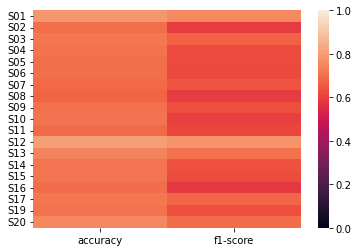

     class0 f1-score  class1 f1-score
S01         0.865079         0.514286
S02         0.817204         0.105263
S03         0.820144         0.324324
S04         0.822006         0.153846
S05         0.816176         0.166667
S06         0.816609         0.131148
S07         0.797153         0.296296
S08         0.800000         0.142857
S09         0.818182         0.176471
S10         0.824281         0.126984
S11         0.810219         0.133333
S12         0.870849         0.567901
S13         0.835714         0.410256
S14         0.819113         0.231884
S15         0.823920         0.184615
S16         0.818182         0.034483
S17         0.818533         0.356164
S19         0.818792         0.228571
S20         0.845361         0.347826


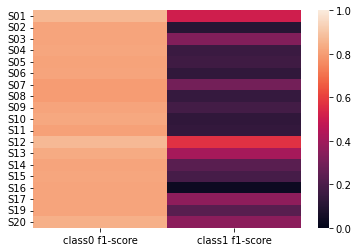

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_TS-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

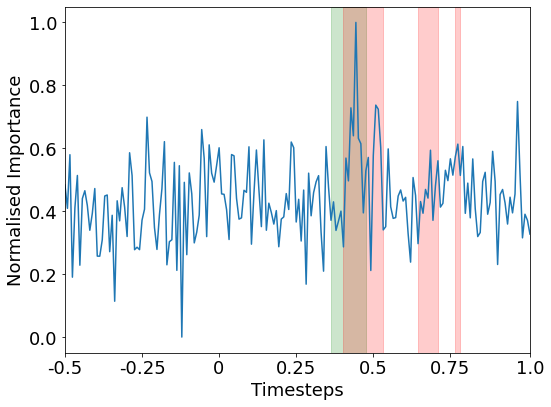

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)

plt.plot(df)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()